In [102]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from datetime import date
from KL_divergence import get_evaluation_policy, get_kl_max
from ope.envs.graph import Graph
from ope.models.basics import BasicPolicy
from ope.experiment_tools.experiment import ExperimentRunner, analysis
from ope.experiment_tools.config import Config
from ope.utils import make_seed
from neurips_seeds import weighted_graph_args, unweighted_graph_args
from neurips_plotting import neurips_plot, neurips_plot_kl_2D
import json


In [ ]:
unweighted_graph_args["Nvals"] = [1024]
weighted_graph_args["Nvals"] = [1024]

def get_config(experiment_args, seed):
    # basic configuration with varying number of trajectories
    configuration = {
                "gamma": experiment_args["gamma"],
                "horizon": experiment_args["horizon"],
                "base_policy": experiment_args["p0"],
                "eval_policy": experiment_args["p1"],
                "stochastic_env": True,
                "stochastic_rewards": False,
                "sparse_rewards": False,
                "num_traj": experiment_args["Nvals"],
                "Nvals": experiment_args["Nvals"], # Compute value of estimate for these data sizes
                "is_pomdp": False,
                "pomdp_horizon": 2,
                "seed": seed,
                "experiment_number": 0,
                "access": 0,
                "secret": 0,
                "modeltype": "tabular",
                "to_regress_pi_b": False,
                "nstep_int": 1,
                "weighted": experiment_args["weighted"]
            }

    # store them
    cfg = Config(configuration)


    # initialize environment with this configuration
    env = Graph(make_pomdp=cfg.is_pomdp,
                        number_of_pomdp_states=cfg.pomdp_horizon,
                        transitions_deterministic=not cfg.stochastic_env,
                        max_length=cfg.horizon,
                        sparse_rewards=cfg.sparse_rewards,
                        stochastic_rewards=cfg.stochastic_rewards)
    return configuration, cfg, env

In [103]:

def run(experiment_args, kl_target):

    runner = ExperimentRunner()

    seeds  = []
    all_N_vals = []
    for t in range(experiment_args["num_trials"]): # Number of trials, config file for each trial.

        # Set random seed for trial.
        if experiment_args["seeds"] is None: seed = make_seed()
        else: seed = experiment_args["seeds"][t]
        seeds.append(seed)

        # For each trial, generate a single large dataset with the largest Nval.
        # For each Nval, we will compute the estimate for that value on the same dataset.
        max_Nval = max(experiment_args["Nvals"])
        all_N_vals += experiment_args["Nvals"]

        # set seed for the experiment
        np.random.seed(cfg.seed)

        # processor processes the state for storage
        processor = lambda x: x

        # absorbing state for padding if episode ends before horizon is reached
        absorbing_state = processor(np.array([env.n_dim - 1]))

        configuration, cfg, env = get_config(experiment_args, seed)
        
        # Calculated evaluation policy for the given kl_divergence
        cfg.eval_policy = get_evaluation_policy(env, kl_target, cfg.base_policy, 0)

        # Setup policies
        actions = [0, 1]
        pi_e = BasicPolicy(
            actions, [max(.001, cfg.eval_policy), 1 - max(.001, cfg.eval_policy)])
        pi_b = BasicPolicy(
            actions, [max(.001, cfg.base_policy), 1 - max(.001, cfg.base_policy)])

        # add env, policies, absorbing state and processor
        cfg.add({
            'env': env,
            'pi_e': pi_e,
            'pi_b': pi_b,
            'processor': processor,
            'absorbing_state': absorbing_state
        })

        # Decide which OPE methods to run.
        # Currently only all is available
        cfg.add({'models': experiment_args["models"]})

        # Add the configuration
        runner.add(cfg)

    # Run the configurations
    results = runner.run()

    return results, {'seeds':seeds, 'args': experiment_args}






Running  0.0  of  [0.         0.02416512 0.04833023 0.07249535 0.09666046 0.12082558
 0.14499069 0.16915581 0.19332092 0.21748604]


100%|██████████| 1024/1024 [00:03<00:00, 339.97it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4358. Error:    58.3970
 NStep(t=2):    -0.8831. Error:    51.7613
 NStep(t=3):    -1.3225. Error:    45.6312
 NStep(t=4):    -1.7444. Error:    40.1097
 NStep(t=5):    -2.1038. Error:    35.6869
 NStep(t=6):    -2.5022. Error:    31.0853
 NStep(t=7):    -2.8635. Error:    27.1868
 NStep(t=8):    -3.2307. Error:    23.4926
 NStep(t=9):    -3.6486. Error:    19.6157
NStep(t=10):    -4.0861. Error:    15.9319
NStep(t=11):    -4.4826. Error:    12.9241
NStep(t=12):    -4.8947. Error:    10.1310
NStep(t=13):    -5.2638. Error:     7.9174
NStep(t=14):    -5.6407. Error:     5.9383
NStep(t=15):    -6.0763. Error:     4.0053
NStep(t=16):    -6.5274. Error:     2.4030
NStep(t=17):    -6.9551. Error:     1.2599
NStep(t=18):    -7.3340. Error:     0.5529
NStep(t=19):    -7.75

100%|██████████| 1024/1024 [00:03<00:00, 313.53it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3948. Error:    59.0257
 NStep(t=2):    -0.7678. Error:    53.4328
 NStep(t=3):    -1.1565. Error:    47.9017
 NStep(t=4):    -1.5627. Error:    42.4434
 NStep(t=5):    -1.9787. Error:    37.1960
 NStep(t=6):    -2.3869. Error:    32.3836
 NStep(t=7):    -2.7639. Error:    28.2356
 NStep(t=8):    -3.1818. Error:    23.9685
 NStep(t=9):    -3.5646. Error:    20.3668
NStep(t=10):    -3.9631. Error:    16.9294
NStep(t=11):    -4.3888. Error:    13.6070
NStep(t=12):    -4.8419. Error:    10.4695
NStep(t=13):    -5.2618. Error:     7.9285
NStep(t=14):    -5.5939. Error:     6.1690
NStep(t=15):    -5.9767. Error:     4.4140
NStep(t=16):    -6.3477. Error:     2.9924
NStep(t=17):    -6.7325. Error:     1.8093
NStep(t=18):    -7.1036. Error:     0.9488
NStep(t=19):    -7.49

100%|██████████| 1024/1024 [00:03<00:00, 338.99it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0002. Error:    65.2437
 NStep(t=1):    -0.4260. Error:    58.5466
 NStep(t=2):    -0.7991. Error:    52.9770
 NStep(t=3):    -1.1955. Error:    47.3626
 NStep(t=4):    -1.5705. Error:    42.3418
 NStep(t=5):    -1.9494. Error:    37.5543
 NStep(t=6):    -2.3147. Error:    33.2114
 NStep(t=7):    -2.6721. Error:    29.2196
 NStep(t=8):    -2.9982. Error:    25.7998
 NStep(t=9):    -3.4103. Error:    21.7833
NStep(t=10):    -3.7678. Error:    18.5748
NStep(t=11):    -4.1388. Error:    15.5139
NStep(t=12):    -4.5275. Error:    12.6033
NStep(t=13):    -4.9259. Error:     9.9331
NStep(t=14):    -5.3048. Error:     7.6884
NStep(t=15):    -5.6778. Error:     5.7589
NStep(t=16):    -6.1427. Error:     3.7440
NStep(t=17):    -6.5489. Error:     2.3370
NStep(t=18):    -6.9512. Error:     1.2687
NStep(t=19):    -7.36

100%|██████████| 1024/1024 [00:03<00:00, 312.20it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3753. Error:    59.3261
 NStep(t=2):    -0.7835. Error:    53.2045
 NStep(t=3):    -1.1272. Error:    48.3080
 NStep(t=4):    -1.5569. Error:    42.5197
 NStep(t=5):    -1.9495. Error:    37.5541
 NStep(t=6):    -2.3518. Error:    32.7849
 NStep(t=7):    -2.7151. Error:    28.7568
 NStep(t=8):    -3.1350. Error:    24.4295
 NStep(t=9):    -3.4729. Error:    21.2037
NStep(t=10):    -3.9221. Error:    17.2685
NStep(t=11):    -4.3185. Error:    14.1306
NStep(t=12):    -4.7248. Error:    11.2415
NStep(t=13):    -5.1583. Error:     8.5221
NStep(t=14):    -5.6075. Error:     6.1012
NStep(t=15):    -5.9962. Error:     4.3322
NStep(t=16):    -6.4395. Error:     2.6833
NStep(t=17):    -6.7950. Error:     1.6451
NStep(t=18):    -7.2403. Error:     0.7011
NStep(t=19):    -7.66

100%|██████████| 1024/1024 [00:03<00:00, 339.37it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4651. Error:    57.9501
 NStep(t=2):    -0.8714. Error:    51.9300
 NStep(t=3):    -1.2717. Error:    46.3198
 NStep(t=4):    -1.6936. Error:    40.7554
 NStep(t=5):    -2.1057. Error:    35.6635
 NStep(t=6):    -2.5178. Error:    30.9113
 NStep(t=7):    -2.9084. Error:    26.7204
 NStep(t=8):    -3.3069. Error:    22.7600
 NStep(t=9):    -3.7561. Error:    18.6757
NStep(t=10):    -4.1740. Error:    15.2380
NStep(t=11):    -4.5334. Error:    12.5615
NStep(t=12):    -4.9337. Error:     9.8838
NStep(t=13):    -5.3712. Error:     7.3244
NStep(t=14):    -5.7560. Error:     5.3899
NStep(t=15):    -6.1192. Error:     3.8351
NStep(t=16):    -6.5528. Error:     2.3250
NStep(t=17):    -6.9805. Error:     1.2036
NStep(t=18):    -7.4317. Error:     0.4172
NStep(t=19):    -7.84

100%|██████████| 1024/1024 [00:03<00:00, 338.29it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4749. Error:    57.8016
 NStep(t=2):    -0.8967. Error:    51.5648
 NStep(t=3):    -1.3108. Error:    45.7897
 NStep(t=4):    -1.6506. Error:    41.3059
 NStep(t=5):    -2.0569. Error:    36.2491
 NStep(t=6):    -2.4612. Error:    31.5443
 NStep(t=7):    -2.8635. Error:    27.1868
 NStep(t=8):    -3.3166. Error:    22.6670
 NStep(t=9):    -3.7248. Error:    18.9468
NStep(t=10):    -4.0842. Error:    15.9475
NStep(t=11):    -4.4982. Error:    12.8120
NStep(t=12):    -4.9044. Error:    10.0689
NStep(t=13):    -5.3380. Error:     7.5053
NStep(t=14):    -5.7775. Error:     5.2906
NStep(t=15):    -6.1485. Error:     3.7213
NStep(t=16):    -6.5352. Error:     2.3789
NStep(t=17):    -6.9298. Error:     1.3176
NStep(t=18):    -7.3282. Error:     0.5616
NStep(t=19):    -7.7481

100%|██████████| 1024/1024 [00:03<00:00, 291.78it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4280. Error:    58.5165
 NStep(t=2):    -0.8225. Error:    52.6362
 NStep(t=3):    -1.2639. Error:    46.4262
 NStep(t=4):    -1.6819. Error:    40.9052
 NStep(t=5):    -2.0959. Error:    35.7803
 NStep(t=6):    -2.4944. Error:    31.1725
 NStep(t=7):    -2.8283. Error:    27.5547
 NStep(t=8):    -3.2014. Error:    23.7775
 NStep(t=9):    -3.5725. Error:    20.2963
NStep(t=10):    -3.9670. Error:    16.8972
NStep(t=11):    -4.3400. Error:    13.9695
NStep(t=12):    -4.8068. Error:    10.6982
NStep(t=13):    -5.2033. Error:     8.2618
NStep(t=14):    -5.5900. Error:     6.1883
NStep(t=15):    -5.9962. Error:     4.3322
NStep(t=16):    -6.4298. Error:     2.7153
NStep(t=17):    -6.8770. Error:     1.4414
NStep(t=18):    -7.3204. Error:     0.5734
NStep(t=19):    -7.7227. Error:  

100%|██████████| 1024/1024 [00:02<00:00, 347.47it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.3772. Error:    59.2959
 NStep(t=2):    -0.7991. Error:    52.9767
 NStep(t=3):    -1.2151. Error:    47.0939
 NStep(t=4):    -1.6409. Error:    41.4315
 NStep(t=5):    -2.0803. Error:    35.9674
 NStep(t=6):    -2.4065. Error:    32.1615
 NStep(t=7):    -2.8303. Error:    27.5341
 NStep(t=8):    -3.2756. Error:    23.0592
 NStep(t=9):    -3.7033. Error:    19.1343
NStep(t=10):    -4.1037. Error:    15.7919
NStep(t=11):    -4.5138. Error:    12.7004
NStep(t=12):    -4.8791. Error:    10.2306
NStep(t=13):    -5.3048. Error:     7.6883
NStep(t=14):    -5.7618. Error:     5.3628
NStep(t=15):    -6.1817. Error:     3.5943
NStep(t=16):    -6.5704. Error:     2.2717
NStep(t=17):    -6.9747. Error:     1.2164
NStep(t=18):    -7.3887. Error:     0.4746
NStep(t=19):    -7.83

100%|██████████| 1024/1024 [00:03<00:00, 333.11it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0002. Error:    65.2436
 NStep(t=1):    -0.3733. Error:    59.3563
 NStep(t=2):    -0.8069. Error:    52.8633
 NStep(t=3):    -1.1897. Error:    47.4433
 NStep(t=4):    -1.5686. Error:    42.3672
 NStep(t=5):    -1.9768. Error:    37.2199
 NStep(t=6):    -2.3030. Error:    33.3465
 NStep(t=7):    -2.6740. Error:    29.1985
 NStep(t=8):    -3.0510. Error:    25.2669
 NStep(t=9):    -3.4357. Error:    21.5469
NStep(t=10):    -3.8361. Error:    17.9902
NStep(t=11):    -4.2580. Error:    14.5896
NStep(t=12):    -4.6857. Error:    11.5051
NStep(t=13):    -5.0861. Error:     8.9493
NStep(t=14):    -5.5060. Error:     6.6133
NStep(t=15):    -5.8966. Error:     4.7569
NStep(t=16):    -6.3028. Error:     3.1499
NStep(t=17):    -6.6524. Error:     2.0312
NStep(t=18):    -7.0372. Error:     1.0825
NStep(t=19):    -7.40

100%|██████████| 1024/1024 [00:03<00:00, 313.34it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4299. Error:    58.4866
 NStep(t=2):    -0.8577. Error:    52.1273
 NStep(t=3):    -1.3127. Error:    45.7632
 NStep(t=4):    -1.7268. Error:    40.3326
 NStep(t=5):    -2.1077. Error:    35.6402
 NStep(t=6):    -2.5217. Error:    30.8679
 NStep(t=7):    -2.8889. Error:    26.9227
 NStep(t=8):    -3.2795. Error:    23.0217
 NStep(t=9):    -3.6623. Error:    19.4948
NStep(t=10):    -4.0353. Error:    16.3399
NStep(t=11):    -4.4513. Error:    13.1498
NStep(t=12):    -4.8888. Error:    10.1683
NStep(t=13):    -5.3087. Error:     7.6667
NStep(t=14):    -5.7228. Error:     5.5452
NStep(t=15):    -6.0997. Error:     3.9120
NStep(t=16):    -6.4942. Error:     2.5071
NStep(t=17):    -6.9063. Error:     1.3719
NStep(t=18):    -7.3204. Error:     0.5734
NStep(t=19):    -7.7364

100%|██████████| 1024/1024 [00:02<00:00, 341.43it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4299. Error:    58.4866
 NStep(t=2):    -0.8167. Error:    52.7212
 NStep(t=3):    -1.2210. Error:    47.0135
 NStep(t=4):    -1.5745. Error:    42.2907
 NStep(t=5):    -1.9788. Error:    37.1958
 NStep(t=6):    -2.4202. Error:    32.0067
 NStep(t=7):    -2.8889. Error:    26.9227
 NStep(t=8):    -3.2815. Error:    23.0029
 NStep(t=9):    -3.7053. Error:    19.1172
NStep(t=10):    -4.1369. Error:    15.5291
NStep(t=11):    -4.5041. Error:    12.7701
NStep(t=12):    -4.9201. Error:     9.9699
NStep(t=13):    -5.3205. Error:     7.6019
NStep(t=14):    -5.6974. Error:     5.6654
NStep(t=15):    -6.1505. Error:     3.7137
NStep(t=16):    -6.5997. Error:     2.1842
NStep(t=17):    -6.9766. Error:     1.2121
NStep(t=18):    -7.3711. Error:     0.4991
NStep(t=19):    -7.8379. 

100%|██████████| 1024/1024 [00:03<00:00, 338.56it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3987. Error:    58.9656
 NStep(t=2):    -0.7913. Error:    53.0906
 NStep(t=3):    -1.1877. Error:    47.4700
 NStep(t=4):    -1.5959. Error:    42.0118
 NStep(t=5):    -2.0256. Error:    36.6264
 NStep(t=6):    -2.4475. Error:    31.6981
 NStep(t=7):    -2.8674. Error:    27.1462
 NStep(t=8):    -3.2443. Error:    23.3604
 NStep(t=9):    -3.6350. Error:    19.7371
NStep(t=10):    -4.0295. Error:    16.3873
NStep(t=11):    -4.4396. Error:    13.2349
NStep(t=12):    -4.8380. Error:    10.4948
NStep(t=13):    -5.2560. Error:     7.9615
NStep(t=14):    -5.6564. Error:     5.8624
NStep(t=15):    -6.0255. Error:     4.2112
NStep(t=16):    -6.3907. Error:     2.8456
NStep(t=17):    -6.7891. Error:     1.6602
NStep(t=18):    -7.2247. Error:     0.7275
NStep(t=19):    -7.62

100%|██████████| 1024/1024 [00:03<00:00, 314.86it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2436
 NStep(t=1):    -0.3694. Error:    59.4165
 NStep(t=2):    -0.7678. Error:    53.4328
 NStep(t=3):    -1.1428. Error:    48.0911
 NStep(t=4):    -1.5549. Error:    42.5453
 NStep(t=5):    -1.9416. Error:    37.6500
 NStep(t=6):    -2.3225. Error:    33.1213
 NStep(t=7):    -2.6662. Error:    29.2829
 NStep(t=8):    -3.0549. Error:    25.2276
 NStep(t=9):    -3.5041. Error:    20.9169
NStep(t=10):    -3.8830. Error:    17.5947
NStep(t=11):    -4.3107. Error:    14.1895
NStep(t=12):    -4.7072. Error:    11.3597
NStep(t=13):    -5.0763. Error:     9.0078
NStep(t=14):    -5.5177. Error:     6.5531
NStep(t=15):    -5.9317. Error:     4.6047
NStep(t=16):    -6.3106. Error:     3.1222
NStep(t=17):    -6.7130. Error:     1.8623
NStep(t=18):    -7.1231. Error:     0.9111
NStep(t=19):    -7.53

100%|██████████| 1024/1024 [00:02<00:00, 344.82it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3967. Error:    58.9956
 NStep(t=2):    -0.7893. Error:    53.1191
 NStep(t=3):    -1.2307. Error:    46.8798
 NStep(t=4):    -1.6584. Error:    41.2056
 NStep(t=5):    -2.0178. Error:    36.7210
 NStep(t=6):    -2.4319. Error:    31.8743
 NStep(t=7):    -2.8596. Error:    27.2276
 NStep(t=8):    -3.2522. Error:    23.2849
 NStep(t=9):    -3.6701. Error:    19.4260
NStep(t=10):    -4.0334. Error:    16.3557
NStep(t=11):    -4.4201. Error:    13.3774
NStep(t=12):    -4.8341. Error:    10.5201
NStep(t=13):    -5.2228. Error:     8.1499
NStep(t=14):    -5.5958. Error:     6.1592
NStep(t=15):    -6.0079. Error:     4.2836
NStep(t=16):    -6.4415. Error:     2.6769
NStep(t=17):    -6.7891. Error:     1.6602
NStep(t=18):    -7.1817. Error:     0.8027
NStep(t=19):    -7.61

100%|██████████| 1024/1024 [00:02<00:00, 343.83it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3655. Error:    59.4767
 NStep(t=2):    -0.7659. Error:    53.4613
 NStep(t=3):    -1.2053. Error:    47.2282
 NStep(t=4):    -1.5920. Error:    42.0625
 NStep(t=5):    -2.0120. Error:    36.7921
 NStep(t=6):    -2.4104. Error:    32.1174
 NStep(t=7):    -2.8303. Error:    27.5343
 NStep(t=8):    -3.2365. Error:    23.4360
 NStep(t=9):    -3.6408. Error:    19.6851
NStep(t=10):    -4.0510. Error:    16.2139
NStep(t=11):    -4.4552. Error:    13.1215
NStep(t=12):    -4.8244. Error:    10.5835
NStep(t=13):    -5.2072. Error:     8.2394
NStep(t=14):    -5.6095. Error:     6.0916
NStep(t=15):    -6.0138. Error:     4.2594
NStep(t=16):    -6.3751. Error:     2.8986
NStep(t=17):    -6.7579. Error:     1.7417
NStep(t=18):    -7.1387. Error:     0.8815
NStep(t=19):    -7.55

100%|██████████| 1024/1024 [00:03<00:00, 312.94it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4241. Error:    58.5763
 NStep(t=2):    -0.8499. Error:    52.2402
 NStep(t=3):    -1.2405. Error:    46.7462
 NStep(t=4):    -1.6174. Error:    41.7338
 NStep(t=5):    -2.0432. Error:    36.4139
 NStep(t=6):    -2.4084. Error:    32.1395
 NStep(t=7):    -2.8498. Error:    27.3296
 NStep(t=8):    -3.2619. Error:    23.1907
 NStep(t=9):    -3.6838. Error:    19.3056
NStep(t=10):    -4.0275. Error:    16.4031
NStep(t=11):    -4.4474. Error:    13.1781
NStep(t=12):    -4.8869. Error:    10.1808
NStep(t=13):    -5.3165. Error:     7.6235
NStep(t=14):    -5.6974. Error:     5.6655
NStep(t=15):    -6.0724. Error:     4.0210
NStep(t=16):    -6.5196. Error:     2.4273
NStep(t=17):    -6.9376. Error:     1.2997
NStep(t=18):    -7.3106. Error:     0.5883
NStep(t=19):    -7.69

100%|██████████| 1024/1024 [00:02<00:00, 344.71it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4260. Error:    58.5465
 NStep(t=2):    -0.7893. Error:    53.1191
 NStep(t=3):    -1.1331. Error:    48.2266
 NStep(t=4):    -1.5334. Error:    42.8260
 NStep(t=5):    -1.9221. Error:    37.8900
 NStep(t=6):    -2.3323. Error:    33.0090
 NStep(t=7):    -2.7580. Error:    28.2978
 NStep(t=8):    -3.1701. Error:    24.0833
 NStep(t=9):    -3.5861. Error:    20.1733
NStep(t=10):    -4.0021. Error:    16.6095
NStep(t=11):    -4.3576. Error:    13.8385
NStep(t=12):    -4.7384. Error:    11.1500
NStep(t=13):    -5.1447. Error:     8.6021
NStep(t=14):    -5.5548. Error:     6.3645
NStep(t=15):    -5.9454. Error:     4.5462
NStep(t=16):    -6.3653. Error:     2.9319
NStep(t=17):    -6.7305. Error:     1.8146
NStep(t=18):    -7.1270. Error:     0.9036
NStep(t=19):    -7.56

100%|██████████| 1024/1024 [00:02<00:00, 343.08it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4377. Error:    58.3673
 NStep(t=2):    -0.7835. Error:    53.2046
 NStep(t=3):    -1.1350. Error:    48.1995
 NStep(t=4):    -1.5237. Error:    42.9539
 NStep(t=5):    -1.9026. Error:    38.1309
 NStep(t=6):    -2.3225. Error:    33.1213
 NStep(t=7):    -2.7131. Error:    28.7778
 NStep(t=8):    -3.0900. Error:    24.8757
 NStep(t=9):    -3.5334. Error:    20.6498
NStep(t=10):    -3.9631. Error:    16.9294
NStep(t=11):    -4.3224. Error:    14.1013
NStep(t=12):    -4.7892. Error:    10.8135
NStep(t=13):    -5.1818. Error:     8.3858
NStep(t=14):    -5.5431. Error:     6.4238
NStep(t=15):    -5.9552. Error:     4.5047
NStep(t=16):    -6.3419. Error:     3.0127
NStep(t=17):    -6.7481. Error:     1.7676
NStep(t=18):    -7.1563. Error:     0.8488
NStep(t=19):    -7.5371

100%|██████████| 1024/1024 [00:03<00:00, 312.71it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4338. Error:    58.4270
 NStep(t=2):    -0.8147. Error:    52.7497
 NStep(t=3):    -1.2112. Error:    47.1477
 NStep(t=4):    -1.6311. Error:    41.5574
 NStep(t=5):    -2.0393. Error:    36.4612
 NStep(t=6):    -2.4651. Error:    31.5006
 NStep(t=7):    -2.8498. Error:    27.3297
 NStep(t=8):    -3.2775. Error:    23.0406
 NStep(t=9):    -3.6760. Error:    19.3744
NStep(t=10):    -4.0549. Error:    16.1825
NStep(t=11):    -4.4396. Error:    13.2350
NStep(t=12):    -4.8380. Error:    10.4948
NStep(t=13):    -5.1935. Error:     8.3181
NStep(t=14):    -5.5685. Error:     6.2957
NStep(t=15):    -5.9591. Error:     4.4881
NStep(t=16):    -6.3555. Error:     2.9655
NStep(t=17):    -6.7266. Error:     1.8251
NStep(t=18):    -7.0938. Error:     0.9679
NStep(t=19):    -7.4727. 

100%|██████████| 1024/1024 [00:02<00:00, 344.13it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0002. Error:    65.2436
 NStep(t=1):    -0.4377. Error:    58.3674
 NStep(t=2):    -0.7620. Error:    53.5185
 NStep(t=3):    -1.1194. Error:    48.4167
 NStep(t=4):    -1.4885. Error:    43.4159
 NStep(t=5):    -1.8459. Error:    38.8336
 NStep(t=6):    -2.2327. Error:    34.1634
 NStep(t=7):    -2.6565. Error:    29.3887
 NStep(t=8):    -3.0276. Error:    25.5030
 NStep(t=9):    -3.4553. Error:    21.3659
NStep(t=10):    -3.8556. Error:    17.8249
NStep(t=11):    -4.2599. Error:    14.5746
NStep(t=12):    -4.6310. Error:    11.8790
NStep(t=13):    -5.0197. Error:     9.3510
NStep(t=14):    -5.4337. Error:     6.9901
NStep(t=15):    -5.8224. Error:     5.0861
NStep(t=16):    -6.2794. Error:     3.2336
NStep(t=17):    -6.7208. Error:     1.8410
NStep(t=18):    -7.1094. Error:     0.9374
NStep(t=19):    -7.5078. Erro

100%|██████████| 1024/1024 [00:03<00:00, 307.16it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3967. Error:    58.9956
 NStep(t=2):    -0.8186. Error:    52.6930
 NStep(t=3):    -1.2112. Error:    47.1477
 NStep(t=4):    -1.6331. Error:    41.5322
 NStep(t=5):    -2.0178. Error:    36.7211
 NStep(t=6):    -2.4319. Error:    31.8744
 NStep(t=7):    -2.8186. Error:    27.6574
 NStep(t=8):    -3.2287. Error:    23.5117
 NStep(t=9):    -3.5900. Error:    20.1383
NStep(t=10):    -4.0060. Error:    16.5777
NStep(t=11):    -4.4162. Error:    13.4060
NStep(t=12):    -4.8302. Error:    10.5455
NStep(t=13):    -5.2540. Error:     7.9725
NStep(t=14):    -5.6407. Error:     5.9383
NStep(t=15):    -6.0313. Error:     4.1872
NStep(t=16):    -6.3985. Error:     2.8193
NStep(t=17):    -6.7481. Error:     1.7676
NStep(t=18):    -7.1895. Error:     0.7887
NStep(t=19):    -7.54

100%|██████████| 1024/1024 [00:02<00:00, 343.73it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4143. Error:    58.7259
 NStep(t=2):    -0.8030. Error:    52.9200
 NStep(t=3):    -1.2053. Error:    47.2281
 NStep(t=4):    -1.6018. Error:    41.9359
 NStep(t=5):    -2.0373. Error:    36.4847
 NStep(t=6):    -2.4397. Error:    31.7861
 NStep(t=7):    -2.8635. Error:    27.1869
 NStep(t=8):    -3.2893. Error:    22.9281
 NStep(t=9):    -3.6935. Error:    19.2199
NStep(t=10):    -4.0568. Error:    16.1667
NStep(t=11):    -4.4787. Error:    12.9522
NStep(t=12):    -4.8751. Error:    10.2557
NStep(t=13):    -5.2150. Error:     8.1946
NStep(t=14):    -5.5919. Error:     6.1786
NStep(t=15):    -6.0274. Error:     4.2031
NStep(t=16):    -6.4493. Error:     2.6514
NStep(t=17):    -6.8692. Error:     1.4602
NStep(t=18):    -7.2618. Error:     0.6656
NStep(t=19):    -7.6699. Er

100%|██████████| 1024/1024 [00:03<00:00, 339.30it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3655. Error:    59.4766
 NStep(t=2):    -0.7639. Error:    53.4898
 NStep(t=3):    -1.1721. Error:    47.6856
 NStep(t=4):    -1.5901. Error:    42.0878
 NStep(t=5):    -2.0315. Error:    36.5555
 NStep(t=6):    -2.4260. Error:    31.9405
 NStep(t=7):    -2.8557. Error:    27.2684
 NStep(t=8):    -3.2190. Error:    23.6065
 NStep(t=9):    -3.6154. Error:    19.9110
NStep(t=10):    -4.0529. Error:    16.1981
NStep(t=11):    -4.4240. Error:    13.3489
NStep(t=12):    -4.8361. Error:    10.5074
NStep(t=13):    -5.2247. Error:     8.1388
NStep(t=14):    -5.6857. Error:     5.7214
NStep(t=15):    -6.0392. Error:     4.1552
NStep(t=16):    -6.3731. Error:     2.9052
NStep(t=17):    -6.7989. Error:     1.6351
NStep(t=18):    -7.1856. Error:     0.7957
NStep(t=19):    -7.58

100%|██████████| 1024/1024 [00:03<00:00, 316.95it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4378. Error:    58.3672
 NStep(t=2):    -0.7991. Error:    52.9768
 NStep(t=3):    -1.1956. Error:    47.3624
 NStep(t=4):    -1.5745. Error:    42.2907
 NStep(t=5):    -1.9963. Error:    36.9818
 NStep(t=6):    -2.4202. Error:    32.0067
 NStep(t=7):    -2.8615. Error:    27.2072
 NStep(t=8):    -3.2404. Error:    23.3981
 NStep(t=9):    -3.6096. Error:    19.9633
NStep(t=10):    -4.0099. Error:    16.5458
NStep(t=11):    -4.4162. Error:    13.4060
NStep(t=12):    -4.8087. Error:    10.6854
NStep(t=13):    -5.2619. Error:     7.9284
NStep(t=14):    -5.6779. Error:     5.7588
NStep(t=15):    -6.0606. Error:     4.0681
NStep(t=16):    -6.5079. Error:     2.4640
NStep(t=17):    -6.9649. Error:     1.2381
NStep(t=18):    -7.3614. Error:     0.5130
NStep(t=19):    -7.75

100%|██████████| 1024/1024 [00:03<00:00, 337.80it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2436
 NStep(t=1):    -0.3772. Error:    59.2961
 NStep(t=2):    -0.7874. Error:    53.1476
 NStep(t=3):    -1.1545. Error:    47.9287
 NStep(t=4):    -1.5842. Error:    42.1639
 NStep(t=5):    -1.9631. Error:    37.3868
 NStep(t=6):    -2.3791. Error:    32.4726
 NStep(t=7):    -2.7873. Error:    27.9870
 NStep(t=8):    -3.1721. Error:    24.0642
 NStep(t=9):    -3.5803. Error:    20.2260
NStep(t=10):    -3.9631. Error:    16.9294
NStep(t=11):    -4.3107. Error:    14.1894
NStep(t=12):    -4.7736. Error:    10.9165
NStep(t=13):    -5.1798. Error:     8.3971
NStep(t=14):    -5.5275. Error:     6.5032
NStep(t=15):    -5.9396. Error:     4.5713
NStep(t=16):    -6.3028. Error:     3.1499
NStep(t=17):    -6.6837. Error:     1.9431
NStep(t=18):    -7.0313. Error:     1.0947
NStep(t=19):    -7.4864

100%|██████████| 1024/1024 [00:03<00:00, 341.01it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0002. Error:    65.2436
 NStep(t=1):    -0.4397. Error:    58.3376
 NStep(t=2):    -0.7639. Error:    53.4900
 NStep(t=3):    -1.1623. Error:    47.8207
 NStep(t=4):    -1.5354. Error:    42.8005
 NStep(t=5):    -1.9338. Error:    37.7460
 NStep(t=6):    -2.2756. Error:    33.6631
 NStep(t=7):    -2.6389. Error:    29.5796
 NStep(t=8):    -3.0354. Error:    25.4242
 NStep(t=9):    -3.4416. Error:    21.4926
NStep(t=10):    -3.8635. Error:    17.7590
NStep(t=11):    -4.2091. Error:    14.9649
NStep(t=12):    -4.5998. Error:    12.0954
NStep(t=13):    -4.9943. Error:     9.5069
NStep(t=14):    -5.4357. Error:     6.9799
NStep(t=15):    -5.8380. Error:     5.0159
NStep(t=16):    -6.1934. Error:     3.5501
NStep(t=17):    -6.5762. Error:     2.2541
NStep(t=18):    -6.9786. Error:     1.2079
NStep(t=19):    -7.37

100%|██████████| 1024/1024 [00:03<00:00, 312.67it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0002. Error:    65.2436
 NStep(t=1):    -0.4124. Error:    58.7560
 NStep(t=2):    -0.7952. Error:    53.0339
 NStep(t=3):    -1.1623. Error:    47.8207
 NStep(t=4):    -1.5452. Error:    42.6728
 NStep(t=5):    -1.9338. Error:    37.7460
 NStep(t=6):    -2.3283. Error:    33.0539
 NStep(t=7):    -2.7170. Error:    28.7360
 NStep(t=8):    -3.0920. Error:    24.8563
 NStep(t=9):    -3.4787. Error:    21.1499
NStep(t=10):    -3.8869. Error:    17.5620
NStep(t=11):    -4.2873. Error:    14.3666
NStep(t=12):    -4.6857. Error:    11.5051
NStep(t=13):    -5.0529. Error:     9.1490
NStep(t=14):    -5.5275. Error:     6.5033
NStep(t=15):    -5.8614. Error:     4.9114
NStep(t=16):    -6.1915. Error:     3.5574
NStep(t=17):    -6.5938. Error:     2.2016
NStep(t=18):    -6.9512. Error:     1.2687
NStep(t=19):    -7.36

100%|██████████| 1024/1024 [00:02<00:00, 343.38it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4475. Error:    58.2181
 NStep(t=2):    -0.8831. Error:    51.7613
 NStep(t=3):    -1.2600. Error:    46.4794
 NStep(t=4):    -1.6877. Error:    40.8302
 NStep(t=5):    -2.1018. Error:    35.7102
 NStep(t=6):    -2.5237. Error:    30.8462
 NStep(t=7):    -2.8987. Error:    26.8215
 NStep(t=8):    -3.3088. Error:    22.7414
 NStep(t=9):    -3.7248. Error:    18.9468
NStep(t=10):    -4.1193. Error:    15.6680
NStep(t=11):    -4.5353. Error:    12.5477
NStep(t=12):    -4.9474. Error:     9.7981
NStep(t=13):    -5.3615. Error:     7.3774
NStep(t=14):    -5.7579. Error:     5.3809
NStep(t=15):    -6.1622. Error:     3.6687
NStep(t=16):    -6.5899. Error:     2.2132
NStep(t=17):    -6.9415. Error:     1.2908
NStep(t=18):    -7.3497. Error:     0.5299
NStep(t=19):    -7.77

100%|██████████| 1024/1024 [00:03<00:00, 341.12it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4299. Error:    58.4868
 NStep(t=2):    -0.7991. Error:    52.9769
 NStep(t=3):    -1.2112. Error:    47.1478
 NStep(t=4):    -1.6291. Error:    41.5826
 NStep(t=5):    -2.0041. Error:    36.8870
 NStep(t=6):    -2.4299. Error:    31.8965
 NStep(t=7):    -2.8127. Error:    27.7191
 NStep(t=8):    -3.2111. Error:    23.6825
 NStep(t=9):    -3.6017. Error:    20.0333
NStep(t=10):    -3.9806. Error:    16.7851
NStep(t=11):    -4.3459. Error:    13.9259
NStep(t=12):    -4.7775. Error:    10.8908
NStep(t=13):    -5.1544. Error:     8.5450
NStep(t=14):    -5.5646. Error:     6.3154
NStep(t=15):    -5.9591. Error:     4.4882
NStep(t=16):    -6.3087. Error:     3.1291
NStep(t=17):    -6.6797. Error:     1.9540
NStep(t=18):    -7.0723. Error:     1.0106
NStep(t=19):    -7.41

100%|██████████| 1024/1024 [00:03<00:00, 317.14it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3850. Error:    59.1758
 NStep(t=2):    -0.7932. Error:    53.0622
 NStep(t=3):    -1.1624. Error:    47.8206
 NStep(t=4):    -1.5530. Error:    42.5707
 NStep(t=5):    -1.9182. Error:    37.9381
 NStep(t=6):    -2.3381. Error:    32.9416
 NStep(t=7):    -2.7073. Error:    28.8406
 NStep(t=8):    -3.1154. Error:    24.6230
 NStep(t=9):    -3.5393. Error:    20.5965
NStep(t=10):    -3.9455. Error:    17.0743
NStep(t=11):    -4.3010. Error:    14.2631
NStep(t=12):    -4.7052. Error:    11.3729
NStep(t=13):    -5.1486. Error:     8.5792
NStep(t=14):    -5.5782. Error:     6.2468
NStep(t=15):    -5.9767. Error:     4.4139
NStep(t=16):    -6.4356. Error:     2.6961
NStep(t=17):    -6.8184. Error:     1.5855
NStep(t=18):    -7.2793. Error:     0.6372
NStep(t=19):    -7.65

100%|██████████| 1024/1024 [00:02<00:00, 344.46it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2436
 NStep(t=1):    -0.4124. Error:    58.7559
 NStep(t=2):    -0.8303. Error:    52.5230
 NStep(t=3):    -1.2131. Error:    47.1209
 NStep(t=4):    -1.5686. Error:    42.3671
 NStep(t=5):    -1.9475. Error:    37.5781
 NStep(t=6):    -2.3381. Error:    32.9417
 NStep(t=7):    -2.7658. Error:    28.2148
 NStep(t=8):    -3.1897. Error:    23.8920
 NStep(t=9):    -3.5705. Error:    20.3139
NStep(t=10):    -3.9846. Error:    16.7530
NStep(t=11):    -4.3205. Error:    14.1160
NStep(t=12):    -4.7130. Error:    11.3203
NStep(t=13):    -5.0724. Error:     9.0312
NStep(t=14):    -5.4513. Error:     6.8975
NStep(t=15):    -5.8341. Error:     5.0333
NStep(t=16):    -6.2520. Error:     3.3327
NStep(t=17):    -6.6954. Error:     1.9105
NStep(t=18):    -7.1368. Error:     0.8852
NStep(t=19):    -7.5586

100%|██████████| 1024/1024 [00:02<00:00, 342.96it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4456. Error:    58.2479
 NStep(t=2):    -0.8284. Error:    52.5512
 NStep(t=3):    -1.2151. Error:    47.0940
 NStep(t=4):    -1.6370. Error:    41.4818
 NStep(t=5):    -2.0393. Error:    36.4611
 NStep(t=6):    -2.4397. Error:    31.7862
 NStep(t=7):    -2.8283. Error:    27.5547
 NStep(t=8):    -3.2404. Error:    23.3981
 NStep(t=9):    -3.5900. Error:    20.1382
NStep(t=10):    -3.9689. Error:    16.8812
NStep(t=11):    -4.4611. Error:    13.0791
NStep(t=12):    -4.8439. Error:    10.4568
NStep(t=13):    -5.2853. Error:     7.7970
NStep(t=14):    -5.6954. Error:     5.6748
NStep(t=15):    -6.0763. Error:     4.0053
NStep(t=16):    -6.4864. Error:     2.5319
NStep(t=17):    -6.8907. Error:     1.4088
NStep(t=18):    -7.2950. Error:     0.6125
NStep(t=19):    -7.65

100%|██████████| 1024/1024 [00:03<00:00, 304.84it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3987. Error:    58.9657
 NStep(t=2):    -0.8206. Error:    52.6646
 NStep(t=3):    -1.2092. Error:    47.1745
 NStep(t=4):    -1.5920. Error:    42.0625
 NStep(t=5):    -1.9592. Error:    37.4346
 NStep(t=6):    -2.3479. Error:    32.8297
 NStep(t=7):    -2.7229. Error:    28.6731
 NStep(t=8):    -3.1057. Error:    24.7200
 NStep(t=9):    -3.5373. Error:    20.6143
NStep(t=10):    -3.9748. Error:    16.8331
NStep(t=11):    -4.3615. Error:    13.8095
NStep(t=12):    -4.7814. Error:    10.8650
NStep(t=13):    -5.2033. Error:     8.2619
NStep(t=14):    -5.5489. Error:     6.3941
NStep(t=15):    -5.9474. Error:     4.5379
NStep(t=16):    -6.3341. Error:     3.0399
NStep(t=17):    -6.7286. Error:     1.8199
NStep(t=18):    -7.1543. Error:     0.8524
NStep(t=19):    -7.55

100%|██████████| 1024/1024 [00:02<00:00, 342.21it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4202. Error:    58.6362
 NStep(t=2):    -0.8284. Error:    52.5513
 NStep(t=3):    -1.2327. Error:    46.8532
 NStep(t=4):    -1.5920. Error:    42.0626
 NStep(t=5):    -1.9944. Error:    37.0057
 NStep(t=6):    -2.4104. Error:    32.1174
 NStep(t=7):    -2.8029. Error:    27.8220
 NStep(t=8):    -3.2326. Error:    23.4739
 NStep(t=9):    -3.6584. Error:    19.5295
NStep(t=10):    -4.0041. Error:    16.5936
NStep(t=11):    -4.4201. Error:    13.3775
NStep(t=12):    -4.7540. Error:    11.0460
NStep(t=13):    -5.1564. Error:     8.5335
NStep(t=14):    -5.5528. Error:     6.3744
NStep(t=15):    -5.9552. Error:     4.5047
NStep(t=16):    -6.3321. Error:     3.0468
NStep(t=17):    -6.7247. Error:     1.8304
NStep(t=18):    -7.0899. Error:     0.9756
NStep(t=19):    -7.4590. Er

100%|██████████| 1024/1024 [00:03<00:00, 312.26it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4319. Error:    58.4568
 NStep(t=2):    -0.8460. Error:    52.2967
 NStep(t=3):    -1.2483. Error:    46.6394
 NStep(t=4):    -1.6057. Error:    41.8853
 NStep(t=5):    -2.0452. Error:    36.3904
 NStep(t=6):    -2.4651. Error:    31.5005
 NStep(t=7):    -2.8791. Error:    27.0242
 NStep(t=8):    -3.2600. Error:    23.2096
 NStep(t=9):    -3.6740. Error:    19.3915
NStep(t=10):    -4.1056. Error:    15.7764
NStep(t=11):    -4.5353. Error:    12.5478
NStep(t=12):    -4.9787. Error:     9.6034
NStep(t=13):    -5.3400. Error:     7.4946
NStep(t=14):    -5.7443. Error:     5.4445
NStep(t=15):    -6.1739. Error:     3.6240
NStep(t=16):    -6.5450. Error:     2.3489
NStep(t=17):    -6.9083. Error:     1.3674
NStep(t=18):    -7.3262. Error:     0.5646
NStep(t=19):    -7.69

100%|██████████| 1024/1024 [00:02<00:00, 345.15it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4202. Error:    58.6361
 NStep(t=2):    -0.8596. Error:    52.0991
 NStep(t=3):    -1.2405. Error:    46.7461
 NStep(t=4):    -1.6663. Error:    41.1053
 NStep(t=5):    -2.0920. Error:    35.8270
 NStep(t=6):    -2.5080. Error:    31.0200
 NStep(t=7):    -2.8733. Error:    27.0851
 NStep(t=8):    -3.3010. Error:    22.8160
 NStep(t=9):    -3.6857. Error:    19.2884
NStep(t=10):    -4.0998. Error:    15.8230
NStep(t=11):    -4.5705. Error:    12.2999
NStep(t=12):    -4.9533. Error:     9.7614
NStep(t=13):    -5.3966. Error:     7.1877
NStep(t=14):    -5.7950. Error:     5.2101
NStep(t=15):    -6.1622. Error:     3.6687
NStep(t=16):    -6.5528. Error:     2.3250
NStep(t=17):    -6.9473. Error:     1.2775
NStep(t=18):    -7.3497. Error:     0.5299
NStep(t=19):    -7.76

100%|██████████| 1024/1024 [00:03<00:00, 329.94it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4026. Error:    58.9056
 NStep(t=2):    -0.8460. Error:    52.2967
 NStep(t=3):    -1.2483. Error:    46.6394
 NStep(t=4):    -1.6995. Error:    40.6807
 NStep(t=5):    -2.1194. Error:    35.5005
 NStep(t=6):    -2.4963. Error:    31.1507
 NStep(t=7):    -2.8694. Error:    27.1258
 NStep(t=8):    -3.2483. Error:    23.3226
 NStep(t=9):    -3.6740. Error:    19.3915
NStep(t=10):    -4.0978. Error:    15.8385
NStep(t=11):    -4.4728. Error:    12.9944
NStep(t=12):    -4.8361. Error:    10.5074
NStep(t=13):    -5.2404. Error:     8.0499
NStep(t=14):    -5.6388. Error:     5.9478
NStep(t=15):    -6.0626. Error:     4.0602
NStep(t=16):    -6.5001. Error:     2.4886
NStep(t=17):    -6.9219. Error:     1.3356
NStep(t=18):    -7.2911. Error:     0.6186
NStep(t=19):    -7.69

100%|██████████| 1024/1024 [00:03<00:00, 314.60it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4006. Error:    58.9356
 NStep(t=2):    -0.7717. Error:    53.3756
 NStep(t=3):    -1.1702. Error:    47.7126
 NStep(t=4):    -1.5979. Error:    41.9866
 NStep(t=5):    -2.0276. Error:    36.6028
 NStep(t=6):    -2.4221. Error:    31.9847
 NStep(t=7):    -2.8440. Error:    27.3910
 NStep(t=8):    -3.2326. Error:    23.4738
 NStep(t=9):    -3.6642. Error:    19.4777
NStep(t=10):    -4.0002. Error:    16.6254
NStep(t=11):    -4.3810. Error:    13.6647
NStep(t=12):    -4.8146. Error:    10.6472
NStep(t=13):    -5.2072. Error:     8.2394
NStep(t=14):    -5.6036. Error:     6.1205
NStep(t=15):    -6.0020. Error:     4.3079
NStep(t=16):    -6.4161. Error:     2.7606
NStep(t=17):    -6.8184. Error:     1.5855
NStep(t=18):    -7.2149. Error:     0.7443
NStep(t=19):    -7.5762. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.79it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4319. Error:    58.4569
 NStep(t=2):    -0.8440. Error:    52.3250
 NStep(t=3):    -1.2463. Error:    46.6662
 NStep(t=4):    -1.6506. Error:    41.3060
 NStep(t=5):    -2.0627. Error:    36.1787
 NStep(t=6):    -2.4006. Error:    32.2282
 NStep(t=7):    -2.8303. Error:    27.5343
 NStep(t=8):    -3.2209. Error:    23.5875
 NStep(t=9):    -3.5744. Error:    20.2787
NStep(t=10):    -3.9787. Error:    16.8011
NStep(t=11):    -4.3420. Error:    13.9550
NStep(t=12):    -4.7345. Error:    11.1762
NStep(t=13):    -5.1661. Error:     8.4766
NStep(t=14):    -5.5685. Error:     6.2957
NStep(t=15):    -5.9688. Error:     4.4468
NStep(t=16):    -6.3360. Error:     3.0331
NStep(t=17):    -6.7364. Error:     1.7988
NStep(t=18):    -7.0879. Error:     0.9794
NStep(t=19):    -7.50

100%|██████████| 1024/1024 [00:03<00:00, 337.08it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4202. Error:    58.6362
 NStep(t=2):    -0.8225. Error:    52.6362
 NStep(t=3):    -1.1975. Error:    47.3356
 NStep(t=4):    -1.5588. Error:    42.4943
 NStep(t=5):    -1.9905. Error:    37.0531
 NStep(t=6):    -2.3791. Error:    32.4725
 NStep(t=7):    -2.8010. Error:    27.8425
 NStep(t=8):    -3.1877. Error:    23.9111
 NStep(t=9):    -3.6369. Error:    19.7197
NStep(t=10):    -4.0451. Error:    16.2611
NStep(t=11):    -4.4435. Error:    13.2065
NStep(t=12):    -4.8322. Error:    10.5328
NStep(t=13):    -5.2247. Error:     8.1388
NStep(t=14):    -5.6427. Error:     5.9288
NStep(t=15):    -6.0372. Error:     4.1632
NStep(t=16):    -6.3946. Error:     2.8324
NStep(t=17):    -6.7950. Error:     1.6451
NStep(t=18):    -7.1875. Error:     0.7922
NStep(t=19):    -7.6192

100%|██████████| 1024/1024 [00:03<00:00, 277.51it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3713. Error:    59.3863
 NStep(t=2):    -0.7815. Error:    53.2331
 NStep(t=3):    -1.1838. Error:    47.5239
 NStep(t=4):    -1.5881. Error:    42.1132
 NStep(t=5):    -2.0354. Error:    36.5083
 NStep(t=6):    -2.4026. Error:    32.2060
 NStep(t=7):    -2.8127. Error:    27.7190
 NStep(t=8):    -3.2463. Error:    23.3415
 NStep(t=9):    -3.6623. Error:    19.4949
NStep(t=10):    -3.9963. Error:    16.6573
NStep(t=11):    -4.3693. Error:    13.7515
NStep(t=12):    -4.7697. Error:    10.9423
NStep(t=13):    -5.1564. Error:     8.5335
NStep(t=14):    -5.5431. Error:     6.4238
NStep(t=15):    -5.9669. Error:     4.4551
NStep(t=16):    -6.3477. Error:     2.9924
NStep(t=17):    -6.7676. Error:     1.7160
NStep(t=18):    -7.1368. Error:     0.8852
NStep(t=19):    -7.5528. Erro

100%|██████████| 1024/1024 [00:03<00:00, 289.01it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.3987. Error:    58.9656
 NStep(t=2):    -0.7874. Error:    53.1475
 NStep(t=3):    -1.1819. Error:    47.5508
 NStep(t=4):    -1.5823. Error:    42.1892
 NStep(t=5):    -1.9983. Error:    36.9581
 NStep(t=6):    -2.4826. Error:    31.3035
 NStep(t=7):    -2.8694. Error:    27.1258
 NStep(t=8):    -3.2678. Error:    23.1343
 NStep(t=9):    -3.6389. Error:    19.7024
NStep(t=10):    -4.0412. Error:    16.2926
NStep(t=11):    -4.3947. Error:    13.5638
NStep(t=12):    -4.8029. Error:    10.7238
NStep(t=13):    -5.2736. Error:     7.8626
NStep(t=14):    -5.6544. Error:     5.8718
NStep(t=15):    -6.1407. Error:     3.7515
NStep(t=16):    -6.5333. Error:     2.3849
NStep(t=17):    -6.9297. Error:     1.3176
NStep(t=18):    -7.3164. Error:     0.5794
NStep(t=19):    -7.6973. Er

100%|██████████| 1024/1024 [00:02<00:00, 343.17it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4143. Error:    58.7259
 NStep(t=2):    -0.7874. Error:    53.1476
 NStep(t=3):    -1.1506. Error:    47.9828
 NStep(t=4):    -1.5608. Error:    42.4688
 NStep(t=5):    -1.9807. Error:    37.1721
 NStep(t=6):    -2.3694. Error:    32.5839
 NStep(t=7):    -2.7619. Error:    28.2563
 NStep(t=8):    -3.1526. Error:    24.2561
 NStep(t=9):    -3.5764. Error:    20.2611
NStep(t=10):    -3.9455. Error:    17.0743
NStep(t=11):    -4.3439. Error:    13.9404
NStep(t=12):    -4.8185. Error:    10.6217
NStep(t=13):    -5.1974. Error:     8.2956
NStep(t=14):    -5.6056. Error:     6.1109
NStep(t=15):    -6.0528. Error:     4.0997
NStep(t=16):    -6.4708. Error:     2.5819
NStep(t=17):    -6.8399. Error:     1.5319
NStep(t=18):    -7.2403. Error:     0.7011
NStep(t=19):    -7.62

100%|██████████| 1024/1024 [00:03<00:00, 304.49it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4202. Error:    58.6361
 NStep(t=2):    -0.8889. Error:    51.6771
 NStep(t=3):    -1.3245. Error:    45.6049
 NStep(t=4):    -1.7190. Error:    40.4320
 NStep(t=5):    -2.1252. Error:    35.4307
 NStep(t=6):    -2.5041. Error:    31.0636
 NStep(t=7):    -2.8830. Error:    26.9836
 NStep(t=8):    -3.3166. Error:    22.6671
 NStep(t=9):    -3.7092. Error:    19.0832
NStep(t=10):    -4.1232. Error:    15.6371
NStep(t=11):    -4.5021. Error:    12.7841
NStep(t=12):    -4.8790. Error:    10.2307
NStep(t=13):    -5.2404. Error:     8.0499
NStep(t=14):    -5.5919. Error:     6.1786
NStep(t=15):    -5.9708. Error:     4.4386
NStep(t=16):    -6.4180. Error:     2.7541
NStep(t=17):    -6.8087. Error:     1.6102
NStep(t=18):    -7.1973. Error:     0.7749
NStep(t=19):    -7.58

100%|██████████| 1024/1024 [00:03<00:00, 336.36it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3596. Error:    59.5671
 NStep(t=2):    -0.7542. Error:    53.6328
 NStep(t=3):    -1.1584. Error:    47.8746
 NStep(t=4):    -1.5413. Error:    42.7238
 NStep(t=5):    -1.9299. Error:    37.7940
 NStep(t=6):    -2.3576. Error:    32.7179
 NStep(t=7):    -2.7912. Error:    27.9457
 NStep(t=8):    -3.2053. Error:    23.7395
 NStep(t=9):    -3.6252. Error:    19.8240
NStep(t=10):    -4.0607. Error:    16.1354
NStep(t=11):    -4.4533. Error:    13.1357
NStep(t=12):    -4.8146. Error:    10.6472
NStep(t=13):    -5.1779. Error:     8.4085
NStep(t=14):    -5.5665. Error:     6.3055
NStep(t=15):    -5.9493. Error:     4.5296
NStep(t=16):    -6.3536. Error:     2.9722
NStep(t=17):    -6.7110. Error:     1.8676
NStep(t=18):    -7.1446. Error:     0.8705
NStep(t=19):    -7.5078

100%|██████████| 1024/1024 [00:03<00:00, 312.29it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3948. Error:    59.0257
 NStep(t=2):    -0.7737. Error:    53.3472
 NStep(t=3):    -1.1604. Error:    47.8476
 NStep(t=4):    -1.5823. Error:    42.1893
 NStep(t=5):    -1.9553. Error:    37.4824
 NStep(t=6):    -2.3479. Error:    32.8297
 NStep(t=7):    -2.7444. Error:    28.4435
 NStep(t=8):    -3.1233. Error:    24.5456
 NStep(t=9):    -3.5217. Error:    20.7564
NStep(t=10):    -3.9338. Error:    17.1713
NStep(t=11):    -4.3341. Error:    14.0134
NStep(t=12):    -4.7072. Error:    11.3597
NStep(t=13):    -5.1427. Error:     8.6136
NStep(t=14):    -5.5099. Error:     6.5932
NStep(t=15):    -5.9259. Error:     4.6299
NStep(t=16):    -6.3614. Error:     2.9453
NStep(t=17):    -6.7286. Error:     1.8199
NStep(t=18):    -7.0977. Error:     0.9602
NStep(t=19):    -7.5176. Error:

100%|██████████| 1024/1024 [00:03<00:00, 281.29it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0002. Error:    65.2436
 NStep(t=1):    -0.3889. Error:    59.1159
 NStep(t=2):    -0.7327. Error:    53.9481
 NStep(t=3):    -1.0881. Error:    48.8527
 NStep(t=4):    -1.4709. Error:    43.6480
 NStep(t=5):    -1.8577. Error:    38.6878
 NStep(t=6):    -2.2405. Error:    34.0723
 NStep(t=7):    -2.6115. Error:    29.8778
 NStep(t=8):    -3.0549. Error:    25.2277
 NStep(t=9):    -3.4377. Error:    21.5288
NStep(t=10):    -3.8068. Error:    18.2396
NStep(t=11):    -4.2013. Error:    15.0255
NStep(t=12):    -4.6349. Error:    11.8521
NStep(t=13):    -5.0021. Error:     9.4588
NStep(t=14):    -5.4571. Error:     6.8668
NStep(t=15):    -5.8067. Error:     5.1568
NStep(t=16):    -6.1720. Error:     3.6315
NStep(t=17):    -6.5684. Error:     2.2776
NStep(t=18):    -6.9610. Error:     1.2468
NStep(t=19):    -7.3321. Er

100%|██████████| 1024/1024 [00:03<00:00, 331.94it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2436
 NStep(t=1):    -0.4045. Error:    58.8758
 NStep(t=2):    -0.8459. Error:    52.2968
 NStep(t=3):    -1.2346. Error:    46.8265
 NStep(t=4):    -1.6116. Error:    41.8097
 NStep(t=5):    -2.0080. Error:    36.8396
 NStep(t=6):    -2.3694. Error:    32.5840
 NStep(t=7):    -2.7854. Error:    28.0078
 NStep(t=8):    -3.1584. Error:    24.1985
 NStep(t=9):    -3.5920. Error:    20.1208
NStep(t=10):    -4.0021. Error:    16.6095
NStep(t=11):    -4.3615. Error:    13.8095
NStep(t=12):    -4.7267. Error:    11.2285
NStep(t=13):    -5.1075. Error:     8.8212
NStep(t=14):    -5.4767. Error:     6.7648
NStep(t=15):    -5.8829. Error:     4.8167
NStep(t=16):    -6.2559. Error:     3.3185
NStep(t=17):    -6.6504. Error:     2.0368
NStep(t=18):    -7.0567. Error:     1.0423
NStep(t=19):    -7.39

100%|██████████| 1024/1024 [00:03<00:00, 310.04it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0002. Error:    65.2437
 NStep(t=1):    -0.3596. Error:    59.5672
 NStep(t=2):    -0.7229. Error:    54.0916
 NStep(t=3):    -1.1370. Error:    48.1725
 NStep(t=4):    -1.4963. Error:    43.3132
 NStep(t=5):    -1.8655. Error:    38.5907
 NStep(t=6):    -2.2873. Error:    33.5273
 NStep(t=7):    -2.6701. Error:    29.2407
 NStep(t=8):    -3.0197. Error:    25.5821
 NStep(t=9):    -3.4064. Error:    21.8198
NStep(t=10):    -3.7931. Error:    18.3566
NStep(t=11):    -4.1525. Error:    15.4064
NStep(t=12):    -4.5568. Error:    12.3961
NStep(t=13):    -4.9318. Error:     9.8962
NStep(t=14):    -5.3536. Error:     7.4200
NStep(t=15):    -5.7149. Error:     5.5822
NStep(t=16):    -6.1466. Error:     3.7289
NStep(t=17):    -6.5938. Error:     2.2016
NStep(t=18):    -6.9883. Error:     1.1865
NStep(t=19):    -7.3223. Erro

100%|██████████| 1024/1024 [00:03<00:00, 341.30it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4065. Error:    58.8458
 NStep(t=2):    -0.8284. Error:    52.5513
 NStep(t=3):    -1.2307. Error:    46.8799
 NStep(t=4):    -1.5823. Error:    42.1893
 NStep(t=5):    -1.9846. Error:    37.1246
 NStep(t=6):    -2.3928. Error:    32.3169
 NStep(t=7):    -2.7658. Error:    28.2148
 NStep(t=8):    -3.1565. Error:    24.2177
 NStep(t=9):    -3.5197. Error:    20.7742
NStep(t=10):    -3.9006. Error:    17.4476
NStep(t=11):    -4.3146. Error:    14.1600
NStep(t=12):    -4.7267. Error:    11.2285
NStep(t=13):    -5.1564. Error:     8.5335
NStep(t=14):    -5.5587. Error:     6.3448
NStep(t=15):    -5.9298. Error:     4.6131
NStep(t=16):    -6.3087. Error:     3.1291
NStep(t=17):    -6.7130. Error:     1.8623
NStep(t=18):    -7.1055. Error:     0.9450
NStep(t=19):    -7.5215. Error:

100%|██████████| 1024/1024 [00:03<00:00, 318.39it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4026. Error:    58.9057
 NStep(t=2):    -0.8049. Error:    52.8916
 NStep(t=3):    -1.1604. Error:    47.8476
 NStep(t=4):    -1.5901. Error:    42.0879
 NStep(t=5):    -1.9495. Error:    37.5542
 NStep(t=6):    -2.3342. Error:    32.9865
 NStep(t=7):    -2.7092. Error:    28.8197
 NStep(t=8):    -3.0959. Error:    24.8173
 NStep(t=9):    -3.5334. Error:    20.6498
NStep(t=10):    -3.9572. Error:    16.9776
NStep(t=11):    -4.3771. Error:    13.6936
NStep(t=12):    -4.7833. Error:    10.8521
NStep(t=13):    -5.1818. Error:     8.3858
NStep(t=14):    -5.5782. Error:     6.2468
NStep(t=15):    -5.9923. Error:     4.3486
NStep(t=16):    -6.3692. Error:     2.9186
NStep(t=17):    -6.7520. Error:     1.7572
NStep(t=18):    -7.1504. Error:     0.8596
NStep(t=19):    -7.53

100%|██████████| 1024/1024 [00:03<00:00, 303.00it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4143. Error:    58.7259
 NStep(t=2):    -0.7913. Error:    53.0906
 NStep(t=3):    -1.1760. Error:    47.6316
 NStep(t=4):    -1.6311. Error:    41.5573
 NStep(t=5):    -2.0491. Error:    36.3433
 NStep(t=6):    -2.4612. Error:    31.5444
 NStep(t=7):    -2.8479. Error:    27.3501
 NStep(t=8):    -3.2072. Error:    23.7204
 NStep(t=9):    -3.6115. Error:    19.9459
NStep(t=10):    -4.0021. Error:    16.6094
NStep(t=11):    -4.4338. Error:    13.2776
NStep(t=12):    -4.8673. Error:    10.3058
NStep(t=13):    -5.2521. Error:     7.9835
NStep(t=14):    -5.6720. Error:     5.7870
NStep(t=15):    -6.0860. Error:     3.9663
NStep(t=16):    -6.5118. Error:     2.4517
NStep(t=17):    -6.8672. Error:     1.4650
NStep(t=18):    -7.2696. Error:     0.6529
NStep(t=19):    -7.6543. 

100%|██████████| 1024/1024 [00:03<00:00, 327.14it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4143. Error:    58.7259
 NStep(t=2):    -0.8206. Error:    52.6646
 NStep(t=3):    -1.2092. Error:    47.1745
 NStep(t=4):    -1.6331. Error:    41.5322
 NStep(t=5):    -2.0373. Error:    36.4847
 NStep(t=6):    -2.4084. Error:    32.1395
 NStep(t=7):    -2.7698. Error:    28.1733
 NStep(t=8):    -3.1682. Error:    24.1024
 NStep(t=9):    -3.5822. Error:    20.2084
NStep(t=10):    -3.9455. Error:    17.0743
NStep(t=11):    -4.3752. Error:    13.7080
NStep(t=12):    -4.8087. Error:    10.6854
NStep(t=13):    -5.1662. Error:     8.4765
NStep(t=14):    -5.5841. Error:     6.2175
NStep(t=15):    -5.9786. Error:     4.4057
NStep(t=16):    -6.4122. Error:     2.7736
NStep(t=17):    -6.8204. Error:     1.5806
NStep(t=18):    -7.2481. Error:     0.6881
NStep(t=19):    -7.68

100%|██████████| 1024/1024 [00:03<00:00, 333.98it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4319. Error:    58.4568
 NStep(t=2):    -0.8577. Error:    52.1273
 NStep(t=3):    -1.2795. Error:    46.2136
 NStep(t=4):    -1.6370. Error:    41.4818
 NStep(t=5):    -2.0393. Error:    36.4611
 NStep(t=6):    -2.4241. Error:    31.9626
 NStep(t=7):    -2.8205. Error:    27.6368
 NStep(t=8):    -3.2209. Error:    23.5874
 NStep(t=9):    -3.6564. Error:    19.5466
NStep(t=10):    -4.0822. Error:    15.9632
NStep(t=11):    -4.4572. Error:    13.1073
NStep(t=12):    -4.8888. Error:    10.1683
NStep(t=13):    -5.2462. Error:     8.0167
NStep(t=14):    -5.6896. Error:     5.7027
NStep(t=15):    -6.0509. Error:     4.1076
NStep(t=16):    -6.4571. Error:     2.6260
NStep(t=17):    -6.8926. Error:     1.4041
NStep(t=18):    -7.3145. Error:     0.5823
NStep(t=19):    -7.69

100%|██████████| 1024/1024 [00:03<00:00, 305.06it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4417. Error:    58.3076
 NStep(t=2):    -0.8010. Error:    52.9484
 NStep(t=3):    -1.1975. Error:    47.3356
 NStep(t=4):    -1.5374. Error:    42.7748
 NStep(t=5):    -1.9358. Error:    37.7219
 NStep(t=6):    -2.3557. Error:    32.7402
 NStep(t=7):    -2.7600. Error:    28.2771
 NStep(t=8):    -3.1760. Error:    24.0258
 NStep(t=9):    -3.5822. Error:    20.2084
NStep(t=10):    -3.9709. Error:    16.8651
NStep(t=11):    -4.4045. Error:    13.4920
NStep(t=12):    -4.7599. Error:    11.0070
NStep(t=13):    -5.2091. Error:     8.2282
NStep(t=14):    -5.6036. Error:     6.1205
NStep(t=15):    -6.0567. Error:     4.0839
NStep(t=16):    -6.4161. Error:     2.7606
NStep(t=17):    -6.7930. Error:     1.6501
NStep(t=18):    -7.1895. Error:     0.7887
NStep(t=19):    -7.59

100%|██████████| 1024/1024 [00:03<00:00, 338.99it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4026. Error:    58.9057
 NStep(t=2):    -0.8245. Error:    52.6079
 NStep(t=3):    -1.2327. Error:    46.8531
 NStep(t=4):    -1.6623. Error:    41.1554
 NStep(t=5):    -2.0334. Error:    36.5319
 NStep(t=6):    -2.4260. Error:    31.9405
 NStep(t=7):    -2.7717. Error:    28.1525
 NStep(t=8):    -3.1486. Error:    24.2946
 NStep(t=9):    -3.5627. Error:    20.3844
NStep(t=10):    -3.9592. Error:    16.9615
NStep(t=11):    -4.3498. Error:    13.8967
NStep(t=12):    -4.7755. Error:    10.9036
NStep(t=13):    -5.1740. Error:     8.4311
NStep(t=14):    -5.5939. Error:     6.1689
NStep(t=15):    -5.9942. Error:     4.3404
NStep(t=16):    -6.4122. Error:     2.7736
NStep(t=17):    -6.8048. Error:     1.6201
NStep(t=18):    -7.1817. Error:     0.8027
NStep(t=19):    -7.64

100%|██████████| 1024/1024 [00:03<00:00, 337.94it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0002. Error:    65.2436
 NStep(t=1):    -0.3948. Error:    59.0257
 NStep(t=2):    -0.7971. Error:    53.0054
 NStep(t=3):    -1.1643. Error:    47.7937
 NStep(t=4):    -1.5959. Error:    42.0120
 NStep(t=5):    -1.9358. Error:    37.7220
 NStep(t=6):    -2.3674. Error:    32.6063
 NStep(t=7):    -2.7717. Error:    28.1527
 NStep(t=8):    -3.1994. Error:    23.7967
 NStep(t=9):    -3.5646. Error:    20.3668
NStep(t=10):    -3.9513. Error:    17.0260
NStep(t=11):    -4.2873. Error:    14.3666
NStep(t=12):    -4.6681. Error:    11.6246
NStep(t=13):    -5.0490. Error:     9.1727
NStep(t=14):    -5.4298. Error:     7.0108
NStep(t=15):    -5.8458. Error:     4.9809
NStep(t=16):    -6.2403. Error:     3.3756
NStep(t=17):    -6.6114. Error:     2.1498
NStep(t=18):    -6.9473. Error:     1.2775
NStep(t=19):    -7.39

100%|██████████| 1024/1024 [00:03<00:00, 312.02it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0002. Error:    65.2436
 NStep(t=1):    -0.3831. Error:    59.2060
 NStep(t=2):    -0.7639. Error:    53.4900
 NStep(t=3):    -1.1604. Error:    47.8477
 NStep(t=4):    -1.5549. Error:    42.5454
 NStep(t=5):    -1.9494. Error:    37.5543
 NStep(t=6):    -2.3069. Error:    33.3014
 NStep(t=7):    -2.6877. Error:    29.0509
 NStep(t=8):    -3.1115. Error:    24.6619
 NStep(t=9):    -3.4631. Error:    21.2938
NStep(t=10):    -3.8498. Error:    17.8744
NStep(t=11):    -4.2189. Error:    14.8895
NStep(t=12):    -4.5880. Error:    12.1770
NStep(t=13):    -4.9611. Error:     9.7128
NStep(t=14):    -5.3732. Error:     7.3140
NStep(t=15):    -5.7599. Error:     5.3719
NStep(t=16):    -6.1583. Error:     3.6838
NStep(t=17):    -6.5411. Error:     2.3609
NStep(t=18):    -6.9473. Error:     1.2776
NStep(t=19):    -7.35

100%|██████████| 1024/1024 [00:03<00:00, 337.70it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3714. Error:    59.3863
 NStep(t=2):    -0.8030. Error:    52.9200
 NStep(t=3):    -1.1643. Error:    47.7935
 NStep(t=4):    -1.5745. Error:    42.2908
 NStep(t=5):    -1.9924. Error:    37.0294
 NStep(t=6):    -2.4045. Error:    32.1838
 NStep(t=7):    -2.7971. Error:    27.8838
 NStep(t=8):    -3.1877. Error:    23.9111
 NStep(t=9):    -3.6154. Error:    19.9110
NStep(t=10):    -4.0236. Error:    16.4348
NStep(t=11):    -4.4650. Error:    13.0508
NStep(t=12):    -4.8283. Error:    10.5581
NStep(t=13):    -5.1994. Error:     8.2843
NStep(t=14):    -5.6368. Error:     5.9573
NStep(t=15):    -6.0138. Error:     4.2594
NStep(t=16):    -6.4630. Error:     2.6070
NStep(t=17):    -6.8829. Error:     1.4274
NStep(t=18):    -7.2442. Error:     0.6946
NStep(t=19):    -7.61

100%|██████████| 1024/1024 [00:03<00:00, 329.30it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4436. Error:    58.2778
 NStep(t=2):    -0.8733. Error:    51.9021
 NStep(t=3):    -1.2444. Error:    46.6929
 NStep(t=4):    -1.6291. Error:    41.5826
 NStep(t=5):    -2.0119. Error:    36.7922
 NStep(t=6):    -2.3615. Error:    32.6732
 NStep(t=7):    -2.7776. Error:    28.0905
 NStep(t=8):    -3.1877. Error:    23.9111
 NStep(t=9):    -3.6057. Error:    19.9983
NStep(t=10):    -3.9592. Error:    16.9616
NStep(t=11):    -4.3576. Error:    13.8385
NStep(t=12):    -4.7697. Error:    10.9424
NStep(t=13):    -5.1447. Error:     8.6021
NStep(t=14):    -5.5275. Error:     6.5032
NStep(t=15):    -5.9103. Error:     4.6974
NStep(t=16):    -6.3048. Error:     3.1429
NStep(t=17):    -6.6739. Error:     1.9704
NStep(t=18):    -7.0704. Error:     1.0145
NStep(t=19):    -7.4551

100%|██████████| 1024/1024 [00:03<00:00, 312.72it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4124. Error:    58.7559
 NStep(t=2):    -0.8128. Error:    52.7780
 NStep(t=3):    -1.2561. Error:    46.5328
 NStep(t=4):    -1.6467. Error:    41.3562
 NStep(t=5):    -1.9787. Error:    37.1960
 NStep(t=6):    -2.3772. Error:    32.4948
 NStep(t=7):    -2.8029. Error:    27.8220
 NStep(t=8):    -3.2268. Error:    23.5306
 NStep(t=9):    -3.6642. Error:    19.4777
NStep(t=10):    -4.0881. Error:    15.9164
NStep(t=11):    -4.5060. Error:    12.7562
NStep(t=12):    -4.8478. Error:    10.4316
NStep(t=13):    -5.2482. Error:     8.0057
NStep(t=14):    -5.6564. Error:     5.8624
NStep(t=15):    -6.0528. Error:     4.0997
NStep(t=16):    -6.4239. Error:     2.7347
NStep(t=17):    -6.8165. Error:     1.5905
NStep(t=18):    -7.1700. Error:     0.8238
NStep(t=19):    -7.55

100%|██████████| 1024/1024 [00:03<00:00, 298.82it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.3831. Error:    59.2057
 NStep(t=2):    -0.7776. Error:    53.2900
 NStep(t=3):    -1.2073. Error:    47.2012
 NStep(t=4):    -1.6741. Error:    41.0052
 NStep(t=5):    -2.0940. Error:    35.8036
 NStep(t=6):    -2.4983. Error:    31.1289
 NStep(t=7):    -2.9240. Error:    26.5591
 NStep(t=8):    -3.3537. Error:    22.3151
 NStep(t=9):    -3.7736. Error:    18.5242
NStep(t=10):    -4.1115. Error:    15.7299
NStep(t=11):    -4.4884. Error:    12.8820
NStep(t=12):    -4.9103. Error:    10.0318
NStep(t=13):    -5.2677. Error:     7.8955
NStep(t=14):    -5.7462. Error:     5.4354
NStep(t=15):    -6.1466. Error:     3.7288
NStep(t=16):    -6.5528. Error:     2.3250
NStep(t=17):    -6.9708. Error:     1.2251
NStep(t=18):    -7.3243. Error:     0.5675
NStep(t=19):    -7.7383

100%|██████████| 1024/1024 [00:03<00:00, 312.69it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.3753. Error:    59.3261
 NStep(t=2):    -0.7913. Error:    53.0906
 NStep(t=3):    -1.2151. Error:    47.0940
 NStep(t=4):    -1.6194. Error:    41.7086
 NStep(t=5):    -1.9905. Error:    37.0531
 NStep(t=6):    -2.4045. Error:    32.1838
 NStep(t=7):    -2.8772. Error:    27.0445
 NStep(t=8):    -3.2932. Error:    22.8908
 NStep(t=9):    -3.6994. Error:    19.1686
NStep(t=10):    -4.0568. Error:    16.1667
NStep(t=11):    -4.4963. Error:    12.8260
NStep(t=12):    -4.9083. Error:    10.0442
NStep(t=13):    -5.2658. Error:     7.9065
NStep(t=14):    -5.6427. Error:     5.9288
NStep(t=15):    -6.0782. Error:     3.9975
NStep(t=16):    -6.4630. Error:     2.6070
NStep(t=17):    -6.8380. Error:     1.5367
NStep(t=18):    -7.2559. Error:     0.6752
NStep(t=19):    -7.65

100%|██████████| 1024/1024 [00:03<00:00, 340.74it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4495. Error:    58.1883
 NStep(t=2):    -0.8440. Error:    52.3249
 NStep(t=3):    -1.2210. Error:    47.0135
 NStep(t=4):    -1.6038. Error:    41.9105
 NStep(t=5):    -2.0413. Error:    36.4374
 NStep(t=6):    -2.4514. Error:    31.6541
 NStep(t=7):    -2.8420. Error:    27.4113
 NStep(t=8):    -3.2483. Error:    23.3225
 NStep(t=9):    -3.6330. Error:    19.7543
NStep(t=10):    -4.0549. Error:    16.1823
NStep(t=11):    -4.4826. Error:    12.9241
NStep(t=12):    -4.9123. Error:    10.0193
NStep(t=13):    -5.3419. Error:     7.4839
NStep(t=14):    -5.7579. Error:     5.3809
NStep(t=15):    -6.1407. Error:     3.7515
NStep(t=16):    -6.5548. Error:     2.3190
NStep(t=17):    -6.9532. Error:     1.2643
NStep(t=18):    -7.3829. Error:     0.4827
NStep(t=19):    -7.8340

100%|██████████| 1024/1024 [00:03<00:00, 340.93it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3870. Error:    59.1458
 NStep(t=2):    -0.7893. Error:    53.1192
 NStep(t=3):    -1.1819. Error:    47.5509
 NStep(t=4):    -1.5862. Error:    42.1386
 NStep(t=5):    -1.9866. Error:    37.1008
 NStep(t=6):    -2.3635. Error:    32.6509
 NStep(t=7):    -2.7307. Error:    28.5895
 NStep(t=8):    -3.1233. Error:    24.5456
 NStep(t=9):    -3.5236. Error:    20.7387
NStep(t=10):    -3.9221. Error:    17.2686
NStep(t=11):    -4.3263. Error:    14.0720
NStep(t=12):    -4.7248. Error:    11.2416
NStep(t=13):    -5.1329. Error:     8.6710
NStep(t=14):    -5.5275. Error:     6.5032
NStep(t=15):    -5.9786. Error:     4.4058
NStep(t=16):    -6.3399. Error:     3.0195
NStep(t=17):    -6.7130. Error:     1.8623
NStep(t=18):    -7.1075. Error:     0.9412
NStep(t=19):    -7.51

100%|██████████| 1024/1024 [00:03<00:00, 313.33it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3889. Error:    59.1157
 NStep(t=2):    -0.7600. Error:    53.5470
 NStep(t=3):    -1.1428. Error:    48.0911
 NStep(t=4):    -1.6350. Error:    41.5071
 NStep(t=5):    -2.0237. Error:    36.6501
 NStep(t=6):    -2.4260. Error:    31.9406
 NStep(t=7):    -2.8186. Error:    27.6574
 NStep(t=8):    -3.2326. Error:    23.4738
 NStep(t=9):    -3.6252. Error:    19.8240
NStep(t=10):    -3.9982. Error:    16.6413
NStep(t=11):    -4.4006. Error:    13.5207
NStep(t=12):    -4.7912. Error:    10.8007
NStep(t=13):    -5.1447. Error:     8.6021
NStep(t=14):    -5.4806. Error:     6.7445
NStep(t=15):    -5.9337. Error:     4.5963
NStep(t=16):    -6.3399. Error:     3.0195
NStep(t=17):    -6.7657. Error:     1.7211
NStep(t=18):    -7.1797. Error:     0.8062
NStep(t=19):    -7.5469. 

100%|██████████| 1024/1024 [00:03<00:00, 340.63it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3889. Error:    59.1157
 NStep(t=2):    -0.7971. Error:    53.0053
 NStep(t=3):    -1.2288. Error:    46.9066
 NStep(t=4):    -1.6350. Error:    41.5070
 NStep(t=5):    -2.0159. Error:    36.7447
 NStep(t=6):    -2.4612. Error:    31.5444
 NStep(t=7):    -2.8596. Error:    27.2276
 NStep(t=8):    -3.2268. Error:    23.5306
 NStep(t=9):    -3.5783. Error:    20.2435
NStep(t=10):    -4.0236. Error:    16.4348
NStep(t=11):    -4.4123. Error:    13.4346
NStep(t=12):    -4.7990. Error:    10.7494
NStep(t=13):    -5.2228. Error:     8.1500
NStep(t=14):    -5.6427. Error:     5.9288
NStep(t=15):    -6.0411. Error:     4.1473
NStep(t=16):    -6.4395. Error:     2.6833
NStep(t=17):    -6.8399. Error:     1.5319
NStep(t=18):    -7.2286. Error:     0.7209
NStep(t=19):    -7.62

100%|██████████| 1024/1024 [00:03<00:00, 325.43it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4085. Error:    58.8158
 NStep(t=2):    -0.8088. Error:    52.8348
 NStep(t=3):    -1.2112. Error:    47.1477
 NStep(t=4):    -1.6233. Error:    41.6582
 NStep(t=5):    -1.9612. Error:    37.4107
 NStep(t=6):    -2.4065. Error:    32.1617
 NStep(t=7):    -2.8127. Error:    27.7190
 NStep(t=8):    -3.1975. Error:    23.8157
 NStep(t=9):    -3.5568. Error:    20.4373
NStep(t=10):    -3.9631. Error:    16.9294
NStep(t=11):    -4.3732. Error:    13.7225
NStep(t=12):    -4.7443. Error:    11.1110
NStep(t=13):    -5.1798. Error:     8.3971
NStep(t=14):    -5.5958. Error:     6.1592
NStep(t=15):    -5.9493. Error:     4.5296
NStep(t=16):    -6.3809. Error:     2.8787
NStep(t=17):    -6.7559. Error:     1.7468
NStep(t=18):    -7.1817. Error:     0.8027
NStep(t=19):    -7.59

100%|██████████| 1024/1024 [00:03<00:00, 315.00it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4280. Error:    58.5166
 NStep(t=2):    -0.8147. Error:    52.7497
 NStep(t=3):    -1.2307. Error:    46.8799
 NStep(t=4):    -1.6604. Error:    41.1806
 NStep(t=5):    -2.0549. Error:    36.2727
 NStep(t=6):    -2.4494. Error:    31.6762
 NStep(t=7):    -2.8459. Error:    27.3706
 NStep(t=8):    -3.2678. Error:    23.1344
 NStep(t=9):    -3.6564. Error:    19.5467
NStep(t=10):    -4.0314. Error:    16.3716
NStep(t=11):    -4.3966. Error:    13.5494
NStep(t=12):    -4.7521. Error:    11.0590
NStep(t=13):    -5.1447. Error:     8.6021
NStep(t=14):    -5.5431. Error:     6.4238
NStep(t=15):    -5.9044. Error:     4.7228
NStep(t=16):    -6.3223. Error:     3.0809
NStep(t=17):    -6.6719. Error:     1.9759
NStep(t=18):    -7.0372. Error:     1.0825
NStep(t=19):    -7.47

100%|██████████| 1024/1024 [00:02<00:00, 343.47it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.3909. Error:    59.0856
 NStep(t=2):    -0.8088. Error:    52.8348
 NStep(t=3):    -1.2522. Error:    46.5861
 NStep(t=4):    -1.6233. Error:    41.6581
 NStep(t=5):    -2.0120. Error:    36.7921
 NStep(t=6):    -2.4006. Error:    32.2281
 NStep(t=7):    -2.8459. Error:    27.3705
 NStep(t=8):    -3.2483. Error:    23.3226
 NStep(t=9):    -3.6467. Error:    19.6331
NStep(t=10):    -4.1213. Error:    15.6526
NStep(t=11):    -4.5119. Error:    12.7144
NStep(t=12):    -4.9220. Error:     9.9577
NStep(t=13):    -5.2423. Error:     8.0388
NStep(t=14):    -5.6837. Error:     5.7307
NStep(t=15):    -6.0958. Error:     3.9275
NStep(t=16):    -6.4493. Error:     2.6514
NStep(t=17):    -6.8555. Error:     1.4935
NStep(t=18):    -7.2461. Error:     0.6913
NStep(t=19):    -7.6367

100%|██████████| 1024/1024 [00:03<00:00, 337.27it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4338. Error:    58.4270
 NStep(t=2):    -0.8225. Error:    52.6363
 NStep(t=3):    -1.1956. Error:    47.3625
 NStep(t=4):    -1.6077. Error:    41.8601
 NStep(t=5):    -2.0080. Error:    36.8395
 NStep(t=6):    -2.3537. Error:    32.7625
 NStep(t=7):    -2.7229. Error:    28.6731
 NStep(t=8):    -3.1389. Error:    24.3910
 NStep(t=9):    -3.5041. Error:    20.9169
NStep(t=10):    -3.9006. Error:    17.4475
NStep(t=11):    -4.3029. Error:    14.2483
NStep(t=12):    -4.7150. Error:    11.3071
NStep(t=13):    -5.1232. Error:     8.7286
NStep(t=14):    -5.4923. Error:     6.6837
NStep(t=15):    -5.9200. Error:     4.6551
NStep(t=16):    -6.3614. Error:     2.9453
NStep(t=17):    -6.7618. Error:     1.7314
NStep(t=18):    -7.1934. Error:     0.7818
NStep(t=19):    -7.62

100%|██████████| 1024/1024 [00:03<00:00, 308.03it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.3909. Error:    59.0856
 NStep(t=2):    -0.7815. Error:    53.2330
 NStep(t=3):    -1.1526. Error:    47.9557
 NStep(t=4):    -1.5940. Error:    42.0371
 NStep(t=5):    -1.9983. Error:    36.9580
 NStep(t=6):    -2.4397. Error:    31.7861
 NStep(t=7):    -2.8733. Error:    27.0851
 NStep(t=8):    -3.3420. Error:    22.4259
 NStep(t=9):    -3.7365. Error:    18.8450
NStep(t=10):    -4.0744. Error:    16.0256
NStep(t=11):    -4.4826. Error:    12.9241
NStep(t=12):    -4.9064. Error:    10.0565
NStep(t=13):    -5.3009. Error:     7.7100
NStep(t=14):    -5.6818. Error:     5.7400
NStep(t=15):    -6.0821. Error:     3.9819
NStep(t=16):    -6.4688. Error:     2.5881
NStep(t=17):    -6.8887. Error:     1.4134
NStep(t=18):    -7.2637. Error:     0.6624
NStep(t=19):    -7.71

100%|██████████| 1024/1024 [00:02<00:00, 342.70it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2436
 NStep(t=1):    -0.3616. Error:    59.5370
 NStep(t=2):    -0.7854. Error:    53.1761
 NStep(t=3):    -1.1799. Error:    47.5778
 NStep(t=4):    -1.5471. Error:    42.6472
 NStep(t=5):    -1.9514. Error:    37.5303
 NStep(t=6):    -2.3635. Error:    32.6509
 NStep(t=7):    -2.7658. Error:    28.2148
 NStep(t=8):    -3.1779. Error:    24.0067
 NStep(t=9):    -3.5842. Error:    20.1909
NStep(t=10):    -3.9494. Error:    17.0421
NStep(t=11):    -4.2814. Error:    14.4110
NStep(t=12):    -4.6662. Error:    11.6379
NStep(t=13):    -5.0509. Error:     9.1608
NStep(t=14):    -5.4435. Error:     6.9386
NStep(t=15):    -5.8478. Error:     4.9722
NStep(t=16):    -6.2423. Error:     3.3684
NStep(t=17):    -6.6407. Error:     2.0647
NStep(t=18):    -7.0743. Error:     1.0067
NStep(t=19):    -7.5176. 

100%|██████████| 1024/1024 [00:03<00:00, 337.18it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3928. Error:    59.0556
 NStep(t=2):    -0.8010. Error:    52.9484
 NStep(t=3):    -1.2014. Error:    47.2818
 NStep(t=4):    -1.5588. Error:    42.4942
 NStep(t=5):    -1.9846. Error:    37.1245
 NStep(t=6):    -2.3870. Error:    32.3835
 NStep(t=7):    -2.7561. Error:    28.3185
 NStep(t=8):    -3.1584. Error:    24.1984
 NStep(t=9):    -3.5881. Error:    20.1557
NStep(t=10):    -4.0178. Error:    16.4823
NStep(t=11):    -4.4123. Error:    13.4346
NStep(t=12):    -4.7931. Error:    10.7878
NStep(t=13):    -5.1837. Error:     8.3745
NStep(t=14):    -5.6388. Error:     5.9478
NStep(t=15):    -6.0802. Error:     3.9897
NStep(t=16):    -6.5098. Error:     2.4578
NStep(t=17):    -6.8868. Error:     1.4180
NStep(t=18):    -7.2911. Error:     0.6186
NStep(t=19):    -7.73

100%|██████████| 1024/1024 [00:03<00:00, 311.59it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4495. Error:    58.1884
 NStep(t=2):    -0.8284. Error:    52.5513
 NStep(t=3):    -1.2288. Error:    46.9066
 NStep(t=4):    -1.6760. Error:    40.9803
 NStep(t=5):    -2.0784. Error:    35.9910
 NStep(t=6):    -2.4826. Error:    31.3036
 NStep(t=7):    -2.8108. Error:    27.7396
 NStep(t=8):    -3.1604. Error:    24.1792
 NStep(t=9):    -3.5939. Error:    20.1032
NStep(t=10):    -4.0021. Error:    16.6095
NStep(t=11):    -4.4201. Error:    13.3774
NStep(t=12):    -4.8302. Error:    10.5455
NStep(t=13):    -5.1818. Error:     8.3858
NStep(t=14):    -5.5802. Error:     6.2370
NStep(t=15):    -5.9806. Error:     4.3975
NStep(t=16):    -6.3907. Error:     2.8456
NStep(t=17):    -6.7481. Error:     1.7675
NStep(t=18):    -7.1114. Error:     0.9336
NStep(t=19):    -7.55

100%|██████████| 1024/1024 [00:03<00:00, 338.88it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4592. Error:    58.0395
 NStep(t=2):    -0.8381. Error:    52.4098
 NStep(t=3):    -1.2522. Error:    46.5861
 NStep(t=4):    -1.6487. Error:    41.3310
 NStep(t=5):    -2.0784. Error:    35.9909
 NStep(t=6):    -2.4455. Error:    31.7201
 NStep(t=7):    -2.8440. Error:    27.3909
 NStep(t=8):    -3.1740. Error:    24.0449
 NStep(t=9):    -3.6096. Error:    19.9633
NStep(t=10):    -4.0783. Error:    15.9944
NStep(t=11):    -4.4611. Error:    13.0791
NStep(t=12):    -4.8244. Error:    10.5835
NStep(t=13):    -5.1935. Error:     8.3181
NStep(t=14):    -5.6134. Error:     6.0723
NStep(t=15):    -5.9903. Error:     4.3567
NStep(t=16):    -6.4239. Error:     2.7347
NStep(t=17):    -6.8106. Error:     1.6053
NStep(t=18):    -7.2442. Error:     0.6946
NStep(t=19):    -7.64

100%|██████████| 1024/1024 [00:03<00:00, 309.27it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3987. Error:    58.9657
 NStep(t=2):    -0.7776. Error:    53.2901
 NStep(t=3):    -1.2092. Error:    47.1745
 NStep(t=4):    -1.6018. Error:    41.9360
 NStep(t=5):    -1.9709. Error:    37.2913
 NStep(t=6):    -2.3928. Error:    32.3169
 NStep(t=7):    -2.8088. Error:    27.7602
 NStep(t=8):    -3.1818. Error:    23.9684
 NStep(t=9):    -3.6076. Error:    19.9808
NStep(t=10):    -4.0119. Error:    16.5300
NStep(t=11):    -4.4455. Error:    13.1924
NStep(t=12):    -4.8458. Error:    10.4442
NStep(t=13):    -5.2169. Error:     8.1835
NStep(t=14):    -5.6310. Error:     5.9860
NStep(t=15):    -5.9884. Error:     4.3649
NStep(t=16):    -6.3927. Error:     2.8390
NStep(t=17):    -6.8008. Error:     1.6301
NStep(t=18):    -7.1289. Error:     0.8999
NStep(t=19):    -7.5196

100%|██████████| 1024/1024 [00:03<00:00, 308.24it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4085. Error:    58.8158
 NStep(t=2):    -0.8245. Error:    52.6079
 NStep(t=3):    -1.2092. Error:    47.1745
 NStep(t=4):    -1.5979. Error:    41.9866
 NStep(t=5):    -1.9866. Error:    37.1008
 NStep(t=6):    -2.3557. Error:    32.7402
 NStep(t=7):    -2.7483. Error:    28.4018
 NStep(t=8):    -3.1740. Error:    24.0450
 NStep(t=9):    -3.6018. Error:    20.0332
NStep(t=10):    -3.9787. Error:    16.8010
NStep(t=11):    -4.4006. Error:    13.5207
NStep(t=12):    -4.7755. Error:    10.9036
NStep(t=13):    -5.1779. Error:     8.4085
NStep(t=14):    -5.5646. Error:     6.3153
NStep(t=15):    -5.9845. Error:     4.3812
NStep(t=16):    -6.3692. Error:     2.9186
NStep(t=17):    -6.7930. Error:     1.6501
NStep(t=18):    -7.1602. Error:     0.8416
NStep(t=19):    -7.5528. 

100%|██████████| 1024/1024 [00:03<00:00, 334.76it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4182. Error:    58.6661
 NStep(t=2):    -0.8381. Error:    52.4098
 NStep(t=3):    -1.2424. Error:    46.7195
 NStep(t=4):    -1.6252. Error:    41.6329
 NStep(t=5):    -2.0256. Error:    36.6264
 NStep(t=6):    -2.4084. Error:    32.1395
 NStep(t=7):    -2.8147. Error:    27.6984
 NStep(t=8):    -3.1721. Error:    24.0641
 NStep(t=9):    -3.6115. Error:    19.9459
NStep(t=10):    -3.9963. Error:    16.6572
NStep(t=11):    -4.3478. Error:    13.9112
NStep(t=12):    -4.7794. Error:    10.8778
NStep(t=13):    -5.1544. Error:     8.5449
NStep(t=14):    -5.5626. Error:     6.3251
NStep(t=15):    -5.9903. Error:     4.3567
NStep(t=16):    -6.4786. Error:     2.5568
NStep(t=17):    -6.8809. Error:     1.4320
NStep(t=18):    -7.2559. Error:     0.6752
NStep(t=19):    -7.64

100%|██████████| 1024/1024 [00:03<00:00, 303.53it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3792. Error:    59.2660
 NStep(t=2):    -0.7717. Error:    53.3757
 NStep(t=3):    -1.1409. Error:    48.1182
 NStep(t=4):    -1.5647. Error:    42.4180
 NStep(t=5):    -2.0159. Error:    36.7447
 NStep(t=6):    -2.4143. Error:    32.0731
 NStep(t=7):    -2.8283. Error:    27.5548
 NStep(t=8):    -3.1955. Error:    23.8348
 NStep(t=9):    -3.6193. Error:    19.8762
NStep(t=10):    -4.0392. Error:    16.3084
NStep(t=11):    -4.4064. Error:    13.4776
NStep(t=12):    -4.7638. Error:    10.9812
NStep(t=13):    -5.1271. Error:     8.7055
NStep(t=14):    -5.5353. Error:     6.4634
NStep(t=15):    -5.9474. Error:     4.5379
NStep(t=16):    -6.3966. Error:     2.8259
NStep(t=17):    -6.8008. Error:     1.6301
NStep(t=18):    -7.1504. Error:     0.8596
NStep(t=19):    -7.52

100%|██████████| 1024/1024 [00:02<00:00, 342.71it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3792. Error:    59.2660
 NStep(t=2):    -0.7913. Error:    53.0907
 NStep(t=3):    -1.1292. Error:    48.2809
 NStep(t=4):    -1.5706. Error:    42.3417
 NStep(t=5):    -1.9475. Error:    37.5782
 NStep(t=6):    -2.3615. Error:    32.6732
 NStep(t=7):    -2.7717. Error:    28.1526
 NStep(t=8):    -3.2033. Error:    23.7586
 NStep(t=9):    -3.6389. Error:    19.7025
NStep(t=10):    -4.0334. Error:    16.3558
NStep(t=11):    -4.3634. Error:    13.7950
NStep(t=12):    -4.7248. Error:    11.2416
NStep(t=13):    -5.1036. Error:     8.8444
NStep(t=14):    -5.4982. Error:     6.6535
NStep(t=15):    -5.9142. Error:     4.6805
NStep(t=16):    -6.3067. Error:     3.1360
NStep(t=17):    -6.6993. Error:     1.8998
NStep(t=18):    -7.0743. Error:     1.0067
NStep(t=19):    -7.4668. Er

100%|██████████| 1024/1024 [00:03<00:00, 317.46it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4124. Error:    58.7559
 NStep(t=2):    -0.7327. Error:    53.9479
 NStep(t=3):    -1.1077. Error:    48.5799
 NStep(t=4):    -1.5061. Error:    43.1846
 NStep(t=5):    -1.9358. Error:    37.7219
 NStep(t=6):    -2.3205. Error:    33.1438
 NStep(t=7):    -2.7190. Error:    28.7150
 NStep(t=8):    -3.1057. Error:    24.7200
 NStep(t=9):    -3.5002. Error:    20.9526
NStep(t=10):    -3.9025. Error:    17.4313
NStep(t=11):    -4.3302. Error:    14.0427
NStep(t=12):    -4.7384. Error:    11.1501
NStep(t=13):    -5.1661. Error:     8.4766
NStep(t=14):    -5.5431. Error:     6.4238
NStep(t=15):    -5.9200. Error:     4.6551
NStep(t=16):    -6.3419. Error:     3.0127
NStep(t=17):    -6.7090. Error:     1.8729
NStep(t=18):    -7.1192. Error:     0.9186
NStep(t=19):    -7.53

100%|██████████| 1024/1024 [00:03<00:00, 306.87it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3870. Error:    59.1458
 NStep(t=2):    -0.7815. Error:    53.2331
 NStep(t=3):    -1.1721. Error:    47.6856
 NStep(t=4):    -1.5725. Error:    42.3162
 NStep(t=5):    -1.9241. Error:    37.8660
 NStep(t=6):    -2.3225. Error:    33.1213
 NStep(t=7):    -2.7541. Error:    28.3394
 NStep(t=8):    -3.1369. Error:    24.4103
 NStep(t=9):    -3.5627. Error:    20.3844
NStep(t=10):    -3.9494. Error:    17.0421
NStep(t=11):    -4.3166. Error:    14.1453
NStep(t=12):    -4.7521. Error:    11.0589
NStep(t=13):    -5.2013. Error:     8.2731
NStep(t=14):    -5.5704. Error:     6.2859
NStep(t=15):    -5.9903. Error:     4.3567
NStep(t=16):    -6.4278. Error:     2.7218
NStep(t=17):    -6.7930. Error:     1.6501
NStep(t=18):    -7.1895. Error:     0.7887
NStep(t=19):    -7.57

100%|██████████| 1024/1024 [00:03<00:00, 332.68it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3635. Error:    59.5067
 NStep(t=2):    -0.7874. Error:    53.1476
 NStep(t=3):    -1.1838. Error:    47.5239
 NStep(t=4):    -1.5842. Error:    42.1639
 NStep(t=5):    -1.9983. Error:    36.9581
 NStep(t=6):    -2.4182. Error:    32.0289
 NStep(t=7):    -2.8127. Error:    27.7190
 NStep(t=8):    -3.2209. Error:    23.5875
 NStep(t=9):    -3.6311. Error:    19.7718
NStep(t=10):    -4.0881. Error:    15.9164
NStep(t=11):    -4.5099. Error:    12.7283
NStep(t=12):    -4.8810. Error:    10.2182
NStep(t=13):    -5.2814. Error:     7.8188
NStep(t=14):    -5.6661. Error:     5.8152
NStep(t=15):    -6.0509. Error:     4.1076
NStep(t=16):    -6.4298. Error:     2.7153
NStep(t=17):    -6.8419. Error:     1.5271
NStep(t=18):    -7.2129. Error:     0.7476
NStep(t=19):    -7.62

100%|██████████| 1024/1024 [00:03<00:00, 339.52it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4319. Error:    58.4568
 NStep(t=2):    -0.8401. Error:    52.3814
 NStep(t=3):    -1.1917. Error:    47.4162
 NStep(t=4):    -1.5959. Error:    42.0118
 NStep(t=5):    -1.9690. Error:    37.3151
 NStep(t=6):    -2.3537. Error:    32.7625
 NStep(t=7):    -2.7405. Error:    28.4851
 NStep(t=8):    -3.1526. Error:    24.2561
 NStep(t=9):    -3.5686. Error:    20.3315
NStep(t=10):    -4.0197. Error:    16.4664
NStep(t=11):    -4.4631. Error:    13.0649
NStep(t=12):    -4.8908. Error:    10.1559
NStep(t=13):    -5.3107. Error:     7.6558
NStep(t=14):    -5.7130. Error:     5.5913
NStep(t=15):    -6.0978. Error:     3.9198
NStep(t=16):    -6.5177. Error:     2.4334
NStep(t=17):    -6.9297. Error:     1.3176
NStep(t=18):    -7.3379. Error:     0.5471
NStep(t=19):    -7.73

100%|██████████| 1024/1024 [00:03<00:00, 299.80it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.3616. Error:    59.5368
 NStep(t=2):    -0.8010. Error:    52.9484
 NStep(t=3):    -1.2190. Error:    47.0404
 NStep(t=4):    -1.6428. Error:    41.4064
 NStep(t=5):    -2.0569. Error:    36.2491
 NStep(t=6):    -2.4651. Error:    31.5005
 NStep(t=7):    -2.8205. Error:    27.6368
 NStep(t=8):    -3.2287. Error:    23.5116
 NStep(t=9):    -3.6779. Error:    19.3571
NStep(t=10):    -4.1447. Error:    15.4677
NStep(t=11):    -4.5627. Error:    12.3548
NStep(t=12):    -4.9630. Error:     9.7005
NStep(t=13):    -5.3868. Error:     7.2402
NStep(t=14):    -5.7833. Error:     5.2638
NStep(t=15):    -6.1485. Error:     3.7213
NStep(t=16):    -6.5743. Error:     2.2599
NStep(t=17):    -6.9512. Error:     1.2687
NStep(t=18):    -7.2969. Error:     0.6095
NStep(t=19):    -7.6856

100%|██████████| 1024/1024 [00:03<00:00, 305.28it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3499. Error:    59.7179
 NStep(t=2):    -0.8069. Error:    52.8632
 NStep(t=3):    -1.2151. Error:    47.0941
 NStep(t=4):    -1.6194. Error:    41.7086
 NStep(t=5):    -1.9944. Error:    37.0057
 NStep(t=6):    -2.3967. Error:    32.2726
 NStep(t=7):    -2.8029. Error:    27.8220
 NStep(t=8):    -3.2229. Error:    23.5686
 NStep(t=9):    -3.6135. Error:    19.9285
NStep(t=10):    -4.0314. Error:    16.3716
NStep(t=11):    -4.4357. Error:    13.2634
NStep(t=12):    -4.8537. Error:    10.3938
NStep(t=13):    -5.2150. Error:     8.1947
NStep(t=14):    -5.6271. Error:     6.0052
NStep(t=15):    -6.0138. Error:     4.2594
NStep(t=16):    -6.3692. Error:     2.9186
NStep(t=17):    -6.7422. Error:     1.7832
NStep(t=18):    -7.2149. Error:     0.7443
NStep(t=19):    -7.5078

100%|██████████| 1024/1024 [00:03<00:00, 302.34it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4553. Error:    58.0990
 NStep(t=2):    -0.8987. Error:    51.5368
 NStep(t=3):    -1.2874. Error:    46.1074
 NStep(t=4):    -1.6272. Error:    41.6077
 NStep(t=5):    -2.0256. Error:    36.6264
 NStep(t=6):    -2.4026. Error:    32.2059
 NStep(t=7):    -2.8108. Error:    27.7395
 NStep(t=8):    -3.2053. Error:    23.7394
 NStep(t=9):    -3.5627. Error:    20.3843
NStep(t=10):    -4.0178. Error:    16.4823
NStep(t=11):    -4.3986. Error:    13.5350
NStep(t=12):    -4.8146. Error:    10.6471
NStep(t=13):    -5.2658. Error:     7.9065
NStep(t=14):    -5.6779. Error:     5.7588
NStep(t=15):    -6.0782. Error:     3.9975
NStep(t=16):    -6.4766. Error:     2.5631
NStep(t=17):    -6.9102. Error:     1.3628
NStep(t=18):    -7.3379. Error:     0.5471
NStep(t=19):    -7.71

100%|██████████| 1024/1024 [00:02<00:00, 341.87it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3928. Error:    59.0557
 NStep(t=2):    -0.7620. Error:    53.5185
 NStep(t=3):    -1.1448. Error:    48.0640
 NStep(t=4):    -1.6155. Error:    41.7591
 NStep(t=5):    -1.9768. Error:    37.2198
 NStep(t=6):    -2.3850. Error:    32.4058
 NStep(t=7):    -2.8283. Error:    27.5548
 NStep(t=8):    -3.2072. Error:    23.7205
 NStep(t=9):    -3.5393. Error:    20.5966
NStep(t=10):    -3.9396. Error:    17.1228
NStep(t=11):    -4.3927. Error:    13.5782
NStep(t=12):    -4.7462. Error:    11.0980
NStep(t=13):    -5.1056. Error:     8.8328
NStep(t=14):    -5.5138. Error:     6.5731
NStep(t=15):    -5.8985. Error:     4.7483
NStep(t=16):    -6.3087. Error:     3.1291
NStep(t=17):    -6.6876. Error:     1.9322
NStep(t=18):    -7.1055. Error:     0.9450
NStep(t=19):    -7.4942. 

100%|██████████| 1024/1024 [00:03<00:00, 340.58it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4358. Error:    58.3971
 NStep(t=2):    -0.8401. Error:    52.3815
 NStep(t=3):    -1.2639. Error:    46.4263
 NStep(t=4):    -1.6331. Error:    41.5322
 NStep(t=5):    -1.9905. Error:    37.0532
 NStep(t=6):    -2.4201. Error:    32.0068
 NStep(t=7):    -2.8401. Error:    27.4319
 NStep(t=8):    -3.2522. Error:    23.2849
 NStep(t=9):    -3.6721. Error:    19.4088
NStep(t=10):    -4.0412. Error:    16.2926
NStep(t=11):    -4.4181. Error:    13.3917
NStep(t=12):    -4.8322. Error:    10.5328
NStep(t=13):    -5.2794. Error:     7.8298
NStep(t=14):    -5.6681. Error:     5.8058
NStep(t=15):    -6.0255. Error:     4.2112
NStep(t=16):    -6.4005. Error:     2.8128
NStep(t=17):    -6.8438. Error:     1.5222
NStep(t=18):    -7.1993. Error:     0.7715
NStep(t=19):    -7.5528. Erro

100%|██████████| 1024/1024 [00:03<00:00, 305.34it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2434
 NStep(t=1):    -0.4358. Error:    58.3971
 NStep(t=2):    -0.8479. Error:    52.2684
 NStep(t=3):    -1.2229. Error:    46.9868
 NStep(t=4):    -1.6331. Error:    41.5322
 NStep(t=5):    -2.0295. Error:    36.5791
 NStep(t=6):    -2.4319. Error:    31.8743
 NStep(t=7):    -2.8030. Error:    27.8219
 NStep(t=8):    -3.2151. Error:    23.6444
 NStep(t=9):    -3.6369. Error:    19.7197
NStep(t=10):    -3.9982. Error:    16.6413
NStep(t=11):    -4.3771. Error:    13.6935
NStep(t=12):    -4.8009. Error:    10.7365
NStep(t=13):    -5.2326. Error:     8.0943
NStep(t=14):    -5.6603. Error:     5.8435
NStep(t=15):    -6.0841. Error:     3.9741
NStep(t=16):    -6.4747. Error:     2.5693
NStep(t=17):    -6.8731. Error:     1.4508
NStep(t=18):    -7.3125. Error:     0.5853
NStep(t=19):    -7.7110. Er

100%|██████████| 1024/1024 [00:03<00:00, 336.27it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2436
 NStep(t=1):    -0.4026. Error:    58.9057
 NStep(t=2):    -0.7815. Error:    53.2331
 NStep(t=3):    -1.2092. Error:    47.1746
 NStep(t=4):    -1.5647. Error:    42.4180
 NStep(t=5):    -1.9475. Error:    37.5782
 NStep(t=6):    -2.3733. Error:    32.5394
 NStep(t=7):    -2.7873. Error:    27.9871
 NStep(t=8):    -3.1272. Error:    24.5069
 NStep(t=9):    -3.5197. Error:    20.7743
NStep(t=10):    -3.9123. Error:    17.3499
NStep(t=11):    -4.3146. Error:    14.1601
NStep(t=12):    -4.7052. Error:    11.3729
NStep(t=13):    -5.1056. Error:     8.8328
NStep(t=14):    -5.5118. Error:     6.5832
NStep(t=15):    -5.9317. Error:     4.6047
NStep(t=16):    -6.3126. Error:     3.1153
NStep(t=17):    -6.6856. Error:     1.9377
NStep(t=18):    -7.1075. Error:     0.9412
NStep(t=19):    -7.44

100%|██████████| 1024/1024 [00:03<00:00, 341.30it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.3850. Error:    59.1758
 NStep(t=2):    -0.7229. Error:    54.0915
 NStep(t=3):    -1.0960. Error:    48.7434
 NStep(t=4):    -1.4710. Error:    43.6478
 NStep(t=5):    -1.8713. Error:    38.5177
 NStep(t=6):    -2.2483. Error:    33.9810
 NStep(t=7):    -2.6955. Error:    28.9667
 NStep(t=8):    -3.1252. Error:    24.5262
 NStep(t=9):    -3.5178. Error:    20.7920
NStep(t=10):    -3.9865. Error:    16.7371
NStep(t=11):    -4.3693. Error:    13.7515
NStep(t=12):    -4.8224. Error:    10.5963
NStep(t=13):    -5.2365. Error:     8.0721
NStep(t=14):    -5.6075. Error:     6.1012
NStep(t=15):    -6.0157. Error:     4.2513
NStep(t=16):    -6.3653. Error:     2.9319
NStep(t=17):    -6.7852. Error:     1.6703
NStep(t=18):    -7.1914. Error:     0.7853
NStep(t=19):    -7.5899

100%|██████████| 1024/1024 [00:03<00:00, 270.04it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2436
 NStep(t=1):    -0.4338. Error:    58.4270
 NStep(t=2):    -0.8088. Error:    52.8349
 NStep(t=3):    -1.1995. Error:    47.3088
 NStep(t=4):    -1.5725. Error:    42.3163
 NStep(t=5):    -1.9768. Error:    37.2199
 NStep(t=6):    -2.3088. Error:    33.2788
 NStep(t=7):    -2.6838. Error:    29.0930
 NStep(t=8):    -3.1135. Error:    24.6424
 NStep(t=9):    -3.5412. Error:    20.5789
NStep(t=10):    -3.9513. Error:    17.0260
NStep(t=11):    -4.3127. Error:    14.1748
NStep(t=12):    -4.7033. Error:    11.3861
NStep(t=13):    -5.0978. Error:     8.8793
NStep(t=14):    -5.5001. Error:     6.6434
NStep(t=15):    -5.8614. Error:     4.9114
NStep(t=16):    -6.3106. Error:     3.1222
NStep(t=17):    -6.7090. Error:     1.8729
NStep(t=18):    -7.0567. Error:     1.0423
NStep(t=19):    -7.48

100%|██████████| 1024/1024 [00:03<00:00, 300.21it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4475. Error:    58.2181
 NStep(t=2):    -0.8010. Error:    52.9484
 NStep(t=3):    -1.2385. Error:    46.7729
 NStep(t=4):    -1.5881. Error:    42.1132
 NStep(t=5):    -1.9768. Error:    37.2198
 NStep(t=6):    -2.4084. Error:    32.1395
 NStep(t=7):    -2.8147. Error:    27.6984
 NStep(t=8):    -3.2053. Error:    23.7395
 NStep(t=9):    -3.6057. Error:    19.9982
NStep(t=10):    -4.0353. Error:    16.3399
NStep(t=11):    -4.4279. Error:    13.3203
NStep(t=12):    -4.7892. Error:    10.8135
NStep(t=13):    -5.2169. Error:     8.1834
NStep(t=14):    -5.6114. Error:     6.0819
NStep(t=15):    -6.0392. Error:     4.1552
NStep(t=16):    -6.4161. Error:     2.7606
NStep(t=17):    -6.8419. Error:     1.5271
NStep(t=18):    -7.2598. Error:     0.6688
NStep(t=19):    -7.64

100%|██████████| 1024/1024 [00:03<00:00, 312.17it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4241. Error:    58.5764
 NStep(t=2):    -0.8108. Error:    52.8065
 NStep(t=3):    -1.1721. Error:    47.6856
 NStep(t=4):    -1.5920. Error:    42.0625
 NStep(t=5):    -1.9885. Error:    37.0770
 NStep(t=6):    -2.3616. Error:    32.6732
 NStep(t=7):    -2.7658. Error:    28.2148
 NStep(t=8):    -3.1076. Error:    24.7006
 NStep(t=9):    -3.5393. Error:    20.5966
NStep(t=10):    -3.9572. Error:    16.9776
NStep(t=11):    -4.3595. Error:    13.8240
NStep(t=12):    -4.7267. Error:    11.2285
NStep(t=13):    -5.1369. Error:     8.6480
NStep(t=14):    -5.5021. Error:     6.6333
NStep(t=15):    -5.8907. Error:     4.7824
NStep(t=16):    -6.2970. Error:     3.1707
NStep(t=17):    -6.7403. Error:     1.7884
NStep(t=18):    -7.1504. Error:     0.8596
NStep(t=19):    -7.55

100%|██████████| 1024/1024 [00:03<00:00, 303.88it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4417. Error:    58.3077
 NStep(t=2):    -0.8186. Error:    52.6930
 NStep(t=3):    -1.2034. Error:    47.2551
 NStep(t=4):    -1.6077. Error:    41.8601
 NStep(t=5):    -2.0315. Error:    36.5556
 NStep(t=6):    -2.3908. Error:    32.3392
 NStep(t=7):    -2.7951. Error:    27.9044
 NStep(t=8):    -3.1545. Error:    24.2369
 NStep(t=9):    -3.5061. Error:    20.8990
NStep(t=10):    -3.9123. Error:    17.3498
NStep(t=11):    -4.3049. Error:    14.2336
NStep(t=12):    -4.7111. Error:    11.3334
NStep(t=13):    -5.0412. Error:     9.2200
NStep(t=14):    -5.4728. Error:     6.7851
NStep(t=15):    -5.8810. Error:     4.8252
NStep(t=16):    -6.2755. Error:     3.2477
NStep(t=17):    -6.7344. Error:     1.8041
NStep(t=18):    -7.1543. Error:     0.8524
NStep(t=19):    -7.55

100%|██████████| 1024/1024 [00:02<00:00, 342.79it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4221. Error:    58.6063
 NStep(t=2):    -0.8538. Error:    52.1838
 NStep(t=3):    -1.2151. Error:    47.0940
 NStep(t=4):    -1.6213. Error:    41.6834
 NStep(t=5):    -2.0373. Error:    36.4847
 NStep(t=6):    -2.4553. Error:    31.6103
 NStep(t=7):    -2.8811. Error:    27.0039
 NStep(t=8):    -3.2619. Error:    23.1908
 NStep(t=9):    -3.6232. Error:    19.8414
NStep(t=10):    -3.9982. Error:    16.6413
NStep(t=11):    -4.4298. Error:    13.3061
NStep(t=12):    -4.8615. Error:    10.3435
NStep(t=13):    -5.2111. Error:     8.2170
NStep(t=14):    -5.5704. Error:     6.2859
NStep(t=15):    -5.9962. Error:     4.3323
NStep(t=16):    -6.3888. Error:     2.8522
NStep(t=17):    -6.7833. Error:     1.6753
NStep(t=18):    -7.1914. Error:     0.7853
NStep(t=19):    -7.5899

100%|██████████| 1024/1024 [00:03<00:00, 339.05it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4495. Error:    58.1883
 NStep(t=2):    -0.8987. Error:    51.5368
 NStep(t=3):    -1.2542. Error:    46.5594
 NStep(t=4):    -1.6467. Error:    41.3561
 NStep(t=5):    -2.0276. Error:    36.6028
 NStep(t=6):    -2.4436. Error:    31.7421
 NStep(t=7):    -2.7795. Error:    28.0697
 NStep(t=8):    -3.1936. Error:    23.8538
 NStep(t=9):    -3.5666. Error:    20.3491
NStep(t=10):    -3.9807. Error:    16.7850
NStep(t=11):    -4.3439. Error:    13.9404
NStep(t=12):    -4.7443. Error:    11.1109
NStep(t=13):    -5.1915. Error:     8.3293
NStep(t=14):    -5.6114. Error:     6.0819
NStep(t=15):    -6.0509. Error:     4.1076
NStep(t=16):    -6.4571. Error:     2.6260
NStep(t=17):    -6.8340. Error:     1.5464
NStep(t=18):    -7.2579. Error:     0.6720
NStep(t=19):    -7.6758. Erro

100%|██████████| 1024/1024 [00:03<00:00, 310.68it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -8.0776 V(pi_e) Normalized:  -0.40388
Results:  

  ON POLICY:    -8.0776. Error:     0.0000
 NStep(t=0):    -0.0003. Error:    65.2435
 NStep(t=1):    -0.4006. Error:    58.9357
 NStep(t=2):    -0.8010. Error:    52.9485
 NStep(t=3):    -1.2288. Error:    46.9066
 NStep(t=4):    -1.6448. Error:    41.3813
 NStep(t=5):    -2.0120. Error:    36.7921
 NStep(t=6):    -2.3987. Error:    32.2503
 NStep(t=7):    -2.7932. Error:    27.9251
 NStep(t=8):    -3.2092. Error:    23.7015
 NStep(t=9):    -3.5978. Error:    20.0682
NStep(t=10):    -4.0217. Error:    16.4507
NStep(t=11):    -4.3927. Error:    13.5782
NStep(t=12):    -4.7755. Error:    10.9036
NStep(t=13):    -5.1837. Error:     8.3745
NStep(t=14):    -5.5548. Error:     6.3645
NStep(t=15):    -5.9806. Error:     4.3976
NStep(t=16):    -6.3907. Error:     2.8456
NStep(t=17):    -6.7969. Error:     1.6401
NStep(t=18):    -7.1856. Error:     0.7957
NStep(t=19):    -7.57

100%|██████████| 1024/1024 [00:03<00:00, 314.75it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9125. Error:     0.1190
 NStep(t=1):    -6.5264. Error:     0.0017
 NStep(t=2):    -6.5231. Error:     0.0020
 NStep(t=3):    -6.5236. Error:     0.0019
 NStep(t=4):    -6.5150. Error:     0.0028
 NStep(t=5):    -6.5179. Error:     0.0025
 NStep(t=6):    -6.5189. Error:     0.0024
 NStep(t=7):    -6.5207. Error:     0.0022
 NStep(t=8):    -6.5202. Error:     0.0022
 NStep(t=9):    -6.5211. Error:     0.0022
NStep(t=10):    -6.5205. Error:     0.0022
NStep(t=11):    -6.5204. Error:     0.0022
NStep(t=12):    -6.5198. Error:     0.0023
NStep(t=13):    -6.5205. Error:     0.0022
NStep(t=14):    -6.5205. Error:     0.0022
NStep(t=15):    -6.5203. Error:     0.0022
NStep(t=16):    -6.5205. Error:     0.0022
NStep(t=17):    -6.5202. Error:     0.0022
NStep(t=18):    -6.5202. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.36it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0422. Error:     0.2254
 NStep(t=1):    -6.6517. Error:     0.0071
 NStep(t=2):    -6.6462. Error:     0.0062
 NStep(t=3):    -6.6492. Error:     0.0067
 NStep(t=4):    -6.6501. Error:     0.0068
 NStep(t=5):    -6.6495. Error:     0.0067
 NStep(t=6):    -6.6513. Error:     0.0070
 NStep(t=7):    -6.6496. Error:     0.0067
 NStep(t=8):    -6.6496. Error:     0.0067
 NStep(t=9):    -6.6494. Error:     0.0067
NStep(t=10):    -6.6481. Error:     0.0065
NStep(t=11):    -6.6486. Error:     0.0066
NStep(t=12):    -6.6479. Error:     0.0065
NStep(t=13):    -6.6482. Error:     0.0065
NStep(t=14):    -6.6489. Error:     0.0066
NStep(t=15):    -6.6486. Error:     0.0066
NStep(t=16):    -6.6483. Error:     0.0065
NStep(t=17):    -6.6488. Error:     0.0066
NStep(t=18):    -6.6488. Erro

100%|██████████| 1024/1024 [00:03<00:00, 336.91it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.2190. Error:     0.4245
 NStep(t=1):    -6.8340. Error:     0.0710
 NStep(t=2):    -6.8260. Error:     0.0668
 NStep(t=3):    -6.8238. Error:     0.0657
 NStep(t=4):    -6.8263. Error:     0.0670
 NStep(t=5):    -6.8248. Error:     0.0662
 NStep(t=6):    -6.8257. Error:     0.0667
 NStep(t=7):    -6.8250. Error:     0.0663
 NStep(t=8):    -6.8245. Error:     0.0661
 NStep(t=9):    -6.8221. Error:     0.0648
NStep(t=10):    -6.8249. Error:     0.0662
NStep(t=11):    -6.8237. Error:     0.0656
NStep(t=12):    -6.8240. Error:     0.0658
NStep(t=13):    -6.8239. Error:     0.0658
NStep(t=14):    -6.8242. Error:     0.0659
NStep(t=15):    -6.8233. Error:     0.0654
NStep(t=16):    -6.8237. Error:     0.0656
NStep(t=17):    -6.8242. Error:     0.0659
NStep(t=18):    -6.8243. Error:

100%|██████████| 1024/1024 [00:03<00:00, 318.19it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0724. Error:     0.2550
 NStep(t=1):    -6.6637. Error:     0.0093
 NStep(t=2):    -6.6584. Error:     0.0083
 NStep(t=3):    -6.6624. Error:     0.0090
 NStep(t=4):    -6.6617. Error:     0.0089
 NStep(t=5):    -6.6607. Error:     0.0087
 NStep(t=6):    -6.6610. Error:     0.0087
 NStep(t=7):    -6.6606. Error:     0.0087
 NStep(t=8):    -6.6618. Error:     0.0089
 NStep(t=9):    -6.6615. Error:     0.0088
NStep(t=10):    -6.6612. Error:     0.0088
NStep(t=11):    -6.6624. Error:     0.0090
NStep(t=12):    -6.6611. Error:     0.0088
NStep(t=13):    -6.6622. Error:     0.0090
NStep(t=14):    -6.6617. Error:     0.0089
NStep(t=15):    -6.6617. Error:     0.0089
NStep(t=16):    -6.6621. Error:     0.0090
NStep(t=17):    -6.6620. Error:     0.0089
NStep(t=18):    -6.6620. Error:

100%|██████████| 1024/1024 [00:03<00:00, 337.83it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9861. Error:     0.1753
 NStep(t=1):    -6.5880. Error:     0.0004
 NStep(t=2):    -6.5797. Error:     0.0001
 NStep(t=3):    -6.5836. Error:     0.0003
 NStep(t=4):    -6.5884. Error:     0.0004
 NStep(t=5):    -6.5847. Error:     0.0003
 NStep(t=6):    -6.5829. Error:     0.0002
 NStep(t=7):    -6.5853. Error:     0.0003
 NStep(t=8):    -6.5855. Error:     0.0003
 NStep(t=9):    -6.5848. Error:     0.0003
NStep(t=10):    -6.5847. Error:     0.0003
NStep(t=11):    -6.5843. Error:     0.0003
NStep(t=12):    -6.5845. Error:     0.0003
NStep(t=13):    -6.5847. Error:     0.0003
NStep(t=14):    -6.5847. Error:     0.0003
NStep(t=15):    -6.5849. Error:     0.0003
NStep(t=16):    -6.5847. Error:     0.0003
NStep(t=17):    -6.5851. Error:     0.0003
NStep(t=18):    -6.5851. Error:

100%|██████████| 1024/1024 [00:03<00:00, 312.48it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9752. Error:     0.1662
 NStep(t=1):    -6.5535. Error:     0.0002
 NStep(t=2):    -6.5478. Error:     0.0004
 NStep(t=3):    -6.5475. Error:     0.0004
 NStep(t=4):    -6.5469. Error:     0.0004
 NStep(t=5):    -6.5447. Error:     0.0005
 NStep(t=6):    -6.5452. Error:     0.0005
 NStep(t=7):    -6.5443. Error:     0.0005
 NStep(t=8):    -6.5435. Error:     0.0006
 NStep(t=9):    -6.5442. Error:     0.0005
NStep(t=10):    -6.5450. Error:     0.0005
NStep(t=11):    -6.5447. Error:     0.0005
NStep(t=12):    -6.5452. Error:     0.0005
NStep(t=13):    -6.5449. Error:     0.0005
NStep(t=14):    -6.5448. Error:     0.0005
NStep(t=15):    -6.5449. Error:     0.0005
NStep(t=16):    -6.5446. Error:     0.0005
NStep(t=17):    -6.5448. Error:     0.0005
NStep(t=18):    -6.5447. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.98it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1171. Error:     0.3021
 NStep(t=1):    -6.7103. Error:     0.0204
 NStep(t=2):    -6.7138. Error:     0.0214
 NStep(t=3):    -6.7096. Error:     0.0202
 NStep(t=4):    -6.7131. Error:     0.0212
 NStep(t=5):    -6.7127. Error:     0.0211
 NStep(t=6):    -6.7141. Error:     0.0215
 NStep(t=7):    -6.7137. Error:     0.0214
 NStep(t=8):    -6.7125. Error:     0.0210
 NStep(t=9):    -6.7129. Error:     0.0212
NStep(t=10):    -6.7121. Error:     0.0209
NStep(t=11):    -6.7122. Error:     0.0210
NStep(t=12):    -6.7120. Error:     0.0209
NStep(t=13):    -6.7120. Error:     0.0209
NStep(t=14):    -6.7114. Error:     0.0207
NStep(t=15):    -6.7120. Error:     0.0209
NStep(t=16):    -6.7123. Error:     0.0210
NStep(t=17):    -6.7122. Error:     0.0209
NStep(t=18):    -6.7122. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.93it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.7916. Error:     0.0502
 NStep(t=1):    -6.3635. Error:     0.0416
 NStep(t=2):    -6.3639. Error:     0.0414
 NStep(t=3):    -6.3601. Error:     0.0430
 NStep(t=4):    -6.3631. Error:     0.0418
 NStep(t=5):    -6.3635. Error:     0.0416
 NStep(t=6):    -6.3636. Error:     0.0416
 NStep(t=7):    -6.3627. Error:     0.0419
 NStep(t=8):    -6.3630. Error:     0.0418
 NStep(t=9):    -6.3632. Error:     0.0417
NStep(t=10):    -6.3630. Error:     0.0418
NStep(t=11):    -6.3629. Error:     0.0419
NStep(t=12):    -6.3635. Error:     0.0416
NStep(t=13):    -6.3630. Error:     0.0418
NStep(t=14):    -6.3624. Error:     0.0421
NStep(t=15):    -6.3633. Error:     0.0417
NStep(t=16):    -6.3631. Error:     0.0418
NStep(t=17):    -6.3635. Error:     0.0416
NStep(t=18):    -6.3633. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.89it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0234. Error:     0.2078
 NStep(t=1):    -6.5939. Error:     0.0007
 NStep(t=2):    -6.5904. Error:     0.0005
 NStep(t=3):    -6.5958. Error:     0.0008
 NStep(t=4):    -6.5958. Error:     0.0008
 NStep(t=5):    -6.5959. Error:     0.0008
 NStep(t=6):    -6.5956. Error:     0.0008
 NStep(t=7):    -6.5944. Error:     0.0007
 NStep(t=8):    -6.5938. Error:     0.0007
 NStep(t=9):    -6.5953. Error:     0.0008
NStep(t=10):    -6.5942. Error:     0.0007
NStep(t=11):    -6.5943. Error:     0.0007
NStep(t=12):    -6.5947. Error:     0.0007
NStep(t=13):    -6.5940. Error:     0.0007
NStep(t=14):    -6.5944. Error:     0.0007
NStep(t=15):    -6.5943. Error:     0.0007
NStep(t=16):    -6.5942. Error:     0.0007
NStep(t=17):    -6.5945. Error:     0.0007
NStep(t=18):    -6.5946. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.78it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9816. Error:     0.1715
 NStep(t=1):    -6.5690. Error:     0.0000
 NStep(t=2):    -6.5642. Error:     0.0000
 NStep(t=3):    -6.5672. Error:     0.0000
 NStep(t=4):    -6.5722. Error:     0.0000
 NStep(t=5):    -6.5685. Error:     0.0000
 NStep(t=6):    -6.5689. Error:     0.0000
 NStep(t=7):    -6.5708. Error:     0.0000
 NStep(t=8):    -6.5692. Error:     0.0000
 NStep(t=9):    -6.5703. Error:     0.0000
NStep(t=10):    -6.5706. Error:     0.0000
NStep(t=11):    -6.5702. Error:     0.0000
NStep(t=12):    -6.5705. Error:     0.0000
NStep(t=13):    -6.5707. Error:     0.0000
NStep(t=14):    -6.5704. Error:     0.0000
NStep(t=15):    -6.5710. Error:     0.0000
NStep(t=16):    -6.5698. Error:     0.0000
NStep(t=17):    -6.5702. Error:     0.0000
NStep(t=18):    -6.5704. Error

100%|██████████| 1024/1024 [00:03<00:00, 324.34it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.2275. Error:     0.4357
 NStep(t=1):    -6.8381. Error:     0.0733
 NStep(t=2):    -6.8382. Error:     0.0733
 NStep(t=3):    -6.8308. Error:     0.0693
 NStep(t=4):    -6.8302. Error:     0.0690
 NStep(t=5):    -6.8339. Error:     0.0710
 NStep(t=6):    -6.8313. Error:     0.0696
 NStep(t=7):    -6.8330. Error:     0.0705
 NStep(t=8):    -6.8339. Error:     0.0710
 NStep(t=9):    -6.8340. Error:     0.0710
NStep(t=10):    -6.8335. Error:     0.0707
NStep(t=11):    -6.8336. Error:     0.0708
NStep(t=12):    -6.8334. Error:     0.0707
NStep(t=13):    -6.8333. Error:     0.0707
NStep(t=14):    -6.8328. Error:     0.0704
NStep(t=15):    -6.8330. Error:     0.0705
NStep(t=16):    -6.8328. Error:     0.0704
NStep(t=17):    -6.8336. Error:     0.0708
NStep(t=18):    -6.8337. Error:

100%|██████████| 1024/1024 [00:03<00:00, 301.83it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9738. Error:     0.1651
 NStep(t=1):    -6.5719. Error:     0.0000
 NStep(t=2):    -6.5712. Error:     0.0000
 NStep(t=3):    -6.5704. Error:     0.0000
 NStep(t=4):    -6.5749. Error:     0.0001
 NStep(t=5):    -6.5734. Error:     0.0000
 NStep(t=6):    -6.5743. Error:     0.0000
 NStep(t=7):    -6.5752. Error:     0.0001
 NStep(t=8):    -6.5746. Error:     0.0001
 NStep(t=9):    -6.5756. Error:     0.0001
NStep(t=10):    -6.5754. Error:     0.0001
NStep(t=11):    -6.5751. Error:     0.0001
NStep(t=12):    -6.5748. Error:     0.0001
NStep(t=13):    -6.5749. Error:     0.0001
NStep(t=14):    -6.5748. Error:     0.0001
NStep(t=15):    -6.5746. Error:     0.0001
NStep(t=16):    -6.5751. Error:     0.0001
NStep(t=17):    -6.5751. Error:     0.0001
NStep(t=18):    -6.5752. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.43it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1184. Error:     0.3035
 NStep(t=1):    -6.7036. Error:     0.0185
 NStep(t=2):    -6.7103. Error:     0.0204
 NStep(t=3):    -6.7136. Error:     0.0214
 NStep(t=4):    -6.7131. Error:     0.0212
 NStep(t=5):    -6.7159. Error:     0.0220
 NStep(t=6):    -6.7135. Error:     0.0213
 NStep(t=7):    -6.7141. Error:     0.0215
 NStep(t=8):    -6.7123. Error:     0.0210
 NStep(t=9):    -6.7135. Error:     0.0213
NStep(t=10):    -6.7132. Error:     0.0212
NStep(t=11):    -6.7125. Error:     0.0210
NStep(t=12):    -6.7130. Error:     0.0212
NStep(t=13):    -6.7130. Error:     0.0212
NStep(t=14):    -6.7127. Error:     0.0211
NStep(t=15):    -6.7132. Error:     0.0212
NStep(t=16):    -6.7131. Error:     0.0212
NStep(t=17):    -6.7129. Error:     0.0211
NStep(t=18):    -6.7131. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.39it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9577. Error:     0.1523
 NStep(t=1):    -6.5298. Error:     0.0014
 NStep(t=2):    -6.5422. Error:     0.0006
 NStep(t=3):    -6.5342. Error:     0.0011
 NStep(t=4):    -6.5374. Error:     0.0009
 NStep(t=5):    -6.5359. Error:     0.0010
 NStep(t=6):    -6.5362. Error:     0.0010
 NStep(t=7):    -6.5364. Error:     0.0010
 NStep(t=8):    -6.5363. Error:     0.0010
 NStep(t=9):    -6.5350. Error:     0.0011
NStep(t=10):    -6.5360. Error:     0.0010
NStep(t=11):    -6.5359. Error:     0.0010
NStep(t=12):    -6.5364. Error:     0.0010
NStep(t=13):    -6.5363. Error:     0.0010
NStep(t=14):    -6.5365. Error:     0.0010
NStep(t=15):    -6.5362. Error:     0.0010
NStep(t=16):    -6.5370. Error:     0.0009
NStep(t=17):    -6.5368. Error:     0.0009
NStep(t=18):    -6.5367. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.29it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9916. Error:     0.1799
 NStep(t=1):    -6.5810. Error:     0.0002
 NStep(t=2):    -6.5837. Error:     0.0003
 NStep(t=3):    -6.5841. Error:     0.0003
 NStep(t=4):    -6.5860. Error:     0.0003
 NStep(t=5):    -6.5871. Error:     0.0004
 NStep(t=6):    -6.5872. Error:     0.0004
 NStep(t=7):    -6.5854. Error:     0.0003
 NStep(t=8):    -6.5866. Error:     0.0004
 NStep(t=9):    -6.5861. Error:     0.0003
NStep(t=10):    -6.5874. Error:     0.0004
NStep(t=11):    -6.5872. Error:     0.0004
NStep(t=12):    -6.5863. Error:     0.0004
NStep(t=13):    -6.5868. Error:     0.0004
NStep(t=14):    -6.5867. Error:     0.0004
NStep(t=15):    -6.5873. Error:     0.0004
NStep(t=16):    -6.5870. Error:     0.0004
NStep(t=17):    -6.5873. Error:     0.0004
NStep(t=18):    -6.5871. Error

100%|██████████| 1024/1024 [00:03<00:00, 327.58it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0218. Error:     0.2064
 NStep(t=1):    -6.5932. Error:     0.0007
 NStep(t=2):    -6.5896. Error:     0.0005
 NStep(t=3):    -6.5859. Error:     0.0003
 NStep(t=4):    -6.5845. Error:     0.0003
 NStep(t=5):    -6.5909. Error:     0.0005
 NStep(t=6):    -6.5883. Error:     0.0004
 NStep(t=7):    -6.5868. Error:     0.0004
 NStep(t=8):    -6.5878. Error:     0.0004
 NStep(t=9):    -6.5861. Error:     0.0003
NStep(t=10):    -6.5871. Error:     0.0004
NStep(t=11):    -6.5869. Error:     0.0004
NStep(t=12):    -6.5877. Error:     0.0004
NStep(t=13):    -6.5869. Error:     0.0004
NStep(t=14):    -6.5875. Error:     0.0004
NStep(t=15):    -6.5872. Error:     0.0004
NStep(t=16):    -6.5873. Error:     0.0004
NStep(t=17):    -6.5874. Error:     0.0004
NStep(t=18):    -6.5870. Error:

100%|██████████| 1024/1024 [00:03<00:00, 327.15it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9269. Error:     0.1292
 NStep(t=1):    -6.5300. Error:     0.0014
 NStep(t=2):    -6.5221. Error:     0.0021
 NStep(t=3):    -6.5241. Error:     0.0019
 NStep(t=4):    -6.5285. Error:     0.0015
 NStep(t=5):    -6.5266. Error:     0.0017
 NStep(t=6):    -6.5266. Error:     0.0017
 NStep(t=7):    -6.5255. Error:     0.0018
 NStep(t=8):    -6.5269. Error:     0.0016
 NStep(t=9):    -6.5269. Error:     0.0016
NStep(t=10):    -6.5267. Error:     0.0017
NStep(t=11):    -6.5273. Error:     0.0016
NStep(t=12):    -6.5263. Error:     0.0017
NStep(t=13):    -6.5269. Error:     0.0016
NStep(t=14):    -6.5266. Error:     0.0017
NStep(t=15):    -6.5268. Error:     0.0017
NStep(t=16):    -6.5264. Error:     0.0017
NStep(t=17):    -6.5270. Error:     0.0016
NStep(t=18):    -6.5272. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.64it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0503. Error:     0.2331
 NStep(t=1):    -6.6216. Error:     0.0029
 NStep(t=2):    -6.6176. Error:     0.0025
 NStep(t=3):    -6.6166. Error:     0.0024
 NStep(t=4):    -6.6177. Error:     0.0025
 NStep(t=5):    -6.6200. Error:     0.0028
 NStep(t=6):    -6.6224. Error:     0.0030
 NStep(t=7):    -6.6207. Error:     0.0028
 NStep(t=8):    -6.6204. Error:     0.0028
 NStep(t=9):    -6.6199. Error:     0.0027
NStep(t=10):    -6.6200. Error:     0.0028
NStep(t=11):    -6.6201. Error:     0.0028
NStep(t=12):    -6.6206. Error:     0.0028
NStep(t=13):    -6.6207. Error:     0.0028
NStep(t=14):    -6.6202. Error:     0.0028
NStep(t=15):    -6.6204. Error:     0.0028
NStep(t=16):    -6.6210. Error:     0.0029
NStep(t=17):    -6.6209. Error:     0.0029
NStep(t=18):    -6.6206. Error:

100%|██████████| 1024/1024 [00:03<00:00, 337.24it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9353. Error:     0.1353
 NStep(t=1):    -6.5337. Error:     0.0011
 NStep(t=2):    -6.5421. Error:     0.0006
 NStep(t=3):    -6.5400. Error:     0.0008
 NStep(t=4):    -6.5357. Error:     0.0010
 NStep(t=5):    -6.5373. Error:     0.0009
 NStep(t=6):    -6.5387. Error:     0.0008
 NStep(t=7):    -6.5370. Error:     0.0009
 NStep(t=8):    -6.5386. Error:     0.0008
 NStep(t=9):    -6.5396. Error:     0.0008
NStep(t=10):    -6.5388. Error:     0.0008
NStep(t=11):    -6.5382. Error:     0.0009
NStep(t=12):    -6.5391. Error:     0.0008
NStep(t=13):    -6.5389. Error:     0.0008
NStep(t=14):    -6.5387. Error:     0.0008
NStep(t=15):    -6.5390. Error:     0.0008
NStep(t=16):    -6.5388. Error:     0.0008
NStep(t=17):    -6.5393. Error:     0.0008
NStep(t=18):    -6.5393. Error

100%|██████████| 1024/1024 [00:03<00:00, 309.51it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9669. Error:     0.1595
 NStep(t=1):    -6.5549. Error:     0.0002
 NStep(t=2):    -6.5555. Error:     0.0001
 NStep(t=3):    -6.5530. Error:     0.0002
 NStep(t=4):    -6.5491. Error:     0.0003
 NStep(t=5):    -6.5487. Error:     0.0004
 NStep(t=6):    -6.5502. Error:     0.0003
 NStep(t=7):    -6.5506. Error:     0.0003
 NStep(t=8):    -6.5512. Error:     0.0003
 NStep(t=9):    -6.5508. Error:     0.0003
NStep(t=10):    -6.5507. Error:     0.0003
NStep(t=11):    -6.5503. Error:     0.0003
NStep(t=12):    -6.5508. Error:     0.0003
NStep(t=13):    -6.5506. Error:     0.0003
NStep(t=14):    -6.5506. Error:     0.0003
NStep(t=15):    -6.5510. Error:     0.0003
NStep(t=16):    -6.5506. Error:     0.0003
NStep(t=17):    -6.5506. Error:     0.0003
NStep(t=18):    -6.5506. Error

100%|██████████| 1024/1024 [00:03<00:00, 335.76it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.2461. Error:     0.4605
 NStep(t=1):    -6.8516. Error:     0.0807
 NStep(t=2):    -6.8544. Error:     0.0823
 NStep(t=3):    -6.8593. Error:     0.0852
 NStep(t=4):    -6.8607. Error:     0.0860
 NStep(t=5):    -6.8602. Error:     0.0857
 NStep(t=6):    -6.8600. Error:     0.0856
 NStep(t=7):    -6.8603. Error:     0.0857
 NStep(t=8):    -6.8589. Error:     0.0849
 NStep(t=9):    -6.8597. Error:     0.0854
NStep(t=10):    -6.8601. Error:     0.0856
NStep(t=11):    -6.8592. Error:     0.0851
NStep(t=12):    -6.8599. Error:     0.0855
NStep(t=13):    -6.8597. Error:     0.0854
NStep(t=14):    -6.8595. Error:     0.0853
NStep(t=15):    -6.8599. Error:     0.0855
NStep(t=16):    -6.8597. Error:     0.0854
NStep(t=17):    -6.8603. Error:     0.0857
NStep(t=18):    -6.8601. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.18it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9620. Error:     0.1556
 NStep(t=1):    -6.5667. Error:     0.0000
 NStep(t=2):    -6.5616. Error:     0.0000
 NStep(t=3):    -6.5613. Error:     0.0000
 NStep(t=4):    -6.5631. Error:     0.0000
 NStep(t=5):    -6.5618. Error:     0.0000
 NStep(t=6):    -6.5609. Error:     0.0000
 NStep(t=7):    -6.5619. Error:     0.0000
 NStep(t=8):    -6.5607. Error:     0.0000
 NStep(t=9):    -6.5622. Error:     0.0000
NStep(t=10):    -6.5620. Error:     0.0000
NStep(t=11):    -6.5618. Error:     0.0000
NStep(t=12):    -6.5620. Error:     0.0000
NStep(t=13):    -6.5625. Error:     0.0000
NStep(t=14):    -6.5620. Error:     0.0000
NStep(t=15):    -6.5624. Error:     0.0000
NStep(t=16):    -6.5618. Error:     0.0000
NStep(t=17):    -6.5623. Error:     0.0000
NStep(t=18):    -6.5624. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.23it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.2032. Error:     0.4041
 NStep(t=1):    -6.7844. Error:     0.0470
 NStep(t=2):    -6.7923. Error:     0.0505
 NStep(t=3):    -6.7912. Error:     0.0501
 NStep(t=4):    -6.7869. Error:     0.0481
 NStep(t=5):    -6.7880. Error:     0.0486
 NStep(t=6):    -6.7879. Error:     0.0486
 NStep(t=7):    -6.7864. Error:     0.0479
 NStep(t=8):    -6.7867. Error:     0.0481
 NStep(t=9):    -6.7860. Error:     0.0477
NStep(t=10):    -6.7861. Error:     0.0478
NStep(t=11):    -6.7866. Error:     0.0480
NStep(t=12):    -6.7865. Error:     0.0480
NStep(t=13):    -6.7865. Error:     0.0480
NStep(t=14):    -6.7861. Error:     0.0478
NStep(t=15):    -6.7865. Error:     0.0480
NStep(t=16):    -6.7859. Error:     0.0477
NStep(t=17):    -6.7855. Error:     0.0475
NStep(t=18):    -6.7858. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.95it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.8774. Error:     0.0960
 NStep(t=1):    -6.4908. Error:     0.0059
 NStep(t=2):    -6.4844. Error:     0.0069
 NStep(t=3):    -6.4851. Error:     0.0068
 NStep(t=4):    -6.4847. Error:     0.0069
 NStep(t=5):    -6.4848. Error:     0.0068
 NStep(t=6):    -6.4859. Error:     0.0067
 NStep(t=7):    -6.4861. Error:     0.0066
 NStep(t=8):    -6.4859. Error:     0.0067
 NStep(t=9):    -6.4852. Error:     0.0068
NStep(t=10):    -6.4853. Error:     0.0068
NStep(t=11):    -6.4848. Error:     0.0068
NStep(t=12):    -6.4847. Error:     0.0069
NStep(t=13):    -6.4853. Error:     0.0068
NStep(t=14):    -6.4852. Error:     0.0068
NStep(t=15):    -6.4853. Error:     0.0068
NStep(t=16):    -6.4852. Error:     0.0068
NStep(t=17):    -6.4849. Error:     0.0068
NStep(t=18):    -6.4850. Error:

100%|██████████| 1024/1024 [00:03<00:00, 337.72it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0386. Error:     0.2219
 NStep(t=1):    -6.6227. Error:     0.0030
 NStep(t=2):    -6.6273. Error:     0.0036
 NStep(t=3):    -6.6252. Error:     0.0033
 NStep(t=4):    -6.6247. Error:     0.0033
 NStep(t=5):    -6.6239. Error:     0.0032
 NStep(t=6):    -6.6277. Error:     0.0036
 NStep(t=7):    -6.6269. Error:     0.0035
 NStep(t=8):    -6.6266. Error:     0.0035
 NStep(t=9):    -6.6256. Error:     0.0034
NStep(t=10):    -6.6257. Error:     0.0034
NStep(t=11):    -6.6256. Error:     0.0034
NStep(t=12):    -6.6263. Error:     0.0035
NStep(t=13):    -6.6252. Error:     0.0033
NStep(t=14):    -6.6262. Error:     0.0034
NStep(t=15):    -6.6259. Error:     0.0034
NStep(t=16):    -6.6261. Error:     0.0034
NStep(t=17):    -6.6257. Error:     0.0034
NStep(t=18):    -6.6257. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 307.19it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.3083. Error:     0.5488
 NStep(t=1):    -6.8858. Error:     0.1013
 NStep(t=2):    -6.8834. Error:     0.0998
 NStep(t=3):    -6.8956. Error:     0.1077
 NStep(t=4):    -6.8949. Error:     0.1072
 NStep(t=5):    -6.8912. Error:     0.1048
 NStep(t=6):    -6.8940. Error:     0.1066
 NStep(t=7):    -6.8922. Error:     0.1054
 NStep(t=8):    -6.8925. Error:     0.1056
 NStep(t=9):    -6.8917. Error:     0.1051
NStep(t=10):    -6.8928. Error:     0.1058
NStep(t=11):    -6.8925. Error:     0.1056
NStep(t=12):    -6.8931. Error:     0.1060
NStep(t=13):    -6.8924. Error:     0.1056
NStep(t=14):    -6.8926. Error:     0.1057
NStep(t=15):    -6.8920. Error:     0.1053
NStep(t=16):    -6.8924. Error:     0.1056
NStep(t=17):    -6.8925. Error:     0.1056
NStep(t=18):    -6.8929. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 335.04it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1557. Error:     0.3460
 NStep(t=1):    -6.7496. Error:     0.0332
 NStep(t=2):    -6.7454. Error:     0.0317
 NStep(t=3):    -6.7418. Error:     0.0304
 NStep(t=4):    -6.7446. Error:     0.0314
 NStep(t=5):    -6.7444. Error:     0.0313
 NStep(t=6):    -6.7459. Error:     0.0318
 NStep(t=7):    -6.7448. Error:     0.0314
 NStep(t=8):    -6.7437. Error:     0.0311
 NStep(t=9):    -6.7442. Error:     0.0312
NStep(t=10):    -6.7440. Error:     0.0311
NStep(t=11):    -6.7447. Error:     0.0314
NStep(t=12):    -6.7441. Error:     0.0312
NStep(t=13):    -6.7448. Error:     0.0314
NStep(t=14):    -6.7442. Error:     0.0312
NStep(t=15):    -6.7430. Error:     0.0308
NStep(t=16):    -6.7430. Error:     0.0308
NStep(t=17):    -6.7439. Error:     0.0311
NStep(t=18):    -6.7442. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.00it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0996. Error:     0.2832
 NStep(t=1):    -6.7014. Error:     0.0179
 NStep(t=2):    -6.7047. Error:     0.0188
 NStep(t=3):    -6.7051. Error:     0.0189
 NStep(t=4):    -6.7059. Error:     0.0192
 NStep(t=5):    -6.7069. Error:     0.0194
 NStep(t=6):    -6.7099. Error:     0.0203
 NStep(t=7):    -6.7102. Error:     0.0204
 NStep(t=8):    -6.7093. Error:     0.0201
 NStep(t=9):    -6.7095. Error:     0.0202
NStep(t=10):    -6.7086. Error:     0.0199
NStep(t=11):    -6.7093. Error:     0.0201
NStep(t=12):    -6.7091. Error:     0.0201
NStep(t=13):    -6.7086. Error:     0.0199
NStep(t=14):    -6.7090. Error:     0.0200
NStep(t=15):    -6.7086. Error:     0.0199
NStep(t=16):    -6.7089. Error:     0.0200
NStep(t=17):    -6.7090. Error:     0.0200
NStep(t=18):    -6.7092. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.87it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0742. Error:     0.2568
 NStep(t=1):    -6.6884. Error:     0.0146
 NStep(t=2):    -6.6813. Error:     0.0130
 NStep(t=3):    -6.6812. Error:     0.0129
 NStep(t=4):    -6.6822. Error:     0.0132
 NStep(t=5):    -6.6835. Error:     0.0135
 NStep(t=6):    -6.6816. Error:     0.0130
 NStep(t=7):    -6.6804. Error:     0.0128
 NStep(t=8):    -6.6815. Error:     0.0130
 NStep(t=9):    -6.6822. Error:     0.0132
NStep(t=10):    -6.6832. Error:     0.0134
NStep(t=11):    -6.6836. Error:     0.0135
NStep(t=12):    -6.6821. Error:     0.0131
NStep(t=13):    -6.6825. Error:     0.0132
NStep(t=14):    -6.6832. Error:     0.0134
NStep(t=15):    -6.6828. Error:     0.0133
NStep(t=16):    -6.6828. Error:     0.0133
NStep(t=17):    -6.6826. Error:     0.0132
NStep(t=18):    -6.6828. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 326.23it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0608. Error:     0.2434
 NStep(t=1):    -6.6332. Error:     0.0043
 NStep(t=2):    -6.6300. Error:     0.0039
 NStep(t=3):    -6.6326. Error:     0.0042
 NStep(t=4):    -6.6331. Error:     0.0043
 NStep(t=5):    -6.6353. Error:     0.0046
 NStep(t=6):    -6.6360. Error:     0.0047
 NStep(t=7):    -6.6371. Error:     0.0048
 NStep(t=8):    -6.6360. Error:     0.0047
 NStep(t=9):    -6.6346. Error:     0.0045
NStep(t=10):    -6.6353. Error:     0.0046
NStep(t=11):    -6.6358. Error:     0.0047
NStep(t=12):    -6.6348. Error:     0.0045
NStep(t=13):    -6.6354. Error:     0.0046
NStep(t=14):    -6.6352. Error:     0.0046
NStep(t=15):    -6.6349. Error:     0.0045
NStep(t=16):    -6.6354. Error:     0.0046
NStep(t=17):    -6.6353. Error:     0.0046
NStep(t=18):    -6.6350. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.60it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0602. Error:     0.2427
 NStep(t=1):    -6.6253. Error:     0.0033
 NStep(t=2):    -6.6239. Error:     0.0032
 NStep(t=3):    -6.6266. Error:     0.0035
 NStep(t=4):    -6.6283. Error:     0.0037
 NStep(t=5):    -6.6246. Error:     0.0033
 NStep(t=6):    -6.6253. Error:     0.0033
 NStep(t=7):    -6.6255. Error:     0.0034
 NStep(t=8):    -6.6255. Error:     0.0034
 NStep(t=9):    -6.6240. Error:     0.0032
NStep(t=10):    -6.6249. Error:     0.0033
NStep(t=11):    -6.6253. Error:     0.0033
NStep(t=12):    -6.6250. Error:     0.0033
NStep(t=13):    -6.6255. Error:     0.0034
NStep(t=14):    -6.6254. Error:     0.0034
NStep(t=15):    -6.6252. Error:     0.0033
NStep(t=16):    -6.6253. Error:     0.0033
NStep(t=17):    -6.6247. Error:     0.0033
NStep(t=18):    -6.6247. Erro

100%|██████████| 1024/1024 [00:03<00:00, 311.67it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9893. Error:     0.1779
 NStep(t=1):    -6.5870. Error:     0.0004
 NStep(t=2):    -6.5864. Error:     0.0004
 NStep(t=3):    -6.5807. Error:     0.0002
 NStep(t=4):    -6.5831. Error:     0.0002
 NStep(t=5):    -6.5869. Error:     0.0004
 NStep(t=6):    -6.5862. Error:     0.0003
 NStep(t=7):    -6.5856. Error:     0.0003
 NStep(t=8):    -6.5850. Error:     0.0003
 NStep(t=9):    -6.5855. Error:     0.0003
NStep(t=10):    -6.5857. Error:     0.0003
NStep(t=11):    -6.5862. Error:     0.0003
NStep(t=12):    -6.5856. Error:     0.0003
NStep(t=13):    -6.5860. Error:     0.0003
NStep(t=14):    -6.5859. Error:     0.0003
NStep(t=15):    -6.5856. Error:     0.0003
NStep(t=16):    -6.5856. Error:     0.0003
NStep(t=17):    -6.5856. Error:     0.0003
NStep(t=18):    -6.5856. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 338.82it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1140. Error:     0.2986
 NStep(t=1):    -6.7054. Error:     0.0190
 NStep(t=2):    -6.7101. Error:     0.0203
 NStep(t=3):    -6.7121. Error:     0.0209
 NStep(t=4):    -6.7065. Error:     0.0193
 NStep(t=5):    -6.7071. Error:     0.0195
 NStep(t=6):    -6.7092. Error:     0.0201
 NStep(t=7):    -6.7066. Error:     0.0193
 NStep(t=8):    -6.7069. Error:     0.0194
 NStep(t=9):    -6.7068. Error:     0.0194
NStep(t=10):    -6.7061. Error:     0.0192
NStep(t=11):    -6.7065. Error:     0.0193
NStep(t=12):    -6.7068. Error:     0.0194
NStep(t=13):    -6.7070. Error:     0.0195
NStep(t=14):    -6.7063. Error:     0.0193
NStep(t=15):    -6.7064. Error:     0.0193
NStep(t=16):    -6.7063. Error:     0.0193
NStep(t=17):    -6.7065. Error:     0.0193
NStep(t=18):    -6.7066. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.41it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1546. Error:     0.3447
 NStep(t=1):    -6.7695. Error:     0.0408
 NStep(t=2):    -6.7771. Error:     0.0439
 NStep(t=3):    -6.7742. Error:     0.0427
 NStep(t=4):    -6.7715. Error:     0.0416
 NStep(t=5):    -6.7711. Error:     0.0414
 NStep(t=6):    -6.7735. Error:     0.0424
 NStep(t=7):    -6.7728. Error:     0.0422
 NStep(t=8):    -6.7740. Error:     0.0426
 NStep(t=9):    -6.7735. Error:     0.0424
NStep(t=10):    -6.7743. Error:     0.0428
NStep(t=11):    -6.7745. Error:     0.0429
NStep(t=12):    -6.7738. Error:     0.0426
NStep(t=13):    -6.7741. Error:     0.0427
NStep(t=14):    -6.7733. Error:     0.0424
NStep(t=15):    -6.7736. Error:     0.0425
NStep(t=16):    -6.7739. Error:     0.0426
NStep(t=17):    -6.7744. Error:     0.0428
NStep(t=18):    -6.7745. Error:

100%|██████████| 1024/1024 [00:03<00:00, 336.84it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0691. Error:     0.2516
 NStep(t=1):    -6.6398. Error:     0.0052
 NStep(t=2):    -6.6476. Error:     0.0064
 NStep(t=3):    -6.6447. Error:     0.0060
 NStep(t=4):    -6.6473. Error:     0.0064
 NStep(t=5):    -6.6483. Error:     0.0065
 NStep(t=6):    -6.6506. Error:     0.0069
 NStep(t=7):    -6.6502. Error:     0.0068
 NStep(t=8):    -6.6509. Error:     0.0070
 NStep(t=9):    -6.6491. Error:     0.0067
NStep(t=10):    -6.6504. Error:     0.0069
NStep(t=11):    -6.6506. Error:     0.0069
NStep(t=12):    -6.6497. Error:     0.0068
NStep(t=13):    -6.6501. Error:     0.0068
NStep(t=14):    -6.6503. Error:     0.0069
NStep(t=15):    -6.6500. Error:     0.0068
NStep(t=16):    -6.6505. Error:     0.0069
NStep(t=17):    -6.6504. Error:     0.0069
NStep(t=18):    -6.6503. Error:

100%|██████████| 1024/1024 [00:03<00:00, 341.09it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1864. Error:     0.3831
 NStep(t=1):    -6.7777. Error:     0.0442
 NStep(t=2):    -6.7856. Error:     0.0476
 NStep(t=3):    -6.7836. Error:     0.0467
 NStep(t=4):    -6.7879. Error:     0.0486
 NStep(t=5):    -6.7872. Error:     0.0483
 NStep(t=6):    -6.7856. Error:     0.0476
 NStep(t=7):    -6.7864. Error:     0.0479
 NStep(t=8):    -6.7857. Error:     0.0476
 NStep(t=9):    -6.7847. Error:     0.0472
NStep(t=10):    -6.7861. Error:     0.0478
NStep(t=11):    -6.7864. Error:     0.0479
NStep(t=12):    -6.7862. Error:     0.0478
NStep(t=13):    -6.7863. Error:     0.0479
NStep(t=14):    -6.7858. Error:     0.0477
NStep(t=15):    -6.7862. Error:     0.0478
NStep(t=16):    -6.7856. Error:     0.0476
NStep(t=17):    -6.7861. Error:     0.0478
NStep(t=18):    -6.7865. Error

100%|██████████| 1024/1024 [00:03<00:00, 307.95it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1011. Error:     0.2848
 NStep(t=1):    -6.6676. Error:     0.0100
 NStep(t=2):    -6.6713. Error:     0.0108
 NStep(t=3):    -6.6714. Error:     0.0108
 NStep(t=4):    -6.6711. Error:     0.0107
 NStep(t=5):    -6.6738. Error:     0.0113
 NStep(t=6):    -6.6717. Error:     0.0109
 NStep(t=7):    -6.6720. Error:     0.0109
 NStep(t=8):    -6.6740. Error:     0.0113
 NStep(t=9):    -6.6730. Error:     0.0111
NStep(t=10):    -6.6730. Error:     0.0111
NStep(t=11):    -6.6726. Error:     0.0110
NStep(t=12):    -6.6723. Error:     0.0110
NStep(t=13):    -6.6721. Error:     0.0110
NStep(t=14):    -6.6721. Error:     0.0109
NStep(t=15):    -6.6712. Error:     0.0107
NStep(t=16):    -6.6715. Error:     0.0108
NStep(t=17):    -6.6718. Error:     0.0109
NStep(t=18):    -6.6719. Error

100%|██████████| 1024/1024 [00:03<00:00, 326.69it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0818. Error:     0.2645
 NStep(t=1):    -6.6915. Error:     0.0154
 NStep(t=2):    -6.6870. Error:     0.0143
 NStep(t=3):    -6.6884. Error:     0.0146
 NStep(t=4):    -6.6888. Error:     0.0147
 NStep(t=5):    -6.6872. Error:     0.0143
 NStep(t=6):    -6.6863. Error:     0.0141
 NStep(t=7):    -6.6883. Error:     0.0146
 NStep(t=8):    -6.6865. Error:     0.0142
 NStep(t=9):    -6.6856. Error:     0.0139
NStep(t=10):    -6.6858. Error:     0.0140
NStep(t=11):    -6.6858. Error:     0.0140
NStep(t=12):    -6.6858. Error:     0.0140
NStep(t=13):    -6.6863. Error:     0.0141
NStep(t=14):    -6.6859. Error:     0.0140
NStep(t=15):    -6.6860. Error:     0.0140
NStep(t=16):    -6.6862. Error:     0.0141
NStep(t=17):    -6.6867. Error:     0.0142
NStep(t=18):    -6.6866. Error

100%|██████████| 1024/1024 [00:03<00:00, 327.44it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0908. Error:     0.2738
 NStep(t=1):    -6.6932. Error:     0.0158
 NStep(t=2):    -6.6938. Error:     0.0160
 NStep(t=3):    -6.6918. Error:     0.0154
 NStep(t=4):    -6.6922. Error:     0.0156
 NStep(t=5):    -6.6927. Error:     0.0157
 NStep(t=6):    -6.6940. Error:     0.0160
 NStep(t=7):    -6.6937. Error:     0.0159
 NStep(t=8):    -6.6930. Error:     0.0158
 NStep(t=9):    -6.6923. Error:     0.0156
NStep(t=10):    -6.6934. Error:     0.0158
NStep(t=11):    -6.6926. Error:     0.0156
NStep(t=12):    -6.6938. Error:     0.0159
NStep(t=13):    -6.6936. Error:     0.0159
NStep(t=14):    -6.6933. Error:     0.0158
NStep(t=15):    -6.6929. Error:     0.0157
NStep(t=16):    -6.6930. Error:     0.0158
NStep(t=17):    -6.6931. Error:     0.0158
NStep(t=18):    -6.6930. Erro

100%|██████████| 1024/1024 [00:03<00:00, 307.67it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0085. Error:     0.1945
 NStep(t=1):    -6.5862. Error:     0.0004
 NStep(t=2):    -6.5983. Error:     0.0010
 NStep(t=3):    -6.6034. Error:     0.0013
 NStep(t=4):    -6.6013. Error:     0.0011
 NStep(t=5):    -6.6019. Error:     0.0012
 NStep(t=6):    -6.6001. Error:     0.0011
 NStep(t=7):    -6.6025. Error:     0.0012
 NStep(t=8):    -6.6016. Error:     0.0012
 NStep(t=9):    -6.6013. Error:     0.0011
NStep(t=10):    -6.6022. Error:     0.0012
NStep(t=11):    -6.6033. Error:     0.0013
NStep(t=12):    -6.6029. Error:     0.0013
NStep(t=13):    -6.6027. Error:     0.0012
NStep(t=14):    -6.6028. Error:     0.0012
NStep(t=15):    -6.6028. Error:     0.0012
NStep(t=16):    -6.6018. Error:     0.0012
NStep(t=17):    -6.6025. Error:     0.0012
NStep(t=18):    -6.6026. Error:

100%|██████████| 1024/1024 [00:03<00:00, 329.64it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1281. Error:     0.3143
 NStep(t=1):    -6.7573. Error:     0.0360
 NStep(t=2):    -6.7604. Error:     0.0372
 NStep(t=3):    -6.7625. Error:     0.0380
 NStep(t=4):    -6.7587. Error:     0.0366
 NStep(t=5):    -6.7581. Error:     0.0363
 NStep(t=6):    -6.7579. Error:     0.0362
 NStep(t=7):    -6.7586. Error:     0.0365
 NStep(t=8):    -6.7596. Error:     0.0369
 NStep(t=9):    -6.7598. Error:     0.0370
NStep(t=10):    -6.7592. Error:     0.0368
NStep(t=11):    -6.7583. Error:     0.0364
NStep(t=12):    -6.7587. Error:     0.0365
NStep(t=13):    -6.7586. Error:     0.0365
NStep(t=14):    -6.7590. Error:     0.0367
NStep(t=15):    -6.7586. Error:     0.0365
NStep(t=16):    -6.7583. Error:     0.0364
NStep(t=17):    -6.7586. Error:     0.0365
NStep(t=18):    -6.7589. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.57it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0552. Error:     0.2378
 NStep(t=1):    -6.6698. Error:     0.0105
 NStep(t=2):    -6.6636. Error:     0.0092
 NStep(t=3):    -6.6656. Error:     0.0096
 NStep(t=4):    -6.6636. Error:     0.0092
 NStep(t=5):    -6.6640. Error:     0.0093
 NStep(t=6):    -6.6654. Error:     0.0096
 NStep(t=7):    -6.6659. Error:     0.0097
 NStep(t=8):    -6.6647. Error:     0.0094
 NStep(t=9):    -6.6658. Error:     0.0097
NStep(t=10):    -6.6653. Error:     0.0096
NStep(t=11):    -6.6661. Error:     0.0097
NStep(t=12):    -6.6666. Error:     0.0098
NStep(t=13):    -6.6665. Error:     0.0098
NStep(t=14):    -6.6660. Error:     0.0097
NStep(t=15):    -6.6660. Error:     0.0097
NStep(t=16):    -6.6664. Error:     0.0098
NStep(t=17):    -6.6662. Error:     0.0097
NStep(t=18):    -6.6660. Error:

100%|██████████| 1024/1024 [00:03<00:00, 309.35it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9647. Error:     0.1578
 NStep(t=1):    -6.5552. Error:     0.0002
 NStep(t=2):    -6.5488. Error:     0.0004
 NStep(t=3):    -6.5521. Error:     0.0002
 NStep(t=4):    -6.5495. Error:     0.0003
 NStep(t=5):    -6.5532. Error:     0.0002
 NStep(t=6):    -6.5525. Error:     0.0002
 NStep(t=7):    -6.5510. Error:     0.0003
 NStep(t=8):    -6.5524. Error:     0.0002
 NStep(t=9):    -6.5524. Error:     0.0002
NStep(t=10):    -6.5516. Error:     0.0003
NStep(t=11):    -6.5514. Error:     0.0003
NStep(t=12):    -6.5519. Error:     0.0002
NStep(t=13):    -6.5513. Error:     0.0003
NStep(t=14):    -6.5515. Error:     0.0003
NStep(t=15):    -6.5518. Error:     0.0002
NStep(t=16):    -6.5518. Error:     0.0002
NStep(t=17):    -6.5517. Error:     0.0002
NStep(t=18):    -6.5516. Error

100%|██████████| 1024/1024 [00:03<00:00, 331.19it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1467. Error:     0.3354
 NStep(t=1):    -6.7673. Error:     0.0399
 NStep(t=2):    -6.7611. Error:     0.0375
 NStep(t=3):    -6.7606. Error:     0.0373
 NStep(t=4):    -6.7627. Error:     0.0381
 NStep(t=5):    -6.7595. Error:     0.0369
 NStep(t=6):    -6.7603. Error:     0.0372
 NStep(t=7):    -6.7596. Error:     0.0369
 NStep(t=8):    -6.7597. Error:     0.0369
 NStep(t=9):    -6.7596. Error:     0.0369
NStep(t=10):    -6.7601. Error:     0.0371
NStep(t=11):    -6.7607. Error:     0.0373
NStep(t=12):    -6.7604. Error:     0.0372
NStep(t=13):    -6.7602. Error:     0.0371
NStep(t=14):    -6.7608. Error:     0.0374
NStep(t=15):    -6.7600. Error:     0.0370
NStep(t=16):    -6.7605. Error:     0.0372
NStep(t=17):    -6.7606. Error:     0.0373
NStep(t=18):    -6.7604. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.94it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0632. Error:     0.2457
 NStep(t=1):    -6.6607. Error:     0.0087
 NStep(t=2):    -6.6645. Error:     0.0094
 NStep(t=3):    -6.6649. Error:     0.0095
 NStep(t=4):    -6.6684. Error:     0.0102
 NStep(t=5):    -6.6667. Error:     0.0098
 NStep(t=6):    -6.6678. Error:     0.0101
 NStep(t=7):    -6.6680. Error:     0.0101
 NStep(t=8):    -6.6682. Error:     0.0102
 NStep(t=9):    -6.6675. Error:     0.0100
NStep(t=10):    -6.6675. Error:     0.0100
NStep(t=11):    -6.6676. Error:     0.0100
NStep(t=12):    -6.6672. Error:     0.0099
NStep(t=13):    -6.6681. Error:     0.0101
NStep(t=14):    -6.6679. Error:     0.0101
NStep(t=15):    -6.6672. Error:     0.0099
NStep(t=16):    -6.6677. Error:     0.0100
NStep(t=17):    -6.6678. Error:     0.0101
NStep(t=18):    -6.6677. Error:

100%|██████████| 1024/1024 [00:03<00:00, 304.41it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0715. Error:     0.2540
 NStep(t=1):    -6.6887. Error:     0.0147
 NStep(t=2):    -6.6995. Error:     0.0174
 NStep(t=3):    -6.6981. Error:     0.0171
 NStep(t=4):    -6.6973. Error:     0.0168
 NStep(t=5):    -6.6978. Error:     0.0170
 NStep(t=6):    -6.6970. Error:     0.0168
 NStep(t=7):    -6.6969. Error:     0.0167
 NStep(t=8):    -6.6971. Error:     0.0168
 NStep(t=9):    -6.6965. Error:     0.0167
NStep(t=10):    -6.6964. Error:     0.0166
NStep(t=11):    -6.6958. Error:     0.0165
NStep(t=12):    -6.6966. Error:     0.0167
NStep(t=13):    -6.6970. Error:     0.0168
NStep(t=14):    -6.6967. Error:     0.0167
NStep(t=15):    -6.6969. Error:     0.0167
NStep(t=16):    -6.6971. Error:     0.0168
NStep(t=17):    -6.6969. Error:     0.0168
NStep(t=18):    -6.6967. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.94it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9226. Error:     0.1261
 NStep(t=1):    -6.5030. Error:     0.0042
 NStep(t=2):    -6.5052. Error:     0.0039
 NStep(t=3):    -6.4998. Error:     0.0046
 NStep(t=4):    -6.5034. Error:     0.0041
 NStep(t=5):    -6.5018. Error:     0.0043
 NStep(t=6):    -6.5015. Error:     0.0044
 NStep(t=7):    -6.5016. Error:     0.0043
 NStep(t=8):    -6.5010. Error:     0.0044
 NStep(t=9):    -6.5008. Error:     0.0045
NStep(t=10):    -6.5008. Error:     0.0045
NStep(t=11):    -6.5007. Error:     0.0045
NStep(t=12):    -6.5012. Error:     0.0044
NStep(t=13):    -6.5012. Error:     0.0044
NStep(t=14):    -6.5013. Error:     0.0044
NStep(t=15):    -6.5016. Error:     0.0043
NStep(t=16):    -6.5011. Error:     0.0044
NStep(t=17):    -6.5011. Error:     0.0044
NStep(t=18):    -6.5011. Error:

100%|██████████| 1024/1024 [00:03<00:00, 337.61it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1575. Error:     0.3481
 NStep(t=1):    -6.7406. Error:     0.0300
 NStep(t=2):    -6.7331. Error:     0.0274
 NStep(t=3):    -6.7324. Error:     0.0272
 NStep(t=4):    -6.7320. Error:     0.0270
 NStep(t=5):    -6.7324. Error:     0.0272
 NStep(t=6):    -6.7314. Error:     0.0269
 NStep(t=7):    -6.7277. Error:     0.0257
 NStep(t=8):    -6.7290. Error:     0.0261
 NStep(t=9):    -6.7300. Error:     0.0264
NStep(t=10):    -6.7302. Error:     0.0265
NStep(t=11):    -6.7298. Error:     0.0264
NStep(t=12):    -6.7304. Error:     0.0266
NStep(t=13):    -6.7304. Error:     0.0265
NStep(t=14):    -6.7298. Error:     0.0263
NStep(t=15):    -6.7305. Error:     0.0266
NStep(t=16):    -6.7304. Error:     0.0265
NStep(t=17):    -6.7306. Error:     0.0266
NStep(t=18):    -6.7303. Error:

100%|██████████| 1024/1024 [00:03<00:00, 309.08it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9906. Error:     0.1790
 NStep(t=1):    -6.5844. Error:     0.0003
 NStep(t=2):    -6.5834. Error:     0.0003
 NStep(t=3):    -6.5784. Error:     0.0001
 NStep(t=4):    -6.5767. Error:     0.0001
 NStep(t=5):    -6.5771. Error:     0.0001
 NStep(t=6):    -6.5746. Error:     0.0001
 NStep(t=7):    -6.5755. Error:     0.0001
 NStep(t=8):    -6.5754. Error:     0.0001
 NStep(t=9):    -6.5770. Error:     0.0001
NStep(t=10):    -6.5769. Error:     0.0001
NStep(t=11):    -6.5767. Error:     0.0001
NStep(t=12):    -6.5770. Error:     0.0001
NStep(t=13):    -6.5769. Error:     0.0001
NStep(t=14):    -6.5766. Error:     0.0001
NStep(t=15):    -6.5768. Error:     0.0001
NStep(t=16):    -6.5769. Error:     0.0001
NStep(t=17):    -6.5767. Error:     0.0001
NStep(t=18):    -6.5767. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.10it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0558. Error:     0.2385
 NStep(t=1):    -6.6165. Error:     0.0024
 NStep(t=2):    -6.6146. Error:     0.0022
 NStep(t=3):    -6.6146. Error:     0.0022
 NStep(t=4):    -6.6142. Error:     0.0022
 NStep(t=5):    -6.6118. Error:     0.0020
 NStep(t=6):    -6.6133. Error:     0.0021
 NStep(t=7):    -6.6143. Error:     0.0022
 NStep(t=8):    -6.6142. Error:     0.0022
 NStep(t=9):    -6.6143. Error:     0.0022
NStep(t=10):    -6.6136. Error:     0.0021
NStep(t=11):    -6.6139. Error:     0.0022
NStep(t=12):    -6.6138. Error:     0.0021
NStep(t=13):    -6.6142. Error:     0.0022
NStep(t=14):    -6.6139. Error:     0.0022
NStep(t=15):    -6.6141. Error:     0.0022
NStep(t=16):    -6.6143. Error:     0.0022
NStep(t=17):    -6.6141. Error:     0.0022
NStep(t=18):    -6.6137. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.39it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.8705. Error:     0.0918
 NStep(t=1):    -6.4642. Error:     0.0107
 NStep(t=2):    -6.4743. Error:     0.0087
 NStep(t=3):    -6.4714. Error:     0.0092
 NStep(t=4):    -6.4761. Error:     0.0083
 NStep(t=5):    -6.4727. Error:     0.0090
 NStep(t=6):    -6.4734. Error:     0.0089
 NStep(t=7):    -6.4735. Error:     0.0088
 NStep(t=8):    -6.4748. Error:     0.0086
 NStep(t=9):    -6.4730. Error:     0.0089
NStep(t=10):    -6.4723. Error:     0.0091
NStep(t=11):    -6.4738. Error:     0.0088
NStep(t=12):    -6.4741. Error:     0.0087
NStep(t=13):    -6.4736. Error:     0.0088
NStep(t=14):    -6.4736. Error:     0.0088
NStep(t=15):    -6.4734. Error:     0.0089
NStep(t=16):    -6.4740. Error:     0.0087
NStep(t=17):    -6.4738. Error:     0.0088
NStep(t=18):    -6.4737. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.93it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.2502. Error:     0.4661
 NStep(t=1):    -6.8258. Error:     0.0667
 NStep(t=2):    -6.8230. Error:     0.0653
 NStep(t=3):    -6.8279. Error:     0.0678
 NStep(t=4):    -6.8228. Error:     0.0652
 NStep(t=5):    -6.8239. Error:     0.0657
 NStep(t=6):    -6.8236. Error:     0.0656
 NStep(t=7):    -6.8231. Error:     0.0654
 NStep(t=8):    -6.8243. Error:     0.0659
 NStep(t=9):    -6.8244. Error:     0.0660
NStep(t=10):    -6.8237. Error:     0.0657
NStep(t=11):    -6.8249. Error:     0.0663
NStep(t=12):    -6.8243. Error:     0.0659
NStep(t=13):    -6.8240. Error:     0.0658
NStep(t=14):    -6.8250. Error:     0.0663
NStep(t=15):    -6.8241. Error:     0.0659
NStep(t=16):    -6.8236. Error:     0.0656
NStep(t=17):    -6.8238. Error:     0.0657
NStep(t=18):    -6.8239. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.26it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.8872. Error:     0.1022
 NStep(t=1):    -6.4762. Error:     0.0083
 NStep(t=2):    -6.4774. Error:     0.0081
 NStep(t=3):    -6.4858. Error:     0.0067
 NStep(t=4):    -6.4816. Error:     0.0074
 NStep(t=5):    -6.4838. Error:     0.0070
 NStep(t=6):    -6.4817. Error:     0.0074
 NStep(t=7):    -6.4810. Error:     0.0075
 NStep(t=8):    -6.4821. Error:     0.0073
 NStep(t=9):    -6.4821. Error:     0.0073
NStep(t=10):    -6.4825. Error:     0.0072
NStep(t=11):    -6.4828. Error:     0.0072
NStep(t=12):    -6.4819. Error:     0.0073
NStep(t=13):    -6.4819. Error:     0.0073
NStep(t=14):    -6.4818. Error:     0.0073
NStep(t=15):    -6.4825. Error:     0.0072
NStep(t=16):    -6.4826. Error:     0.0072
NStep(t=17):    -6.4826. Error:     0.0072
NStep(t=18):    -6.4825. Error:

100%|██████████| 1024/1024 [00:03<00:00, 311.10it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.8773. Error:     0.0960
 NStep(t=1):    -6.4694. Error:     0.0096
 NStep(t=2):    -6.4732. Error:     0.0089
 NStep(t=3):    -6.4735. Error:     0.0088
 NStep(t=4):    -6.4763. Error:     0.0083
 NStep(t=5):    -6.4741. Error:     0.0087
 NStep(t=6):    -6.4732. Error:     0.0089
 NStep(t=7):    -6.4755. Error:     0.0085
 NStep(t=8):    -6.4752. Error:     0.0085
 NStep(t=9):    -6.4757. Error:     0.0084
NStep(t=10):    -6.4760. Error:     0.0084
NStep(t=11):    -6.4747. Error:     0.0086
NStep(t=12):    -6.4745. Error:     0.0086
NStep(t=13):    -6.4748. Error:     0.0086
NStep(t=14):    -6.4748. Error:     0.0086
NStep(t=15):    -6.4747. Error:     0.0086
NStep(t=16):    -6.4743. Error:     0.0087
NStep(t=17):    -6.4748. Error:     0.0086
NStep(t=18):    -6.4748. Error

100%|██████████| 1024/1024 [00:03<00:00, 339.90it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.7176. Error:     0.0225
 NStep(t=1):    -6.3231. Error:     0.0598
 NStep(t=2):    -6.3103. Error:     0.0661
 NStep(t=3):    -6.3135. Error:     0.0645
 NStep(t=4):    -6.3148. Error:     0.0638
 NStep(t=5):    -6.3164. Error:     0.0631
 NStep(t=6):    -6.3130. Error:     0.0648
 NStep(t=7):    -6.3136. Error:     0.0645
 NStep(t=8):    -6.3123. Error:     0.0651
 NStep(t=9):    -6.3125. Error:     0.0650
NStep(t=10):    -6.3126. Error:     0.0650
NStep(t=11):    -6.3121. Error:     0.0652
NStep(t=12):    -6.3130. Error:     0.0647
NStep(t=13):    -6.3124. Error:     0.0651
NStep(t=14):    -6.3129. Error:     0.0648
NStep(t=15):    -6.3116. Error:     0.0655
NStep(t=16):    -6.3120. Error:     0.0653
NStep(t=17):    -6.3120. Error:     0.0653
NStep(t=18):    -6.3120. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 341.25it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0583. Error:     0.2409
 NStep(t=1):    -6.6494. Error:     0.0067
 NStep(t=2):    -6.6421. Error:     0.0056
 NStep(t=3):    -6.6407. Error:     0.0054
 NStep(t=4):    -6.6409. Error:     0.0054
 NStep(t=5):    -6.6412. Error:     0.0054
 NStep(t=6):    -6.6440. Error:     0.0058
 NStep(t=7):    -6.6462. Error:     0.0062
 NStep(t=8):    -6.6447. Error:     0.0060
 NStep(t=9):    -6.6443. Error:     0.0059
NStep(t=10):    -6.6443. Error:     0.0059
NStep(t=11):    -6.6439. Error:     0.0058
NStep(t=12):    -6.6439. Error:     0.0058
NStep(t=13):    -6.6448. Error:     0.0060
NStep(t=14):    -6.6444. Error:     0.0059
NStep(t=15):    -6.6444. Error:     0.0059
NStep(t=16):    -6.6447. Error:     0.0060
NStep(t=17):    -6.6449. Error:     0.0060
NStep(t=18):    -6.6448. Error

100%|██████████| 1024/1024 [00:03<00:00, 304.55it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0546. Error:     0.2373
 NStep(t=1):    -6.6108. Error:     0.0019
 NStep(t=2):    -6.6201. Error:     0.0028
 NStep(t=3):    -6.6224. Error:     0.0030
 NStep(t=4):    -6.6271. Error:     0.0036
 NStep(t=5):    -6.6247. Error:     0.0033
 NStep(t=6):    -6.6220. Error:     0.0030
 NStep(t=7):    -6.6239. Error:     0.0032
 NStep(t=8):    -6.6246. Error:     0.0033
 NStep(t=9):    -6.6239. Error:     0.0032
NStep(t=10):    -6.6236. Error:     0.0032
NStep(t=11):    -6.6242. Error:     0.0032
NStep(t=12):    -6.6242. Error:     0.0032
NStep(t=13):    -6.6239. Error:     0.0032
NStep(t=14):    -6.6244. Error:     0.0032
NStep(t=15):    -6.6237. Error:     0.0032
NStep(t=16):    -6.6241. Error:     0.0032
NStep(t=17):    -6.6241. Error:     0.0032
NStep(t=18):    -6.6241. Error

100%|██████████| 1024/1024 [00:03<00:00, 321.68it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1151. Error:     0.2999
 NStep(t=1):    -6.7193. Error:     0.0231
 NStep(t=2):    -6.7186. Error:     0.0228
 NStep(t=3):    -6.7227. Error:     0.0241
 NStep(t=4):    -6.7149. Error:     0.0217
 NStep(t=5):    -6.7128. Error:     0.0211
 NStep(t=6):    -6.7153. Error:     0.0218
 NStep(t=7):    -6.7147. Error:     0.0217
 NStep(t=8):    -6.7139. Error:     0.0214
 NStep(t=9):    -6.7144. Error:     0.0216
NStep(t=10):    -6.7150. Error:     0.0218
NStep(t=11):    -6.7151. Error:     0.0218
NStep(t=12):    -6.7147. Error:     0.0217
NStep(t=13):    -6.7153. Error:     0.0218
NStep(t=14):    -6.7149. Error:     0.0217
NStep(t=15):    -6.7156. Error:     0.0219
NStep(t=16):    -6.7147. Error:     0.0217
NStep(t=17):    -6.7147. Error:     0.0217
NStep(t=18):    -6.7150. Erro

100%|██████████| 1024/1024 [00:03<00:00, 337.14it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9176. Error:     0.1226
 NStep(t=1):    -6.5142. Error:     0.0028
 NStep(t=2):    -6.5130. Error:     0.0030
 NStep(t=3):    -6.5140. Error:     0.0029
 NStep(t=4):    -6.5079. Error:     0.0035
 NStep(t=5):    -6.5080. Error:     0.0035
 NStep(t=6):    -6.5105. Error:     0.0032
 NStep(t=7):    -6.5126. Error:     0.0030
 NStep(t=8):    -6.5099. Error:     0.0033
 NStep(t=9):    -6.5098. Error:     0.0033
NStep(t=10):    -6.5105. Error:     0.0033
NStep(t=11):    -6.5101. Error:     0.0033
NStep(t=12):    -6.5104. Error:     0.0033
NStep(t=13):    -6.5102. Error:     0.0033
NStep(t=14):    -6.5106. Error:     0.0032
NStep(t=15):    -6.5098. Error:     0.0033
NStep(t=16):    -6.5103. Error:     0.0033
NStep(t=17):    -6.5105. Error:     0.0032
NStep(t=18):    -6.5102. Error

100%|██████████| 1024/1024 [00:03<00:00, 285.94it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.8173. Error:     0.0624
 NStep(t=1):    -6.4238. Error:     0.0206
 NStep(t=2):    -6.4229. Error:     0.0209
 NStep(t=3):    -6.4223. Error:     0.0211
 NStep(t=4):    -6.4222. Error:     0.0211
 NStep(t=5):    -6.4202. Error:     0.0217
 NStep(t=6):    -6.4179. Error:     0.0224
 NStep(t=7):    -6.4177. Error:     0.0225
 NStep(t=8):    -6.4179. Error:     0.0224
 NStep(t=9):    -6.4190. Error:     0.0220
NStep(t=10):    -6.4192. Error:     0.0220
NStep(t=11):    -6.4184. Error:     0.0222
NStep(t=12):    -6.4187. Error:     0.0222
NStep(t=13):    -6.4189. Error:     0.0221
NStep(t=14):    -6.4189. Error:     0.0221
NStep(t=15):    -6.4186. Error:     0.0222
NStep(t=16):    -6.4190. Error:     0.0221
NStep(t=17):    -6.4192. Error:     0.0220
NStep(t=18):    -6.4191. Error

100%|██████████| 1024/1024 [00:03<00:00, 314.10it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9911. Error:     0.1795
 NStep(t=1):    -6.5727. Error:     0.0000
 NStep(t=2):    -6.5805. Error:     0.0002
 NStep(t=3):    -6.5769. Error:     0.0001
 NStep(t=4):    -6.5759. Error:     0.0001
 NStep(t=5):    -6.5764. Error:     0.0001
 NStep(t=6):    -6.5771. Error:     0.0001
 NStep(t=7):    -6.5773. Error:     0.0001
 NStep(t=8):    -6.5780. Error:     0.0001
 NStep(t=9):    -6.5764. Error:     0.0001
NStep(t=10):    -6.5756. Error:     0.0001
NStep(t=11):    -6.5771. Error:     0.0001
NStep(t=12):    -6.5775. Error:     0.0001
NStep(t=13):    -6.5772. Error:     0.0001
NStep(t=14):    -6.5777. Error:     0.0001
NStep(t=15):    -6.5769. Error:     0.0001
NStep(t=16):    -6.5771. Error:     0.0001
NStep(t=17):    -6.5771. Error:     0.0001
NStep(t=18):    -6.5771. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.12it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9550. Error:     0.1501
 NStep(t=1):    -6.5478. Error:     0.0004
 NStep(t=2):    -6.5463. Error:     0.0004
 NStep(t=3):    -6.5458. Error:     0.0005
 NStep(t=4):    -6.5397. Error:     0.0008
 NStep(t=5):    -6.5409. Error:     0.0007
 NStep(t=6):    -6.5421. Error:     0.0006
 NStep(t=7):    -6.5425. Error:     0.0006
 NStep(t=8):    -6.5417. Error:     0.0007
 NStep(t=9):    -6.5415. Error:     0.0007
NStep(t=10):    -6.5429. Error:     0.0006
NStep(t=11):    -6.5420. Error:     0.0006
NStep(t=12):    -6.5425. Error:     0.0006
NStep(t=13):    -6.5419. Error:     0.0007
NStep(t=14):    -6.5420. Error:     0.0007
NStep(t=15):    -6.5427. Error:     0.0006
NStep(t=16):    -6.5429. Error:     0.0006
NStep(t=17):    -6.5424. Error:     0.0006
NStep(t=18):    -6.5421. Error:  

100%|██████████| 1024/1024 [00:03<00:00, 307.24it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0145. Error:     0.1998
 NStep(t=1):    -6.6043. Error:     0.0014
 NStep(t=2):    -6.5990. Error:     0.0010
 NStep(t=3):    -6.6003. Error:     0.0011
 NStep(t=4):    -6.6005. Error:     0.0011
 NStep(t=5):    -6.5983. Error:     0.0009
 NStep(t=6):    -6.5992. Error:     0.0010
 NStep(t=7):    -6.6006. Error:     0.0011
 NStep(t=8):    -6.6007. Error:     0.0011
 NStep(t=9):    -6.6003. Error:     0.0011
NStep(t=10):    -6.6000. Error:     0.0011
NStep(t=11):    -6.6004. Error:     0.0011
NStep(t=12):    -6.5997. Error:     0.0010
NStep(t=13):    -6.6002. Error:     0.0011
NStep(t=14):    -6.6003. Error:     0.0011
NStep(t=15):    -6.6004. Error:     0.0011
NStep(t=16):    -6.6002. Error:     0.0011
NStep(t=17):    -6.6000. Error:     0.0011
NStep(t=18):    -6.6000. Error:

100%|██████████| 1024/1024 [00:03<00:00, 333.83it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9826. Error:     0.1723
 NStep(t=1):    -6.5864. Error:     0.0004
 NStep(t=2):    -6.5899. Error:     0.0005
 NStep(t=3):    -6.5930. Error:     0.0007
 NStep(t=4):    -6.5945. Error:     0.0007
 NStep(t=5):    -6.5949. Error:     0.0007
 NStep(t=6):    -6.5915. Error:     0.0006
 NStep(t=7):    -6.5911. Error:     0.0006
 NStep(t=8):    -6.5920. Error:     0.0006
 NStep(t=9):    -6.5918. Error:     0.0006
NStep(t=10):    -6.5914. Error:     0.0006
NStep(t=11):    -6.5914. Error:     0.0006
NStep(t=12):    -6.5913. Error:     0.0006
NStep(t=13):    -6.5911. Error:     0.0006
NStep(t=14):    -6.5916. Error:     0.0006
NStep(t=15):    -6.5916. Error:     0.0006
NStep(t=16):    -6.5913. Error:     0.0006
NStep(t=17):    -6.5918. Error:     0.0006
NStep(t=18):    -6.5917. Error:

100%|██████████| 1024/1024 [00:03<00:00, 344.79it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.2736. Error:     0.4986
 NStep(t=1):    -6.8988. Error:     0.1098
 NStep(t=2):    -6.9024. Error:     0.1122
 NStep(t=3):    -6.8979. Error:     0.1092
 NStep(t=4):    -6.8995. Error:     0.1102
 NStep(t=5):    -6.9045. Error:     0.1136
 NStep(t=6):    -6.9039. Error:     0.1132
 NStep(t=7):    -6.9045. Error:     0.1136
 NStep(t=8):    -6.9032. Error:     0.1127
 NStep(t=9):    -6.9025. Error:     0.1122
NStep(t=10):    -6.9024. Error:     0.1122
NStep(t=11):    -6.9030. Error:     0.1126
NStep(t=12):    -6.9035. Error:     0.1129
NStep(t=13):    -6.9030. Error:     0.1126
NStep(t=14):    -6.9030. Error:     0.1126
NStep(t=15):    -6.9037. Error:     0.1131
NStep(t=16):    -6.9032. Error:     0.1127
NStep(t=17):    -6.9033. Error:     0.1128
NStep(t=18):    -6.9034. Error:

100%|██████████| 1024/1024 [00:03<00:00, 293.47it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0194. Error:     0.2042
 NStep(t=1):    -6.6003. Error:     0.0011
 NStep(t=2):    -6.6062. Error:     0.0015
 NStep(t=3):    -6.6077. Error:     0.0016
 NStep(t=4):    -6.6060. Error:     0.0015
 NStep(t=5):    -6.6089. Error:     0.0017
 NStep(t=6):    -6.6089. Error:     0.0017
 NStep(t=7):    -6.6084. Error:     0.0017
 NStep(t=8):    -6.6093. Error:     0.0018
 NStep(t=9):    -6.6097. Error:     0.0018
NStep(t=10):    -6.6090. Error:     0.0017
NStep(t=11):    -6.6086. Error:     0.0017
NStep(t=12):    -6.6093. Error:     0.0017
NStep(t=13):    -6.6088. Error:     0.0017
NStep(t=14):    -6.6091. Error:     0.0017
NStep(t=15):    -6.6090. Error:     0.0017
NStep(t=16):    -6.6090. Error:     0.0017
NStep(t=17):    -6.6093. Error:     0.0017
NStep(t=18):    -6.6092. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.34it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0921. Error:     0.2752
 NStep(t=1):    -6.6899. Error:     0.0150
 NStep(t=2):    -6.6891. Error:     0.0148
 NStep(t=3):    -6.6855. Error:     0.0139
 NStep(t=4):    -6.6878. Error:     0.0145
 NStep(t=5):    -6.6872. Error:     0.0143
 NStep(t=6):    -6.6868. Error:     0.0142
 NStep(t=7):    -6.6853. Error:     0.0139
 NStep(t=8):    -6.6871. Error:     0.0143
 NStep(t=9):    -6.6874. Error:     0.0144
NStep(t=10):    -6.6878. Error:     0.0145
NStep(t=11):    -6.6875. Error:     0.0144
NStep(t=12):    -6.6869. Error:     0.0143
NStep(t=13):    -6.6872. Error:     0.0143
NStep(t=14):    -6.6872. Error:     0.0143
NStep(t=15):    -6.6875. Error:     0.0144
NStep(t=16):    -6.6878. Error:     0.0145
NStep(t=17):    -6.6872. Error:     0.0143
NStep(t=18):    -6.6872. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 340.03it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9957. Error:     0.1834
 NStep(t=1):    -6.5833. Error:     0.0002
 NStep(t=2):    -6.5873. Error:     0.0004
 NStep(t=3):    -6.5865. Error:     0.0004
 NStep(t=4):    -6.5850. Error:     0.0003
 NStep(t=5):    -6.5862. Error:     0.0003
 NStep(t=6):    -6.5889. Error:     0.0005
 NStep(t=7):    -6.5866. Error:     0.0004
 NStep(t=8):    -6.5864. Error:     0.0004
 NStep(t=9):    -6.5859. Error:     0.0003
NStep(t=10):    -6.5854. Error:     0.0003
NStep(t=11):    -6.5862. Error:     0.0004
NStep(t=12):    -6.5862. Error:     0.0004
NStep(t=13):    -6.5860. Error:     0.0003
NStep(t=14):    -6.5862. Error:     0.0003
NStep(t=15):    -6.5859. Error:     0.0003
NStep(t=16):    -6.5858. Error:     0.0003
NStep(t=17):    -6.5862. Error:     0.0004
NStep(t=18):    -6.5862. Error:

100%|██████████| 1024/1024 [00:03<00:00, 305.37it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.8942. Error:     0.1068
 NStep(t=1):    -6.4703. Error:     0.0094
 NStep(t=2):    -6.4673. Error:     0.0100
 NStep(t=3):    -6.4767. Error:     0.0082
 NStep(t=4):    -6.4757. Error:     0.0084
 NStep(t=5):    -6.4733. Error:     0.0089
 NStep(t=6):    -6.4742. Error:     0.0087
 NStep(t=7):    -6.4726. Error:     0.0090
 NStep(t=8):    -6.4736. Error:     0.0088
 NStep(t=9):    -6.4756. Error:     0.0084
NStep(t=10):    -6.4756. Error:     0.0084
NStep(t=11):    -6.4753. Error:     0.0085
NStep(t=12):    -6.4748. Error:     0.0086
NStep(t=13):    -6.4750. Error:     0.0086
NStep(t=14):    -6.4749. Error:     0.0086
NStep(t=15):    -6.4753. Error:     0.0085
NStep(t=16):    -6.4745. Error:     0.0086
NStep(t=17):    -6.4742. Error:     0.0087
NStep(t=18):    -6.4746. Error:

100%|██████████| 1024/1024 [00:03<00:00, 325.46it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9593. Error:     0.1535
 NStep(t=1):    -6.5222. Error:     0.0021
 NStep(t=2):    -6.5178. Error:     0.0025
 NStep(t=3):    -6.5195. Error:     0.0023
 NStep(t=4):    -6.5222. Error:     0.0021
 NStep(t=5):    -6.5186. Error:     0.0024
 NStep(t=6):    -6.5213. Error:     0.0021
 NStep(t=7):    -6.5221. Error:     0.0021
 NStep(t=8):    -6.5206. Error:     0.0022
 NStep(t=9):    -6.5199. Error:     0.0023
NStep(t=10):    -6.5201. Error:     0.0022
NStep(t=11):    -6.5204. Error:     0.0022
NStep(t=12):    -6.5203. Error:     0.0022
NStep(t=13):    -6.5207. Error:     0.0022
NStep(t=14):    -6.5203. Error:     0.0022
NStep(t=15):    -6.5207. Error:     0.0022
NStep(t=16):    -6.5206. Error:     0.0022
NStep(t=17):    -6.5202. Error:     0.0022
NStep(t=18):    -6.5202. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.89it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9858. Error:     0.1750
 NStep(t=1):    -6.5691. Error:     0.0000
 NStep(t=2):    -6.5790. Error:     0.0001
 NStep(t=3):    -6.5795. Error:     0.0001
 NStep(t=4):    -6.5782. Error:     0.0001
 NStep(t=5):    -6.5768. Error:     0.0001
 NStep(t=6):    -6.5779. Error:     0.0001
 NStep(t=7):    -6.5777. Error:     0.0001
 NStep(t=8):    -6.5781. Error:     0.0001
 NStep(t=9):    -6.5785. Error:     0.0001
NStep(t=10):    -6.5773. Error:     0.0001
NStep(t=11):    -6.5783. Error:     0.0001
NStep(t=12):    -6.5774. Error:     0.0001
NStep(t=13):    -6.5776. Error:     0.0001
NStep(t=14):    -6.5778. Error:     0.0001
NStep(t=15):    -6.5771. Error:     0.0001
NStep(t=16):    -6.5770. Error:     0.0001
NStep(t=17):    -6.5773. Error:     0.0001
NStep(t=18):    -6.5776. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 340.55it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1226. Error:     0.3081
 NStep(t=1):    -6.7328. Error:     0.0273
 NStep(t=2):    -6.7482. Error:     0.0326
 NStep(t=3):    -6.7388. Error:     0.0293
 NStep(t=4):    -6.7378. Error:     0.0290
 NStep(t=5):    -6.7379. Error:     0.0290
 NStep(t=6):    -6.7386. Error:     0.0293
 NStep(t=7):    -6.7382. Error:     0.0291
 NStep(t=8):    -6.7385. Error:     0.0292
 NStep(t=9):    -6.7379. Error:     0.0290
NStep(t=10):    -6.7382. Error:     0.0291
NStep(t=11):    -6.7379. Error:     0.0290
NStep(t=12):    -6.7379. Error:     0.0290
NStep(t=13):    -6.7379. Error:     0.0291
NStep(t=14):    -6.7376. Error:     0.0289
NStep(t=15):    -6.7377. Error:     0.0290
NStep(t=16):    -6.7381. Error:     0.0291
NStep(t=17):    -6.7381. Error:     0.0291
NStep(t=18):    -6.7378. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.53it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0625. Error:     0.2450
 NStep(t=1):    -6.6504. Error:     0.0069
 NStep(t=2):    -6.6482. Error:     0.0065
 NStep(t=3):    -6.6461. Error:     0.0062
 NStep(t=4):    -6.6457. Error:     0.0061
 NStep(t=5):    -6.6489. Error:     0.0066
 NStep(t=6):    -6.6463. Error:     0.0062
 NStep(t=7):    -6.6480. Error:     0.0065
 NStep(t=8):    -6.6490. Error:     0.0066
 NStep(t=9):    -6.6480. Error:     0.0065
NStep(t=10):    -6.6476. Error:     0.0064
NStep(t=11):    -6.6474. Error:     0.0064
NStep(t=12):    -6.6478. Error:     0.0064
NStep(t=13):    -6.6479. Error:     0.0065
NStep(t=14):    -6.6478. Error:     0.0064
NStep(t=15):    -6.6473. Error:     0.0064
NStep(t=16):    -6.6477. Error:     0.0064
NStep(t=17):    -6.6475. Error:     0.0064
NStep(t=18):    -6.6476. Error:

100%|██████████| 1024/1024 [00:03<00:00, 311.04it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0178. Error:     0.2028
 NStep(t=1):    -6.6099. Error:     0.0018
 NStep(t=2):    -6.6165. Error:     0.0024
 NStep(t=3):    -6.6175. Error:     0.0025
 NStep(t=4):    -6.6170. Error:     0.0025
 NStep(t=5):    -6.6149. Error:     0.0023
 NStep(t=6):    -6.6143. Error:     0.0022
 NStep(t=7):    -6.6161. Error:     0.0024
 NStep(t=8):    -6.6173. Error:     0.0025
 NStep(t=9):    -6.6171. Error:     0.0025
NStep(t=10):    -6.6164. Error:     0.0024
NStep(t=11):    -6.6169. Error:     0.0024
NStep(t=12):    -6.6156. Error:     0.0023
NStep(t=13):    -6.6165. Error:     0.0024
NStep(t=14):    -6.6165. Error:     0.0024
NStep(t=15):    -6.6166. Error:     0.0024
NStep(t=16):    -6.6161. Error:     0.0024
NStep(t=17):    -6.6163. Error:     0.0024
NStep(t=18):    -6.6162. Error

100%|██████████| 1024/1024 [00:03<00:00, 314.07it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1554. Error:     0.3456
 NStep(t=1):    -6.7839. Error:     0.0468
 NStep(t=2):    -6.7839. Error:     0.0468
 NStep(t=3):    -6.7828. Error:     0.0463
 NStep(t=4):    -6.7824. Error:     0.0462
 NStep(t=5):    -6.7831. Error:     0.0465
 NStep(t=6):    -6.7789. Error:     0.0447
 NStep(t=7):    -6.7796. Error:     0.0450
 NStep(t=8):    -6.7790. Error:     0.0447
 NStep(t=9):    -6.7799. Error:     0.0451
NStep(t=10):    -6.7805. Error:     0.0454
NStep(t=11):    -6.7812. Error:     0.0457
NStep(t=12):    -6.7809. Error:     0.0455
NStep(t=13):    -6.7806. Error:     0.0454
NStep(t=14):    -6.7803. Error:     0.0453
NStep(t=15):    -6.7808. Error:     0.0455
NStep(t=16):    -6.7805. Error:     0.0454
NStep(t=17):    -6.7809. Error:     0.0455
NStep(t=18):    -6.7807. Error:

100%|██████████| 1024/1024 [00:03<00:00, 311.06it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1339. Error:     0.3208
 NStep(t=1):    -6.7088. Error:     0.0200
 NStep(t=2):    -6.6984. Error:     0.0171
 NStep(t=3):    -6.7014. Error:     0.0179
 NStep(t=4):    -6.7023. Error:     0.0182
 NStep(t=5):    -6.7029. Error:     0.0183
 NStep(t=6):    -6.7002. Error:     0.0176
 NStep(t=7):    -6.6986. Error:     0.0172
 NStep(t=8):    -6.7007. Error:     0.0177
 NStep(t=9):    -6.6995. Error:     0.0174
NStep(t=10):    -6.7000. Error:     0.0176
NStep(t=11):    -6.6998. Error:     0.0175
NStep(t=12):    -6.6997. Error:     0.0175
NStep(t=13):    -6.6998. Error:     0.0175
NStep(t=14):    -6.6997. Error:     0.0175
NStep(t=15):    -6.7002. Error:     0.0176
NStep(t=16):    -6.7001. Error:     0.0176
NStep(t=17):    -6.7001. Error:     0.0176
NStep(t=18):    -6.7002. Error:

100%|██████████| 1024/1024 [00:03<00:00, 303.04it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9808. Error:     0.1708
 NStep(t=1):    -6.5813. Error:     0.0002
 NStep(t=2):    -6.5968. Error:     0.0009
 NStep(t=3):    -6.6045. Error:     0.0014
 NStep(t=4):    -6.5994. Error:     0.0010
 NStep(t=5):    -6.5981. Error:     0.0009
 NStep(t=6):    -6.5982. Error:     0.0009
 NStep(t=7):    -6.5977. Error:     0.0009
 NStep(t=8):    -6.5978. Error:     0.0009
 NStep(t=9):    -6.5977. Error:     0.0009
NStep(t=10):    -6.5984. Error:     0.0010
NStep(t=11):    -6.5983. Error:     0.0009
NStep(t=12):    -6.5983. Error:     0.0009
NStep(t=13):    -6.5981. Error:     0.0009
NStep(t=14):    -6.5985. Error:     0.0010
NStep(t=15):    -6.5985. Error:     0.0010
NStep(t=16):    -6.5984. Error:     0.0010
NStep(t=17):    -6.5982. Error:     0.0009
NStep(t=18):    -6.5983. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.63it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9802. Error:     0.1703
 NStep(t=1):    -6.5680. Error:     0.0000
 NStep(t=2):    -6.5715. Error:     0.0000
 NStep(t=3):    -6.5721. Error:     0.0000
 NStep(t=4):    -6.5745. Error:     0.0000
 NStep(t=5):    -6.5717. Error:     0.0000
 NStep(t=6):    -6.5720. Error:     0.0000
 NStep(t=7):    -6.5713. Error:     0.0000
 NStep(t=8):    -6.5724. Error:     0.0000
 NStep(t=9):    -6.5728. Error:     0.0000
NStep(t=10):    -6.5735. Error:     0.0000
NStep(t=11):    -6.5719. Error:     0.0000
NStep(t=12):    -6.5726. Error:     0.0000
NStep(t=13):    -6.5727. Error:     0.0000
NStep(t=14):    -6.5729. Error:     0.0000
NStep(t=15):    -6.5722. Error:     0.0000
NStep(t=16):    -6.5722. Error:     0.0000
NStep(t=17):    -6.5728. Error:     0.0000
NStep(t=18):    -6.5726. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.73it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.8845. Error:     0.1005
 NStep(t=1):    -6.4823. Error:     0.0073
 NStep(t=2):    -6.4767. Error:     0.0082
 NStep(t=3):    -6.4736. Error:     0.0088
 NStep(t=4):    -6.4726. Error:     0.0090
 NStep(t=5):    -6.4715. Error:     0.0092
 NStep(t=6):    -6.4728. Error:     0.0090
 NStep(t=7):    -6.4702. Error:     0.0095
 NStep(t=8):    -6.4700. Error:     0.0095
 NStep(t=9):    -6.4711. Error:     0.0093
NStep(t=10):    -6.4716. Error:     0.0092
NStep(t=11):    -6.4720. Error:     0.0091
NStep(t=12):    -6.4721. Error:     0.0091
NStep(t=13):    -6.4717. Error:     0.0092
NStep(t=14):    -6.4714. Error:     0.0092
NStep(t=15):    -6.4718. Error:     0.0092
NStep(t=16):    -6.4713. Error:     0.0093
NStep(t=17):    -6.4717. Error:     0.0092
NStep(t=18):    -6.4717. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.36it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0697. Error:     0.2522
 NStep(t=1):    -6.6534. Error:     0.0074
 NStep(t=2):    -6.6535. Error:     0.0074
 NStep(t=3):    -6.6497. Error:     0.0068
 NStep(t=4):    -6.6535. Error:     0.0074
 NStep(t=5):    -6.6530. Error:     0.0073
 NStep(t=6):    -6.6535. Error:     0.0074
 NStep(t=7):    -6.6535. Error:     0.0074
 NStep(t=8):    -6.6535. Error:     0.0074
 NStep(t=9):    -6.6534. Error:     0.0074
NStep(t=10):    -6.6528. Error:     0.0073
NStep(t=11):    -6.6534. Error:     0.0074
NStep(t=12):    -6.6526. Error:     0.0072
NStep(t=13):    -6.6528. Error:     0.0073
NStep(t=14):    -6.6528. Error:     0.0073
NStep(t=15):    -6.6531. Error:     0.0073
NStep(t=16):    -6.6530. Error:     0.0073
NStep(t=17):    -6.6528. Error:     0.0073
NStep(t=18):    -6.6526. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.82it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0111. Error:     0.1968
 NStep(t=1):    -6.6029. Error:     0.0013
 NStep(t=2):    -6.6046. Error:     0.0014
 NStep(t=3):    -6.6041. Error:     0.0013
 NStep(t=4):    -6.6053. Error:     0.0014
 NStep(t=5):    -6.6068. Error:     0.0015
 NStep(t=6):    -6.6050. Error:     0.0014
 NStep(t=7):    -6.6061. Error:     0.0015
 NStep(t=8):    -6.6075. Error:     0.0016
 NStep(t=9):    -6.6066. Error:     0.0015
NStep(t=10):    -6.6067. Error:     0.0015
NStep(t=11):    -6.6064. Error:     0.0015
NStep(t=12):    -6.6056. Error:     0.0015
NStep(t=13):    -6.6056. Error:     0.0014
NStep(t=14):    -6.6060. Error:     0.0015
NStep(t=15):    -6.6057. Error:     0.0015
NStep(t=16):    -6.6062. Error:     0.0015
NStep(t=17):    -6.6058. Error:     0.0015
NStep(t=18):    -6.6058. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.47it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0443. Error:     0.2273
 NStep(t=1):    -6.6099. Error:     0.0018
 NStep(t=2):    -6.6049. Error:     0.0014
 NStep(t=3):    -6.6089. Error:     0.0017
 NStep(t=4):    -6.6075. Error:     0.0016
 NStep(t=5):    -6.6089. Error:     0.0017
 NStep(t=6):    -6.6094. Error:     0.0018
 NStep(t=7):    -6.6109. Error:     0.0019
 NStep(t=8):    -6.6096. Error:     0.0018
 NStep(t=9):    -6.6095. Error:     0.0018
NStep(t=10):    -6.6095. Error:     0.0018
NStep(t=11):    -6.6096. Error:     0.0018
NStep(t=12):    -6.6090. Error:     0.0017
NStep(t=13):    -6.6091. Error:     0.0017
NStep(t=14):    -6.6093. Error:     0.0018
NStep(t=15):    -6.6084. Error:     0.0017
NStep(t=16):    -6.6086. Error:     0.0017
NStep(t=17):    -6.6088. Error:     0.0017
NStep(t=18):    -6.6091. Error

100%|██████████| 1024/1024 [00:03<00:00, 304.62it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9649. Error:     0.1579
 NStep(t=1):    -6.5250. Error:     0.0018
 NStep(t=2):    -6.5267. Error:     0.0017
 NStep(t=3):    -6.5308. Error:     0.0013
 NStep(t=4):    -6.5306. Error:     0.0014
 NStep(t=5):    -6.5301. Error:     0.0014
 NStep(t=6):    -6.5306. Error:     0.0014
 NStep(t=7):    -6.5311. Error:     0.0013
 NStep(t=8):    -6.5304. Error:     0.0014
 NStep(t=9):    -6.5294. Error:     0.0015
NStep(t=10):    -6.5303. Error:     0.0014
NStep(t=11):    -6.5302. Error:     0.0014
NStep(t=12):    -6.5288. Error:     0.0015
NStep(t=13):    -6.5299. Error:     0.0014
NStep(t=14):    -6.5296. Error:     0.0014
NStep(t=15):    -6.5293. Error:     0.0015
NStep(t=16):    -6.5294. Error:     0.0015
NStep(t=17):    -6.5294. Error:     0.0015
NStep(t=18):    -6.5295. Erro

100%|██████████| 1024/1024 [00:03<00:00, 338.53it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1152. Error:     0.3000
 NStep(t=1):    -6.7314. Error:     0.0269
 NStep(t=2):    -6.7285. Error:     0.0259
 NStep(t=3):    -6.7302. Error:     0.0265
 NStep(t=4):    -6.7321. Error:     0.0271
 NStep(t=5):    -6.7280. Error:     0.0258
 NStep(t=6):    -6.7291. Error:     0.0261
 NStep(t=7):    -6.7288. Error:     0.0260
 NStep(t=8):    -6.7292. Error:     0.0261
 NStep(t=9):    -6.7297. Error:     0.0263
NStep(t=10):    -6.7300. Error:     0.0264
NStep(t=11):    -6.7303. Error:     0.0265
NStep(t=12):    -6.7298. Error:     0.0263
NStep(t=13):    -6.7310. Error:     0.0267
NStep(t=14):    -6.7303. Error:     0.0265
NStep(t=15):    -6.7308. Error:     0.0267
NStep(t=16):    -6.7302. Error:     0.0265
NStep(t=17):    -6.7303. Error:     0.0265
NStep(t=18):    -6.7303. Error

100%|██████████| 1024/1024 [00:03<00:00, 316.87it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0158. Error:     0.2010
 NStep(t=1):    -6.5874. Error:     0.0004
 NStep(t=2):    -6.5840. Error:     0.0003
 NStep(t=3):    -6.5863. Error:     0.0004
 NStep(t=4):    -6.5837. Error:     0.0003
 NStep(t=5):    -6.5853. Error:     0.0003
 NStep(t=6):    -6.5833. Error:     0.0003
 NStep(t=7):    -6.5844. Error:     0.0003
 NStep(t=8):    -6.5836. Error:     0.0003
 NStep(t=9):    -6.5850. Error:     0.0003
NStep(t=10):    -6.5842. Error:     0.0003
NStep(t=11):    -6.5838. Error:     0.0003
NStep(t=12):    -6.5841. Error:     0.0003
NStep(t=13):    -6.5843. Error:     0.0003
NStep(t=14):    -6.5845. Error:     0.0003
NStep(t=15):    -6.5845. Error:     0.0003
NStep(t=16):    -6.5844. Error:     0.0003
NStep(t=17):    -6.5843. Error:     0.0003
NStep(t=18):    -6.5842. Error

100%|██████████| 1024/1024 [00:03<00:00, 306.25it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1317. Error:     0.3184
 NStep(t=1):    -6.7131. Error:     0.0212
 NStep(t=2):    -6.7077. Error:     0.0196
 NStep(t=3):    -6.7058. Error:     0.0191
 NStep(t=4):    -6.7092. Error:     0.0201
 NStep(t=5):    -6.7092. Error:     0.0201
 NStep(t=6):    -6.7093. Error:     0.0201
 NStep(t=7):    -6.7085. Error:     0.0199
 NStep(t=8):    -6.7073. Error:     0.0195
 NStep(t=9):    -6.7084. Error:     0.0199
NStep(t=10):    -6.7088. Error:     0.0200
NStep(t=11):    -6.7087. Error:     0.0199
NStep(t=12):    -6.7089. Error:     0.0200
NStep(t=13):    -6.7080. Error:     0.0197
NStep(t=14):    -6.7082. Error:     0.0198
NStep(t=15):    -6.7075. Error:     0.0196
NStep(t=16):    -6.7083. Error:     0.0198
NStep(t=17):    -6.7083. Error:     0.0198
NStep(t=18):    -6.7082. Erro

100%|██████████| 1024/1024 [00:03<00:00, 333.49it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.2153. Error:     0.4197
 NStep(t=1):    -6.8186. Error:     0.0631
 NStep(t=2):    -6.8158. Error:     0.0617
 NStep(t=3):    -6.8055. Error:     0.0567
 NStep(t=4):    -6.8130. Error:     0.0603
 NStep(t=5):    -6.8100. Error:     0.0588
 NStep(t=6):    -6.8084. Error:     0.0580
 NStep(t=7):    -6.8099. Error:     0.0587
 NStep(t=8):    -6.8089. Error:     0.0583
 NStep(t=9):    -6.8084. Error:     0.0580
NStep(t=10):    -6.8092. Error:     0.0584
NStep(t=11):    -6.8085. Error:     0.0581
NStep(t=12):    -6.8091. Error:     0.0584
NStep(t=13):    -6.8091. Error:     0.0584
NStep(t=14):    -6.8088. Error:     0.0582
NStep(t=15):    -6.8089. Error:     0.0583
NStep(t=16):    -6.8084. Error:     0.0581
NStep(t=17):    -6.8089. Error:     0.0583
NStep(t=18):    -6.8090. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.71it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1491. Error:     0.3383
 NStep(t=1):    -6.7342. Error:     0.0278
 NStep(t=2):    -6.7407. Error:     0.0300
 NStep(t=3):    -6.7425. Error:     0.0306
 NStep(t=4):    -6.7463. Error:     0.0320
 NStep(t=5):    -6.7446. Error:     0.0314
 NStep(t=6):    -6.7431. Error:     0.0308
 NStep(t=7):    -6.7428. Error:     0.0307
 NStep(t=8):    -6.7439. Error:     0.0311
 NStep(t=9):    -6.7434. Error:     0.0309
NStep(t=10):    -6.7433. Error:     0.0309
NStep(t=11):    -6.7429. Error:     0.0308
NStep(t=12):    -6.7431. Error:     0.0308
NStep(t=13):    -6.7434. Error:     0.0309
NStep(t=14):    -6.7433. Error:     0.0309
NStep(t=15):    -6.7429. Error:     0.0308
NStep(t=16):    -6.7433. Error:     0.0309
NStep(t=17):    -6.7432. Error:     0.0309
NStep(t=18):    -6.7432. Error

100%|██████████| 1024/1024 [00:03<00:00, 335.75it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0220. Error:     0.2066
 NStep(t=1):    -6.6245. Error:     0.0032
 NStep(t=2):    -6.6299. Error:     0.0039
 NStep(t=3):    -6.6241. Error:     0.0032
 NStep(t=4):    -6.6252. Error:     0.0033
 NStep(t=5):    -6.6248. Error:     0.0033
 NStep(t=6):    -6.6252. Error:     0.0033
 NStep(t=7):    -6.6249. Error:     0.0033
 NStep(t=8):    -6.6244. Error:     0.0032
 NStep(t=9):    -6.6249. Error:     0.0033
NStep(t=10):    -6.6252. Error:     0.0033
NStep(t=11):    -6.6248. Error:     0.0033
NStep(t=12):    -6.6252. Error:     0.0033
NStep(t=13):    -6.6246. Error:     0.0033
NStep(t=14):    -6.6248. Error:     0.0033
NStep(t=15):    -6.6240. Error:     0.0032
NStep(t=16):    -6.6240. Error:     0.0032
NStep(t=17):    -6.6247. Error:     0.0033
NStep(t=18):    -6.6246. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.47it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0933. Error:     0.2765
 NStep(t=1):    -6.6887. Error:     0.0147
 NStep(t=2):    -6.6926. Error:     0.0156
 NStep(t=3):    -6.6922. Error:     0.0155
 NStep(t=4):    -6.6883. Error:     0.0146
 NStep(t=5):    -6.6886. Error:     0.0147
 NStep(t=6):    -6.6915. Error:     0.0154
 NStep(t=7):    -6.6911. Error:     0.0153
 NStep(t=8):    -6.6923. Error:     0.0156
 NStep(t=9):    -6.6910. Error:     0.0153
NStep(t=10):    -6.6905. Error:     0.0151
NStep(t=11):    -6.6907. Error:     0.0152
NStep(t=12):    -6.6909. Error:     0.0152
NStep(t=13):    -6.6911. Error:     0.0153
NStep(t=14):    -6.6911. Error:     0.0153
NStep(t=15):    -6.6909. Error:     0.0152
NStep(t=16):    -6.6910. Error:     0.0153
NStep(t=17):    -6.6911. Error:     0.0153
NStep(t=18):    -6.6911. Error:

100%|██████████| 1024/1024 [00:03<00:00, 307.13it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1975. Error:     0.3969
 NStep(t=1):    -6.7834. Error:     0.0466
 NStep(t=2):    -6.7788. Error:     0.0446
 NStep(t=3):    -6.7789. Error:     0.0447
 NStep(t=4):    -6.7867. Error:     0.0480
 NStep(t=5):    -6.7872. Error:     0.0483
 NStep(t=6):    -6.7831. Error:     0.0465
 NStep(t=7):    -6.7843. Error:     0.0470
 NStep(t=8):    -6.7844. Error:     0.0470
 NStep(t=9):    -6.7828. Error:     0.0464
NStep(t=10):    -6.7825. Error:     0.0462
NStep(t=11):    -6.7832. Error:     0.0465
NStep(t=12):    -6.7826. Error:     0.0463
NStep(t=13):    -6.7831. Error:     0.0465
NStep(t=14):    -6.7833. Error:     0.0466
NStep(t=15):    -6.7831. Error:     0.0465
NStep(t=16):    -6.7842. Error:     0.0470
NStep(t=17):    -6.7837. Error:     0.0468
NStep(t=18):    -6.7834. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.53it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9718. Error:     0.1635
 NStep(t=1):    -6.5665. Error:     0.0000
 NStep(t=2):    -6.5617. Error:     0.0000
 NStep(t=3):    -6.5605. Error:     0.0000
 NStep(t=4):    -6.5645. Error:     0.0000
 NStep(t=5):    -6.5631. Error:     0.0000
 NStep(t=6):    -6.5646. Error:     0.0000
 NStep(t=7):    -6.5647. Error:     0.0000
 NStep(t=8):    -6.5661. Error:     0.0000
 NStep(t=9):    -6.5659. Error:     0.0000
NStep(t=10):    -6.5647. Error:     0.0000
NStep(t=11):    -6.5642. Error:     0.0000
NStep(t=12):    -6.5645. Error:     0.0000
NStep(t=13):    -6.5643. Error:     0.0000
NStep(t=14):    -6.5642. Error:     0.0000
NStep(t=15):    -6.5637. Error:     0.0000
NStep(t=16):    -6.5638. Error:     0.0000
NStep(t=17):    -6.5645. Error:     0.0000
NStep(t=18):    -6.5646. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.33it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0972. Error:     0.2806
 NStep(t=1):    -6.6860. Error:     0.0140
 NStep(t=2):    -6.7018. Error:     0.0181
 NStep(t=3):    -6.6944. Error:     0.0161
 NStep(t=4):    -6.6985. Error:     0.0172
 NStep(t=5):    -6.7018. Error:     0.0180
 NStep(t=6):    -6.6982. Error:     0.0171
 NStep(t=7):    -6.6998. Error:     0.0175
 NStep(t=8):    -6.6995. Error:     0.0174
 NStep(t=9):    -6.6998. Error:     0.0175
NStep(t=10):    -6.7004. Error:     0.0177
NStep(t=11):    -6.7014. Error:     0.0179
NStep(t=12):    -6.7002. Error:     0.0176
NStep(t=13):    -6.7000. Error:     0.0176
NStep(t=14):    -6.7011. Error:     0.0179
NStep(t=15):    -6.7001. Error:     0.0176
NStep(t=16):    -6.7002. Error:     0.0176
NStep(t=17):    -6.7006. Error:     0.0177
NStep(t=18):    -6.7007. Error:

100%|██████████| 1024/1024 [00:03<00:00, 309.16it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9805. Error:     0.1706
 NStep(t=1):    -6.5530. Error:     0.0002
 NStep(t=2):    -6.5535. Error:     0.0002
 NStep(t=3):    -6.5521. Error:     0.0002
 NStep(t=4):    -6.5508. Error:     0.0003
 NStep(t=5):    -6.5522. Error:     0.0002
 NStep(t=6):    -6.5522. Error:     0.0002
 NStep(t=7):    -6.5513. Error:     0.0003
 NStep(t=8):    -6.5503. Error:     0.0003
 NStep(t=9):    -6.5513. Error:     0.0003
NStep(t=10):    -6.5501. Error:     0.0003
NStep(t=11):    -6.5507. Error:     0.0003
NStep(t=12):    -6.5502. Error:     0.0003
NStep(t=13):    -6.5505. Error:     0.0003
NStep(t=14):    -6.5506. Error:     0.0003
NStep(t=15):    -6.5510. Error:     0.0003
NStep(t=16):    -6.5500. Error:     0.0003
NStep(t=17):    -6.5504. Error:     0.0003
NStep(t=18):    -6.5507. Error

100%|██████████| 1024/1024 [00:03<00:00, 334.18it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9584. Error:     0.1528
 NStep(t=1):    -6.5603. Error:     0.0001
 NStep(t=2):    -6.5596. Error:     0.0001
 NStep(t=3):    -6.5649. Error:     0.0000
 NStep(t=4):    -6.5556. Error:     0.0001
 NStep(t=5):    -6.5532. Error:     0.0002
 NStep(t=6):    -6.5563. Error:     0.0001
 NStep(t=7):    -6.5572. Error:     0.0001
 NStep(t=8):    -6.5560. Error:     0.0001
 NStep(t=9):    -6.5570. Error:     0.0001
NStep(t=10):    -6.5557. Error:     0.0001
NStep(t=11):    -6.5559. Error:     0.0001
NStep(t=12):    -6.5563. Error:     0.0001
NStep(t=13):    -6.5564. Error:     0.0001
NStep(t=14):    -6.5562. Error:     0.0001
NStep(t=15):    -6.5565. Error:     0.0001
NStep(t=16):    -6.5565. Error:     0.0001
NStep(t=17):    -6.5562. Error:     0.0001
NStep(t=18):    -6.5561. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.02it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.1124. Error:     0.2969
 NStep(t=1):    -6.6965. Error:     0.0167
 NStep(t=2):    -6.6823. Error:     0.0132
 NStep(t=3):    -6.6823. Error:     0.0132
 NStep(t=4):    -6.6865. Error:     0.0142
 NStep(t=5):    -6.6835. Error:     0.0135
 NStep(t=6):    -6.6853. Error:     0.0139
 NStep(t=7):    -6.6841. Error:     0.0136
 NStep(t=8):    -6.6850. Error:     0.0138
 NStep(t=9):    -6.6848. Error:     0.0138
NStep(t=10):    -6.6851. Error:     0.0138
NStep(t=11):    -6.6845. Error:     0.0137
NStep(t=12):    -6.6844. Error:     0.0137
NStep(t=13):    -6.6848. Error:     0.0138
NStep(t=14):    -6.6846. Error:     0.0137
NStep(t=15):    -6.6851. Error:     0.0138
NStep(t=16):    -6.6852. Error:     0.0138
NStep(t=17):    -6.6841. Error:     0.0136
NStep(t=18):    -6.6840. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.78it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9656. Error:     0.1585
 NStep(t=1):    -6.5875. Error:     0.0004
 NStep(t=2):    -6.5890. Error:     0.0005
 NStep(t=3):    -6.5880. Error:     0.0004
 NStep(t=4):    -6.5870. Error:     0.0004
 NStep(t=5):    -6.5864. Error:     0.0004
 NStep(t=6):    -6.5838. Error:     0.0003
 NStep(t=7):    -6.5849. Error:     0.0003
 NStep(t=8):    -6.5849. Error:     0.0003
 NStep(t=9):    -6.5836. Error:     0.0003
NStep(t=10):    -6.5843. Error:     0.0003
NStep(t=11):    -6.5840. Error:     0.0003
NStep(t=12):    -6.5843. Error:     0.0003
NStep(t=13):    -6.5842. Error:     0.0003
NStep(t=14):    -6.5843. Error:     0.0003
NStep(t=15):    -6.5843. Error:     0.0003
NStep(t=16):    -6.5849. Error:     0.0003
NStep(t=17):    -6.5847. Error:     0.0003
NStep(t=18):    -6.5847. Error

100%|██████████| 1024/1024 [00:03<00:00, 333.38it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0458. Error:     0.2287
 NStep(t=1):    -6.6497. Error:     0.0068
 NStep(t=2):    -6.6398. Error:     0.0052
 NStep(t=3):    -6.6451. Error:     0.0060
 NStep(t=4):    -6.6499. Error:     0.0068
 NStep(t=5):    -6.6488. Error:     0.0066
 NStep(t=6):    -6.6475. Error:     0.0064
 NStep(t=7):    -6.6468. Error:     0.0063
 NStep(t=8):    -6.6487. Error:     0.0066
 NStep(t=9):    -6.6479. Error:     0.0065
NStep(t=10):    -6.6468. Error:     0.0063
NStep(t=11):    -6.6481. Error:     0.0065
NStep(t=12):    -6.6483. Error:     0.0065
NStep(t=13):    -6.6477. Error:     0.0064
NStep(t=14):    -6.6484. Error:     0.0065
NStep(t=15):    -6.6477. Error:     0.0064
NStep(t=16):    -6.6475. Error:     0.0064
NStep(t=17):    -6.6479. Error:     0.0065
NStep(t=18):    -6.6481. Erro

100%|██████████| 1024/1024 [00:03<00:00, 306.22it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -7.0631. Error:     0.2456
 NStep(t=1):    -6.6812. Error:     0.0129
 NStep(t=2):    -6.6693. Error:     0.0104
 NStep(t=3):    -6.6759. Error:     0.0117
 NStep(t=4):    -6.6741. Error:     0.0114
 NStep(t=5):    -6.6785. Error:     0.0123
 NStep(t=6):    -6.6791. Error:     0.0125
 NStep(t=7):    -6.6767. Error:     0.0119
 NStep(t=8):    -6.6776. Error:     0.0121
 NStep(t=9):    -6.6789. Error:     0.0124
NStep(t=10):    -6.6780. Error:     0.0122
NStep(t=11):    -6.6786. Error:     0.0123
NStep(t=12):    -6.6776. Error:     0.0121
NStep(t=13):    -6.6781. Error:     0.0122
NStep(t=14):    -6.6781. Error:     0.0122
NStep(t=15):    -6.6782. Error:     0.0123
NStep(t=16):    -6.6777. Error:     0.0121
NStep(t=17):    -6.6781. Error:     0.0122
NStep(t=18):    -6.6783. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 336.17it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -6.56749134755266 V(pi_e) Normalized:  -0.39516539444290666
Results:  

  ON POLICY:    -6.5675. Error:     0.0000
 NStep(t=0):    -6.9075. Error:     0.1156
 NStep(t=1):    -6.5080. Error:     0.0035
 NStep(t=2):    -6.5187. Error:     0.0024
 NStep(t=3):    -6.5172. Error:     0.0025
 NStep(t=4):    -6.5115. Error:     0.0031
 NStep(t=5):    -6.5139. Error:     0.0029
 NStep(t=6):    -6.5152. Error:     0.0027
 NStep(t=7):    -6.5135. Error:     0.0029
 NStep(t=8):    -6.5148. Error:     0.0028
 NStep(t=9):    -6.5143. Error:     0.0028
NStep(t=10):    -6.5144. Error:     0.0028
NStep(t=11):    -6.5140. Error:     0.0029
NStep(t=12):    -6.5141. Error:     0.0029
NStep(t=13):    -6.5141. Error:     0.0029
NStep(t=14):    -6.5146. Error:     0.0028
NStep(t=15):    -6.5142. Error:     0.0028
NStep(t=16):    -6.5138. Error:     0.0029
NStep(t=17):    -6.5142. Error:     0.0028
NStep(t=18):    -6.5144. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.54it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5160. Error:    90.9620
 NStep(t=2):    -1.1005. Error:    80.1537
 NStep(t=3):    -1.6248. Error:    71.0420
 NStep(t=4):    -2.1550. Error:    62.3840
 NStep(t=5):    -2.6139. Error:    55.3454
 NStep(t=6):    -3.1201. Error:    48.0711
 NStep(t=7):    -3.5866. Error:    41.8200
 NStep(t=8):    -4.0795. Error:    35.6875
 NStep(t=9):    -4.5700. Error:    30.0677
NStep(t=10):    -5.0760. Error:    24.7746
NStep(t=11):    -5.5973. Error:    19.8567
NStep(t=12):    -6.0571. Error:    15.9707
NStep(t=13):    -6.5021. Error:    12.6115
NStep(t=14):    -6.9758. Error:     9.4714
NStep(t=15):    -7.4689. Error:     6.6794
NStep(t=16):    -7.9801. Error:     4.2984
NStep(t=17):    -8.5004. Error:     2.4119
NStep(t=18):    -9.1217. Error:     0.8680
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 333.33it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5038. Error:    91.1954
 NStep(t=2):    -0.9539. Error:    82.8010
 NStep(t=3):    -1.4325. Error:    74.3194
 NStep(t=4):    -1.8977. Error:    66.5151
 NStep(t=5):    -2.4112. Error:    58.4039
 NStep(t=6):    -2.9284. Error:    50.7657
 NStep(t=7):    -3.4095. Error:    44.1420
 NStep(t=8):    -3.8698. Error:    38.2367
 NStep(t=9):    -4.3432. Error:    32.6059
NStep(t=10):    -4.8184. Error:    27.4056
NStep(t=11):    -5.2729. Error:    22.8530
NStep(t=12):    -5.8758. Error:    17.4520
NStep(t=13):    -6.4051. Error:    13.3100
NStep(t=14):    -6.7428. Error:    10.9599
NStep(t=15):    -7.1792. Error:     8.2608
NStep(t=16):    -7.6991. Error:     5.5427
NStep(t=17):    -8.1040. Error:     3.8000
NStep(t=18):    -8.5141. Error:     2.3695
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 279.41it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5266. Error:    90.7591
 NStep(t=2):    -0.9887. Error:    82.1693
 NStep(t=3):    -1.4940. Error:    73.2641
 NStep(t=4):    -1.9942. Error:    64.9505
 NStep(t=5):    -2.4645. Error:    57.5912
 NStep(t=6):    -2.9248. Error:    50.8167
 NStep(t=7):    -3.4017. Error:    44.2457
 NStep(t=8):    -3.9123. Error:    37.7137
 NStep(t=9):    -4.4452. Error:    31.4515
NStep(t=10):    -4.9033. Error:    26.5240
NStep(t=11):    -5.3964. Error:    21.6876
NStep(t=12):    -5.9000. Error:    17.2509
NStep(t=13):    -6.3415. Error:    13.7782
NStep(t=14):    -6.8840. Error:    10.0448
NStep(t=15):    -7.4267. Error:     6.8996
NStep(t=16):    -8.0094. Error:     4.1780
NStep(t=17):    -8.6322. Error:     2.0197
NStep(t=18):    -8.9914. Error:     1.1278
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 328.53it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4703. Error:    91.8365
 NStep(t=2):    -0.9900. Error:    82.1457
 NStep(t=3):    -1.4444. Error:    74.1149
 NStep(t=4):    -1.9689. Error:    65.3587
 NStep(t=5):    -2.4624. Error:    57.6238
 NStep(t=6):    -2.9467. Error:    50.5059
 NStep(t=7):    -3.4134. Error:    44.0898
 NStep(t=8):    -3.8957. Error:    37.9172
 NStep(t=9):    -4.3133. Error:    32.9484
NStep(t=10):    -4.8204. Error:    27.3839
NStep(t=11):    -5.2218. Error:    23.3442
NStep(t=12):    -5.6756. Error:    19.1655
NStep(t=13):    -6.2122. Error:    14.7552
NStep(t=14):    -6.7152. Error:    11.1434
NStep(t=15):    -7.2034. Error:     8.1227
NStep(t=16):    -7.7087. Error:     5.4976
NStep(t=17):    -8.2103. Error:     3.3969
NStep(t=18):    -8.6592. Error:     1.9437
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 335.10it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5625. Error:    90.0775
 NStep(t=2):    -1.0822. Error:    80.4823
 NStep(t=3):    -1.6153. Error:    71.2020
 NStep(t=4):    -2.2059. Error:    61.5838
 NStep(t=5):    -2.7761. Error:    52.9585
 NStep(t=6):    -3.2715. Error:    45.9935
 NStep(t=7):    -3.8010. Error:    39.0924
 NStep(t=8):    -4.3394. Error:    32.6496
 NStep(t=9):    -4.9628. Error:    25.9146
NStep(t=10):    -5.5185. Error:    20.5650
NStep(t=11):    -6.0121. Error:    16.3321
NStep(t=12):    -6.5328. Error:    12.3945
NStep(t=13):    -7.0618. Error:     8.9497
NStep(t=14):    -7.6194. Error:     5.9245
NStep(t=15):    -8.1017. Error:     3.8093
NStep(t=16):    -8.6595. Error:     1.9430
NStep(t=17):    -9.2262. Error:     0.6842
NStep(t=18):    -9.7595. Error:     0.0864
NStep(t=19):   -10.3

100%|██████████| 1024/1024 [00:03<00:00, 334.11it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5561. Error:    90.1981
 NStep(t=2):    -1.0712. Error:    80.6802
 NStep(t=3):    -1.6044. Error:    71.3862
 NStep(t=4):    -2.0645. Error:    63.8217
 NStep(t=5):    -2.6007. Error:    55.5428
 NStep(t=6):    -3.1320. Error:    47.9052
 NStep(t=7):    -3.6717. Error:    40.7264
 NStep(t=8):    -4.2109. Error:    34.1347
 NStep(t=9):    -4.7909. Error:    27.6939
NStep(t=10):    -5.3014. Error:    22.5817
NStep(t=11):    -5.8392. Error:    17.7593
NStep(t=12):    -6.3639. Error:    13.6123
NStep(t=13):    -6.8745. Error:    10.1051
NStep(t=14):    -7.3706. Error:     7.1975
NStep(t=15):    -7.8857. Error:     4.6991
NStep(t=16):    -8.4322. Error:     2.6284
NStep(t=17):    -9.0088. Error:     1.0912
NStep(t=18):    -9.4127. Error:     0.4105
NStep(t=19):    -9.968

100%|██████████| 1024/1024 [00:03<00:00, 325.84it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5320. Error:    90.6566
 NStep(t=2):    -1.0218. Error:    81.5699
 NStep(t=3):    -1.5871. Error:    71.6780
 NStep(t=4):    -2.0674. Error:    63.7767
 NStep(t=5):    -2.6167. Error:    55.3050
 NStep(t=6):    -3.1246. Error:    48.0084
 NStep(t=7):    -3.5584. Error:    42.1850
 NStep(t=8):    -4.0356. Error:    36.2138
 NStep(t=9):    -4.5414. Error:    30.3826
NStep(t=10):    -5.0171. Error:    25.3647
NStep(t=11):    -5.4711. Error:    20.9975
NStep(t=12):    -6.0029. Error:    16.4065
NStep(t=13):    -6.5502. Error:    12.2724
NStep(t=14):    -7.1278. Error:     8.5593
NStep(t=15):    -7.5689. Error:     6.1728
NStep(t=16):    -8.1213. Error:     3.7332
NStep(t=17):    -8.6242. Error:     2.0425
NStep(t=18):    -9.3477. Error:     0.4980
NStep(t=19):    -9.9156. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 325.07it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4553. Error:    92.1240
 NStep(t=2):    -0.9667. Error:    82.5675
 NStep(t=3):    -1.4855. Error:    73.4094
 NStep(t=4):    -1.9996. Error:    64.8644
 NStep(t=5):    -2.5310. Error:    56.5858
 NStep(t=6):    -2.9691. Error:    50.1876
 NStep(t=7):    -3.4928. Error:    43.0412
 NStep(t=8):    -3.9935. Error:    36.7220
 NStep(t=9):    -4.4921. Error:    30.9285
NStep(t=10):    -5.0083. Error:    25.4529
NStep(t=11):    -5.5049. Error:    20.6887
NStep(t=12):    -6.0317. Error:    16.1741
NStep(t=13):    -6.6249. Error:    11.7549
NStep(t=14):    -7.1271. Error:     8.5631
NStep(t=15):    -7.6652. Error:     5.7035
NStep(t=16):    -8.1794. Error:     3.5117
NStep(t=17):    -8.6640. Error:     1.9304
NStep(t=18):    -9.1890. Error:     0.7472
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 298.92it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4584. Error:    92.0637
 NStep(t=2):    -0.9723. Error:    82.4660
 NStep(t=3):    -1.4602. Error:    73.8433
 NStep(t=4):    -1.9165. Error:    66.2085
 NStep(t=5):    -2.4543. Error:    57.7463
 NStep(t=6):    -2.8653. Error:    51.6682
 NStep(t=7):    -3.3902. Error:    44.3985
 NStep(t=8):    -3.8633. Error:    38.3175
 NStep(t=9):    -4.3742. Error:    32.2532
NStep(t=10):    -4.8720. Error:    26.8471
NStep(t=11):    -5.4578. Error:    21.1193
NStep(t=12):    -6.0169. Error:    16.2931
NStep(t=13):    -6.6479. Error:    11.5971
NStep(t=14):    -7.1799. Error:     8.2568
NStep(t=15):    -7.6867. Error:     5.6015
NStep(t=16):    -8.1708. Error:     3.5444
NStep(t=17):    -8.7174. Error:     1.7849
NStep(t=18):    -9.2496. Error:     0.6462
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 303.50it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5235. Error:    90.8195
 NStep(t=2):    -1.0422. Error:    81.2025
 NStep(t=3):    -1.6222. Error:    71.0845
 NStep(t=4):    -2.1509. Error:    62.4488
 NStep(t=5):    -2.6736. Error:    54.4607
 NStep(t=6):    -3.2053. Error:    46.8958
 NStep(t=7):    -3.7084. Error:    40.2596
 NStep(t=8):    -4.2711. Error:    33.4352
 NStep(t=9):    -4.7416. Error:    28.2149
NStep(t=10):    -5.2500. Error:    23.0730
NStep(t=11):    -5.7741. Error:    18.3125
NStep(t=12):    -6.2917. Error:    14.1501
NStep(t=13):    -6.8702. Error:    10.1327
NStep(t=14):    -7.4025. Error:     7.0270
NStep(t=15):    -7.9227. Error:     4.5400
NStep(t=16):    -8.4540. Error:     2.5582
NStep(t=17):    -8.9621. Error:     1.1910
NStep(t=18):    -9.3668. Error:     0.4714
NStep(t=19):    -9.941

100%|██████████| 1024/1024 [00:03<00:00, 305.34it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5374. Error:    90.5537
 NStep(t=2):    -1.0223. Error:    81.5606
 NStep(t=3):    -1.5276. Error:    72.6889
 NStep(t=4):    -1.9703. Error:    65.3366
 NStep(t=5):    -2.5308. Error:    56.5897
 NStep(t=6):    -3.0829. Error:    48.5876
 NStep(t=7):    -3.7379. Error:    39.8860
 NStep(t=8):    -4.2047. Error:    34.2072
 NStep(t=9):    -4.7955. Error:    27.6459
NStep(t=10):    -5.3435. Error:    22.1836
NStep(t=11):    -5.8678. Error:    17.5195
NStep(t=12):    -6.3412. Error:    13.7803
NStep(t=13):    -6.9044. Error:     9.9160
NStep(t=14):    -7.4822. Error:     6.6110
NStep(t=15):    -8.1009. Error:     3.8121
NStep(t=16):    -8.6530. Error:     1.9611
NStep(t=17):    -9.1896. Error:     0.7462
NStep(t=18):    -9.7025. Error:     0.1231
NStep(t=19):   -10.2601.

100%|██████████| 1024/1024 [00:03<00:00, 299.16it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5017. Error:    91.2359
 NStep(t=2):    -1.0200. Error:    81.6020
 NStep(t=3):    -1.5121. Error:    72.9545
 NStep(t=4):    -2.0318. Error:    64.3466
 NStep(t=5):    -2.5583. Error:    56.1760
 NStep(t=6):    -3.0337. Error:    49.2762
 NStep(t=7):    -3.5631. Error:    42.1236
 NStep(t=8):    -4.0608. Error:    35.9114
 NStep(t=9):    -4.5093. Error:    30.7376
NStep(t=10):    -5.0591. Error:    24.9428
NStep(t=11):    -5.5439. Error:    20.3353
NStep(t=12):    -6.0135. Error:    16.3205
NStep(t=13):    -6.5200. Error:    12.4850
NStep(t=14):    -7.0730. Error:     8.8829
NStep(t=15):    -7.5559. Error:     6.2377
NStep(t=16):    -8.0243. Error:     4.1171
NStep(t=17):    -8.4584. Error:     2.5440
NStep(t=18):    -8.9645. Error:     1.1856
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 341.16it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4552. Error:    92.1261
 NStep(t=2):    -0.9951. Error:    82.0533
 NStep(t=3):    -1.4657. Error:    73.7491
 NStep(t=4):    -2.0222. Error:    64.5002
 NStep(t=5):    -2.4944. Error:    57.1388
 NStep(t=6):    -3.0003. Error:    49.7462
 NStep(t=7):    -3.3937. Error:    44.3517
 NStep(t=8):    -3.8335. Error:    38.6870
 NStep(t=9):    -4.3769. Error:    32.2229
NStep(t=10):    -4.8298. Error:    27.2865
NStep(t=11):    -5.4063. Error:    21.5956
NStep(t=12):    -5.9297. Error:    17.0050
NStep(t=13):    -6.4571. Error:    12.9336
NStep(t=14):    -6.9436. Error:     9.6708
NStep(t=15):    -7.5384. Error:     6.3252
NStep(t=16):    -8.0373. Error:     4.0648
NStep(t=17):    -8.6268. Error:     2.0353
NStep(t=18):    -9.1520. Error:     0.8126
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 307.12it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5049. Error:    91.1742
 NStep(t=2):    -0.9803. Error:    82.3209
 NStep(t=3):    -1.5324. Error:    72.6074
 NStep(t=4):    -2.0508. Error:    64.0423
 NStep(t=5):    -2.5404. Error:    56.4456
 NStep(t=6):    -3.0466. Error:    49.0947
 NStep(t=7):    -3.5663. Error:    42.0825
 NStep(t=8):    -4.0683. Error:    35.8220
 NStep(t=9):    -4.6432. Error:    29.2699
NStep(t=10):    -5.1067. Error:    24.4702
NStep(t=11):    -5.5634. Error:    20.1600
NStep(t=12):    -6.0606. Error:    15.9428
NStep(t=13):    -6.5397. Error:    12.3459
NStep(t=14):    -6.9829. Error:     9.4280
NStep(t=15):    -7.4948. Error:     6.5464
NStep(t=16):    -8.0408. Error:     4.0506
NStep(t=17):    -8.4331. Error:     2.6255
NStep(t=18):    -8.9511. Error:     1.2150
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 331.26it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4895. Error:    91.4676
 NStep(t=2):    -1.0031. Error:    81.9073
 NStep(t=3):    -1.5578. Error:    72.1744
 NStep(t=4):    -2.0466. Error:    64.1083
 NStep(t=5):    -2.5649. Error:    56.0772
 NStep(t=6):    -3.1163. Error:    48.1236
 NStep(t=7):    -3.6599. Error:    40.8772
 NStep(t=8):    -4.1648. Error:    34.6759
 NStep(t=9):    -4.6756. Error:    28.9209
NStep(t=10):    -5.1427. Error:    24.1148
NStep(t=11):    -5.6063. Error:    19.7771
NStep(t=12):    -6.0522. Error:    16.0093
NStep(t=13):    -6.5206. Error:    12.4809
NStep(t=14):    -6.9020. Error:     9.9315
NStep(t=15):    -7.3106. Error:     7.5231
NStep(t=16):    -7.6915. Error:     5.5784
NStep(t=17):    -8.1941. Error:     3.4569
NStep(t=18):    -8.5919. Error:     2.1361
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 332.78it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5331. Error:    90.6367
 NStep(t=2):    -1.0422. Error:    81.2018
 NStep(t=3):    -1.5143. Error:    72.9165
 NStep(t=4):    -1.9910. Error:    65.0021
 NStep(t=5):    -2.5029. Error:    57.0099
 NStep(t=6):    -2.9561. Error:    50.3721
 NStep(t=7):    -3.5003. Error:    42.9428
 NStep(t=8):    -3.9874. Error:    36.7958
 NStep(t=9):    -4.5357. Error:    30.4446
NStep(t=10):    -4.9523. Error:    26.0216
NStep(t=11):    -5.4185. Error:    21.4825
NStep(t=12):    -5.8913. Error:    17.3233
NStep(t=13):    -6.3480. Error:    13.7296
NStep(t=14):    -6.8875. Error:    10.0228
NStep(t=15):    -7.4215. Error:     6.9270
NStep(t=16):    -8.0314. Error:     4.0885
NStep(t=17):    -8.6830. Error:     1.8779
NStep(t=18):    -9.2443. Error:     0.6546
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 290.82it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5181. Error:    90.9226
 NStep(t=2):    -0.9740. Error:    82.4348
 NStep(t=3):    -1.4363. Error:    74.2540
 NStep(t=4):    -1.9339. Error:    65.9256
 NStep(t=5):    -2.4550. Error:    57.7357
 NStep(t=6):    -2.9432. Error:    50.5546
 NStep(t=7):    -3.4891. Error:    43.0900
 NStep(t=8):    -4.0229. Error:    36.3674
 NStep(t=9):    -4.5635. Error:    30.1391
NStep(t=10):    -5.0339. Error:    25.1951
NStep(t=11):    -5.4299. Error:    21.3771
NStep(t=12):    -5.8892. Error:    17.3407
NStep(t=13):    -6.4254. Error:    13.1627
NStep(t=14):    -6.9148. Error:     9.8506
NStep(t=15):    -7.4952. Error:     6.5446
NStep(t=16):    -7.9587. Error:     4.3878
NStep(t=17):    -8.3866. Error:     2.7784
NStep(t=18):    -8.9049. Error:     1.3190
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 333.73it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5257. Error:    90.7776
 NStep(t=2):    -0.9695. Error:    82.5170
 NStep(t=3):    -1.4160. Error:    74.6047
 NStep(t=4):    -1.8708. Error:    66.9550
 NStep(t=5):    -2.3576. Error:    59.2250
 NStep(t=6):    -2.8677. Error:    51.6339
 NStep(t=7):    -3.4129. Error:    44.0968
 NStep(t=8):    -3.9349. Error:    37.4359
 NStep(t=9):    -4.5105. Error:    30.7238
NStep(t=10):    -5.0200. Error:    25.3354
NStep(t=11):    -5.5258. Error:    20.4994
NStep(t=12):    -5.9903. Error:    16.5089
NStep(t=13):    -6.4779. Error:    12.7843
NStep(t=14):    -6.9304. Error:     9.7534
NStep(t=15):    -7.3766. Error:     7.1654
NStep(t=16):    -7.8454. Error:     4.8753
NStep(t=17):    -8.3369. Error:     2.9465
NStep(t=18):    -8.9078. Error:     1.3123
NStep(t=19):    -9.333

100%|██████████| 1024/1024 [00:03<00:00, 333.19it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5246. Error:    90.7984
 NStep(t=2):    -1.0153. Error:    81.6866
 NStep(t=3):    -1.5020. Error:    73.1271
 NStep(t=4):    -2.0233. Error:    64.4826
 NStep(t=5):    -2.5284. Error:    56.6254
 NStep(t=6):    -3.0710. Error:    48.7540
 NStep(t=7):    -3.5318. Error:    42.5314
 NStep(t=8):    -4.0148. Error:    36.4650
 NStep(t=9):    -4.5058. Error:    30.7756
NStep(t=10):    -4.9646. Error:    25.8962
NStep(t=11):    -5.4617. Error:    21.0833
NStep(t=12):    -6.0169. Error:    16.2937
NStep(t=13):    -6.4200. Error:    13.2018
NStep(t=14):    -6.7300. Error:    11.0447
NStep(t=15):    -7.2458. Error:     7.8824
NStep(t=16):    -7.7090. Error:     5.4960
NStep(t=17):    -8.1822. Error:     3.5015
NStep(t=18):    -8.5220. Error:     2.3451
NStep(t=19):    -8.8370.

100%|██████████| 1024/1024 [00:03<00:00, 302.42it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5396. Error:    90.5116
 NStep(t=2):    -0.9797. Error:    82.3313
 NStep(t=3):    -1.4277. Error:    74.4032
 NStep(t=4):    -1.9367. Error:    65.8801
 NStep(t=5):    -2.4705. Error:    57.4996
 NStep(t=6):    -2.9729. Error:    50.1333
 NStep(t=7):    -3.4763. Error:    43.2588
 NStep(t=8):    -3.9788. Error:    36.9010
 NStep(t=9):    -4.5095. Error:    30.7350
NStep(t=10):    -4.9738. Error:    25.8023
NStep(t=11):    -5.5015. Error:    20.7200
NStep(t=12):    -6.0010. Error:    16.4223
NStep(t=13):    -6.4117. Error:    13.2620
NStep(t=14):    -6.8642. Error:    10.1712
NStep(t=15):    -7.3198. Error:     7.4723
NStep(t=16):    -7.8302. Error:     4.9428
NStep(t=17):    -8.2529. Error:     3.2416
NStep(t=18):    -8.6313. Error:     2.0223
NStep(t=19):    -9.1712. Err

100%|██████████| 1024/1024 [00:03<00:00, 326.42it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4941. Error:    91.3797
 NStep(t=2):    -0.9925. Error:    82.0998
 NStep(t=3):    -1.4620. Error:    73.8122
 NStep(t=4):    -1.9895. Error:    65.0271
 NStep(t=5):    -2.4615. Error:    57.6366
 NStep(t=6):    -2.9590. Error:    50.3303
 NStep(t=7):    -3.4418. Error:    43.7134
 NStep(t=8):    -3.9935. Error:    36.7223
 NStep(t=9):    -4.4637. Error:    31.2450
NStep(t=10):    -4.9641. Error:    25.9013
NStep(t=11):    -5.5313. Error:    20.4494
NStep(t=12):    -6.0835. Error:    15.7600
NStep(t=13):    -6.5895. Error:    11.9989
NStep(t=14):    -7.0329. Error:     9.1236
NStep(t=15):    -7.6185. Error:     5.9286
NStep(t=16):    -8.0499. Error:     4.0141
NStep(t=17):    -8.5210. Error:     2.3483
NStep(t=18):    -8.9571. Error:     1.2018
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 328.00it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4986. Error:    91.2941
 NStep(t=2):    -0.9942. Error:    82.0689
 NStep(t=3):    -1.5022. Error:    73.1229
 NStep(t=4):    -2.0321. Error:    64.3416
 NStep(t=5):    -2.5784. Error:    55.8757
 NStep(t=6):    -3.0754. Error:    48.6926
 NStep(t=7):    -3.6357. Error:    41.1866
 NStep(t=8):    -4.2351. Error:    33.8529
 NStep(t=9):    -4.7583. Error:    28.0382
NStep(t=10):    -5.2992. Error:    22.6020
NStep(t=11):    -5.8454. Error:    17.7072
NStep(t=12):    -6.4445. Error:    13.0243
NStep(t=13):    -6.8703. Error:    10.1323
NStep(t=14):    -7.3890. Error:     7.0989
NStep(t=15):    -7.9523. Error:     4.4144
NStep(t=16):    -8.4980. Error:     2.4193
NStep(t=17):    -9.0758. Error:     0.9558
NStep(t=18):    -9.5061. Error:     0.2995
NStep(t=19):   -10.0398. E

100%|██████████| 1024/1024 [00:03<00:00, 306.97it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4616. Error:    92.0026
 NStep(t=2):    -0.9716. Error:    82.4785
 NStep(t=3):    -1.4824. Error:    73.4626
 NStep(t=4):    -1.9655. Error:    65.4147
 NStep(t=5):    -2.5117. Error:    56.8776
 NStep(t=6):    -2.9889. Error:    49.9078
 NStep(t=7):    -3.5430. Error:    42.3848
 NStep(t=8):    -4.0229. Error:    36.3672
 NStep(t=9):    -4.4935. Error:    30.9130
NStep(t=10):    -5.0358. Error:    25.1762
NStep(t=11):    -5.4776. Error:    20.9381
NStep(t=12):    -5.9544. Error:    16.8020
NStep(t=13):    -6.4562. Error:    12.9399
NStep(t=14):    -6.9768. Error:     9.4654
NStep(t=15):    -7.3986. Error:     7.0482
NStep(t=16):    -7.6741. Error:     5.6610
NStep(t=17):    -8.2632. Error:     3.2048
NStep(t=18):    -8.6103. Error:     2.0826
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 335.09it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5257. Error:    90.7771
 NStep(t=2):    -0.9912. Error:    82.1236
 NStep(t=3):    -1.4793. Error:    73.5159
 NStep(t=4):    -1.9812. Error:    65.1599
 NStep(t=5):    -2.4995. Error:    57.0610
 NStep(t=6):    -3.0332. Error:    49.2827
 NStep(t=7):    -3.5530. Error:    42.2547
 NStep(t=8):    -3.9997. Error:    36.6477
 NStep(t=9):    -4.4427. Error:    31.4800
NStep(t=10):    -4.8829. Error:    26.7345
NStep(t=11):    -5.3583. Error:    22.0435
NStep(t=12):    -5.8012. Error:    18.0815
NStep(t=13):    -6.3279. Error:    13.8793
NStep(t=14):    -6.8681. Error:    10.1460
NStep(t=15):    -7.3094. Error:     7.5295
NStep(t=16):    -7.8258. Error:     4.9622
NStep(t=17):    -8.3245. Error:     2.9893
NStep(t=18):    -8.7231. Error:     1.7697
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 328.86it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4768. Error:    91.7122
 NStep(t=2):    -0.9691. Error:    82.5247
 NStep(t=3):    -1.4396. Error:    74.1984
 NStep(t=4):    -1.9758. Error:    65.2478
 NStep(t=5):    -2.5096. Error:    56.9083
 NStep(t=6):    -3.0704. Error:    48.7625
 NStep(t=7):    -3.6402. Error:    41.1295
 NStep(t=8):    -4.1561. Error:    34.7786
 NStep(t=9):    -4.6940. Error:    28.7227
NStep(t=10):    -5.1890. Error:    23.6621
NStep(t=11):    -5.6333. Error:    19.5370
NStep(t=12):    -6.2501. Error:    14.4650
NStep(t=13):    -6.7328. Error:    11.0261
NStep(t=14):    -7.2474. Error:     7.8738
NStep(t=15):    -7.8282. Error:     4.9515
NStep(t=16):    -8.3214. Error:     2.9998
NStep(t=17):    -8.7542. Error:     1.6878
NStep(t=18):    -9.2151. Error:     0.7027
NStep(t=19):    -9.670

100%|██████████| 1024/1024 [00:03<00:00, 308.93it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5354. Error:    90.5928
 NStep(t=2):    -0.9493. Error:    82.8854
 NStep(t=3):    -1.4571. Error:    73.8971
 NStep(t=4):    -1.8735. Error:    66.9105
 NStep(t=5):    -2.3620. Error:    59.1583
 NStep(t=6):    -2.8019. Error:    52.5837
 NStep(t=7):    -3.2280. Error:    46.5858
 NStep(t=8):    -3.6973. Error:    40.4003
 NStep(t=9):    -4.1951. Error:    34.3195
NStep(t=10):    -4.6796. Error:    28.8779
NStep(t=11):    -5.2240. Error:    23.3233
NStep(t=12):    -5.6532. Error:    19.3616
NStep(t=13):    -6.1096. Error:    15.5533
NStep(t=14):    -6.6294. Error:    11.7237
NStep(t=15):    -7.0834. Error:     8.8207
NStep(t=16):    -7.5256. Error:     6.3900
NStep(t=17):    -7.9486. Error:     4.4300
NStep(t=18):    -8.4683. Error:     2.5126
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 325.18it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5018. Error:    91.2328
 NStep(t=2):    -0.9807. Error:    82.3143
 NStep(t=3):    -1.4577. Error:    73.8856
 NStep(t=4):    -1.9168. Error:    66.2039
 NStep(t=5):    -2.3990. Error:    58.5900
 NStep(t=6):    -2.8923. Error:    51.2815
 NStep(t=7):    -3.3389. Error:    45.0840
 NStep(t=8):    -3.7851. Error:    39.2913
 NStep(t=9):    -4.2131. Error:    34.1086
NStep(t=10):    -4.7106. Error:    28.5451
NStep(t=11):    -5.2071. Error:    23.4865
NStep(t=12):    -5.7007. Error:    18.9464
NStep(t=13):    -6.0849. Error:    15.7492
NStep(t=14):    -6.6306. Error:    11.7154
NStep(t=15):    -7.1129. Error:     8.6463
NStep(t=16):    -7.4663. Error:     6.6933
NStep(t=17):    -7.8656. Error:     4.7866
NStep(t=18):    -8.3016. Error:     3.0687
NStep(t=19):    -8.7

100%|██████████| 1024/1024 [00:03<00:00, 332.17it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5484. Error:    90.3458
 NStep(t=2):    -1.0933. Error:    80.2835
 NStep(t=3):    -1.5930. Error:    71.5786
 NStep(t=4):    -2.1203. Error:    62.9334
 NStep(t=5):    -2.5682. Error:    56.0276
 NStep(t=6):    -3.0947. Error:    48.4228
 NStep(t=7):    -3.5172. Error:    42.7220
 NStep(t=8):    -3.9845. Error:    36.8317
 NStep(t=9):    -4.5373. Error:    30.4273
NStep(t=10):    -5.0261. Error:    25.2735
NStep(t=11):    -5.5843. Error:    19.9726
NStep(t=12):    -6.1054. Error:    15.5870
NStep(t=13):    -6.6568. Error:    11.5368
NStep(t=14):    -7.2138. Error:     8.0636
NStep(t=15):    -7.7996. Error:     5.0795
NStep(t=16):    -8.2900. Error:     3.1097
NStep(t=17):    -8.7520. Error:     1.6936
NStep(t=18):    -9.2454. Error:     0.6528
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 302.97it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5321. Error:    90.6559
 NStep(t=2):    -1.0120. Error:    81.7472
 NStep(t=3):    -1.5081. Error:    73.0219
 NStep(t=4):    -2.0267. Error:    64.4284
 NStep(t=5):    -2.5526. Error:    56.2620
 NStep(t=6):    -3.1060. Error:    48.2658
 NStep(t=7):    -3.5628. Error:    42.1283
 NStep(t=8):    -4.0902. Error:    35.5592
 NStep(t=9):    -4.5584. Error:    30.1946
NStep(t=10):    -5.1408. Error:    24.1333
NStep(t=11):    -5.6682. Error:    19.2302
NStep(t=12):    -6.1858. Error:    14.9584
NStep(t=13):    -6.7177. Error:    11.1269
NStep(t=14):    -7.1562. Error:     8.3937
NStep(t=15):    -7.6157. Error:     5.9424
NStep(t=16):    -8.0895. Error:     3.8569
NStep(t=17):    -8.6590. Error:     1.9444
NStep(t=18):    -9.2222. Error:     0.6909
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 322.26it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5026. Error:    91.2175
 NStep(t=2):    -1.0211. Error:    81.5825
 NStep(t=3):    -1.5181. Error:    72.8512
 NStep(t=4):    -2.0143. Error:    64.6272
 NStep(t=5):    -2.5122. Error:    56.8694
 NStep(t=6):    -3.0150. Error:    49.5389
 NStep(t=7):    -3.5078. Error:    42.8454
 NStep(t=8):    -4.0282. Error:    36.3031
 NStep(t=9):    -4.5667. Error:    30.1037
NStep(t=10):    -5.0616. Error:    24.9178
NStep(t=11):    -5.5176. Error:    20.5735
NStep(t=12):    -6.0150. Error:    16.3088
NStep(t=13):    -6.5182. Error:    12.4974
NStep(t=14):    -6.9962. Error:     9.3465
NStep(t=15):    -7.4604. Error:     6.7238
NStep(t=16):    -7.9664. Error:     4.3556
NStep(t=17):    -8.3306. Error:     2.9681
NStep(t=18):    -8.9015. Error:     1.3270
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 328.86it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5254. Error:    90.7822
 NStep(t=2):    -1.0524. Error:    81.0185
 NStep(t=3):    -1.5376. Error:    72.5194
 NStep(t=4):    -2.0245. Error:    64.4638
 NStep(t=5):    -2.4900. Error:    57.2052
 NStep(t=6):    -3.0087. Error:    49.6272
 NStep(t=7):    -3.4923. Error:    43.0475
 NStep(t=8):    -4.0669. Error:    35.8379
 NStep(t=9):    -4.5181. Error:    30.6401
NStep(t=10):    -5.0079. Error:    25.4574
NStep(t=11):    -5.4579. Error:    21.1189
NStep(t=12):    -5.9312. Error:    16.9924
NStep(t=13):    -6.3047. Error:    14.0531
NStep(t=14):    -6.6734. Error:    11.4245
NStep(t=15):    -7.1753. Error:     8.2835
NStep(t=16):    -7.6903. Error:     5.5842
NStep(t=17):    -8.2219. Error:     3.3546
NStep(t=18):    -8.8068. Error:     1.5540
NStep(t=19):    -9.198

100%|██████████| 1024/1024 [00:03<00:00, 306.53it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5494. Error:    90.3261
 NStep(t=2):    -1.0390. Error:    81.2597
 NStep(t=3):    -1.5202. Error:    72.8148
 NStep(t=4):    -2.0197. Error:    64.5403
 NStep(t=5):    -2.4969. Error:    57.1003
 NStep(t=6):    -3.0161. Error:    49.5243
 NStep(t=7):    -3.4770. Error:    43.2490
 NStep(t=8):    -4.0198. Error:    36.4046
 NStep(t=9):    -4.4698. Error:    31.1765
NStep(t=10):    -4.9945. Error:    25.5920
NStep(t=11):    -5.5641. Error:    20.1539
NStep(t=12):    -6.0532. Error:    16.0018
NStep(t=13):    -6.5788. Error:    12.0731
NStep(t=14):    -7.0903. Error:     8.7801
NStep(t=15):    -7.6388. Error:     5.8304
NStep(t=16):    -8.2313. Error:     3.3202
NStep(t=17):    -8.6079. Error:     2.0893
NStep(t=18):    -9.1210. Error:     0.8694
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 329.23it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5124. Error:    91.0307
 NStep(t=2):    -1.0215. Error:    81.5745
 NStep(t=3):    -1.4486. Error:    74.0433
 NStep(t=4):    -1.8741. Error:    66.9017
 NStep(t=5):    -2.2822. Error:    60.3912
 NStep(t=6):    -2.7229. Error:    53.7365
 NStep(t=7):    -3.1695. Error:    47.3874
 NStep(t=8):    -3.6184. Error:    41.4096
 NStep(t=9):    -4.1615. Error:    34.7144
NStep(t=10):    -4.6787. Error:    28.8870
NStep(t=11):    -5.2005. Error:    23.5504
NStep(t=12):    -5.6975. Error:    18.9741
NStep(t=13):    -6.1890. Error:    14.9338
NStep(t=14):    -6.6527. Error:    11.5645
NStep(t=15):    -7.1635. Error:     8.3514
NStep(t=16):    -7.6695. Error:     5.6832
NStep(t=17):    -8.0974. Error:     3.8261
NStep(t=18):    -8.5786. Error:     2.1751
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 325.62it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5277. Error:    90.7397
 NStep(t=2):    -1.0283. Error:    81.4528
 NStep(t=3):    -1.5085. Error:    73.0157
 NStep(t=4):    -1.9247. Error:    66.0761
 NStep(t=5):    -2.4184. Error:    58.2933
 NStep(t=6):    -2.9158. Error:    50.9457
 NStep(t=7):    -3.3948. Error:    44.3367
 NStep(t=8):    -3.9313. Error:    37.4795
 NStep(t=9):    -4.5064. Error:    30.7690
NStep(t=10):    -5.0443. Error:    25.0911
NStep(t=11):    -5.5719. Error:    20.0842
NStep(t=12):    -6.0059. Error:    16.3819
NStep(t=13):    -6.5160. Error:    12.5136
NStep(t=14):    -6.9423. Error:     9.6790
NStep(t=15):    -7.3926. Error:     7.0797
NStep(t=16):    -7.8398. Error:     4.9000
NStep(t=17):    -8.2449. Error:     3.2707
NStep(t=18):    -8.6602. Error:     1.9411
NStep(t=19):    -8.9379. E

100%|██████████| 1024/1024 [00:03<00:00, 304.09it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5310. Error:    90.6760
 NStep(t=2):    -1.0340. Error:    81.3488
 NStep(t=3):    -1.5234. Error:    72.7609
 NStep(t=4):    -1.9648. Error:    65.4259
 NStep(t=5):    -2.4897. Error:    57.2094
 NStep(t=6):    -2.9870. Error:    49.9343
 NStep(t=7):    -3.4539. Error:    43.5533
 NStep(t=8):    -3.9294. Error:    37.5038
 NStep(t=9):    -4.4052. Error:    31.9025
NStep(t=10):    -4.9309. Error:    26.2404
NStep(t=11):    -5.4340. Error:    21.3391
NStep(t=12):    -5.9355. Error:    16.9567
NStep(t=13):    -6.4410. Error:    13.0496
NStep(t=14):    -6.9936. Error:     9.3625
NStep(t=15):    -7.5089. Error:     6.4746
NStep(t=16):    -7.8987. Error:     4.6428
NStep(t=17):    -8.2743. Error:     3.1651
NStep(t=18):    -8.7300. Error:     1.7513
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 324.78it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5212. Error:    90.8624
 NStep(t=2):    -1.0783. Error:    80.5530
 NStep(t=3):    -1.5847. Error:    71.7181
 NStep(t=4):    -2.1371. Error:    62.6680
 NStep(t=5):    -2.6619. Error:    54.6339
 NStep(t=6):    -3.1789. Error:    47.2582
 NStep(t=7):    -3.7098. Error:    40.2410
 NStep(t=8):    -4.2016. Error:    34.2435
 NStep(t=9):    -4.7144. Error:    28.5049
NStep(t=10):    -5.2368. Error:    23.1999
NStep(t=11):    -5.8942. Error:    17.2988
NStep(t=12):    -6.3665. Error:    13.5935
NStep(t=13):    -6.9112. Error:     9.8731
NStep(t=14):    -7.4393. Error:     6.8336
NStep(t=15):    -7.9165. Error:     4.5662
NStep(t=16):    -8.4627. Error:     2.5305
NStep(t=17):    -9.0396. Error:     1.0279
NStep(t=18):    -9.5257. Error:     0.2785
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 328.98it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0004. Error:   101.0638
 NStep(t=1):    -0.4910. Error:    91.4396
 NStep(t=2):    -1.0086. Error:    81.8082
 NStep(t=3):    -1.4848. Error:    73.4209
 NStep(t=4):    -2.0271. Error:    64.4218
 NStep(t=5):    -2.5633. Error:    56.1016
 NStep(t=6):    -3.0583. Error:    48.9312
 NStep(t=7):    -3.5352. Error:    42.4866
 NStep(t=8):    -3.9818. Error:    36.8641
 NStep(t=9):    -4.4504. Error:    31.3934
NStep(t=10):    -4.9508. Error:    26.0370
NStep(t=11):    -5.4287. Error:    21.3878
NStep(t=12):    -5.8672. Error:    17.5246
NStep(t=13):    -6.4114. Error:    13.2639
NStep(t=14):    -6.8890. Error:    10.0134
NStep(t=15):    -7.4196. Error:     6.9368
NStep(t=16):    -7.8322. Error:     4.9336
NStep(t=17):    -8.3534. Error:     2.8899
NStep(t=18):    -8.8589. Error:     1.4268
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 275.50it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5049. Error:    91.1736
 NStep(t=2):    -0.9670. Error:    82.5636
 NStep(t=3):    -1.4656. Error:    73.7508
 NStep(t=4):    -1.9961. Error:    64.9209
 NStep(t=5):    -2.5372. Error:    56.4928
 NStep(t=6):    -3.0378. Error:    49.2185
 NStep(t=7):    -3.5596. Error:    42.1690
 NStep(t=8):    -3.9904. Error:    36.7600
 NStep(t=9):    -4.5218. Error:    30.5986
NStep(t=10):    -5.0128. Error:    25.4078
NStep(t=11):    -5.5307. Error:    20.4549
NStep(t=12):    -6.0181. Error:    16.2838
NStep(t=13):    -6.4600. Error:    12.9127
NStep(t=14):    -6.9416. Error:     9.6833
NStep(t=15):    -7.4994. Error:     6.5230
NStep(t=16):    -7.9640. Error:     4.3656
NStep(t=17):    -8.3562. Error:     2.8804
NStep(t=18):    -8.8167. Error:     1.5294
NStep(t=19):    -9.3141. Error

100%|██████████| 1024/1024 [00:03<00:00, 326.57it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5310. Error:    90.6759
 NStep(t=2):    -1.0292. Error:    81.4353
 NStep(t=3):    -1.5227. Error:    72.7736
 NStep(t=4):    -2.0232. Error:    64.4833
 NStep(t=5):    -2.5431. Error:    56.4049
 NStep(t=6):    -2.9557. Error:    50.3769
 NStep(t=7):    -3.4899. Error:    43.0800
 NStep(t=8):    -3.9702. Error:    37.0057
 NStep(t=9):    -4.4377. Error:    31.5365
NStep(t=10):    -4.9815. Error:    25.7237
NStep(t=11):    -5.4474. Error:    21.2156
NStep(t=12):    -5.8897. Error:    17.3365
NStep(t=13):    -6.4598. Error:    12.9137
NStep(t=14):    -6.9998. Error:     9.3245
NStep(t=15):    -7.5280. Error:     6.3778
NStep(t=16):    -8.0786. Error:     3.8999
NStep(t=17):    -8.5859. Error:     2.1534
NStep(t=18):    -9.0275. Error:     1.0525
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 337.36it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5051. Error:    91.1703
 NStep(t=2):    -0.9865. Error:    82.2079
 NStep(t=3):    -1.4478. Error:    74.0562
 NStep(t=4):    -1.9082. Error:    66.3441
 NStep(t=5):    -2.4380. Error:    57.9938
 NStep(t=6):    -2.9112. Error:    51.0116
 NStep(t=7):    -3.4531. Error:    43.5645
 NStep(t=8):    -3.8723. Error:    38.2057
 NStep(t=9):    -4.3839. Error:    32.1429
NStep(t=10):    -4.8266. Error:    27.3190
NStep(t=11):    -5.3268. Error:    22.3404
NStep(t=12):    -5.8033. Error:    18.0636
NStep(t=13):    -6.3179. Error:    13.9541
NStep(t=14):    -6.8460. Error:    10.2874
NStep(t=15):    -7.3759. Error:     7.1690
NStep(t=16):    -7.8239. Error:     4.9707
NStep(t=17):    -8.3952. Error:     2.7498
NStep(t=18):    -8.8824. Error:     1.3711
NStep(t=19):    -9.339

100%|██████████| 1024/1024 [00:03<00:00, 305.22it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4810. Error:    91.6315
 NStep(t=2):    -1.0078. Error:    81.8221
 NStep(t=3):    -1.4973. Error:    73.2064
 NStep(t=4):    -2.0084. Error:    64.7218
 NStep(t=5):    -2.5565. Error:    56.2038
 NStep(t=6):    -3.0365. Error:    49.2369
 NStep(t=7):    -3.5760. Error:    41.9564
 NStep(t=8):    -4.0725. Error:    35.7717
 NStep(t=9):    -4.6473. Error:    29.2255
NStep(t=10):    -5.0971. Error:    24.5646
NStep(t=11):    -5.6304. Error:    19.5633
NStep(t=12):    -6.0694. Error:    15.8721
NStep(t=13):    -6.5674. Error:    12.1521
NStep(t=14):    -6.9445. Error:     9.6655
NStep(t=15):    -7.4376. Error:     6.8426
NStep(t=16):    -7.9065. Error:     4.6091
NStep(t=17):    -8.3414. Error:     2.9310
NStep(t=18):    -8.8283. Error:     1.5008
NStep(t=19):    -9.2779. Err

100%|██████████| 1024/1024 [00:03<00:00, 330.98it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4866. Error:    91.5230
 NStep(t=2):    -0.9727. Error:    82.4587
 NStep(t=3):    -1.4885. Error:    73.3579
 NStep(t=4):    -1.9831. Error:    65.1297
 NStep(t=5):    -2.4636. Error:    57.6050
 NStep(t=6):    -3.0323. Error:    49.2957
 NStep(t=7):    -3.5454. Error:    42.3547
 NStep(t=8):    -4.0749. Error:    35.7427
 NStep(t=9):    -4.4606. Error:    31.2793
NStep(t=10):    -4.9774. Error:    25.7654
NStep(t=11):    -5.4059. Error:    21.5997
NStep(t=12):    -5.9198. Error:    17.0869
NStep(t=13):    -6.4312. Error:    13.1206
NStep(t=14):    -6.9498. Error:     9.6326
NStep(t=15):    -7.5693. Error:     6.1707
NStep(t=16):    -8.0800. Error:     3.8943
NStep(t=17):    -8.5591. Error:     2.2329
NStep(t=18):    -9.0198. Error:     1.0684
NStep(t=19):    -9.5798. E

100%|██████████| 1024/1024 [00:03<00:00, 302.64it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5168. Error:    90.9458
 NStep(t=2):    -0.9682. Error:    82.5409
 NStep(t=3):    -1.4280. Error:    74.3976
 NStep(t=4):    -1.9272. Error:    66.0356
 NStep(t=5):    -2.4521. Error:    57.7791
 NStep(t=6):    -2.9798. Error:    50.0357
 NStep(t=7):    -3.4713. Error:    43.3246
 NStep(t=8):    -3.9646. Error:    37.0736
 NStep(t=9):    -4.3792. Error:    32.1971
NStep(t=10):    -4.8656. Error:    26.9135
NStep(t=11):    -5.3315. Error:    22.2960
NStep(t=12):    -5.9424. Error:    16.9001
NStep(t=13):    -6.5049. Error:    12.5920
NStep(t=14):    -7.0117. Error:     9.2520
NStep(t=15):    -7.5471. Error:     6.2813
NStep(t=16):    -8.0402. Error:     4.0531
NStep(t=17):    -8.5691. Error:     2.2032
NStep(t=18):    -9.1072. Error:     0.8953
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 332.72it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5126. Error:    91.0263
 NStep(t=2):    -1.0640. Error:    80.8102
 NStep(t=3):    -1.6213. Error:    71.0997
 NStep(t=4):    -2.1145. Error:    63.0267
 NStep(t=5):    -2.6229. Error:    55.2127
 NStep(t=6):    -3.1176. Error:    48.1053
 NStep(t=7):    -3.5860. Error:    41.8279
 NStep(t=8):    -4.1404. Error:    34.9633
 NStep(t=9):    -4.5712. Error:    30.0548
NStep(t=10):    -5.0498. Error:    25.0358
NStep(t=11):    -5.5466. Error:    20.3112
NStep(t=12):    -6.0365. Error:    16.1354
NStep(t=13):    -6.4508. Error:    12.9790
NStep(t=14):    -6.9190. Error:     9.8242
NStep(t=15):    -7.3685. Error:     7.2089
NStep(t=16):    -7.9151. Error:     4.5723
NStep(t=17):    -8.3548. Error:     2.8851
NStep(t=18):    -8.9821. Error:     1.1477
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 331.04it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4562. Error:    92.1069
 NStep(t=2):    -0.9710. Error:    82.4909
 NStep(t=3):    -1.4643. Error:    73.7726
 NStep(t=4):    -1.9427. Error:    65.7839
 NStep(t=5):    -2.4179. Error:    58.3005
 NStep(t=6):    -2.9532. Error:    50.4135
 NStep(t=7):    -3.5131. Error:    42.7751
 NStep(t=8):    -4.0315. Error:    36.2636
 NStep(t=9):    -4.5920. Error:    29.8266
NStep(t=10):    -5.1121. Error:    24.4163
NStep(t=11):    -5.6153. Error:    19.6971
NStep(t=12):    -6.0782. Error:    15.8025
NStep(t=13):    -6.5346. Error:    12.3823
NStep(t=14):    -7.0191. Error:     9.2070
NStep(t=15):    -7.5474. Error:     6.2802
NStep(t=16):    -7.9846. Error:     4.2801
NStep(t=17):    -8.4571. Error:     2.5483
NStep(t=18):    -9.0402. Error:     1.0267
NStep(t=19):    -9.444

100%|██████████| 1024/1024 [00:03<00:00, 306.96it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5016. Error:    91.2361
 NStep(t=2):    -0.9733. Error:    82.4484
 NStep(t=3):    -1.4572. Error:    73.8953
 NStep(t=4):    -1.9595. Error:    65.5109
 NStep(t=5):    -2.4216. Error:    58.2436
 NStep(t=6):    -2.8789. Error:    51.4734
 NStep(t=7):    -3.4025. Error:    44.2348
 NStep(t=8):    -3.8785. Error:    38.1299
 NStep(t=9):    -4.3867. Error:    32.1117
NStep(t=10):    -4.9255. Error:    26.2955
NStep(t=11):    -5.5053. Error:    20.6848
NStep(t=12):    -5.9949. Error:    16.4718
NStep(t=13):    -6.4978. Error:    12.6426
NStep(t=14):    -6.8995. Error:     9.9471
NStep(t=15):    -7.4003. Error:     7.0389
NStep(t=16):    -7.9212. Error:     4.5463
NStep(t=17):    -8.4409. Error:     2.6003
NStep(t=18):    -8.8123. Error:     1.5403
NStep(t=19):    -9.1693. Error

100%|██████████| 1024/1024 [00:03<00:00, 334.20it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4747. Error:    91.7517
 NStep(t=2):    -0.9270. Error:    83.2912
 NStep(t=3):    -1.3998. Error:    74.8844
 NStep(t=4):    -1.8796. Error:    66.8104
 NStep(t=5):    -2.3989. Error:    58.5910
 NStep(t=6):    -2.8194. Error:    52.3313
 NStep(t=7):    -3.2718. Error:    45.9895
 NStep(t=8):    -3.7929. Error:    39.1938
 NStep(t=9):    -4.2289. Error:    33.9248
NStep(t=10):    -4.6376. Error:    29.3305
NStep(t=11):    -5.0890. Error:    24.6450
NStep(t=12):    -5.6042. Error:    19.7951
NStep(t=13):    -6.0121. Error:    16.3322
NStep(t=14):    -6.6003. Error:    11.9241
NStep(t=15):    -7.0507. Error:     9.0163
NStep(t=16):    -7.5458. Error:     6.2881
NStep(t=17):    -7.9153. Error:     4.5714
NStep(t=18):    -8.4857. Error:     2.4576
NStep(t=19):    -8.9419. E

100%|██████████| 1024/1024 [00:03<00:00, 335.51it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5082. Error:    91.1110
 NStep(t=2):    -1.0390. Error:    81.2600
 NStep(t=3):    -1.5481. Error:    72.3401
 NStep(t=4):    -2.0190. Error:    64.5513
 NStep(t=5):    -2.5173. Error:    56.7932
 NStep(t=6):    -3.0137. Error:    49.5570
 NStep(t=7):    -3.5596. Error:    42.1691
 NStep(t=8):    -4.0551. Error:    35.9799
 NStep(t=9):    -4.5379. Error:    30.4202
NStep(t=10):    -5.0247. Error:    25.2880
NStep(t=11):    -5.4573. Error:    21.1241
NStep(t=12):    -5.9737. Error:    16.6436
NStep(t=13):    -6.3701. Error:    13.5670
NStep(t=14):    -6.7840. Error:    10.6892
NStep(t=15):    -7.2863. Error:     7.6569
NStep(t=16):    -7.6919. Error:     5.5768
NStep(t=17):    -8.0675. Error:     3.9437
NStep(t=18):    -8.5685. Error:     2.2050
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 305.62it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4465. Error:    92.2927
 NStep(t=2):    -0.9168. Error:    83.4767
 NStep(t=3):    -1.4170. Error:    74.5876
 NStep(t=4):    -1.8833. Error:    66.7502
 NStep(t=5):    -2.3290. Error:    59.6657
 NStep(t=6):    -2.8464. Error:    51.9416
 NStep(t=7):    -3.3211. Error:    45.3238
 NStep(t=8):    -3.7827. Error:    39.3217
 NStep(t=9):    -4.2709. Error:    33.4378
NStep(t=10):    -4.7521. Error:    28.1035
NStep(t=11):    -5.2148. Error:    23.4120
NStep(t=12):    -5.6984. Error:    18.9660
NStep(t=13):    -6.1819. Error:    14.9885
NStep(t=14):    -6.6646. Error:    11.4840
NStep(t=15):    -7.1881. Error:     8.2098
NStep(t=16):    -7.7458. Error:     5.3248
NStep(t=17):    -8.3467. Error:     2.9127
NStep(t=18):    -8.9097. Error:     1.3080
NStep(t=19):    -9.3637. Err

100%|██████████| 1024/1024 [00:03<00:00, 338.24it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5178. Error:    90.9267
 NStep(t=2):    -1.0246. Error:    81.5200
 NStep(t=3):    -1.5325. Error:    72.6059
 NStep(t=4):    -1.9957. Error:    64.9265
 NStep(t=5):    -2.5547. Error:    56.2306
 NStep(t=6):    -3.0411. Error:    49.1729
 NStep(t=7):    -3.5321. Error:    42.5277
 NStep(t=8):    -4.0259. Error:    36.3303
 NStep(t=9):    -4.4761. Error:    31.1062
NStep(t=10):    -4.9824. Error:    25.7155
NStep(t=11):    -5.5039. Error:    20.6979
NStep(t=12):    -6.0283. Error:    16.2018
NStep(t=13):    -6.4899. Error:    12.6986
NStep(t=14):    -6.8536. Error:    10.2385
NStep(t=15):    -7.3274. Error:     7.4309
NStep(t=16):    -7.7600. Error:     5.2597
NStep(t=17):    -8.3263. Error:     2.9830
NStep(t=18):    -8.7437. Error:     1.7152
NStep(t=19):    -9.1580. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.14it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5232. Error:    90.8249
 NStep(t=2):    -1.0273. Error:    81.4706
 NStep(t=3):    -1.4857. Error:    73.4048
 NStep(t=4):    -1.9955. Error:    64.9297
 NStep(t=5):    -2.4087. Error:    58.4417
 NStep(t=6):    -2.8801. Error:    51.4561
 NStep(t=7):    -3.3046. Error:    45.5463
 NStep(t=8):    -3.7553. Error:    39.6662
 NStep(t=9):    -4.1889. Error:    34.3919
NStep(t=10):    -4.6401. Error:    29.3034
NStep(t=11):    -5.0798. Error:    24.7372
NStep(t=12):    -5.5223. Error:    20.5306
NStep(t=13):    -5.9224. Error:    17.0648
NStep(t=14):    -6.4120. Error:    13.2598
NStep(t=15):    -6.9100. Error:     9.8810
NStep(t=16):    -7.3462. Error:     7.3287
NStep(t=17):    -7.9120. Error:     4.5856
NStep(t=18):    -8.3668. Error:     2.8445
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 312.48it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5083. Error:    91.1093
 NStep(t=2):    -1.0193. Error:    81.6153
 NStep(t=3):    -1.5032. Error:    73.1054
 NStep(t=4):    -2.0559. Error:    63.9607
 NStep(t=5):    -2.5807. Error:    55.8409
 NStep(t=6):    -3.0854. Error:    48.5534
 NStep(t=7):    -3.6225. Error:    41.3566
 NStep(t=8):    -4.0662. Error:    35.8470
 NStep(t=9):    -4.6785. Error:    28.8896
NStep(t=10):    -5.1486. Error:    24.0570
NStep(t=11):    -5.7011. Error:    18.9425
NStep(t=12):    -6.2568. Error:    14.4141
NStep(t=13):    -6.7620. Error:    10.8331
NStep(t=14):    -7.3074. Error:     7.5403
NStep(t=15):    -7.7856. Error:     5.1430
NStep(t=16):    -8.2650. Error:     3.1984
NStep(t=17):    -8.6683. Error:     1.9186
NStep(t=18):    -9.2187. Error:     0.6967
NStep(t=19):    -9.7150.

100%|██████████| 1024/1024 [00:02<00:00, 343.64it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5233. Error:    90.8229
 NStep(t=2):    -1.0549. Error:    80.9729
 NStep(t=3):    -1.5283. Error:    72.6765
 NStep(t=4):    -2.0674. Error:    63.7765
 NStep(t=5):    -2.5349. Error:    56.5275
 NStep(t=6):    -2.9410. Error:    50.5859
 NStep(t=7):    -3.3569. Error:    44.8431
 NStep(t=8):    -3.8662. Error:    38.2812
 NStep(t=9):    -4.4415. Error:    31.4931
NStep(t=10):    -4.9136. Error:    26.4174
NStep(t=11):    -5.4137. Error:    21.5270
NStep(t=12):    -5.8937. Error:    17.3033
NStep(t=13):    -6.3647. Error:    13.6064
NStep(t=14):    -6.8503. Error:    10.2601
NStep(t=15):    -7.4252. Error:     6.9072
NStep(t=16):    -8.0133. Error:     4.1619
NStep(t=17):    -8.4862. Error:     2.4562
NStep(t=18):    -9.0495. Error:     1.0078
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 348.34it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5246. Error:    90.7989
 NStep(t=2):    -1.0373. Error:    81.2906
 NStep(t=3):    -1.5574. Error:    72.1815
 NStep(t=4):    -2.0046. Error:    64.7832
 NStep(t=5):    -2.5226. Error:    56.7122
 NStep(t=6):    -3.0158. Error:    49.5278
 NStep(t=7):    -3.4565. Error:    43.5186
 NStep(t=8):    -3.9905. Error:    36.7590
 NStep(t=9):    -4.4913. Error:    30.9366
NStep(t=10):    -5.0140. Error:    25.3960
NStep(t=11):    -5.4607. Error:    21.0929
NStep(t=12):    -6.0156. Error:    16.3037
NStep(t=13):    -6.4382. Error:    13.0699
NStep(t=14):    -7.0047. Error:     9.2944
NStep(t=15):    -7.4919. Error:     6.5615
NStep(t=16):    -7.9660. Error:     4.3571
NStep(t=17):    -8.4810. Error:     2.4724
NStep(t=18):    -9.1220. Error:     0.8675
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 312.55it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5494. Error:    90.3268
 NStep(t=2):    -1.0352. Error:    81.3285
 NStep(t=3):    -1.5392. Error:    72.4924
 NStep(t=4):    -1.9818. Error:    65.1514
 NStep(t=5):    -2.4820. Error:    57.3266
 NStep(t=6):    -2.9773. Error:    50.0716
 NStep(t=7):    -3.4647. Error:    43.4116
 NStep(t=8):    -3.9203. Error:    37.6143
 NStep(t=9):    -4.4559. Error:    31.3323
NStep(t=10):    -4.9282. Error:    26.2677
NStep(t=11):    -5.4965. Error:    20.7654
NStep(t=12):    -5.9078. Error:    17.1861
NStep(t=13):    -6.3689. Error:    13.5756
NStep(t=14):    -6.8285. Error:    10.4000
NStep(t=15):    -7.4051. Error:     7.0136
NStep(t=16):    -7.8741. Error:     4.7495
NStep(t=17):    -8.3194. Error:     3.0068
NStep(t=18):    -8.7805. Error:     1.6202
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 346.07it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5221. Error:    90.8449
 NStep(t=2):    -1.0480. Error:    81.0977
 NStep(t=3):    -1.5560. Error:    72.2064
 NStep(t=4):    -2.0920. Error:    63.3840
 NStep(t=5):    -2.5507. Error:    56.2905
 NStep(t=6):    -3.0676. Error:    48.8020
 NStep(t=7):    -3.5072. Error:    42.8523
 NStep(t=8):    -3.9647. Error:    37.0719
 NStep(t=9):    -4.4929. Error:    30.9197
NStep(t=10):    -4.9736. Error:    25.8040
NStep(t=11):    -5.4970. Error:    20.7607
NStep(t=12):    -6.0214. Error:    16.2571
NStep(t=13):    -6.5718. Error:    12.1217
NStep(t=14):    -7.1205. Error:     8.6019
NStep(t=15):    -7.6078. Error:     5.9812
NStep(t=16):    -8.0873. Error:     3.8655
NStep(t=17):    -8.5202. Error:     2.3507
NStep(t=18):    -8.9428. Error:     1.2334
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 338.93it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5016. Error:    91.2366
 NStep(t=2):    -0.9938. Error:    82.0759
 NStep(t=3):    -1.4618. Error:    73.8164
 NStep(t=4):    -1.9789. Error:    65.1977
 NStep(t=5):    -2.4309. Error:    58.1027
 NStep(t=6):    -2.9682. Error:    50.1999
 NStep(t=7):    -3.4912. Error:    43.0621
 NStep(t=8):    -4.0123. Error:    36.4953
 NStep(t=9):    -4.5124. Error:    30.7025
NStep(t=10):    -5.0346. Error:    25.1888
NStep(t=11):    -5.4908. Error:    20.8169
NStep(t=12):    -6.0279. Error:    16.2044
NStep(t=13):    -6.3857. Error:    13.4523
NStep(t=14):    -6.8461. Error:    10.2868
NStep(t=15):    -7.1997. Error:     8.1433
NStep(t=16):    -7.7060. Error:     5.5104
NStep(t=17):    -8.2993. Error:     3.0770
NStep(t=18):    -8.6659. Error:     1.9250
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 308.32it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4875. Error:    91.5057
 NStep(t=2):    -0.9903. Error:    82.1402
 NStep(t=3):    -1.5036. Error:    73.0996
 NStep(t=4):    -2.0142. Error:    64.6284
 NStep(t=5):    -2.4570. Error:    57.7053
 NStep(t=6):    -2.8992. Error:    51.1832
 NStep(t=7):    -3.3477. Error:    44.9669
 NStep(t=8):    -3.8887. Error:    38.0031
 NStep(t=9):    -4.3191. Error:    32.8825
NStep(t=10):    -4.8244. Error:    27.3424
NStep(t=11):    -5.2660. Error:    22.9194
NStep(t=12):    -5.7490. Error:    18.5274
NStep(t=13):    -6.1787. Error:    15.0129
NStep(t=14):    -6.6061. Error:    11.8838
NStep(t=15):    -7.0943. Error:     8.7564
NStep(t=16):    -7.6556. Error:     5.7497
NStep(t=17):    -8.0072. Error:     4.1868
NStep(t=18):    -8.4439. Error:     2.5906
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 342.39it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4627. Error:    91.9811
 NStep(t=2):    -0.9862. Error:    82.2132
 NStep(t=3):    -1.4275. Error:    74.4056
 NStep(t=4):    -1.9489. Error:    65.6829
 NStep(t=5):    -2.5033. Error:    57.0045
 NStep(t=6):    -3.0838. Error:    48.5750
 NStep(t=7):    -3.5629. Error:    42.1263
 NStep(t=8):    -4.0299. Error:    36.2832
 NStep(t=9):    -4.6056. Error:    29.6784
NStep(t=10):    -5.0809. Error:    24.7263
NStep(t=11):    -5.5905. Error:    19.9174
NStep(t=12):    -6.0251. Error:    16.2268
NStep(t=13):    -6.4664. Error:    12.8669
NStep(t=14):    -7.0283. Error:     9.1515
NStep(t=15):    -7.5391. Error:     6.3216
NStep(t=16):    -8.1019. Error:     3.8082
NStep(t=17):    -8.6051. Error:     2.0975
NStep(t=18):    -9.1118. Error:     0.8866
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 340.39it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.5429. Error:    90.4495
 NStep(t=2):    -1.0688. Error:    80.7230
 NStep(t=3):    -1.5672. Error:    72.0161
 NStep(t=4):    -2.0939. Error:    63.3543
 NStep(t=5):    -2.6164. Error:    55.3091
 NStep(t=6):    -3.0692. Error:    48.7787
 NStep(t=7):    -3.5484. Error:    42.3149
 NStep(t=8):    -4.0485. Error:    36.0587
 NStep(t=9):    -4.6189. Error:    29.5343
NStep(t=10):    -5.0957. Error:    24.5784
NStep(t=11):    -5.5951. Error:    19.8763
NStep(t=12):    -6.1091. Error:    15.5573
NStep(t=13):    -6.6333. Error:    11.6972
NStep(t=14):    -7.2408. Error:     7.9105
NStep(t=15):    -7.7183. Error:     5.4525
NStep(t=16):    -8.1876. Error:     3.4813
NStep(t=17):    -8.7008. Error:     1.8294
NStep(t=18):    -9.2452. Error:     0.6531
NStep(t=19):    -9.835

100%|██████████| 1024/1024 [00:03<00:00, 317.22it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5083. Error:    91.1098
 NStep(t=2):    -0.9980. Error:    81.9999
 NStep(t=3):    -1.5316. Error:    72.6205
 NStep(t=4):    -2.0190. Error:    64.5520
 NStep(t=5):    -2.4382. Error:    57.9906
 NStep(t=6):    -2.9026. Error:    51.1344
 NStep(t=7):    -3.4184. Error:    44.0236
 NStep(t=8):    -3.8831. Error:    38.0730
 NStep(t=9):    -4.3245. Error:    32.8208
NStep(t=10):    -4.7890. Error:    27.7141
NStep(t=11):    -5.2340. Error:    23.2266
NStep(t=12):    -5.6177. Error:    19.6754
NStep(t=13):    -6.1123. Error:    15.5322
NStep(t=14):    -6.5644. Error:    12.1732
NStep(t=15):    -6.9366. Error:     9.7146
NStep(t=16):    -7.2804. Error:     7.6893
NStep(t=17):    -7.7193. Error:     5.4480
NStep(t=18):    -8.2181. Error:     3.3682
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:02<00:00, 348.87it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4897. Error:    91.4642
 NStep(t=2):    -0.9902. Error:    82.1419
 NStep(t=3):    -1.5024. Error:    73.1194
 NStep(t=4):    -2.0390. Error:    64.2312
 NStep(t=5):    -2.5865. Error:    55.7547
 NStep(t=6):    -3.1091. Error:    48.2238
 NStep(t=7):    -3.6812. Error:    40.6055
 NStep(t=8):    -4.2440. Error:    33.7486
 NStep(t=9):    -4.7770. Error:    27.8405
NStep(t=10):    -5.2175. Error:    23.3862
NStep(t=11):    -5.7076. Error:    18.8857
NStep(t=12):    -6.2114. Error:    14.7607
NStep(t=13):    -6.6793. Error:    11.3847
NStep(t=14):    -7.2887. Error:     7.6438
NStep(t=15):    -7.8138. Error:     5.0159
NStep(t=16):    -8.3336. Error:     2.9577
NStep(t=17):    -8.9973. Error:     1.1153
NStep(t=18):    -9.5160. Error:     0.2888
NStep(t=19):   -10.048

100%|██████████| 1024/1024 [00:03<00:00, 311.30it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4810. Error:    91.6306
 NStep(t=2):    -1.0151. Error:    81.6907
 NStep(t=3):    -1.5603. Error:    72.1326
 NStep(t=4):    -2.0875. Error:    63.4552
 NStep(t=5):    -2.5808. Error:    55.8400
 NStep(t=6):    -3.0760. Error:    48.6836
 NStep(t=7):    -3.6706. Error:    40.7397
 NStep(t=8):    -4.1937. Error:    34.3361
 NStep(t=9):    -4.7165. Error:    28.4821
NStep(t=10):    -5.2186. Error:    23.3753
NStep(t=11):    -5.8290. Error:    17.8459
NStep(t=12):    -6.3597. Error:    13.6435
NStep(t=13):    -6.7658. Error:    10.8082
NStep(t=14):    -7.2804. Error:     7.6895
NStep(t=15):    -7.9032. Error:     4.6234
NStep(t=16):    -8.4445. Error:     2.5885
NStep(t=17):    -9.0552. Error:     0.9964
NStep(t=18):    -9.5285. Error:     0.2755
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 347.62it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5387. Error:    90.5299
 NStep(t=2):    -1.0630. Error:    80.8279
 NStep(t=3):    -1.5389. Error:    72.4973
 NStep(t=4):    -2.0026. Error:    64.8158
 NStep(t=5):    -2.5225. Error:    56.7141
 NStep(t=6):    -3.0485. Error:    49.0681
 NStep(t=7):    -3.5661. Error:    42.0845
 NStep(t=8):    -4.0691. Error:    35.8116
 NStep(t=9):    -4.6286. Error:    29.4281
NStep(t=10):    -5.1765. Error:    23.7842
NStep(t=11):    -5.7130. Error:    18.8387
NStep(t=12):    -6.2752. Error:    14.2750
NStep(t=13):    -6.8278. Error:    10.4046
NStep(t=14):    -7.4059. Error:     7.0095
NStep(t=15):    -8.0706. Error:     3.9313
NStep(t=16):    -8.7262. Error:     1.7614
NStep(t=17):    -9.3946. Error:     0.4340
NStep(t=18):   -10.0042. Error:     0.0024
NStep(t=19):   -10.660

100%|██████████| 1024/1024 [00:02<00:00, 344.66it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4854. Error:    91.5458
 NStep(t=2):    -0.9836. Error:    82.2616
 NStep(t=3):    -1.4623. Error:    73.8064
 NStep(t=4):    -1.9643. Error:    65.4333
 NStep(t=5):    -2.4542. Error:    57.7480
 NStep(t=6):    -2.9526. Error:    50.4211
 NStep(t=7):    -3.4413. Error:    43.7198
 NStep(t=8):    -3.9657. Error:    37.0598
 NStep(t=9):    -4.3966. Error:    31.9995
NStep(t=10):    -4.8143. Error:    27.4478
NStep(t=11):    -5.2928. Error:    22.6631
NStep(t=12):    -5.7600. Error:    18.4337
NStep(t=13):    -6.3085. Error:    14.0241
NStep(t=14):    -6.6947. Error:    11.2806
NStep(t=15):    -7.2998. Error:     7.5825
NStep(t=16):    -7.6379. Error:     5.8347
NStep(t=17):    -8.0821. Error:     3.8859
NStep(t=18):    -8.5570. Error:     2.2392
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 312.12it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4790. Error:    91.6688
 NStep(t=2):    -0.9471. Error:    82.9255
 NStep(t=3):    -1.4666. Error:    73.7328
 NStep(t=4):    -2.0536. Error:    63.9965
 NStep(t=5):    -2.5796. Error:    55.8580
 NStep(t=6):    -3.0947. Error:    48.4235
 NStep(t=7):    -3.6362. Error:    41.1801
 NStep(t=8):    -4.1966. Error:    34.3025
 NStep(t=9):    -4.6870. Error:    28.7985
NStep(t=10):    -5.2090. Error:    23.4678
NStep(t=11):    -5.7024. Error:    18.9313
NStep(t=12):    -6.2194. Error:    14.6997
NStep(t=13):    -6.6228. Error:    11.7692
NStep(t=14):    -6.9909. Error:     9.3791
NStep(t=15):    -7.5968. Error:     6.0350
NStep(t=16):    -8.1318. Error:     3.6924
NStep(t=17):    -8.6922. Error:     1.8530
NStep(t=18):    -9.2496. Error:     0.6460
NStep(t=19):    -9.7451.

100%|██████████| 1024/1024 [00:02<00:00, 343.42it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5016. Error:    91.2377
 NStep(t=2):    -1.0022. Error:    81.9248
 NStep(t=3):    -1.5117. Error:    72.9598
 NStep(t=4):    -2.0346. Error:    64.3011
 NStep(t=5):    -2.5115. Error:    56.8800
 NStep(t=6):    -3.0363. Error:    49.2402
 NStep(t=7):    -3.5555. Error:    42.2221
 NStep(t=8):    -3.9879. Error:    36.7902
 NStep(t=9):    -4.3883. Error:    32.0939
NStep(t=10):    -4.8896. Error:    26.6652
NStep(t=11):    -5.3278. Error:    22.3314
NStep(t=12):    -5.7597. Error:    18.4362
NStep(t=13):    -6.2394. Error:    14.5466
NStep(t=14):    -6.6793. Error:    11.3844
NStep(t=15):    -7.1209. Error:     8.5997
NStep(t=16):    -7.6313. Error:     5.8666
NStep(t=17):    -8.0872. Error:     3.8659
NStep(t=18):    -8.4658. Error:     2.5204
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 338.70it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5082. Error:    91.1102
 NStep(t=2):    -1.0016. Error:    81.9349
 NStep(t=3):    -1.5043. Error:    73.0866
 NStep(t=4):    -2.0242. Error:    64.4682
 NStep(t=5):    -2.4713. Error:    57.4880
 NStep(t=6):    -2.9237. Error:    50.8326
 NStep(t=7):    -3.3768. Error:    44.5766
 NStep(t=8):    -3.8258. Error:    38.7832
 NStep(t=9):    -4.2017. Error:    34.2425
NStep(t=10):    -4.6714. Error:    28.9662
NStep(t=11):    -5.1590. Error:    23.9548
NStep(t=12):    -5.5231. Error:    20.5237
NStep(t=13):    -5.9163. Error:    17.1153
NStep(t=14):    -6.3649. Error:    13.6054
NStep(t=15):    -6.7214. Error:    11.1025
NStep(t=16):    -7.1486. Error:     8.4376
NStep(t=17):    -7.5184. Error:     6.4264
NStep(t=18):    -7.9420. Error:     4.4580
NStep(t=19):    -8.4

100%|██████████| 1024/1024 [00:03<00:00, 318.12it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5310. Error:    90.6765
 NStep(t=2):    -1.0123. Error:    81.7423
 NStep(t=3):    -1.5547. Error:    72.2272
 NStep(t=4):    -2.1100. Error:    63.0970
 NStep(t=5):    -2.6265. Error:    55.1591
 NStep(t=6):    -3.1597. Error:    47.5229
 NStep(t=7):    -3.7012. Error:    40.3509
 NStep(t=8):    -4.2221. Error:    34.0040
 NStep(t=9):    -4.7280. Error:    28.3603
NStep(t=10):    -5.2148. Error:    23.4120
NStep(t=11):    -5.7081. Error:    18.8816
NStep(t=12):    -6.2049. Error:    14.8112
NStep(t=13):    -6.6691. Error:    11.4533
NStep(t=14):    -7.2062. Error:     8.1068
NStep(t=15):    -7.6373. Error:     5.8377
NStep(t=16):    -8.0911. Error:     3.8507
NStep(t=17):    -8.6377. Error:     2.0043
NStep(t=18):    -9.0157. Error:     1.0769
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 342.53it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4833. Error:    91.5864
 NStep(t=2):    -0.9959. Error:    82.0376
 NStep(t=3):    -1.5176. Error:    72.8594
 NStep(t=4):    -2.0076. Error:    64.7350
 NStep(t=5):    -2.4717. Error:    57.4829
 NStep(t=6):    -2.9560. Error:    50.3735
 NStep(t=7):    -3.4540. Error:    43.5514
 NStep(t=8):    -3.9612. Error:    37.1146
 NStep(t=9):    -4.4891. Error:    30.9612
NStep(t=10):    -5.1342. Error:    24.1981
NStep(t=11):    -5.7258. Error:    18.7283
NStep(t=12):    -6.3010. Error:    14.0803
NStep(t=13):    -6.7077. Error:    11.1937
NStep(t=14):    -7.2154. Error:     8.0543
NStep(t=15):    -7.8906. Error:     4.6776
NStep(t=16):    -8.3328. Error:     2.9605
NStep(t=17):    -9.0014. Error:     1.1068
NStep(t=18):    -9.6797. Error:     0.1397
NStep(t=19):   -10.226

100%|██████████| 1024/1024 [00:02<00:00, 349.23it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5224. Error:    90.8393
 NStep(t=2):    -1.0073. Error:    81.8321
 NStep(t=3):    -1.4766. Error:    73.5623
 NStep(t=4):    -2.0036. Error:    64.7988
 NStep(t=5):    -2.5624. Error:    56.1158
 NStep(t=6):    -2.9771. Error:    50.0742
 NStep(t=7):    -3.4013. Error:    44.2503
 NStep(t=8):    -3.8706. Error:    38.2272
 NStep(t=9):    -4.3114. Error:    32.9710
NStep(t=10):    -4.8139. Error:    27.4521
NStep(t=11):    -5.2562. Error:    23.0127
NStep(t=12):    -5.7530. Error:    18.4932
NStep(t=13):    -6.2254. Error:    14.6539
NStep(t=14):    -6.6602. Error:    11.5136
NStep(t=15):    -7.2187. Error:     8.0355
NStep(t=16):    -7.7191. Error:     5.4491
NStep(t=17):    -8.1477. Error:     3.6317
NStep(t=18):    -8.6241. Error:     2.0428
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 310.10it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4876. Error:    91.5042
 NStep(t=2):    -1.0000. Error:    81.9642
 NStep(t=3):    -1.4785. Error:    73.5286
 NStep(t=4):    -2.0224. Error:    64.4975
 NStep(t=5):    -2.5651. Error:    56.0744
 NStep(t=6):    -3.1115. Error:    48.1904
 NStep(t=7):    -3.6471. Error:    41.0402
 NStep(t=8):    -4.2403. Error:    33.7924
 NStep(t=9):    -4.8078. Error:    27.5158
NStep(t=10):    -5.2107. Error:    23.4516
NStep(t=11):    -5.6862. Error:    19.0729
NStep(t=12):    -6.1841. Error:    14.9713
NStep(t=13):    -6.6981. Error:    11.2578
NStep(t=14):    -7.2041. Error:     8.1187
NStep(t=15):    -7.7476. Error:     5.3166
NStep(t=16):    -8.2113. Error:     3.3935
NStep(t=17):    -8.7380. Error:     1.7304
NStep(t=18):    -9.3522. Error:     0.4917
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:02<00:00, 344.63it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4540. Error:    92.1477
 NStep(t=2):    -0.9607. Error:    82.6769
 NStep(t=3):    -1.4554. Error:    73.9260
 NStep(t=4):    -1.9247. Error:    66.0764
 NStep(t=5):    -2.4166. Error:    58.3206
 NStep(t=6):    -2.9446. Error:    50.5354
 NStep(t=7):    -3.4661. Error:    43.3927
 NStep(t=8):    -3.9841. Error:    36.8367
 NStep(t=9):    -4.5051. Error:    30.7838
NStep(t=10):    -4.9881. Error:    25.6570
NStep(t=11):    -5.3611. Error:    22.0179
NStep(t=12):    -5.8440. Error:    17.7193
NStep(t=13):    -6.3307. Error:    13.8584
NStep(t=14):    -6.9084. Error:     9.8913
NStep(t=15):    -7.3820. Error:     7.1363
NStep(t=16):    -7.8041. Error:     5.0596
NStep(t=17):    -8.1474. Error:     3.6329
NStep(t=18):    -8.6159. Error:     2.0665
NStep(t=19):    -9.1294.

100%|██████████| 1024/1024 [00:03<00:00, 334.02it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4812. Error:    91.6270
 NStep(t=2):    -0.9734. Error:    82.4464
 NStep(t=3):    -1.4787. Error:    73.5248
 NStep(t=4):    -1.9083. Error:    66.3434
 NStep(t=5):    -2.3843. Error:    58.8150
 NStep(t=6):    -2.8415. Error:    52.0113
 NStep(t=7):    -3.2840. Error:    45.8254
 NStep(t=8):    -3.7620. Error:    39.5816
 NStep(t=9):    -4.2608. Error:    33.5546
NStep(t=10):    -4.8059. Error:    27.5359
NStep(t=11):    -5.2786. Error:    22.7985
NStep(t=12):    -5.6833. Error:    19.0977
NStep(t=13):    -6.0752. Error:    15.8264
NStep(t=14):    -6.5540. Error:    12.2458
NStep(t=15):    -6.9543. Error:     9.6047
NStep(t=16):    -7.4286. Error:     6.8897
NStep(t=17):    -7.8622. Error:     4.8014
NStep(t=18):    -8.2159. Error:     3.3765
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 313.49it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5494. Error:    90.3254
 NStep(t=2):    -1.0486. Error:    81.0871
 NStep(t=3):    -1.5274. Error:    72.6930
 NStep(t=4):    -2.0460. Error:    64.1180
 NStep(t=5):    -2.5250. Error:    56.6762
 NStep(t=6):    -2.9987. Error:    49.7694
 NStep(t=7):    -3.3578. Error:    44.8311
 NStep(t=8):    -3.7839. Error:    39.3068
 NStep(t=9):    -4.2505. Error:    33.6734
NStep(t=10):    -4.7091. Error:    28.5613
NStep(t=11):    -5.2007. Error:    23.5487
NStep(t=12):    -5.6403. Error:    19.4759
NStep(t=13):    -6.1072. Error:    15.5726
NStep(t=14):    -6.6684. Error:    11.4580
NStep(t=15):    -7.0919. Error:     8.7704
NStep(t=16):    -7.5913. Error:     6.0620
NStep(t=17):    -7.9831. Error:     4.2861
NStep(t=18):    -8.4181. Error:     2.6741
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 343.54it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5474. Error:    90.3639
 NStep(t=2):    -1.0322. Error:    81.3824
 NStep(t=3):    -1.5391. Error:    72.4941
 NStep(t=4):    -2.0498. Error:    64.0583
 NStep(t=5):    -2.6025. Error:    55.5166
 NStep(t=6):    -3.0702. Error:    48.7652
 NStep(t=7):    -3.5272. Error:    42.5916
 NStep(t=8):    -3.9106. Error:    37.7338
 NStep(t=9):    -4.4316. Error:    31.6051
NStep(t=10):    -5.0539. Error:    24.9948
NStep(t=11):    -5.5480. Error:    20.2990
NStep(t=12):    -5.9932. Error:    16.4852
NStep(t=13):    -6.4945. Error:    12.6659
NStep(t=14):    -7.0560. Error:     8.9842
NStep(t=15):    -7.5568. Error:     6.2328
NStep(t=16):    -8.1392. Error:     3.6640
NStep(t=17):    -8.6699. Error:     1.9140
NStep(t=18):    -9.1892. Error:     0.7468
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 329.16it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5059. Error:    91.1539
 NStep(t=2):    -0.9811. Error:    82.3058
 NStep(t=3):    -1.5199. Error:    72.8213
 NStep(t=4):    -2.0557. Error:    63.9630
 NStep(t=5):    -2.5505. Error:    56.2934
 NStep(t=6):    -3.0423. Error:    49.1552
 NStep(t=7):    -3.5401. Error:    42.4236
 NStep(t=8):    -3.9957. Error:    36.6958
 NStep(t=9):    -4.5163. Error:    30.6597
NStep(t=10):    -5.1159. Error:    24.3793
NStep(t=11):    -5.6807. Error:    19.1203
NStep(t=12):    -6.2394. Error:    14.5464
NStep(t=13):    -6.7751. Error:    10.7471
NStep(t=14):    -7.3031. Error:     7.5644
NStep(t=15):    -7.7780. Error:     5.1774
NStep(t=16):    -8.2782. Error:     3.1513
NStep(t=17):    -8.7870. Error:     1.6038
NStep(t=18):    -9.2542. Error:     0.6387
NStep(t=19):    -9.760

100%|██████████| 1024/1024 [00:03<00:00, 304.87it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5179. Error:    90.9262
 NStep(t=2):    -1.0460. Error:    81.1333
 NStep(t=3):    -1.5247. Error:    72.7394
 NStep(t=4):    -2.0074. Error:    64.7373
 NStep(t=5):    -2.4567. Error:    57.7103
 NStep(t=6):    -2.9371. Error:    50.6424
 NStep(t=7):    -3.3957. Error:    44.3250
 NStep(t=8):    -3.9636. Error:    37.0856
 NStep(t=9):    -4.4665. Error:    31.2136
NStep(t=10):    -4.9304. Error:    26.2454
NStep(t=11):    -5.4218. Error:    21.4521
NStep(t=12):    -5.8675. Error:    17.5218
NStep(t=13):    -6.3625. Error:    13.6227
NStep(t=14):    -6.8533. Error:    10.2408
NStep(t=15):    -7.3376. Error:     7.3757
NStep(t=16):    -7.8256. Error:     4.9632
NStep(t=17):    -8.2998. Error:     3.0751
NStep(t=18):    -8.8253. Error:     1.5083
NStep(t=19):    -9.2385.

100%|██████████| 1024/1024 [00:03<00:00, 340.31it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5190. Error:    90.9040
 NStep(t=2):    -1.0520. Error:    81.0253
 NStep(t=3):    -1.5441. Error:    72.4080
 NStep(t=4):    -2.0197. Error:    64.5397
 NStep(t=5):    -2.4790. Error:    57.3712
 NStep(t=6):    -2.9777. Error:    50.0654
 NStep(t=7):    -3.4871. Error:    43.1157
 NStep(t=8):    -3.9043. Error:    37.8119
 NStep(t=9):    -4.4751. Error:    31.1170
NStep(t=10):    -4.9475. Error:    26.0702
NStep(t=11):    -5.4185. Error:    21.4820
NStep(t=12):    -5.9358. Error:    16.9545
NStep(t=13):    -6.4675. Error:    12.8585
NStep(t=14):    -7.0041. Error:     9.2985
NStep(t=15):    -7.5250. Error:     6.3930
NStep(t=16):    -8.2375. Error:     3.2974
NStep(t=17):    -8.7568. Error:     1.6811
NStep(t=18):    -9.2745. Error:     0.6067
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 312.34it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4843. Error:    91.5683
 NStep(t=2):    -0.9835. Error:    82.2624
 NStep(t=3):    -1.4647. Error:    73.7663
 NStep(t=4):    -1.9582. Error:    65.5328
 NStep(t=5):    -2.4916. Error:    57.1814
 NStep(t=6):    -3.0266. Error:    49.3760
 NStep(t=7):    -3.5461. Error:    42.3452
 NStep(t=8):    -4.0636. Error:    35.8773
 NStep(t=9):    -4.5794. Error:    29.9643
NStep(t=10):    -5.0826. Error:    24.7084
NStep(t=11):    -5.6339. Error:    19.5321
NStep(t=12):    -6.0897. Error:    15.7110
NStep(t=13):    -6.5986. Error:    11.9356
NStep(t=14):    -7.0802. Error:     8.8399
NStep(t=15):    -7.5589. Error:     6.2225
NStep(t=16):    -8.0851. Error:     3.8742
NStep(t=17):    -8.5644. Error:     2.2172
NStep(t=18):    -9.2032. Error:     0.7229
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 346.39it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5004. Error:    91.2601
 NStep(t=2):    -0.9951. Error:    82.0529
 NStep(t=3):    -1.4149. Error:    74.6235
 NStep(t=4):    -1.9306. Error:    65.9799
 NStep(t=5):    -2.3780. Error:    58.9112
 NStep(t=6):    -2.8824. Error:    51.4238
 NStep(t=7):    -3.4134. Error:    44.0899
 NStep(t=8):    -3.9118. Error:    37.7198
 NStep(t=9):    -4.4645. Error:    31.2355
NStep(t=10):    -5.0331. Error:    25.2039
NStep(t=11):    -5.5010. Error:    20.7241
NStep(t=12):    -5.9223. Error:    17.0662
NStep(t=13):    -6.3676. Error:    13.5850
NStep(t=14):    -6.8368. Error:    10.3467
NStep(t=15):    -7.3122. Error:     7.5140
NStep(t=16):    -7.8224. Error:     4.9772
NStep(t=17):    -8.3294. Error:     2.9722
NStep(t=18):    -8.7904. Error:     1.5951
NStep(t=19):    -9.2873. E

100%|██████████| 1024/1024 [00:02<00:00, 343.26it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5039. Error:    91.1922
 NStep(t=2):    -0.9190. Error:    83.4381
 NStep(t=3):    -1.4399. Error:    74.1925
 NStep(t=4):    -1.9243. Error:    66.0816
 NStep(t=5):    -2.4770. Error:    57.4024
 NStep(t=6):    -2.9664. Error:    50.2249
 NStep(t=7):    -3.4677. Error:    43.3720
 NStep(t=8):    -4.0193. Error:    36.4105
 NStep(t=9):    -4.5120. Error:    30.7071
NStep(t=10):    -5.0317. Error:    25.2170
NStep(t=11):    -5.6029. Error:    19.8072
NStep(t=12):    -6.0971. Error:    15.6526
NStep(t=13):    -6.7014. Error:    11.2362
NStep(t=14):    -7.1613. Error:     8.3645
NStep(t=15):    -7.6964. Error:     5.5556
NStep(t=16):    -8.1862. Error:     3.4863
NStep(t=17):    -8.7562. Error:     1.6827
NStep(t=18):    -9.3593. Error:     0.4817
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 317.64it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4897. Error:    91.4639
 NStep(t=2):    -0.9663. Error:    82.5748
 NStep(t=3):    -1.4517. Error:    73.9898
 NStep(t=4):    -1.9553. Error:    65.5791
 NStep(t=5):    -2.3779. Error:    58.9128
 NStep(t=6):    -2.9165. Error:    50.9354
 NStep(t=7):    -3.4484. Error:    43.6259
 NStep(t=8):    -3.9709. Error:    36.9963
 NStep(t=9):    -4.5468. Error:    30.3229
NStep(t=10):    -5.0966. Error:    24.5694
NStep(t=11):    -5.5374. Error:    20.3941
NStep(t=12):    -6.0628. Error:    15.9250
NStep(t=13):    -6.5895. Error:    11.9983
NStep(t=14):    -7.0703. Error:     8.8987
NStep(t=15):    -7.5264. Error:     6.3855
NStep(t=16):    -8.0682. Error:     3.9411
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -8.9679. Error:     1.1784
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 349.79it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4519. Error:    92.1888
 NStep(t=2):    -0.9801. Error:    82.3248
 NStep(t=3):    -1.4655. Error:    73.7516
 NStep(t=4):    -1.9808. Error:    65.1670
 NStep(t=5):    -2.5121. Error:    56.8716
 NStep(t=6):    -3.0767. Error:    48.6740
 NStep(t=7):    -3.5819. Error:    41.8807
 NStep(t=8):    -4.1117. Error:    35.3035
 NStep(t=9):    -4.6198. Error:    29.5245
NStep(t=10):    -5.1650. Error:    23.8968
NStep(t=11):    -5.6874. Error:    19.0618
NStep(t=12):    -6.1165. Error:    15.4989
NStep(t=13):    -6.6157. Error:    11.8179
NStep(t=14):    -7.0643. Error:     8.9346
NStep(t=15):    -7.5890. Error:     6.0730
NStep(t=16):    -8.0939. Error:     3.8396
NStep(t=17):    -8.6262. Error:     2.0368
NStep(t=18):    -8.9853. Error:     1.1409
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 344.74it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5299. Error:    90.6967
 NStep(t=2):    -1.0174. Error:    81.6490
 NStep(t=3):    -1.4850. Error:    73.4169
 NStep(t=4):    -1.9856. Error:    65.0887
 NStep(t=5):    -2.4480. Error:    57.8422
 NStep(t=6):    -2.9648. Error:    50.2477
 NStep(t=7):    -3.4618. Error:    43.4493
 NStep(t=8):    -3.9513. Error:    37.2356
 NStep(t=9):    -4.4941. Error:    30.9053
NStep(t=10):    -5.0616. Error:    24.9185
NStep(t=11):    -5.5434. Error:    20.3398
NStep(t=12):    -5.9997. Error:    16.4322
NStep(t=13):    -6.5330. Error:    12.3929
NStep(t=14):    -7.0067. Error:     9.2826
NStep(t=15):    -7.5122. Error:     6.4575
NStep(t=16):    -7.9708. Error:     4.3373
NStep(t=17):    -8.5028. Error:     2.4043
NStep(t=18):    -9.0164. Error:     1.0755
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 305.37it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4433. Error:    92.3545
 NStep(t=2):    -0.9944. Error:    82.0663
 NStep(t=3):    -1.5434. Error:    72.4194
 NStep(t=4):    -2.0383. Error:    64.2421
 NStep(t=5):    -2.5679. Error:    56.0328
 NStep(t=6):    -3.0705. Error:    48.7612
 NStep(t=7):    -3.5630. Error:    42.1250
 NStep(t=8):    -4.0656. Error:    35.8543
 NStep(t=9):    -4.6587. Error:    29.1023
NStep(t=10):    -5.2454. Error:    23.1170
NStep(t=11):    -5.7972. Error:    18.1151
NStep(t=12):    -6.3729. Error:    13.5458
NStep(t=13):    -6.9737. Error:     9.4844
NStep(t=14):    -7.5593. Error:     6.2205
NStep(t=15):    -7.9764. Error:     4.3138
NStep(t=16):    -8.7139. Error:     1.7942
NStep(t=17):    -9.2324. Error:     0.6741
NStep(t=18):    -9.6105. Error:     0.1962
NStep(t=19):   -10.101

100%|██████████| 1024/1024 [00:03<00:00, 307.23it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4453. Error:    92.3154
 NStep(t=2):    -0.9894. Error:    82.1569
 NStep(t=3):    -1.4988. Error:    73.1820
 NStep(t=4):    -2.0111. Error:    64.6786
 NStep(t=5):    -2.4667. Error:    57.5573
 NStep(t=6):    -2.9347. Error:    50.6764
 NStep(t=7):    -3.4440. Error:    43.6846
 NStep(t=8):    -3.9201. Error:    37.6177
 NStep(t=9):    -4.3537. Error:    32.4863
NStep(t=10):    -4.8734. Error:    26.8321
NStep(t=11):    -5.3401. Error:    22.2151
NStep(t=12):    -5.8070. Error:    18.0319
NStep(t=13):    -6.3694. Error:    13.5720
NStep(t=14):    -6.9698. Error:     9.5088
NStep(t=15):    -7.4344. Error:     6.8591
NStep(t=16):    -7.8248. Error:     4.9668
NStep(t=17):    -8.3557. Error:     2.8821
NStep(t=18):    -8.8896. Error:     1.3544
NStep(t=19):    -9.408

100%|██████████| 1024/1024 [00:02<00:00, 342.58it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5441. Error:    90.4262
 NStep(t=2):    -1.0809. Error:    80.5057
 NStep(t=3):    -1.5609. Error:    72.1222
 NStep(t=4):    -1.9959. Error:    64.9230
 NStep(t=5):    -2.4991. Error:    57.0681
 NStep(t=6):    -3.0248. Error:    49.4017
 NStep(t=7):    -3.5344. Error:    42.4977
 NStep(t=8):    -4.0548. Error:    35.9836
 NStep(t=9):    -4.5321. Error:    30.4843
NStep(t=10):    -5.1019. Error:    24.5169
NStep(t=11):    -5.5158. Error:    20.5898
NStep(t=12):    -6.0408. Error:    16.1007
NStep(t=13):    -6.6051. Error:    11.8908
NStep(t=14):    -7.0704. Error:     8.8982
NStep(t=15):    -7.5775. Error:     6.1301
NStep(t=16):    -8.0250. Error:     4.1144
NStep(t=17):    -8.5290. Error:     2.3239
NStep(t=18):    -9.0871. Error:     0.9338
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 309.32it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4962. Error:    91.3393
 NStep(t=2):    -0.9750. Error:    82.4172
 NStep(t=3):    -1.4564. Error:    73.9081
 NStep(t=4):    -2.0092. Error:    64.7097
 NStep(t=5):    -2.4516. Error:    57.7870
 NStep(t=6):    -2.9704. Error:    50.1688
 NStep(t=7):    -3.4741. Error:    43.2874
 NStep(t=8):    -3.9855. Error:    36.8192
 NStep(t=9):    -4.4207. Error:    31.7276
NStep(t=10):    -4.8355. Error:    27.2269
NStep(t=11):    -5.4369. Error:    21.3119
NStep(t=12):    -5.8311. Error:    17.8275
NStep(t=13):    -6.2498. Error:    14.4677
NStep(t=14):    -6.7396. Error:    10.9814
NStep(t=15):    -7.1801. Error:     8.2560
NStep(t=16):    -7.6275. Error:     5.8851
NStep(t=17):    -8.0271. Error:     4.1058
NStep(t=18):    -8.5160. Error:     2.3636
NStep(t=19):    -9.0189.

100%|██████████| 1024/1024 [00:03<00:00, 338.12it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5428. Error:    90.4507
 NStep(t=2):    -1.0517. Error:    81.0299
 NStep(t=3):    -1.5733. Error:    71.9126
 NStep(t=4):    -2.0190. Error:    64.5519
 NStep(t=5):    -2.5055. Error:    56.9704
 NStep(t=6):    -3.0247. Error:    49.4032
 NStep(t=7):    -3.5160. Error:    42.7376
 NStep(t=8):    -4.0594. Error:    35.9278
 NStep(t=9):    -4.6028. Error:    29.7095
NStep(t=10):    -5.0754. Error:    24.7806
NStep(t=11):    -5.5199. Error:    20.5525
NStep(t=12):    -6.0169. Error:    16.2936
NStep(t=13):    -6.5986. Error:    11.9354
NStep(t=14):    -7.0510. Error:     9.0147
NStep(t=15):    -7.5894. Error:     6.0712
NStep(t=16):    -8.1344. Error:     3.6824
NStep(t=17):    -8.7754. Error:     1.6334
NStep(t=18):    -9.3243. Error:     0.5316
NStep(t=19):    -9.7362. Err

100%|██████████| 1024/1024 [00:02<00:00, 345.12it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5171. Error:    90.9411
 NStep(t=2):    -1.0189. Error:    81.6218
 NStep(t=3):    -1.5134. Error:    72.9316
 NStep(t=4):    -1.9905. Error:    65.0109
 NStep(t=5):    -2.5052. Error:    56.9759
 NStep(t=6):    -3.0387. Error:    49.2066
 NStep(t=7):    -3.5357. Error:    42.4802
 NStep(t=8):    -4.0070. Error:    36.5594
 NStep(t=9):    -4.4957. Error:    30.8882
NStep(t=10):    -4.9543. Error:    26.0011
NStep(t=11):    -5.4326. Error:    21.3516
NStep(t=12):    -5.9369. Error:    16.9458
NStep(t=13):    -6.4238. Error:    13.1740
NStep(t=14):    -6.9055. Error:     9.9095
NStep(t=15):    -7.4208. Error:     6.9306
NStep(t=16):    -7.9497. Error:     4.4257
NStep(t=17):    -8.4798. Error:     2.4761
NStep(t=18):    -8.9726. Error:     1.1682
NStep(t=19):    -9.4990. E

100%|██████████| 1024/1024 [00:03<00:00, 318.30it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5017. Error:    91.2348
 NStep(t=2):    -0.9699. Error:    82.5106
 NStep(t=3):    -1.5430. Error:    72.4263
 NStep(t=4):    -2.0342. Error:    64.3069
 NStep(t=5):    -2.5619. Error:    56.1220
 NStep(t=6):    -3.0683. Error:    48.7912
 NStep(t=7):    -3.5837. Error:    41.8574
 NStep(t=8):    -3.9980. Error:    36.6683
 NStep(t=9):    -4.4931. Error:    30.9175
NStep(t=10):    -5.0016. Error:    25.5204
NStep(t=11):    -5.4563. Error:    21.1331
NStep(t=12):    -5.9460. Error:    16.8707
NStep(t=13):    -6.4663. Error:    12.8670
NStep(t=14):    -7.0405. Error:     9.0776
NStep(t=15):    -7.5511. Error:     6.2614
NStep(t=16):    -8.0708. Error:     3.9307
NStep(t=17):    -8.5152. Error:     2.3661
NStep(t=18):    -9.0472. Error:     1.0125
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 343.92it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5069. Error:    91.1359
 NStep(t=2):    -0.9508. Error:    82.8580
 NStep(t=3):    -1.4386. Error:    74.2148
 NStep(t=4):    -1.9302. Error:    65.9870
 NStep(t=5):    -2.3843. Error:    58.8152
 NStep(t=6):    -2.8338. Error:    52.1230
 NStep(t=7):    -3.3616. Error:    44.7798
 NStep(t=8):    -3.8760. Error:    38.1606
 NStep(t=9):    -4.3565. Error:    32.4547
NStep(t=10):    -4.8688. Error:    26.8798
NStep(t=11):    -5.2980. Error:    22.6134
NStep(t=12):    -5.7993. Error:    18.0973
NStep(t=13):    -6.2831. Error:    14.2153
NStep(t=14):    -6.7651. Error:    10.8130
NStep(t=15):    -7.1829. Error:     8.2398
NStep(t=16):    -7.6250. Error:     5.8973
NStep(t=17):    -8.1106. Error:     3.7743
NStep(t=18):    -8.6234. Error:     2.0449
NStep(t=19):    -9.157

100%|██████████| 1024/1024 [00:02<00:00, 348.52it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5321. Error:    90.6552
 NStep(t=2):    -1.0180. Error:    81.6380
 NStep(t=3):    -1.5152. Error:    72.9002
 NStep(t=4):    -1.9641. Error:    65.4369
 NStep(t=5):    -2.4560. Error:    57.7212
 NStep(t=6):    -2.9144. Error:    50.9656
 NStep(t=7):    -3.2803. Error:    45.8748
 NStep(t=8):    -3.7790. Error:    39.3675
 NStep(t=9):    -4.3249. Error:    32.8154
NStep(t=10):    -4.7729. Error:    27.8839
NStep(t=11):    -5.2233. Error:    23.3302
NStep(t=12):    -5.6411. Error:    19.4687
NStep(t=13):    -6.0336. Error:    16.1585
NStep(t=14):    -6.3809. Error:    13.4875
NStep(t=15):    -6.8164. Error:    10.4780
NStep(t=16):    -7.3885. Error:     7.1014
NStep(t=17):    -7.8517. Error:     4.8474
NStep(t=18):    -8.2316. Error:     3.3188
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 317.35it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5397. Error:    90.5096
 NStep(t=2):    -1.0327. Error:    81.3739
 NStep(t=3):    -1.5808. Error:    71.7848
 NStep(t=4):    -2.0353. Error:    64.2904
 NStep(t=5):    -2.5400. Error:    56.4515
 NStep(t=6):    -3.0610. Error:    48.8936
 NStep(t=7):    -3.5381. Error:    42.4494
 NStep(t=8):    -4.0671. Error:    35.8354
 NStep(t=9):    -4.5478. Error:    30.3117
NStep(t=10):    -5.0647. Error:    24.8868
NStep(t=11):    -5.4788. Error:    20.9271
NStep(t=12):    -5.9610. Error:    16.7480
NStep(t=13):    -6.4638. Error:    12.8854
NStep(t=14):    -7.0161. Error:     9.2250
NStep(t=15):    -7.6300. Error:     5.8731
NStep(t=16):    -8.1238. Error:     3.7233
NStep(t=17):    -8.7927. Error:     1.5893
NStep(t=18):    -9.2411. Error:     0.6598
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 344.92it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5331. Error:    90.6368
 NStep(t=2):    -1.0286. Error:    81.4467
 NStep(t=3):    -1.5282. Error:    72.6790
 NStep(t=4):    -2.0540. Error:    63.9898
 NStep(t=5):    -2.5427. Error:    56.4113
 NStep(t=6):    -3.0156. Error:    49.5311
 NStep(t=7):    -3.5189. Error:    42.6998
 NStep(t=8):    -3.9130. Error:    37.7041
 NStep(t=9):    -4.3993. Error:    31.9683
NStep(t=10):    -4.9140. Error:    26.4129
NStep(t=11):    -5.4231. Error:    21.4395
NStep(t=12):    -5.8722. Error:    17.4826
NStep(t=13):    -6.3858. Error:    13.4509
NStep(t=14):    -6.8297. Error:    10.3923
NStep(t=15):    -7.3826. Error:     7.1331
NStep(t=16):    -8.0070. Error:     4.1876
NStep(t=17):    -8.5340. Error:     2.3085
NStep(t=18):    -9.0844. Error:     0.9390
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 345.80it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5322. Error:    90.6538
 NStep(t=2):    -1.0050. Error:    81.8731
 NStep(t=3):    -1.5008. Error:    73.1466
 NStep(t=4):    -2.0073. Error:    64.7389
 NStep(t=5):    -2.5354. Error:    56.5196
 NStep(t=6):    -3.0431. Error:    49.1438
 NStep(t=7):    -3.5864. Error:    41.8215
 NStep(t=8):    -4.0415. Error:    36.1431
 NStep(t=9):    -4.5143. Error:    30.6817
NStep(t=10):    -5.0893. Error:    24.6421
NStep(t=11):    -5.6470. Error:    19.4161
NStep(t=12):    -6.2323. Error:    14.6011
NStep(t=13):    -6.6839. Error:    11.3532
NStep(t=14):    -7.2086. Error:     8.0930
NStep(t=15):    -7.6826. Error:     5.6206
NStep(t=16):    -8.2243. Error:     3.3456
NStep(t=17):    -8.7633. Error:     1.6643
NStep(t=18):    -9.4234. Error:     0.3969
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 346.71it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5159. Error:    90.9646
 NStep(t=2):    -1.0429. Error:    81.1883
 NStep(t=3):    -1.4829. Error:    73.4543
 NStep(t=4):    -1.9805. Error:    65.1710
 NStep(t=5):    -2.5265. Error:    56.6539
 NStep(t=6):    -3.0673. Error:    48.8051
 NStep(t=7):    -3.5390. Error:    42.4371
 NStep(t=8):    -3.9923. Error:    36.7372
 NStep(t=9):    -4.4380. Error:    31.5329
NStep(t=10):    -4.8327. Error:    27.2553
NStep(t=11):    -5.2998. Error:    22.5965
NStep(t=12):    -5.7811. Error:    18.2526
NStep(t=13):    -6.2188. Error:    14.7044
NStep(t=14):    -6.5863. Error:    12.0206
NStep(t=15):    -7.0043. Error:     9.2969
NStep(t=16):    -7.5090. Error:     6.4742
NStep(t=17):    -8.0168. Error:     4.1478
NStep(t=18):    -8.4797. Error:     2.4766
NStep(t=19):    -8.913

100%|██████████| 1024/1024 [00:02<00:00, 347.80it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5484. Error:    90.3456
 NStep(t=2):    -1.1127. Error:    79.9370
 NStep(t=3):    -1.5698. Error:    71.9717
 NStep(t=4):    -2.0629. Error:    63.8488
 NStep(t=5):    -2.5449. Error:    56.3775
 NStep(t=6):    -3.0368. Error:    49.2331
 NStep(t=7):    -3.4708. Error:    43.3311
 NStep(t=8):    -3.9620. Error:    37.1054
 NStep(t=9):    -4.4123. Error:    31.8221
NStep(t=10):    -4.8795. Error:    26.7690
NStep(t=11):    -5.3972. Error:    21.6806
NStep(t=12):    -5.8457. Error:    17.7046
NStep(t=13):    -6.2615. Error:    14.3786
NStep(t=14):    -6.7272. Error:    11.0635
NStep(t=15):    -7.2482. Error:     7.8689
NStep(t=16):    -7.7423. Error:     5.3410
NStep(t=17):    -8.2148. Error:     3.3804
NStep(t=18):    -8.6067. Error:     2.0929
NStep(t=19):    -9.1246. Err

100%|██████████| 1024/1024 [00:02<00:00, 346.37it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4985. Error:    91.2969
 NStep(t=2):    -1.0026. Error:    81.9178
 NStep(t=3):    -1.5121. Error:    72.9536
 NStep(t=4):    -2.0364. Error:    64.2716
 NStep(t=5):    -2.4822. Error:    57.3235
 NStep(t=6):    -2.9953. Error:    49.8165
 NStep(t=7):    -3.4904. Error:    43.0727
 NStep(t=8):    -4.0353. Error:    36.2170
 NStep(t=9):    -4.5554. Error:    30.2276
NStep(t=10):    -5.0919. Error:    24.6163
NStep(t=11):    -5.5395. Error:    20.3751
NStep(t=12):    -6.0773. Error:    15.8095
NStep(t=13):    -6.5714. Error:    12.1244
NStep(t=14):    -7.0226. Error:     9.1859
NStep(t=15):    -7.5246. Error:     6.3948
NStep(t=16):    -8.0038. Error:     4.2010
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -9.1133. Error:     0.8838
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 316.35it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.33it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:02<00:00, 348.31it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:03<00:00, 285.64it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.03it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.66it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.49it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.65it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:03<00:00, 318.39it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.81it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.52it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.76it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.64it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.40it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:03<00:00, 318.55it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.62it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.77it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:03<00:00, 314.16it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.62it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.58it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:03<00:00, 286.81it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.40it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.99it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:03<00:00, 307.11it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.08it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 346.06it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 315.33it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.28it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.46it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 301.10it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.30it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:02<00:00, 345.84it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 312.84it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.01it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.82it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.52it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.07it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:03<00:00, 341.18it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:03<00:00, 316.33it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:03<00:00, 296.18it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.50it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:03<00:00, 310.76it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:03<00:00, 336.14it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.75it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.64it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.90it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:03<00:00, 317.94it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.95it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.47it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.71it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.00it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.91it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:03<00:00, 313.10it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.68it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.44it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 309.76it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.00it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.91it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:03<00:00, 315.55it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.89it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.28it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.37it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:03<00:00, 339.51it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.67it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:03<00:00, 304.90it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.79it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:03<00:00, 316.69it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 341.54it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.91it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:03<00:00, 311.87it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.21it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 351.37it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:03<00:00, 314.16it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.94it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.30it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.58it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:03<00:00, 341.28it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:02<00:00, 352.50it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:03<00:00, 332.94it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.16it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.16it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.30it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.93it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:02<00:00, 348.67it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:03<00:00, 305.48it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.53it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:03<00:00, 310.30it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:03<00:00, 306.77it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.36it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.80it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:03<00:00, 333.73it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:03<00:00, 331.38it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:03<00:00, 317.93it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.41it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.32it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.27it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.31it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.82it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:03<00:00, 321.81it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 349.61it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

100%|██████████| 1024/1024 [00:03<00:00, 317.77it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5160. Error:    90.9620
 NStep(t=2):    -1.1005. Error:    80.1537
 NStep(t=3):    -1.6248. Error:    71.0420
 NStep(t=4):    -2.1550. Error:    62.3840
 NStep(t=5):    -2.6139. Error:    55.3454
 NStep(t=6):    -3.1201. Error:    48.0711
 NStep(t=7):    -3.5866. Error:    41.8200
 NStep(t=8):    -4.0795. Error:    35.6875
 NStep(t=9):    -4.5700. Error:    30.0677
NStep(t=10):    -5.0760. Error:    24.7746
NStep(t=11):    -5.5973. Error:    19.8567
NStep(t=12):    -6.0571. Error:    15.9707
NStep(t=13):    -6.5021. Error:    12.6115
NStep(t=14):    -6.9758. Error:     9.4714
NStep(t=15):    -7.4689. Error:     6.6794
NStep(t=16):    -7.9801. Error:     4.2984
NStep(t=17):    -8.5004. Error:     2.4119
NStep(t=18):    -9.1217. Error:     0.8680
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 335.99it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5038. Error:    91.1954
 NStep(t=2):    -0.9539. Error:    82.8010
 NStep(t=3):    -1.4325. Error:    74.3194
 NStep(t=4):    -1.8977. Error:    66.5151
 NStep(t=5):    -2.4112. Error:    58.4039
 NStep(t=6):    -2.9284. Error:    50.7657
 NStep(t=7):    -3.4095. Error:    44.1420
 NStep(t=8):    -3.8698. Error:    38.2367
 NStep(t=9):    -4.3432. Error:    32.6059
NStep(t=10):    -4.8184. Error:    27.4056
NStep(t=11):    -5.2729. Error:    22.8530
NStep(t=12):    -5.8758. Error:    17.4520
NStep(t=13):    -6.4051. Error:    13.3100
NStep(t=14):    -6.7428. Error:    10.9599
NStep(t=15):    -7.1792. Error:     8.2608
NStep(t=16):    -7.6991. Error:     5.5427
NStep(t=17):    -8.1040. Error:     3.8000
NStep(t=18):    -8.5141. Error:     2.3695
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 349.27it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5266. Error:    90.7591
 NStep(t=2):    -0.9887. Error:    82.1693
 NStep(t=3):    -1.4940. Error:    73.2641
 NStep(t=4):    -1.9942. Error:    64.9505
 NStep(t=5):    -2.4645. Error:    57.5912
 NStep(t=6):    -2.9248. Error:    50.8167
 NStep(t=7):    -3.4017. Error:    44.2457
 NStep(t=8):    -3.9123. Error:    37.7137
 NStep(t=9):    -4.4452. Error:    31.4515
NStep(t=10):    -4.9033. Error:    26.5240
NStep(t=11):    -5.3964. Error:    21.6876
NStep(t=12):    -5.9000. Error:    17.2509
NStep(t=13):    -6.3415. Error:    13.7782
NStep(t=14):    -6.8840. Error:    10.0448
NStep(t=15):    -7.4267. Error:     6.8996
NStep(t=16):    -8.0094. Error:     4.1780
NStep(t=17):    -8.6322. Error:     2.0197
NStep(t=18):    -8.9914. Error:     1.1278
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 314.79it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4703. Error:    91.8365
 NStep(t=2):    -0.9900. Error:    82.1457
 NStep(t=3):    -1.4444. Error:    74.1149
 NStep(t=4):    -1.9689. Error:    65.3587
 NStep(t=5):    -2.4624. Error:    57.6238
 NStep(t=6):    -2.9467. Error:    50.5059
 NStep(t=7):    -3.4134. Error:    44.0898
 NStep(t=8):    -3.8957. Error:    37.9172
 NStep(t=9):    -4.3133. Error:    32.9484
NStep(t=10):    -4.8204. Error:    27.3839
NStep(t=11):    -5.2218. Error:    23.3442
NStep(t=12):    -5.6756. Error:    19.1655
NStep(t=13):    -6.2122. Error:    14.7552
NStep(t=14):    -6.7152. Error:    11.1434
NStep(t=15):    -7.2034. Error:     8.1227
NStep(t=16):    -7.7087. Error:     5.4976
NStep(t=17):    -8.2103. Error:     3.3969
NStep(t=18):    -8.6592. Error:     1.9437
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:02<00:00, 343.22it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5625. Error:    90.0775
 NStep(t=2):    -1.0822. Error:    80.4823
 NStep(t=3):    -1.6153. Error:    71.2020
 NStep(t=4):    -2.2059. Error:    61.5838
 NStep(t=5):    -2.7761. Error:    52.9585
 NStep(t=6):    -3.2715. Error:    45.9935
 NStep(t=7):    -3.8010. Error:    39.0924
 NStep(t=8):    -4.3394. Error:    32.6496
 NStep(t=9):    -4.9628. Error:    25.9146
NStep(t=10):    -5.5185. Error:    20.5650
NStep(t=11):    -6.0121. Error:    16.3321
NStep(t=12):    -6.5328. Error:    12.3945
NStep(t=13):    -7.0618. Error:     8.9497
NStep(t=14):    -7.6194. Error:     5.9245
NStep(t=15):    -8.1017. Error:     3.8093
NStep(t=16):    -8.6595. Error:     1.9430
NStep(t=17):    -9.2262. Error:     0.6842
NStep(t=18):    -9.7595. Error:     0.0864
NStep(t=19):   -10.3

100%|██████████| 1024/1024 [00:03<00:00, 335.30it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5561. Error:    90.1981
 NStep(t=2):    -1.0712. Error:    80.6802
 NStep(t=3):    -1.6044. Error:    71.3862
 NStep(t=4):    -2.0645. Error:    63.8217
 NStep(t=5):    -2.6007. Error:    55.5428
 NStep(t=6):    -3.1320. Error:    47.9052
 NStep(t=7):    -3.6717. Error:    40.7264
 NStep(t=8):    -4.2109. Error:    34.1347
 NStep(t=9):    -4.7909. Error:    27.6939
NStep(t=10):    -5.3014. Error:    22.5817
NStep(t=11):    -5.8392. Error:    17.7593
NStep(t=12):    -6.3639. Error:    13.6123
NStep(t=13):    -6.8745. Error:    10.1051
NStep(t=14):    -7.3706. Error:     7.1975
NStep(t=15):    -7.8857. Error:     4.6991
NStep(t=16):    -8.4322. Error:     2.6284
NStep(t=17):    -9.0088. Error:     1.0912
NStep(t=18):    -9.4127. Error:     0.4105
NStep(t=19):    -9.968

100%|██████████| 1024/1024 [00:03<00:00, 316.46it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5320. Error:    90.6566
 NStep(t=2):    -1.0218. Error:    81.5699
 NStep(t=3):    -1.5871. Error:    71.6780
 NStep(t=4):    -2.0674. Error:    63.7767
 NStep(t=5):    -2.6167. Error:    55.3050
 NStep(t=6):    -3.1246. Error:    48.0084
 NStep(t=7):    -3.5584. Error:    42.1850
 NStep(t=8):    -4.0356. Error:    36.2138
 NStep(t=9):    -4.5414. Error:    30.3826
NStep(t=10):    -5.0171. Error:    25.3647
NStep(t=11):    -5.4711. Error:    20.9975
NStep(t=12):    -6.0029. Error:    16.4065
NStep(t=13):    -6.5502. Error:    12.2724
NStep(t=14):    -7.1278. Error:     8.5593
NStep(t=15):    -7.5689. Error:     6.1728
NStep(t=16):    -8.1213. Error:     3.7332
NStep(t=17):    -8.6242. Error:     2.0425
NStep(t=18):    -9.3477. Error:     0.4980
NStep(t=19):    -9.9156. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 346.85it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4553. Error:    92.1240
 NStep(t=2):    -0.9667. Error:    82.5675
 NStep(t=3):    -1.4855. Error:    73.4094
 NStep(t=4):    -1.9996. Error:    64.8644
 NStep(t=5):    -2.5310. Error:    56.5858
 NStep(t=6):    -2.9691. Error:    50.1876
 NStep(t=7):    -3.4928. Error:    43.0412
 NStep(t=8):    -3.9935. Error:    36.7220
 NStep(t=9):    -4.4921. Error:    30.9285
NStep(t=10):    -5.0083. Error:    25.4529
NStep(t=11):    -5.5049. Error:    20.6887
NStep(t=12):    -6.0317. Error:    16.1741
NStep(t=13):    -6.6249. Error:    11.7549
NStep(t=14):    -7.1271. Error:     8.5631
NStep(t=15):    -7.6652. Error:     5.7035
NStep(t=16):    -8.1794. Error:     3.5117
NStep(t=17):    -8.6640. Error:     1.9304
NStep(t=18):    -9.1890. Error:     0.7472
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 316.24it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4584. Error:    92.0637
 NStep(t=2):    -0.9723. Error:    82.4660
 NStep(t=3):    -1.4602. Error:    73.8433
 NStep(t=4):    -1.9165. Error:    66.2085
 NStep(t=5):    -2.4543. Error:    57.7463
 NStep(t=6):    -2.8653. Error:    51.6682
 NStep(t=7):    -3.3902. Error:    44.3985
 NStep(t=8):    -3.8633. Error:    38.3175
 NStep(t=9):    -4.3742. Error:    32.2532
NStep(t=10):    -4.8720. Error:    26.8471
NStep(t=11):    -5.4578. Error:    21.1193
NStep(t=12):    -6.0169. Error:    16.2931
NStep(t=13):    -6.6479. Error:    11.5971
NStep(t=14):    -7.1799. Error:     8.2568
NStep(t=15):    -7.6867. Error:     5.6015
NStep(t=16):    -8.1708. Error:     3.5444
NStep(t=17):    -8.7174. Error:     1.7849
NStep(t=18):    -9.2496. Error:     0.6462
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 345.80it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5235. Error:    90.8195
 NStep(t=2):    -1.0422. Error:    81.2025
 NStep(t=3):    -1.6222. Error:    71.0845
 NStep(t=4):    -2.1509. Error:    62.4488
 NStep(t=5):    -2.6736. Error:    54.4607
 NStep(t=6):    -3.2053. Error:    46.8958
 NStep(t=7):    -3.7084. Error:    40.2596
 NStep(t=8):    -4.2711. Error:    33.4352
 NStep(t=9):    -4.7416. Error:    28.2149
NStep(t=10):    -5.2500. Error:    23.0730
NStep(t=11):    -5.7741. Error:    18.3125
NStep(t=12):    -6.2917. Error:    14.1501
NStep(t=13):    -6.8702. Error:    10.1327
NStep(t=14):    -7.4025. Error:     7.0270
NStep(t=15):    -7.9227. Error:     4.5400
NStep(t=16):    -8.4540. Error:     2.5582
NStep(t=17):    -8.9621. Error:     1.1910
NStep(t=18):    -9.3668. Error:     0.4714
NStep(t=19):    -9.941

100%|██████████| 1024/1024 [00:02<00:00, 347.84it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5374. Error:    90.5537
 NStep(t=2):    -1.0223. Error:    81.5606
 NStep(t=3):    -1.5276. Error:    72.6889
 NStep(t=4):    -1.9703. Error:    65.3366
 NStep(t=5):    -2.5308. Error:    56.5897
 NStep(t=6):    -3.0829. Error:    48.5876
 NStep(t=7):    -3.7379. Error:    39.8860
 NStep(t=8):    -4.2047. Error:    34.2072
 NStep(t=9):    -4.7955. Error:    27.6459
NStep(t=10):    -5.3435. Error:    22.1836
NStep(t=11):    -5.8678. Error:    17.5195
NStep(t=12):    -6.3412. Error:    13.7803
NStep(t=13):    -6.9044. Error:     9.9160
NStep(t=14):    -7.4822. Error:     6.6110
NStep(t=15):    -8.1009. Error:     3.8121
NStep(t=16):    -8.6530. Error:     1.9611
NStep(t=17):    -9.1896. Error:     0.7462
NStep(t=18):    -9.7025. Error:     0.1231
NStep(t=19):   -10.2601.

100%|██████████| 1024/1024 [00:03<00:00, 311.57it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5017. Error:    91.2359
 NStep(t=2):    -1.0200. Error:    81.6020
 NStep(t=3):    -1.5121. Error:    72.9545
 NStep(t=4):    -2.0318. Error:    64.3466
 NStep(t=5):    -2.5583. Error:    56.1760
 NStep(t=6):    -3.0337. Error:    49.2762
 NStep(t=7):    -3.5631. Error:    42.1236
 NStep(t=8):    -4.0608. Error:    35.9114
 NStep(t=9):    -4.5093. Error:    30.7376
NStep(t=10):    -5.0591. Error:    24.9428
NStep(t=11):    -5.5439. Error:    20.3353
NStep(t=12):    -6.0135. Error:    16.3205
NStep(t=13):    -6.5200. Error:    12.4850
NStep(t=14):    -7.0730. Error:     8.8829
NStep(t=15):    -7.5559. Error:     6.2377
NStep(t=16):    -8.0243. Error:     4.1171
NStep(t=17):    -8.4584. Error:     2.5440
NStep(t=18):    -8.9645. Error:     1.1856
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 348.08it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4552. Error:    92.1261
 NStep(t=2):    -0.9951. Error:    82.0533
 NStep(t=3):    -1.4657. Error:    73.7491
 NStep(t=4):    -2.0222. Error:    64.5002
 NStep(t=5):    -2.4944. Error:    57.1388
 NStep(t=6):    -3.0003. Error:    49.7462
 NStep(t=7):    -3.3937. Error:    44.3517
 NStep(t=8):    -3.8335. Error:    38.6870
 NStep(t=9):    -4.3769. Error:    32.2229
NStep(t=10):    -4.8298. Error:    27.2865
NStep(t=11):    -5.4063. Error:    21.5956
NStep(t=12):    -5.9297. Error:    17.0050
NStep(t=13):    -6.4571. Error:    12.9336
NStep(t=14):    -6.9436. Error:     9.6708
NStep(t=15):    -7.5384. Error:     6.3252
NStep(t=16):    -8.0373. Error:     4.0648
NStep(t=17):    -8.6268. Error:     2.0353
NStep(t=18):    -9.1520. Error:     0.8126
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 334.31it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5049. Error:    91.1742
 NStep(t=2):    -0.9803. Error:    82.3209
 NStep(t=3):    -1.5324. Error:    72.6074
 NStep(t=4):    -2.0508. Error:    64.0423
 NStep(t=5):    -2.5404. Error:    56.4456
 NStep(t=6):    -3.0466. Error:    49.0947
 NStep(t=7):    -3.5663. Error:    42.0825
 NStep(t=8):    -4.0683. Error:    35.8220
 NStep(t=9):    -4.6432. Error:    29.2699
NStep(t=10):    -5.1067. Error:    24.4702
NStep(t=11):    -5.5634. Error:    20.1600
NStep(t=12):    -6.0606. Error:    15.9428
NStep(t=13):    -6.5397. Error:    12.3459
NStep(t=14):    -6.9829. Error:     9.4280
NStep(t=15):    -7.4948. Error:     6.5464
NStep(t=16):    -8.0408. Error:     4.0506
NStep(t=17):    -8.4331. Error:     2.6255
NStep(t=18):    -8.9511. Error:     1.2150
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 314.68it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4895. Error:    91.4676
 NStep(t=2):    -1.0031. Error:    81.9073
 NStep(t=3):    -1.5578. Error:    72.1744
 NStep(t=4):    -2.0466. Error:    64.1083
 NStep(t=5):    -2.5649. Error:    56.0772
 NStep(t=6):    -3.1163. Error:    48.1236
 NStep(t=7):    -3.6599. Error:    40.8772
 NStep(t=8):    -4.1648. Error:    34.6759
 NStep(t=9):    -4.6756. Error:    28.9209
NStep(t=10):    -5.1427. Error:    24.1148
NStep(t=11):    -5.6063. Error:    19.7771
NStep(t=12):    -6.0522. Error:    16.0093
NStep(t=13):    -6.5206. Error:    12.4809
NStep(t=14):    -6.9020. Error:     9.9315
NStep(t=15):    -7.3106. Error:     7.5231
NStep(t=16):    -7.6915. Error:     5.5784
NStep(t=17):    -8.1941. Error:     3.4569
NStep(t=18):    -8.5919. Error:     2.1361
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 344.78it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5331. Error:    90.6367
 NStep(t=2):    -1.0422. Error:    81.2018
 NStep(t=3):    -1.5143. Error:    72.9165
 NStep(t=4):    -1.9910. Error:    65.0021
 NStep(t=5):    -2.5029. Error:    57.0099
 NStep(t=6):    -2.9561. Error:    50.3721
 NStep(t=7):    -3.5003. Error:    42.9428
 NStep(t=8):    -3.9874. Error:    36.7958
 NStep(t=9):    -4.5357. Error:    30.4446
NStep(t=10):    -4.9523. Error:    26.0216
NStep(t=11):    -5.4185. Error:    21.4825
NStep(t=12):    -5.8913. Error:    17.3233
NStep(t=13):    -6.3480. Error:    13.7296
NStep(t=14):    -6.8875. Error:    10.0228
NStep(t=15):    -7.4215. Error:     6.9270
NStep(t=16):    -8.0314. Error:     4.0885
NStep(t=17):    -8.6830. Error:     1.8779
NStep(t=18):    -9.2443. Error:     0.6546
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 341.38it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5181. Error:    90.9226
 NStep(t=2):    -0.9740. Error:    82.4348
 NStep(t=3):    -1.4363. Error:    74.2540
 NStep(t=4):    -1.9339. Error:    65.9256
 NStep(t=5):    -2.4550. Error:    57.7357
 NStep(t=6):    -2.9432. Error:    50.5546
 NStep(t=7):    -3.4891. Error:    43.0900
 NStep(t=8):    -4.0229. Error:    36.3674
 NStep(t=9):    -4.5635. Error:    30.1391
NStep(t=10):    -5.0339. Error:    25.1951
NStep(t=11):    -5.4299. Error:    21.3771
NStep(t=12):    -5.8892. Error:    17.3407
NStep(t=13):    -6.4254. Error:    13.1627
NStep(t=14):    -6.9148. Error:     9.8506
NStep(t=15):    -7.4952. Error:     6.5446
NStep(t=16):    -7.9587. Error:     4.3878
NStep(t=17):    -8.3866. Error:     2.7784
NStep(t=18):    -8.9049. Error:     1.3190
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 346.89it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5257. Error:    90.7776
 NStep(t=2):    -0.9695. Error:    82.5170
 NStep(t=3):    -1.4160. Error:    74.6047
 NStep(t=4):    -1.8708. Error:    66.9550
 NStep(t=5):    -2.3576. Error:    59.2250
 NStep(t=6):    -2.8677. Error:    51.6339
 NStep(t=7):    -3.4129. Error:    44.0968
 NStep(t=8):    -3.9349. Error:    37.4359
 NStep(t=9):    -4.5105. Error:    30.7238
NStep(t=10):    -5.0200. Error:    25.3354
NStep(t=11):    -5.5258. Error:    20.4994
NStep(t=12):    -5.9903. Error:    16.5089
NStep(t=13):    -6.4779. Error:    12.7843
NStep(t=14):    -6.9304. Error:     9.7534
NStep(t=15):    -7.3766. Error:     7.1654
NStep(t=16):    -7.8454. Error:     4.8753
NStep(t=17):    -8.3369. Error:     2.9465
NStep(t=18):    -8.9078. Error:     1.3123
NStep(t=19):    -9.333

100%|██████████| 1024/1024 [00:03<00:00, 316.54it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5246. Error:    90.7984
 NStep(t=2):    -1.0153. Error:    81.6866
 NStep(t=3):    -1.5020. Error:    73.1271
 NStep(t=4):    -2.0233. Error:    64.4826
 NStep(t=5):    -2.5284. Error:    56.6254
 NStep(t=6):    -3.0710. Error:    48.7540
 NStep(t=7):    -3.5318. Error:    42.5314
 NStep(t=8):    -4.0148. Error:    36.4650
 NStep(t=9):    -4.5058. Error:    30.7756
NStep(t=10):    -4.9646. Error:    25.8962
NStep(t=11):    -5.4617. Error:    21.0833
NStep(t=12):    -6.0169. Error:    16.2937
NStep(t=13):    -6.4200. Error:    13.2018
NStep(t=14):    -6.7300. Error:    11.0447
NStep(t=15):    -7.2458. Error:     7.8824
NStep(t=16):    -7.7090. Error:     5.4960
NStep(t=17):    -8.1822. Error:     3.5015
NStep(t=18):    -8.5220. Error:     2.3451
NStep(t=19):    -8.8370.

100%|██████████| 1024/1024 [00:03<00:00, 339.11it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5396. Error:    90.5116
 NStep(t=2):    -0.9797. Error:    82.3313
 NStep(t=3):    -1.4277. Error:    74.4032
 NStep(t=4):    -1.9367. Error:    65.8801
 NStep(t=5):    -2.4705. Error:    57.4996
 NStep(t=6):    -2.9729. Error:    50.1333
 NStep(t=7):    -3.4763. Error:    43.2588
 NStep(t=8):    -3.9788. Error:    36.9010
 NStep(t=9):    -4.5095. Error:    30.7350
NStep(t=10):    -4.9738. Error:    25.8023
NStep(t=11):    -5.5015. Error:    20.7200
NStep(t=12):    -6.0010. Error:    16.4223
NStep(t=13):    -6.4117. Error:    13.2620
NStep(t=14):    -6.8642. Error:    10.1712
NStep(t=15):    -7.3198. Error:     7.4723
NStep(t=16):    -7.8302. Error:     4.9428
NStep(t=17):    -8.2529. Error:     3.2416
NStep(t=18):    -8.6313. Error:     2.0223
NStep(t=19):    -9.1712. Err

100%|██████████| 1024/1024 [00:03<00:00, 319.75it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4941. Error:    91.3797
 NStep(t=2):    -0.9925. Error:    82.0998
 NStep(t=3):    -1.4620. Error:    73.8122
 NStep(t=4):    -1.9895. Error:    65.0271
 NStep(t=5):    -2.4615. Error:    57.6366
 NStep(t=6):    -2.9590. Error:    50.3303
 NStep(t=7):    -3.4418. Error:    43.7134
 NStep(t=8):    -3.9935. Error:    36.7223
 NStep(t=9):    -4.4637. Error:    31.2450
NStep(t=10):    -4.9641. Error:    25.9013
NStep(t=11):    -5.5313. Error:    20.4494
NStep(t=12):    -6.0835. Error:    15.7600
NStep(t=13):    -6.5895. Error:    11.9989
NStep(t=14):    -7.0329. Error:     9.1236
NStep(t=15):    -7.6185. Error:     5.9286
NStep(t=16):    -8.0499. Error:     4.0141
NStep(t=17):    -8.5210. Error:     2.3483
NStep(t=18):    -8.9571. Error:     1.2018
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 348.92it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4986. Error:    91.2941
 NStep(t=2):    -0.9942. Error:    82.0689
 NStep(t=3):    -1.5022. Error:    73.1229
 NStep(t=4):    -2.0321. Error:    64.3416
 NStep(t=5):    -2.5784. Error:    55.8757
 NStep(t=6):    -3.0754. Error:    48.6926
 NStep(t=7):    -3.6357. Error:    41.1866
 NStep(t=8):    -4.2351. Error:    33.8529
 NStep(t=9):    -4.7583. Error:    28.0382
NStep(t=10):    -5.2992. Error:    22.6020
NStep(t=11):    -5.8454. Error:    17.7072
NStep(t=12):    -6.4445. Error:    13.0243
NStep(t=13):    -6.8703. Error:    10.1323
NStep(t=14):    -7.3890. Error:     7.0989
NStep(t=15):    -7.9523. Error:     4.4144
NStep(t=16):    -8.4980. Error:     2.4193
NStep(t=17):    -9.0758. Error:     0.9558
NStep(t=18):    -9.5061. Error:     0.2995
NStep(t=19):   -10.0398. E

100%|██████████| 1024/1024 [00:02<00:00, 344.37it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4616. Error:    92.0026
 NStep(t=2):    -0.9716. Error:    82.4785
 NStep(t=3):    -1.4824. Error:    73.4626
 NStep(t=4):    -1.9655. Error:    65.4147
 NStep(t=5):    -2.5117. Error:    56.8776
 NStep(t=6):    -2.9889. Error:    49.9078
 NStep(t=7):    -3.5430. Error:    42.3848
 NStep(t=8):    -4.0229. Error:    36.3672
 NStep(t=9):    -4.4935. Error:    30.9130
NStep(t=10):    -5.0358. Error:    25.1762
NStep(t=11):    -5.4776. Error:    20.9381
NStep(t=12):    -5.9544. Error:    16.8020
NStep(t=13):    -6.4562. Error:    12.9399
NStep(t=14):    -6.9768. Error:     9.4654
NStep(t=15):    -7.3986. Error:     7.0482
NStep(t=16):    -7.6741. Error:     5.6610
NStep(t=17):    -8.2632. Error:     3.2048
NStep(t=18):    -8.6103. Error:     2.0826
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 318.45it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5257. Error:    90.7771
 NStep(t=2):    -0.9912. Error:    82.1236
 NStep(t=3):    -1.4793. Error:    73.5159
 NStep(t=4):    -1.9812. Error:    65.1599
 NStep(t=5):    -2.4995. Error:    57.0610
 NStep(t=6):    -3.0332. Error:    49.2827
 NStep(t=7):    -3.5530. Error:    42.2547
 NStep(t=8):    -3.9997. Error:    36.6477
 NStep(t=9):    -4.4427. Error:    31.4800
NStep(t=10):    -4.8829. Error:    26.7345
NStep(t=11):    -5.3583. Error:    22.0435
NStep(t=12):    -5.8012. Error:    18.0815
NStep(t=13):    -6.3279. Error:    13.8793
NStep(t=14):    -6.8681. Error:    10.1460
NStep(t=15):    -7.3094. Error:     7.5295
NStep(t=16):    -7.8258. Error:     4.9622
NStep(t=17):    -8.3245. Error:     2.9893
NStep(t=18):    -8.7231. Error:     1.7697
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:02<00:00, 345.46it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4768. Error:    91.7122
 NStep(t=2):    -0.9691. Error:    82.5247
 NStep(t=3):    -1.4396. Error:    74.1984
 NStep(t=4):    -1.9758. Error:    65.2478
 NStep(t=5):    -2.5096. Error:    56.9083
 NStep(t=6):    -3.0704. Error:    48.7625
 NStep(t=7):    -3.6402. Error:    41.1295
 NStep(t=8):    -4.1561. Error:    34.7786
 NStep(t=9):    -4.6940. Error:    28.7227
NStep(t=10):    -5.1890. Error:    23.6621
NStep(t=11):    -5.6333. Error:    19.5370
NStep(t=12):    -6.2501. Error:    14.4650
NStep(t=13):    -6.7328. Error:    11.0261
NStep(t=14):    -7.2474. Error:     7.8738
NStep(t=15):    -7.8282. Error:     4.9515
NStep(t=16):    -8.3214. Error:     2.9998
NStep(t=17):    -8.7542. Error:     1.6878
NStep(t=18):    -9.2151. Error:     0.7027
NStep(t=19):    -9.670

100%|██████████| 1024/1024 [00:02<00:00, 345.89it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5354. Error:    90.5928
 NStep(t=2):    -0.9493. Error:    82.8854
 NStep(t=3):    -1.4571. Error:    73.8971
 NStep(t=4):    -1.8735. Error:    66.9105
 NStep(t=5):    -2.3620. Error:    59.1583
 NStep(t=6):    -2.8019. Error:    52.5837
 NStep(t=7):    -3.2280. Error:    46.5858
 NStep(t=8):    -3.6973. Error:    40.4003
 NStep(t=9):    -4.1951. Error:    34.3195
NStep(t=10):    -4.6796. Error:    28.8779
NStep(t=11):    -5.2240. Error:    23.3233
NStep(t=12):    -5.6532. Error:    19.3616
NStep(t=13):    -6.1096. Error:    15.5533
NStep(t=14):    -6.6294. Error:    11.7237
NStep(t=15):    -7.0834. Error:     8.8207
NStep(t=16):    -7.5256. Error:     6.3900
NStep(t=17):    -7.9486. Error:     4.4300
NStep(t=18):    -8.4683. Error:     2.5126
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 308.73it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5018. Error:    91.2328
 NStep(t=2):    -0.9807. Error:    82.3143
 NStep(t=3):    -1.4577. Error:    73.8856
 NStep(t=4):    -1.9168. Error:    66.2039
 NStep(t=5):    -2.3990. Error:    58.5900
 NStep(t=6):    -2.8923. Error:    51.2815
 NStep(t=7):    -3.3389. Error:    45.0840
 NStep(t=8):    -3.7851. Error:    39.2913
 NStep(t=9):    -4.2131. Error:    34.1086
NStep(t=10):    -4.7106. Error:    28.5451
NStep(t=11):    -5.2071. Error:    23.4865
NStep(t=12):    -5.7007. Error:    18.9464
NStep(t=13):    -6.0849. Error:    15.7492
NStep(t=14):    -6.6306. Error:    11.7154
NStep(t=15):    -7.1129. Error:     8.6463
NStep(t=16):    -7.4663. Error:     6.6933
NStep(t=17):    -7.8656. Error:     4.7866
NStep(t=18):    -8.3016. Error:     3.0687
NStep(t=19):    -8.7

100%|██████████| 1024/1024 [00:02<00:00, 346.78it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5484. Error:    90.3458
 NStep(t=2):    -1.0933. Error:    80.2835
 NStep(t=3):    -1.5930. Error:    71.5786
 NStep(t=4):    -2.1203. Error:    62.9334
 NStep(t=5):    -2.5682. Error:    56.0276
 NStep(t=6):    -3.0947. Error:    48.4228
 NStep(t=7):    -3.5172. Error:    42.7220
 NStep(t=8):    -3.9845. Error:    36.8317
 NStep(t=9):    -4.5373. Error:    30.4273
NStep(t=10):    -5.0261. Error:    25.2735
NStep(t=11):    -5.5843. Error:    19.9726
NStep(t=12):    -6.1054. Error:    15.5870
NStep(t=13):    -6.6568. Error:    11.5368
NStep(t=14):    -7.2138. Error:     8.0636
NStep(t=15):    -7.7996. Error:     5.0795
NStep(t=16):    -8.2900. Error:     3.1097
NStep(t=17):    -8.7520. Error:     1.6936
NStep(t=18):    -9.2454. Error:     0.6528
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 342.44it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5321. Error:    90.6559
 NStep(t=2):    -1.0120. Error:    81.7472
 NStep(t=3):    -1.5081. Error:    73.0219
 NStep(t=4):    -2.0267. Error:    64.4284
 NStep(t=5):    -2.5526. Error:    56.2620
 NStep(t=6):    -3.1060. Error:    48.2658
 NStep(t=7):    -3.5628. Error:    42.1283
 NStep(t=8):    -4.0902. Error:    35.5592
 NStep(t=9):    -4.5584. Error:    30.1946
NStep(t=10):    -5.1408. Error:    24.1333
NStep(t=11):    -5.6682. Error:    19.2302
NStep(t=12):    -6.1858. Error:    14.9584
NStep(t=13):    -6.7177. Error:    11.1269
NStep(t=14):    -7.1562. Error:     8.3937
NStep(t=15):    -7.6157. Error:     5.9424
NStep(t=16):    -8.0895. Error:     3.8569
NStep(t=17):    -8.6590. Error:     1.9444
NStep(t=18):    -9.2222. Error:     0.6909
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 351.17it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5026. Error:    91.2175
 NStep(t=2):    -1.0211. Error:    81.5825
 NStep(t=3):    -1.5181. Error:    72.8512
 NStep(t=4):    -2.0143. Error:    64.6272
 NStep(t=5):    -2.5122. Error:    56.8694
 NStep(t=6):    -3.0150. Error:    49.5389
 NStep(t=7):    -3.5078. Error:    42.8454
 NStep(t=8):    -4.0282. Error:    36.3031
 NStep(t=9):    -4.5667. Error:    30.1037
NStep(t=10):    -5.0616. Error:    24.9178
NStep(t=11):    -5.5176. Error:    20.5735
NStep(t=12):    -6.0150. Error:    16.3088
NStep(t=13):    -6.5182. Error:    12.4974
NStep(t=14):    -6.9962. Error:     9.3465
NStep(t=15):    -7.4604. Error:     6.7238
NStep(t=16):    -7.9664. Error:     4.3556
NStep(t=17):    -8.3306. Error:     2.9681
NStep(t=18):    -8.9015. Error:     1.3270
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 313.76it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5254. Error:    90.7822
 NStep(t=2):    -1.0524. Error:    81.0185
 NStep(t=3):    -1.5376. Error:    72.5194
 NStep(t=4):    -2.0245. Error:    64.4638
 NStep(t=5):    -2.4900. Error:    57.2052
 NStep(t=6):    -3.0087. Error:    49.6272
 NStep(t=7):    -3.4923. Error:    43.0475
 NStep(t=8):    -4.0669. Error:    35.8379
 NStep(t=9):    -4.5181. Error:    30.6401
NStep(t=10):    -5.0079. Error:    25.4574
NStep(t=11):    -5.4579. Error:    21.1189
NStep(t=12):    -5.9312. Error:    16.9924
NStep(t=13):    -6.3047. Error:    14.0531
NStep(t=14):    -6.6734. Error:    11.4245
NStep(t=15):    -7.1753. Error:     8.2835
NStep(t=16):    -7.6903. Error:     5.5842
NStep(t=17):    -8.2219. Error:     3.3546
NStep(t=18):    -8.8068. Error:     1.5540
NStep(t=19):    -9.198

100%|██████████| 1024/1024 [00:02<00:00, 351.19it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5494. Error:    90.3261
 NStep(t=2):    -1.0390. Error:    81.2597
 NStep(t=3):    -1.5202. Error:    72.8148
 NStep(t=4):    -2.0197. Error:    64.5403
 NStep(t=5):    -2.4969. Error:    57.1003
 NStep(t=6):    -3.0161. Error:    49.5243
 NStep(t=7):    -3.4770. Error:    43.2490
 NStep(t=8):    -4.0198. Error:    36.4046
 NStep(t=9):    -4.4698. Error:    31.1765
NStep(t=10):    -4.9945. Error:    25.5920
NStep(t=11):    -5.5641. Error:    20.1539
NStep(t=12):    -6.0532. Error:    16.0018
NStep(t=13):    -6.5788. Error:    12.0731
NStep(t=14):    -7.0903. Error:     8.7801
NStep(t=15):    -7.6388. Error:     5.8304
NStep(t=16):    -8.2313. Error:     3.3202
NStep(t=17):    -8.6079. Error:     2.0893
NStep(t=18):    -9.1210. Error:     0.8694
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 312.10it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5124. Error:    91.0307
 NStep(t=2):    -1.0215. Error:    81.5745
 NStep(t=3):    -1.4486. Error:    74.0433
 NStep(t=4):    -1.8741. Error:    66.9017
 NStep(t=5):    -2.2822. Error:    60.3912
 NStep(t=6):    -2.7229. Error:    53.7365
 NStep(t=7):    -3.1695. Error:    47.3874
 NStep(t=8):    -3.6184. Error:    41.4096
 NStep(t=9):    -4.1615. Error:    34.7144
NStep(t=10):    -4.6787. Error:    28.8870
NStep(t=11):    -5.2005. Error:    23.5504
NStep(t=12):    -5.6975. Error:    18.9741
NStep(t=13):    -6.1890. Error:    14.9338
NStep(t=14):    -6.6527. Error:    11.5645
NStep(t=15):    -7.1635. Error:     8.3514
NStep(t=16):    -7.6695. Error:     5.6832
NStep(t=17):    -8.0974. Error:     3.8261
NStep(t=18):    -8.5786. Error:     2.1751
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 347.41it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5277. Error:    90.7397
 NStep(t=2):    -1.0283. Error:    81.4528
 NStep(t=3):    -1.5085. Error:    73.0157
 NStep(t=4):    -1.9247. Error:    66.0761
 NStep(t=5):    -2.4184. Error:    58.2933
 NStep(t=6):    -2.9158. Error:    50.9457
 NStep(t=7):    -3.3948. Error:    44.3367
 NStep(t=8):    -3.9313. Error:    37.4795
 NStep(t=9):    -4.5064. Error:    30.7690
NStep(t=10):    -5.0443. Error:    25.0911
NStep(t=11):    -5.5719. Error:    20.0842
NStep(t=12):    -6.0059. Error:    16.3819
NStep(t=13):    -6.5160. Error:    12.5136
NStep(t=14):    -6.9423. Error:     9.6790
NStep(t=15):    -7.3926. Error:     7.0797
NStep(t=16):    -7.8398. Error:     4.9000
NStep(t=17):    -8.2449. Error:     3.2707
NStep(t=18):    -8.6602. Error:     1.9411
NStep(t=19):    -8.9379. E

100%|██████████| 1024/1024 [00:03<00:00, 339.68it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5310. Error:    90.6760
 NStep(t=2):    -1.0340. Error:    81.3488
 NStep(t=3):    -1.5234. Error:    72.7609
 NStep(t=4):    -1.9648. Error:    65.4259
 NStep(t=5):    -2.4897. Error:    57.2094
 NStep(t=6):    -2.9870. Error:    49.9343
 NStep(t=7):    -3.4539. Error:    43.5533
 NStep(t=8):    -3.9294. Error:    37.5038
 NStep(t=9):    -4.4052. Error:    31.9025
NStep(t=10):    -4.9309. Error:    26.2404
NStep(t=11):    -5.4340. Error:    21.3391
NStep(t=12):    -5.9355. Error:    16.9567
NStep(t=13):    -6.4410. Error:    13.0496
NStep(t=14):    -6.9936. Error:     9.3625
NStep(t=15):    -7.5089. Error:     6.4746
NStep(t=16):    -7.8987. Error:     4.6428
NStep(t=17):    -8.2743. Error:     3.1651
NStep(t=18):    -8.7300. Error:     1.7513
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 314.55it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5212. Error:    90.8624
 NStep(t=2):    -1.0783. Error:    80.5530
 NStep(t=3):    -1.5847. Error:    71.7181
 NStep(t=4):    -2.1371. Error:    62.6680
 NStep(t=5):    -2.6619. Error:    54.6339
 NStep(t=6):    -3.1789. Error:    47.2582
 NStep(t=7):    -3.7098. Error:    40.2410
 NStep(t=8):    -4.2016. Error:    34.2435
 NStep(t=9):    -4.7144. Error:    28.5049
NStep(t=10):    -5.2368. Error:    23.1999
NStep(t=11):    -5.8942. Error:    17.2988
NStep(t=12):    -6.3665. Error:    13.5935
NStep(t=13):    -6.9112. Error:     9.8731
NStep(t=14):    -7.4393. Error:     6.8336
NStep(t=15):    -7.9165. Error:     4.5662
NStep(t=16):    -8.4627. Error:     2.5305
NStep(t=17):    -9.0396. Error:     1.0279
NStep(t=18):    -9.5257. Error:     0.2785
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 349.85it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0004. Error:   101.0638
 NStep(t=1):    -0.4910. Error:    91.4396
 NStep(t=2):    -1.0086. Error:    81.8082
 NStep(t=3):    -1.4848. Error:    73.4209
 NStep(t=4):    -2.0271. Error:    64.4218
 NStep(t=5):    -2.5633. Error:    56.1016
 NStep(t=6):    -3.0583. Error:    48.9312
 NStep(t=7):    -3.5352. Error:    42.4866
 NStep(t=8):    -3.9818. Error:    36.8641
 NStep(t=9):    -4.4504. Error:    31.3934
NStep(t=10):    -4.9508. Error:    26.0370
NStep(t=11):    -5.4287. Error:    21.3878
NStep(t=12):    -5.8672. Error:    17.5246
NStep(t=13):    -6.4114. Error:    13.2639
NStep(t=14):    -6.8890. Error:    10.0134
NStep(t=15):    -7.4196. Error:     6.9368
NStep(t=16):    -7.8322. Error:     4.9336
NStep(t=17):    -8.3534. Error:     2.8899
NStep(t=18):    -8.8589. Error:     1.4268
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 347.46it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5049. Error:    91.1736
 NStep(t=2):    -0.9670. Error:    82.5636
 NStep(t=3):    -1.4656. Error:    73.7508
 NStep(t=4):    -1.9961. Error:    64.9209
 NStep(t=5):    -2.5372. Error:    56.4928
 NStep(t=6):    -3.0378. Error:    49.2185
 NStep(t=7):    -3.5596. Error:    42.1690
 NStep(t=8):    -3.9904. Error:    36.7600
 NStep(t=9):    -4.5218. Error:    30.5986
NStep(t=10):    -5.0128. Error:    25.4078
NStep(t=11):    -5.5307. Error:    20.4549
NStep(t=12):    -6.0181. Error:    16.2838
NStep(t=13):    -6.4600. Error:    12.9127
NStep(t=14):    -6.9416. Error:     9.6833
NStep(t=15):    -7.4994. Error:     6.5230
NStep(t=16):    -7.9640. Error:     4.3656
NStep(t=17):    -8.3562. Error:     2.8804
NStep(t=18):    -8.8167. Error:     1.5294
NStep(t=19):    -9.3141. Error

100%|██████████| 1024/1024 [00:03<00:00, 316.24it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5310. Error:    90.6759
 NStep(t=2):    -1.0292. Error:    81.4353
 NStep(t=3):    -1.5227. Error:    72.7736
 NStep(t=4):    -2.0232. Error:    64.4833
 NStep(t=5):    -2.5431. Error:    56.4049
 NStep(t=6):    -2.9557. Error:    50.3769
 NStep(t=7):    -3.4899. Error:    43.0800
 NStep(t=8):    -3.9702. Error:    37.0057
 NStep(t=9):    -4.4377. Error:    31.5365
NStep(t=10):    -4.9815. Error:    25.7237
NStep(t=11):    -5.4474. Error:    21.2156
NStep(t=12):    -5.8897. Error:    17.3365
NStep(t=13):    -6.4598. Error:    12.9137
NStep(t=14):    -6.9998. Error:     9.3245
NStep(t=15):    -7.5280. Error:     6.3778
NStep(t=16):    -8.0786. Error:     3.8999
NStep(t=17):    -8.5859. Error:     2.1534
NStep(t=18):    -9.0275. Error:     1.0525
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 344.81it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5051. Error:    91.1703
 NStep(t=2):    -0.9865. Error:    82.2079
 NStep(t=3):    -1.4478. Error:    74.0562
 NStep(t=4):    -1.9082. Error:    66.3441
 NStep(t=5):    -2.4380. Error:    57.9938
 NStep(t=6):    -2.9112. Error:    51.0116
 NStep(t=7):    -3.4531. Error:    43.5645
 NStep(t=8):    -3.8723. Error:    38.2057
 NStep(t=9):    -4.3839. Error:    32.1429
NStep(t=10):    -4.8266. Error:    27.3190
NStep(t=11):    -5.3268. Error:    22.3404
NStep(t=12):    -5.8033. Error:    18.0636
NStep(t=13):    -6.3179. Error:    13.9541
NStep(t=14):    -6.8460. Error:    10.2874
NStep(t=15):    -7.3759. Error:     7.1690
NStep(t=16):    -7.8239. Error:     4.9707
NStep(t=17):    -8.3952. Error:     2.7498
NStep(t=18):    -8.8824. Error:     1.3711
NStep(t=19):    -9.339

100%|██████████| 1024/1024 [00:02<00:00, 348.18it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4810. Error:    91.6315
 NStep(t=2):    -1.0078. Error:    81.8221
 NStep(t=3):    -1.4973. Error:    73.2064
 NStep(t=4):    -2.0084. Error:    64.7218
 NStep(t=5):    -2.5565. Error:    56.2038
 NStep(t=6):    -3.0365. Error:    49.2369
 NStep(t=7):    -3.5760. Error:    41.9564
 NStep(t=8):    -4.0725. Error:    35.7717
 NStep(t=9):    -4.6473. Error:    29.2255
NStep(t=10):    -5.0971. Error:    24.5646
NStep(t=11):    -5.6304. Error:    19.5633
NStep(t=12):    -6.0694. Error:    15.8721
NStep(t=13):    -6.5674. Error:    12.1521
NStep(t=14):    -6.9445. Error:     9.6655
NStep(t=15):    -7.4376. Error:     6.8426
NStep(t=16):    -7.9065. Error:     4.6091
NStep(t=17):    -8.3414. Error:     2.9310
NStep(t=18):    -8.8283. Error:     1.5008
NStep(t=19):    -9.2779. Err

100%|██████████| 1024/1024 [00:03<00:00, 311.70it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4866. Error:    91.5230
 NStep(t=2):    -0.9727. Error:    82.4587
 NStep(t=3):    -1.4885. Error:    73.3579
 NStep(t=4):    -1.9831. Error:    65.1297
 NStep(t=5):    -2.4636. Error:    57.6050
 NStep(t=6):    -3.0323. Error:    49.2957
 NStep(t=7):    -3.5454. Error:    42.3547
 NStep(t=8):    -4.0749. Error:    35.7427
 NStep(t=9):    -4.4606. Error:    31.2793
NStep(t=10):    -4.9774. Error:    25.7654
NStep(t=11):    -5.4059. Error:    21.5997
NStep(t=12):    -5.9198. Error:    17.0869
NStep(t=13):    -6.4312. Error:    13.1206
NStep(t=14):    -6.9498. Error:     9.6326
NStep(t=15):    -7.5693. Error:     6.1707
NStep(t=16):    -8.0800. Error:     3.8943
NStep(t=17):    -8.5591. Error:     2.2329
NStep(t=18):    -9.0198. Error:     1.0684
NStep(t=19):    -9.5798. E

100%|██████████| 1024/1024 [00:03<00:00, 330.53it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5168. Error:    90.9458
 NStep(t=2):    -0.9682. Error:    82.5409
 NStep(t=3):    -1.4280. Error:    74.3976
 NStep(t=4):    -1.9272. Error:    66.0356
 NStep(t=5):    -2.4521. Error:    57.7791
 NStep(t=6):    -2.9798. Error:    50.0357
 NStep(t=7):    -3.4713. Error:    43.3246
 NStep(t=8):    -3.9646. Error:    37.0736
 NStep(t=9):    -4.3792. Error:    32.1971
NStep(t=10):    -4.8656. Error:    26.9135
NStep(t=11):    -5.3315. Error:    22.2960
NStep(t=12):    -5.9424. Error:    16.9001
NStep(t=13):    -6.5049. Error:    12.5920
NStep(t=14):    -7.0117. Error:     9.2520
NStep(t=15):    -7.5471. Error:     6.2813
NStep(t=16):    -8.0402. Error:     4.0531
NStep(t=17):    -8.5691. Error:     2.2032
NStep(t=18):    -9.1072. Error:     0.8953
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 339.56it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5126. Error:    91.0263
 NStep(t=2):    -1.0640. Error:    80.8102
 NStep(t=3):    -1.6213. Error:    71.0997
 NStep(t=4):    -2.1145. Error:    63.0267
 NStep(t=5):    -2.6229. Error:    55.2127
 NStep(t=6):    -3.1176. Error:    48.1053
 NStep(t=7):    -3.5860. Error:    41.8279
 NStep(t=8):    -4.1404. Error:    34.9633
 NStep(t=9):    -4.5712. Error:    30.0548
NStep(t=10):    -5.0498. Error:    25.0358
NStep(t=11):    -5.5466. Error:    20.3112
NStep(t=12):    -6.0365. Error:    16.1354
NStep(t=13):    -6.4508. Error:    12.9790
NStep(t=14):    -6.9190. Error:     9.8242
NStep(t=15):    -7.3685. Error:     7.2089
NStep(t=16):    -7.9151. Error:     4.5723
NStep(t=17):    -8.3548. Error:     2.8851
NStep(t=18):    -8.9821. Error:     1.1477
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 349.05it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4562. Error:    92.1069
 NStep(t=2):    -0.9710. Error:    82.4909
 NStep(t=3):    -1.4643. Error:    73.7726
 NStep(t=4):    -1.9427. Error:    65.7839
 NStep(t=5):    -2.4179. Error:    58.3005
 NStep(t=6):    -2.9532. Error:    50.4135
 NStep(t=7):    -3.5131. Error:    42.7751
 NStep(t=8):    -4.0315. Error:    36.2636
 NStep(t=9):    -4.5920. Error:    29.8266
NStep(t=10):    -5.1121. Error:    24.4163
NStep(t=11):    -5.6153. Error:    19.6971
NStep(t=12):    -6.0782. Error:    15.8025
NStep(t=13):    -6.5346. Error:    12.3823
NStep(t=14):    -7.0191. Error:     9.2070
NStep(t=15):    -7.5474. Error:     6.2802
NStep(t=16):    -7.9846. Error:     4.2801
NStep(t=17):    -8.4571. Error:     2.5483
NStep(t=18):    -9.0402. Error:     1.0267
NStep(t=19):    -9.444

100%|██████████| 1024/1024 [00:03<00:00, 315.84it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5016. Error:    91.2361
 NStep(t=2):    -0.9733. Error:    82.4484
 NStep(t=3):    -1.4572. Error:    73.8953
 NStep(t=4):    -1.9595. Error:    65.5109
 NStep(t=5):    -2.4216. Error:    58.2436
 NStep(t=6):    -2.8789. Error:    51.4734
 NStep(t=7):    -3.4025. Error:    44.2348
 NStep(t=8):    -3.8785. Error:    38.1299
 NStep(t=9):    -4.3867. Error:    32.1117
NStep(t=10):    -4.9255. Error:    26.2955
NStep(t=11):    -5.5053. Error:    20.6848
NStep(t=12):    -5.9949. Error:    16.4718
NStep(t=13):    -6.4978. Error:    12.6426
NStep(t=14):    -6.8995. Error:     9.9471
NStep(t=15):    -7.4003. Error:     7.0389
NStep(t=16):    -7.9212. Error:     4.5463
NStep(t=17):    -8.4409. Error:     2.6003
NStep(t=18):    -8.8123. Error:     1.5403
NStep(t=19):    -9.1693. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.33it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4747. Error:    91.7517
 NStep(t=2):    -0.9270. Error:    83.2912
 NStep(t=3):    -1.3998. Error:    74.8844
 NStep(t=4):    -1.8796. Error:    66.8104
 NStep(t=5):    -2.3989. Error:    58.5910
 NStep(t=6):    -2.8194. Error:    52.3313
 NStep(t=7):    -3.2718. Error:    45.9895
 NStep(t=8):    -3.7929. Error:    39.1938
 NStep(t=9):    -4.2289. Error:    33.9248
NStep(t=10):    -4.6376. Error:    29.3305
NStep(t=11):    -5.0890. Error:    24.6450
NStep(t=12):    -5.6042. Error:    19.7951
NStep(t=13):    -6.0121. Error:    16.3322
NStep(t=14):    -6.6003. Error:    11.9241
NStep(t=15):    -7.0507. Error:     9.0163
NStep(t=16):    -7.5458. Error:     6.2881
NStep(t=17):    -7.9153. Error:     4.5714
NStep(t=18):    -8.4857. Error:     2.4576
NStep(t=19):    -8.9419. E

100%|██████████| 1024/1024 [00:03<00:00, 321.78it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5082. Error:    91.1110
 NStep(t=2):    -1.0390. Error:    81.2600
 NStep(t=3):    -1.5481. Error:    72.3401
 NStep(t=4):    -2.0190. Error:    64.5513
 NStep(t=5):    -2.5173. Error:    56.7932
 NStep(t=6):    -3.0137. Error:    49.5570
 NStep(t=7):    -3.5596. Error:    42.1691
 NStep(t=8):    -4.0551. Error:    35.9799
 NStep(t=9):    -4.5379. Error:    30.4202
NStep(t=10):    -5.0247. Error:    25.2880
NStep(t=11):    -5.4573. Error:    21.1241
NStep(t=12):    -5.9737. Error:    16.6436
NStep(t=13):    -6.3701. Error:    13.5670
NStep(t=14):    -6.7840. Error:    10.6892
NStep(t=15):    -7.2863. Error:     7.6569
NStep(t=16):    -7.6919. Error:     5.5768
NStep(t=17):    -8.0675. Error:     3.9437
NStep(t=18):    -8.5685. Error:     2.2050
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 347.50it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4465. Error:    92.2927
 NStep(t=2):    -0.9168. Error:    83.4767
 NStep(t=3):    -1.4170. Error:    74.5876
 NStep(t=4):    -1.8833. Error:    66.7502
 NStep(t=5):    -2.3290. Error:    59.6657
 NStep(t=6):    -2.8464. Error:    51.9416
 NStep(t=7):    -3.3211. Error:    45.3238
 NStep(t=8):    -3.7827. Error:    39.3217
 NStep(t=9):    -4.2709. Error:    33.4378
NStep(t=10):    -4.7521. Error:    28.1035
NStep(t=11):    -5.2148. Error:    23.4120
NStep(t=12):    -5.6984. Error:    18.9660
NStep(t=13):    -6.1819. Error:    14.9885
NStep(t=14):    -6.6646. Error:    11.4840
NStep(t=15):    -7.1881. Error:     8.2098
NStep(t=16):    -7.7458. Error:     5.3248
NStep(t=17):    -8.3467. Error:     2.9127
NStep(t=18):    -8.9097. Error:     1.3080
NStep(t=19):    -9.3637. Err

100%|██████████| 1024/1024 [00:02<00:00, 351.79it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5178. Error:    90.9267
 NStep(t=2):    -1.0246. Error:    81.5200
 NStep(t=3):    -1.5325. Error:    72.6059
 NStep(t=4):    -1.9957. Error:    64.9265
 NStep(t=5):    -2.5547. Error:    56.2306
 NStep(t=6):    -3.0411. Error:    49.1729
 NStep(t=7):    -3.5321. Error:    42.5277
 NStep(t=8):    -4.0259. Error:    36.3303
 NStep(t=9):    -4.4761. Error:    31.1062
NStep(t=10):    -4.9824. Error:    25.7155
NStep(t=11):    -5.5039. Error:    20.6979
NStep(t=12):    -6.0283. Error:    16.2018
NStep(t=13):    -6.4899. Error:    12.6986
NStep(t=14):    -6.8536. Error:    10.2385
NStep(t=15):    -7.3274. Error:     7.4309
NStep(t=16):    -7.7600. Error:     5.2597
NStep(t=17):    -8.3263. Error:     2.9830
NStep(t=18):    -8.7437. Error:     1.7152
NStep(t=19):    -9.1580. Error

100%|██████████| 1024/1024 [00:03<00:00, 317.05it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5232. Error:    90.8249
 NStep(t=2):    -1.0273. Error:    81.4706
 NStep(t=3):    -1.4857. Error:    73.4048
 NStep(t=4):    -1.9955. Error:    64.9297
 NStep(t=5):    -2.4087. Error:    58.4417
 NStep(t=6):    -2.8801. Error:    51.4561
 NStep(t=7):    -3.3046. Error:    45.5463
 NStep(t=8):    -3.7553. Error:    39.6662
 NStep(t=9):    -4.1889. Error:    34.3919
NStep(t=10):    -4.6401. Error:    29.3034
NStep(t=11):    -5.0798. Error:    24.7372
NStep(t=12):    -5.5223. Error:    20.5306
NStep(t=13):    -5.9224. Error:    17.0648
NStep(t=14):    -6.4120. Error:    13.2598
NStep(t=15):    -6.9100. Error:     9.8810
NStep(t=16):    -7.3462. Error:     7.3287
NStep(t=17):    -7.9120. Error:     4.5856
NStep(t=18):    -8.3668. Error:     2.8445
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 344.89it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5083. Error:    91.1093
 NStep(t=2):    -1.0193. Error:    81.6153
 NStep(t=3):    -1.5032. Error:    73.1054
 NStep(t=4):    -2.0559. Error:    63.9607
 NStep(t=5):    -2.5807. Error:    55.8409
 NStep(t=6):    -3.0854. Error:    48.5534
 NStep(t=7):    -3.6225. Error:    41.3566
 NStep(t=8):    -4.0662. Error:    35.8470
 NStep(t=9):    -4.6785. Error:    28.8896
NStep(t=10):    -5.1486. Error:    24.0570
NStep(t=11):    -5.7011. Error:    18.9425
NStep(t=12):    -6.2568. Error:    14.4141
NStep(t=13):    -6.7620. Error:    10.8331
NStep(t=14):    -7.3074. Error:     7.5403
NStep(t=15):    -7.7856. Error:     5.1430
NStep(t=16):    -8.2650. Error:     3.1984
NStep(t=17):    -8.6683. Error:     1.9186
NStep(t=18):    -9.2187. Error:     0.6967
NStep(t=19):    -9.7150.

100%|██████████| 1024/1024 [00:02<00:00, 344.29it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5233. Error:    90.8229
 NStep(t=2):    -1.0549. Error:    80.9729
 NStep(t=3):    -1.5283. Error:    72.6765
 NStep(t=4):    -2.0674. Error:    63.7765
 NStep(t=5):    -2.5349. Error:    56.5275
 NStep(t=6):    -2.9410. Error:    50.5859
 NStep(t=7):    -3.3569. Error:    44.8431
 NStep(t=8):    -3.8662. Error:    38.2812
 NStep(t=9):    -4.4415. Error:    31.4931
NStep(t=10):    -4.9136. Error:    26.4174
NStep(t=11):    -5.4137. Error:    21.5270
NStep(t=12):    -5.8937. Error:    17.3033
NStep(t=13):    -6.3647. Error:    13.6064
NStep(t=14):    -6.8503. Error:    10.2601
NStep(t=15):    -7.4252. Error:     6.9072
NStep(t=16):    -8.0133. Error:     4.1619
NStep(t=17):    -8.4862. Error:     2.4562
NStep(t=18):    -9.0495. Error:     1.0078
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 318.21it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5246. Error:    90.7989
 NStep(t=2):    -1.0373. Error:    81.2906
 NStep(t=3):    -1.5574. Error:    72.1815
 NStep(t=4):    -2.0046. Error:    64.7832
 NStep(t=5):    -2.5226. Error:    56.7122
 NStep(t=6):    -3.0158. Error:    49.5278
 NStep(t=7):    -3.4565. Error:    43.5186
 NStep(t=8):    -3.9905. Error:    36.7590
 NStep(t=9):    -4.4913. Error:    30.9366
NStep(t=10):    -5.0140. Error:    25.3960
NStep(t=11):    -5.4607. Error:    21.0929
NStep(t=12):    -6.0156. Error:    16.3037
NStep(t=13):    -6.4382. Error:    13.0699
NStep(t=14):    -7.0047. Error:     9.2944
NStep(t=15):    -7.4919. Error:     6.5615
NStep(t=16):    -7.9660. Error:     4.3571
NStep(t=17):    -8.4810. Error:     2.4724
NStep(t=18):    -9.1220. Error:     0.8675
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 339.31it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5494. Error:    90.3268
 NStep(t=2):    -1.0352. Error:    81.3285
 NStep(t=3):    -1.5392. Error:    72.4924
 NStep(t=4):    -1.9818. Error:    65.1514
 NStep(t=5):    -2.4820. Error:    57.3266
 NStep(t=6):    -2.9773. Error:    50.0716
 NStep(t=7):    -3.4647. Error:    43.4116
 NStep(t=8):    -3.9203. Error:    37.6143
 NStep(t=9):    -4.4559. Error:    31.3323
NStep(t=10):    -4.9282. Error:    26.2677
NStep(t=11):    -5.4965. Error:    20.7654
NStep(t=12):    -5.9078. Error:    17.1861
NStep(t=13):    -6.3689. Error:    13.5756
NStep(t=14):    -6.8285. Error:    10.4000
NStep(t=15):    -7.4051. Error:     7.0136
NStep(t=16):    -7.8741. Error:     4.7495
NStep(t=17):    -8.3194. Error:     3.0068
NStep(t=18):    -8.7805. Error:     1.6202
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 352.16it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5221. Error:    90.8449
 NStep(t=2):    -1.0480. Error:    81.0977
 NStep(t=3):    -1.5560. Error:    72.2064
 NStep(t=4):    -2.0920. Error:    63.3840
 NStep(t=5):    -2.5507. Error:    56.2905
 NStep(t=6):    -3.0676. Error:    48.8020
 NStep(t=7):    -3.5072. Error:    42.8523
 NStep(t=8):    -3.9647. Error:    37.0719
 NStep(t=9):    -4.4929. Error:    30.9197
NStep(t=10):    -4.9736. Error:    25.8040
NStep(t=11):    -5.4970. Error:    20.7607
NStep(t=12):    -6.0214. Error:    16.2571
NStep(t=13):    -6.5718. Error:    12.1217
NStep(t=14):    -7.1205. Error:     8.6019
NStep(t=15):    -7.6078. Error:     5.9812
NStep(t=16):    -8.0873. Error:     3.8655
NStep(t=17):    -8.5202. Error:     2.3507
NStep(t=18):    -8.9428. Error:     1.2334
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 313.15it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5016. Error:    91.2366
 NStep(t=2):    -0.9938. Error:    82.0759
 NStep(t=3):    -1.4618. Error:    73.8164
 NStep(t=4):    -1.9789. Error:    65.1977
 NStep(t=5):    -2.4309. Error:    58.1027
 NStep(t=6):    -2.9682. Error:    50.1999
 NStep(t=7):    -3.4912. Error:    43.0621
 NStep(t=8):    -4.0123. Error:    36.4953
 NStep(t=9):    -4.5124. Error:    30.7025
NStep(t=10):    -5.0346. Error:    25.1888
NStep(t=11):    -5.4908. Error:    20.8169
NStep(t=12):    -6.0279. Error:    16.2044
NStep(t=13):    -6.3857. Error:    13.4523
NStep(t=14):    -6.8461. Error:    10.2868
NStep(t=15):    -7.1997. Error:     8.1433
NStep(t=16):    -7.7060. Error:     5.5104
NStep(t=17):    -8.2993. Error:     3.0770
NStep(t=18):    -8.6659. Error:     1.9250
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 354.14it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4875. Error:    91.5057
 NStep(t=2):    -0.9903. Error:    82.1402
 NStep(t=3):    -1.5036. Error:    73.0996
 NStep(t=4):    -2.0142. Error:    64.6284
 NStep(t=5):    -2.4570. Error:    57.7053
 NStep(t=6):    -2.8992. Error:    51.1832
 NStep(t=7):    -3.3477. Error:    44.9669
 NStep(t=8):    -3.8887. Error:    38.0031
 NStep(t=9):    -4.3191. Error:    32.8825
NStep(t=10):    -4.8244. Error:    27.3424
NStep(t=11):    -5.2660. Error:    22.9194
NStep(t=12):    -5.7490. Error:    18.5274
NStep(t=13):    -6.1787. Error:    15.0129
NStep(t=14):    -6.6061. Error:    11.8838
NStep(t=15):    -7.0943. Error:     8.7564
NStep(t=16):    -7.6556. Error:     5.7497
NStep(t=17):    -8.0072. Error:     4.1868
NStep(t=18):    -8.4439. Error:     2.5906
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 349.60it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4627. Error:    91.9811
 NStep(t=2):    -0.9862. Error:    82.2132
 NStep(t=3):    -1.4275. Error:    74.4056
 NStep(t=4):    -1.9489. Error:    65.6829
 NStep(t=5):    -2.5033. Error:    57.0045
 NStep(t=6):    -3.0838. Error:    48.5750
 NStep(t=7):    -3.5629. Error:    42.1263
 NStep(t=8):    -4.0299. Error:    36.2832
 NStep(t=9):    -4.6056. Error:    29.6784
NStep(t=10):    -5.0809. Error:    24.7263
NStep(t=11):    -5.5905. Error:    19.9174
NStep(t=12):    -6.0251. Error:    16.2268
NStep(t=13):    -6.4664. Error:    12.8669
NStep(t=14):    -7.0283. Error:     9.1515
NStep(t=15):    -7.5391. Error:     6.3216
NStep(t=16):    -8.1019. Error:     3.8082
NStep(t=17):    -8.6051. Error:     2.0975
NStep(t=18):    -9.1118. Error:     0.8866
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 221.71it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.5429. Error:    90.4495
 NStep(t=2):    -1.0688. Error:    80.7230
 NStep(t=3):    -1.5672. Error:    72.0161
 NStep(t=4):    -2.0939. Error:    63.3543
 NStep(t=5):    -2.6164. Error:    55.3091
 NStep(t=6):    -3.0692. Error:    48.7787
 NStep(t=7):    -3.5484. Error:    42.3149
 NStep(t=8):    -4.0485. Error:    36.0587
 NStep(t=9):    -4.6189. Error:    29.5343
NStep(t=10):    -5.0957. Error:    24.5784
NStep(t=11):    -5.5951. Error:    19.8763
NStep(t=12):    -6.1091. Error:    15.5573
NStep(t=13):    -6.6333. Error:    11.6972
NStep(t=14):    -7.2408. Error:     7.9105
NStep(t=15):    -7.7183. Error:     5.4525
NStep(t=16):    -8.1876. Error:     3.4813
NStep(t=17):    -8.7008. Error:     1.8294
NStep(t=18):    -9.2452. Error:     0.6531
NStep(t=19):    -9.835

100%|██████████| 1024/1024 [00:03<00:00, 341.25it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5083. Error:    91.1098
 NStep(t=2):    -0.9980. Error:    81.9999
 NStep(t=3):    -1.5316. Error:    72.6205
 NStep(t=4):    -2.0190. Error:    64.5520
 NStep(t=5):    -2.4382. Error:    57.9906
 NStep(t=6):    -2.9026. Error:    51.1344
 NStep(t=7):    -3.4184. Error:    44.0236
 NStep(t=8):    -3.8831. Error:    38.0730
 NStep(t=9):    -4.3245. Error:    32.8208
NStep(t=10):    -4.7890. Error:    27.7141
NStep(t=11):    -5.2340. Error:    23.2266
NStep(t=12):    -5.6177. Error:    19.6754
NStep(t=13):    -6.1123. Error:    15.5322
NStep(t=14):    -6.5644. Error:    12.1732
NStep(t=15):    -6.9366. Error:     9.7146
NStep(t=16):    -7.2804. Error:     7.6893
NStep(t=17):    -7.7193. Error:     5.4480
NStep(t=18):    -8.2181. Error:     3.3682
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:02<00:00, 351.12it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4897. Error:    91.4642
 NStep(t=2):    -0.9902. Error:    82.1419
 NStep(t=3):    -1.5024. Error:    73.1194
 NStep(t=4):    -2.0390. Error:    64.2312
 NStep(t=5):    -2.5865. Error:    55.7547
 NStep(t=6):    -3.1091. Error:    48.2238
 NStep(t=7):    -3.6812. Error:    40.6055
 NStep(t=8):    -4.2440. Error:    33.7486
 NStep(t=9):    -4.7770. Error:    27.8405
NStep(t=10):    -5.2175. Error:    23.3862
NStep(t=11):    -5.7076. Error:    18.8857
NStep(t=12):    -6.2114. Error:    14.7607
NStep(t=13):    -6.6793. Error:    11.3847
NStep(t=14):    -7.2887. Error:     7.6438
NStep(t=15):    -7.8138. Error:     5.0159
NStep(t=16):    -8.3336. Error:     2.9577
NStep(t=17):    -8.9973. Error:     1.1153
NStep(t=18):    -9.5160. Error:     0.2888
NStep(t=19):   -10.048

100%|██████████| 1024/1024 [00:03<00:00, 315.41it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4810. Error:    91.6306
 NStep(t=2):    -1.0151. Error:    81.6907
 NStep(t=3):    -1.5603. Error:    72.1326
 NStep(t=4):    -2.0875. Error:    63.4552
 NStep(t=5):    -2.5808. Error:    55.8400
 NStep(t=6):    -3.0760. Error:    48.6836
 NStep(t=7):    -3.6706. Error:    40.7397
 NStep(t=8):    -4.1937. Error:    34.3361
 NStep(t=9):    -4.7165. Error:    28.4821
NStep(t=10):    -5.2186. Error:    23.3753
NStep(t=11):    -5.8290. Error:    17.8459
NStep(t=12):    -6.3597. Error:    13.6435
NStep(t=13):    -6.7658. Error:    10.8082
NStep(t=14):    -7.2804. Error:     7.6895
NStep(t=15):    -7.9032. Error:     4.6234
NStep(t=16):    -8.4445. Error:     2.5885
NStep(t=17):    -9.0552. Error:     0.9964
NStep(t=18):    -9.5285. Error:     0.2755
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 342.33it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5387. Error:    90.5299
 NStep(t=2):    -1.0630. Error:    80.8279
 NStep(t=3):    -1.5389. Error:    72.4973
 NStep(t=4):    -2.0026. Error:    64.8158
 NStep(t=5):    -2.5225. Error:    56.7141
 NStep(t=6):    -3.0485. Error:    49.0681
 NStep(t=7):    -3.5661. Error:    42.0845
 NStep(t=8):    -4.0691. Error:    35.8116
 NStep(t=9):    -4.6286. Error:    29.4281
NStep(t=10):    -5.1765. Error:    23.7842
NStep(t=11):    -5.7130. Error:    18.8387
NStep(t=12):    -6.2752. Error:    14.2750
NStep(t=13):    -6.8278. Error:    10.4046
NStep(t=14):    -7.4059. Error:     7.0095
NStep(t=15):    -8.0706. Error:     3.9313
NStep(t=16):    -8.7262. Error:     1.7614
NStep(t=17):    -9.3946. Error:     0.4340
NStep(t=18):   -10.0042. Error:     0.0024
NStep(t=19):   -10.660

100%|██████████| 1024/1024 [00:02<00:00, 349.86it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4854. Error:    91.5458
 NStep(t=2):    -0.9836. Error:    82.2616
 NStep(t=3):    -1.4623. Error:    73.8064
 NStep(t=4):    -1.9643. Error:    65.4333
 NStep(t=5):    -2.4542. Error:    57.7480
 NStep(t=6):    -2.9526. Error:    50.4211
 NStep(t=7):    -3.4413. Error:    43.7198
 NStep(t=8):    -3.9657. Error:    37.0598
 NStep(t=9):    -4.3966. Error:    31.9995
NStep(t=10):    -4.8143. Error:    27.4478
NStep(t=11):    -5.2928. Error:    22.6631
NStep(t=12):    -5.7600. Error:    18.4337
NStep(t=13):    -6.3085. Error:    14.0241
NStep(t=14):    -6.6947. Error:    11.2806
NStep(t=15):    -7.2998. Error:     7.5825
NStep(t=16):    -7.6379. Error:     5.8347
NStep(t=17):    -8.0821. Error:     3.8859
NStep(t=18):    -8.5570. Error:     2.2392
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 346.72it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4790. Error:    91.6688
 NStep(t=2):    -0.9471. Error:    82.9255
 NStep(t=3):    -1.4666. Error:    73.7328
 NStep(t=4):    -2.0536. Error:    63.9965
 NStep(t=5):    -2.5796. Error:    55.8580
 NStep(t=6):    -3.0947. Error:    48.4235
 NStep(t=7):    -3.6362. Error:    41.1801
 NStep(t=8):    -4.1966. Error:    34.3025
 NStep(t=9):    -4.6870. Error:    28.7985
NStep(t=10):    -5.2090. Error:    23.4678
NStep(t=11):    -5.7024. Error:    18.9313
NStep(t=12):    -6.2194. Error:    14.6997
NStep(t=13):    -6.6228. Error:    11.7692
NStep(t=14):    -6.9909. Error:     9.3791
NStep(t=15):    -7.5968. Error:     6.0350
NStep(t=16):    -8.1318. Error:     3.6924
NStep(t=17):    -8.6922. Error:     1.8530
NStep(t=18):    -9.2496. Error:     0.6460
NStep(t=19):    -9.7451.

100%|██████████| 1024/1024 [00:03<00:00, 317.88it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5016. Error:    91.2377
 NStep(t=2):    -1.0022. Error:    81.9248
 NStep(t=3):    -1.5117. Error:    72.9598
 NStep(t=4):    -2.0346. Error:    64.3011
 NStep(t=5):    -2.5115. Error:    56.8800
 NStep(t=6):    -3.0363. Error:    49.2402
 NStep(t=7):    -3.5555. Error:    42.2221
 NStep(t=8):    -3.9879. Error:    36.7902
 NStep(t=9):    -4.3883. Error:    32.0939
NStep(t=10):    -4.8896. Error:    26.6652
NStep(t=11):    -5.3278. Error:    22.3314
NStep(t=12):    -5.7597. Error:    18.4362
NStep(t=13):    -6.2394. Error:    14.5466
NStep(t=14):    -6.6793. Error:    11.3844
NStep(t=15):    -7.1209. Error:     8.5997
NStep(t=16):    -7.6313. Error:     5.8666
NStep(t=17):    -8.0872. Error:     3.8659
NStep(t=18):    -8.4658. Error:     2.5204
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 343.10it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5082. Error:    91.1102
 NStep(t=2):    -1.0016. Error:    81.9349
 NStep(t=3):    -1.5043. Error:    73.0866
 NStep(t=4):    -2.0242. Error:    64.4682
 NStep(t=5):    -2.4713. Error:    57.4880
 NStep(t=6):    -2.9237. Error:    50.8326
 NStep(t=7):    -3.3768. Error:    44.5766
 NStep(t=8):    -3.8258. Error:    38.7832
 NStep(t=9):    -4.2017. Error:    34.2425
NStep(t=10):    -4.6714. Error:    28.9662
NStep(t=11):    -5.1590. Error:    23.9548
NStep(t=12):    -5.5231. Error:    20.5237
NStep(t=13):    -5.9163. Error:    17.1153
NStep(t=14):    -6.3649. Error:    13.6054
NStep(t=15):    -6.7214. Error:    11.1025
NStep(t=16):    -7.1486. Error:     8.4376
NStep(t=17):    -7.5184. Error:     6.4264
NStep(t=18):    -7.9420. Error:     4.4580
NStep(t=19):    -8.4

100%|██████████| 1024/1024 [00:03<00:00, 309.45it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5310. Error:    90.6765
 NStep(t=2):    -1.0123. Error:    81.7423
 NStep(t=3):    -1.5547. Error:    72.2272
 NStep(t=4):    -2.1100. Error:    63.0970
 NStep(t=5):    -2.6265. Error:    55.1591
 NStep(t=6):    -3.1597. Error:    47.5229
 NStep(t=7):    -3.7012. Error:    40.3509
 NStep(t=8):    -4.2221. Error:    34.0040
 NStep(t=9):    -4.7280. Error:    28.3603
NStep(t=10):    -5.2148. Error:    23.4120
NStep(t=11):    -5.7081. Error:    18.8816
NStep(t=12):    -6.2049. Error:    14.8112
NStep(t=13):    -6.6691. Error:    11.4533
NStep(t=14):    -7.2062. Error:     8.1068
NStep(t=15):    -7.6373. Error:     5.8377
NStep(t=16):    -8.0911. Error:     3.8507
NStep(t=17):    -8.6377. Error:     2.0043
NStep(t=18):    -9.0157. Error:     1.0769
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 350.88it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4833. Error:    91.5864
 NStep(t=2):    -0.9959. Error:    82.0376
 NStep(t=3):    -1.5176. Error:    72.8594
 NStep(t=4):    -2.0076. Error:    64.7350
 NStep(t=5):    -2.4717. Error:    57.4829
 NStep(t=6):    -2.9560. Error:    50.3735
 NStep(t=7):    -3.4540. Error:    43.5514
 NStep(t=8):    -3.9612. Error:    37.1146
 NStep(t=9):    -4.4891. Error:    30.9612
NStep(t=10):    -5.1342. Error:    24.1981
NStep(t=11):    -5.7258. Error:    18.7283
NStep(t=12):    -6.3010. Error:    14.0803
NStep(t=13):    -6.7077. Error:    11.1937
NStep(t=14):    -7.2154. Error:     8.0543
NStep(t=15):    -7.8906. Error:     4.6776
NStep(t=16):    -8.3328. Error:     2.9605
NStep(t=17):    -9.0014. Error:     1.1068
NStep(t=18):    -9.6797. Error:     0.1397
NStep(t=19):   -10.226

100%|██████████| 1024/1024 [00:02<00:00, 349.55it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5224. Error:    90.8393
 NStep(t=2):    -1.0073. Error:    81.8321
 NStep(t=3):    -1.4766. Error:    73.5623
 NStep(t=4):    -2.0036. Error:    64.7988
 NStep(t=5):    -2.5624. Error:    56.1158
 NStep(t=6):    -2.9771. Error:    50.0742
 NStep(t=7):    -3.4013. Error:    44.2503
 NStep(t=8):    -3.8706. Error:    38.2272
 NStep(t=9):    -4.3114. Error:    32.9710
NStep(t=10):    -4.8139. Error:    27.4521
NStep(t=11):    -5.2562. Error:    23.0127
NStep(t=12):    -5.7530. Error:    18.4932
NStep(t=13):    -6.2254. Error:    14.6539
NStep(t=14):    -6.6602. Error:    11.5136
NStep(t=15):    -7.2187. Error:     8.0355
NStep(t=16):    -7.7191. Error:     5.4491
NStep(t=17):    -8.1477. Error:     3.6317
NStep(t=18):    -8.6241. Error:     2.0428
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 216.59it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4876. Error:    91.5042
 NStep(t=2):    -1.0000. Error:    81.9642
 NStep(t=3):    -1.4785. Error:    73.5286
 NStep(t=4):    -2.0224. Error:    64.4975
 NStep(t=5):    -2.5651. Error:    56.0744
 NStep(t=6):    -3.1115. Error:    48.1904
 NStep(t=7):    -3.6471. Error:    41.0402
 NStep(t=8):    -4.2403. Error:    33.7924
 NStep(t=9):    -4.8078. Error:    27.5158
NStep(t=10):    -5.2107. Error:    23.4516
NStep(t=11):    -5.6862. Error:    19.0729
NStep(t=12):    -6.1841. Error:    14.9713
NStep(t=13):    -6.6981. Error:    11.2578
NStep(t=14):    -7.2041. Error:     8.1187
NStep(t=15):    -7.7476. Error:     5.3166
NStep(t=16):    -8.2113. Error:     3.3935
NStep(t=17):    -8.7380. Error:     1.7304
NStep(t=18):    -9.3522. Error:     0.4917
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:02<00:00, 344.49it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4540. Error:    92.1477
 NStep(t=2):    -0.9607. Error:    82.6769
 NStep(t=3):    -1.4554. Error:    73.9260
 NStep(t=4):    -1.9247. Error:    66.0764
 NStep(t=5):    -2.4166. Error:    58.3206
 NStep(t=6):    -2.9446. Error:    50.5354
 NStep(t=7):    -3.4661. Error:    43.3927
 NStep(t=8):    -3.9841. Error:    36.8367
 NStep(t=9):    -4.5051. Error:    30.7838
NStep(t=10):    -4.9881. Error:    25.6570
NStep(t=11):    -5.3611. Error:    22.0179
NStep(t=12):    -5.8440. Error:    17.7193
NStep(t=13):    -6.3307. Error:    13.8584
NStep(t=14):    -6.9084. Error:     9.8913
NStep(t=15):    -7.3820. Error:     7.1363
NStep(t=16):    -7.8041. Error:     5.0596
NStep(t=17):    -8.1474. Error:     3.6329
NStep(t=18):    -8.6159. Error:     2.0665
NStep(t=19):    -9.1294.

100%|██████████| 1024/1024 [00:02<00:00, 348.99it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4812. Error:    91.6270
 NStep(t=2):    -0.9734. Error:    82.4464
 NStep(t=3):    -1.4787. Error:    73.5248
 NStep(t=4):    -1.9083. Error:    66.3434
 NStep(t=5):    -2.3843. Error:    58.8150
 NStep(t=6):    -2.8415. Error:    52.0113
 NStep(t=7):    -3.2840. Error:    45.8254
 NStep(t=8):    -3.7620. Error:    39.5816
 NStep(t=9):    -4.2608. Error:    33.5546
NStep(t=10):    -4.8059. Error:    27.5359
NStep(t=11):    -5.2786. Error:    22.7985
NStep(t=12):    -5.6833. Error:    19.0977
NStep(t=13):    -6.0752. Error:    15.8264
NStep(t=14):    -6.5540. Error:    12.2458
NStep(t=15):    -6.9543. Error:     9.6047
NStep(t=16):    -7.4286. Error:     6.8897
NStep(t=17):    -7.8622. Error:     4.8014
NStep(t=18):    -8.2159. Error:     3.3765
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 316.32it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5494. Error:    90.3254
 NStep(t=2):    -1.0486. Error:    81.0871
 NStep(t=3):    -1.5274. Error:    72.6930
 NStep(t=4):    -2.0460. Error:    64.1180
 NStep(t=5):    -2.5250. Error:    56.6762
 NStep(t=6):    -2.9987. Error:    49.7694
 NStep(t=7):    -3.3578. Error:    44.8311
 NStep(t=8):    -3.7839. Error:    39.3068
 NStep(t=9):    -4.2505. Error:    33.6734
NStep(t=10):    -4.7091. Error:    28.5613
NStep(t=11):    -5.2007. Error:    23.5487
NStep(t=12):    -5.6403. Error:    19.4759
NStep(t=13):    -6.1072. Error:    15.5726
NStep(t=14):    -6.6684. Error:    11.4580
NStep(t=15):    -7.0919. Error:     8.7704
NStep(t=16):    -7.5913. Error:     6.0620
NStep(t=17):    -7.9831. Error:     4.2861
NStep(t=18):    -8.4181. Error:     2.6741
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 351.57it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5474. Error:    90.3639
 NStep(t=2):    -1.0322. Error:    81.3824
 NStep(t=3):    -1.5391. Error:    72.4941
 NStep(t=4):    -2.0498. Error:    64.0583
 NStep(t=5):    -2.6025. Error:    55.5166
 NStep(t=6):    -3.0702. Error:    48.7652
 NStep(t=7):    -3.5272. Error:    42.5916
 NStep(t=8):    -3.9106. Error:    37.7338
 NStep(t=9):    -4.4316. Error:    31.6051
NStep(t=10):    -5.0539. Error:    24.9948
NStep(t=11):    -5.5480. Error:    20.2990
NStep(t=12):    -5.9932. Error:    16.4852
NStep(t=13):    -6.4945. Error:    12.6659
NStep(t=14):    -7.0560. Error:     8.9842
NStep(t=15):    -7.5568. Error:     6.2328
NStep(t=16):    -8.1392. Error:     3.6640
NStep(t=17):    -8.6699. Error:     1.9140
NStep(t=18):    -9.1892. Error:     0.7468
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 340.01it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5059. Error:    91.1539
 NStep(t=2):    -0.9811. Error:    82.3058
 NStep(t=3):    -1.5199. Error:    72.8213
 NStep(t=4):    -2.0557. Error:    63.9630
 NStep(t=5):    -2.5505. Error:    56.2934
 NStep(t=6):    -3.0423. Error:    49.1552
 NStep(t=7):    -3.5401. Error:    42.4236
 NStep(t=8):    -3.9957. Error:    36.6958
 NStep(t=9):    -4.5163. Error:    30.6597
NStep(t=10):    -5.1159. Error:    24.3793
NStep(t=11):    -5.6807. Error:    19.1203
NStep(t=12):    -6.2394. Error:    14.5464
NStep(t=13):    -6.7751. Error:    10.7471
NStep(t=14):    -7.3031. Error:     7.5644
NStep(t=15):    -7.7780. Error:     5.1774
NStep(t=16):    -8.2782. Error:     3.1513
NStep(t=17):    -8.7870. Error:     1.6038
NStep(t=18):    -9.2542. Error:     0.6387
NStep(t=19):    -9.760

100%|██████████| 1024/1024 [00:02<00:00, 350.78it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5179. Error:    90.9262
 NStep(t=2):    -1.0460. Error:    81.1333
 NStep(t=3):    -1.5247. Error:    72.7394
 NStep(t=4):    -2.0074. Error:    64.7373
 NStep(t=5):    -2.4567. Error:    57.7103
 NStep(t=6):    -2.9371. Error:    50.6424
 NStep(t=7):    -3.3957. Error:    44.3250
 NStep(t=8):    -3.9636. Error:    37.0856
 NStep(t=9):    -4.4665. Error:    31.2136
NStep(t=10):    -4.9304. Error:    26.2454
NStep(t=11):    -5.4218. Error:    21.4521
NStep(t=12):    -5.8675. Error:    17.5218
NStep(t=13):    -6.3625. Error:    13.6227
NStep(t=14):    -6.8533. Error:    10.2408
NStep(t=15):    -7.3376. Error:     7.3757
NStep(t=16):    -7.8256. Error:     4.9632
NStep(t=17):    -8.2998. Error:     3.0751
NStep(t=18):    -8.8253. Error:     1.5083
NStep(t=19):    -9.2385.

100%|██████████| 1024/1024 [00:03<00:00, 318.42it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5190. Error:    90.9040
 NStep(t=2):    -1.0520. Error:    81.0253
 NStep(t=3):    -1.5441. Error:    72.4080
 NStep(t=4):    -2.0197. Error:    64.5397
 NStep(t=5):    -2.4790. Error:    57.3712
 NStep(t=6):    -2.9777. Error:    50.0654
 NStep(t=7):    -3.4871. Error:    43.1157
 NStep(t=8):    -3.9043. Error:    37.8119
 NStep(t=9):    -4.4751. Error:    31.1170
NStep(t=10):    -4.9475. Error:    26.0702
NStep(t=11):    -5.4185. Error:    21.4820
NStep(t=12):    -5.9358. Error:    16.9545
NStep(t=13):    -6.4675. Error:    12.8585
NStep(t=14):    -7.0041. Error:     9.2985
NStep(t=15):    -7.5250. Error:     6.3930
NStep(t=16):    -8.2375. Error:     3.2974
NStep(t=17):    -8.7568. Error:     1.6811
NStep(t=18):    -9.2745. Error:     0.6067
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 316.67it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4843. Error:    91.5683
 NStep(t=2):    -0.9835. Error:    82.2624
 NStep(t=3):    -1.4647. Error:    73.7663
 NStep(t=4):    -1.9582. Error:    65.5328
 NStep(t=5):    -2.4916. Error:    57.1814
 NStep(t=6):    -3.0266. Error:    49.3760
 NStep(t=7):    -3.5461. Error:    42.3452
 NStep(t=8):    -4.0636. Error:    35.8773
 NStep(t=9):    -4.5794. Error:    29.9643
NStep(t=10):    -5.0826. Error:    24.7084
NStep(t=11):    -5.6339. Error:    19.5321
NStep(t=12):    -6.0897. Error:    15.7110
NStep(t=13):    -6.5986. Error:    11.9356
NStep(t=14):    -7.0802. Error:     8.8399
NStep(t=15):    -7.5589. Error:     6.2225
NStep(t=16):    -8.0851. Error:     3.8742
NStep(t=17):    -8.5644. Error:     2.2172
NStep(t=18):    -9.2032. Error:     0.7229
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 312.33it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5004. Error:    91.2601
 NStep(t=2):    -0.9951. Error:    82.0529
 NStep(t=3):    -1.4149. Error:    74.6235
 NStep(t=4):    -1.9306. Error:    65.9799
 NStep(t=5):    -2.3780. Error:    58.9112
 NStep(t=6):    -2.8824. Error:    51.4238
 NStep(t=7):    -3.4134. Error:    44.0899
 NStep(t=8):    -3.9118. Error:    37.7198
 NStep(t=9):    -4.4645. Error:    31.2355
NStep(t=10):    -5.0331. Error:    25.2039
NStep(t=11):    -5.5010. Error:    20.7241
NStep(t=12):    -5.9223. Error:    17.0662
NStep(t=13):    -6.3676. Error:    13.5850
NStep(t=14):    -6.8368. Error:    10.3467
NStep(t=15):    -7.3122. Error:     7.5140
NStep(t=16):    -7.8224. Error:     4.9772
NStep(t=17):    -8.3294. Error:     2.9722
NStep(t=18):    -8.7904. Error:     1.5951
NStep(t=19):    -9.2873. E

100%|██████████| 1024/1024 [00:02<00:00, 349.96it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5039. Error:    91.1922
 NStep(t=2):    -0.9190. Error:    83.4381
 NStep(t=3):    -1.4399. Error:    74.1925
 NStep(t=4):    -1.9243. Error:    66.0816
 NStep(t=5):    -2.4770. Error:    57.4024
 NStep(t=6):    -2.9664. Error:    50.2249
 NStep(t=7):    -3.4677. Error:    43.3720
 NStep(t=8):    -4.0193. Error:    36.4105
 NStep(t=9):    -4.5120. Error:    30.7071
NStep(t=10):    -5.0317. Error:    25.2170
NStep(t=11):    -5.6029. Error:    19.8072
NStep(t=12):    -6.0971. Error:    15.6526
NStep(t=13):    -6.7014. Error:    11.2362
NStep(t=14):    -7.1613. Error:     8.3645
NStep(t=15):    -7.6964. Error:     5.5556
NStep(t=16):    -8.1862. Error:     3.4863
NStep(t=17):    -8.7562. Error:     1.6827
NStep(t=18):    -9.3593. Error:     0.4817
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:02<00:00, 346.10it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4897. Error:    91.4639
 NStep(t=2):    -0.9663. Error:    82.5748
 NStep(t=3):    -1.4517. Error:    73.9898
 NStep(t=4):    -1.9553. Error:    65.5791
 NStep(t=5):    -2.3779. Error:    58.9128
 NStep(t=6):    -2.9165. Error:    50.9354
 NStep(t=7):    -3.4484. Error:    43.6259
 NStep(t=8):    -3.9709. Error:    36.9963
 NStep(t=9):    -4.5468. Error:    30.3229
NStep(t=10):    -5.0966. Error:    24.5694
NStep(t=11):    -5.5374. Error:    20.3941
NStep(t=12):    -6.0628. Error:    15.9250
NStep(t=13):    -6.5895. Error:    11.9983
NStep(t=14):    -7.0703. Error:     8.8987
NStep(t=15):    -7.5264. Error:     6.3855
NStep(t=16):    -8.0682. Error:     3.9411
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -8.9679. Error:     1.1784
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 352.64it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4519. Error:    92.1888
 NStep(t=2):    -0.9801. Error:    82.3248
 NStep(t=3):    -1.4655. Error:    73.7516
 NStep(t=4):    -1.9808. Error:    65.1670
 NStep(t=5):    -2.5121. Error:    56.8716
 NStep(t=6):    -3.0767. Error:    48.6740
 NStep(t=7):    -3.5819. Error:    41.8807
 NStep(t=8):    -4.1117. Error:    35.3035
 NStep(t=9):    -4.6198. Error:    29.5245
NStep(t=10):    -5.1650. Error:    23.8968
NStep(t=11):    -5.6874. Error:    19.0618
NStep(t=12):    -6.1165. Error:    15.4989
NStep(t=13):    -6.6157. Error:    11.8179
NStep(t=14):    -7.0643. Error:     8.9346
NStep(t=15):    -7.5890. Error:     6.0730
NStep(t=16):    -8.0939. Error:     3.8396
NStep(t=17):    -8.6262. Error:     2.0368
NStep(t=18):    -8.9853. Error:     1.1409
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 351.65it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5299. Error:    90.6967
 NStep(t=2):    -1.0174. Error:    81.6490
 NStep(t=3):    -1.4850. Error:    73.4169
 NStep(t=4):    -1.9856. Error:    65.0887
 NStep(t=5):    -2.4480. Error:    57.8422
 NStep(t=6):    -2.9648. Error:    50.2477
 NStep(t=7):    -3.4618. Error:    43.4493
 NStep(t=8):    -3.9513. Error:    37.2356
 NStep(t=9):    -4.4941. Error:    30.9053
NStep(t=10):    -5.0616. Error:    24.9185
NStep(t=11):    -5.5434. Error:    20.3398
NStep(t=12):    -5.9997. Error:    16.4322
NStep(t=13):    -6.5330. Error:    12.3929
NStep(t=14):    -7.0067. Error:     9.2826
NStep(t=15):    -7.5122. Error:     6.4575
NStep(t=16):    -7.9708. Error:     4.3373
NStep(t=17):    -8.5028. Error:     2.4043
NStep(t=18):    -9.0164. Error:     1.0755
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 346.06it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4433. Error:    92.3545
 NStep(t=2):    -0.9944. Error:    82.0663
 NStep(t=3):    -1.5434. Error:    72.4194
 NStep(t=4):    -2.0383. Error:    64.2421
 NStep(t=5):    -2.5679. Error:    56.0328
 NStep(t=6):    -3.0705. Error:    48.7612
 NStep(t=7):    -3.5630. Error:    42.1250
 NStep(t=8):    -4.0656. Error:    35.8543
 NStep(t=9):    -4.6587. Error:    29.1023
NStep(t=10):    -5.2454. Error:    23.1170
NStep(t=11):    -5.7972. Error:    18.1151
NStep(t=12):    -6.3729. Error:    13.5458
NStep(t=13):    -6.9737. Error:     9.4844
NStep(t=14):    -7.5593. Error:     6.2205
NStep(t=15):    -7.9764. Error:     4.3138
NStep(t=16):    -8.7139. Error:     1.7942
NStep(t=17):    -9.2324. Error:     0.6741
NStep(t=18):    -9.6105. Error:     0.1962
NStep(t=19):   -10.101

100%|██████████| 1024/1024 [00:02<00:00, 353.53it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4453. Error:    92.3154
 NStep(t=2):    -0.9894. Error:    82.1569
 NStep(t=3):    -1.4988. Error:    73.1820
 NStep(t=4):    -2.0111. Error:    64.6786
 NStep(t=5):    -2.4667. Error:    57.5573
 NStep(t=6):    -2.9347. Error:    50.6764
 NStep(t=7):    -3.4440. Error:    43.6846
 NStep(t=8):    -3.9201. Error:    37.6177
 NStep(t=9):    -4.3537. Error:    32.4863
NStep(t=10):    -4.8734. Error:    26.8321
NStep(t=11):    -5.3401. Error:    22.2151
NStep(t=12):    -5.8070. Error:    18.0319
NStep(t=13):    -6.3694. Error:    13.5720
NStep(t=14):    -6.9698. Error:     9.5088
NStep(t=15):    -7.4344. Error:     6.8591
NStep(t=16):    -7.8248. Error:     4.9668
NStep(t=17):    -8.3557. Error:     2.8821
NStep(t=18):    -8.8896. Error:     1.3544
NStep(t=19):    -9.408

100%|██████████| 1024/1024 [00:03<00:00, 318.52it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5441. Error:    90.4262
 NStep(t=2):    -1.0809. Error:    80.5057
 NStep(t=3):    -1.5609. Error:    72.1222
 NStep(t=4):    -1.9959. Error:    64.9230
 NStep(t=5):    -2.4991. Error:    57.0681
 NStep(t=6):    -3.0248. Error:    49.4017
 NStep(t=7):    -3.5344. Error:    42.4977
 NStep(t=8):    -4.0548. Error:    35.9836
 NStep(t=9):    -4.5321. Error:    30.4843
NStep(t=10):    -5.1019. Error:    24.5169
NStep(t=11):    -5.5158. Error:    20.5898
NStep(t=12):    -6.0408. Error:    16.1007
NStep(t=13):    -6.6051. Error:    11.8908
NStep(t=14):    -7.0704. Error:     8.8982
NStep(t=15):    -7.5775. Error:     6.1301
NStep(t=16):    -8.0250. Error:     4.1144
NStep(t=17):    -8.5290. Error:     2.3239
NStep(t=18):    -9.0871. Error:     0.9338
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 344.59it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4962. Error:    91.3393
 NStep(t=2):    -0.9750. Error:    82.4172
 NStep(t=3):    -1.4564. Error:    73.9081
 NStep(t=4):    -2.0092. Error:    64.7097
 NStep(t=5):    -2.4516. Error:    57.7870
 NStep(t=6):    -2.9704. Error:    50.1688
 NStep(t=7):    -3.4741. Error:    43.2874
 NStep(t=8):    -3.9855. Error:    36.8192
 NStep(t=9):    -4.4207. Error:    31.7276
NStep(t=10):    -4.8355. Error:    27.2269
NStep(t=11):    -5.4369. Error:    21.3119
NStep(t=12):    -5.8311. Error:    17.8275
NStep(t=13):    -6.2498. Error:    14.4677
NStep(t=14):    -6.7396. Error:    10.9814
NStep(t=15):    -7.1801. Error:     8.2560
NStep(t=16):    -7.6275. Error:     5.8851
NStep(t=17):    -8.0271. Error:     4.1058
NStep(t=18):    -8.5160. Error:     2.3636
NStep(t=19):    -9.0189.

100%|██████████| 1024/1024 [00:03<00:00, 296.47it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5428. Error:    90.4507
 NStep(t=2):    -1.0517. Error:    81.0299
 NStep(t=3):    -1.5733. Error:    71.9126
 NStep(t=4):    -2.0190. Error:    64.5519
 NStep(t=5):    -2.5055. Error:    56.9704
 NStep(t=6):    -3.0247. Error:    49.4032
 NStep(t=7):    -3.5160. Error:    42.7376
 NStep(t=8):    -4.0594. Error:    35.9278
 NStep(t=9):    -4.6028. Error:    29.7095
NStep(t=10):    -5.0754. Error:    24.7806
NStep(t=11):    -5.5199. Error:    20.5525
NStep(t=12):    -6.0169. Error:    16.2936
NStep(t=13):    -6.5986. Error:    11.9354
NStep(t=14):    -7.0510. Error:     9.0147
NStep(t=15):    -7.5894. Error:     6.0712
NStep(t=16):    -8.1344. Error:     3.6824
NStep(t=17):    -8.7754. Error:     1.6334
NStep(t=18):    -9.3243. Error:     0.5316
NStep(t=19):    -9.7362. Err

100%|██████████| 1024/1024 [00:02<00:00, 350.09it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5171. Error:    90.9411
 NStep(t=2):    -1.0189. Error:    81.6218
 NStep(t=3):    -1.5134. Error:    72.9316
 NStep(t=4):    -1.9905. Error:    65.0109
 NStep(t=5):    -2.5052. Error:    56.9759
 NStep(t=6):    -3.0387. Error:    49.2066
 NStep(t=7):    -3.5357. Error:    42.4802
 NStep(t=8):    -4.0070. Error:    36.5594
 NStep(t=9):    -4.4957. Error:    30.8882
NStep(t=10):    -4.9543. Error:    26.0011
NStep(t=11):    -5.4326. Error:    21.3516
NStep(t=12):    -5.9369. Error:    16.9458
NStep(t=13):    -6.4238. Error:    13.1740
NStep(t=14):    -6.9055. Error:     9.9095
NStep(t=15):    -7.4208. Error:     6.9306
NStep(t=16):    -7.9497. Error:     4.4257
NStep(t=17):    -8.4798. Error:     2.4761
NStep(t=18):    -8.9726. Error:     1.1682
NStep(t=19):    -9.4990. E

100%|██████████| 1024/1024 [00:02<00:00, 349.36it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5017. Error:    91.2348
 NStep(t=2):    -0.9699. Error:    82.5106
 NStep(t=3):    -1.5430. Error:    72.4263
 NStep(t=4):    -2.0342. Error:    64.3069
 NStep(t=5):    -2.5619. Error:    56.1220
 NStep(t=6):    -3.0683. Error:    48.7912
 NStep(t=7):    -3.5837. Error:    41.8574
 NStep(t=8):    -3.9980. Error:    36.6683
 NStep(t=9):    -4.4931. Error:    30.9175
NStep(t=10):    -5.0016. Error:    25.5204
NStep(t=11):    -5.4563. Error:    21.1331
NStep(t=12):    -5.9460. Error:    16.8707
NStep(t=13):    -6.4663. Error:    12.8670
NStep(t=14):    -7.0405. Error:     9.0776
NStep(t=15):    -7.5511. Error:     6.2614
NStep(t=16):    -8.0708. Error:     3.9307
NStep(t=17):    -8.5152. Error:     2.3661
NStep(t=18):    -9.0472. Error:     1.0125
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 316.16it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5069. Error:    91.1359
 NStep(t=2):    -0.9508. Error:    82.8580
 NStep(t=3):    -1.4386. Error:    74.2148
 NStep(t=4):    -1.9302. Error:    65.9870
 NStep(t=5):    -2.3843. Error:    58.8152
 NStep(t=6):    -2.8338. Error:    52.1230
 NStep(t=7):    -3.3616. Error:    44.7798
 NStep(t=8):    -3.8760. Error:    38.1606
 NStep(t=9):    -4.3565. Error:    32.4547
NStep(t=10):    -4.8688. Error:    26.8798
NStep(t=11):    -5.2980. Error:    22.6134
NStep(t=12):    -5.7993. Error:    18.0973
NStep(t=13):    -6.2831. Error:    14.2153
NStep(t=14):    -6.7651. Error:    10.8130
NStep(t=15):    -7.1829. Error:     8.2398
NStep(t=16):    -7.6250. Error:     5.8973
NStep(t=17):    -8.1106. Error:     3.7743
NStep(t=18):    -8.6234. Error:     2.0449
NStep(t=19):    -9.157

100%|██████████| 1024/1024 [00:02<00:00, 341.33it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5321. Error:    90.6552
 NStep(t=2):    -1.0180. Error:    81.6380
 NStep(t=3):    -1.5152. Error:    72.9002
 NStep(t=4):    -1.9641. Error:    65.4369
 NStep(t=5):    -2.4560. Error:    57.7212
 NStep(t=6):    -2.9144. Error:    50.9656
 NStep(t=7):    -3.2803. Error:    45.8748
 NStep(t=8):    -3.7790. Error:    39.3675
 NStep(t=9):    -4.3249. Error:    32.8154
NStep(t=10):    -4.7729. Error:    27.8839
NStep(t=11):    -5.2233. Error:    23.3302
NStep(t=12):    -5.6411. Error:    19.4687
NStep(t=13):    -6.0336. Error:    16.1585
NStep(t=14):    -6.3809. Error:    13.4875
NStep(t=15):    -6.8164. Error:    10.4780
NStep(t=16):    -7.3885. Error:     7.1014
NStep(t=17):    -7.8517. Error:     4.8474
NStep(t=18):    -8.2316. Error:     3.3188
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:02<00:00, 353.14it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5397. Error:    90.5096
 NStep(t=2):    -1.0327. Error:    81.3739
 NStep(t=3):    -1.5808. Error:    71.7848
 NStep(t=4):    -2.0353. Error:    64.2904
 NStep(t=5):    -2.5400. Error:    56.4515
 NStep(t=6):    -3.0610. Error:    48.8936
 NStep(t=7):    -3.5381. Error:    42.4494
 NStep(t=8):    -4.0671. Error:    35.8354
 NStep(t=9):    -4.5478. Error:    30.3117
NStep(t=10):    -5.0647. Error:    24.8868
NStep(t=11):    -5.4788. Error:    20.9271
NStep(t=12):    -5.9610. Error:    16.7480
NStep(t=13):    -6.4638. Error:    12.8854
NStep(t=14):    -7.0161. Error:     9.2250
NStep(t=15):    -7.6300. Error:     5.8731
NStep(t=16):    -8.1238. Error:     3.7233
NStep(t=17):    -8.7927. Error:     1.5893
NStep(t=18):    -9.2411. Error:     0.6598
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 318.48it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5331. Error:    90.6368
 NStep(t=2):    -1.0286. Error:    81.4467
 NStep(t=3):    -1.5282. Error:    72.6790
 NStep(t=4):    -2.0540. Error:    63.9898
 NStep(t=5):    -2.5427. Error:    56.4113
 NStep(t=6):    -3.0156. Error:    49.5311
 NStep(t=7):    -3.5189. Error:    42.6998
 NStep(t=8):    -3.9130. Error:    37.7041
 NStep(t=9):    -4.3993. Error:    31.9683
NStep(t=10):    -4.9140. Error:    26.4129
NStep(t=11):    -5.4231. Error:    21.4395
NStep(t=12):    -5.8722. Error:    17.4826
NStep(t=13):    -6.3858. Error:    13.4509
NStep(t=14):    -6.8297. Error:    10.3923
NStep(t=15):    -7.3826. Error:     7.1331
NStep(t=16):    -8.0070. Error:     4.1876
NStep(t=17):    -8.5340. Error:     2.3085
NStep(t=18):    -9.0844. Error:     0.9390
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 345.33it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5322. Error:    90.6538
 NStep(t=2):    -1.0050. Error:    81.8731
 NStep(t=3):    -1.5008. Error:    73.1466
 NStep(t=4):    -2.0073. Error:    64.7389
 NStep(t=5):    -2.5354. Error:    56.5196
 NStep(t=6):    -3.0431. Error:    49.1438
 NStep(t=7):    -3.5864. Error:    41.8215
 NStep(t=8):    -4.0415. Error:    36.1431
 NStep(t=9):    -4.5143. Error:    30.6817
NStep(t=10):    -5.0893. Error:    24.6421
NStep(t=11):    -5.6470. Error:    19.4161
NStep(t=12):    -6.2323. Error:    14.6011
NStep(t=13):    -6.6839. Error:    11.3532
NStep(t=14):    -7.2086. Error:     8.0930
NStep(t=15):    -7.6826. Error:     5.6206
NStep(t=16):    -8.2243. Error:     3.3456
NStep(t=17):    -8.7633. Error:     1.6643
NStep(t=18):    -9.4234. Error:     0.3969
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 350.25it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5159. Error:    90.9646
 NStep(t=2):    -1.0429. Error:    81.1883
 NStep(t=3):    -1.4829. Error:    73.4543
 NStep(t=4):    -1.9805. Error:    65.1710
 NStep(t=5):    -2.5265. Error:    56.6539
 NStep(t=6):    -3.0673. Error:    48.8051
 NStep(t=7):    -3.5390. Error:    42.4371
 NStep(t=8):    -3.9923. Error:    36.7372
 NStep(t=9):    -4.4380. Error:    31.5329
NStep(t=10):    -4.8327. Error:    27.2553
NStep(t=11):    -5.2998. Error:    22.5965
NStep(t=12):    -5.7811. Error:    18.2526
NStep(t=13):    -6.2188. Error:    14.7044
NStep(t=14):    -6.5863. Error:    12.0206
NStep(t=15):    -7.0043. Error:     9.2969
NStep(t=16):    -7.5090. Error:     6.4742
NStep(t=17):    -8.0168. Error:     4.1478
NStep(t=18):    -8.4797. Error:     2.4766
NStep(t=19):    -8.913

100%|██████████| 1024/1024 [00:03<00:00, 334.78it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5484. Error:    90.3456
 NStep(t=2):    -1.1127. Error:    79.9370
 NStep(t=3):    -1.5698. Error:    71.9717
 NStep(t=4):    -2.0629. Error:    63.8488
 NStep(t=5):    -2.5449. Error:    56.3775
 NStep(t=6):    -3.0368. Error:    49.2331
 NStep(t=7):    -3.4708. Error:    43.3311
 NStep(t=8):    -3.9620. Error:    37.1054
 NStep(t=9):    -4.4123. Error:    31.8221
NStep(t=10):    -4.8795. Error:    26.7690
NStep(t=11):    -5.3972. Error:    21.6806
NStep(t=12):    -5.8457. Error:    17.7046
NStep(t=13):    -6.2615. Error:    14.3786
NStep(t=14):    -6.7272. Error:    11.0635
NStep(t=15):    -7.2482. Error:     7.8689
NStep(t=16):    -7.7423. Error:     5.3410
NStep(t=17):    -8.2148. Error:     3.3804
NStep(t=18):    -8.6067. Error:     2.0929
NStep(t=19):    -9.1246. Err

100%|██████████| 1024/1024 [00:02<00:00, 352.74it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4985. Error:    91.2969
 NStep(t=2):    -1.0026. Error:    81.9178
 NStep(t=3):    -1.5121. Error:    72.9536
 NStep(t=4):    -2.0364. Error:    64.2716
 NStep(t=5):    -2.4822. Error:    57.3235
 NStep(t=6):    -2.9953. Error:    49.8165
 NStep(t=7):    -3.4904. Error:    43.0727
 NStep(t=8):    -4.0353. Error:    36.2170
 NStep(t=9):    -4.5554. Error:    30.2276
NStep(t=10):    -5.0919. Error:    24.6163
NStep(t=11):    -5.5395. Error:    20.3751
NStep(t=12):    -6.0773. Error:    15.8095
NStep(t=13):    -6.5714. Error:    12.1244
NStep(t=14):    -7.0226. Error:     9.1859
NStep(t=15):    -7.5246. Error:     6.3948
NStep(t=16):    -8.0038. Error:     4.2010
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -9.1133. Error:     0.8838
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 352.49it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.85it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:02<00:00, 347.17it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.52it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.79it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:02<00:00, 354.46it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:03<00:00, 334.00it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:03<00:00, 322.16it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.38it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:03<00:00, 324.46it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:03<00:00, 320.15it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.61it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.14it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:03<00:00, 320.62it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.60it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:03<00:00, 341.11it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:03<00:00, 318.90it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.25it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.77it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.27it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.01it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.52it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:03<00:00, 317.33it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:02<00:00, 349.87it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.28it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 322.21it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 350.68it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.35it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:03<00:00, 322.51it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 343.97it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.00it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:03<00:00, 315.39it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 348.90it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.42it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.93it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.45it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:02<00:00, 354.49it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:03<00:00, 318.12it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:03<00:00, 339.78it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:03<00:00, 316.83it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:02<00:00, 355.22it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:02<00:00, 352.73it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:03<00:00, 317.90it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:02<00:00, 353.04it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.66it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.82it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:03<00:00, 290.41it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.05it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:03<00:00, 319.29it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.31it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.37it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.94it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.15it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.72it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:03<00:00, 308.53it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 319.13it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.12it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:03<00:00, 318.23it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:02<00:00, 344.00it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.94it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:03<00:00, 321.34it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.89it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:02<00:00, 350.37it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.74it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.69it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.35it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.80it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 347.94it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.01it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:02<00:00, 354.68it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.40it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 346.52it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:03<00:00, 321.73it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.14it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.02it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:03<00:00, 317.80it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.04it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:02<00:00, 352.41it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.84it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:02<00:00, 352.01it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.21it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.16it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:03<00:00, 317.36it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:03<00:00, 325.99it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:03<00:00, 316.32it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:02<00:00, 352.80it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:02<00:00, 350.94it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.39it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.77it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.88it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.78it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:03<00:00, 320.97it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.03it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.49it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:03<00:00, 341.08it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:02<00:00, 352.50it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:03<00:00, 318.37it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.83it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:02<00:00, 343.97it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 321.00it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

c:\Users\joost\Documents\TU Delft\Master Computer Science\CS4210-B Intelligent Decision Making Project\IDM_project\KL_divergence.py:75: RuntimeWarning: invalid value encountered in log
  kl = np.sum(d_b * np.log(np.divide(d_b, d_e) + delta))
c:\Users\joost\anaconda3\envs\idm_project\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 1024/1024 [00:03<00:00, 316.47it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5160. Error:    90.9620
 NStep(t=2):    -1.1005. Error:    80.1537
 NStep(t=3):    -1.6248. Error:    71.0420
 NStep(t=4):    -2.1550. Error:    62.3840
 NStep(t=5):    -2.6139. Error:    55.3454
 NStep(t=6):    -3.1201. Error:    48.0711
 NStep(t=7):    -3.5866. Error:    41.8200
 NStep(t=8):    -4.0795. Error:    35.6875
 NStep(t=9):    -4.5700. Error:    30.0677
NStep(t=10):    -5.0760. Error:    24.7746
NStep(t=11):    -5.5973. Error:    19.8567
NStep(t=12):    -6.0571. Error:    15.9707
NStep(t=13):    -6.5021. Error:    12.6115
NStep(t=14):    -6.9758. Error:     9.4714
NStep(t=15):    -7.4689. Error:     6.6794
NStep(t=16):    -7.9801. Error:     4.2984
NStep(t=17):    -8.5004. Error:     2.4119
NStep(t=18):    -9.1217. Error:     0.8680
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 341.68it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5038. Error:    91.1954
 NStep(t=2):    -0.9539. Error:    82.8010
 NStep(t=3):    -1.4325. Error:    74.3194
 NStep(t=4):    -1.8977. Error:    66.5151
 NStep(t=5):    -2.4112. Error:    58.4039
 NStep(t=6):    -2.9284. Error:    50.7657
 NStep(t=7):    -3.4095. Error:    44.1420
 NStep(t=8):    -3.8698. Error:    38.2367
 NStep(t=9):    -4.3432. Error:    32.6059
NStep(t=10):    -4.8184. Error:    27.4056
NStep(t=11):    -5.2729. Error:    22.8530
NStep(t=12):    -5.8758. Error:    17.4520
NStep(t=13):    -6.4051. Error:    13.3100
NStep(t=14):    -6.7428. Error:    10.9599
NStep(t=15):    -7.1792. Error:     8.2608
NStep(t=16):    -7.6991. Error:     5.5427
NStep(t=17):    -8.1040. Error:     3.8000
NStep(t=18):    -8.5141. Error:     2.3695
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 338.56it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5266. Error:    90.7591
 NStep(t=2):    -0.9887. Error:    82.1693
 NStep(t=3):    -1.4940. Error:    73.2641
 NStep(t=4):    -1.9942. Error:    64.9505
 NStep(t=5):    -2.4645. Error:    57.5912
 NStep(t=6):    -2.9248. Error:    50.8167
 NStep(t=7):    -3.4017. Error:    44.2457
 NStep(t=8):    -3.9123. Error:    37.7137
 NStep(t=9):    -4.4452. Error:    31.4515
NStep(t=10):    -4.9033. Error:    26.5240
NStep(t=11):    -5.3964. Error:    21.6876
NStep(t=12):    -5.9000. Error:    17.2509
NStep(t=13):    -6.3415. Error:    13.7782
NStep(t=14):    -6.8840. Error:    10.0448
NStep(t=15):    -7.4267. Error:     6.8996
NStep(t=16):    -8.0094. Error:     4.1780
NStep(t=17):    -8.6322. Error:     2.0197
NStep(t=18):    -8.9914. Error:     1.1278
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 310.06it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4703. Error:    91.8365
 NStep(t=2):    -0.9900. Error:    82.1457
 NStep(t=3):    -1.4444. Error:    74.1149
 NStep(t=4):    -1.9689. Error:    65.3587
 NStep(t=5):    -2.4624. Error:    57.6238
 NStep(t=6):    -2.9467. Error:    50.5059
 NStep(t=7):    -3.4134. Error:    44.0898
 NStep(t=8):    -3.8957. Error:    37.9172
 NStep(t=9):    -4.3133. Error:    32.9484
NStep(t=10):    -4.8204. Error:    27.3839
NStep(t=11):    -5.2218. Error:    23.3442
NStep(t=12):    -5.6756. Error:    19.1655
NStep(t=13):    -6.2122. Error:    14.7552
NStep(t=14):    -6.7152. Error:    11.1434
NStep(t=15):    -7.2034. Error:     8.1227
NStep(t=16):    -7.7087. Error:     5.4976
NStep(t=17):    -8.2103. Error:     3.3969
NStep(t=18):    -8.6592. Error:     1.9437
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:02<00:00, 348.37it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5625. Error:    90.0775
 NStep(t=2):    -1.0822. Error:    80.4823
 NStep(t=3):    -1.6153. Error:    71.2020
 NStep(t=4):    -2.2059. Error:    61.5838
 NStep(t=5):    -2.7761. Error:    52.9585
 NStep(t=6):    -3.2715. Error:    45.9935
 NStep(t=7):    -3.8010. Error:    39.0924
 NStep(t=8):    -4.3394. Error:    32.6496
 NStep(t=9):    -4.9628. Error:    25.9146
NStep(t=10):    -5.5185. Error:    20.5650
NStep(t=11):    -6.0121. Error:    16.3321
NStep(t=12):    -6.5328. Error:    12.3945
NStep(t=13):    -7.0618. Error:     8.9497
NStep(t=14):    -7.6194. Error:     5.9245
NStep(t=15):    -8.1017. Error:     3.8093
NStep(t=16):    -8.6595. Error:     1.9430
NStep(t=17):    -9.2262. Error:     0.6842
NStep(t=18):    -9.7595. Error:     0.0864
NStep(t=19):   -10.3

100%|██████████| 1024/1024 [00:02<00:00, 346.93it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5561. Error:    90.1981
 NStep(t=2):    -1.0712. Error:    80.6802
 NStep(t=3):    -1.6044. Error:    71.3862
 NStep(t=4):    -2.0645. Error:    63.8217
 NStep(t=5):    -2.6007. Error:    55.5428
 NStep(t=6):    -3.1320. Error:    47.9052
 NStep(t=7):    -3.6717. Error:    40.7264
 NStep(t=8):    -4.2109. Error:    34.1347
 NStep(t=9):    -4.7909. Error:    27.6939
NStep(t=10):    -5.3014. Error:    22.5817
NStep(t=11):    -5.8392. Error:    17.7593
NStep(t=12):    -6.3639. Error:    13.6123
NStep(t=13):    -6.8745. Error:    10.1051
NStep(t=14):    -7.3706. Error:     7.1975
NStep(t=15):    -7.8857. Error:     4.6991
NStep(t=16):    -8.4322. Error:     2.6284
NStep(t=17):    -9.0088. Error:     1.0912
NStep(t=18):    -9.4127. Error:     0.4105
NStep(t=19):    -9.968

100%|██████████| 1024/1024 [00:03<00:00, 310.77it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5320. Error:    90.6566
 NStep(t=2):    -1.0218. Error:    81.5699
 NStep(t=3):    -1.5871. Error:    71.6780
 NStep(t=4):    -2.0674. Error:    63.7767
 NStep(t=5):    -2.6167. Error:    55.3050
 NStep(t=6):    -3.1246. Error:    48.0084
 NStep(t=7):    -3.5584. Error:    42.1850
 NStep(t=8):    -4.0356. Error:    36.2138
 NStep(t=9):    -4.5414. Error:    30.3826
NStep(t=10):    -5.0171. Error:    25.3647
NStep(t=11):    -5.4711. Error:    20.9975
NStep(t=12):    -6.0029. Error:    16.4065
NStep(t=13):    -6.5502. Error:    12.2724
NStep(t=14):    -7.1278. Error:     8.5593
NStep(t=15):    -7.5689. Error:     6.1728
NStep(t=16):    -8.1213. Error:     3.7332
NStep(t=17):    -8.6242. Error:     2.0425
NStep(t=18):    -9.3477. Error:     0.4980
NStep(t=19):    -9.9156. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 344.92it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4553. Error:    92.1240
 NStep(t=2):    -0.9667. Error:    82.5675
 NStep(t=3):    -1.4855. Error:    73.4094
 NStep(t=4):    -1.9996. Error:    64.8644
 NStep(t=5):    -2.5310. Error:    56.5858
 NStep(t=6):    -2.9691. Error:    50.1876
 NStep(t=7):    -3.4928. Error:    43.0412
 NStep(t=8):    -3.9935. Error:    36.7220
 NStep(t=9):    -4.4921. Error:    30.9285
NStep(t=10):    -5.0083. Error:    25.4529
NStep(t=11):    -5.5049. Error:    20.6887
NStep(t=12):    -6.0317. Error:    16.1741
NStep(t=13):    -6.6249. Error:    11.7549
NStep(t=14):    -7.1271. Error:     8.5631
NStep(t=15):    -7.6652. Error:     5.7035
NStep(t=16):    -8.1794. Error:     3.5117
NStep(t=17):    -8.6640. Error:     1.9304
NStep(t=18):    -9.1890. Error:     0.7472
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 346.26it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4584. Error:    92.0637
 NStep(t=2):    -0.9723. Error:    82.4660
 NStep(t=3):    -1.4602. Error:    73.8433
 NStep(t=4):    -1.9165. Error:    66.2085
 NStep(t=5):    -2.4543. Error:    57.7463
 NStep(t=6):    -2.8653. Error:    51.6682
 NStep(t=7):    -3.3902. Error:    44.3985
 NStep(t=8):    -3.8633. Error:    38.3175
 NStep(t=9):    -4.3742. Error:    32.2532
NStep(t=10):    -4.8720. Error:    26.8471
NStep(t=11):    -5.4578. Error:    21.1193
NStep(t=12):    -6.0169. Error:    16.2931
NStep(t=13):    -6.6479. Error:    11.5971
NStep(t=14):    -7.1799. Error:     8.2568
NStep(t=15):    -7.6867. Error:     5.6015
NStep(t=16):    -8.1708. Error:     3.5444
NStep(t=17):    -8.7174. Error:     1.7849
NStep(t=18):    -9.2496. Error:     0.6462
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 313.16it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5235. Error:    90.8195
 NStep(t=2):    -1.0422. Error:    81.2025
 NStep(t=3):    -1.6222. Error:    71.0845
 NStep(t=4):    -2.1509. Error:    62.4488
 NStep(t=5):    -2.6736. Error:    54.4607
 NStep(t=6):    -3.2053. Error:    46.8958
 NStep(t=7):    -3.7084. Error:    40.2596
 NStep(t=8):    -4.2711. Error:    33.4352
 NStep(t=9):    -4.7416. Error:    28.2149
NStep(t=10):    -5.2500. Error:    23.0730
NStep(t=11):    -5.7741. Error:    18.3125
NStep(t=12):    -6.2917. Error:    14.1501
NStep(t=13):    -6.8702. Error:    10.1327
NStep(t=14):    -7.4025. Error:     7.0270
NStep(t=15):    -7.9227. Error:     4.5400
NStep(t=16):    -8.4540. Error:     2.5582
NStep(t=17):    -8.9621. Error:     1.1910
NStep(t=18):    -9.3668. Error:     0.4714
NStep(t=19):    -9.941

100%|██████████| 1024/1024 [00:02<00:00, 348.65it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5374. Error:    90.5537
 NStep(t=2):    -1.0223. Error:    81.5606
 NStep(t=3):    -1.5276. Error:    72.6889
 NStep(t=4):    -1.9703. Error:    65.3366
 NStep(t=5):    -2.5308. Error:    56.5897
 NStep(t=6):    -3.0829. Error:    48.5876
 NStep(t=7):    -3.7379. Error:    39.8860
 NStep(t=8):    -4.2047. Error:    34.2072
 NStep(t=9):    -4.7955. Error:    27.6459
NStep(t=10):    -5.3435. Error:    22.1836
NStep(t=11):    -5.8678. Error:    17.5195
NStep(t=12):    -6.3412. Error:    13.7803
NStep(t=13):    -6.9044. Error:     9.9160
NStep(t=14):    -7.4822. Error:     6.6110
NStep(t=15):    -8.1009. Error:     3.8121
NStep(t=16):    -8.6530. Error:     1.9611
NStep(t=17):    -9.1896. Error:     0.7462
NStep(t=18):    -9.7025. Error:     0.1231
NStep(t=19):   -10.2601.

100%|██████████| 1024/1024 [00:03<00:00, 332.55it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5017. Error:    91.2359
 NStep(t=2):    -1.0200. Error:    81.6020
 NStep(t=3):    -1.5121. Error:    72.9545
 NStep(t=4):    -2.0318. Error:    64.3466
 NStep(t=5):    -2.5583. Error:    56.1760
 NStep(t=6):    -3.0337. Error:    49.2762
 NStep(t=7):    -3.5631. Error:    42.1236
 NStep(t=8):    -4.0608. Error:    35.9114
 NStep(t=9):    -4.5093. Error:    30.7376
NStep(t=10):    -5.0591. Error:    24.9428
NStep(t=11):    -5.5439. Error:    20.3353
NStep(t=12):    -6.0135. Error:    16.3205
NStep(t=13):    -6.5200. Error:    12.4850
NStep(t=14):    -7.0730. Error:     8.8829
NStep(t=15):    -7.5559. Error:     6.2377
NStep(t=16):    -8.0243. Error:     4.1171
NStep(t=17):    -8.4584. Error:     2.5440
NStep(t=18):    -8.9645. Error:     1.1856
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 293.75it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4552. Error:    92.1261
 NStep(t=2):    -0.9951. Error:    82.0533
 NStep(t=3):    -1.4657. Error:    73.7491
 NStep(t=4):    -2.0222. Error:    64.5002
 NStep(t=5):    -2.4944. Error:    57.1388
 NStep(t=6):    -3.0003. Error:    49.7462
 NStep(t=7):    -3.3937. Error:    44.3517
 NStep(t=8):    -3.8335. Error:    38.6870
 NStep(t=9):    -4.3769. Error:    32.2229
NStep(t=10):    -4.8298. Error:    27.2865
NStep(t=11):    -5.4063. Error:    21.5956
NStep(t=12):    -5.9297. Error:    17.0050
NStep(t=13):    -6.4571. Error:    12.9336
NStep(t=14):    -6.9436. Error:     9.6708
NStep(t=15):    -7.5384. Error:     6.3252
NStep(t=16):    -8.0373. Error:     4.0648
NStep(t=17):    -8.6268. Error:     2.0353
NStep(t=18):    -9.1520. Error:     0.8126
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 331.50it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5049. Error:    91.1742
 NStep(t=2):    -0.9803. Error:    82.3209
 NStep(t=3):    -1.5324. Error:    72.6074
 NStep(t=4):    -2.0508. Error:    64.0423
 NStep(t=5):    -2.5404. Error:    56.4456
 NStep(t=6):    -3.0466. Error:    49.0947
 NStep(t=7):    -3.5663. Error:    42.0825
 NStep(t=8):    -4.0683. Error:    35.8220
 NStep(t=9):    -4.6432. Error:    29.2699
NStep(t=10):    -5.1067. Error:    24.4702
NStep(t=11):    -5.5634. Error:    20.1600
NStep(t=12):    -6.0606. Error:    15.9428
NStep(t=13):    -6.5397. Error:    12.3459
NStep(t=14):    -6.9829. Error:     9.4280
NStep(t=15):    -7.4948. Error:     6.5464
NStep(t=16):    -8.0408. Error:     4.0506
NStep(t=17):    -8.4331. Error:     2.6255
NStep(t=18):    -8.9511. Error:     1.2150
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 334.53it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4895. Error:    91.4676
 NStep(t=2):    -1.0031. Error:    81.9073
 NStep(t=3):    -1.5578. Error:    72.1744
 NStep(t=4):    -2.0466. Error:    64.1083
 NStep(t=5):    -2.5649. Error:    56.0772
 NStep(t=6):    -3.1163. Error:    48.1236
 NStep(t=7):    -3.6599. Error:    40.8772
 NStep(t=8):    -4.1648. Error:    34.6759
 NStep(t=9):    -4.6756. Error:    28.9209
NStep(t=10):    -5.1427. Error:    24.1148
NStep(t=11):    -5.6063. Error:    19.7771
NStep(t=12):    -6.0522. Error:    16.0093
NStep(t=13):    -6.5206. Error:    12.4809
NStep(t=14):    -6.9020. Error:     9.9315
NStep(t=15):    -7.3106. Error:     7.5231
NStep(t=16):    -7.6915. Error:     5.5784
NStep(t=17):    -8.1941. Error:     3.4569
NStep(t=18):    -8.5919. Error:     2.1361
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 310.03it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5331. Error:    90.6367
 NStep(t=2):    -1.0422. Error:    81.2018
 NStep(t=3):    -1.5143. Error:    72.9165
 NStep(t=4):    -1.9910. Error:    65.0021
 NStep(t=5):    -2.5029. Error:    57.0099
 NStep(t=6):    -2.9561. Error:    50.3721
 NStep(t=7):    -3.5003. Error:    42.9428
 NStep(t=8):    -3.9874. Error:    36.7958
 NStep(t=9):    -4.5357. Error:    30.4446
NStep(t=10):    -4.9523. Error:    26.0216
NStep(t=11):    -5.4185. Error:    21.4825
NStep(t=12):    -5.8913. Error:    17.3233
NStep(t=13):    -6.3480. Error:    13.7296
NStep(t=14):    -6.8875. Error:    10.0228
NStep(t=15):    -7.4215. Error:     6.9270
NStep(t=16):    -8.0314. Error:     4.0885
NStep(t=17):    -8.6830. Error:     1.8779
NStep(t=18):    -9.2443. Error:     0.6546
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 345.83it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5181. Error:    90.9226
 NStep(t=2):    -0.9740. Error:    82.4348
 NStep(t=3):    -1.4363. Error:    74.2540
 NStep(t=4):    -1.9339. Error:    65.9256
 NStep(t=5):    -2.4550. Error:    57.7357
 NStep(t=6):    -2.9432. Error:    50.5546
 NStep(t=7):    -3.4891. Error:    43.0900
 NStep(t=8):    -4.0229. Error:    36.3674
 NStep(t=9):    -4.5635. Error:    30.1391
NStep(t=10):    -5.0339. Error:    25.1951
NStep(t=11):    -5.4299. Error:    21.3771
NStep(t=12):    -5.8892. Error:    17.3407
NStep(t=13):    -6.4254. Error:    13.1627
NStep(t=14):    -6.9148. Error:     9.8506
NStep(t=15):    -7.4952. Error:     6.5446
NStep(t=16):    -7.9587. Error:     4.3878
NStep(t=17):    -8.3866. Error:     2.7784
NStep(t=18):    -8.9049. Error:     1.3190
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 343.04it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5257. Error:    90.7776
 NStep(t=2):    -0.9695. Error:    82.5170
 NStep(t=3):    -1.4160. Error:    74.6047
 NStep(t=4):    -1.8708. Error:    66.9550
 NStep(t=5):    -2.3576. Error:    59.2250
 NStep(t=6):    -2.8677. Error:    51.6339
 NStep(t=7):    -3.4129. Error:    44.0968
 NStep(t=8):    -3.9349. Error:    37.4359
 NStep(t=9):    -4.5105. Error:    30.7238
NStep(t=10):    -5.0200. Error:    25.3354
NStep(t=11):    -5.5258. Error:    20.4994
NStep(t=12):    -5.9903. Error:    16.5089
NStep(t=13):    -6.4779. Error:    12.7843
NStep(t=14):    -6.9304. Error:     9.7534
NStep(t=15):    -7.3766. Error:     7.1654
NStep(t=16):    -7.8454. Error:     4.8753
NStep(t=17):    -8.3369. Error:     2.9465
NStep(t=18):    -8.9078. Error:     1.3123
NStep(t=19):    -9.333

100%|██████████| 1024/1024 [00:03<00:00, 308.60it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5246. Error:    90.7984
 NStep(t=2):    -1.0153. Error:    81.6866
 NStep(t=3):    -1.5020. Error:    73.1271
 NStep(t=4):    -2.0233. Error:    64.4826
 NStep(t=5):    -2.5284. Error:    56.6254
 NStep(t=6):    -3.0710. Error:    48.7540
 NStep(t=7):    -3.5318. Error:    42.5314
 NStep(t=8):    -4.0148. Error:    36.4650
 NStep(t=9):    -4.5058. Error:    30.7756
NStep(t=10):    -4.9646. Error:    25.8962
NStep(t=11):    -5.4617. Error:    21.0833
NStep(t=12):    -6.0169. Error:    16.2937
NStep(t=13):    -6.4200. Error:    13.2018
NStep(t=14):    -6.7300. Error:    11.0447
NStep(t=15):    -7.2458. Error:     7.8824
NStep(t=16):    -7.7090. Error:     5.4960
NStep(t=17):    -8.1822. Error:     3.5015
NStep(t=18):    -8.5220. Error:     2.3451
NStep(t=19):    -8.8370.

100%|██████████| 1024/1024 [00:02<00:00, 346.11it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5396. Error:    90.5116
 NStep(t=2):    -0.9797. Error:    82.3313
 NStep(t=3):    -1.4277. Error:    74.4032
 NStep(t=4):    -1.9367. Error:    65.8801
 NStep(t=5):    -2.4705. Error:    57.4996
 NStep(t=6):    -2.9729. Error:    50.1333
 NStep(t=7):    -3.4763. Error:    43.2588
 NStep(t=8):    -3.9788. Error:    36.9010
 NStep(t=9):    -4.5095. Error:    30.7350
NStep(t=10):    -4.9738. Error:    25.8023
NStep(t=11):    -5.5015. Error:    20.7200
NStep(t=12):    -6.0010. Error:    16.4223
NStep(t=13):    -6.4117. Error:    13.2620
NStep(t=14):    -6.8642. Error:    10.1712
NStep(t=15):    -7.3198. Error:     7.4723
NStep(t=16):    -7.8302. Error:     4.9428
NStep(t=17):    -8.2529. Error:     3.2416
NStep(t=18):    -8.6313. Error:     2.0223
NStep(t=19):    -9.1712. Err

100%|██████████| 1024/1024 [00:03<00:00, 341.11it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4941. Error:    91.3797
 NStep(t=2):    -0.9925. Error:    82.0998
 NStep(t=3):    -1.4620. Error:    73.8122
 NStep(t=4):    -1.9895. Error:    65.0271
 NStep(t=5):    -2.4615. Error:    57.6366
 NStep(t=6):    -2.9590. Error:    50.3303
 NStep(t=7):    -3.4418. Error:    43.7134
 NStep(t=8):    -3.9935. Error:    36.7223
 NStep(t=9):    -4.4637. Error:    31.2450
NStep(t=10):    -4.9641. Error:    25.9013
NStep(t=11):    -5.5313. Error:    20.4494
NStep(t=12):    -6.0835. Error:    15.7600
NStep(t=13):    -6.5895. Error:    11.9989
NStep(t=14):    -7.0329. Error:     9.1236
NStep(t=15):    -7.6185. Error:     5.9286
NStep(t=16):    -8.0499. Error:     4.0141
NStep(t=17):    -8.5210. Error:     2.3483
NStep(t=18):    -8.9571. Error:     1.2018
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 348.33it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4986. Error:    91.2941
 NStep(t=2):    -0.9942. Error:    82.0689
 NStep(t=3):    -1.5022. Error:    73.1229
 NStep(t=4):    -2.0321. Error:    64.3416
 NStep(t=5):    -2.5784. Error:    55.8757
 NStep(t=6):    -3.0754. Error:    48.6926
 NStep(t=7):    -3.6357. Error:    41.1866
 NStep(t=8):    -4.2351. Error:    33.8529
 NStep(t=9):    -4.7583. Error:    28.0382
NStep(t=10):    -5.2992. Error:    22.6020
NStep(t=11):    -5.8454. Error:    17.7072
NStep(t=12):    -6.4445. Error:    13.0243
NStep(t=13):    -6.8703. Error:    10.1323
NStep(t=14):    -7.3890. Error:     7.0989
NStep(t=15):    -7.9523. Error:     4.4144
NStep(t=16):    -8.4980. Error:     2.4193
NStep(t=17):    -9.0758. Error:     0.9558
NStep(t=18):    -9.5061. Error:     0.2995
NStep(t=19):   -10.0398. E

100%|██████████| 1024/1024 [00:02<00:00, 342.82it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4616. Error:    92.0026
 NStep(t=2):    -0.9716. Error:    82.4785
 NStep(t=3):    -1.4824. Error:    73.4626
 NStep(t=4):    -1.9655. Error:    65.4147
 NStep(t=5):    -2.5117. Error:    56.8776
 NStep(t=6):    -2.9889. Error:    49.9078
 NStep(t=7):    -3.5430. Error:    42.3848
 NStep(t=8):    -4.0229. Error:    36.3672
 NStep(t=9):    -4.4935. Error:    30.9130
NStep(t=10):    -5.0358. Error:    25.1762
NStep(t=11):    -5.4776. Error:    20.9381
NStep(t=12):    -5.9544. Error:    16.8020
NStep(t=13):    -6.4562. Error:    12.9399
NStep(t=14):    -6.9768. Error:     9.4654
NStep(t=15):    -7.3986. Error:     7.0482
NStep(t=16):    -7.6741. Error:     5.6610
NStep(t=17):    -8.2632. Error:     3.2048
NStep(t=18):    -8.6103. Error:     2.0826
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 329.64it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5257. Error:    90.7771
 NStep(t=2):    -0.9912. Error:    82.1236
 NStep(t=3):    -1.4793. Error:    73.5159
 NStep(t=4):    -1.9812. Error:    65.1599
 NStep(t=5):    -2.4995. Error:    57.0610
 NStep(t=6):    -3.0332. Error:    49.2827
 NStep(t=7):    -3.5530. Error:    42.2547
 NStep(t=8):    -3.9997. Error:    36.6477
 NStep(t=9):    -4.4427. Error:    31.4800
NStep(t=10):    -4.8829. Error:    26.7345
NStep(t=11):    -5.3583. Error:    22.0435
NStep(t=12):    -5.8012. Error:    18.0815
NStep(t=13):    -6.3279. Error:    13.8793
NStep(t=14):    -6.8681. Error:    10.1460
NStep(t=15):    -7.3094. Error:     7.5295
NStep(t=16):    -7.8258. Error:     4.9622
NStep(t=17):    -8.3245. Error:     2.9893
NStep(t=18):    -8.7231. Error:     1.7697
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:02<00:00, 344.90it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4768. Error:    91.7122
 NStep(t=2):    -0.9691. Error:    82.5247
 NStep(t=3):    -1.4396. Error:    74.1984
 NStep(t=4):    -1.9758. Error:    65.2478
 NStep(t=5):    -2.5096. Error:    56.9083
 NStep(t=6):    -3.0704. Error:    48.7625
 NStep(t=7):    -3.6402. Error:    41.1295
 NStep(t=8):    -4.1561. Error:    34.7786
 NStep(t=9):    -4.6940. Error:    28.7227
NStep(t=10):    -5.1890. Error:    23.6621
NStep(t=11):    -5.6333. Error:    19.5370
NStep(t=12):    -6.2501. Error:    14.4650
NStep(t=13):    -6.7328. Error:    11.0261
NStep(t=14):    -7.2474. Error:     7.8738
NStep(t=15):    -7.8282. Error:     4.9515
NStep(t=16):    -8.3214. Error:     2.9998
NStep(t=17):    -8.7542. Error:     1.6878
NStep(t=18):    -9.2151. Error:     0.7027
NStep(t=19):    -9.670

100%|██████████| 1024/1024 [00:03<00:00, 313.11it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5354. Error:    90.5928
 NStep(t=2):    -0.9493. Error:    82.8854
 NStep(t=3):    -1.4571. Error:    73.8971
 NStep(t=4):    -1.8735. Error:    66.9105
 NStep(t=5):    -2.3620. Error:    59.1583
 NStep(t=6):    -2.8019. Error:    52.5837
 NStep(t=7):    -3.2280. Error:    46.5858
 NStep(t=8):    -3.6973. Error:    40.4003
 NStep(t=9):    -4.1951. Error:    34.3195
NStep(t=10):    -4.6796. Error:    28.8779
NStep(t=11):    -5.2240. Error:    23.3233
NStep(t=12):    -5.6532. Error:    19.3616
NStep(t=13):    -6.1096. Error:    15.5533
NStep(t=14):    -6.6294. Error:    11.7237
NStep(t=15):    -7.0834. Error:     8.8207
NStep(t=16):    -7.5256. Error:     6.3900
NStep(t=17):    -7.9486. Error:     4.4300
NStep(t=18):    -8.4683. Error:     2.5126
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 345.79it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5018. Error:    91.2328
 NStep(t=2):    -0.9807. Error:    82.3143
 NStep(t=3):    -1.4577. Error:    73.8856
 NStep(t=4):    -1.9168. Error:    66.2039
 NStep(t=5):    -2.3990. Error:    58.5900
 NStep(t=6):    -2.8923. Error:    51.2815
 NStep(t=7):    -3.3389. Error:    45.0840
 NStep(t=8):    -3.7851. Error:    39.2913
 NStep(t=9):    -4.2131. Error:    34.1086
NStep(t=10):    -4.7106. Error:    28.5451
NStep(t=11):    -5.2071. Error:    23.4865
NStep(t=12):    -5.7007. Error:    18.9464
NStep(t=13):    -6.0849. Error:    15.7492
NStep(t=14):    -6.6306. Error:    11.7154
NStep(t=15):    -7.1129. Error:     8.6463
NStep(t=16):    -7.4663. Error:     6.6933
NStep(t=17):    -7.8656. Error:     4.7866
NStep(t=18):    -8.3016. Error:     3.0687
NStep(t=19):    -8.7

100%|██████████| 1024/1024 [00:02<00:00, 343.55it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5484. Error:    90.3458
 NStep(t=2):    -1.0933. Error:    80.2835
 NStep(t=3):    -1.5930. Error:    71.5786
 NStep(t=4):    -2.1203. Error:    62.9334
 NStep(t=5):    -2.5682. Error:    56.0276
 NStep(t=6):    -3.0947. Error:    48.4228
 NStep(t=7):    -3.5172. Error:    42.7220
 NStep(t=8):    -3.9845. Error:    36.8317
 NStep(t=9):    -4.5373. Error:    30.4273
NStep(t=10):    -5.0261. Error:    25.2735
NStep(t=11):    -5.5843. Error:    19.9726
NStep(t=12):    -6.1054. Error:    15.5870
NStep(t=13):    -6.6568. Error:    11.5368
NStep(t=14):    -7.2138. Error:     8.0636
NStep(t=15):    -7.7996. Error:     5.0795
NStep(t=16):    -8.2900. Error:     3.1097
NStep(t=17):    -8.7520. Error:     1.6936
NStep(t=18):    -9.2454. Error:     0.6528
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 313.12it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5321. Error:    90.6559
 NStep(t=2):    -1.0120. Error:    81.7472
 NStep(t=3):    -1.5081. Error:    73.0219
 NStep(t=4):    -2.0267. Error:    64.4284
 NStep(t=5):    -2.5526. Error:    56.2620
 NStep(t=6):    -3.1060. Error:    48.2658
 NStep(t=7):    -3.5628. Error:    42.1283
 NStep(t=8):    -4.0902. Error:    35.5592
 NStep(t=9):    -4.5584. Error:    30.1946
NStep(t=10):    -5.1408. Error:    24.1333
NStep(t=11):    -5.6682. Error:    19.2302
NStep(t=12):    -6.1858. Error:    14.9584
NStep(t=13):    -6.7177. Error:    11.1269
NStep(t=14):    -7.1562. Error:     8.3937
NStep(t=15):    -7.6157. Error:     5.9424
NStep(t=16):    -8.0895. Error:     3.8569
NStep(t=17):    -8.6590. Error:     1.9444
NStep(t=18):    -9.2222. Error:     0.6909
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 342.49it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5026. Error:    91.2175
 NStep(t=2):    -1.0211. Error:    81.5825
 NStep(t=3):    -1.5181. Error:    72.8512
 NStep(t=4):    -2.0143. Error:    64.6272
 NStep(t=5):    -2.5122. Error:    56.8694
 NStep(t=6):    -3.0150. Error:    49.5389
 NStep(t=7):    -3.5078. Error:    42.8454
 NStep(t=8):    -4.0282. Error:    36.3031
 NStep(t=9):    -4.5667. Error:    30.1037
NStep(t=10):    -5.0616. Error:    24.9178
NStep(t=11):    -5.5176. Error:    20.5735
NStep(t=12):    -6.0150. Error:    16.3088
NStep(t=13):    -6.5182. Error:    12.4974
NStep(t=14):    -6.9962. Error:     9.3465
NStep(t=15):    -7.4604. Error:     6.7238
NStep(t=16):    -7.9664. Error:     4.3556
NStep(t=17):    -8.3306. Error:     2.9681
NStep(t=18):    -8.9015. Error:     1.3270
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 349.96it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5254. Error:    90.7822
 NStep(t=2):    -1.0524. Error:    81.0185
 NStep(t=3):    -1.5376. Error:    72.5194
 NStep(t=4):    -2.0245. Error:    64.4638
 NStep(t=5):    -2.4900. Error:    57.2052
 NStep(t=6):    -3.0087. Error:    49.6272
 NStep(t=7):    -3.4923. Error:    43.0475
 NStep(t=8):    -4.0669. Error:    35.8379
 NStep(t=9):    -4.5181. Error:    30.6401
NStep(t=10):    -5.0079. Error:    25.4574
NStep(t=11):    -5.4579. Error:    21.1189
NStep(t=12):    -5.9312. Error:    16.9924
NStep(t=13):    -6.3047. Error:    14.0531
NStep(t=14):    -6.6734. Error:    11.4245
NStep(t=15):    -7.1753. Error:     8.2835
NStep(t=16):    -7.6903. Error:     5.5842
NStep(t=17):    -8.2219. Error:     3.3546
NStep(t=18):    -8.8068. Error:     1.5540
NStep(t=19):    -9.198

100%|██████████| 1024/1024 [00:03<00:00, 319.02it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5494. Error:    90.3261
 NStep(t=2):    -1.0390. Error:    81.2597
 NStep(t=3):    -1.5202. Error:    72.8148
 NStep(t=4):    -2.0197. Error:    64.5403
 NStep(t=5):    -2.4969. Error:    57.1003
 NStep(t=6):    -3.0161. Error:    49.5243
 NStep(t=7):    -3.4770. Error:    43.2490
 NStep(t=8):    -4.0198. Error:    36.4046
 NStep(t=9):    -4.4698. Error:    31.1765
NStep(t=10):    -4.9945. Error:    25.5920
NStep(t=11):    -5.5641. Error:    20.1539
NStep(t=12):    -6.0532. Error:    16.0018
NStep(t=13):    -6.5788. Error:    12.0731
NStep(t=14):    -7.0903. Error:     8.7801
NStep(t=15):    -7.6388. Error:     5.8304
NStep(t=16):    -8.2313. Error:     3.3202
NStep(t=17):    -8.6079. Error:     2.0893
NStep(t=18):    -9.1210. Error:     0.8694
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 346.55it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5124. Error:    91.0307
 NStep(t=2):    -1.0215. Error:    81.5745
 NStep(t=3):    -1.4486. Error:    74.0433
 NStep(t=4):    -1.8741. Error:    66.9017
 NStep(t=5):    -2.2822. Error:    60.3912
 NStep(t=6):    -2.7229. Error:    53.7365
 NStep(t=7):    -3.1695. Error:    47.3874
 NStep(t=8):    -3.6184. Error:    41.4096
 NStep(t=9):    -4.1615. Error:    34.7144
NStep(t=10):    -4.6787. Error:    28.8870
NStep(t=11):    -5.2005. Error:    23.5504
NStep(t=12):    -5.6975. Error:    18.9741
NStep(t=13):    -6.1890. Error:    14.9338
NStep(t=14):    -6.6527. Error:    11.5645
NStep(t=15):    -7.1635. Error:     8.3514
NStep(t=16):    -7.6695. Error:     5.6832
NStep(t=17):    -8.0974. Error:     3.8261
NStep(t=18):    -8.5786. Error:     2.1751
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 306.93it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5277. Error:    90.7397
 NStep(t=2):    -1.0283. Error:    81.4528
 NStep(t=3):    -1.5085. Error:    73.0157
 NStep(t=4):    -1.9247. Error:    66.0761
 NStep(t=5):    -2.4184. Error:    58.2933
 NStep(t=6):    -2.9158. Error:    50.9457
 NStep(t=7):    -3.3948. Error:    44.3367
 NStep(t=8):    -3.9313. Error:    37.4795
 NStep(t=9):    -4.5064. Error:    30.7690
NStep(t=10):    -5.0443. Error:    25.0911
NStep(t=11):    -5.5719. Error:    20.0842
NStep(t=12):    -6.0059. Error:    16.3819
NStep(t=13):    -6.5160. Error:    12.5136
NStep(t=14):    -6.9423. Error:     9.6790
NStep(t=15):    -7.3926. Error:     7.0797
NStep(t=16):    -7.8398. Error:     4.9000
NStep(t=17):    -8.2449. Error:     3.2707
NStep(t=18):    -8.6602. Error:     1.9411
NStep(t=19):    -8.9379. E

100%|██████████| 1024/1024 [00:03<00:00, 340.62it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5310. Error:    90.6760
 NStep(t=2):    -1.0340. Error:    81.3488
 NStep(t=3):    -1.5234. Error:    72.7609
 NStep(t=4):    -1.9648. Error:    65.4259
 NStep(t=5):    -2.4897. Error:    57.2094
 NStep(t=6):    -2.9870. Error:    49.9343
 NStep(t=7):    -3.4539. Error:    43.5533
 NStep(t=8):    -3.9294. Error:    37.5038
 NStep(t=9):    -4.4052. Error:    31.9025
NStep(t=10):    -4.9309. Error:    26.2404
NStep(t=11):    -5.4340. Error:    21.3391
NStep(t=12):    -5.9355. Error:    16.9567
NStep(t=13):    -6.4410. Error:    13.0496
NStep(t=14):    -6.9936. Error:     9.3625
NStep(t=15):    -7.5089. Error:     6.4746
NStep(t=16):    -7.8987. Error:     4.6428
NStep(t=17):    -8.2743. Error:     3.1651
NStep(t=18):    -8.7300. Error:     1.7513
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 343.05it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5212. Error:    90.8624
 NStep(t=2):    -1.0783. Error:    80.5530
 NStep(t=3):    -1.5847. Error:    71.7181
 NStep(t=4):    -2.1371. Error:    62.6680
 NStep(t=5):    -2.6619. Error:    54.6339
 NStep(t=6):    -3.1789. Error:    47.2582
 NStep(t=7):    -3.7098. Error:    40.2410
 NStep(t=8):    -4.2016. Error:    34.2435
 NStep(t=9):    -4.7144. Error:    28.5049
NStep(t=10):    -5.2368. Error:    23.1999
NStep(t=11):    -5.8942. Error:    17.2988
NStep(t=12):    -6.3665. Error:    13.5935
NStep(t=13):    -6.9112. Error:     9.8731
NStep(t=14):    -7.4393. Error:     6.8336
NStep(t=15):    -7.9165. Error:     4.5662
NStep(t=16):    -8.4627. Error:     2.5305
NStep(t=17):    -9.0396. Error:     1.0279
NStep(t=18):    -9.5257. Error:     0.2785
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 331.07it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0004. Error:   101.0638
 NStep(t=1):    -0.4910. Error:    91.4396
 NStep(t=2):    -1.0086. Error:    81.8082
 NStep(t=3):    -1.4848. Error:    73.4209
 NStep(t=4):    -2.0271. Error:    64.4218
 NStep(t=5):    -2.5633. Error:    56.1016
 NStep(t=6):    -3.0583. Error:    48.9312
 NStep(t=7):    -3.5352. Error:    42.4866
 NStep(t=8):    -3.9818. Error:    36.8641
 NStep(t=9):    -4.4504. Error:    31.3934
NStep(t=10):    -4.9508. Error:    26.0370
NStep(t=11):    -5.4287. Error:    21.3878
NStep(t=12):    -5.8672. Error:    17.5246
NStep(t=13):    -6.4114. Error:    13.2639
NStep(t=14):    -6.8890. Error:    10.0134
NStep(t=15):    -7.4196. Error:     6.9368
NStep(t=16):    -7.8322. Error:     4.9336
NStep(t=17):    -8.3534. Error:     2.8899
NStep(t=18):    -8.8589. Error:     1.4268
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 316.80it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5049. Error:    91.1736
 NStep(t=2):    -0.9670. Error:    82.5636
 NStep(t=3):    -1.4656. Error:    73.7508
 NStep(t=4):    -1.9961. Error:    64.9209
 NStep(t=5):    -2.5372. Error:    56.4928
 NStep(t=6):    -3.0378. Error:    49.2185
 NStep(t=7):    -3.5596. Error:    42.1690
 NStep(t=8):    -3.9904. Error:    36.7600
 NStep(t=9):    -4.5218. Error:    30.5986
NStep(t=10):    -5.0128. Error:    25.4078
NStep(t=11):    -5.5307. Error:    20.4549
NStep(t=12):    -6.0181. Error:    16.2838
NStep(t=13):    -6.4600. Error:    12.9127
NStep(t=14):    -6.9416. Error:     9.6833
NStep(t=15):    -7.4994. Error:     6.5230
NStep(t=16):    -7.9640. Error:     4.3656
NStep(t=17):    -8.3562. Error:     2.8804
NStep(t=18):    -8.8167. Error:     1.5294
NStep(t=19):    -9.3141. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.17it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5310. Error:    90.6759
 NStep(t=2):    -1.0292. Error:    81.4353
 NStep(t=3):    -1.5227. Error:    72.7736
 NStep(t=4):    -2.0232. Error:    64.4833
 NStep(t=5):    -2.5431. Error:    56.4049
 NStep(t=6):    -2.9557. Error:    50.3769
 NStep(t=7):    -3.4899. Error:    43.0800
 NStep(t=8):    -3.9702. Error:    37.0057
 NStep(t=9):    -4.4377. Error:    31.5365
NStep(t=10):    -4.9815. Error:    25.7237
NStep(t=11):    -5.4474. Error:    21.2156
NStep(t=12):    -5.8897. Error:    17.3365
NStep(t=13):    -6.4598. Error:    12.9137
NStep(t=14):    -6.9998. Error:     9.3245
NStep(t=15):    -7.5280. Error:     6.3778
NStep(t=16):    -8.0786. Error:     3.8999
NStep(t=17):    -8.5859. Error:     2.1534
NStep(t=18):    -9.0275. Error:     1.0525
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 305.31it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5051. Error:    91.1703
 NStep(t=2):    -0.9865. Error:    82.2079
 NStep(t=3):    -1.4478. Error:    74.0562
 NStep(t=4):    -1.9082. Error:    66.3441
 NStep(t=5):    -2.4380. Error:    57.9938
 NStep(t=6):    -2.9112. Error:    51.0116
 NStep(t=7):    -3.4531. Error:    43.5645
 NStep(t=8):    -3.8723. Error:    38.2057
 NStep(t=9):    -4.3839. Error:    32.1429
NStep(t=10):    -4.8266. Error:    27.3190
NStep(t=11):    -5.3268. Error:    22.3404
NStep(t=12):    -5.8033. Error:    18.0636
NStep(t=13):    -6.3179. Error:    13.9541
NStep(t=14):    -6.8460. Error:    10.2874
NStep(t=15):    -7.3759. Error:     7.1690
NStep(t=16):    -7.8239. Error:     4.9707
NStep(t=17):    -8.3952. Error:     2.7498
NStep(t=18):    -8.8824. Error:     1.3711
NStep(t=19):    -9.339

100%|██████████| 1024/1024 [00:02<00:00, 346.79it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4810. Error:    91.6315
 NStep(t=2):    -1.0078. Error:    81.8221
 NStep(t=3):    -1.4973. Error:    73.2064
 NStep(t=4):    -2.0084. Error:    64.7218
 NStep(t=5):    -2.5565. Error:    56.2038
 NStep(t=6):    -3.0365. Error:    49.2369
 NStep(t=7):    -3.5760. Error:    41.9564
 NStep(t=8):    -4.0725. Error:    35.7717
 NStep(t=9):    -4.6473. Error:    29.2255
NStep(t=10):    -5.0971. Error:    24.5646
NStep(t=11):    -5.6304. Error:    19.5633
NStep(t=12):    -6.0694. Error:    15.8721
NStep(t=13):    -6.5674. Error:    12.1521
NStep(t=14):    -6.9445. Error:     9.6655
NStep(t=15):    -7.4376. Error:     6.8426
NStep(t=16):    -7.9065. Error:     4.6091
NStep(t=17):    -8.3414. Error:     2.9310
NStep(t=18):    -8.8283. Error:     1.5008
NStep(t=19):    -9.2779. Err

100%|██████████| 1024/1024 [00:03<00:00, 339.41it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4866. Error:    91.5230
 NStep(t=2):    -0.9727. Error:    82.4587
 NStep(t=3):    -1.4885. Error:    73.3579
 NStep(t=4):    -1.9831. Error:    65.1297
 NStep(t=5):    -2.4636. Error:    57.6050
 NStep(t=6):    -3.0323. Error:    49.2957
 NStep(t=7):    -3.5454. Error:    42.3547
 NStep(t=8):    -4.0749. Error:    35.7427
 NStep(t=9):    -4.4606. Error:    31.2793
NStep(t=10):    -4.9774. Error:    25.7654
NStep(t=11):    -5.4059. Error:    21.5997
NStep(t=12):    -5.9198. Error:    17.0869
NStep(t=13):    -6.4312. Error:    13.1206
NStep(t=14):    -6.9498. Error:     9.6326
NStep(t=15):    -7.5693. Error:     6.1707
NStep(t=16):    -8.0800. Error:     3.8943
NStep(t=17):    -8.5591. Error:     2.2329
NStep(t=18):    -9.0198. Error:     1.0684
NStep(t=19):    -9.5798. E

100%|██████████| 1024/1024 [00:03<00:00, 338.67it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5168. Error:    90.9458
 NStep(t=2):    -0.9682. Error:    82.5409
 NStep(t=3):    -1.4280. Error:    74.3976
 NStep(t=4):    -1.9272. Error:    66.0356
 NStep(t=5):    -2.4521. Error:    57.7791
 NStep(t=6):    -2.9798. Error:    50.0357
 NStep(t=7):    -3.4713. Error:    43.3246
 NStep(t=8):    -3.9646. Error:    37.0736
 NStep(t=9):    -4.3792. Error:    32.1971
NStep(t=10):    -4.8656. Error:    26.9135
NStep(t=11):    -5.3315. Error:    22.2960
NStep(t=12):    -5.9424. Error:    16.9001
NStep(t=13):    -6.5049. Error:    12.5920
NStep(t=14):    -7.0117. Error:     9.2520
NStep(t=15):    -7.5471. Error:     6.2813
NStep(t=16):    -8.0402. Error:     4.0531
NStep(t=17):    -8.5691. Error:     2.2032
NStep(t=18):    -9.1072. Error:     0.8953
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 314.43it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5126. Error:    91.0263
 NStep(t=2):    -1.0640. Error:    80.8102
 NStep(t=3):    -1.6213. Error:    71.0997
 NStep(t=4):    -2.1145. Error:    63.0267
 NStep(t=5):    -2.6229. Error:    55.2127
 NStep(t=6):    -3.1176. Error:    48.1053
 NStep(t=7):    -3.5860. Error:    41.8279
 NStep(t=8):    -4.1404. Error:    34.9633
 NStep(t=9):    -4.5712. Error:    30.0548
NStep(t=10):    -5.0498. Error:    25.0358
NStep(t=11):    -5.5466. Error:    20.3112
NStep(t=12):    -6.0365. Error:    16.1354
NStep(t=13):    -6.4508. Error:    12.9790
NStep(t=14):    -6.9190. Error:     9.8242
NStep(t=15):    -7.3685. Error:     7.2089
NStep(t=16):    -7.9151. Error:     4.5723
NStep(t=17):    -8.3548. Error:     2.8851
NStep(t=18):    -8.9821. Error:     1.1477
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 349.32it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4562. Error:    92.1069
 NStep(t=2):    -0.9710. Error:    82.4909
 NStep(t=3):    -1.4643. Error:    73.7726
 NStep(t=4):    -1.9427. Error:    65.7839
 NStep(t=5):    -2.4179. Error:    58.3005
 NStep(t=6):    -2.9532. Error:    50.4135
 NStep(t=7):    -3.5131. Error:    42.7751
 NStep(t=8):    -4.0315. Error:    36.2636
 NStep(t=9):    -4.5920. Error:    29.8266
NStep(t=10):    -5.1121. Error:    24.4163
NStep(t=11):    -5.6153. Error:    19.6971
NStep(t=12):    -6.0782. Error:    15.8025
NStep(t=13):    -6.5346. Error:    12.3823
NStep(t=14):    -7.0191. Error:     9.2070
NStep(t=15):    -7.5474. Error:     6.2802
NStep(t=16):    -7.9846. Error:     4.2801
NStep(t=17):    -8.4571. Error:     2.5483
NStep(t=18):    -9.0402. Error:     1.0267
NStep(t=19):    -9.444

100%|██████████| 1024/1024 [00:02<00:00, 341.99it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5016. Error:    91.2361
 NStep(t=2):    -0.9733. Error:    82.4484
 NStep(t=3):    -1.4572. Error:    73.8953
 NStep(t=4):    -1.9595. Error:    65.5109
 NStep(t=5):    -2.4216. Error:    58.2436
 NStep(t=6):    -2.8789. Error:    51.4734
 NStep(t=7):    -3.4025. Error:    44.2348
 NStep(t=8):    -3.8785. Error:    38.1299
 NStep(t=9):    -4.3867. Error:    32.1117
NStep(t=10):    -4.9255. Error:    26.2955
NStep(t=11):    -5.5053. Error:    20.6848
NStep(t=12):    -5.9949. Error:    16.4718
NStep(t=13):    -6.4978. Error:    12.6426
NStep(t=14):    -6.8995. Error:     9.9471
NStep(t=15):    -7.4003. Error:     7.0389
NStep(t=16):    -7.9212. Error:     4.5463
NStep(t=17):    -8.4409. Error:     2.6003
NStep(t=18):    -8.8123. Error:     1.5403
NStep(t=19):    -9.1693. Error

100%|██████████| 1024/1024 [00:03<00:00, 319.46it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4747. Error:    91.7517
 NStep(t=2):    -0.9270. Error:    83.2912
 NStep(t=3):    -1.3998. Error:    74.8844
 NStep(t=4):    -1.8796. Error:    66.8104
 NStep(t=5):    -2.3989. Error:    58.5910
 NStep(t=6):    -2.8194. Error:    52.3313
 NStep(t=7):    -3.2718. Error:    45.9895
 NStep(t=8):    -3.7929. Error:    39.1938
 NStep(t=9):    -4.2289. Error:    33.9248
NStep(t=10):    -4.6376. Error:    29.3305
NStep(t=11):    -5.0890. Error:    24.6450
NStep(t=12):    -5.6042. Error:    19.7951
NStep(t=13):    -6.0121. Error:    16.3322
NStep(t=14):    -6.6003. Error:    11.9241
NStep(t=15):    -7.0507. Error:     9.0163
NStep(t=16):    -7.5458. Error:     6.2881
NStep(t=17):    -7.9153. Error:     4.5714
NStep(t=18):    -8.4857. Error:     2.4576
NStep(t=19):    -8.9419. E

100%|██████████| 1024/1024 [00:02<00:00, 352.19it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5082. Error:    91.1110
 NStep(t=2):    -1.0390. Error:    81.2600
 NStep(t=3):    -1.5481. Error:    72.3401
 NStep(t=4):    -2.0190. Error:    64.5513
 NStep(t=5):    -2.5173. Error:    56.7932
 NStep(t=6):    -3.0137. Error:    49.5570
 NStep(t=7):    -3.5596. Error:    42.1691
 NStep(t=8):    -4.0551. Error:    35.9799
 NStep(t=9):    -4.5379. Error:    30.4202
NStep(t=10):    -5.0247. Error:    25.2880
NStep(t=11):    -5.4573. Error:    21.1241
NStep(t=12):    -5.9737. Error:    16.6436
NStep(t=13):    -6.3701. Error:    13.5670
NStep(t=14):    -6.7840. Error:    10.6892
NStep(t=15):    -7.2863. Error:     7.6569
NStep(t=16):    -7.6919. Error:     5.5768
NStep(t=17):    -8.0675. Error:     3.9437
NStep(t=18):    -8.5685. Error:     2.2050
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 307.14it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4465. Error:    92.2927
 NStep(t=2):    -0.9168. Error:    83.4767
 NStep(t=3):    -1.4170. Error:    74.5876
 NStep(t=4):    -1.8833. Error:    66.7502
 NStep(t=5):    -2.3290. Error:    59.6657
 NStep(t=6):    -2.8464. Error:    51.9416
 NStep(t=7):    -3.3211. Error:    45.3238
 NStep(t=8):    -3.7827. Error:    39.3217
 NStep(t=9):    -4.2709. Error:    33.4378
NStep(t=10):    -4.7521. Error:    28.1035
NStep(t=11):    -5.2148. Error:    23.4120
NStep(t=12):    -5.6984. Error:    18.9660
NStep(t=13):    -6.1819. Error:    14.9885
NStep(t=14):    -6.6646. Error:    11.4840
NStep(t=15):    -7.1881. Error:     8.2098
NStep(t=16):    -7.7458. Error:     5.3248
NStep(t=17):    -8.3467. Error:     2.9127
NStep(t=18):    -8.9097. Error:     1.3080
NStep(t=19):    -9.3637. Err

100%|██████████| 1024/1024 [00:03<00:00, 321.51it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5178. Error:    90.9267
 NStep(t=2):    -1.0246. Error:    81.5200
 NStep(t=3):    -1.5325. Error:    72.6059
 NStep(t=4):    -1.9957. Error:    64.9265
 NStep(t=5):    -2.5547. Error:    56.2306
 NStep(t=6):    -3.0411. Error:    49.1729
 NStep(t=7):    -3.5321. Error:    42.5277
 NStep(t=8):    -4.0259. Error:    36.3303
 NStep(t=9):    -4.4761. Error:    31.1062
NStep(t=10):    -4.9824. Error:    25.7155
NStep(t=11):    -5.5039. Error:    20.6979
NStep(t=12):    -6.0283. Error:    16.2018
NStep(t=13):    -6.4899. Error:    12.6986
NStep(t=14):    -6.8536. Error:    10.2385
NStep(t=15):    -7.3274. Error:     7.4309
NStep(t=16):    -7.7600. Error:     5.2597
NStep(t=17):    -8.3263. Error:     2.9830
NStep(t=18):    -8.7437. Error:     1.7152
NStep(t=19):    -9.1580. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.15it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5232. Error:    90.8249
 NStep(t=2):    -1.0273. Error:    81.4706
 NStep(t=3):    -1.4857. Error:    73.4048
 NStep(t=4):    -1.9955. Error:    64.9297
 NStep(t=5):    -2.4087. Error:    58.4417
 NStep(t=6):    -2.8801. Error:    51.4561
 NStep(t=7):    -3.3046. Error:    45.5463
 NStep(t=8):    -3.7553. Error:    39.6662
 NStep(t=9):    -4.1889. Error:    34.3919
NStep(t=10):    -4.6401. Error:    29.3034
NStep(t=11):    -5.0798. Error:    24.7372
NStep(t=12):    -5.5223. Error:    20.5306
NStep(t=13):    -5.9224. Error:    17.0648
NStep(t=14):    -6.4120. Error:    13.2598
NStep(t=15):    -6.9100. Error:     9.8810
NStep(t=16):    -7.3462. Error:     7.3287
NStep(t=17):    -7.9120. Error:     4.5856
NStep(t=18):    -8.3668. Error:     2.8445
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 343.28it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5083. Error:    91.1093
 NStep(t=2):    -1.0193. Error:    81.6153
 NStep(t=3):    -1.5032. Error:    73.1054
 NStep(t=4):    -2.0559. Error:    63.9607
 NStep(t=5):    -2.5807. Error:    55.8409
 NStep(t=6):    -3.0854. Error:    48.5534
 NStep(t=7):    -3.6225. Error:    41.3566
 NStep(t=8):    -4.0662. Error:    35.8470
 NStep(t=9):    -4.6785. Error:    28.8896
NStep(t=10):    -5.1486. Error:    24.0570
NStep(t=11):    -5.7011. Error:    18.9425
NStep(t=12):    -6.2568. Error:    14.4141
NStep(t=13):    -6.7620. Error:    10.8331
NStep(t=14):    -7.3074. Error:     7.5403
NStep(t=15):    -7.7856. Error:     5.1430
NStep(t=16):    -8.2650. Error:     3.1984
NStep(t=17):    -8.6683. Error:     1.9186
NStep(t=18):    -9.2187. Error:     0.6967
NStep(t=19):    -9.7150.

100%|██████████| 1024/1024 [00:03<00:00, 320.21it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5233. Error:    90.8229
 NStep(t=2):    -1.0549. Error:    80.9729
 NStep(t=3):    -1.5283. Error:    72.6765
 NStep(t=4):    -2.0674. Error:    63.7765
 NStep(t=5):    -2.5349. Error:    56.5275
 NStep(t=6):    -2.9410. Error:    50.5859
 NStep(t=7):    -3.3569. Error:    44.8431
 NStep(t=8):    -3.8662. Error:    38.2812
 NStep(t=9):    -4.4415. Error:    31.4931
NStep(t=10):    -4.9136. Error:    26.4174
NStep(t=11):    -5.4137. Error:    21.5270
NStep(t=12):    -5.8937. Error:    17.3033
NStep(t=13):    -6.3647. Error:    13.6064
NStep(t=14):    -6.8503. Error:    10.2601
NStep(t=15):    -7.4252. Error:     6.9072
NStep(t=16):    -8.0133. Error:     4.1619
NStep(t=17):    -8.4862. Error:     2.4562
NStep(t=18):    -9.0495. Error:     1.0078
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 350.95it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5246. Error:    90.7989
 NStep(t=2):    -1.0373. Error:    81.2906
 NStep(t=3):    -1.5574. Error:    72.1815
 NStep(t=4):    -2.0046. Error:    64.7832
 NStep(t=5):    -2.5226. Error:    56.7122
 NStep(t=6):    -3.0158. Error:    49.5278
 NStep(t=7):    -3.4565. Error:    43.5186
 NStep(t=8):    -3.9905. Error:    36.7590
 NStep(t=9):    -4.4913. Error:    30.9366
NStep(t=10):    -5.0140. Error:    25.3960
NStep(t=11):    -5.4607. Error:    21.0929
NStep(t=12):    -6.0156. Error:    16.3037
NStep(t=13):    -6.4382. Error:    13.0699
NStep(t=14):    -7.0047. Error:     9.2944
NStep(t=15):    -7.4919. Error:     6.5615
NStep(t=16):    -7.9660. Error:     4.3571
NStep(t=17):    -8.4810. Error:     2.4724
NStep(t=18):    -9.1220. Error:     0.8675
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 339.78it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5494. Error:    90.3268
 NStep(t=2):    -1.0352. Error:    81.3285
 NStep(t=3):    -1.5392. Error:    72.4924
 NStep(t=4):    -1.9818. Error:    65.1514
 NStep(t=5):    -2.4820. Error:    57.3266
 NStep(t=6):    -2.9773. Error:    50.0716
 NStep(t=7):    -3.4647. Error:    43.4116
 NStep(t=8):    -3.9203. Error:    37.6143
 NStep(t=9):    -4.4559. Error:    31.3323
NStep(t=10):    -4.9282. Error:    26.2677
NStep(t=11):    -5.4965. Error:    20.7654
NStep(t=12):    -5.9078. Error:    17.1861
NStep(t=13):    -6.3689. Error:    13.5756
NStep(t=14):    -6.8285. Error:    10.4000
NStep(t=15):    -7.4051. Error:     7.0136
NStep(t=16):    -7.8741. Error:     4.7495
NStep(t=17):    -8.3194. Error:     3.0068
NStep(t=18):    -8.7805. Error:     1.6202
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 348.54it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5221. Error:    90.8449
 NStep(t=2):    -1.0480. Error:    81.0977
 NStep(t=3):    -1.5560. Error:    72.2064
 NStep(t=4):    -2.0920. Error:    63.3840
 NStep(t=5):    -2.5507. Error:    56.2905
 NStep(t=6):    -3.0676. Error:    48.8020
 NStep(t=7):    -3.5072. Error:    42.8523
 NStep(t=8):    -3.9647. Error:    37.0719
 NStep(t=9):    -4.4929. Error:    30.9197
NStep(t=10):    -4.9736. Error:    25.8040
NStep(t=11):    -5.4970. Error:    20.7607
NStep(t=12):    -6.0214. Error:    16.2571
NStep(t=13):    -6.5718. Error:    12.1217
NStep(t=14):    -7.1205. Error:     8.6019
NStep(t=15):    -7.6078. Error:     5.9812
NStep(t=16):    -8.0873. Error:     3.8655
NStep(t=17):    -8.5202. Error:     2.3507
NStep(t=18):    -8.9428. Error:     1.2334
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 340.42it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5016. Error:    91.2366
 NStep(t=2):    -0.9938. Error:    82.0759
 NStep(t=3):    -1.4618. Error:    73.8164
 NStep(t=4):    -1.9789. Error:    65.1977
 NStep(t=5):    -2.4309. Error:    58.1027
 NStep(t=6):    -2.9682. Error:    50.1999
 NStep(t=7):    -3.4912. Error:    43.0621
 NStep(t=8):    -4.0123. Error:    36.4953
 NStep(t=9):    -4.5124. Error:    30.7025
NStep(t=10):    -5.0346. Error:    25.1888
NStep(t=11):    -5.4908. Error:    20.8169
NStep(t=12):    -6.0279. Error:    16.2044
NStep(t=13):    -6.3857. Error:    13.4523
NStep(t=14):    -6.8461. Error:    10.2868
NStep(t=15):    -7.1997. Error:     8.1433
NStep(t=16):    -7.7060. Error:     5.5104
NStep(t=17):    -8.2993. Error:     3.0770
NStep(t=18):    -8.6659. Error:     1.9250
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 326.32it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4875. Error:    91.5057
 NStep(t=2):    -0.9903. Error:    82.1402
 NStep(t=3):    -1.5036. Error:    73.0996
 NStep(t=4):    -2.0142. Error:    64.6284
 NStep(t=5):    -2.4570. Error:    57.7053
 NStep(t=6):    -2.8992. Error:    51.1832
 NStep(t=7):    -3.3477. Error:    44.9669
 NStep(t=8):    -3.8887. Error:    38.0031
 NStep(t=9):    -4.3191. Error:    32.8825
NStep(t=10):    -4.8244. Error:    27.3424
NStep(t=11):    -5.2660. Error:    22.9194
NStep(t=12):    -5.7490. Error:    18.5274
NStep(t=13):    -6.1787. Error:    15.0129
NStep(t=14):    -6.6061. Error:    11.8838
NStep(t=15):    -7.0943. Error:     8.7564
NStep(t=16):    -7.6556. Error:     5.7497
NStep(t=17):    -8.0072. Error:     4.1868
NStep(t=18):    -8.4439. Error:     2.5906
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 322.08it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4627. Error:    91.9811
 NStep(t=2):    -0.9862. Error:    82.2132
 NStep(t=3):    -1.4275. Error:    74.4056
 NStep(t=4):    -1.9489. Error:    65.6829
 NStep(t=5):    -2.5033. Error:    57.0045
 NStep(t=6):    -3.0838. Error:    48.5750
 NStep(t=7):    -3.5629. Error:    42.1263
 NStep(t=8):    -4.0299. Error:    36.2832
 NStep(t=9):    -4.6056. Error:    29.6784
NStep(t=10):    -5.0809. Error:    24.7263
NStep(t=11):    -5.5905. Error:    19.9174
NStep(t=12):    -6.0251. Error:    16.2268
NStep(t=13):    -6.4664. Error:    12.8669
NStep(t=14):    -7.0283. Error:     9.1515
NStep(t=15):    -7.5391. Error:     6.3216
NStep(t=16):    -8.1019. Error:     3.8082
NStep(t=17):    -8.6051. Error:     2.0975
NStep(t=18):    -9.1118. Error:     0.8866
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 352.21it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.5429. Error:    90.4495
 NStep(t=2):    -1.0688. Error:    80.7230
 NStep(t=3):    -1.5672. Error:    72.0161
 NStep(t=4):    -2.0939. Error:    63.3543
 NStep(t=5):    -2.6164. Error:    55.3091
 NStep(t=6):    -3.0692. Error:    48.7787
 NStep(t=7):    -3.5484. Error:    42.3149
 NStep(t=8):    -4.0485. Error:    36.0587
 NStep(t=9):    -4.6189. Error:    29.5343
NStep(t=10):    -5.0957. Error:    24.5784
NStep(t=11):    -5.5951. Error:    19.8763
NStep(t=12):    -6.1091. Error:    15.5573
NStep(t=13):    -6.6333. Error:    11.6972
NStep(t=14):    -7.2408. Error:     7.9105
NStep(t=15):    -7.7183. Error:     5.4525
NStep(t=16):    -8.1876. Error:     3.4813
NStep(t=17):    -8.7008. Error:     1.8294
NStep(t=18):    -9.2452. Error:     0.6531
NStep(t=19):    -9.835

100%|██████████| 1024/1024 [00:03<00:00, 337.06it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5083. Error:    91.1098
 NStep(t=2):    -0.9980. Error:    81.9999
 NStep(t=3):    -1.5316. Error:    72.6205
 NStep(t=4):    -2.0190. Error:    64.5520
 NStep(t=5):    -2.4382. Error:    57.9906
 NStep(t=6):    -2.9026. Error:    51.1344
 NStep(t=7):    -3.4184. Error:    44.0236
 NStep(t=8):    -3.8831. Error:    38.0730
 NStep(t=9):    -4.3245. Error:    32.8208
NStep(t=10):    -4.7890. Error:    27.7141
NStep(t=11):    -5.2340. Error:    23.2266
NStep(t=12):    -5.6177. Error:    19.6754
NStep(t=13):    -6.1123. Error:    15.5322
NStep(t=14):    -6.5644. Error:    12.1732
NStep(t=15):    -6.9366. Error:     9.7146
NStep(t=16):    -7.2804. Error:     7.6893
NStep(t=17):    -7.7193. Error:     5.4480
NStep(t=18):    -8.2181. Error:     3.3682
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 311.70it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4897. Error:    91.4642
 NStep(t=2):    -0.9902. Error:    82.1419
 NStep(t=3):    -1.5024. Error:    73.1194
 NStep(t=4):    -2.0390. Error:    64.2312
 NStep(t=5):    -2.5865. Error:    55.7547
 NStep(t=6):    -3.1091. Error:    48.2238
 NStep(t=7):    -3.6812. Error:    40.6055
 NStep(t=8):    -4.2440. Error:    33.7486
 NStep(t=9):    -4.7770. Error:    27.8405
NStep(t=10):    -5.2175. Error:    23.3862
NStep(t=11):    -5.7076. Error:    18.8857
NStep(t=12):    -6.2114. Error:    14.7607
NStep(t=13):    -6.6793. Error:    11.3847
NStep(t=14):    -7.2887. Error:     7.6438
NStep(t=15):    -7.8138. Error:     5.0159
NStep(t=16):    -8.3336. Error:     2.9577
NStep(t=17):    -8.9973. Error:     1.1153
NStep(t=18):    -9.5160. Error:     0.2888
NStep(t=19):   -10.048

100%|██████████| 1024/1024 [00:02<00:00, 346.94it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4810. Error:    91.6306
 NStep(t=2):    -1.0151. Error:    81.6907
 NStep(t=3):    -1.5603. Error:    72.1326
 NStep(t=4):    -2.0875. Error:    63.4552
 NStep(t=5):    -2.5808. Error:    55.8400
 NStep(t=6):    -3.0760. Error:    48.6836
 NStep(t=7):    -3.6706. Error:    40.7397
 NStep(t=8):    -4.1937. Error:    34.3361
 NStep(t=9):    -4.7165. Error:    28.4821
NStep(t=10):    -5.2186. Error:    23.3753
NStep(t=11):    -5.8290. Error:    17.8459
NStep(t=12):    -6.3597. Error:    13.6435
NStep(t=13):    -6.7658. Error:    10.8082
NStep(t=14):    -7.2804. Error:     7.6895
NStep(t=15):    -7.9032. Error:     4.6234
NStep(t=16):    -8.4445. Error:     2.5885
NStep(t=17):    -9.0552. Error:     0.9964
NStep(t=18):    -9.5285. Error:     0.2755
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 320.59it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5387. Error:    90.5299
 NStep(t=2):    -1.0630. Error:    80.8279
 NStep(t=3):    -1.5389. Error:    72.4973
 NStep(t=4):    -2.0026. Error:    64.8158
 NStep(t=5):    -2.5225. Error:    56.7141
 NStep(t=6):    -3.0485. Error:    49.0681
 NStep(t=7):    -3.5661. Error:    42.0845
 NStep(t=8):    -4.0691. Error:    35.8116
 NStep(t=9):    -4.6286. Error:    29.4281
NStep(t=10):    -5.1765. Error:    23.7842
NStep(t=11):    -5.7130. Error:    18.8387
NStep(t=12):    -6.2752. Error:    14.2750
NStep(t=13):    -6.8278. Error:    10.4046
NStep(t=14):    -7.4059. Error:     7.0095
NStep(t=15):    -8.0706. Error:     3.9313
NStep(t=16):    -8.7262. Error:     1.7614
NStep(t=17):    -9.3946. Error:     0.4340
NStep(t=18):   -10.0042. Error:     0.0024
NStep(t=19):   -10.660

100%|██████████| 1024/1024 [00:02<00:00, 346.77it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4854. Error:    91.5458
 NStep(t=2):    -0.9836. Error:    82.2616
 NStep(t=3):    -1.4623. Error:    73.8064
 NStep(t=4):    -1.9643. Error:    65.4333
 NStep(t=5):    -2.4542. Error:    57.7480
 NStep(t=6):    -2.9526. Error:    50.4211
 NStep(t=7):    -3.4413. Error:    43.7198
 NStep(t=8):    -3.9657. Error:    37.0598
 NStep(t=9):    -4.3966. Error:    31.9995
NStep(t=10):    -4.8143. Error:    27.4478
NStep(t=11):    -5.2928. Error:    22.6631
NStep(t=12):    -5.7600. Error:    18.4337
NStep(t=13):    -6.3085. Error:    14.0241
NStep(t=14):    -6.6947. Error:    11.2806
NStep(t=15):    -7.2998. Error:     7.5825
NStep(t=16):    -7.6379. Error:     5.8347
NStep(t=17):    -8.0821. Error:     3.8859
NStep(t=18):    -8.5570. Error:     2.2392
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 349.50it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4790. Error:    91.6688
 NStep(t=2):    -0.9471. Error:    82.9255
 NStep(t=3):    -1.4666. Error:    73.7328
 NStep(t=4):    -2.0536. Error:    63.9965
 NStep(t=5):    -2.5796. Error:    55.8580
 NStep(t=6):    -3.0947. Error:    48.4235
 NStep(t=7):    -3.6362. Error:    41.1801
 NStep(t=8):    -4.1966. Error:    34.3025
 NStep(t=9):    -4.6870. Error:    28.7985
NStep(t=10):    -5.2090. Error:    23.4678
NStep(t=11):    -5.7024. Error:    18.9313
NStep(t=12):    -6.2194. Error:    14.6997
NStep(t=13):    -6.6228. Error:    11.7692
NStep(t=14):    -6.9909. Error:     9.3791
NStep(t=15):    -7.5968. Error:     6.0350
NStep(t=16):    -8.1318. Error:     3.6924
NStep(t=17):    -8.6922. Error:     1.8530
NStep(t=18):    -9.2496. Error:     0.6460
NStep(t=19):    -9.7451.

100%|██████████| 1024/1024 [00:02<00:00, 347.48it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5016. Error:    91.2377
 NStep(t=2):    -1.0022. Error:    81.9248
 NStep(t=3):    -1.5117. Error:    72.9598
 NStep(t=4):    -2.0346. Error:    64.3011
 NStep(t=5):    -2.5115. Error:    56.8800
 NStep(t=6):    -3.0363. Error:    49.2402
 NStep(t=7):    -3.5555. Error:    42.2221
 NStep(t=8):    -3.9879. Error:    36.7902
 NStep(t=9):    -4.3883. Error:    32.0939
NStep(t=10):    -4.8896. Error:    26.6652
NStep(t=11):    -5.3278. Error:    22.3314
NStep(t=12):    -5.7597. Error:    18.4362
NStep(t=13):    -6.2394. Error:    14.5466
NStep(t=14):    -6.6793. Error:    11.3844
NStep(t=15):    -7.1209. Error:     8.5997
NStep(t=16):    -7.6313. Error:     5.8666
NStep(t=17):    -8.0872. Error:     3.8659
NStep(t=18):    -8.4658. Error:     2.5204
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 312.29it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5082. Error:    91.1102
 NStep(t=2):    -1.0016. Error:    81.9349
 NStep(t=3):    -1.5043. Error:    73.0866
 NStep(t=4):    -2.0242. Error:    64.4682
 NStep(t=5):    -2.4713. Error:    57.4880
 NStep(t=6):    -2.9237. Error:    50.8326
 NStep(t=7):    -3.3768. Error:    44.5766
 NStep(t=8):    -3.8258. Error:    38.7832
 NStep(t=9):    -4.2017. Error:    34.2425
NStep(t=10):    -4.6714. Error:    28.9662
NStep(t=11):    -5.1590. Error:    23.9548
NStep(t=12):    -5.5231. Error:    20.5237
NStep(t=13):    -5.9163. Error:    17.1153
NStep(t=14):    -6.3649. Error:    13.6054
NStep(t=15):    -6.7214. Error:    11.1025
NStep(t=16):    -7.1486. Error:     8.4376
NStep(t=17):    -7.5184. Error:     6.4264
NStep(t=18):    -7.9420. Error:     4.4580
NStep(t=19):    -8.4

100%|██████████| 1024/1024 [00:02<00:00, 347.88it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5310. Error:    90.6765
 NStep(t=2):    -1.0123. Error:    81.7423
 NStep(t=3):    -1.5547. Error:    72.2272
 NStep(t=4):    -2.1100. Error:    63.0970
 NStep(t=5):    -2.6265. Error:    55.1591
 NStep(t=6):    -3.1597. Error:    47.5229
 NStep(t=7):    -3.7012. Error:    40.3509
 NStep(t=8):    -4.2221. Error:    34.0040
 NStep(t=9):    -4.7280. Error:    28.3603
NStep(t=10):    -5.2148. Error:    23.4120
NStep(t=11):    -5.7081. Error:    18.8816
NStep(t=12):    -6.2049. Error:    14.8112
NStep(t=13):    -6.6691. Error:    11.4533
NStep(t=14):    -7.2062. Error:     8.1068
NStep(t=15):    -7.6373. Error:     5.8377
NStep(t=16):    -8.0911. Error:     3.8507
NStep(t=17):    -8.6377. Error:     2.0043
NStep(t=18):    -9.0157. Error:     1.0769
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 340.47it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4833. Error:    91.5864
 NStep(t=2):    -0.9959. Error:    82.0376
 NStep(t=3):    -1.5176. Error:    72.8594
 NStep(t=4):    -2.0076. Error:    64.7350
 NStep(t=5):    -2.4717. Error:    57.4829
 NStep(t=6):    -2.9560. Error:    50.3735
 NStep(t=7):    -3.4540. Error:    43.5514
 NStep(t=8):    -3.9612. Error:    37.1146
 NStep(t=9):    -4.4891. Error:    30.9612
NStep(t=10):    -5.1342. Error:    24.1981
NStep(t=11):    -5.7258. Error:    18.7283
NStep(t=12):    -6.3010. Error:    14.0803
NStep(t=13):    -6.7077. Error:    11.1937
NStep(t=14):    -7.2154. Error:     8.0543
NStep(t=15):    -7.8906. Error:     4.6776
NStep(t=16):    -8.3328. Error:     2.9605
NStep(t=17):    -9.0014. Error:     1.1068
NStep(t=18):    -9.6797. Error:     0.1397
NStep(t=19):   -10.226

100%|██████████| 1024/1024 [00:02<00:00, 343.47it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5224. Error:    90.8393
 NStep(t=2):    -1.0073. Error:    81.8321
 NStep(t=3):    -1.4766. Error:    73.5623
 NStep(t=4):    -2.0036. Error:    64.7988
 NStep(t=5):    -2.5624. Error:    56.1158
 NStep(t=6):    -2.9771. Error:    50.0742
 NStep(t=7):    -3.4013. Error:    44.2503
 NStep(t=8):    -3.8706. Error:    38.2272
 NStep(t=9):    -4.3114. Error:    32.9710
NStep(t=10):    -4.8139. Error:    27.4521
NStep(t=11):    -5.2562. Error:    23.0127
NStep(t=12):    -5.7530. Error:    18.4932
NStep(t=13):    -6.2254. Error:    14.6539
NStep(t=14):    -6.6602. Error:    11.5136
NStep(t=15):    -7.2187. Error:     8.0355
NStep(t=16):    -7.7191. Error:     5.4491
NStep(t=17):    -8.1477. Error:     3.6317
NStep(t=18):    -8.6241. Error:     2.0428
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 339.77it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4876. Error:    91.5042
 NStep(t=2):    -1.0000. Error:    81.9642
 NStep(t=3):    -1.4785. Error:    73.5286
 NStep(t=4):    -2.0224. Error:    64.4975
 NStep(t=5):    -2.5651. Error:    56.0744
 NStep(t=6):    -3.1115. Error:    48.1904
 NStep(t=7):    -3.6471. Error:    41.0402
 NStep(t=8):    -4.2403. Error:    33.7924
 NStep(t=9):    -4.8078. Error:    27.5158
NStep(t=10):    -5.2107. Error:    23.4516
NStep(t=11):    -5.6862. Error:    19.0729
NStep(t=12):    -6.1841. Error:    14.9713
NStep(t=13):    -6.6981. Error:    11.2578
NStep(t=14):    -7.2041. Error:     8.1187
NStep(t=15):    -7.7476. Error:     5.3166
NStep(t=16):    -8.2113. Error:     3.3935
NStep(t=17):    -8.7380. Error:     1.7304
NStep(t=18):    -9.3522. Error:     0.4917
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:02<00:00, 347.92it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4540. Error:    92.1477
 NStep(t=2):    -0.9607. Error:    82.6769
 NStep(t=3):    -1.4554. Error:    73.9260
 NStep(t=4):    -1.9247. Error:    66.0764
 NStep(t=5):    -2.4166. Error:    58.3206
 NStep(t=6):    -2.9446. Error:    50.5354
 NStep(t=7):    -3.4661. Error:    43.3927
 NStep(t=8):    -3.9841. Error:    36.8367
 NStep(t=9):    -4.5051. Error:    30.7838
NStep(t=10):    -4.9881. Error:    25.6570
NStep(t=11):    -5.3611. Error:    22.0179
NStep(t=12):    -5.8440. Error:    17.7193
NStep(t=13):    -6.3307. Error:    13.8584
NStep(t=14):    -6.9084. Error:     9.8913
NStep(t=15):    -7.3820. Error:     7.1363
NStep(t=16):    -7.8041. Error:     5.0596
NStep(t=17):    -8.1474. Error:     3.6329
NStep(t=18):    -8.6159. Error:     2.0665
NStep(t=19):    -9.1294.

100%|██████████| 1024/1024 [00:03<00:00, 310.23it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4812. Error:    91.6270
 NStep(t=2):    -0.9734. Error:    82.4464
 NStep(t=3):    -1.4787. Error:    73.5248
 NStep(t=4):    -1.9083. Error:    66.3434
 NStep(t=5):    -2.3843. Error:    58.8150
 NStep(t=6):    -2.8415. Error:    52.0113
 NStep(t=7):    -3.2840. Error:    45.8254
 NStep(t=8):    -3.7620. Error:    39.5816
 NStep(t=9):    -4.2608. Error:    33.5546
NStep(t=10):    -4.8059. Error:    27.5359
NStep(t=11):    -5.2786. Error:    22.7985
NStep(t=12):    -5.6833. Error:    19.0977
NStep(t=13):    -6.0752. Error:    15.8264
NStep(t=14):    -6.5540. Error:    12.2458
NStep(t=15):    -6.9543. Error:     9.6047
NStep(t=16):    -7.4286. Error:     6.8897
NStep(t=17):    -7.8622. Error:     4.8014
NStep(t=18):    -8.2159. Error:     3.3765
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:02<00:00, 342.04it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5494. Error:    90.3254
 NStep(t=2):    -1.0486. Error:    81.0871
 NStep(t=3):    -1.5274. Error:    72.6930
 NStep(t=4):    -2.0460. Error:    64.1180
 NStep(t=5):    -2.5250. Error:    56.6762
 NStep(t=6):    -2.9987. Error:    49.7694
 NStep(t=7):    -3.3578. Error:    44.8311
 NStep(t=8):    -3.7839. Error:    39.3068
 NStep(t=9):    -4.2505. Error:    33.6734
NStep(t=10):    -4.7091. Error:    28.5613
NStep(t=11):    -5.2007. Error:    23.5487
NStep(t=12):    -5.6403. Error:    19.4759
NStep(t=13):    -6.1072. Error:    15.5726
NStep(t=14):    -6.6684. Error:    11.4580
NStep(t=15):    -7.0919. Error:     8.7704
NStep(t=16):    -7.5913. Error:     6.0620
NStep(t=17):    -7.9831. Error:     4.2861
NStep(t=18):    -8.4181. Error:     2.6741
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 344.32it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5474. Error:    90.3639
 NStep(t=2):    -1.0322. Error:    81.3824
 NStep(t=3):    -1.5391. Error:    72.4941
 NStep(t=4):    -2.0498. Error:    64.0583
 NStep(t=5):    -2.6025. Error:    55.5166
 NStep(t=6):    -3.0702. Error:    48.7652
 NStep(t=7):    -3.5272. Error:    42.5916
 NStep(t=8):    -3.9106. Error:    37.7338
 NStep(t=9):    -4.4316. Error:    31.6051
NStep(t=10):    -5.0539. Error:    24.9948
NStep(t=11):    -5.5480. Error:    20.2990
NStep(t=12):    -5.9932. Error:    16.4852
NStep(t=13):    -6.4945. Error:    12.6659
NStep(t=14):    -7.0560. Error:     8.9842
NStep(t=15):    -7.5568. Error:     6.2328
NStep(t=16):    -8.1392. Error:     3.6640
NStep(t=17):    -8.6699. Error:     1.9140
NStep(t=18):    -9.1892. Error:     0.7468
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 313.02it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5059. Error:    91.1539
 NStep(t=2):    -0.9811. Error:    82.3058
 NStep(t=3):    -1.5199. Error:    72.8213
 NStep(t=4):    -2.0557. Error:    63.9630
 NStep(t=5):    -2.5505. Error:    56.2934
 NStep(t=6):    -3.0423. Error:    49.1552
 NStep(t=7):    -3.5401. Error:    42.4236
 NStep(t=8):    -3.9957. Error:    36.6958
 NStep(t=9):    -4.5163. Error:    30.6597
NStep(t=10):    -5.1159. Error:    24.3793
NStep(t=11):    -5.6807. Error:    19.1203
NStep(t=12):    -6.2394. Error:    14.5464
NStep(t=13):    -6.7751. Error:    10.7471
NStep(t=14):    -7.3031. Error:     7.5644
NStep(t=15):    -7.7780. Error:     5.1774
NStep(t=16):    -8.2782. Error:     3.1513
NStep(t=17):    -8.7870. Error:     1.6038
NStep(t=18):    -9.2542. Error:     0.6387
NStep(t=19):    -9.760

100%|██████████| 1024/1024 [00:02<00:00, 342.68it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5179. Error:    90.9262
 NStep(t=2):    -1.0460. Error:    81.1333
 NStep(t=3):    -1.5247. Error:    72.7394
 NStep(t=4):    -2.0074. Error:    64.7373
 NStep(t=5):    -2.4567. Error:    57.7103
 NStep(t=6):    -2.9371. Error:    50.6424
 NStep(t=7):    -3.3957. Error:    44.3250
 NStep(t=8):    -3.9636. Error:    37.0856
 NStep(t=9):    -4.4665. Error:    31.2136
NStep(t=10):    -4.9304. Error:    26.2454
NStep(t=11):    -5.4218. Error:    21.4521
NStep(t=12):    -5.8675. Error:    17.5218
NStep(t=13):    -6.3625. Error:    13.6227
NStep(t=14):    -6.8533. Error:    10.2408
NStep(t=15):    -7.3376. Error:     7.3757
NStep(t=16):    -7.8256. Error:     4.9632
NStep(t=17):    -8.2998. Error:     3.0751
NStep(t=18):    -8.8253. Error:     1.5083
NStep(t=19):    -9.2385.

100%|██████████| 1024/1024 [00:03<00:00, 317.78it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5190. Error:    90.9040
 NStep(t=2):    -1.0520. Error:    81.0253
 NStep(t=3):    -1.5441. Error:    72.4080
 NStep(t=4):    -2.0197. Error:    64.5397
 NStep(t=5):    -2.4790. Error:    57.3712
 NStep(t=6):    -2.9777. Error:    50.0654
 NStep(t=7):    -3.4871. Error:    43.1157
 NStep(t=8):    -3.9043. Error:    37.8119
 NStep(t=9):    -4.4751. Error:    31.1170
NStep(t=10):    -4.9475. Error:    26.0702
NStep(t=11):    -5.4185. Error:    21.4820
NStep(t=12):    -5.9358. Error:    16.9545
NStep(t=13):    -6.4675. Error:    12.8585
NStep(t=14):    -7.0041. Error:     9.2985
NStep(t=15):    -7.5250. Error:     6.3930
NStep(t=16):    -8.2375. Error:     3.2974
NStep(t=17):    -8.7568. Error:     1.6811
NStep(t=18):    -9.2745. Error:     0.6067
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 343.28it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4843. Error:    91.5683
 NStep(t=2):    -0.9835. Error:    82.2624
 NStep(t=3):    -1.4647. Error:    73.7663
 NStep(t=4):    -1.9582. Error:    65.5328
 NStep(t=5):    -2.4916. Error:    57.1814
 NStep(t=6):    -3.0266. Error:    49.3760
 NStep(t=7):    -3.5461. Error:    42.3452
 NStep(t=8):    -4.0636. Error:    35.8773
 NStep(t=9):    -4.5794. Error:    29.9643
NStep(t=10):    -5.0826. Error:    24.7084
NStep(t=11):    -5.6339. Error:    19.5321
NStep(t=12):    -6.0897. Error:    15.7110
NStep(t=13):    -6.5986. Error:    11.9356
NStep(t=14):    -7.0802. Error:     8.8399
NStep(t=15):    -7.5589. Error:     6.2225
NStep(t=16):    -8.0851. Error:     3.8742
NStep(t=17):    -8.5644. Error:     2.2172
NStep(t=18):    -9.2032. Error:     0.7229
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 351.24it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5004. Error:    91.2601
 NStep(t=2):    -0.9951. Error:    82.0529
 NStep(t=3):    -1.4149. Error:    74.6235
 NStep(t=4):    -1.9306. Error:    65.9799
 NStep(t=5):    -2.3780. Error:    58.9112
 NStep(t=6):    -2.8824. Error:    51.4238
 NStep(t=7):    -3.4134. Error:    44.0899
 NStep(t=8):    -3.9118. Error:    37.7198
 NStep(t=9):    -4.4645. Error:    31.2355
NStep(t=10):    -5.0331. Error:    25.2039
NStep(t=11):    -5.5010. Error:    20.7241
NStep(t=12):    -5.9223. Error:    17.0662
NStep(t=13):    -6.3676. Error:    13.5850
NStep(t=14):    -6.8368. Error:    10.3467
NStep(t=15):    -7.3122. Error:     7.5140
NStep(t=16):    -7.8224. Error:     4.9772
NStep(t=17):    -8.3294. Error:     2.9722
NStep(t=18):    -8.7904. Error:     1.5951
NStep(t=19):    -9.2873. E

100%|██████████| 1024/1024 [00:02<00:00, 347.87it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5039. Error:    91.1922
 NStep(t=2):    -0.9190. Error:    83.4381
 NStep(t=3):    -1.4399. Error:    74.1925
 NStep(t=4):    -1.9243. Error:    66.0816
 NStep(t=5):    -2.4770. Error:    57.4024
 NStep(t=6):    -2.9664. Error:    50.2249
 NStep(t=7):    -3.4677. Error:    43.3720
 NStep(t=8):    -4.0193. Error:    36.4105
 NStep(t=9):    -4.5120. Error:    30.7071
NStep(t=10):    -5.0317. Error:    25.2170
NStep(t=11):    -5.6029. Error:    19.8072
NStep(t=12):    -6.0971. Error:    15.6526
NStep(t=13):    -6.7014. Error:    11.2362
NStep(t=14):    -7.1613. Error:     8.3645
NStep(t=15):    -7.6964. Error:     5.5556
NStep(t=16):    -8.1862. Error:     3.4863
NStep(t=17):    -8.7562. Error:     1.6827
NStep(t=18):    -9.3593. Error:     0.4817
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 312.58it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4897. Error:    91.4639
 NStep(t=2):    -0.9663. Error:    82.5748
 NStep(t=3):    -1.4517. Error:    73.9898
 NStep(t=4):    -1.9553. Error:    65.5791
 NStep(t=5):    -2.3779. Error:    58.9128
 NStep(t=6):    -2.9165. Error:    50.9354
 NStep(t=7):    -3.4484. Error:    43.6259
 NStep(t=8):    -3.9709. Error:    36.9963
 NStep(t=9):    -4.5468. Error:    30.3229
NStep(t=10):    -5.0966. Error:    24.5694
NStep(t=11):    -5.5374. Error:    20.3941
NStep(t=12):    -6.0628. Error:    15.9250
NStep(t=13):    -6.5895. Error:    11.9983
NStep(t=14):    -7.0703. Error:     8.8987
NStep(t=15):    -7.5264. Error:     6.3855
NStep(t=16):    -8.0682. Error:     3.9411
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -8.9679. Error:     1.1784
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 346.73it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4519. Error:    92.1888
 NStep(t=2):    -0.9801. Error:    82.3248
 NStep(t=3):    -1.4655. Error:    73.7516
 NStep(t=4):    -1.9808. Error:    65.1670
 NStep(t=5):    -2.5121. Error:    56.8716
 NStep(t=6):    -3.0767. Error:    48.6740
 NStep(t=7):    -3.5819. Error:    41.8807
 NStep(t=8):    -4.1117. Error:    35.3035
 NStep(t=9):    -4.6198. Error:    29.5245
NStep(t=10):    -5.1650. Error:    23.8968
NStep(t=11):    -5.6874. Error:    19.0618
NStep(t=12):    -6.1165. Error:    15.4989
NStep(t=13):    -6.6157. Error:    11.8179
NStep(t=14):    -7.0643. Error:     8.9346
NStep(t=15):    -7.5890. Error:     6.0730
NStep(t=16):    -8.0939. Error:     3.8396
NStep(t=17):    -8.6262. Error:     2.0368
NStep(t=18):    -8.9853. Error:     1.1409
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 337.31it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5299. Error:    90.6967
 NStep(t=2):    -1.0174. Error:    81.6490
 NStep(t=3):    -1.4850. Error:    73.4169
 NStep(t=4):    -1.9856. Error:    65.0887
 NStep(t=5):    -2.4480. Error:    57.8422
 NStep(t=6):    -2.9648. Error:    50.2477
 NStep(t=7):    -3.4618. Error:    43.4493
 NStep(t=8):    -3.9513. Error:    37.2356
 NStep(t=9):    -4.4941. Error:    30.9053
NStep(t=10):    -5.0616. Error:    24.9185
NStep(t=11):    -5.5434. Error:    20.3398
NStep(t=12):    -5.9997. Error:    16.4322
NStep(t=13):    -6.5330. Error:    12.3929
NStep(t=14):    -7.0067. Error:     9.2826
NStep(t=15):    -7.5122. Error:     6.4575
NStep(t=16):    -7.9708. Error:     4.3373
NStep(t=17):    -8.5028. Error:     2.4043
NStep(t=18):    -9.0164. Error:     1.0755
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 303.86it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4433. Error:    92.3545
 NStep(t=2):    -0.9944. Error:    82.0663
 NStep(t=3):    -1.5434. Error:    72.4194
 NStep(t=4):    -2.0383. Error:    64.2421
 NStep(t=5):    -2.5679. Error:    56.0328
 NStep(t=6):    -3.0705. Error:    48.7612
 NStep(t=7):    -3.5630. Error:    42.1250
 NStep(t=8):    -4.0656. Error:    35.8543
 NStep(t=9):    -4.6587. Error:    29.1023
NStep(t=10):    -5.2454. Error:    23.1170
NStep(t=11):    -5.7972. Error:    18.1151
NStep(t=12):    -6.3729. Error:    13.5458
NStep(t=13):    -6.9737. Error:     9.4844
NStep(t=14):    -7.5593. Error:     6.2205
NStep(t=15):    -7.9764. Error:     4.3138
NStep(t=16):    -8.7139. Error:     1.7942
NStep(t=17):    -9.2324. Error:     0.6741
NStep(t=18):    -9.6105. Error:     0.1962
NStep(t=19):   -10.101

100%|██████████| 1024/1024 [00:03<00:00, 318.90it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4453. Error:    92.3154
 NStep(t=2):    -0.9894. Error:    82.1569
 NStep(t=3):    -1.4988. Error:    73.1820
 NStep(t=4):    -2.0111. Error:    64.6786
 NStep(t=5):    -2.4667. Error:    57.5573
 NStep(t=6):    -2.9347. Error:    50.6764
 NStep(t=7):    -3.4440. Error:    43.6846
 NStep(t=8):    -3.9201. Error:    37.6177
 NStep(t=9):    -4.3537. Error:    32.4863
NStep(t=10):    -4.8734. Error:    26.8321
NStep(t=11):    -5.3401. Error:    22.2151
NStep(t=12):    -5.8070. Error:    18.0319
NStep(t=13):    -6.3694. Error:    13.5720
NStep(t=14):    -6.9698. Error:     9.5088
NStep(t=15):    -7.4344. Error:     6.8591
NStep(t=16):    -7.8248. Error:     4.9668
NStep(t=17):    -8.3557. Error:     2.8821
NStep(t=18):    -8.8896. Error:     1.3544
NStep(t=19):    -9.408

100%|██████████| 1024/1024 [00:03<00:00, 304.31it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5441. Error:    90.4262
 NStep(t=2):    -1.0809. Error:    80.5057
 NStep(t=3):    -1.5609. Error:    72.1222
 NStep(t=4):    -1.9959. Error:    64.9230
 NStep(t=5):    -2.4991. Error:    57.0681
 NStep(t=6):    -3.0248. Error:    49.4017
 NStep(t=7):    -3.5344. Error:    42.4977
 NStep(t=8):    -4.0548. Error:    35.9836
 NStep(t=9):    -4.5321. Error:    30.4843
NStep(t=10):    -5.1019. Error:    24.5169
NStep(t=11):    -5.5158. Error:    20.5898
NStep(t=12):    -6.0408. Error:    16.1007
NStep(t=13):    -6.6051. Error:    11.8908
NStep(t=14):    -7.0704. Error:     8.8982
NStep(t=15):    -7.5775. Error:     6.1301
NStep(t=16):    -8.0250. Error:     4.1144
NStep(t=17):    -8.5290. Error:     2.3239
NStep(t=18):    -9.0871. Error:     0.9338
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 350.36it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4962. Error:    91.3393
 NStep(t=2):    -0.9750. Error:    82.4172
 NStep(t=3):    -1.4564. Error:    73.9081
 NStep(t=4):    -2.0092. Error:    64.7097
 NStep(t=5):    -2.4516. Error:    57.7870
 NStep(t=6):    -2.9704. Error:    50.1688
 NStep(t=7):    -3.4741. Error:    43.2874
 NStep(t=8):    -3.9855. Error:    36.8192
 NStep(t=9):    -4.4207. Error:    31.7276
NStep(t=10):    -4.8355. Error:    27.2269
NStep(t=11):    -5.4369. Error:    21.3119
NStep(t=12):    -5.8311. Error:    17.8275
NStep(t=13):    -6.2498. Error:    14.4677
NStep(t=14):    -6.7396. Error:    10.9814
NStep(t=15):    -7.1801. Error:     8.2560
NStep(t=16):    -7.6275. Error:     5.8851
NStep(t=17):    -8.0271. Error:     4.1058
NStep(t=18):    -8.5160. Error:     2.3636
NStep(t=19):    -9.0189.

100%|██████████| 1024/1024 [00:02<00:00, 352.80it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5428. Error:    90.4507
 NStep(t=2):    -1.0517. Error:    81.0299
 NStep(t=3):    -1.5733. Error:    71.9126
 NStep(t=4):    -2.0190. Error:    64.5519
 NStep(t=5):    -2.5055. Error:    56.9704
 NStep(t=6):    -3.0247. Error:    49.4032
 NStep(t=7):    -3.5160. Error:    42.7376
 NStep(t=8):    -4.0594. Error:    35.9278
 NStep(t=9):    -4.6028. Error:    29.7095
NStep(t=10):    -5.0754. Error:    24.7806
NStep(t=11):    -5.5199. Error:    20.5525
NStep(t=12):    -6.0169. Error:    16.2936
NStep(t=13):    -6.5986. Error:    11.9354
NStep(t=14):    -7.0510. Error:     9.0147
NStep(t=15):    -7.5894. Error:     6.0712
NStep(t=16):    -8.1344. Error:     3.6824
NStep(t=17):    -8.7754. Error:     1.6334
NStep(t=18):    -9.3243. Error:     0.5316
NStep(t=19):    -9.7362. Err

100%|██████████| 1024/1024 [00:02<00:00, 342.31it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5171. Error:    90.9411
 NStep(t=2):    -1.0189. Error:    81.6218
 NStep(t=3):    -1.5134. Error:    72.9316
 NStep(t=4):    -1.9905. Error:    65.0109
 NStep(t=5):    -2.5052. Error:    56.9759
 NStep(t=6):    -3.0387. Error:    49.2066
 NStep(t=7):    -3.5357. Error:    42.4802
 NStep(t=8):    -4.0070. Error:    36.5594
 NStep(t=9):    -4.4957. Error:    30.8882
NStep(t=10):    -4.9543. Error:    26.0011
NStep(t=11):    -5.4326. Error:    21.3516
NStep(t=12):    -5.9369. Error:    16.9458
NStep(t=13):    -6.4238. Error:    13.1740
NStep(t=14):    -6.9055. Error:     9.9095
NStep(t=15):    -7.4208. Error:     6.9306
NStep(t=16):    -7.9497. Error:     4.4257
NStep(t=17):    -8.4798. Error:     2.4761
NStep(t=18):    -8.9726. Error:     1.1682
NStep(t=19):    -9.4990. E

100%|██████████| 1024/1024 [00:03<00:00, 313.65it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5017. Error:    91.2348
 NStep(t=2):    -0.9699. Error:    82.5106
 NStep(t=3):    -1.5430. Error:    72.4263
 NStep(t=4):    -2.0342. Error:    64.3069
 NStep(t=5):    -2.5619. Error:    56.1220
 NStep(t=6):    -3.0683. Error:    48.7912
 NStep(t=7):    -3.5837. Error:    41.8574
 NStep(t=8):    -3.9980. Error:    36.6683
 NStep(t=9):    -4.4931. Error:    30.9175
NStep(t=10):    -5.0016. Error:    25.5204
NStep(t=11):    -5.4563. Error:    21.1331
NStep(t=12):    -5.9460. Error:    16.8707
NStep(t=13):    -6.4663. Error:    12.8670
NStep(t=14):    -7.0405. Error:     9.0776
NStep(t=15):    -7.5511. Error:     6.2614
NStep(t=16):    -8.0708. Error:     3.9307
NStep(t=17):    -8.5152. Error:     2.3661
NStep(t=18):    -9.0472. Error:     1.0125
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 346.75it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5069. Error:    91.1359
 NStep(t=2):    -0.9508. Error:    82.8580
 NStep(t=3):    -1.4386. Error:    74.2148
 NStep(t=4):    -1.9302. Error:    65.9870
 NStep(t=5):    -2.3843. Error:    58.8152
 NStep(t=6):    -2.8338. Error:    52.1230
 NStep(t=7):    -3.3616. Error:    44.7798
 NStep(t=8):    -3.8760. Error:    38.1606
 NStep(t=9):    -4.3565. Error:    32.4547
NStep(t=10):    -4.8688. Error:    26.8798
NStep(t=11):    -5.2980. Error:    22.6134
NStep(t=12):    -5.7993. Error:    18.0973
NStep(t=13):    -6.2831. Error:    14.2153
NStep(t=14):    -6.7651. Error:    10.8130
NStep(t=15):    -7.1829. Error:     8.2398
NStep(t=16):    -7.6250. Error:     5.8973
NStep(t=17):    -8.1106. Error:     3.7743
NStep(t=18):    -8.6234. Error:     2.0449
NStep(t=19):    -9.157

100%|██████████| 1024/1024 [00:03<00:00, 317.56it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5321. Error:    90.6552
 NStep(t=2):    -1.0180. Error:    81.6380
 NStep(t=3):    -1.5152. Error:    72.9002
 NStep(t=4):    -1.9641. Error:    65.4369
 NStep(t=5):    -2.4560. Error:    57.7212
 NStep(t=6):    -2.9144. Error:    50.9656
 NStep(t=7):    -3.2803. Error:    45.8748
 NStep(t=8):    -3.7790. Error:    39.3675
 NStep(t=9):    -4.3249. Error:    32.8154
NStep(t=10):    -4.7729. Error:    27.8839
NStep(t=11):    -5.2233. Error:    23.3302
NStep(t=12):    -5.6411. Error:    19.4687
NStep(t=13):    -6.0336. Error:    16.1585
NStep(t=14):    -6.3809. Error:    13.4875
NStep(t=15):    -6.8164. Error:    10.4780
NStep(t=16):    -7.3885. Error:     7.1014
NStep(t=17):    -7.8517. Error:     4.8474
NStep(t=18):    -8.2316. Error:     3.3188
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:02<00:00, 349.62it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5397. Error:    90.5096
 NStep(t=2):    -1.0327. Error:    81.3739
 NStep(t=3):    -1.5808. Error:    71.7848
 NStep(t=4):    -2.0353. Error:    64.2904
 NStep(t=5):    -2.5400. Error:    56.4515
 NStep(t=6):    -3.0610. Error:    48.8936
 NStep(t=7):    -3.5381. Error:    42.4494
 NStep(t=8):    -4.0671. Error:    35.8354
 NStep(t=9):    -4.5478. Error:    30.3117
NStep(t=10):    -5.0647. Error:    24.8868
NStep(t=11):    -5.4788. Error:    20.9271
NStep(t=12):    -5.9610. Error:    16.7480
NStep(t=13):    -6.4638. Error:    12.8854
NStep(t=14):    -7.0161. Error:     9.2250
NStep(t=15):    -7.6300. Error:     5.8731
NStep(t=16):    -8.1238. Error:     3.7233
NStep(t=17):    -8.7927. Error:     1.5893
NStep(t=18):    -9.2411. Error:     0.6598
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 346.92it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5331. Error:    90.6368
 NStep(t=2):    -1.0286. Error:    81.4467
 NStep(t=3):    -1.5282. Error:    72.6790
 NStep(t=4):    -2.0540. Error:    63.9898
 NStep(t=5):    -2.5427. Error:    56.4113
 NStep(t=6):    -3.0156. Error:    49.5311
 NStep(t=7):    -3.5189. Error:    42.6998
 NStep(t=8):    -3.9130. Error:    37.7041
 NStep(t=9):    -4.3993. Error:    31.9683
NStep(t=10):    -4.9140. Error:    26.4129
NStep(t=11):    -5.4231. Error:    21.4395
NStep(t=12):    -5.8722. Error:    17.4826
NStep(t=13):    -6.3858. Error:    13.4509
NStep(t=14):    -6.8297. Error:    10.3923
NStep(t=15):    -7.3826. Error:     7.1331
NStep(t=16):    -8.0070. Error:     4.1876
NStep(t=17):    -8.5340. Error:     2.3085
NStep(t=18):    -9.0844. Error:     0.9390
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 348.13it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5322. Error:    90.6538
 NStep(t=2):    -1.0050. Error:    81.8731
 NStep(t=3):    -1.5008. Error:    73.1466
 NStep(t=4):    -2.0073. Error:    64.7389
 NStep(t=5):    -2.5354. Error:    56.5196
 NStep(t=6):    -3.0431. Error:    49.1438
 NStep(t=7):    -3.5864. Error:    41.8215
 NStep(t=8):    -4.0415. Error:    36.1431
 NStep(t=9):    -4.5143. Error:    30.6817
NStep(t=10):    -5.0893. Error:    24.6421
NStep(t=11):    -5.6470. Error:    19.4161
NStep(t=12):    -6.2323. Error:    14.6011
NStep(t=13):    -6.6839. Error:    11.3532
NStep(t=14):    -7.2086. Error:     8.0930
NStep(t=15):    -7.6826. Error:     5.6206
NStep(t=16):    -8.2243. Error:     3.3456
NStep(t=17):    -8.7633. Error:     1.6643
NStep(t=18):    -9.4234. Error:     0.3969
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 310.40it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5159. Error:    90.9646
 NStep(t=2):    -1.0429. Error:    81.1883
 NStep(t=3):    -1.4829. Error:    73.4543
 NStep(t=4):    -1.9805. Error:    65.1710
 NStep(t=5):    -2.5265. Error:    56.6539
 NStep(t=6):    -3.0673. Error:    48.8051
 NStep(t=7):    -3.5390. Error:    42.4371
 NStep(t=8):    -3.9923. Error:    36.7372
 NStep(t=9):    -4.4380. Error:    31.5329
NStep(t=10):    -4.8327. Error:    27.2553
NStep(t=11):    -5.2998. Error:    22.5965
NStep(t=12):    -5.7811. Error:    18.2526
NStep(t=13):    -6.2188. Error:    14.7044
NStep(t=14):    -6.5863. Error:    12.0206
NStep(t=15):    -7.0043. Error:     9.2969
NStep(t=16):    -7.5090. Error:     6.4742
NStep(t=17):    -8.0168. Error:     4.1478
NStep(t=18):    -8.4797. Error:     2.4766
NStep(t=19):    -8.913

100%|██████████| 1024/1024 [00:02<00:00, 349.48it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5484. Error:    90.3456
 NStep(t=2):    -1.1127. Error:    79.9370
 NStep(t=3):    -1.5698. Error:    71.9717
 NStep(t=4):    -2.0629. Error:    63.8488
 NStep(t=5):    -2.5449. Error:    56.3775
 NStep(t=6):    -3.0368. Error:    49.2331
 NStep(t=7):    -3.4708. Error:    43.3311
 NStep(t=8):    -3.9620. Error:    37.1054
 NStep(t=9):    -4.4123. Error:    31.8221
NStep(t=10):    -4.8795. Error:    26.7690
NStep(t=11):    -5.3972. Error:    21.6806
NStep(t=12):    -5.8457. Error:    17.7046
NStep(t=13):    -6.2615. Error:    14.3786
NStep(t=14):    -6.7272. Error:    11.0635
NStep(t=15):    -7.2482. Error:     7.8689
NStep(t=16):    -7.7423. Error:     5.3410
NStep(t=17):    -8.2148. Error:     3.3804
NStep(t=18):    -8.6067. Error:     2.0929
NStep(t=19):    -9.1246. Err

100%|██████████| 1024/1024 [00:03<00:00, 306.86it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4985. Error:    91.2969
 NStep(t=2):    -1.0026. Error:    81.9178
 NStep(t=3):    -1.5121. Error:    72.9536
 NStep(t=4):    -2.0364. Error:    64.2716
 NStep(t=5):    -2.4822. Error:    57.3235
 NStep(t=6):    -2.9953. Error:    49.8165
 NStep(t=7):    -3.4904. Error:    43.0727
 NStep(t=8):    -4.0353. Error:    36.2170
 NStep(t=9):    -4.5554. Error:    30.2276
NStep(t=10):    -5.0919. Error:    24.6163
NStep(t=11):    -5.5395. Error:    20.3751
NStep(t=12):    -6.0773. Error:    15.8095
NStep(t=13):    -6.5714. Error:    12.1244
NStep(t=14):    -7.0226. Error:     9.1859
NStep(t=15):    -7.5246. Error:     6.3948
NStep(t=16):    -8.0038. Error:     4.2010
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -9.1133. Error:     0.8838
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 352.64it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:03<00:00, 311.35it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:03<00:00, 337.82it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.27it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:03<00:00, 316.85it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.57it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.90it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.12it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.23it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.83it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:03<00:00, 308.98it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.06it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.38it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:03<00:00, 316.73it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.03it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.95it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:03<00:00, 290.03it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.24it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.93it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:03<00:00, 312.44it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.53it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.92it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:03<00:00, 319.08it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.74it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.56it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 318.32it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 344.50it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.56it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.23it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 319.32it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.39it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:02<00:00, 349.08it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 318.15it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.26it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:03<00:00, 316.13it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.84it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:02<00:00, 353.63it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.89it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:03<00:00, 313.96it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:03<00:00, 332.00it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.15it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:03<00:00, 318.02it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.54it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.26it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.67it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.70it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.73it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.70it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.18it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.83it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.66it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.74it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.09it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:03<00:00, 295.35it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.45it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 349.45it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.45it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.51it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:02<00:00, 350.92it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:03<00:00, 313.10it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.36it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.76it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:03<00:00, 316.82it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.07it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.25it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:03<00:00, 317.34it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:02<00:00, 353.12it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 321.10it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.50it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.90it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.78it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 312.75it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.66it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.41it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:03<00:00, 320.47it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.80it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.97it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.25it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.99it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.44it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:03<00:00, 316.55it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.99it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:02<00:00, 353.65it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:03<00:00, 311.55it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.43it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:02<00:00, 349.89it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:03<00:00, 310.46it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.47it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:03<00:00, 309.50it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:03<00:00, 323.41it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.71it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.71it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:03<00:00, 312.75it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.94it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.91it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:03<00:00, 311.82it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.19it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.84it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:02<00:00, 350.38it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 337.16it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.41it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5160. Error:    90.9620
 NStep(t=2):    -1.1005. Error:    80.1537
 NStep(t=3):    -1.6248. Error:    71.0420
 NStep(t=4):    -2.1550. Error:    62.3840
 NStep(t=5):    -2.6139. Error:    55.3454
 NStep(t=6):    -3.1201. Error:    48.0711
 NStep(t=7):    -3.5866. Error:    41.8200
 NStep(t=8):    -4.0795. Error:    35.6875
 NStep(t=9):    -4.5700. Error:    30.0677
NStep(t=10):    -5.0760. Error:    24.7746
NStep(t=11):    -5.5973. Error:    19.8567
NStep(t=12):    -6.0571. Error:    15.9707
NStep(t=13):    -6.5021. Error:    12.6115
NStep(t=14):    -6.9758. Error:     9.4714
NStep(t=15):    -7.4689. Error:     6.6794
NStep(t=16):    -7.9801. Error:     4.2984
NStep(t=17):    -8.5004. Error:     2.4119
NStep(t=18):    -9.1217. Error:     0.8680
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 339.49it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5038. Error:    91.1954
 NStep(t=2):    -0.9539. Error:    82.8010
 NStep(t=3):    -1.4325. Error:    74.3194
 NStep(t=4):    -1.8977. Error:    66.5151
 NStep(t=5):    -2.4112. Error:    58.4039
 NStep(t=6):    -2.9284. Error:    50.7657
 NStep(t=7):    -3.4095. Error:    44.1420
 NStep(t=8):    -3.8698. Error:    38.2367
 NStep(t=9):    -4.3432. Error:    32.6059
NStep(t=10):    -4.8184. Error:    27.4056
NStep(t=11):    -5.2729. Error:    22.8530
NStep(t=12):    -5.8758. Error:    17.4520
NStep(t=13):    -6.4051. Error:    13.3100
NStep(t=14):    -6.7428. Error:    10.9599
NStep(t=15):    -7.1792. Error:     8.2608
NStep(t=16):    -7.6991. Error:     5.5427
NStep(t=17):    -8.1040. Error:     3.8000
NStep(t=18):    -8.5141. Error:     2.3695
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 301.74it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5266. Error:    90.7591
 NStep(t=2):    -0.9887. Error:    82.1693
 NStep(t=3):    -1.4940. Error:    73.2641
 NStep(t=4):    -1.9942. Error:    64.9505
 NStep(t=5):    -2.4645. Error:    57.5912
 NStep(t=6):    -2.9248. Error:    50.8167
 NStep(t=7):    -3.4017. Error:    44.2457
 NStep(t=8):    -3.9123. Error:    37.7137
 NStep(t=9):    -4.4452. Error:    31.4515
NStep(t=10):    -4.9033. Error:    26.5240
NStep(t=11):    -5.3964. Error:    21.6876
NStep(t=12):    -5.9000. Error:    17.2509
NStep(t=13):    -6.3415. Error:    13.7782
NStep(t=14):    -6.8840. Error:    10.0448
NStep(t=15):    -7.4267. Error:     6.8996
NStep(t=16):    -8.0094. Error:     4.1780
NStep(t=17):    -8.6322. Error:     2.0197
NStep(t=18):    -8.9914. Error:     1.1278
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 345.48it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4703. Error:    91.8365
 NStep(t=2):    -0.9900. Error:    82.1457
 NStep(t=3):    -1.4444. Error:    74.1149
 NStep(t=4):    -1.9689. Error:    65.3587
 NStep(t=5):    -2.4624. Error:    57.6238
 NStep(t=6):    -2.9467. Error:    50.5059
 NStep(t=7):    -3.4134. Error:    44.0898
 NStep(t=8):    -3.8957. Error:    37.9172
 NStep(t=9):    -4.3133. Error:    32.9484
NStep(t=10):    -4.8204. Error:    27.3839
NStep(t=11):    -5.2218. Error:    23.3442
NStep(t=12):    -5.6756. Error:    19.1655
NStep(t=13):    -6.2122. Error:    14.7552
NStep(t=14):    -6.7152. Error:    11.1434
NStep(t=15):    -7.2034. Error:     8.1227
NStep(t=16):    -7.7087. Error:     5.4976
NStep(t=17):    -8.2103. Error:     3.3969
NStep(t=18):    -8.6592. Error:     1.9437
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 340.42it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5625. Error:    90.0775
 NStep(t=2):    -1.0822. Error:    80.4823
 NStep(t=3):    -1.6153. Error:    71.2020
 NStep(t=4):    -2.2059. Error:    61.5838
 NStep(t=5):    -2.7761. Error:    52.9585
 NStep(t=6):    -3.2715. Error:    45.9935
 NStep(t=7):    -3.8010. Error:    39.0924
 NStep(t=8):    -4.3394. Error:    32.6496
 NStep(t=9):    -4.9628. Error:    25.9146
NStep(t=10):    -5.5185. Error:    20.5650
NStep(t=11):    -6.0121. Error:    16.3321
NStep(t=12):    -6.5328. Error:    12.3945
NStep(t=13):    -7.0618. Error:     8.9497
NStep(t=14):    -7.6194. Error:     5.9245
NStep(t=15):    -8.1017. Error:     3.8093
NStep(t=16):    -8.6595. Error:     1.9430
NStep(t=17):    -9.2262. Error:     0.6842
NStep(t=18):    -9.7595. Error:     0.0864
NStep(t=19):   -10.3

100%|██████████| 1024/1024 [00:03<00:00, 309.43it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5561. Error:    90.1981
 NStep(t=2):    -1.0712. Error:    80.6802
 NStep(t=3):    -1.6044. Error:    71.3862
 NStep(t=4):    -2.0645. Error:    63.8217
 NStep(t=5):    -2.6007. Error:    55.5428
 NStep(t=6):    -3.1320. Error:    47.9052
 NStep(t=7):    -3.6717. Error:    40.7264
 NStep(t=8):    -4.2109. Error:    34.1347
 NStep(t=9):    -4.7909. Error:    27.6939
NStep(t=10):    -5.3014. Error:    22.5817
NStep(t=11):    -5.8392. Error:    17.7593
NStep(t=12):    -6.3639. Error:    13.6123
NStep(t=13):    -6.8745. Error:    10.1051
NStep(t=14):    -7.3706. Error:     7.1975
NStep(t=15):    -7.8857. Error:     4.6991
NStep(t=16):    -8.4322. Error:     2.6284
NStep(t=17):    -9.0088. Error:     1.0912
NStep(t=18):    -9.4127. Error:     0.4105
NStep(t=19):    -9.968

100%|██████████| 1024/1024 [00:02<00:00, 346.30it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5320. Error:    90.6566
 NStep(t=2):    -1.0218. Error:    81.5699
 NStep(t=3):    -1.5871. Error:    71.6780
 NStep(t=4):    -2.0674. Error:    63.7767
 NStep(t=5):    -2.6167. Error:    55.3050
 NStep(t=6):    -3.1246. Error:    48.0084
 NStep(t=7):    -3.5584. Error:    42.1850
 NStep(t=8):    -4.0356. Error:    36.2138
 NStep(t=9):    -4.5414. Error:    30.3826
NStep(t=10):    -5.0171. Error:    25.3647
NStep(t=11):    -5.4711. Error:    20.9975
NStep(t=12):    -6.0029. Error:    16.4065
NStep(t=13):    -6.5502. Error:    12.2724
NStep(t=14):    -7.1278. Error:     8.5593
NStep(t=15):    -7.5689. Error:     6.1728
NStep(t=16):    -8.1213. Error:     3.7332
NStep(t=17):    -8.6242. Error:     2.0425
NStep(t=18):    -9.3477. Error:     0.4980
NStep(t=19):    -9.9156. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 335.19it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4553. Error:    92.1240
 NStep(t=2):    -0.9667. Error:    82.5675
 NStep(t=3):    -1.4855. Error:    73.4094
 NStep(t=4):    -1.9996. Error:    64.8644
 NStep(t=5):    -2.5310. Error:    56.5858
 NStep(t=6):    -2.9691. Error:    50.1876
 NStep(t=7):    -3.4928. Error:    43.0412
 NStep(t=8):    -3.9935. Error:    36.7220
 NStep(t=9):    -4.4921. Error:    30.9285
NStep(t=10):    -5.0083. Error:    25.4529
NStep(t=11):    -5.5049. Error:    20.6887
NStep(t=12):    -6.0317. Error:    16.1741
NStep(t=13):    -6.6249. Error:    11.7549
NStep(t=14):    -7.1271. Error:     8.5631
NStep(t=15):    -7.6652. Error:     5.7035
NStep(t=16):    -8.1794. Error:     3.5117
NStep(t=17):    -8.6640. Error:     1.9304
NStep(t=18):    -9.1890. Error:     0.7472
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 308.30it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4584. Error:    92.0637
 NStep(t=2):    -0.9723. Error:    82.4660
 NStep(t=3):    -1.4602. Error:    73.8433
 NStep(t=4):    -1.9165. Error:    66.2085
 NStep(t=5):    -2.4543. Error:    57.7463
 NStep(t=6):    -2.8653. Error:    51.6682
 NStep(t=7):    -3.3902. Error:    44.3985
 NStep(t=8):    -3.8633. Error:    38.3175
 NStep(t=9):    -4.3742. Error:    32.2532
NStep(t=10):    -4.8720. Error:    26.8471
NStep(t=11):    -5.4578. Error:    21.1193
NStep(t=12):    -6.0169. Error:    16.2931
NStep(t=13):    -6.6479. Error:    11.5971
NStep(t=14):    -7.1799. Error:     8.2568
NStep(t=15):    -7.6867. Error:     5.6015
NStep(t=16):    -8.1708. Error:     3.5444
NStep(t=17):    -8.7174. Error:     1.7849
NStep(t=18):    -9.2496. Error:     0.6462
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 340.79it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5235. Error:    90.8195
 NStep(t=2):    -1.0422. Error:    81.2025
 NStep(t=3):    -1.6222. Error:    71.0845
 NStep(t=4):    -2.1509. Error:    62.4488
 NStep(t=5):    -2.6736. Error:    54.4607
 NStep(t=6):    -3.2053. Error:    46.8958
 NStep(t=7):    -3.7084. Error:    40.2596
 NStep(t=8):    -4.2711. Error:    33.4352
 NStep(t=9):    -4.7416. Error:    28.2149
NStep(t=10):    -5.2500. Error:    23.0730
NStep(t=11):    -5.7741. Error:    18.3125
NStep(t=12):    -6.2917. Error:    14.1501
NStep(t=13):    -6.8702. Error:    10.1327
NStep(t=14):    -7.4025. Error:     7.0270
NStep(t=15):    -7.9227. Error:     4.5400
NStep(t=16):    -8.4540. Error:     2.5582
NStep(t=17):    -8.9621. Error:     1.1910
NStep(t=18):    -9.3668. Error:     0.4714
NStep(t=19):    -9.941

100%|██████████| 1024/1024 [00:03<00:00, 340.28it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5374. Error:    90.5537
 NStep(t=2):    -1.0223. Error:    81.5606
 NStep(t=3):    -1.5276. Error:    72.6889
 NStep(t=4):    -1.9703. Error:    65.3366
 NStep(t=5):    -2.5308. Error:    56.5897
 NStep(t=6):    -3.0829. Error:    48.5876
 NStep(t=7):    -3.7379. Error:    39.8860
 NStep(t=8):    -4.2047. Error:    34.2072
 NStep(t=9):    -4.7955. Error:    27.6459
NStep(t=10):    -5.3435. Error:    22.1836
NStep(t=11):    -5.8678. Error:    17.5195
NStep(t=12):    -6.3412. Error:    13.7803
NStep(t=13):    -6.9044. Error:     9.9160
NStep(t=14):    -7.4822. Error:     6.6110
NStep(t=15):    -8.1009. Error:     3.8121
NStep(t=16):    -8.6530. Error:     1.9611
NStep(t=17):    -9.1896. Error:     0.7462
NStep(t=18):    -9.7025. Error:     0.1231
NStep(t=19):   -10.2601.

100%|██████████| 1024/1024 [00:03<00:00, 307.70it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5017. Error:    91.2359
 NStep(t=2):    -1.0200. Error:    81.6020
 NStep(t=3):    -1.5121. Error:    72.9545
 NStep(t=4):    -2.0318. Error:    64.3466
 NStep(t=5):    -2.5583. Error:    56.1760
 NStep(t=6):    -3.0337. Error:    49.2762
 NStep(t=7):    -3.5631. Error:    42.1236
 NStep(t=8):    -4.0608. Error:    35.9114
 NStep(t=9):    -4.5093. Error:    30.7376
NStep(t=10):    -5.0591. Error:    24.9428
NStep(t=11):    -5.5439. Error:    20.3353
NStep(t=12):    -6.0135. Error:    16.3205
NStep(t=13):    -6.5200. Error:    12.4850
NStep(t=14):    -7.0730. Error:     8.8829
NStep(t=15):    -7.5559. Error:     6.2377
NStep(t=16):    -8.0243. Error:     4.1171
NStep(t=17):    -8.4584. Error:     2.5440
NStep(t=18):    -8.9645. Error:     1.1856
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 345.89it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4552. Error:    92.1261
 NStep(t=2):    -0.9951. Error:    82.0533
 NStep(t=3):    -1.4657. Error:    73.7491
 NStep(t=4):    -2.0222. Error:    64.5002
 NStep(t=5):    -2.4944. Error:    57.1388
 NStep(t=6):    -3.0003. Error:    49.7462
 NStep(t=7):    -3.3937. Error:    44.3517
 NStep(t=8):    -3.8335. Error:    38.6870
 NStep(t=9):    -4.3769. Error:    32.2229
NStep(t=10):    -4.8298. Error:    27.2865
NStep(t=11):    -5.4063. Error:    21.5956
NStep(t=12):    -5.9297. Error:    17.0050
NStep(t=13):    -6.4571. Error:    12.9336
NStep(t=14):    -6.9436. Error:     9.6708
NStep(t=15):    -7.5384. Error:     6.3252
NStep(t=16):    -8.0373. Error:     4.0648
NStep(t=17):    -8.6268. Error:     2.0353
NStep(t=18):    -9.1520. Error:     0.8126
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 347.47it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5049. Error:    91.1742
 NStep(t=2):    -0.9803. Error:    82.3209
 NStep(t=3):    -1.5324. Error:    72.6074
 NStep(t=4):    -2.0508. Error:    64.0423
 NStep(t=5):    -2.5404. Error:    56.4456
 NStep(t=6):    -3.0466. Error:    49.0947
 NStep(t=7):    -3.5663. Error:    42.0825
 NStep(t=8):    -4.0683. Error:    35.8220
 NStep(t=9):    -4.6432. Error:    29.2699
NStep(t=10):    -5.1067. Error:    24.4702
NStep(t=11):    -5.5634. Error:    20.1600
NStep(t=12):    -6.0606. Error:    15.9428
NStep(t=13):    -6.5397. Error:    12.3459
NStep(t=14):    -6.9829. Error:     9.4280
NStep(t=15):    -7.4948. Error:     6.5464
NStep(t=16):    -8.0408. Error:     4.0506
NStep(t=17):    -8.4331. Error:     2.6255
NStep(t=18):    -8.9511. Error:     1.2150
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 312.74it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4895. Error:    91.4676
 NStep(t=2):    -1.0031. Error:    81.9073
 NStep(t=3):    -1.5578. Error:    72.1744
 NStep(t=4):    -2.0466. Error:    64.1083
 NStep(t=5):    -2.5649. Error:    56.0772
 NStep(t=6):    -3.1163. Error:    48.1236
 NStep(t=7):    -3.6599. Error:    40.8772
 NStep(t=8):    -4.1648. Error:    34.6759
 NStep(t=9):    -4.6756. Error:    28.9209
NStep(t=10):    -5.1427. Error:    24.1148
NStep(t=11):    -5.6063. Error:    19.7771
NStep(t=12):    -6.0522. Error:    16.0093
NStep(t=13):    -6.5206. Error:    12.4809
NStep(t=14):    -6.9020. Error:     9.9315
NStep(t=15):    -7.3106. Error:     7.5231
NStep(t=16):    -7.6915. Error:     5.5784
NStep(t=17):    -8.1941. Error:     3.4569
NStep(t=18):    -8.5919. Error:     2.1361
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 348.76it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5331. Error:    90.6367
 NStep(t=2):    -1.0422. Error:    81.2018
 NStep(t=3):    -1.5143. Error:    72.9165
 NStep(t=4):    -1.9910. Error:    65.0021
 NStep(t=5):    -2.5029. Error:    57.0099
 NStep(t=6):    -2.9561. Error:    50.3721
 NStep(t=7):    -3.5003. Error:    42.9428
 NStep(t=8):    -3.9874. Error:    36.7958
 NStep(t=9):    -4.5357. Error:    30.4446
NStep(t=10):    -4.9523. Error:    26.0216
NStep(t=11):    -5.4185. Error:    21.4825
NStep(t=12):    -5.8913. Error:    17.3233
NStep(t=13):    -6.3480. Error:    13.7296
NStep(t=14):    -6.8875. Error:    10.0228
NStep(t=15):    -7.4215. Error:     6.9270
NStep(t=16):    -8.0314. Error:     4.0885
NStep(t=17):    -8.6830. Error:     1.8779
NStep(t=18):    -9.2443. Error:     0.6546
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 334.46it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5181. Error:    90.9226
 NStep(t=2):    -0.9740. Error:    82.4348
 NStep(t=3):    -1.4363. Error:    74.2540
 NStep(t=4):    -1.9339. Error:    65.9256
 NStep(t=5):    -2.4550. Error:    57.7357
 NStep(t=6):    -2.9432. Error:    50.5546
 NStep(t=7):    -3.4891. Error:    43.0900
 NStep(t=8):    -4.0229. Error:    36.3674
 NStep(t=9):    -4.5635. Error:    30.1391
NStep(t=10):    -5.0339. Error:    25.1951
NStep(t=11):    -5.4299. Error:    21.3771
NStep(t=12):    -5.8892. Error:    17.3407
NStep(t=13):    -6.4254. Error:    13.1627
NStep(t=14):    -6.9148. Error:     9.8506
NStep(t=15):    -7.4952. Error:     6.5446
NStep(t=16):    -7.9587. Error:     4.3878
NStep(t=17):    -8.3866. Error:     2.7784
NStep(t=18):    -8.9049. Error:     1.3190
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 310.96it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5257. Error:    90.7776
 NStep(t=2):    -0.9695. Error:    82.5170
 NStep(t=3):    -1.4160. Error:    74.6047
 NStep(t=4):    -1.8708. Error:    66.9550
 NStep(t=5):    -2.3576. Error:    59.2250
 NStep(t=6):    -2.8677. Error:    51.6339
 NStep(t=7):    -3.4129. Error:    44.0968
 NStep(t=8):    -3.9349. Error:    37.4359
 NStep(t=9):    -4.5105. Error:    30.7238
NStep(t=10):    -5.0200. Error:    25.3354
NStep(t=11):    -5.5258. Error:    20.4994
NStep(t=12):    -5.9903. Error:    16.5089
NStep(t=13):    -6.4779. Error:    12.7843
NStep(t=14):    -6.9304. Error:     9.7534
NStep(t=15):    -7.3766. Error:     7.1654
NStep(t=16):    -7.8454. Error:     4.8753
NStep(t=17):    -8.3369. Error:     2.9465
NStep(t=18):    -8.9078. Error:     1.3123
NStep(t=19):    -9.333

100%|██████████| 1024/1024 [00:03<00:00, 337.26it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5246. Error:    90.7984
 NStep(t=2):    -1.0153. Error:    81.6866
 NStep(t=3):    -1.5020. Error:    73.1271
 NStep(t=4):    -2.0233. Error:    64.4826
 NStep(t=5):    -2.5284. Error:    56.6254
 NStep(t=6):    -3.0710. Error:    48.7540
 NStep(t=7):    -3.5318. Error:    42.5314
 NStep(t=8):    -4.0148. Error:    36.4650
 NStep(t=9):    -4.5058. Error:    30.7756
NStep(t=10):    -4.9646. Error:    25.8962
NStep(t=11):    -5.4617. Error:    21.0833
NStep(t=12):    -6.0169. Error:    16.2937
NStep(t=13):    -6.4200. Error:    13.2018
NStep(t=14):    -6.7300. Error:    11.0447
NStep(t=15):    -7.2458. Error:     7.8824
NStep(t=16):    -7.7090. Error:     5.4960
NStep(t=17):    -8.1822. Error:     3.5015
NStep(t=18):    -8.5220. Error:     2.3451
NStep(t=19):    -8.8370.

100%|██████████| 1024/1024 [00:02<00:00, 348.66it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5396. Error:    90.5116
 NStep(t=2):    -0.9797. Error:    82.3313
 NStep(t=3):    -1.4277. Error:    74.4032
 NStep(t=4):    -1.9367. Error:    65.8801
 NStep(t=5):    -2.4705. Error:    57.4996
 NStep(t=6):    -2.9729. Error:    50.1333
 NStep(t=7):    -3.4763. Error:    43.2588
 NStep(t=8):    -3.9788. Error:    36.9010
 NStep(t=9):    -4.5095. Error:    30.7350
NStep(t=10):    -4.9738. Error:    25.8023
NStep(t=11):    -5.5015. Error:    20.7200
NStep(t=12):    -6.0010. Error:    16.4223
NStep(t=13):    -6.4117. Error:    13.2620
NStep(t=14):    -6.8642. Error:    10.1712
NStep(t=15):    -7.3198. Error:     7.4723
NStep(t=16):    -7.8302. Error:     4.9428
NStep(t=17):    -8.2529. Error:     3.2416
NStep(t=18):    -8.6313. Error:     2.0223
NStep(t=19):    -9.1712. Err

100%|██████████| 1024/1024 [00:03<00:00, 311.05it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4941. Error:    91.3797
 NStep(t=2):    -0.9925. Error:    82.0998
 NStep(t=3):    -1.4620. Error:    73.8122
 NStep(t=4):    -1.9895. Error:    65.0271
 NStep(t=5):    -2.4615. Error:    57.6366
 NStep(t=6):    -2.9590. Error:    50.3303
 NStep(t=7):    -3.4418. Error:    43.7134
 NStep(t=8):    -3.9935. Error:    36.7223
 NStep(t=9):    -4.4637. Error:    31.2450
NStep(t=10):    -4.9641. Error:    25.9013
NStep(t=11):    -5.5313. Error:    20.4494
NStep(t=12):    -6.0835. Error:    15.7600
NStep(t=13):    -6.5895. Error:    11.9989
NStep(t=14):    -7.0329. Error:     9.1236
NStep(t=15):    -7.6185. Error:     5.9286
NStep(t=16):    -8.0499. Error:     4.0141
NStep(t=17):    -8.5210. Error:     2.3483
NStep(t=18):    -8.9571. Error:     1.2018
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 349.72it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4986. Error:    91.2941
 NStep(t=2):    -0.9942. Error:    82.0689
 NStep(t=3):    -1.5022. Error:    73.1229
 NStep(t=4):    -2.0321. Error:    64.3416
 NStep(t=5):    -2.5784. Error:    55.8757
 NStep(t=6):    -3.0754. Error:    48.6926
 NStep(t=7):    -3.6357. Error:    41.1866
 NStep(t=8):    -4.2351. Error:    33.8529
 NStep(t=9):    -4.7583. Error:    28.0382
NStep(t=10):    -5.2992. Error:    22.6020
NStep(t=11):    -5.8454. Error:    17.7072
NStep(t=12):    -6.4445. Error:    13.0243
NStep(t=13):    -6.8703. Error:    10.1323
NStep(t=14):    -7.3890. Error:     7.0989
NStep(t=15):    -7.9523. Error:     4.4144
NStep(t=16):    -8.4980. Error:     2.4193
NStep(t=17):    -9.0758. Error:     0.9558
NStep(t=18):    -9.5061. Error:     0.2995
NStep(t=19):   -10.0398. E

100%|██████████| 1024/1024 [00:02<00:00, 341.90it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4616. Error:    92.0026
 NStep(t=2):    -0.9716. Error:    82.4785
 NStep(t=3):    -1.4824. Error:    73.4626
 NStep(t=4):    -1.9655. Error:    65.4147
 NStep(t=5):    -2.5117. Error:    56.8776
 NStep(t=6):    -2.9889. Error:    49.9078
 NStep(t=7):    -3.5430. Error:    42.3848
 NStep(t=8):    -4.0229. Error:    36.3672
 NStep(t=9):    -4.4935. Error:    30.9130
NStep(t=10):    -5.0358. Error:    25.1762
NStep(t=11):    -5.4776. Error:    20.9381
NStep(t=12):    -5.9544. Error:    16.8020
NStep(t=13):    -6.4562. Error:    12.9399
NStep(t=14):    -6.9768. Error:     9.4654
NStep(t=15):    -7.3986. Error:     7.0482
NStep(t=16):    -7.6741. Error:     5.6610
NStep(t=17):    -8.2632. Error:     3.2048
NStep(t=18):    -8.6103. Error:     2.0826
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 340.88it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5257. Error:    90.7771
 NStep(t=2):    -0.9912. Error:    82.1236
 NStep(t=3):    -1.4793. Error:    73.5159
 NStep(t=4):    -1.9812. Error:    65.1599
 NStep(t=5):    -2.4995. Error:    57.0610
 NStep(t=6):    -3.0332. Error:    49.2827
 NStep(t=7):    -3.5530. Error:    42.2547
 NStep(t=8):    -3.9997. Error:    36.6477
 NStep(t=9):    -4.4427. Error:    31.4800
NStep(t=10):    -4.8829. Error:    26.7345
NStep(t=11):    -5.3583. Error:    22.0435
NStep(t=12):    -5.8012. Error:    18.0815
NStep(t=13):    -6.3279. Error:    13.8793
NStep(t=14):    -6.8681. Error:    10.1460
NStep(t=15):    -7.3094. Error:     7.5295
NStep(t=16):    -7.8258. Error:     4.9622
NStep(t=17):    -8.3245. Error:     2.9893
NStep(t=18):    -8.7231. Error:     1.7697
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 308.27it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4768. Error:    91.7122
 NStep(t=2):    -0.9691. Error:    82.5247
 NStep(t=3):    -1.4396. Error:    74.1984
 NStep(t=4):    -1.9758. Error:    65.2478
 NStep(t=5):    -2.5096. Error:    56.9083
 NStep(t=6):    -3.0704. Error:    48.7625
 NStep(t=7):    -3.6402. Error:    41.1295
 NStep(t=8):    -4.1561. Error:    34.7786
 NStep(t=9):    -4.6940. Error:    28.7227
NStep(t=10):    -5.1890. Error:    23.6621
NStep(t=11):    -5.6333. Error:    19.5370
NStep(t=12):    -6.2501. Error:    14.4650
NStep(t=13):    -6.7328. Error:    11.0261
NStep(t=14):    -7.2474. Error:     7.8738
NStep(t=15):    -7.8282. Error:     4.9515
NStep(t=16):    -8.3214. Error:     2.9998
NStep(t=17):    -8.7542. Error:     1.6878
NStep(t=18):    -9.2151. Error:     0.7027
NStep(t=19):    -9.670

100%|██████████| 1024/1024 [00:02<00:00, 348.34it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5354. Error:    90.5928
 NStep(t=2):    -0.9493. Error:    82.8854
 NStep(t=3):    -1.4571. Error:    73.8971
 NStep(t=4):    -1.8735. Error:    66.9105
 NStep(t=5):    -2.3620. Error:    59.1583
 NStep(t=6):    -2.8019. Error:    52.5837
 NStep(t=7):    -3.2280. Error:    46.5858
 NStep(t=8):    -3.6973. Error:    40.4003
 NStep(t=9):    -4.1951. Error:    34.3195
NStep(t=10):    -4.6796. Error:    28.8779
NStep(t=11):    -5.2240. Error:    23.3233
NStep(t=12):    -5.6532. Error:    19.3616
NStep(t=13):    -6.1096. Error:    15.5533
NStep(t=14):    -6.6294. Error:    11.7237
NStep(t=15):    -7.0834. Error:     8.8207
NStep(t=16):    -7.5256. Error:     6.3900
NStep(t=17):    -7.9486. Error:     4.4300
NStep(t=18):    -8.4683. Error:     2.5126
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 339.07it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5018. Error:    91.2328
 NStep(t=2):    -0.9807. Error:    82.3143
 NStep(t=3):    -1.4577. Error:    73.8856
 NStep(t=4):    -1.9168. Error:    66.2039
 NStep(t=5):    -2.3990. Error:    58.5900
 NStep(t=6):    -2.8923. Error:    51.2815
 NStep(t=7):    -3.3389. Error:    45.0840
 NStep(t=8):    -3.7851. Error:    39.2913
 NStep(t=9):    -4.2131. Error:    34.1086
NStep(t=10):    -4.7106. Error:    28.5451
NStep(t=11):    -5.2071. Error:    23.4865
NStep(t=12):    -5.7007. Error:    18.9464
NStep(t=13):    -6.0849. Error:    15.7492
NStep(t=14):    -6.6306. Error:    11.7154
NStep(t=15):    -7.1129. Error:     8.6463
NStep(t=16):    -7.4663. Error:     6.6933
NStep(t=17):    -7.8656. Error:     4.7866
NStep(t=18):    -8.3016. Error:     3.0687
NStep(t=19):    -8.7

100%|██████████| 1024/1024 [00:03<00:00, 312.05it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5484. Error:    90.3458
 NStep(t=2):    -1.0933. Error:    80.2835
 NStep(t=3):    -1.5930. Error:    71.5786
 NStep(t=4):    -2.1203. Error:    62.9334
 NStep(t=5):    -2.5682. Error:    56.0276
 NStep(t=6):    -3.0947. Error:    48.4228
 NStep(t=7):    -3.5172. Error:    42.7220
 NStep(t=8):    -3.9845. Error:    36.8317
 NStep(t=9):    -4.5373. Error:    30.4273
NStep(t=10):    -5.0261. Error:    25.2735
NStep(t=11):    -5.5843. Error:    19.9726
NStep(t=12):    -6.1054. Error:    15.5870
NStep(t=13):    -6.6568. Error:    11.5368
NStep(t=14):    -7.2138. Error:     8.0636
NStep(t=15):    -7.7996. Error:     5.0795
NStep(t=16):    -8.2900. Error:     3.1097
NStep(t=17):    -8.7520. Error:     1.6936
NStep(t=18):    -9.2454. Error:     0.6528
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 343.05it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5321. Error:    90.6559
 NStep(t=2):    -1.0120. Error:    81.7472
 NStep(t=3):    -1.5081. Error:    73.0219
 NStep(t=4):    -2.0267. Error:    64.4284
 NStep(t=5):    -2.5526. Error:    56.2620
 NStep(t=6):    -3.1060. Error:    48.2658
 NStep(t=7):    -3.5628. Error:    42.1283
 NStep(t=8):    -4.0902. Error:    35.5592
 NStep(t=9):    -4.5584. Error:    30.1946
NStep(t=10):    -5.1408. Error:    24.1333
NStep(t=11):    -5.6682. Error:    19.2302
NStep(t=12):    -6.1858. Error:    14.9584
NStep(t=13):    -6.7177. Error:    11.1269
NStep(t=14):    -7.1562. Error:     8.3937
NStep(t=15):    -7.6157. Error:     5.9424
NStep(t=16):    -8.0895. Error:     3.8569
NStep(t=17):    -8.6590. Error:     1.9444
NStep(t=18):    -9.2222. Error:     0.6909
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 335.89it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5026. Error:    91.2175
 NStep(t=2):    -1.0211. Error:    81.5825
 NStep(t=3):    -1.5181. Error:    72.8512
 NStep(t=4):    -2.0143. Error:    64.6272
 NStep(t=5):    -2.5122. Error:    56.8694
 NStep(t=6):    -3.0150. Error:    49.5389
 NStep(t=7):    -3.5078. Error:    42.8454
 NStep(t=8):    -4.0282. Error:    36.3031
 NStep(t=9):    -4.5667. Error:    30.1037
NStep(t=10):    -5.0616. Error:    24.9178
NStep(t=11):    -5.5176. Error:    20.5735
NStep(t=12):    -6.0150. Error:    16.3088
NStep(t=13):    -6.5182. Error:    12.4974
NStep(t=14):    -6.9962. Error:     9.3465
NStep(t=15):    -7.4604. Error:     6.7238
NStep(t=16):    -7.9664. Error:     4.3556
NStep(t=17):    -8.3306. Error:     2.9681
NStep(t=18):    -8.9015. Error:     1.3270
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 312.93it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5254. Error:    90.7822
 NStep(t=2):    -1.0524. Error:    81.0185
 NStep(t=3):    -1.5376. Error:    72.5194
 NStep(t=4):    -2.0245. Error:    64.4638
 NStep(t=5):    -2.4900. Error:    57.2052
 NStep(t=6):    -3.0087. Error:    49.6272
 NStep(t=7):    -3.4923. Error:    43.0475
 NStep(t=8):    -4.0669. Error:    35.8379
 NStep(t=9):    -4.5181. Error:    30.6401
NStep(t=10):    -5.0079. Error:    25.4574
NStep(t=11):    -5.4579. Error:    21.1189
NStep(t=12):    -5.9312. Error:    16.9924
NStep(t=13):    -6.3047. Error:    14.0531
NStep(t=14):    -6.6734. Error:    11.4245
NStep(t=15):    -7.1753. Error:     8.2835
NStep(t=16):    -7.6903. Error:     5.5842
NStep(t=17):    -8.2219. Error:     3.3546
NStep(t=18):    -8.8068. Error:     1.5540
NStep(t=19):    -9.198

100%|██████████| 1024/1024 [00:02<00:00, 347.68it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5494. Error:    90.3261
 NStep(t=2):    -1.0390. Error:    81.2597
 NStep(t=3):    -1.5202. Error:    72.8148
 NStep(t=4):    -2.0197. Error:    64.5403
 NStep(t=5):    -2.4969. Error:    57.1003
 NStep(t=6):    -3.0161. Error:    49.5243
 NStep(t=7):    -3.4770. Error:    43.2490
 NStep(t=8):    -4.0198. Error:    36.4046
 NStep(t=9):    -4.4698. Error:    31.1765
NStep(t=10):    -4.9945. Error:    25.5920
NStep(t=11):    -5.5641. Error:    20.1539
NStep(t=12):    -6.0532. Error:    16.0018
NStep(t=13):    -6.5788. Error:    12.0731
NStep(t=14):    -7.0903. Error:     8.7801
NStep(t=15):    -7.6388. Error:     5.8304
NStep(t=16):    -8.2313. Error:     3.3202
NStep(t=17):    -8.6079. Error:     2.0893
NStep(t=18):    -9.1210. Error:     0.8694
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 339.24it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5124. Error:    91.0307
 NStep(t=2):    -1.0215. Error:    81.5745
 NStep(t=3):    -1.4486. Error:    74.0433
 NStep(t=4):    -1.8741. Error:    66.9017
 NStep(t=5):    -2.2822. Error:    60.3912
 NStep(t=6):    -2.7229. Error:    53.7365
 NStep(t=7):    -3.1695. Error:    47.3874
 NStep(t=8):    -3.6184. Error:    41.4096
 NStep(t=9):    -4.1615. Error:    34.7144
NStep(t=10):    -4.6787. Error:    28.8870
NStep(t=11):    -5.2005. Error:    23.5504
NStep(t=12):    -5.6975. Error:    18.9741
NStep(t=13):    -6.1890. Error:    14.9338
NStep(t=14):    -6.6527. Error:    11.5645
NStep(t=15):    -7.1635. Error:     8.3514
NStep(t=16):    -7.6695. Error:     5.6832
NStep(t=17):    -8.0974. Error:     3.8261
NStep(t=18):    -8.5786. Error:     2.1751
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 313.12it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5277. Error:    90.7397
 NStep(t=2):    -1.0283. Error:    81.4528
 NStep(t=3):    -1.5085. Error:    73.0157
 NStep(t=4):    -1.9247. Error:    66.0761
 NStep(t=5):    -2.4184. Error:    58.2933
 NStep(t=6):    -2.9158. Error:    50.9457
 NStep(t=7):    -3.3948. Error:    44.3367
 NStep(t=8):    -3.9313. Error:    37.4795
 NStep(t=9):    -4.5064. Error:    30.7690
NStep(t=10):    -5.0443. Error:    25.0911
NStep(t=11):    -5.5719. Error:    20.0842
NStep(t=12):    -6.0059. Error:    16.3819
NStep(t=13):    -6.5160. Error:    12.5136
NStep(t=14):    -6.9423. Error:     9.6790
NStep(t=15):    -7.3926. Error:     7.0797
NStep(t=16):    -7.8398. Error:     4.9000
NStep(t=17):    -8.2449. Error:     3.2707
NStep(t=18):    -8.6602. Error:     1.9411
NStep(t=19):    -8.9379. E

100%|██████████| 1024/1024 [00:03<00:00, 338.66it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5310. Error:    90.6760
 NStep(t=2):    -1.0340. Error:    81.3488
 NStep(t=3):    -1.5234. Error:    72.7609
 NStep(t=4):    -1.9648. Error:    65.4259
 NStep(t=5):    -2.4897. Error:    57.2094
 NStep(t=6):    -2.9870. Error:    49.9343
 NStep(t=7):    -3.4539. Error:    43.5533
 NStep(t=8):    -3.9294. Error:    37.5038
 NStep(t=9):    -4.4052. Error:    31.9025
NStep(t=10):    -4.9309. Error:    26.2404
NStep(t=11):    -5.4340. Error:    21.3391
NStep(t=12):    -5.9355. Error:    16.9567
NStep(t=13):    -6.4410. Error:    13.0496
NStep(t=14):    -6.9936. Error:     9.3625
NStep(t=15):    -7.5089. Error:     6.4746
NStep(t=16):    -7.8987. Error:     4.6428
NStep(t=17):    -8.2743. Error:     3.1651
NStep(t=18):    -8.7300. Error:     1.7513
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 346.18it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5212. Error:    90.8624
 NStep(t=2):    -1.0783. Error:    80.5530
 NStep(t=3):    -1.5847. Error:    71.7181
 NStep(t=4):    -2.1371. Error:    62.6680
 NStep(t=5):    -2.6619. Error:    54.6339
 NStep(t=6):    -3.1789. Error:    47.2582
 NStep(t=7):    -3.7098. Error:    40.2410
 NStep(t=8):    -4.2016. Error:    34.2435
 NStep(t=9):    -4.7144. Error:    28.5049
NStep(t=10):    -5.2368. Error:    23.1999
NStep(t=11):    -5.8942. Error:    17.2988
NStep(t=12):    -6.3665. Error:    13.5935
NStep(t=13):    -6.9112. Error:     9.8731
NStep(t=14):    -7.4393. Error:     6.8336
NStep(t=15):    -7.9165. Error:     4.5662
NStep(t=16):    -8.4627. Error:     2.5305
NStep(t=17):    -9.0396. Error:     1.0279
NStep(t=18):    -9.5257. Error:     0.2785
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 309.27it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0004. Error:   101.0638
 NStep(t=1):    -0.4910. Error:    91.4396
 NStep(t=2):    -1.0086. Error:    81.8082
 NStep(t=3):    -1.4848. Error:    73.4209
 NStep(t=4):    -2.0271. Error:    64.4218
 NStep(t=5):    -2.5633. Error:    56.1016
 NStep(t=6):    -3.0583. Error:    48.9312
 NStep(t=7):    -3.5352. Error:    42.4866
 NStep(t=8):    -3.9818. Error:    36.8641
 NStep(t=9):    -4.4504. Error:    31.3934
NStep(t=10):    -4.9508. Error:    26.0370
NStep(t=11):    -5.4287. Error:    21.3878
NStep(t=12):    -5.8672. Error:    17.5246
NStep(t=13):    -6.4114. Error:    13.2639
NStep(t=14):    -6.8890. Error:    10.0134
NStep(t=15):    -7.4196. Error:     6.9368
NStep(t=16):    -7.8322. Error:     4.9336
NStep(t=17):    -8.3534. Error:     2.8899
NStep(t=18):    -8.8589. Error:     1.4268
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 343.77it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5049. Error:    91.1736
 NStep(t=2):    -0.9670. Error:    82.5636
 NStep(t=3):    -1.4656. Error:    73.7508
 NStep(t=4):    -1.9961. Error:    64.9209
 NStep(t=5):    -2.5372. Error:    56.4928
 NStep(t=6):    -3.0378. Error:    49.2185
 NStep(t=7):    -3.5596. Error:    42.1690
 NStep(t=8):    -3.9904. Error:    36.7600
 NStep(t=9):    -4.5218. Error:    30.5986
NStep(t=10):    -5.0128. Error:    25.4078
NStep(t=11):    -5.5307. Error:    20.4549
NStep(t=12):    -6.0181. Error:    16.2838
NStep(t=13):    -6.4600. Error:    12.9127
NStep(t=14):    -6.9416. Error:     9.6833
NStep(t=15):    -7.4994. Error:     6.5230
NStep(t=16):    -7.9640. Error:     4.3656
NStep(t=17):    -8.3562. Error:     2.8804
NStep(t=18):    -8.8167. Error:     1.5294
NStep(t=19):    -9.3141. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.52it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5310. Error:    90.6759
 NStep(t=2):    -1.0292. Error:    81.4353
 NStep(t=3):    -1.5227. Error:    72.7736
 NStep(t=4):    -2.0232. Error:    64.4833
 NStep(t=5):    -2.5431. Error:    56.4049
 NStep(t=6):    -2.9557. Error:    50.3769
 NStep(t=7):    -3.4899. Error:    43.0800
 NStep(t=8):    -3.9702. Error:    37.0057
 NStep(t=9):    -4.4377. Error:    31.5365
NStep(t=10):    -4.9815. Error:    25.7237
NStep(t=11):    -5.4474. Error:    21.2156
NStep(t=12):    -5.8897. Error:    17.3365
NStep(t=13):    -6.4598. Error:    12.9137
NStep(t=14):    -6.9998. Error:     9.3245
NStep(t=15):    -7.5280. Error:     6.3778
NStep(t=16):    -8.0786. Error:     3.8999
NStep(t=17):    -8.5859. Error:     2.1534
NStep(t=18):    -9.0275. Error:     1.0525
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 313.72it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5051. Error:    91.1703
 NStep(t=2):    -0.9865. Error:    82.2079
 NStep(t=3):    -1.4478. Error:    74.0562
 NStep(t=4):    -1.9082. Error:    66.3441
 NStep(t=5):    -2.4380. Error:    57.9938
 NStep(t=6):    -2.9112. Error:    51.0116
 NStep(t=7):    -3.4531. Error:    43.5645
 NStep(t=8):    -3.8723. Error:    38.2057
 NStep(t=9):    -4.3839. Error:    32.1429
NStep(t=10):    -4.8266. Error:    27.3190
NStep(t=11):    -5.3268. Error:    22.3404
NStep(t=12):    -5.8033. Error:    18.0636
NStep(t=13):    -6.3179. Error:    13.9541
NStep(t=14):    -6.8460. Error:    10.2874
NStep(t=15):    -7.3759. Error:     7.1690
NStep(t=16):    -7.8239. Error:     4.9707
NStep(t=17):    -8.3952. Error:     2.7498
NStep(t=18):    -8.8824. Error:     1.3711
NStep(t=19):    -9.339

100%|██████████| 1024/1024 [00:02<00:00, 343.85it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4810. Error:    91.6315
 NStep(t=2):    -1.0078. Error:    81.8221
 NStep(t=3):    -1.4973. Error:    73.2064
 NStep(t=4):    -2.0084. Error:    64.7218
 NStep(t=5):    -2.5565. Error:    56.2038
 NStep(t=6):    -3.0365. Error:    49.2369
 NStep(t=7):    -3.5760. Error:    41.9564
 NStep(t=8):    -4.0725. Error:    35.7717
 NStep(t=9):    -4.6473. Error:    29.2255
NStep(t=10):    -5.0971. Error:    24.5646
NStep(t=11):    -5.6304. Error:    19.5633
NStep(t=12):    -6.0694. Error:    15.8721
NStep(t=13):    -6.5674. Error:    12.1521
NStep(t=14):    -6.9445. Error:     9.6655
NStep(t=15):    -7.4376. Error:     6.8426
NStep(t=16):    -7.9065. Error:     4.6091
NStep(t=17):    -8.3414. Error:     2.9310
NStep(t=18):    -8.8283. Error:     1.5008
NStep(t=19):    -9.2779. Err

100%|██████████| 1024/1024 [00:03<00:00, 341.18it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4866. Error:    91.5230
 NStep(t=2):    -0.9727. Error:    82.4587
 NStep(t=3):    -1.4885. Error:    73.3579
 NStep(t=4):    -1.9831. Error:    65.1297
 NStep(t=5):    -2.4636. Error:    57.6050
 NStep(t=6):    -3.0323. Error:    49.2957
 NStep(t=7):    -3.5454. Error:    42.3547
 NStep(t=8):    -4.0749. Error:    35.7427
 NStep(t=9):    -4.4606. Error:    31.2793
NStep(t=10):    -4.9774. Error:    25.7654
NStep(t=11):    -5.4059. Error:    21.5997
NStep(t=12):    -5.9198. Error:    17.0869
NStep(t=13):    -6.4312. Error:    13.1206
NStep(t=14):    -6.9498. Error:     9.6326
NStep(t=15):    -7.5693. Error:     6.1707
NStep(t=16):    -8.0800. Error:     3.8943
NStep(t=17):    -8.5591. Error:     2.2329
NStep(t=18):    -9.0198. Error:     1.0684
NStep(t=19):    -9.5798. E

100%|██████████| 1024/1024 [00:03<00:00, 307.54it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5168. Error:    90.9458
 NStep(t=2):    -0.9682. Error:    82.5409
 NStep(t=3):    -1.4280. Error:    74.3976
 NStep(t=4):    -1.9272. Error:    66.0356
 NStep(t=5):    -2.4521. Error:    57.7791
 NStep(t=6):    -2.9798. Error:    50.0357
 NStep(t=7):    -3.4713. Error:    43.3246
 NStep(t=8):    -3.9646. Error:    37.0736
 NStep(t=9):    -4.3792. Error:    32.1971
NStep(t=10):    -4.8656. Error:    26.9135
NStep(t=11):    -5.3315. Error:    22.2960
NStep(t=12):    -5.9424. Error:    16.9001
NStep(t=13):    -6.5049. Error:    12.5920
NStep(t=14):    -7.0117. Error:     9.2520
NStep(t=15):    -7.5471. Error:     6.2813
NStep(t=16):    -8.0402. Error:     4.0531
NStep(t=17):    -8.5691. Error:     2.2032
NStep(t=18):    -9.1072. Error:     0.8953
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 327.60it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5126. Error:    91.0263
 NStep(t=2):    -1.0640. Error:    80.8102
 NStep(t=3):    -1.6213. Error:    71.0997
 NStep(t=4):    -2.1145. Error:    63.0267
 NStep(t=5):    -2.6229. Error:    55.2127
 NStep(t=6):    -3.1176. Error:    48.1053
 NStep(t=7):    -3.5860. Error:    41.8279
 NStep(t=8):    -4.1404. Error:    34.9633
 NStep(t=9):    -4.5712. Error:    30.0548
NStep(t=10):    -5.0498. Error:    25.0358
NStep(t=11):    -5.5466. Error:    20.3112
NStep(t=12):    -6.0365. Error:    16.1354
NStep(t=13):    -6.4508. Error:    12.9790
NStep(t=14):    -6.9190. Error:     9.8242
NStep(t=15):    -7.3685. Error:     7.2089
NStep(t=16):    -7.9151. Error:     4.5723
NStep(t=17):    -8.3548. Error:     2.8851
NStep(t=18):    -8.9821. Error:     1.1477
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 344.95it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4562. Error:    92.1069
 NStep(t=2):    -0.9710. Error:    82.4909
 NStep(t=3):    -1.4643. Error:    73.7726
 NStep(t=4):    -1.9427. Error:    65.7839
 NStep(t=5):    -2.4179. Error:    58.3005
 NStep(t=6):    -2.9532. Error:    50.4135
 NStep(t=7):    -3.5131. Error:    42.7751
 NStep(t=8):    -4.0315. Error:    36.2636
 NStep(t=9):    -4.5920. Error:    29.8266
NStep(t=10):    -5.1121. Error:    24.4163
NStep(t=11):    -5.6153. Error:    19.6971
NStep(t=12):    -6.0782. Error:    15.8025
NStep(t=13):    -6.5346. Error:    12.3823
NStep(t=14):    -7.0191. Error:     9.2070
NStep(t=15):    -7.5474. Error:     6.2802
NStep(t=16):    -7.9846. Error:     4.2801
NStep(t=17):    -8.4571. Error:     2.5483
NStep(t=18):    -9.0402. Error:     1.0267
NStep(t=19):    -9.444

100%|██████████| 1024/1024 [00:03<00:00, 312.43it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5016. Error:    91.2361
 NStep(t=2):    -0.9733. Error:    82.4484
 NStep(t=3):    -1.4572. Error:    73.8953
 NStep(t=4):    -1.9595. Error:    65.5109
 NStep(t=5):    -2.4216. Error:    58.2436
 NStep(t=6):    -2.8789. Error:    51.4734
 NStep(t=7):    -3.4025. Error:    44.2348
 NStep(t=8):    -3.8785. Error:    38.1299
 NStep(t=9):    -4.3867. Error:    32.1117
NStep(t=10):    -4.9255. Error:    26.2955
NStep(t=11):    -5.5053. Error:    20.6848
NStep(t=12):    -5.9949. Error:    16.4718
NStep(t=13):    -6.4978. Error:    12.6426
NStep(t=14):    -6.8995. Error:     9.9471
NStep(t=15):    -7.4003. Error:     7.0389
NStep(t=16):    -7.9212. Error:     4.5463
NStep(t=17):    -8.4409. Error:     2.6003
NStep(t=18):    -8.8123. Error:     1.5403
NStep(t=19):    -9.1693. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.80it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4747. Error:    91.7517
 NStep(t=2):    -0.9270. Error:    83.2912
 NStep(t=3):    -1.3998. Error:    74.8844
 NStep(t=4):    -1.8796. Error:    66.8104
 NStep(t=5):    -2.3989. Error:    58.5910
 NStep(t=6):    -2.8194. Error:    52.3313
 NStep(t=7):    -3.2718. Error:    45.9895
 NStep(t=8):    -3.7929. Error:    39.1938
 NStep(t=9):    -4.2289. Error:    33.9248
NStep(t=10):    -4.6376. Error:    29.3305
NStep(t=11):    -5.0890. Error:    24.6450
NStep(t=12):    -5.6042. Error:    19.7951
NStep(t=13):    -6.0121. Error:    16.3322
NStep(t=14):    -6.6003. Error:    11.9241
NStep(t=15):    -7.0507. Error:     9.0163
NStep(t=16):    -7.5458. Error:     6.2881
NStep(t=17):    -7.9153. Error:     4.5714
NStep(t=18):    -8.4857. Error:     2.4576
NStep(t=19):    -8.9419. E

100%|██████████| 1024/1024 [00:03<00:00, 340.54it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5082. Error:    91.1110
 NStep(t=2):    -1.0390. Error:    81.2600
 NStep(t=3):    -1.5481. Error:    72.3401
 NStep(t=4):    -2.0190. Error:    64.5513
 NStep(t=5):    -2.5173. Error:    56.7932
 NStep(t=6):    -3.0137. Error:    49.5570
 NStep(t=7):    -3.5596. Error:    42.1691
 NStep(t=8):    -4.0551. Error:    35.9799
 NStep(t=9):    -4.5379. Error:    30.4202
NStep(t=10):    -5.0247. Error:    25.2880
NStep(t=11):    -5.4573. Error:    21.1241
NStep(t=12):    -5.9737. Error:    16.6436
NStep(t=13):    -6.3701. Error:    13.5670
NStep(t=14):    -6.7840. Error:    10.6892
NStep(t=15):    -7.2863. Error:     7.6569
NStep(t=16):    -7.6919. Error:     5.5768
NStep(t=17):    -8.0675. Error:     3.9437
NStep(t=18):    -8.5685. Error:     2.2050
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 342.80it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4465. Error:    92.2927
 NStep(t=2):    -0.9168. Error:    83.4767
 NStep(t=3):    -1.4170. Error:    74.5876
 NStep(t=4):    -1.8833. Error:    66.7502
 NStep(t=5):    -2.3290. Error:    59.6657
 NStep(t=6):    -2.8464. Error:    51.9416
 NStep(t=7):    -3.3211. Error:    45.3238
 NStep(t=8):    -3.7827. Error:    39.3217
 NStep(t=9):    -4.2709. Error:    33.4378
NStep(t=10):    -4.7521. Error:    28.1035
NStep(t=11):    -5.2148. Error:    23.4120
NStep(t=12):    -5.6984. Error:    18.9660
NStep(t=13):    -6.1819. Error:    14.9885
NStep(t=14):    -6.6646. Error:    11.4840
NStep(t=15):    -7.1881. Error:     8.2098
NStep(t=16):    -7.7458. Error:     5.3248
NStep(t=17):    -8.3467. Error:     2.9127
NStep(t=18):    -8.9097. Error:     1.3080
NStep(t=19):    -9.3637. Err

100%|██████████| 1024/1024 [00:02<00:00, 343.97it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5178. Error:    90.9267
 NStep(t=2):    -1.0246. Error:    81.5200
 NStep(t=3):    -1.5325. Error:    72.6059
 NStep(t=4):    -1.9957. Error:    64.9265
 NStep(t=5):    -2.5547. Error:    56.2306
 NStep(t=6):    -3.0411. Error:    49.1729
 NStep(t=7):    -3.5321. Error:    42.5277
 NStep(t=8):    -4.0259. Error:    36.3303
 NStep(t=9):    -4.4761. Error:    31.1062
NStep(t=10):    -4.9824. Error:    25.7155
NStep(t=11):    -5.5039. Error:    20.6979
NStep(t=12):    -6.0283. Error:    16.2018
NStep(t=13):    -6.4899. Error:    12.6986
NStep(t=14):    -6.8536. Error:    10.2385
NStep(t=15):    -7.3274. Error:     7.4309
NStep(t=16):    -7.7600. Error:     5.2597
NStep(t=17):    -8.3263. Error:     2.9830
NStep(t=18):    -8.7437. Error:     1.7152
NStep(t=19):    -9.1580. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.46it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5232. Error:    90.8249
 NStep(t=2):    -1.0273. Error:    81.4706
 NStep(t=3):    -1.4857. Error:    73.4048
 NStep(t=4):    -1.9955. Error:    64.9297
 NStep(t=5):    -2.4087. Error:    58.4417
 NStep(t=6):    -2.8801. Error:    51.4561
 NStep(t=7):    -3.3046. Error:    45.5463
 NStep(t=8):    -3.7553. Error:    39.6662
 NStep(t=9):    -4.1889. Error:    34.3919
NStep(t=10):    -4.6401. Error:    29.3034
NStep(t=11):    -5.0798. Error:    24.7372
NStep(t=12):    -5.5223. Error:    20.5306
NStep(t=13):    -5.9224. Error:    17.0648
NStep(t=14):    -6.4120. Error:    13.2598
NStep(t=15):    -6.9100. Error:     9.8810
NStep(t=16):    -7.3462. Error:     7.3287
NStep(t=17):    -7.9120. Error:     4.5856
NStep(t=18):    -8.3668. Error:     2.8445
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 316.17it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5083. Error:    91.1093
 NStep(t=2):    -1.0193. Error:    81.6153
 NStep(t=3):    -1.5032. Error:    73.1054
 NStep(t=4):    -2.0559. Error:    63.9607
 NStep(t=5):    -2.5807. Error:    55.8409
 NStep(t=6):    -3.0854. Error:    48.5534
 NStep(t=7):    -3.6225. Error:    41.3566
 NStep(t=8):    -4.0662. Error:    35.8470
 NStep(t=9):    -4.6785. Error:    28.8896
NStep(t=10):    -5.1486. Error:    24.0570
NStep(t=11):    -5.7011. Error:    18.9425
NStep(t=12):    -6.2568. Error:    14.4141
NStep(t=13):    -6.7620. Error:    10.8331
NStep(t=14):    -7.3074. Error:     7.5403
NStep(t=15):    -7.7856. Error:     5.1430
NStep(t=16):    -8.2650. Error:     3.1984
NStep(t=17):    -8.6683. Error:     1.9186
NStep(t=18):    -9.2187. Error:     0.6967
NStep(t=19):    -9.7150.

100%|██████████| 1024/1024 [00:03<00:00, 338.51it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5233. Error:    90.8229
 NStep(t=2):    -1.0549. Error:    80.9729
 NStep(t=3):    -1.5283. Error:    72.6765
 NStep(t=4):    -2.0674. Error:    63.7765
 NStep(t=5):    -2.5349. Error:    56.5275
 NStep(t=6):    -2.9410. Error:    50.5859
 NStep(t=7):    -3.3569. Error:    44.8431
 NStep(t=8):    -3.8662. Error:    38.2812
 NStep(t=9):    -4.4415. Error:    31.4931
NStep(t=10):    -4.9136. Error:    26.4174
NStep(t=11):    -5.4137. Error:    21.5270
NStep(t=12):    -5.8937. Error:    17.3033
NStep(t=13):    -6.3647. Error:    13.6064
NStep(t=14):    -6.8503. Error:    10.2601
NStep(t=15):    -7.4252. Error:     6.9072
NStep(t=16):    -8.0133. Error:     4.1619
NStep(t=17):    -8.4862. Error:     2.4562
NStep(t=18):    -9.0495. Error:     1.0078
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 339.71it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5246. Error:    90.7989
 NStep(t=2):    -1.0373. Error:    81.2906
 NStep(t=3):    -1.5574. Error:    72.1815
 NStep(t=4):    -2.0046. Error:    64.7832
 NStep(t=5):    -2.5226. Error:    56.7122
 NStep(t=6):    -3.0158. Error:    49.5278
 NStep(t=7):    -3.4565. Error:    43.5186
 NStep(t=8):    -3.9905. Error:    36.7590
 NStep(t=9):    -4.4913. Error:    30.9366
NStep(t=10):    -5.0140. Error:    25.3960
NStep(t=11):    -5.4607. Error:    21.0929
NStep(t=12):    -6.0156. Error:    16.3037
NStep(t=13):    -6.4382. Error:    13.0699
NStep(t=14):    -7.0047. Error:     9.2944
NStep(t=15):    -7.4919. Error:     6.5615
NStep(t=16):    -7.9660. Error:     4.3571
NStep(t=17):    -8.4810. Error:     2.4724
NStep(t=18):    -9.1220. Error:     0.8675
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 306.65it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5494. Error:    90.3268
 NStep(t=2):    -1.0352. Error:    81.3285
 NStep(t=3):    -1.5392. Error:    72.4924
 NStep(t=4):    -1.9818. Error:    65.1514
 NStep(t=5):    -2.4820. Error:    57.3266
 NStep(t=6):    -2.9773. Error:    50.0716
 NStep(t=7):    -3.4647. Error:    43.4116
 NStep(t=8):    -3.9203. Error:    37.6143
 NStep(t=9):    -4.4559. Error:    31.3323
NStep(t=10):    -4.9282. Error:    26.2677
NStep(t=11):    -5.4965. Error:    20.7654
NStep(t=12):    -5.9078. Error:    17.1861
NStep(t=13):    -6.3689. Error:    13.5756
NStep(t=14):    -6.8285. Error:    10.4000
NStep(t=15):    -7.4051. Error:     7.0136
NStep(t=16):    -7.8741. Error:     4.7495
NStep(t=17):    -8.3194. Error:     3.0068
NStep(t=18):    -8.7805. Error:     1.6202
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 307.97it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5221. Error:    90.8449
 NStep(t=2):    -1.0480. Error:    81.0977
 NStep(t=3):    -1.5560. Error:    72.2064
 NStep(t=4):    -2.0920. Error:    63.3840
 NStep(t=5):    -2.5507. Error:    56.2905
 NStep(t=6):    -3.0676. Error:    48.8020
 NStep(t=7):    -3.5072. Error:    42.8523
 NStep(t=8):    -3.9647. Error:    37.0719
 NStep(t=9):    -4.4929. Error:    30.9197
NStep(t=10):    -4.9736. Error:    25.8040
NStep(t=11):    -5.4970. Error:    20.7607
NStep(t=12):    -6.0214. Error:    16.2571
NStep(t=13):    -6.5718. Error:    12.1217
NStep(t=14):    -7.1205. Error:     8.6019
NStep(t=15):    -7.6078. Error:     5.9812
NStep(t=16):    -8.0873. Error:     3.8655
NStep(t=17):    -8.5202. Error:     2.3507
NStep(t=18):    -8.9428. Error:     1.2334
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 342.86it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5016. Error:    91.2366
 NStep(t=2):    -0.9938. Error:    82.0759
 NStep(t=3):    -1.4618. Error:    73.8164
 NStep(t=4):    -1.9789. Error:    65.1977
 NStep(t=5):    -2.4309. Error:    58.1027
 NStep(t=6):    -2.9682. Error:    50.1999
 NStep(t=7):    -3.4912. Error:    43.0621
 NStep(t=8):    -4.0123. Error:    36.4953
 NStep(t=9):    -4.5124. Error:    30.7025
NStep(t=10):    -5.0346. Error:    25.1888
NStep(t=11):    -5.4908. Error:    20.8169
NStep(t=12):    -6.0279. Error:    16.2044
NStep(t=13):    -6.3857. Error:    13.4523
NStep(t=14):    -6.8461. Error:    10.2868
NStep(t=15):    -7.1997. Error:     8.1433
NStep(t=16):    -7.7060. Error:     5.5104
NStep(t=17):    -8.2993. Error:     3.0770
NStep(t=18):    -8.6659. Error:     1.9250
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 308.33it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4875. Error:    91.5057
 NStep(t=2):    -0.9903. Error:    82.1402
 NStep(t=3):    -1.5036. Error:    73.0996
 NStep(t=4):    -2.0142. Error:    64.6284
 NStep(t=5):    -2.4570. Error:    57.7053
 NStep(t=6):    -2.8992. Error:    51.1832
 NStep(t=7):    -3.3477. Error:    44.9669
 NStep(t=8):    -3.8887. Error:    38.0031
 NStep(t=9):    -4.3191. Error:    32.8825
NStep(t=10):    -4.8244. Error:    27.3424
NStep(t=11):    -5.2660. Error:    22.9194
NStep(t=12):    -5.7490. Error:    18.5274
NStep(t=13):    -6.1787. Error:    15.0129
NStep(t=14):    -6.6061. Error:    11.8838
NStep(t=15):    -7.0943. Error:     8.7564
NStep(t=16):    -7.6556. Error:     5.7497
NStep(t=17):    -8.0072. Error:     4.1868
NStep(t=18):    -8.4439. Error:     2.5906
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 351.69it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4627. Error:    91.9811
 NStep(t=2):    -0.9862. Error:    82.2132
 NStep(t=3):    -1.4275. Error:    74.4056
 NStep(t=4):    -1.9489. Error:    65.6829
 NStep(t=5):    -2.5033. Error:    57.0045
 NStep(t=6):    -3.0838. Error:    48.5750
 NStep(t=7):    -3.5629. Error:    42.1263
 NStep(t=8):    -4.0299. Error:    36.2832
 NStep(t=9):    -4.6056. Error:    29.6784
NStep(t=10):    -5.0809. Error:    24.7263
NStep(t=11):    -5.5905. Error:    19.9174
NStep(t=12):    -6.0251. Error:    16.2268
NStep(t=13):    -6.4664. Error:    12.8669
NStep(t=14):    -7.0283. Error:     9.1515
NStep(t=15):    -7.5391. Error:     6.3216
NStep(t=16):    -8.1019. Error:     3.8082
NStep(t=17):    -8.6051. Error:     2.0975
NStep(t=18):    -9.1118. Error:     0.8866
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 341.11it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.5429. Error:    90.4495
 NStep(t=2):    -1.0688. Error:    80.7230
 NStep(t=3):    -1.5672. Error:    72.0161
 NStep(t=4):    -2.0939. Error:    63.3543
 NStep(t=5):    -2.6164. Error:    55.3091
 NStep(t=6):    -3.0692. Error:    48.7787
 NStep(t=7):    -3.5484. Error:    42.3149
 NStep(t=8):    -4.0485. Error:    36.0587
 NStep(t=9):    -4.6189. Error:    29.5343
NStep(t=10):    -5.0957. Error:    24.5784
NStep(t=11):    -5.5951. Error:    19.8763
NStep(t=12):    -6.1091. Error:    15.5573
NStep(t=13):    -6.6333. Error:    11.6972
NStep(t=14):    -7.2408. Error:     7.9105
NStep(t=15):    -7.7183. Error:     5.4525
NStep(t=16):    -8.1876. Error:     3.4813
NStep(t=17):    -8.7008. Error:     1.8294
NStep(t=18):    -9.2452. Error:     0.6531
NStep(t=19):    -9.835

100%|██████████| 1024/1024 [00:03<00:00, 306.50it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5083. Error:    91.1098
 NStep(t=2):    -0.9980. Error:    81.9999
 NStep(t=3):    -1.5316. Error:    72.6205
 NStep(t=4):    -2.0190. Error:    64.5520
 NStep(t=5):    -2.4382. Error:    57.9906
 NStep(t=6):    -2.9026. Error:    51.1344
 NStep(t=7):    -3.4184. Error:    44.0236
 NStep(t=8):    -3.8831. Error:    38.0730
 NStep(t=9):    -4.3245. Error:    32.8208
NStep(t=10):    -4.7890. Error:    27.7141
NStep(t=11):    -5.2340. Error:    23.2266
NStep(t=12):    -5.6177. Error:    19.6754
NStep(t=13):    -6.1123. Error:    15.5322
NStep(t=14):    -6.5644. Error:    12.1732
NStep(t=15):    -6.9366. Error:     9.7146
NStep(t=16):    -7.2804. Error:     7.6893
NStep(t=17):    -7.7193. Error:     5.4480
NStep(t=18):    -8.2181. Error:     3.3682
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:02<00:00, 351.74it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4897. Error:    91.4642
 NStep(t=2):    -0.9902. Error:    82.1419
 NStep(t=3):    -1.5024. Error:    73.1194
 NStep(t=4):    -2.0390. Error:    64.2312
 NStep(t=5):    -2.5865. Error:    55.7547
 NStep(t=6):    -3.1091. Error:    48.2238
 NStep(t=7):    -3.6812. Error:    40.6055
 NStep(t=8):    -4.2440. Error:    33.7486
 NStep(t=9):    -4.7770. Error:    27.8405
NStep(t=10):    -5.2175. Error:    23.3862
NStep(t=11):    -5.7076. Error:    18.8857
NStep(t=12):    -6.2114. Error:    14.7607
NStep(t=13):    -6.6793. Error:    11.3847
NStep(t=14):    -7.2887. Error:     7.6438
NStep(t=15):    -7.8138. Error:     5.0159
NStep(t=16):    -8.3336. Error:     2.9577
NStep(t=17):    -8.9973. Error:     1.1153
NStep(t=18):    -9.5160. Error:     0.2888
NStep(t=19):   -10.048

100%|██████████| 1024/1024 [00:02<00:00, 346.78it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4810. Error:    91.6306
 NStep(t=2):    -1.0151. Error:    81.6907
 NStep(t=3):    -1.5603. Error:    72.1326
 NStep(t=4):    -2.0875. Error:    63.4552
 NStep(t=5):    -2.5808. Error:    55.8400
 NStep(t=6):    -3.0760. Error:    48.6836
 NStep(t=7):    -3.6706. Error:    40.7397
 NStep(t=8):    -4.1937. Error:    34.3361
 NStep(t=9):    -4.7165. Error:    28.4821
NStep(t=10):    -5.2186. Error:    23.3753
NStep(t=11):    -5.8290. Error:    17.8459
NStep(t=12):    -6.3597. Error:    13.6435
NStep(t=13):    -6.7658. Error:    10.8082
NStep(t=14):    -7.2804. Error:     7.6895
NStep(t=15):    -7.9032. Error:     4.6234
NStep(t=16):    -8.4445. Error:     2.5885
NStep(t=17):    -9.0552. Error:     0.9964
NStep(t=18):    -9.5285. Error:     0.2755
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 310.21it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5387. Error:    90.5299
 NStep(t=2):    -1.0630. Error:    80.8279
 NStep(t=3):    -1.5389. Error:    72.4973
 NStep(t=4):    -2.0026. Error:    64.8158
 NStep(t=5):    -2.5225. Error:    56.7141
 NStep(t=6):    -3.0485. Error:    49.0681
 NStep(t=7):    -3.5661. Error:    42.0845
 NStep(t=8):    -4.0691. Error:    35.8116
 NStep(t=9):    -4.6286. Error:    29.4281
NStep(t=10):    -5.1765. Error:    23.7842
NStep(t=11):    -5.7130. Error:    18.8387
NStep(t=12):    -6.2752. Error:    14.2750
NStep(t=13):    -6.8278. Error:    10.4046
NStep(t=14):    -7.4059. Error:     7.0095
NStep(t=15):    -8.0706. Error:     3.9313
NStep(t=16):    -8.7262. Error:     1.7614
NStep(t=17):    -9.3946. Error:     0.4340
NStep(t=18):   -10.0042. Error:     0.0024
NStep(t=19):   -10.660

100%|██████████| 1024/1024 [00:02<00:00, 349.28it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4854. Error:    91.5458
 NStep(t=2):    -0.9836. Error:    82.2616
 NStep(t=3):    -1.4623. Error:    73.8064
 NStep(t=4):    -1.9643. Error:    65.4333
 NStep(t=5):    -2.4542. Error:    57.7480
 NStep(t=6):    -2.9526. Error:    50.4211
 NStep(t=7):    -3.4413. Error:    43.7198
 NStep(t=8):    -3.9657. Error:    37.0598
 NStep(t=9):    -4.3966. Error:    31.9995
NStep(t=10):    -4.8143. Error:    27.4478
NStep(t=11):    -5.2928. Error:    22.6631
NStep(t=12):    -5.7600. Error:    18.4337
NStep(t=13):    -6.3085. Error:    14.0241
NStep(t=14):    -6.6947. Error:    11.2806
NStep(t=15):    -7.2998. Error:     7.5825
NStep(t=16):    -7.6379. Error:     5.8347
NStep(t=17):    -8.0821. Error:     3.8859
NStep(t=18):    -8.5570. Error:     2.2392
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 337.38it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4790. Error:    91.6688
 NStep(t=2):    -0.9471. Error:    82.9255
 NStep(t=3):    -1.4666. Error:    73.7328
 NStep(t=4):    -2.0536. Error:    63.9965
 NStep(t=5):    -2.5796. Error:    55.8580
 NStep(t=6):    -3.0947. Error:    48.4235
 NStep(t=7):    -3.6362. Error:    41.1801
 NStep(t=8):    -4.1966. Error:    34.3025
 NStep(t=9):    -4.6870. Error:    28.7985
NStep(t=10):    -5.2090. Error:    23.4678
NStep(t=11):    -5.7024. Error:    18.9313
NStep(t=12):    -6.2194. Error:    14.6997
NStep(t=13):    -6.6228. Error:    11.7692
NStep(t=14):    -6.9909. Error:     9.3791
NStep(t=15):    -7.5968. Error:     6.0350
NStep(t=16):    -8.1318. Error:     3.6924
NStep(t=17):    -8.6922. Error:     1.8530
NStep(t=18):    -9.2496. Error:     0.6460
NStep(t=19):    -9.7451.

100%|██████████| 1024/1024 [00:03<00:00, 312.01it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5016. Error:    91.2377
 NStep(t=2):    -1.0022. Error:    81.9248
 NStep(t=3):    -1.5117. Error:    72.9598
 NStep(t=4):    -2.0346. Error:    64.3011
 NStep(t=5):    -2.5115. Error:    56.8800
 NStep(t=6):    -3.0363. Error:    49.2402
 NStep(t=7):    -3.5555. Error:    42.2221
 NStep(t=8):    -3.9879. Error:    36.7902
 NStep(t=9):    -4.3883. Error:    32.0939
NStep(t=10):    -4.8896. Error:    26.6652
NStep(t=11):    -5.3278. Error:    22.3314
NStep(t=12):    -5.7597. Error:    18.4362
NStep(t=13):    -6.2394. Error:    14.5466
NStep(t=14):    -6.6793. Error:    11.3844
NStep(t=15):    -7.1209. Error:     8.5997
NStep(t=16):    -7.6313. Error:     5.8666
NStep(t=17):    -8.0872. Error:     3.8659
NStep(t=18):    -8.4658. Error:     2.5204
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 339.86it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5082. Error:    91.1102
 NStep(t=2):    -1.0016. Error:    81.9349
 NStep(t=3):    -1.5043. Error:    73.0866
 NStep(t=4):    -2.0242. Error:    64.4682
 NStep(t=5):    -2.4713. Error:    57.4880
 NStep(t=6):    -2.9237. Error:    50.8326
 NStep(t=7):    -3.3768. Error:    44.5766
 NStep(t=8):    -3.8258. Error:    38.7832
 NStep(t=9):    -4.2017. Error:    34.2425
NStep(t=10):    -4.6714. Error:    28.9662
NStep(t=11):    -5.1590. Error:    23.9548
NStep(t=12):    -5.5231. Error:    20.5237
NStep(t=13):    -5.9163. Error:    17.1153
NStep(t=14):    -6.3649. Error:    13.6054
NStep(t=15):    -6.7214. Error:    11.1025
NStep(t=16):    -7.1486. Error:     8.4376
NStep(t=17):    -7.5184. Error:     6.4264
NStep(t=18):    -7.9420. Error:     4.4580
NStep(t=19):    -8.4

100%|██████████| 1024/1024 [00:03<00:00, 338.02it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5310. Error:    90.6765
 NStep(t=2):    -1.0123. Error:    81.7423
 NStep(t=3):    -1.5547. Error:    72.2272
 NStep(t=4):    -2.1100. Error:    63.0970
 NStep(t=5):    -2.6265. Error:    55.1591
 NStep(t=6):    -3.1597. Error:    47.5229
 NStep(t=7):    -3.7012. Error:    40.3509
 NStep(t=8):    -4.2221. Error:    34.0040
 NStep(t=9):    -4.7280. Error:    28.3603
NStep(t=10):    -5.2148. Error:    23.4120
NStep(t=11):    -5.7081. Error:    18.8816
NStep(t=12):    -6.2049. Error:    14.8112
NStep(t=13):    -6.6691. Error:    11.4533
NStep(t=14):    -7.2062. Error:     8.1068
NStep(t=15):    -7.6373. Error:     5.8377
NStep(t=16):    -8.0911. Error:     3.8507
NStep(t=17):    -8.6377. Error:     2.0043
NStep(t=18):    -9.0157. Error:     1.0769
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 317.43it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4833. Error:    91.5864
 NStep(t=2):    -0.9959. Error:    82.0376
 NStep(t=3):    -1.5176. Error:    72.8594
 NStep(t=4):    -2.0076. Error:    64.7350
 NStep(t=5):    -2.4717. Error:    57.4829
 NStep(t=6):    -2.9560. Error:    50.3735
 NStep(t=7):    -3.4540. Error:    43.5514
 NStep(t=8):    -3.9612. Error:    37.1146
 NStep(t=9):    -4.4891. Error:    30.9612
NStep(t=10):    -5.1342. Error:    24.1981
NStep(t=11):    -5.7258. Error:    18.7283
NStep(t=12):    -6.3010. Error:    14.0803
NStep(t=13):    -6.7077. Error:    11.1937
NStep(t=14):    -7.2154. Error:     8.0543
NStep(t=15):    -7.8906. Error:     4.6776
NStep(t=16):    -8.3328. Error:     2.9605
NStep(t=17):    -9.0014. Error:     1.1068
NStep(t=18):    -9.6797. Error:     0.1397
NStep(t=19):   -10.226

100%|██████████| 1024/1024 [00:02<00:00, 344.75it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5224. Error:    90.8393
 NStep(t=2):    -1.0073. Error:    81.8321
 NStep(t=3):    -1.4766. Error:    73.5623
 NStep(t=4):    -2.0036. Error:    64.7988
 NStep(t=5):    -2.5624. Error:    56.1158
 NStep(t=6):    -2.9771. Error:    50.0742
 NStep(t=7):    -3.4013. Error:    44.2503
 NStep(t=8):    -3.8706. Error:    38.2272
 NStep(t=9):    -4.3114. Error:    32.9710
NStep(t=10):    -4.8139. Error:    27.4521
NStep(t=11):    -5.2562. Error:    23.0127
NStep(t=12):    -5.7530. Error:    18.4932
NStep(t=13):    -6.2254. Error:    14.6539
NStep(t=14):    -6.6602. Error:    11.5136
NStep(t=15):    -7.2187. Error:     8.0355
NStep(t=16):    -7.7191. Error:     5.4491
NStep(t=17):    -8.1477. Error:     3.6317
NStep(t=18):    -8.6241. Error:     2.0428
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:02<00:00, 347.71it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4876. Error:    91.5042
 NStep(t=2):    -1.0000. Error:    81.9642
 NStep(t=3):    -1.4785. Error:    73.5286
 NStep(t=4):    -2.0224. Error:    64.4975
 NStep(t=5):    -2.5651. Error:    56.0744
 NStep(t=6):    -3.1115. Error:    48.1904
 NStep(t=7):    -3.6471. Error:    41.0402
 NStep(t=8):    -4.2403. Error:    33.7924
 NStep(t=9):    -4.8078. Error:    27.5158
NStep(t=10):    -5.2107. Error:    23.4516
NStep(t=11):    -5.6862. Error:    19.0729
NStep(t=12):    -6.1841. Error:    14.9713
NStep(t=13):    -6.6981. Error:    11.2578
NStep(t=14):    -7.2041. Error:     8.1187
NStep(t=15):    -7.7476. Error:     5.3166
NStep(t=16):    -8.2113. Error:     3.3935
NStep(t=17):    -8.7380. Error:     1.7304
NStep(t=18):    -9.3522. Error:     0.4917
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 316.15it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4540. Error:    92.1477
 NStep(t=2):    -0.9607. Error:    82.6769
 NStep(t=3):    -1.4554. Error:    73.9260
 NStep(t=4):    -1.9247. Error:    66.0764
 NStep(t=5):    -2.4166. Error:    58.3206
 NStep(t=6):    -2.9446. Error:    50.5354
 NStep(t=7):    -3.4661. Error:    43.3927
 NStep(t=8):    -3.9841. Error:    36.8367
 NStep(t=9):    -4.5051. Error:    30.7838
NStep(t=10):    -4.9881. Error:    25.6570
NStep(t=11):    -5.3611. Error:    22.0179
NStep(t=12):    -5.8440. Error:    17.7193
NStep(t=13):    -6.3307. Error:    13.8584
NStep(t=14):    -6.9084. Error:     9.8913
NStep(t=15):    -7.3820. Error:     7.1363
NStep(t=16):    -7.8041. Error:     5.0596
NStep(t=17):    -8.1474. Error:     3.6329
NStep(t=18):    -8.6159. Error:     2.0665
NStep(t=19):    -9.1294.

100%|██████████| 1024/1024 [00:02<00:00, 350.20it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4812. Error:    91.6270
 NStep(t=2):    -0.9734. Error:    82.4464
 NStep(t=3):    -1.4787. Error:    73.5248
 NStep(t=4):    -1.9083. Error:    66.3434
 NStep(t=5):    -2.3843. Error:    58.8150
 NStep(t=6):    -2.8415. Error:    52.0113
 NStep(t=7):    -3.2840. Error:    45.8254
 NStep(t=8):    -3.7620. Error:    39.5816
 NStep(t=9):    -4.2608. Error:    33.5546
NStep(t=10):    -4.8059. Error:    27.5359
NStep(t=11):    -5.2786. Error:    22.7985
NStep(t=12):    -5.6833. Error:    19.0977
NStep(t=13):    -6.0752. Error:    15.8264
NStep(t=14):    -6.5540. Error:    12.2458
NStep(t=15):    -6.9543. Error:     9.6047
NStep(t=16):    -7.4286. Error:     6.8897
NStep(t=17):    -7.8622. Error:     4.8014
NStep(t=18):    -8.2159. Error:     3.3765
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:02<00:00, 348.30it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5494. Error:    90.3254
 NStep(t=2):    -1.0486. Error:    81.0871
 NStep(t=3):    -1.5274. Error:    72.6930
 NStep(t=4):    -2.0460. Error:    64.1180
 NStep(t=5):    -2.5250. Error:    56.6762
 NStep(t=6):    -2.9987. Error:    49.7694
 NStep(t=7):    -3.3578. Error:    44.8311
 NStep(t=8):    -3.7839. Error:    39.3068
 NStep(t=9):    -4.2505. Error:    33.6734
NStep(t=10):    -4.7091. Error:    28.5613
NStep(t=11):    -5.2007. Error:    23.5487
NStep(t=12):    -5.6403. Error:    19.4759
NStep(t=13):    -6.1072. Error:    15.5726
NStep(t=14):    -6.6684. Error:    11.4580
NStep(t=15):    -7.0919. Error:     8.7704
NStep(t=16):    -7.5913. Error:     6.0620
NStep(t=17):    -7.9831. Error:     4.2861
NStep(t=18):    -8.4181. Error:     2.6741
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 345.71it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5474. Error:    90.3639
 NStep(t=2):    -1.0322. Error:    81.3824
 NStep(t=3):    -1.5391. Error:    72.4941
 NStep(t=4):    -2.0498. Error:    64.0583
 NStep(t=5):    -2.6025. Error:    55.5166
 NStep(t=6):    -3.0702. Error:    48.7652
 NStep(t=7):    -3.5272. Error:    42.5916
 NStep(t=8):    -3.9106. Error:    37.7338
 NStep(t=9):    -4.4316. Error:    31.6051
NStep(t=10):    -5.0539. Error:    24.9948
NStep(t=11):    -5.5480. Error:    20.2990
NStep(t=12):    -5.9932. Error:    16.4852
NStep(t=13):    -6.4945. Error:    12.6659
NStep(t=14):    -7.0560. Error:     8.9842
NStep(t=15):    -7.5568. Error:     6.2328
NStep(t=16):    -8.1392. Error:     3.6640
NStep(t=17):    -8.6699. Error:     1.9140
NStep(t=18):    -9.1892. Error:     0.7468
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 346.40it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5059. Error:    91.1539
 NStep(t=2):    -0.9811. Error:    82.3058
 NStep(t=3):    -1.5199. Error:    72.8213
 NStep(t=4):    -2.0557. Error:    63.9630
 NStep(t=5):    -2.5505. Error:    56.2934
 NStep(t=6):    -3.0423. Error:    49.1552
 NStep(t=7):    -3.5401. Error:    42.4236
 NStep(t=8):    -3.9957. Error:    36.6958
 NStep(t=9):    -4.5163. Error:    30.6597
NStep(t=10):    -5.1159. Error:    24.3793
NStep(t=11):    -5.6807. Error:    19.1203
NStep(t=12):    -6.2394. Error:    14.5464
NStep(t=13):    -6.7751. Error:    10.7471
NStep(t=14):    -7.3031. Error:     7.5644
NStep(t=15):    -7.7780. Error:     5.1774
NStep(t=16):    -8.2782. Error:     3.1513
NStep(t=17):    -8.7870. Error:     1.6038
NStep(t=18):    -9.2542. Error:     0.6387
NStep(t=19):    -9.760

100%|██████████| 1024/1024 [00:03<00:00, 338.45it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5179. Error:    90.9262
 NStep(t=2):    -1.0460. Error:    81.1333
 NStep(t=3):    -1.5247. Error:    72.7394
 NStep(t=4):    -2.0074. Error:    64.7373
 NStep(t=5):    -2.4567. Error:    57.7103
 NStep(t=6):    -2.9371. Error:    50.6424
 NStep(t=7):    -3.3957. Error:    44.3250
 NStep(t=8):    -3.9636. Error:    37.0856
 NStep(t=9):    -4.4665. Error:    31.2136
NStep(t=10):    -4.9304. Error:    26.2454
NStep(t=11):    -5.4218. Error:    21.4521
NStep(t=12):    -5.8675. Error:    17.5218
NStep(t=13):    -6.3625. Error:    13.6227
NStep(t=14):    -6.8533. Error:    10.2408
NStep(t=15):    -7.3376. Error:     7.3757
NStep(t=16):    -7.8256. Error:     4.9632
NStep(t=17):    -8.2998. Error:     3.0751
NStep(t=18):    -8.8253. Error:     1.5083
NStep(t=19):    -9.2385.

100%|██████████| 1024/1024 [00:02<00:00, 342.63it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5190. Error:    90.9040
 NStep(t=2):    -1.0520. Error:    81.0253
 NStep(t=3):    -1.5441. Error:    72.4080
 NStep(t=4):    -2.0197. Error:    64.5397
 NStep(t=5):    -2.4790. Error:    57.3712
 NStep(t=6):    -2.9777. Error:    50.0654
 NStep(t=7):    -3.4871. Error:    43.1157
 NStep(t=8):    -3.9043. Error:    37.8119
 NStep(t=9):    -4.4751. Error:    31.1170
NStep(t=10):    -4.9475. Error:    26.0702
NStep(t=11):    -5.4185. Error:    21.4820
NStep(t=12):    -5.9358. Error:    16.9545
NStep(t=13):    -6.4675. Error:    12.8585
NStep(t=14):    -7.0041. Error:     9.2985
NStep(t=15):    -7.5250. Error:     6.3930
NStep(t=16):    -8.2375. Error:     3.2974
NStep(t=17):    -8.7568. Error:     1.6811
NStep(t=18):    -9.2745. Error:     0.6067
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 310.50it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4843. Error:    91.5683
 NStep(t=2):    -0.9835. Error:    82.2624
 NStep(t=3):    -1.4647. Error:    73.7663
 NStep(t=4):    -1.9582. Error:    65.5328
 NStep(t=5):    -2.4916. Error:    57.1814
 NStep(t=6):    -3.0266. Error:    49.3760
 NStep(t=7):    -3.5461. Error:    42.3452
 NStep(t=8):    -4.0636. Error:    35.8773
 NStep(t=9):    -4.5794. Error:    29.9643
NStep(t=10):    -5.0826. Error:    24.7084
NStep(t=11):    -5.6339. Error:    19.5321
NStep(t=12):    -6.0897. Error:    15.7110
NStep(t=13):    -6.5986. Error:    11.9356
NStep(t=14):    -7.0802. Error:     8.8399
NStep(t=15):    -7.5589. Error:     6.2225
NStep(t=16):    -8.0851. Error:     3.8742
NStep(t=17):    -8.5644. Error:     2.2172
NStep(t=18):    -9.2032. Error:     0.7229
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 340.02it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5004. Error:    91.2601
 NStep(t=2):    -0.9951. Error:    82.0529
 NStep(t=3):    -1.4149. Error:    74.6235
 NStep(t=4):    -1.9306. Error:    65.9799
 NStep(t=5):    -2.3780. Error:    58.9112
 NStep(t=6):    -2.8824. Error:    51.4238
 NStep(t=7):    -3.4134. Error:    44.0899
 NStep(t=8):    -3.9118. Error:    37.7198
 NStep(t=9):    -4.4645. Error:    31.2355
NStep(t=10):    -5.0331. Error:    25.2039
NStep(t=11):    -5.5010. Error:    20.7241
NStep(t=12):    -5.9223. Error:    17.0662
NStep(t=13):    -6.3676. Error:    13.5850
NStep(t=14):    -6.8368. Error:    10.3467
NStep(t=15):    -7.3122. Error:     7.5140
NStep(t=16):    -7.8224. Error:     4.9772
NStep(t=17):    -8.3294. Error:     2.9722
NStep(t=18):    -8.7904. Error:     1.5951
NStep(t=19):    -9.2873. E

100%|██████████| 1024/1024 [00:02<00:00, 347.24it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5039. Error:    91.1922
 NStep(t=2):    -0.9190. Error:    83.4381
 NStep(t=3):    -1.4399. Error:    74.1925
 NStep(t=4):    -1.9243. Error:    66.0816
 NStep(t=5):    -2.4770. Error:    57.4024
 NStep(t=6):    -2.9664. Error:    50.2249
 NStep(t=7):    -3.4677. Error:    43.3720
 NStep(t=8):    -4.0193. Error:    36.4105
 NStep(t=9):    -4.5120. Error:    30.7071
NStep(t=10):    -5.0317. Error:    25.2170
NStep(t=11):    -5.6029. Error:    19.8072
NStep(t=12):    -6.0971. Error:    15.6526
NStep(t=13):    -6.7014. Error:    11.2362
NStep(t=14):    -7.1613. Error:     8.3645
NStep(t=15):    -7.6964. Error:     5.5556
NStep(t=16):    -8.1862. Error:     3.4863
NStep(t=17):    -8.7562. Error:     1.6827
NStep(t=18):    -9.3593. Error:     0.4817
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 307.88it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4897. Error:    91.4639
 NStep(t=2):    -0.9663. Error:    82.5748
 NStep(t=3):    -1.4517. Error:    73.9898
 NStep(t=4):    -1.9553. Error:    65.5791
 NStep(t=5):    -2.3779. Error:    58.9128
 NStep(t=6):    -2.9165. Error:    50.9354
 NStep(t=7):    -3.4484. Error:    43.6259
 NStep(t=8):    -3.9709. Error:    36.9963
 NStep(t=9):    -4.5468. Error:    30.3229
NStep(t=10):    -5.0966. Error:    24.5694
NStep(t=11):    -5.5374. Error:    20.3941
NStep(t=12):    -6.0628. Error:    15.9250
NStep(t=13):    -6.5895. Error:    11.9983
NStep(t=14):    -7.0703. Error:     8.8987
NStep(t=15):    -7.5264. Error:     6.3855
NStep(t=16):    -8.0682. Error:     3.9411
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -8.9679. Error:     1.1784
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 342.70it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4519. Error:    92.1888
 NStep(t=2):    -0.9801. Error:    82.3248
 NStep(t=3):    -1.4655. Error:    73.7516
 NStep(t=4):    -1.9808. Error:    65.1670
 NStep(t=5):    -2.5121. Error:    56.8716
 NStep(t=6):    -3.0767. Error:    48.6740
 NStep(t=7):    -3.5819. Error:    41.8807
 NStep(t=8):    -4.1117. Error:    35.3035
 NStep(t=9):    -4.6198. Error:    29.5245
NStep(t=10):    -5.1650. Error:    23.8968
NStep(t=11):    -5.6874. Error:    19.0618
NStep(t=12):    -6.1165. Error:    15.4989
NStep(t=13):    -6.6157. Error:    11.8179
NStep(t=14):    -7.0643. Error:     8.9346
NStep(t=15):    -7.5890. Error:     6.0730
NStep(t=16):    -8.0939. Error:     3.8396
NStep(t=17):    -8.6262. Error:     2.0368
NStep(t=18):    -8.9853. Error:     1.1409
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 339.47it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5299. Error:    90.6967
 NStep(t=2):    -1.0174. Error:    81.6490
 NStep(t=3):    -1.4850. Error:    73.4169
 NStep(t=4):    -1.9856. Error:    65.0887
 NStep(t=5):    -2.4480. Error:    57.8422
 NStep(t=6):    -2.9648. Error:    50.2477
 NStep(t=7):    -3.4618. Error:    43.4493
 NStep(t=8):    -3.9513. Error:    37.2356
 NStep(t=9):    -4.4941. Error:    30.9053
NStep(t=10):    -5.0616. Error:    24.9185
NStep(t=11):    -5.5434. Error:    20.3398
NStep(t=12):    -5.9997. Error:    16.4322
NStep(t=13):    -6.5330. Error:    12.3929
NStep(t=14):    -7.0067. Error:     9.2826
NStep(t=15):    -7.5122. Error:     6.4575
NStep(t=16):    -7.9708. Error:     4.3373
NStep(t=17):    -8.5028. Error:     2.4043
NStep(t=18):    -9.0164. Error:     1.0755
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 311.81it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4433. Error:    92.3545
 NStep(t=2):    -0.9944. Error:    82.0663
 NStep(t=3):    -1.5434. Error:    72.4194
 NStep(t=4):    -2.0383. Error:    64.2421
 NStep(t=5):    -2.5679. Error:    56.0328
 NStep(t=6):    -3.0705. Error:    48.7612
 NStep(t=7):    -3.5630. Error:    42.1250
 NStep(t=8):    -4.0656. Error:    35.8543
 NStep(t=9):    -4.6587. Error:    29.1023
NStep(t=10):    -5.2454. Error:    23.1170
NStep(t=11):    -5.7972. Error:    18.1151
NStep(t=12):    -6.3729. Error:    13.5458
NStep(t=13):    -6.9737. Error:     9.4844
NStep(t=14):    -7.5593. Error:     6.2205
NStep(t=15):    -7.9764. Error:     4.3138
NStep(t=16):    -8.7139. Error:     1.7942
NStep(t=17):    -9.2324. Error:     0.6741
NStep(t=18):    -9.6105. Error:     0.1962
NStep(t=19):   -10.101

100%|██████████| 1024/1024 [00:03<00:00, 333.63it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4453. Error:    92.3154
 NStep(t=2):    -0.9894. Error:    82.1569
 NStep(t=3):    -1.4988. Error:    73.1820
 NStep(t=4):    -2.0111. Error:    64.6786
 NStep(t=5):    -2.4667. Error:    57.5573
 NStep(t=6):    -2.9347. Error:    50.6764
 NStep(t=7):    -3.4440. Error:    43.6846
 NStep(t=8):    -3.9201. Error:    37.6177
 NStep(t=9):    -4.3537. Error:    32.4863
NStep(t=10):    -4.8734. Error:    26.8321
NStep(t=11):    -5.3401. Error:    22.2151
NStep(t=12):    -5.8070. Error:    18.0319
NStep(t=13):    -6.3694. Error:    13.5720
NStep(t=14):    -6.9698. Error:     9.5088
NStep(t=15):    -7.4344. Error:     6.8591
NStep(t=16):    -7.8248. Error:     4.9668
NStep(t=17):    -8.3557. Error:     2.8821
NStep(t=18):    -8.8896. Error:     1.3544
NStep(t=19):    -9.408

100%|██████████| 1024/1024 [00:02<00:00, 354.30it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5441. Error:    90.4262
 NStep(t=2):    -1.0809. Error:    80.5057
 NStep(t=3):    -1.5609. Error:    72.1222
 NStep(t=4):    -1.9959. Error:    64.9230
 NStep(t=5):    -2.4991. Error:    57.0681
 NStep(t=6):    -3.0248. Error:    49.4017
 NStep(t=7):    -3.5344. Error:    42.4977
 NStep(t=8):    -4.0548. Error:    35.9836
 NStep(t=9):    -4.5321. Error:    30.4843
NStep(t=10):    -5.1019. Error:    24.5169
NStep(t=11):    -5.5158. Error:    20.5898
NStep(t=12):    -6.0408. Error:    16.1007
NStep(t=13):    -6.6051. Error:    11.8908
NStep(t=14):    -7.0704. Error:     8.8982
NStep(t=15):    -7.5775. Error:     6.1301
NStep(t=16):    -8.0250. Error:     4.1144
NStep(t=17):    -8.5290. Error:     2.3239
NStep(t=18):    -9.0871. Error:     0.9338
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 314.88it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4962. Error:    91.3393
 NStep(t=2):    -0.9750. Error:    82.4172
 NStep(t=3):    -1.4564. Error:    73.9081
 NStep(t=4):    -2.0092. Error:    64.7097
 NStep(t=5):    -2.4516. Error:    57.7870
 NStep(t=6):    -2.9704. Error:    50.1688
 NStep(t=7):    -3.4741. Error:    43.2874
 NStep(t=8):    -3.9855. Error:    36.8192
 NStep(t=9):    -4.4207. Error:    31.7276
NStep(t=10):    -4.8355. Error:    27.2269
NStep(t=11):    -5.4369. Error:    21.3119
NStep(t=12):    -5.8311. Error:    17.8275
NStep(t=13):    -6.2498. Error:    14.4677
NStep(t=14):    -6.7396. Error:    10.9814
NStep(t=15):    -7.1801. Error:     8.2560
NStep(t=16):    -7.6275. Error:     5.8851
NStep(t=17):    -8.0271. Error:     4.1058
NStep(t=18):    -8.5160. Error:     2.3636
NStep(t=19):    -9.0189.

100%|██████████| 1024/1024 [00:03<00:00, 340.18it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5428. Error:    90.4507
 NStep(t=2):    -1.0517. Error:    81.0299
 NStep(t=3):    -1.5733. Error:    71.9126
 NStep(t=4):    -2.0190. Error:    64.5519
 NStep(t=5):    -2.5055. Error:    56.9704
 NStep(t=6):    -3.0247. Error:    49.4032
 NStep(t=7):    -3.5160. Error:    42.7376
 NStep(t=8):    -4.0594. Error:    35.9278
 NStep(t=9):    -4.6028. Error:    29.7095
NStep(t=10):    -5.0754. Error:    24.7806
NStep(t=11):    -5.5199. Error:    20.5525
NStep(t=12):    -6.0169. Error:    16.2936
NStep(t=13):    -6.5986. Error:    11.9354
NStep(t=14):    -7.0510. Error:     9.0147
NStep(t=15):    -7.5894. Error:     6.0712
NStep(t=16):    -8.1344. Error:     3.6824
NStep(t=17):    -8.7754. Error:     1.6334
NStep(t=18):    -9.3243. Error:     0.5316
NStep(t=19):    -9.7362. Err

100%|██████████| 1024/1024 [00:03<00:00, 338.29it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5171. Error:    90.9411
 NStep(t=2):    -1.0189. Error:    81.6218
 NStep(t=3):    -1.5134. Error:    72.9316
 NStep(t=4):    -1.9905. Error:    65.0109
 NStep(t=5):    -2.5052. Error:    56.9759
 NStep(t=6):    -3.0387. Error:    49.2066
 NStep(t=7):    -3.5357. Error:    42.4802
 NStep(t=8):    -4.0070. Error:    36.5594
 NStep(t=9):    -4.4957. Error:    30.8882
NStep(t=10):    -4.9543. Error:    26.0011
NStep(t=11):    -5.4326. Error:    21.3516
NStep(t=12):    -5.9369. Error:    16.9458
NStep(t=13):    -6.4238. Error:    13.1740
NStep(t=14):    -6.9055. Error:     9.9095
NStep(t=15):    -7.4208. Error:     6.9306
NStep(t=16):    -7.9497. Error:     4.4257
NStep(t=17):    -8.4798. Error:     2.4761
NStep(t=18):    -8.9726. Error:     1.1682
NStep(t=19):    -9.4990. E

100%|██████████| 1024/1024 [00:03<00:00, 309.53it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5017. Error:    91.2348
 NStep(t=2):    -0.9699. Error:    82.5106
 NStep(t=3):    -1.5430. Error:    72.4263
 NStep(t=4):    -2.0342. Error:    64.3069
 NStep(t=5):    -2.5619. Error:    56.1220
 NStep(t=6):    -3.0683. Error:    48.7912
 NStep(t=7):    -3.5837. Error:    41.8574
 NStep(t=8):    -3.9980. Error:    36.6683
 NStep(t=9):    -4.4931. Error:    30.9175
NStep(t=10):    -5.0016. Error:    25.5204
NStep(t=11):    -5.4563. Error:    21.1331
NStep(t=12):    -5.9460. Error:    16.8707
NStep(t=13):    -6.4663. Error:    12.8670
NStep(t=14):    -7.0405. Error:     9.0776
NStep(t=15):    -7.5511. Error:     6.2614
NStep(t=16):    -8.0708. Error:     3.9307
NStep(t=17):    -8.5152. Error:     2.3661
NStep(t=18):    -9.0472. Error:     1.0125
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 313.82it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5069. Error:    91.1359
 NStep(t=2):    -0.9508. Error:    82.8580
 NStep(t=3):    -1.4386. Error:    74.2148
 NStep(t=4):    -1.9302. Error:    65.9870
 NStep(t=5):    -2.3843. Error:    58.8152
 NStep(t=6):    -2.8338. Error:    52.1230
 NStep(t=7):    -3.3616. Error:    44.7798
 NStep(t=8):    -3.8760. Error:    38.1606
 NStep(t=9):    -4.3565. Error:    32.4547
NStep(t=10):    -4.8688. Error:    26.8798
NStep(t=11):    -5.2980. Error:    22.6134
NStep(t=12):    -5.7993. Error:    18.0973
NStep(t=13):    -6.2831. Error:    14.2153
NStep(t=14):    -6.7651. Error:    10.8130
NStep(t=15):    -7.1829. Error:     8.2398
NStep(t=16):    -7.6250. Error:     5.8973
NStep(t=17):    -8.1106. Error:     3.7743
NStep(t=18):    -8.6234. Error:     2.0449
NStep(t=19):    -9.157

100%|██████████| 1024/1024 [00:02<00:00, 346.38it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5321. Error:    90.6552
 NStep(t=2):    -1.0180. Error:    81.6380
 NStep(t=3):    -1.5152. Error:    72.9002
 NStep(t=4):    -1.9641. Error:    65.4369
 NStep(t=5):    -2.4560. Error:    57.7212
 NStep(t=6):    -2.9144. Error:    50.9656
 NStep(t=7):    -3.2803. Error:    45.8748
 NStep(t=8):    -3.7790. Error:    39.3675
 NStep(t=9):    -4.3249. Error:    32.8154
NStep(t=10):    -4.7729. Error:    27.8839
NStep(t=11):    -5.2233. Error:    23.3302
NStep(t=12):    -5.6411. Error:    19.4687
NStep(t=13):    -6.0336. Error:    16.1585
NStep(t=14):    -6.3809. Error:    13.4875
NStep(t=15):    -6.8164. Error:    10.4780
NStep(t=16):    -7.3885. Error:     7.1014
NStep(t=17):    -7.8517. Error:     4.8474
NStep(t=18):    -8.2316. Error:     3.3188
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 312.44it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5397. Error:    90.5096
 NStep(t=2):    -1.0327. Error:    81.3739
 NStep(t=3):    -1.5808. Error:    71.7848
 NStep(t=4):    -2.0353. Error:    64.2904
 NStep(t=5):    -2.5400. Error:    56.4515
 NStep(t=6):    -3.0610. Error:    48.8936
 NStep(t=7):    -3.5381. Error:    42.4494
 NStep(t=8):    -4.0671. Error:    35.8354
 NStep(t=9):    -4.5478. Error:    30.3117
NStep(t=10):    -5.0647. Error:    24.8868
NStep(t=11):    -5.4788. Error:    20.9271
NStep(t=12):    -5.9610. Error:    16.7480
NStep(t=13):    -6.4638. Error:    12.8854
NStep(t=14):    -7.0161. Error:     9.2250
NStep(t=15):    -7.6300. Error:     5.8731
NStep(t=16):    -8.1238. Error:     3.7233
NStep(t=17):    -8.7927. Error:     1.5893
NStep(t=18):    -9.2411. Error:     0.6598
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 345.83it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5331. Error:    90.6368
 NStep(t=2):    -1.0286. Error:    81.4467
 NStep(t=3):    -1.5282. Error:    72.6790
 NStep(t=4):    -2.0540. Error:    63.9898
 NStep(t=5):    -2.5427. Error:    56.4113
 NStep(t=6):    -3.0156. Error:    49.5311
 NStep(t=7):    -3.5189. Error:    42.6998
 NStep(t=8):    -3.9130. Error:    37.7041
 NStep(t=9):    -4.3993. Error:    31.9683
NStep(t=10):    -4.9140. Error:    26.4129
NStep(t=11):    -5.4231. Error:    21.4395
NStep(t=12):    -5.8722. Error:    17.4826
NStep(t=13):    -6.3858. Error:    13.4509
NStep(t=14):    -6.8297. Error:    10.3923
NStep(t=15):    -7.3826. Error:     7.1331
NStep(t=16):    -8.0070. Error:     4.1876
NStep(t=17):    -8.5340. Error:     2.3085
NStep(t=18):    -9.0844. Error:     0.9390
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 340.52it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5322. Error:    90.6538
 NStep(t=2):    -1.0050. Error:    81.8731
 NStep(t=3):    -1.5008. Error:    73.1466
 NStep(t=4):    -2.0073. Error:    64.7389
 NStep(t=5):    -2.5354. Error:    56.5196
 NStep(t=6):    -3.0431. Error:    49.1438
 NStep(t=7):    -3.5864. Error:    41.8215
 NStep(t=8):    -4.0415. Error:    36.1431
 NStep(t=9):    -4.5143. Error:    30.6817
NStep(t=10):    -5.0893. Error:    24.6421
NStep(t=11):    -5.6470. Error:    19.4161
NStep(t=12):    -6.2323. Error:    14.6011
NStep(t=13):    -6.6839. Error:    11.3532
NStep(t=14):    -7.2086. Error:     8.0930
NStep(t=15):    -7.6826. Error:     5.6206
NStep(t=16):    -8.2243. Error:     3.3456
NStep(t=17):    -8.7633. Error:     1.6643
NStep(t=18):    -9.4234. Error:     0.3969
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 339.66it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5159. Error:    90.9646
 NStep(t=2):    -1.0429. Error:    81.1883
 NStep(t=3):    -1.4829. Error:    73.4543
 NStep(t=4):    -1.9805. Error:    65.1710
 NStep(t=5):    -2.5265. Error:    56.6539
 NStep(t=6):    -3.0673. Error:    48.8051
 NStep(t=7):    -3.5390. Error:    42.4371
 NStep(t=8):    -3.9923. Error:    36.7372
 NStep(t=9):    -4.4380. Error:    31.5329
NStep(t=10):    -4.8327. Error:    27.2553
NStep(t=11):    -5.2998. Error:    22.5965
NStep(t=12):    -5.7811. Error:    18.2526
NStep(t=13):    -6.2188. Error:    14.7044
NStep(t=14):    -6.5863. Error:    12.0206
NStep(t=15):    -7.0043. Error:     9.2969
NStep(t=16):    -7.5090. Error:     6.4742
NStep(t=17):    -8.0168. Error:     4.1478
NStep(t=18):    -8.4797. Error:     2.4766
NStep(t=19):    -8.913

100%|██████████| 1024/1024 [00:03<00:00, 313.00it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5484. Error:    90.3456
 NStep(t=2):    -1.1127. Error:    79.9370
 NStep(t=3):    -1.5698. Error:    71.9717
 NStep(t=4):    -2.0629. Error:    63.8488
 NStep(t=5):    -2.5449. Error:    56.3775
 NStep(t=6):    -3.0368. Error:    49.2331
 NStep(t=7):    -3.4708. Error:    43.3311
 NStep(t=8):    -3.9620. Error:    37.1054
 NStep(t=9):    -4.4123. Error:    31.8221
NStep(t=10):    -4.8795. Error:    26.7690
NStep(t=11):    -5.3972. Error:    21.6806
NStep(t=12):    -5.8457. Error:    17.7046
NStep(t=13):    -6.2615. Error:    14.3786
NStep(t=14):    -6.7272. Error:    11.0635
NStep(t=15):    -7.2482. Error:     7.8689
NStep(t=16):    -7.7423. Error:     5.3410
NStep(t=17):    -8.2148. Error:     3.3804
NStep(t=18):    -8.6067. Error:     2.0929
NStep(t=19):    -9.1246. Err

100%|██████████| 1024/1024 [00:03<00:00, 334.75it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4985. Error:    91.2969
 NStep(t=2):    -1.0026. Error:    81.9178
 NStep(t=3):    -1.5121. Error:    72.9536
 NStep(t=4):    -2.0364. Error:    64.2716
 NStep(t=5):    -2.4822. Error:    57.3235
 NStep(t=6):    -2.9953. Error:    49.8165
 NStep(t=7):    -3.4904. Error:    43.0727
 NStep(t=8):    -4.0353. Error:    36.2170
 NStep(t=9):    -4.5554. Error:    30.2276
NStep(t=10):    -5.0919. Error:    24.6163
NStep(t=11):    -5.5395. Error:    20.3751
NStep(t=12):    -6.0773. Error:    15.8095
NStep(t=13):    -6.5714. Error:    12.1244
NStep(t=14):    -7.0226. Error:     9.1859
NStep(t=15):    -7.5246. Error:     6.3948
NStep(t=16):    -8.0038. Error:     4.2010
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -9.1133. Error:     0.8838
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 315.68it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.88it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:02<00:00, 345.12it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.82it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.53it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.26it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:03<00:00, 307.73it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.69it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.78it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.66it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.87it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.53it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:03<00:00, 307.51it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.25it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.63it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.56it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.80it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.26it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.93it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.29it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.80it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:03<00:00, 311.27it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.05it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.50it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.84it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 342.05it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 343.17it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:03<00:00, 316.13it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.43it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 348.68it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:03<00:00, 321.98it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:03<00:00, 340.43it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 346.89it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.44it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.82it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.66it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:03<00:00, 317.68it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:03<00:00, 341.10it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:02<00:00, 349.37it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:03<00:00, 307.81it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.16it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:02<00:00, 353.44it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:03<00:00, 355.56it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.62it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.46it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.85it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.45it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.49it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:03<00:00, 312.78it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.36it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.84it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:03<00:00, 312.39it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.99it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.43it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:03<00:00, 308.35it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 337.43it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.25it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:03<00:00, 293.38it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:03<00:00, 297.07it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:03<00:00, 320.20it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:03<00:00, 312.36it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.54it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:02<00:00, 350.55it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.65it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.37it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.23it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:03<00:00, 309.33it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 339.67it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.96it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:03<00:00, 316.07it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.70it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 339.07it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:03<00:00, 312.13it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.33it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.69it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.37it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.58it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.14it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:02<00:00, 354.61it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:03<00:00, 309.09it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.58it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.54it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:03<00:00, 314.56it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:03<00:00, 332.01it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.79it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:03<00:00, 311.15it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:02<00:00, 350.45it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:02<00:00, 352.49it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:03<00:00, 313.52it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.22it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.25it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:03<00:00, 314.47it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.79it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.33it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:03<00:00, 309.27it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:03<00:00, 321.99it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.64it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:03<00:00, 311.69it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:03<00:00, 340.81it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 349.35it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.83it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5160. Error:    90.9620
 NStep(t=2):    -1.1005. Error:    80.1537
 NStep(t=3):    -1.6248. Error:    71.0420
 NStep(t=4):    -2.1550. Error:    62.3840
 NStep(t=5):    -2.6139. Error:    55.3454
 NStep(t=6):    -3.1201. Error:    48.0711
 NStep(t=7):    -3.5866. Error:    41.8200
 NStep(t=8):    -4.0795. Error:    35.6875
 NStep(t=9):    -4.5700. Error:    30.0677
NStep(t=10):    -5.0760. Error:    24.7746
NStep(t=11):    -5.5973. Error:    19.8567
NStep(t=12):    -6.0571. Error:    15.9707
NStep(t=13):    -6.5021. Error:    12.6115
NStep(t=14):    -6.9758. Error:     9.4714
NStep(t=15):    -7.4689. Error:     6.6794
NStep(t=16):    -7.9801. Error:     4.2984
NStep(t=17):    -8.5004. Error:     2.4119
NStep(t=18):    -9.1217. Error:     0.8680
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 339.15it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5038. Error:    91.1954
 NStep(t=2):    -0.9539. Error:    82.8010
 NStep(t=3):    -1.4325. Error:    74.3194
 NStep(t=4):    -1.8977. Error:    66.5151
 NStep(t=5):    -2.4112. Error:    58.4039
 NStep(t=6):    -2.9284. Error:    50.7657
 NStep(t=7):    -3.4095. Error:    44.1420
 NStep(t=8):    -3.8698. Error:    38.2367
 NStep(t=9):    -4.3432. Error:    32.6059
NStep(t=10):    -4.8184. Error:    27.4056
NStep(t=11):    -5.2729. Error:    22.8530
NStep(t=12):    -5.8758. Error:    17.4520
NStep(t=13):    -6.4051. Error:    13.3100
NStep(t=14):    -6.7428. Error:    10.9599
NStep(t=15):    -7.1792. Error:     8.2608
NStep(t=16):    -7.6991. Error:     5.5427
NStep(t=17):    -8.1040. Error:     3.8000
NStep(t=18):    -8.5141. Error:     2.3695
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 308.25it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5266. Error:    90.7591
 NStep(t=2):    -0.9887. Error:    82.1693
 NStep(t=3):    -1.4940. Error:    73.2641
 NStep(t=4):    -1.9942. Error:    64.9505
 NStep(t=5):    -2.4645. Error:    57.5912
 NStep(t=6):    -2.9248. Error:    50.8167
 NStep(t=7):    -3.4017. Error:    44.2457
 NStep(t=8):    -3.9123. Error:    37.7137
 NStep(t=9):    -4.4452. Error:    31.4515
NStep(t=10):    -4.9033. Error:    26.5240
NStep(t=11):    -5.3964. Error:    21.6876
NStep(t=12):    -5.9000. Error:    17.2509
NStep(t=13):    -6.3415. Error:    13.7782
NStep(t=14):    -6.8840. Error:    10.0448
NStep(t=15):    -7.4267. Error:     6.8996
NStep(t=16):    -8.0094. Error:     4.1780
NStep(t=17):    -8.6322. Error:     2.0197
NStep(t=18):    -8.9914. Error:     1.1278
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 343.27it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4703. Error:    91.8365
 NStep(t=2):    -0.9900. Error:    82.1457
 NStep(t=3):    -1.4444. Error:    74.1149
 NStep(t=4):    -1.9689. Error:    65.3587
 NStep(t=5):    -2.4624. Error:    57.6238
 NStep(t=6):    -2.9467. Error:    50.5059
 NStep(t=7):    -3.4134. Error:    44.0898
 NStep(t=8):    -3.8957. Error:    37.9172
 NStep(t=9):    -4.3133. Error:    32.9484
NStep(t=10):    -4.8204. Error:    27.3839
NStep(t=11):    -5.2218. Error:    23.3442
NStep(t=12):    -5.6756. Error:    19.1655
NStep(t=13):    -6.2122. Error:    14.7552
NStep(t=14):    -6.7152. Error:    11.1434
NStep(t=15):    -7.2034. Error:     8.1227
NStep(t=16):    -7.7087. Error:     5.4976
NStep(t=17):    -8.2103. Error:     3.3969
NStep(t=18):    -8.6592. Error:     1.9437
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:02<00:00, 342.58it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5625. Error:    90.0775
 NStep(t=2):    -1.0822. Error:    80.4823
 NStep(t=3):    -1.6153. Error:    71.2020
 NStep(t=4):    -2.2059. Error:    61.5838
 NStep(t=5):    -2.7761. Error:    52.9585
 NStep(t=6):    -3.2715. Error:    45.9935
 NStep(t=7):    -3.8010. Error:    39.0924
 NStep(t=8):    -4.3394. Error:    32.6496
 NStep(t=9):    -4.9628. Error:    25.9146
NStep(t=10):    -5.5185. Error:    20.5650
NStep(t=11):    -6.0121. Error:    16.3321
NStep(t=12):    -6.5328. Error:    12.3945
NStep(t=13):    -7.0618. Error:     8.9497
NStep(t=14):    -7.6194. Error:     5.9245
NStep(t=15):    -8.1017. Error:     3.8093
NStep(t=16):    -8.6595. Error:     1.9430
NStep(t=17):    -9.2262. Error:     0.6842
NStep(t=18):    -9.7595. Error:     0.0864
NStep(t=19):   -10.3

100%|██████████| 1024/1024 [00:02<00:00, 341.92it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5561. Error:    90.1981
 NStep(t=2):    -1.0712. Error:    80.6802
 NStep(t=3):    -1.6044. Error:    71.3862
 NStep(t=4):    -2.0645. Error:    63.8217
 NStep(t=5):    -2.6007. Error:    55.5428
 NStep(t=6):    -3.1320. Error:    47.9052
 NStep(t=7):    -3.6717. Error:    40.7264
 NStep(t=8):    -4.2109. Error:    34.1347
 NStep(t=9):    -4.7909. Error:    27.6939
NStep(t=10):    -5.3014. Error:    22.5817
NStep(t=11):    -5.8392. Error:    17.7593
NStep(t=12):    -6.3639. Error:    13.6123
NStep(t=13):    -6.8745. Error:    10.1051
NStep(t=14):    -7.3706. Error:     7.1975
NStep(t=15):    -7.8857. Error:     4.6991
NStep(t=16):    -8.4322. Error:     2.6284
NStep(t=17):    -9.0088. Error:     1.0912
NStep(t=18):    -9.4127. Error:     0.4105
NStep(t=19):    -9.968

100%|██████████| 1024/1024 [00:03<00:00, 315.68it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5320. Error:    90.6566
 NStep(t=2):    -1.0218. Error:    81.5699
 NStep(t=3):    -1.5871. Error:    71.6780
 NStep(t=4):    -2.0674. Error:    63.7767
 NStep(t=5):    -2.6167. Error:    55.3050
 NStep(t=6):    -3.1246. Error:    48.0084
 NStep(t=7):    -3.5584. Error:    42.1850
 NStep(t=8):    -4.0356. Error:    36.2138
 NStep(t=9):    -4.5414. Error:    30.3826
NStep(t=10):    -5.0171. Error:    25.3647
NStep(t=11):    -5.4711. Error:    20.9975
NStep(t=12):    -6.0029. Error:    16.4065
NStep(t=13):    -6.5502. Error:    12.2724
NStep(t=14):    -7.1278. Error:     8.5593
NStep(t=15):    -7.5689. Error:     6.1728
NStep(t=16):    -8.1213. Error:     3.7332
NStep(t=17):    -8.6242. Error:     2.0425
NStep(t=18):    -9.3477. Error:     0.4980
NStep(t=19):    -9.9156. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 335.62it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4553. Error:    92.1240
 NStep(t=2):    -0.9667. Error:    82.5675
 NStep(t=3):    -1.4855. Error:    73.4094
 NStep(t=4):    -1.9996. Error:    64.8644
 NStep(t=5):    -2.5310. Error:    56.5858
 NStep(t=6):    -2.9691. Error:    50.1876
 NStep(t=7):    -3.4928. Error:    43.0412
 NStep(t=8):    -3.9935. Error:    36.7220
 NStep(t=9):    -4.4921. Error:    30.9285
NStep(t=10):    -5.0083. Error:    25.4529
NStep(t=11):    -5.5049. Error:    20.6887
NStep(t=12):    -6.0317. Error:    16.1741
NStep(t=13):    -6.6249. Error:    11.7549
NStep(t=14):    -7.1271. Error:     8.5631
NStep(t=15):    -7.6652. Error:     5.7035
NStep(t=16):    -8.1794. Error:     3.5117
NStep(t=17):    -8.6640. Error:     1.9304
NStep(t=18):    -9.1890. Error:     0.7472
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 343.54it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4584. Error:    92.0637
 NStep(t=2):    -0.9723. Error:    82.4660
 NStep(t=3):    -1.4602. Error:    73.8433
 NStep(t=4):    -1.9165. Error:    66.2085
 NStep(t=5):    -2.4543. Error:    57.7463
 NStep(t=6):    -2.8653. Error:    51.6682
 NStep(t=7):    -3.3902. Error:    44.3985
 NStep(t=8):    -3.8633. Error:    38.3175
 NStep(t=9):    -4.3742. Error:    32.2532
NStep(t=10):    -4.8720. Error:    26.8471
NStep(t=11):    -5.4578. Error:    21.1193
NStep(t=12):    -6.0169. Error:    16.2931
NStep(t=13):    -6.6479. Error:    11.5971
NStep(t=14):    -7.1799. Error:     8.2568
NStep(t=15):    -7.6867. Error:     5.6015
NStep(t=16):    -8.1708. Error:     3.5444
NStep(t=17):    -8.7174. Error:     1.7849
NStep(t=18):    -9.2496. Error:     0.6462
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 305.45it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5235. Error:    90.8195
 NStep(t=2):    -1.0422. Error:    81.2025
 NStep(t=3):    -1.6222. Error:    71.0845
 NStep(t=4):    -2.1509. Error:    62.4488
 NStep(t=5):    -2.6736. Error:    54.4607
 NStep(t=6):    -3.2053. Error:    46.8958
 NStep(t=7):    -3.7084. Error:    40.2596
 NStep(t=8):    -4.2711. Error:    33.4352
 NStep(t=9):    -4.7416. Error:    28.2149
NStep(t=10):    -5.2500. Error:    23.0730
NStep(t=11):    -5.7741. Error:    18.3125
NStep(t=12):    -6.2917. Error:    14.1501
NStep(t=13):    -6.8702. Error:    10.1327
NStep(t=14):    -7.4025. Error:     7.0270
NStep(t=15):    -7.9227. Error:     4.5400
NStep(t=16):    -8.4540. Error:     2.5582
NStep(t=17):    -8.9621. Error:     1.1910
NStep(t=18):    -9.3668. Error:     0.4714
NStep(t=19):    -9.941

100%|██████████| 1024/1024 [00:02<00:00, 343.72it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5374. Error:    90.5537
 NStep(t=2):    -1.0223. Error:    81.5606
 NStep(t=3):    -1.5276. Error:    72.6889
 NStep(t=4):    -1.9703. Error:    65.3366
 NStep(t=5):    -2.5308. Error:    56.5897
 NStep(t=6):    -3.0829. Error:    48.5876
 NStep(t=7):    -3.7379. Error:    39.8860
 NStep(t=8):    -4.2047. Error:    34.2072
 NStep(t=9):    -4.7955. Error:    27.6459
NStep(t=10):    -5.3435. Error:    22.1836
NStep(t=11):    -5.8678. Error:    17.5195
NStep(t=12):    -6.3412. Error:    13.7803
NStep(t=13):    -6.9044. Error:     9.9160
NStep(t=14):    -7.4822. Error:     6.6110
NStep(t=15):    -8.1009. Error:     3.8121
NStep(t=16):    -8.6530. Error:     1.9611
NStep(t=17):    -9.1896. Error:     0.7462
NStep(t=18):    -9.7025. Error:     0.1231
NStep(t=19):   -10.2601.

100%|██████████| 1024/1024 [00:03<00:00, 340.83it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5017. Error:    91.2359
 NStep(t=2):    -1.0200. Error:    81.6020
 NStep(t=3):    -1.5121. Error:    72.9545
 NStep(t=4):    -2.0318. Error:    64.3466
 NStep(t=5):    -2.5583. Error:    56.1760
 NStep(t=6):    -3.0337. Error:    49.2762
 NStep(t=7):    -3.5631. Error:    42.1236
 NStep(t=8):    -4.0608. Error:    35.9114
 NStep(t=9):    -4.5093. Error:    30.7376
NStep(t=10):    -5.0591. Error:    24.9428
NStep(t=11):    -5.5439. Error:    20.3353
NStep(t=12):    -6.0135. Error:    16.3205
NStep(t=13):    -6.5200. Error:    12.4850
NStep(t=14):    -7.0730. Error:     8.8829
NStep(t=15):    -7.5559. Error:     6.2377
NStep(t=16):    -8.0243. Error:     4.1171
NStep(t=17):    -8.4584. Error:     2.5440
NStep(t=18):    -8.9645. Error:     1.1856
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 311.13it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4552. Error:    92.1261
 NStep(t=2):    -0.9951. Error:    82.0533
 NStep(t=3):    -1.4657. Error:    73.7491
 NStep(t=4):    -2.0222. Error:    64.5002
 NStep(t=5):    -2.4944. Error:    57.1388
 NStep(t=6):    -3.0003. Error:    49.7462
 NStep(t=7):    -3.3937. Error:    44.3517
 NStep(t=8):    -3.8335. Error:    38.6870
 NStep(t=9):    -4.3769. Error:    32.2229
NStep(t=10):    -4.8298. Error:    27.2865
NStep(t=11):    -5.4063. Error:    21.5956
NStep(t=12):    -5.9297. Error:    17.0050
NStep(t=13):    -6.4571. Error:    12.9336
NStep(t=14):    -6.9436. Error:     9.6708
NStep(t=15):    -7.5384. Error:     6.3252
NStep(t=16):    -8.0373. Error:     4.0648
NStep(t=17):    -8.6268. Error:     2.0353
NStep(t=18):    -9.1520. Error:     0.8126
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 333.77it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5049. Error:    91.1742
 NStep(t=2):    -0.9803. Error:    82.3209
 NStep(t=3):    -1.5324. Error:    72.6074
 NStep(t=4):    -2.0508. Error:    64.0423
 NStep(t=5):    -2.5404. Error:    56.4456
 NStep(t=6):    -3.0466. Error:    49.0947
 NStep(t=7):    -3.5663. Error:    42.0825
 NStep(t=8):    -4.0683. Error:    35.8220
 NStep(t=9):    -4.6432. Error:    29.2699
NStep(t=10):    -5.1067. Error:    24.4702
NStep(t=11):    -5.5634. Error:    20.1600
NStep(t=12):    -6.0606. Error:    15.9428
NStep(t=13):    -6.5397. Error:    12.3459
NStep(t=14):    -6.9829. Error:     9.4280
NStep(t=15):    -7.4948. Error:     6.5464
NStep(t=16):    -8.0408. Error:     4.0506
NStep(t=17):    -8.4331. Error:     2.6255
NStep(t=18):    -8.9511. Error:     1.2150
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 339.43it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4895. Error:    91.4676
 NStep(t=2):    -1.0031. Error:    81.9073
 NStep(t=3):    -1.5578. Error:    72.1744
 NStep(t=4):    -2.0466. Error:    64.1083
 NStep(t=5):    -2.5649. Error:    56.0772
 NStep(t=6):    -3.1163. Error:    48.1236
 NStep(t=7):    -3.6599. Error:    40.8772
 NStep(t=8):    -4.1648. Error:    34.6759
 NStep(t=9):    -4.6756. Error:    28.9209
NStep(t=10):    -5.1427. Error:    24.1148
NStep(t=11):    -5.6063. Error:    19.7771
NStep(t=12):    -6.0522. Error:    16.0093
NStep(t=13):    -6.5206. Error:    12.4809
NStep(t=14):    -6.9020. Error:     9.9315
NStep(t=15):    -7.3106. Error:     7.5231
NStep(t=16):    -7.6915. Error:     5.5784
NStep(t=17):    -8.1941. Error:     3.4569
NStep(t=18):    -8.5919. Error:     2.1361
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 307.17it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5331. Error:    90.6367
 NStep(t=2):    -1.0422. Error:    81.2018
 NStep(t=3):    -1.5143. Error:    72.9165
 NStep(t=4):    -1.9910. Error:    65.0021
 NStep(t=5):    -2.5029. Error:    57.0099
 NStep(t=6):    -2.9561. Error:    50.3721
 NStep(t=7):    -3.5003. Error:    42.9428
 NStep(t=8):    -3.9874. Error:    36.7958
 NStep(t=9):    -4.5357. Error:    30.4446
NStep(t=10):    -4.9523. Error:    26.0216
NStep(t=11):    -5.4185. Error:    21.4825
NStep(t=12):    -5.8913. Error:    17.3233
NStep(t=13):    -6.3480. Error:    13.7296
NStep(t=14):    -6.8875. Error:    10.0228
NStep(t=15):    -7.4215. Error:     6.9270
NStep(t=16):    -8.0314. Error:     4.0885
NStep(t=17):    -8.6830. Error:     1.8779
NStep(t=18):    -9.2443. Error:     0.6546
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 342.95it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5181. Error:    90.9226
 NStep(t=2):    -0.9740. Error:    82.4348
 NStep(t=3):    -1.4363. Error:    74.2540
 NStep(t=4):    -1.9339. Error:    65.9256
 NStep(t=5):    -2.4550. Error:    57.7357
 NStep(t=6):    -2.9432. Error:    50.5546
 NStep(t=7):    -3.4891. Error:    43.0900
 NStep(t=8):    -4.0229. Error:    36.3674
 NStep(t=9):    -4.5635. Error:    30.1391
NStep(t=10):    -5.0339. Error:    25.1951
NStep(t=11):    -5.4299. Error:    21.3771
NStep(t=12):    -5.8892. Error:    17.3407
NStep(t=13):    -6.4254. Error:    13.1627
NStep(t=14):    -6.9148. Error:     9.8506
NStep(t=15):    -7.4952. Error:     6.5446
NStep(t=16):    -7.9587. Error:     4.3878
NStep(t=17):    -8.3866. Error:     2.7784
NStep(t=18):    -8.9049. Error:     1.3190
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 336.97it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5257. Error:    90.7776
 NStep(t=2):    -0.9695. Error:    82.5170
 NStep(t=3):    -1.4160. Error:    74.6047
 NStep(t=4):    -1.8708. Error:    66.9550
 NStep(t=5):    -2.3576. Error:    59.2250
 NStep(t=6):    -2.8677. Error:    51.6339
 NStep(t=7):    -3.4129. Error:    44.0968
 NStep(t=8):    -3.9349. Error:    37.4359
 NStep(t=9):    -4.5105. Error:    30.7238
NStep(t=10):    -5.0200. Error:    25.3354
NStep(t=11):    -5.5258. Error:    20.4994
NStep(t=12):    -5.9903. Error:    16.5089
NStep(t=13):    -6.4779. Error:    12.7843
NStep(t=14):    -6.9304. Error:     9.7534
NStep(t=15):    -7.3766. Error:     7.1654
NStep(t=16):    -7.8454. Error:     4.8753
NStep(t=17):    -8.3369. Error:     2.9465
NStep(t=18):    -8.9078. Error:     1.3123
NStep(t=19):    -9.333

100%|██████████| 1024/1024 [00:03<00:00, 311.19it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5246. Error:    90.7984
 NStep(t=2):    -1.0153. Error:    81.6866
 NStep(t=3):    -1.5020. Error:    73.1271
 NStep(t=4):    -2.0233. Error:    64.4826
 NStep(t=5):    -2.5284. Error:    56.6254
 NStep(t=6):    -3.0710. Error:    48.7540
 NStep(t=7):    -3.5318. Error:    42.5314
 NStep(t=8):    -4.0148. Error:    36.4650
 NStep(t=9):    -4.5058. Error:    30.7756
NStep(t=10):    -4.9646. Error:    25.8962
NStep(t=11):    -5.4617. Error:    21.0833
NStep(t=12):    -6.0169. Error:    16.2937
NStep(t=13):    -6.4200. Error:    13.2018
NStep(t=14):    -6.7300. Error:    11.0447
NStep(t=15):    -7.2458. Error:     7.8824
NStep(t=16):    -7.7090. Error:     5.4960
NStep(t=17):    -8.1822. Error:     3.5015
NStep(t=18):    -8.5220. Error:     2.3451
NStep(t=19):    -8.8370.

100%|██████████| 1024/1024 [00:03<00:00, 340.62it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5396. Error:    90.5116
 NStep(t=2):    -0.9797. Error:    82.3313
 NStep(t=3):    -1.4277. Error:    74.4032
 NStep(t=4):    -1.9367. Error:    65.8801
 NStep(t=5):    -2.4705. Error:    57.4996
 NStep(t=6):    -2.9729. Error:    50.1333
 NStep(t=7):    -3.4763. Error:    43.2588
 NStep(t=8):    -3.9788. Error:    36.9010
 NStep(t=9):    -4.5095. Error:    30.7350
NStep(t=10):    -4.9738. Error:    25.8023
NStep(t=11):    -5.5015. Error:    20.7200
NStep(t=12):    -6.0010. Error:    16.4223
NStep(t=13):    -6.4117. Error:    13.2620
NStep(t=14):    -6.8642. Error:    10.1712
NStep(t=15):    -7.3198. Error:     7.4723
NStep(t=16):    -7.8302. Error:     4.9428
NStep(t=17):    -8.2529. Error:     3.2416
NStep(t=18):    -8.6313. Error:     2.0223
NStep(t=19):    -9.1712. Err

100%|██████████| 1024/1024 [00:03<00:00, 334.72it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4941. Error:    91.3797
 NStep(t=2):    -0.9925. Error:    82.0998
 NStep(t=3):    -1.4620. Error:    73.8122
 NStep(t=4):    -1.9895. Error:    65.0271
 NStep(t=5):    -2.4615. Error:    57.6366
 NStep(t=6):    -2.9590. Error:    50.3303
 NStep(t=7):    -3.4418. Error:    43.7134
 NStep(t=8):    -3.9935. Error:    36.7223
 NStep(t=9):    -4.4637. Error:    31.2450
NStep(t=10):    -4.9641. Error:    25.9013
NStep(t=11):    -5.5313. Error:    20.4494
NStep(t=12):    -6.0835. Error:    15.7600
NStep(t=13):    -6.5895. Error:    11.9989
NStep(t=14):    -7.0329. Error:     9.1236
NStep(t=15):    -7.6185. Error:     5.9286
NStep(t=16):    -8.0499. Error:     4.0141
NStep(t=17):    -8.5210. Error:     2.3483
NStep(t=18):    -8.9571. Error:     1.2018
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 304.66it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4986. Error:    91.2941
 NStep(t=2):    -0.9942. Error:    82.0689
 NStep(t=3):    -1.5022. Error:    73.1229
 NStep(t=4):    -2.0321. Error:    64.3416
 NStep(t=5):    -2.5784. Error:    55.8757
 NStep(t=6):    -3.0754. Error:    48.6926
 NStep(t=7):    -3.6357. Error:    41.1866
 NStep(t=8):    -4.2351. Error:    33.8529
 NStep(t=9):    -4.7583. Error:    28.0382
NStep(t=10):    -5.2992. Error:    22.6020
NStep(t=11):    -5.8454. Error:    17.7072
NStep(t=12):    -6.4445. Error:    13.0243
NStep(t=13):    -6.8703. Error:    10.1323
NStep(t=14):    -7.3890. Error:     7.0989
NStep(t=15):    -7.9523. Error:     4.4144
NStep(t=16):    -8.4980. Error:     2.4193
NStep(t=17):    -9.0758. Error:     0.9558
NStep(t=18):    -9.5061. Error:     0.2995
NStep(t=19):   -10.0398. E

100%|██████████| 1024/1024 [00:03<00:00, 338.59it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4616. Error:    92.0026
 NStep(t=2):    -0.9716. Error:    82.4785
 NStep(t=3):    -1.4824. Error:    73.4626
 NStep(t=4):    -1.9655. Error:    65.4147
 NStep(t=5):    -2.5117. Error:    56.8776
 NStep(t=6):    -2.9889. Error:    49.9078
 NStep(t=7):    -3.5430. Error:    42.3848
 NStep(t=8):    -4.0229. Error:    36.3672
 NStep(t=9):    -4.4935. Error:    30.9130
NStep(t=10):    -5.0358. Error:    25.1762
NStep(t=11):    -5.4776. Error:    20.9381
NStep(t=12):    -5.9544. Error:    16.8020
NStep(t=13):    -6.4562. Error:    12.9399
NStep(t=14):    -6.9768. Error:     9.4654
NStep(t=15):    -7.3986. Error:     7.0482
NStep(t=16):    -7.6741. Error:     5.6610
NStep(t=17):    -8.2632. Error:     3.2048
NStep(t=18):    -8.6103. Error:     2.0826
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:02<00:00, 342.24it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5257. Error:    90.7771
 NStep(t=2):    -0.9912. Error:    82.1236
 NStep(t=3):    -1.4793. Error:    73.5159
 NStep(t=4):    -1.9812. Error:    65.1599
 NStep(t=5):    -2.4995. Error:    57.0610
 NStep(t=6):    -3.0332. Error:    49.2827
 NStep(t=7):    -3.5530. Error:    42.2547
 NStep(t=8):    -3.9997. Error:    36.6477
 NStep(t=9):    -4.4427. Error:    31.4800
NStep(t=10):    -4.8829. Error:    26.7345
NStep(t=11):    -5.3583. Error:    22.0435
NStep(t=12):    -5.8012. Error:    18.0815
NStep(t=13):    -6.3279. Error:    13.8793
NStep(t=14):    -6.8681. Error:    10.1460
NStep(t=15):    -7.3094. Error:     7.5295
NStep(t=16):    -7.8258. Error:     4.9622
NStep(t=17):    -8.3245. Error:     2.9893
NStep(t=18):    -8.7231. Error:     1.7697
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 290.94it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4768. Error:    91.7122
 NStep(t=2):    -0.9691. Error:    82.5247
 NStep(t=3):    -1.4396. Error:    74.1984
 NStep(t=4):    -1.9758. Error:    65.2478
 NStep(t=5):    -2.5096. Error:    56.9083
 NStep(t=6):    -3.0704. Error:    48.7625
 NStep(t=7):    -3.6402. Error:    41.1295
 NStep(t=8):    -4.1561. Error:    34.7786
 NStep(t=9):    -4.6940. Error:    28.7227
NStep(t=10):    -5.1890. Error:    23.6621
NStep(t=11):    -5.6333. Error:    19.5370
NStep(t=12):    -6.2501. Error:    14.4650
NStep(t=13):    -6.7328. Error:    11.0261
NStep(t=14):    -7.2474. Error:     7.8738
NStep(t=15):    -7.8282. Error:     4.9515
NStep(t=16):    -8.3214. Error:     2.9998
NStep(t=17):    -8.7542. Error:     1.6878
NStep(t=18):    -9.2151. Error:     0.7027
NStep(t=19):    -9.670

100%|██████████| 1024/1024 [00:03<00:00, 336.68it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5354. Error:    90.5928
 NStep(t=2):    -0.9493. Error:    82.8854
 NStep(t=3):    -1.4571. Error:    73.8971
 NStep(t=4):    -1.8735. Error:    66.9105
 NStep(t=5):    -2.3620. Error:    59.1583
 NStep(t=6):    -2.8019. Error:    52.5837
 NStep(t=7):    -3.2280. Error:    46.5858
 NStep(t=8):    -3.6973. Error:    40.4003
 NStep(t=9):    -4.1951. Error:    34.3195
NStep(t=10):    -4.6796. Error:    28.8779
NStep(t=11):    -5.2240. Error:    23.3233
NStep(t=12):    -5.6532. Error:    19.3616
NStep(t=13):    -6.1096. Error:    15.5533
NStep(t=14):    -6.6294. Error:    11.7237
NStep(t=15):    -7.0834. Error:     8.8207
NStep(t=16):    -7.5256. Error:     6.3900
NStep(t=17):    -7.9486. Error:     4.4300
NStep(t=18):    -8.4683. Error:     2.5126
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 339.31it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5018. Error:    91.2328
 NStep(t=2):    -0.9807. Error:    82.3143
 NStep(t=3):    -1.4577. Error:    73.8856
 NStep(t=4):    -1.9168. Error:    66.2039
 NStep(t=5):    -2.3990. Error:    58.5900
 NStep(t=6):    -2.8923. Error:    51.2815
 NStep(t=7):    -3.3389. Error:    45.0840
 NStep(t=8):    -3.7851. Error:    39.2913
 NStep(t=9):    -4.2131. Error:    34.1086
NStep(t=10):    -4.7106. Error:    28.5451
NStep(t=11):    -5.2071. Error:    23.4865
NStep(t=12):    -5.7007. Error:    18.9464
NStep(t=13):    -6.0849. Error:    15.7492
NStep(t=14):    -6.6306. Error:    11.7154
NStep(t=15):    -7.1129. Error:     8.6463
NStep(t=16):    -7.4663. Error:     6.6933
NStep(t=17):    -7.8656. Error:     4.7866
NStep(t=18):    -8.3016. Error:     3.0687
NStep(t=19):    -8.7

100%|██████████| 1024/1024 [00:03<00:00, 340.98it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5484. Error:    90.3458
 NStep(t=2):    -1.0933. Error:    80.2835
 NStep(t=3):    -1.5930. Error:    71.5786
 NStep(t=4):    -2.1203. Error:    62.9334
 NStep(t=5):    -2.5682. Error:    56.0276
 NStep(t=6):    -3.0947. Error:    48.4228
 NStep(t=7):    -3.5172. Error:    42.7220
 NStep(t=8):    -3.9845. Error:    36.8317
 NStep(t=9):    -4.5373. Error:    30.4273
NStep(t=10):    -5.0261. Error:    25.2735
NStep(t=11):    -5.5843. Error:    19.9726
NStep(t=12):    -6.1054. Error:    15.5870
NStep(t=13):    -6.6568. Error:    11.5368
NStep(t=14):    -7.2138. Error:     8.0636
NStep(t=15):    -7.7996. Error:     5.0795
NStep(t=16):    -8.2900. Error:     3.1097
NStep(t=17):    -8.7520. Error:     1.6936
NStep(t=18):    -9.2454. Error:     0.6528
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 313.31it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5321. Error:    90.6559
 NStep(t=2):    -1.0120. Error:    81.7472
 NStep(t=3):    -1.5081. Error:    73.0219
 NStep(t=4):    -2.0267. Error:    64.4284
 NStep(t=5):    -2.5526. Error:    56.2620
 NStep(t=6):    -3.1060. Error:    48.2658
 NStep(t=7):    -3.5628. Error:    42.1283
 NStep(t=8):    -4.0902. Error:    35.5592
 NStep(t=9):    -4.5584. Error:    30.1946
NStep(t=10):    -5.1408. Error:    24.1333
NStep(t=11):    -5.6682. Error:    19.2302
NStep(t=12):    -6.1858. Error:    14.9584
NStep(t=13):    -6.7177. Error:    11.1269
NStep(t=14):    -7.1562. Error:     8.3937
NStep(t=15):    -7.6157. Error:     5.9424
NStep(t=16):    -8.0895. Error:     3.8569
NStep(t=17):    -8.6590. Error:     1.9444
NStep(t=18):    -9.2222. Error:     0.6909
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 337.50it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5026. Error:    91.2175
 NStep(t=2):    -1.0211. Error:    81.5825
 NStep(t=3):    -1.5181. Error:    72.8512
 NStep(t=4):    -2.0143. Error:    64.6272
 NStep(t=5):    -2.5122. Error:    56.8694
 NStep(t=6):    -3.0150. Error:    49.5389
 NStep(t=7):    -3.5078. Error:    42.8454
 NStep(t=8):    -4.0282. Error:    36.3031
 NStep(t=9):    -4.5667. Error:    30.1037
NStep(t=10):    -5.0616. Error:    24.9178
NStep(t=11):    -5.5176. Error:    20.5735
NStep(t=12):    -6.0150. Error:    16.3088
NStep(t=13):    -6.5182. Error:    12.4974
NStep(t=14):    -6.9962. Error:     9.3465
NStep(t=15):    -7.4604. Error:     6.7238
NStep(t=16):    -7.9664. Error:     4.3556
NStep(t=17):    -8.3306. Error:     2.9681
NStep(t=18):    -8.9015. Error:     1.3270
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 338.65it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5254. Error:    90.7822
 NStep(t=2):    -1.0524. Error:    81.0185
 NStep(t=3):    -1.5376. Error:    72.5194
 NStep(t=4):    -2.0245. Error:    64.4638
 NStep(t=5):    -2.4900. Error:    57.2052
 NStep(t=6):    -3.0087. Error:    49.6272
 NStep(t=7):    -3.4923. Error:    43.0475
 NStep(t=8):    -4.0669. Error:    35.8379
 NStep(t=9):    -4.5181. Error:    30.6401
NStep(t=10):    -5.0079. Error:    25.4574
NStep(t=11):    -5.4579. Error:    21.1189
NStep(t=12):    -5.9312. Error:    16.9924
NStep(t=13):    -6.3047. Error:    14.0531
NStep(t=14):    -6.6734. Error:    11.4245
NStep(t=15):    -7.1753. Error:     8.2835
NStep(t=16):    -7.6903. Error:     5.5842
NStep(t=17):    -8.2219. Error:     3.3546
NStep(t=18):    -8.8068. Error:     1.5540
NStep(t=19):    -9.198

100%|██████████| 1024/1024 [00:03<00:00, 306.40it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5494. Error:    90.3261
 NStep(t=2):    -1.0390. Error:    81.2597
 NStep(t=3):    -1.5202. Error:    72.8148
 NStep(t=4):    -2.0197. Error:    64.5403
 NStep(t=5):    -2.4969. Error:    57.1003
 NStep(t=6):    -3.0161. Error:    49.5243
 NStep(t=7):    -3.4770. Error:    43.2490
 NStep(t=8):    -4.0198. Error:    36.4046
 NStep(t=9):    -4.4698. Error:    31.1765
NStep(t=10):    -4.9945. Error:    25.5920
NStep(t=11):    -5.5641. Error:    20.1539
NStep(t=12):    -6.0532. Error:    16.0018
NStep(t=13):    -6.5788. Error:    12.0731
NStep(t=14):    -7.0903. Error:     8.7801
NStep(t=15):    -7.6388. Error:     5.8304
NStep(t=16):    -8.2313. Error:     3.3202
NStep(t=17):    -8.6079. Error:     2.0893
NStep(t=18):    -9.1210. Error:     0.8694
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 338.25it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5124. Error:    91.0307
 NStep(t=2):    -1.0215. Error:    81.5745
 NStep(t=3):    -1.4486. Error:    74.0433
 NStep(t=4):    -1.8741. Error:    66.9017
 NStep(t=5):    -2.2822. Error:    60.3912
 NStep(t=6):    -2.7229. Error:    53.7365
 NStep(t=7):    -3.1695. Error:    47.3874
 NStep(t=8):    -3.6184. Error:    41.4096
 NStep(t=9):    -4.1615. Error:    34.7144
NStep(t=10):    -4.6787. Error:    28.8870
NStep(t=11):    -5.2005. Error:    23.5504
NStep(t=12):    -5.6975. Error:    18.9741
NStep(t=13):    -6.1890. Error:    14.9338
NStep(t=14):    -6.6527. Error:    11.5645
NStep(t=15):    -7.1635. Error:     8.3514
NStep(t=16):    -7.6695. Error:     5.6832
NStep(t=17):    -8.0974. Error:     3.8261
NStep(t=18):    -8.5786. Error:     2.1751
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 339.34it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5277. Error:    90.7397
 NStep(t=2):    -1.0283. Error:    81.4528
 NStep(t=3):    -1.5085. Error:    73.0157
 NStep(t=4):    -1.9247. Error:    66.0761
 NStep(t=5):    -2.4184. Error:    58.2933
 NStep(t=6):    -2.9158. Error:    50.9457
 NStep(t=7):    -3.3948. Error:    44.3367
 NStep(t=8):    -3.9313. Error:    37.4795
 NStep(t=9):    -4.5064. Error:    30.7690
NStep(t=10):    -5.0443. Error:    25.0911
NStep(t=11):    -5.5719. Error:    20.0842
NStep(t=12):    -6.0059. Error:    16.3819
NStep(t=13):    -6.5160. Error:    12.5136
NStep(t=14):    -6.9423. Error:     9.6790
NStep(t=15):    -7.3926. Error:     7.0797
NStep(t=16):    -7.8398. Error:     4.9000
NStep(t=17):    -8.2449. Error:     3.2707
NStep(t=18):    -8.6602. Error:     1.9411
NStep(t=19):    -8.9379. E

100%|██████████| 1024/1024 [00:03<00:00, 307.91it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5310. Error:    90.6760
 NStep(t=2):    -1.0340. Error:    81.3488
 NStep(t=3):    -1.5234. Error:    72.7609
 NStep(t=4):    -1.9648. Error:    65.4259
 NStep(t=5):    -2.4897. Error:    57.2094
 NStep(t=6):    -2.9870. Error:    49.9343
 NStep(t=7):    -3.4539. Error:    43.5533
 NStep(t=8):    -3.9294. Error:    37.5038
 NStep(t=9):    -4.4052. Error:    31.9025
NStep(t=10):    -4.9309. Error:    26.2404
NStep(t=11):    -5.4340. Error:    21.3391
NStep(t=12):    -5.9355. Error:    16.9567
NStep(t=13):    -6.4410. Error:    13.0496
NStep(t=14):    -6.9936. Error:     9.3625
NStep(t=15):    -7.5089. Error:     6.4746
NStep(t=16):    -7.8987. Error:     4.6428
NStep(t=17):    -8.2743. Error:     3.1651
NStep(t=18):    -8.7300. Error:     1.7513
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 342.24it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5212. Error:    90.8624
 NStep(t=2):    -1.0783. Error:    80.5530
 NStep(t=3):    -1.5847. Error:    71.7181
 NStep(t=4):    -2.1371. Error:    62.6680
 NStep(t=5):    -2.6619. Error:    54.6339
 NStep(t=6):    -3.1789. Error:    47.2582
 NStep(t=7):    -3.7098. Error:    40.2410
 NStep(t=8):    -4.2016. Error:    34.2435
 NStep(t=9):    -4.7144. Error:    28.5049
NStep(t=10):    -5.2368. Error:    23.1999
NStep(t=11):    -5.8942. Error:    17.2988
NStep(t=12):    -6.3665. Error:    13.5935
NStep(t=13):    -6.9112. Error:     9.8731
NStep(t=14):    -7.4393. Error:     6.8336
NStep(t=15):    -7.9165. Error:     4.5662
NStep(t=16):    -8.4627. Error:     2.5305
NStep(t=17):    -9.0396. Error:     1.0279
NStep(t=18):    -9.5257. Error:     0.2785
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 339.56it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0004. Error:   101.0638
 NStep(t=1):    -0.4910. Error:    91.4396
 NStep(t=2):    -1.0086. Error:    81.8082
 NStep(t=3):    -1.4848. Error:    73.4209
 NStep(t=4):    -2.0271. Error:    64.4218
 NStep(t=5):    -2.5633. Error:    56.1016
 NStep(t=6):    -3.0583. Error:    48.9312
 NStep(t=7):    -3.5352. Error:    42.4866
 NStep(t=8):    -3.9818. Error:    36.8641
 NStep(t=9):    -4.4504. Error:    31.3934
NStep(t=10):    -4.9508. Error:    26.0370
NStep(t=11):    -5.4287. Error:    21.3878
NStep(t=12):    -5.8672. Error:    17.5246
NStep(t=13):    -6.4114. Error:    13.2639
NStep(t=14):    -6.8890. Error:    10.0134
NStep(t=15):    -7.4196. Error:     6.9368
NStep(t=16):    -7.8322. Error:     4.9336
NStep(t=17):    -8.3534. Error:     2.8899
NStep(t=18):    -8.8589. Error:     1.4268
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 304.16it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5049. Error:    91.1736
 NStep(t=2):    -0.9670. Error:    82.5636
 NStep(t=3):    -1.4656. Error:    73.7508
 NStep(t=4):    -1.9961. Error:    64.9209
 NStep(t=5):    -2.5372. Error:    56.4928
 NStep(t=6):    -3.0378. Error:    49.2185
 NStep(t=7):    -3.5596. Error:    42.1690
 NStep(t=8):    -3.9904. Error:    36.7600
 NStep(t=9):    -4.5218. Error:    30.5986
NStep(t=10):    -5.0128. Error:    25.4078
NStep(t=11):    -5.5307. Error:    20.4549
NStep(t=12):    -6.0181. Error:    16.2838
NStep(t=13):    -6.4600. Error:    12.9127
NStep(t=14):    -6.9416. Error:     9.6833
NStep(t=15):    -7.4994. Error:     6.5230
NStep(t=16):    -7.9640. Error:     4.3656
NStep(t=17):    -8.3562. Error:     2.8804
NStep(t=18):    -8.8167. Error:     1.5294
NStep(t=19):    -9.3141. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.20it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5310. Error:    90.6759
 NStep(t=2):    -1.0292. Error:    81.4353
 NStep(t=3):    -1.5227. Error:    72.7736
 NStep(t=4):    -2.0232. Error:    64.4833
 NStep(t=5):    -2.5431. Error:    56.4049
 NStep(t=6):    -2.9557. Error:    50.3769
 NStep(t=7):    -3.4899. Error:    43.0800
 NStep(t=8):    -3.9702. Error:    37.0057
 NStep(t=9):    -4.4377. Error:    31.5365
NStep(t=10):    -4.9815. Error:    25.7237
NStep(t=11):    -5.4474. Error:    21.2156
NStep(t=12):    -5.8897. Error:    17.3365
NStep(t=13):    -6.4598. Error:    12.9137
NStep(t=14):    -6.9998. Error:     9.3245
NStep(t=15):    -7.5280. Error:     6.3778
NStep(t=16):    -8.0786. Error:     3.8999
NStep(t=17):    -8.5859. Error:     2.1534
NStep(t=18):    -9.0275. Error:     1.0525
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 353.91it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5051. Error:    91.1703
 NStep(t=2):    -0.9865. Error:    82.2079
 NStep(t=3):    -1.4478. Error:    74.0562
 NStep(t=4):    -1.9082. Error:    66.3441
 NStep(t=5):    -2.4380. Error:    57.9938
 NStep(t=6):    -2.9112. Error:    51.0116
 NStep(t=7):    -3.4531. Error:    43.5645
 NStep(t=8):    -3.8723. Error:    38.2057
 NStep(t=9):    -4.3839. Error:    32.1429
NStep(t=10):    -4.8266. Error:    27.3190
NStep(t=11):    -5.3268. Error:    22.3404
NStep(t=12):    -5.8033. Error:    18.0636
NStep(t=13):    -6.3179. Error:    13.9541
NStep(t=14):    -6.8460. Error:    10.2874
NStep(t=15):    -7.3759. Error:     7.1690
NStep(t=16):    -7.8239. Error:     4.9707
NStep(t=17):    -8.3952. Error:     2.7498
NStep(t=18):    -8.8824. Error:     1.3711
NStep(t=19):    -9.339

100%|██████████| 1024/1024 [00:03<00:00, 307.24it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4810. Error:    91.6315
 NStep(t=2):    -1.0078. Error:    81.8221
 NStep(t=3):    -1.4973. Error:    73.2064
 NStep(t=4):    -2.0084. Error:    64.7218
 NStep(t=5):    -2.5565. Error:    56.2038
 NStep(t=6):    -3.0365. Error:    49.2369
 NStep(t=7):    -3.5760. Error:    41.9564
 NStep(t=8):    -4.0725. Error:    35.7717
 NStep(t=9):    -4.6473. Error:    29.2255
NStep(t=10):    -5.0971. Error:    24.5646
NStep(t=11):    -5.6304. Error:    19.5633
NStep(t=12):    -6.0694. Error:    15.8721
NStep(t=13):    -6.5674. Error:    12.1521
NStep(t=14):    -6.9445. Error:     9.6655
NStep(t=15):    -7.4376. Error:     6.8426
NStep(t=16):    -7.9065. Error:     4.6091
NStep(t=17):    -8.3414. Error:     2.9310
NStep(t=18):    -8.8283. Error:     1.5008
NStep(t=19):    -9.2779. Err

100%|██████████| 1024/1024 [00:02<00:00, 348.90it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4866. Error:    91.5230
 NStep(t=2):    -0.9727. Error:    82.4587
 NStep(t=3):    -1.4885. Error:    73.3579
 NStep(t=4):    -1.9831. Error:    65.1297
 NStep(t=5):    -2.4636. Error:    57.6050
 NStep(t=6):    -3.0323. Error:    49.2957
 NStep(t=7):    -3.5454. Error:    42.3547
 NStep(t=8):    -4.0749. Error:    35.7427
 NStep(t=9):    -4.4606. Error:    31.2793
NStep(t=10):    -4.9774. Error:    25.7654
NStep(t=11):    -5.4059. Error:    21.5997
NStep(t=12):    -5.9198. Error:    17.0869
NStep(t=13):    -6.4312. Error:    13.1206
NStep(t=14):    -6.9498. Error:     9.6326
NStep(t=15):    -7.5693. Error:     6.1707
NStep(t=16):    -8.0800. Error:     3.8943
NStep(t=17):    -8.5591. Error:     2.2329
NStep(t=18):    -9.0198. Error:     1.0684
NStep(t=19):    -9.5798. E

100%|██████████| 1024/1024 [00:03<00:00, 336.40it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5168. Error:    90.9458
 NStep(t=2):    -0.9682. Error:    82.5409
 NStep(t=3):    -1.4280. Error:    74.3976
 NStep(t=4):    -1.9272. Error:    66.0356
 NStep(t=5):    -2.4521. Error:    57.7791
 NStep(t=6):    -2.9798. Error:    50.0357
 NStep(t=7):    -3.4713. Error:    43.3246
 NStep(t=8):    -3.9646. Error:    37.0736
 NStep(t=9):    -4.3792. Error:    32.1971
NStep(t=10):    -4.8656. Error:    26.9135
NStep(t=11):    -5.3315. Error:    22.2960
NStep(t=12):    -5.9424. Error:    16.9001
NStep(t=13):    -6.5049. Error:    12.5920
NStep(t=14):    -7.0117. Error:     9.2520
NStep(t=15):    -7.5471. Error:     6.2813
NStep(t=16):    -8.0402. Error:     4.0531
NStep(t=17):    -8.5691. Error:     2.2032
NStep(t=18):    -9.1072. Error:     0.8953
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 307.14it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5126. Error:    91.0263
 NStep(t=2):    -1.0640. Error:    80.8102
 NStep(t=3):    -1.6213. Error:    71.0997
 NStep(t=4):    -2.1145. Error:    63.0267
 NStep(t=5):    -2.6229. Error:    55.2127
 NStep(t=6):    -3.1176. Error:    48.1053
 NStep(t=7):    -3.5860. Error:    41.8279
 NStep(t=8):    -4.1404. Error:    34.9633
 NStep(t=9):    -4.5712. Error:    30.0548
NStep(t=10):    -5.0498. Error:    25.0358
NStep(t=11):    -5.5466. Error:    20.3112
NStep(t=12):    -6.0365. Error:    16.1354
NStep(t=13):    -6.4508. Error:    12.9790
NStep(t=14):    -6.9190. Error:     9.8242
NStep(t=15):    -7.3685. Error:     7.2089
NStep(t=16):    -7.9151. Error:     4.5723
NStep(t=17):    -8.3548. Error:     2.8851
NStep(t=18):    -8.9821. Error:     1.1477
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 340.99it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4562. Error:    92.1069
 NStep(t=2):    -0.9710. Error:    82.4909
 NStep(t=3):    -1.4643. Error:    73.7726
 NStep(t=4):    -1.9427. Error:    65.7839
 NStep(t=5):    -2.4179. Error:    58.3005
 NStep(t=6):    -2.9532. Error:    50.4135
 NStep(t=7):    -3.5131. Error:    42.7751
 NStep(t=8):    -4.0315. Error:    36.2636
 NStep(t=9):    -4.5920. Error:    29.8266
NStep(t=10):    -5.1121. Error:    24.4163
NStep(t=11):    -5.6153. Error:    19.6971
NStep(t=12):    -6.0782. Error:    15.8025
NStep(t=13):    -6.5346. Error:    12.3823
NStep(t=14):    -7.0191. Error:     9.2070
NStep(t=15):    -7.5474. Error:     6.2802
NStep(t=16):    -7.9846. Error:     4.2801
NStep(t=17):    -8.4571. Error:     2.5483
NStep(t=18):    -9.0402. Error:     1.0267
NStep(t=19):    -9.444

100%|██████████| 1024/1024 [00:02<00:00, 343.05it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5016. Error:    91.2361
 NStep(t=2):    -0.9733. Error:    82.4484
 NStep(t=3):    -1.4572. Error:    73.8953
 NStep(t=4):    -1.9595. Error:    65.5109
 NStep(t=5):    -2.4216. Error:    58.2436
 NStep(t=6):    -2.8789. Error:    51.4734
 NStep(t=7):    -3.4025. Error:    44.2348
 NStep(t=8):    -3.8785. Error:    38.1299
 NStep(t=9):    -4.3867. Error:    32.1117
NStep(t=10):    -4.9255. Error:    26.2955
NStep(t=11):    -5.5053. Error:    20.6848
NStep(t=12):    -5.9949. Error:    16.4718
NStep(t=13):    -6.4978. Error:    12.6426
NStep(t=14):    -6.8995. Error:     9.9471
NStep(t=15):    -7.4003. Error:     7.0389
NStep(t=16):    -7.9212. Error:     4.5463
NStep(t=17):    -8.4409. Error:     2.6003
NStep(t=18):    -8.8123. Error:     1.5403
NStep(t=19):    -9.1693. Error

100%|██████████| 1024/1024 [00:03<00:00, 339.18it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4747. Error:    91.7517
 NStep(t=2):    -0.9270. Error:    83.2912
 NStep(t=3):    -1.3998. Error:    74.8844
 NStep(t=4):    -1.8796. Error:    66.8104
 NStep(t=5):    -2.3989. Error:    58.5910
 NStep(t=6):    -2.8194. Error:    52.3313
 NStep(t=7):    -3.2718. Error:    45.9895
 NStep(t=8):    -3.7929. Error:    39.1938
 NStep(t=9):    -4.2289. Error:    33.9248
NStep(t=10):    -4.6376. Error:    29.3305
NStep(t=11):    -5.0890. Error:    24.6450
NStep(t=12):    -5.6042. Error:    19.7951
NStep(t=13):    -6.0121. Error:    16.3322
NStep(t=14):    -6.6003. Error:    11.9241
NStep(t=15):    -7.0507. Error:     9.0163
NStep(t=16):    -7.5458. Error:     6.2881
NStep(t=17):    -7.9153. Error:     4.5714
NStep(t=18):    -8.4857. Error:     2.4576
NStep(t=19):    -8.9419. E

100%|██████████| 1024/1024 [00:03<00:00, 304.86it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5082. Error:    91.1110
 NStep(t=2):    -1.0390. Error:    81.2600
 NStep(t=3):    -1.5481. Error:    72.3401
 NStep(t=4):    -2.0190. Error:    64.5513
 NStep(t=5):    -2.5173. Error:    56.7932
 NStep(t=6):    -3.0137. Error:    49.5570
 NStep(t=7):    -3.5596. Error:    42.1691
 NStep(t=8):    -4.0551. Error:    35.9799
 NStep(t=9):    -4.5379. Error:    30.4202
NStep(t=10):    -5.0247. Error:    25.2880
NStep(t=11):    -5.4573. Error:    21.1241
NStep(t=12):    -5.9737. Error:    16.6436
NStep(t=13):    -6.3701. Error:    13.5670
NStep(t=14):    -6.7840. Error:    10.6892
NStep(t=15):    -7.2863. Error:     7.6569
NStep(t=16):    -7.6919. Error:     5.5768
NStep(t=17):    -8.0675. Error:     3.9437
NStep(t=18):    -8.5685. Error:     2.2050
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 340.21it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4465. Error:    92.2927
 NStep(t=2):    -0.9168. Error:    83.4767
 NStep(t=3):    -1.4170. Error:    74.5876
 NStep(t=4):    -1.8833. Error:    66.7502
 NStep(t=5):    -2.3290. Error:    59.6657
 NStep(t=6):    -2.8464. Error:    51.9416
 NStep(t=7):    -3.3211. Error:    45.3238
 NStep(t=8):    -3.7827. Error:    39.3217
 NStep(t=9):    -4.2709. Error:    33.4378
NStep(t=10):    -4.7521. Error:    28.1035
NStep(t=11):    -5.2148. Error:    23.4120
NStep(t=12):    -5.6984. Error:    18.9660
NStep(t=13):    -6.1819. Error:    14.9885
NStep(t=14):    -6.6646. Error:    11.4840
NStep(t=15):    -7.1881. Error:     8.2098
NStep(t=16):    -7.7458. Error:     5.3248
NStep(t=17):    -8.3467. Error:     2.9127
NStep(t=18):    -8.9097. Error:     1.3080
NStep(t=19):    -9.3637. Err

100%|██████████| 1024/1024 [00:02<00:00, 348.27it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5178. Error:    90.9267
 NStep(t=2):    -1.0246. Error:    81.5200
 NStep(t=3):    -1.5325. Error:    72.6059
 NStep(t=4):    -1.9957. Error:    64.9265
 NStep(t=5):    -2.5547. Error:    56.2306
 NStep(t=6):    -3.0411. Error:    49.1729
 NStep(t=7):    -3.5321. Error:    42.5277
 NStep(t=8):    -4.0259. Error:    36.3303
 NStep(t=9):    -4.4761. Error:    31.1062
NStep(t=10):    -4.9824. Error:    25.7155
NStep(t=11):    -5.5039. Error:    20.6979
NStep(t=12):    -6.0283. Error:    16.2018
NStep(t=13):    -6.4899. Error:    12.6986
NStep(t=14):    -6.8536. Error:    10.2385
NStep(t=15):    -7.3274. Error:     7.4309
NStep(t=16):    -7.7600. Error:     5.2597
NStep(t=17):    -8.3263. Error:     2.9830
NStep(t=18):    -8.7437. Error:     1.7152
NStep(t=19):    -9.1580. Error

100%|██████████| 1024/1024 [00:03<00:00, 310.63it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5232. Error:    90.8249
 NStep(t=2):    -1.0273. Error:    81.4706
 NStep(t=3):    -1.4857. Error:    73.4048
 NStep(t=4):    -1.9955. Error:    64.9297
 NStep(t=5):    -2.4087. Error:    58.4417
 NStep(t=6):    -2.8801. Error:    51.4561
 NStep(t=7):    -3.3046. Error:    45.5463
 NStep(t=8):    -3.7553. Error:    39.6662
 NStep(t=9):    -4.1889. Error:    34.3919
NStep(t=10):    -4.6401. Error:    29.3034
NStep(t=11):    -5.0798. Error:    24.7372
NStep(t=12):    -5.5223. Error:    20.5306
NStep(t=13):    -5.9224. Error:    17.0648
NStep(t=14):    -6.4120. Error:    13.2598
NStep(t=15):    -6.9100. Error:     9.8810
NStep(t=16):    -7.3462. Error:     7.3287
NStep(t=17):    -7.9120. Error:     4.5856
NStep(t=18):    -8.3668. Error:     2.8445
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 340.62it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5083. Error:    91.1093
 NStep(t=2):    -1.0193. Error:    81.6153
 NStep(t=3):    -1.5032. Error:    73.1054
 NStep(t=4):    -2.0559. Error:    63.9607
 NStep(t=5):    -2.5807. Error:    55.8409
 NStep(t=6):    -3.0854. Error:    48.5534
 NStep(t=7):    -3.6225. Error:    41.3566
 NStep(t=8):    -4.0662. Error:    35.8470
 NStep(t=9):    -4.6785. Error:    28.8896
NStep(t=10):    -5.1486. Error:    24.0570
NStep(t=11):    -5.7011. Error:    18.9425
NStep(t=12):    -6.2568. Error:    14.4141
NStep(t=13):    -6.7620. Error:    10.8331
NStep(t=14):    -7.3074. Error:     7.5403
NStep(t=15):    -7.7856. Error:     5.1430
NStep(t=16):    -8.2650. Error:     3.1984
NStep(t=17):    -8.6683. Error:     1.9186
NStep(t=18):    -9.2187. Error:     0.6967
NStep(t=19):    -9.7150.

100%|██████████| 1024/1024 [00:03<00:00, 336.61it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5233. Error:    90.8229
 NStep(t=2):    -1.0549. Error:    80.9729
 NStep(t=3):    -1.5283. Error:    72.6765
 NStep(t=4):    -2.0674. Error:    63.7765
 NStep(t=5):    -2.5349. Error:    56.5275
 NStep(t=6):    -2.9410. Error:    50.5859
 NStep(t=7):    -3.3569. Error:    44.8431
 NStep(t=8):    -3.8662. Error:    38.2812
 NStep(t=9):    -4.4415. Error:    31.4931
NStep(t=10):    -4.9136. Error:    26.4174
NStep(t=11):    -5.4137. Error:    21.5270
NStep(t=12):    -5.8937. Error:    17.3033
NStep(t=13):    -6.3647. Error:    13.6064
NStep(t=14):    -6.8503. Error:    10.2601
NStep(t=15):    -7.4252. Error:     6.9072
NStep(t=16):    -8.0133. Error:     4.1619
NStep(t=17):    -8.4862. Error:     2.4562
NStep(t=18):    -9.0495. Error:     1.0078
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 302.89it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5246. Error:    90.7989
 NStep(t=2):    -1.0373. Error:    81.2906
 NStep(t=3):    -1.5574. Error:    72.1815
 NStep(t=4):    -2.0046. Error:    64.7832
 NStep(t=5):    -2.5226. Error:    56.7122
 NStep(t=6):    -3.0158. Error:    49.5278
 NStep(t=7):    -3.4565. Error:    43.5186
 NStep(t=8):    -3.9905. Error:    36.7590
 NStep(t=9):    -4.4913. Error:    30.9366
NStep(t=10):    -5.0140. Error:    25.3960
NStep(t=11):    -5.4607. Error:    21.0929
NStep(t=12):    -6.0156. Error:    16.3037
NStep(t=13):    -6.4382. Error:    13.0699
NStep(t=14):    -7.0047. Error:     9.2944
NStep(t=15):    -7.4919. Error:     6.5615
NStep(t=16):    -7.9660. Error:     4.3571
NStep(t=17):    -8.4810. Error:     2.4724
NStep(t=18):    -9.1220. Error:     0.8675
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 342.88it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5494. Error:    90.3268
 NStep(t=2):    -1.0352. Error:    81.3285
 NStep(t=3):    -1.5392. Error:    72.4924
 NStep(t=4):    -1.9818. Error:    65.1514
 NStep(t=5):    -2.4820. Error:    57.3266
 NStep(t=6):    -2.9773. Error:    50.0716
 NStep(t=7):    -3.4647. Error:    43.4116
 NStep(t=8):    -3.9203. Error:    37.6143
 NStep(t=9):    -4.4559. Error:    31.3323
NStep(t=10):    -4.9282. Error:    26.2677
NStep(t=11):    -5.4965. Error:    20.7654
NStep(t=12):    -5.9078. Error:    17.1861
NStep(t=13):    -6.3689. Error:    13.5756
NStep(t=14):    -6.8285. Error:    10.4000
NStep(t=15):    -7.4051. Error:     7.0136
NStep(t=16):    -7.8741. Error:     4.7495
NStep(t=17):    -8.3194. Error:     3.0068
NStep(t=18):    -8.7805. Error:     1.6202
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 340.09it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5221. Error:    90.8449
 NStep(t=2):    -1.0480. Error:    81.0977
 NStep(t=3):    -1.5560. Error:    72.2064
 NStep(t=4):    -2.0920. Error:    63.3840
 NStep(t=5):    -2.5507. Error:    56.2905
 NStep(t=6):    -3.0676. Error:    48.8020
 NStep(t=7):    -3.5072. Error:    42.8523
 NStep(t=8):    -3.9647. Error:    37.0719
 NStep(t=9):    -4.4929. Error:    30.9197
NStep(t=10):    -4.9736. Error:    25.8040
NStep(t=11):    -5.4970. Error:    20.7607
NStep(t=12):    -6.0214. Error:    16.2571
NStep(t=13):    -6.5718. Error:    12.1217
NStep(t=14):    -7.1205. Error:     8.6019
NStep(t=15):    -7.6078. Error:     5.9812
NStep(t=16):    -8.0873. Error:     3.8655
NStep(t=17):    -8.5202. Error:     2.3507
NStep(t=18):    -8.9428. Error:     1.2334
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 306.84it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5016. Error:    91.2366
 NStep(t=2):    -0.9938. Error:    82.0759
 NStep(t=3):    -1.4618. Error:    73.8164
 NStep(t=4):    -1.9789. Error:    65.1977
 NStep(t=5):    -2.4309. Error:    58.1027
 NStep(t=6):    -2.9682. Error:    50.1999
 NStep(t=7):    -3.4912. Error:    43.0621
 NStep(t=8):    -4.0123. Error:    36.4953
 NStep(t=9):    -4.5124. Error:    30.7025
NStep(t=10):    -5.0346. Error:    25.1888
NStep(t=11):    -5.4908. Error:    20.8169
NStep(t=12):    -6.0279. Error:    16.2044
NStep(t=13):    -6.3857. Error:    13.4523
NStep(t=14):    -6.8461. Error:    10.2868
NStep(t=15):    -7.1997. Error:     8.1433
NStep(t=16):    -7.7060. Error:     5.5104
NStep(t=17):    -8.2993. Error:     3.0770
NStep(t=18):    -8.6659. Error:     1.9250
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 333.06it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4875. Error:    91.5057
 NStep(t=2):    -0.9903. Error:    82.1402
 NStep(t=3):    -1.5036. Error:    73.0996
 NStep(t=4):    -2.0142. Error:    64.6284
 NStep(t=5):    -2.4570. Error:    57.7053
 NStep(t=6):    -2.8992. Error:    51.1832
 NStep(t=7):    -3.3477. Error:    44.9669
 NStep(t=8):    -3.8887. Error:    38.0031
 NStep(t=9):    -4.3191. Error:    32.8825
NStep(t=10):    -4.8244. Error:    27.3424
NStep(t=11):    -5.2660. Error:    22.9194
NStep(t=12):    -5.7490. Error:    18.5274
NStep(t=13):    -6.1787. Error:    15.0129
NStep(t=14):    -6.6061. Error:    11.8838
NStep(t=15):    -7.0943. Error:     8.7564
NStep(t=16):    -7.6556. Error:     5.7497
NStep(t=17):    -8.0072. Error:     4.1868
NStep(t=18):    -8.4439. Error:     2.5906
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 349.61it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4627. Error:    91.9811
 NStep(t=2):    -0.9862. Error:    82.2132
 NStep(t=3):    -1.4275. Error:    74.4056
 NStep(t=4):    -1.9489. Error:    65.6829
 NStep(t=5):    -2.5033. Error:    57.0045
 NStep(t=6):    -3.0838. Error:    48.5750
 NStep(t=7):    -3.5629. Error:    42.1263
 NStep(t=8):    -4.0299. Error:    36.2832
 NStep(t=9):    -4.6056. Error:    29.6784
NStep(t=10):    -5.0809. Error:    24.7263
NStep(t=11):    -5.5905. Error:    19.9174
NStep(t=12):    -6.0251. Error:    16.2268
NStep(t=13):    -6.4664. Error:    12.8669
NStep(t=14):    -7.0283. Error:     9.1515
NStep(t=15):    -7.5391. Error:     6.3216
NStep(t=16):    -8.1019. Error:     3.8082
NStep(t=17):    -8.6051. Error:     2.0975
NStep(t=18):    -9.1118. Error:     0.8866
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 312.10it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.5429. Error:    90.4495
 NStep(t=2):    -1.0688. Error:    80.7230
 NStep(t=3):    -1.5672. Error:    72.0161
 NStep(t=4):    -2.0939. Error:    63.3543
 NStep(t=5):    -2.6164. Error:    55.3091
 NStep(t=6):    -3.0692. Error:    48.7787
 NStep(t=7):    -3.5484. Error:    42.3149
 NStep(t=8):    -4.0485. Error:    36.0587
 NStep(t=9):    -4.6189. Error:    29.5343
NStep(t=10):    -5.0957. Error:    24.5784
NStep(t=11):    -5.5951. Error:    19.8763
NStep(t=12):    -6.1091. Error:    15.5573
NStep(t=13):    -6.6333. Error:    11.6972
NStep(t=14):    -7.2408. Error:     7.9105
NStep(t=15):    -7.7183. Error:     5.4525
NStep(t=16):    -8.1876. Error:     3.4813
NStep(t=17):    -8.7008. Error:     1.8294
NStep(t=18):    -9.2452. Error:     0.6531
NStep(t=19):    -9.835

100%|██████████| 1024/1024 [00:03<00:00, 321.31it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5083. Error:    91.1098
 NStep(t=2):    -0.9980. Error:    81.9999
 NStep(t=3):    -1.5316. Error:    72.6205
 NStep(t=4):    -2.0190. Error:    64.5520
 NStep(t=5):    -2.4382. Error:    57.9906
 NStep(t=6):    -2.9026. Error:    51.1344
 NStep(t=7):    -3.4184. Error:    44.0236
 NStep(t=8):    -3.8831. Error:    38.0730
 NStep(t=9):    -4.3245. Error:    32.8208
NStep(t=10):    -4.7890. Error:    27.7141
NStep(t=11):    -5.2340. Error:    23.2266
NStep(t=12):    -5.6177. Error:    19.6754
NStep(t=13):    -6.1123. Error:    15.5322
NStep(t=14):    -6.5644. Error:    12.1732
NStep(t=15):    -6.9366. Error:     9.7146
NStep(t=16):    -7.2804. Error:     7.6893
NStep(t=17):    -7.7193. Error:     5.4480
NStep(t=18):    -8.2181. Error:     3.3682
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 334.30it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4897. Error:    91.4642
 NStep(t=2):    -0.9902. Error:    82.1419
 NStep(t=3):    -1.5024. Error:    73.1194
 NStep(t=4):    -2.0390. Error:    64.2312
 NStep(t=5):    -2.5865. Error:    55.7547
 NStep(t=6):    -3.1091. Error:    48.2238
 NStep(t=7):    -3.6812. Error:    40.6055
 NStep(t=8):    -4.2440. Error:    33.7486
 NStep(t=9):    -4.7770. Error:    27.8405
NStep(t=10):    -5.2175. Error:    23.3862
NStep(t=11):    -5.7076. Error:    18.8857
NStep(t=12):    -6.2114. Error:    14.7607
NStep(t=13):    -6.6793. Error:    11.3847
NStep(t=14):    -7.2887. Error:     7.6438
NStep(t=15):    -7.8138. Error:     5.0159
NStep(t=16):    -8.3336. Error:     2.9577
NStep(t=17):    -8.9973. Error:     1.1153
NStep(t=18):    -9.5160. Error:     0.2888
NStep(t=19):   -10.048

100%|██████████| 1024/1024 [00:03<00:00, 309.23it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4810. Error:    91.6306
 NStep(t=2):    -1.0151. Error:    81.6907
 NStep(t=3):    -1.5603. Error:    72.1326
 NStep(t=4):    -2.0875. Error:    63.4552
 NStep(t=5):    -2.5808. Error:    55.8400
 NStep(t=6):    -3.0760. Error:    48.6836
 NStep(t=7):    -3.6706. Error:    40.7397
 NStep(t=8):    -4.1937. Error:    34.3361
 NStep(t=9):    -4.7165. Error:    28.4821
NStep(t=10):    -5.2186. Error:    23.3753
NStep(t=11):    -5.8290. Error:    17.8459
NStep(t=12):    -6.3597. Error:    13.6435
NStep(t=13):    -6.7658. Error:    10.8082
NStep(t=14):    -7.2804. Error:     7.6895
NStep(t=15):    -7.9032. Error:     4.6234
NStep(t=16):    -8.4445. Error:     2.5885
NStep(t=17):    -9.0552. Error:     0.9964
NStep(t=18):    -9.5285. Error:     0.2755
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 333.52it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5387. Error:    90.5299
 NStep(t=2):    -1.0630. Error:    80.8279
 NStep(t=3):    -1.5389. Error:    72.4973
 NStep(t=4):    -2.0026. Error:    64.8158
 NStep(t=5):    -2.5225. Error:    56.7141
 NStep(t=6):    -3.0485. Error:    49.0681
 NStep(t=7):    -3.5661. Error:    42.0845
 NStep(t=8):    -4.0691. Error:    35.8116
 NStep(t=9):    -4.6286. Error:    29.4281
NStep(t=10):    -5.1765. Error:    23.7842
NStep(t=11):    -5.7130. Error:    18.8387
NStep(t=12):    -6.2752. Error:    14.2750
NStep(t=13):    -6.8278. Error:    10.4046
NStep(t=14):    -7.4059. Error:     7.0095
NStep(t=15):    -8.0706. Error:     3.9313
NStep(t=16):    -8.7262. Error:     1.7614
NStep(t=17):    -9.3946. Error:     0.4340
NStep(t=18):   -10.0042. Error:     0.0024
NStep(t=19):   -10.660

100%|██████████| 1024/1024 [00:03<00:00, 338.40it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4854. Error:    91.5458
 NStep(t=2):    -0.9836. Error:    82.2616
 NStep(t=3):    -1.4623. Error:    73.8064
 NStep(t=4):    -1.9643. Error:    65.4333
 NStep(t=5):    -2.4542. Error:    57.7480
 NStep(t=6):    -2.9526. Error:    50.4211
 NStep(t=7):    -3.4413. Error:    43.7198
 NStep(t=8):    -3.9657. Error:    37.0598
 NStep(t=9):    -4.3966. Error:    31.9995
NStep(t=10):    -4.8143. Error:    27.4478
NStep(t=11):    -5.2928. Error:    22.6631
NStep(t=12):    -5.7600. Error:    18.4337
NStep(t=13):    -6.3085. Error:    14.0241
NStep(t=14):    -6.6947. Error:    11.2806
NStep(t=15):    -7.2998. Error:     7.5825
NStep(t=16):    -7.6379. Error:     5.8347
NStep(t=17):    -8.0821. Error:     3.8859
NStep(t=18):    -8.5570. Error:     2.2392
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 307.32it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4790. Error:    91.6688
 NStep(t=2):    -0.9471. Error:    82.9255
 NStep(t=3):    -1.4666. Error:    73.7328
 NStep(t=4):    -2.0536. Error:    63.9965
 NStep(t=5):    -2.5796. Error:    55.8580
 NStep(t=6):    -3.0947. Error:    48.4235
 NStep(t=7):    -3.6362. Error:    41.1801
 NStep(t=8):    -4.1966. Error:    34.3025
 NStep(t=9):    -4.6870. Error:    28.7985
NStep(t=10):    -5.2090. Error:    23.4678
NStep(t=11):    -5.7024. Error:    18.9313
NStep(t=12):    -6.2194. Error:    14.6997
NStep(t=13):    -6.6228. Error:    11.7692
NStep(t=14):    -6.9909. Error:     9.3791
NStep(t=15):    -7.5968. Error:     6.0350
NStep(t=16):    -8.1318. Error:     3.6924
NStep(t=17):    -8.6922. Error:     1.8530
NStep(t=18):    -9.2496. Error:     0.6460
NStep(t=19):    -9.7451.

100%|██████████| 1024/1024 [00:03<00:00, 339.11it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5016. Error:    91.2377
 NStep(t=2):    -1.0022. Error:    81.9248
 NStep(t=3):    -1.5117. Error:    72.9598
 NStep(t=4):    -2.0346. Error:    64.3011
 NStep(t=5):    -2.5115. Error:    56.8800
 NStep(t=6):    -3.0363. Error:    49.2402
 NStep(t=7):    -3.5555. Error:    42.2221
 NStep(t=8):    -3.9879. Error:    36.7902
 NStep(t=9):    -4.3883. Error:    32.0939
NStep(t=10):    -4.8896. Error:    26.6652
NStep(t=11):    -5.3278. Error:    22.3314
NStep(t=12):    -5.7597. Error:    18.4362
NStep(t=13):    -6.2394. Error:    14.5466
NStep(t=14):    -6.6793. Error:    11.3844
NStep(t=15):    -7.1209. Error:     8.5997
NStep(t=16):    -7.6313. Error:     5.8666
NStep(t=17):    -8.0872. Error:     3.8659
NStep(t=18):    -8.4658. Error:     2.5204
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 328.51it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5082. Error:    91.1102
 NStep(t=2):    -1.0016. Error:    81.9349
 NStep(t=3):    -1.5043. Error:    73.0866
 NStep(t=4):    -2.0242. Error:    64.4682
 NStep(t=5):    -2.4713. Error:    57.4880
 NStep(t=6):    -2.9237. Error:    50.8326
 NStep(t=7):    -3.3768. Error:    44.5766
 NStep(t=8):    -3.8258. Error:    38.7832
 NStep(t=9):    -4.2017. Error:    34.2425
NStep(t=10):    -4.6714. Error:    28.9662
NStep(t=11):    -5.1590. Error:    23.9548
NStep(t=12):    -5.5231. Error:    20.5237
NStep(t=13):    -5.9163. Error:    17.1153
NStep(t=14):    -6.3649. Error:    13.6054
NStep(t=15):    -6.7214. Error:    11.1025
NStep(t=16):    -7.1486. Error:     8.4376
NStep(t=17):    -7.5184. Error:     6.4264
NStep(t=18):    -7.9420. Error:     4.4580
NStep(t=19):    -8.4

100%|██████████| 1024/1024 [00:03<00:00, 340.88it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5310. Error:    90.6765
 NStep(t=2):    -1.0123. Error:    81.7423
 NStep(t=3):    -1.5547. Error:    72.2272
 NStep(t=4):    -2.1100. Error:    63.0970
 NStep(t=5):    -2.6265. Error:    55.1591
 NStep(t=6):    -3.1597. Error:    47.5229
 NStep(t=7):    -3.7012. Error:    40.3509
 NStep(t=8):    -4.2221. Error:    34.0040
 NStep(t=9):    -4.7280. Error:    28.3603
NStep(t=10):    -5.2148. Error:    23.4120
NStep(t=11):    -5.7081. Error:    18.8816
NStep(t=12):    -6.2049. Error:    14.8112
NStep(t=13):    -6.6691. Error:    11.4533
NStep(t=14):    -7.2062. Error:     8.1068
NStep(t=15):    -7.6373. Error:     5.8377
NStep(t=16):    -8.0911. Error:     3.8507
NStep(t=17):    -8.6377. Error:     2.0043
NStep(t=18):    -9.0157. Error:     1.0769
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 307.48it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4833. Error:    91.5864
 NStep(t=2):    -0.9959. Error:    82.0376
 NStep(t=3):    -1.5176. Error:    72.8594
 NStep(t=4):    -2.0076. Error:    64.7350
 NStep(t=5):    -2.4717. Error:    57.4829
 NStep(t=6):    -2.9560. Error:    50.3735
 NStep(t=7):    -3.4540. Error:    43.5514
 NStep(t=8):    -3.9612. Error:    37.1146
 NStep(t=9):    -4.4891. Error:    30.9612
NStep(t=10):    -5.1342. Error:    24.1981
NStep(t=11):    -5.7258. Error:    18.7283
NStep(t=12):    -6.3010. Error:    14.0803
NStep(t=13):    -6.7077. Error:    11.1937
NStep(t=14):    -7.2154. Error:     8.0543
NStep(t=15):    -7.8906. Error:     4.6776
NStep(t=16):    -8.3328. Error:     2.9605
NStep(t=17):    -9.0014. Error:     1.1068
NStep(t=18):    -9.6797. Error:     0.1397
NStep(t=19):   -10.226

100%|██████████| 1024/1024 [00:03<00:00, 337.85it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5224. Error:    90.8393
 NStep(t=2):    -1.0073. Error:    81.8321
 NStep(t=3):    -1.4766. Error:    73.5623
 NStep(t=4):    -2.0036. Error:    64.7988
 NStep(t=5):    -2.5624. Error:    56.1158
 NStep(t=6):    -2.9771. Error:    50.0742
 NStep(t=7):    -3.4013. Error:    44.2503
 NStep(t=8):    -3.8706. Error:    38.2272
 NStep(t=9):    -4.3114. Error:    32.9710
NStep(t=10):    -4.8139. Error:    27.4521
NStep(t=11):    -5.2562. Error:    23.0127
NStep(t=12):    -5.7530. Error:    18.4932
NStep(t=13):    -6.2254. Error:    14.6539
NStep(t=14):    -6.6602. Error:    11.5136
NStep(t=15):    -7.2187. Error:     8.0355
NStep(t=16):    -7.7191. Error:     5.4491
NStep(t=17):    -8.1477. Error:     3.6317
NStep(t=18):    -8.6241. Error:     2.0428
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:02<00:00, 345.22it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4876. Error:    91.5042
 NStep(t=2):    -1.0000. Error:    81.9642
 NStep(t=3):    -1.4785. Error:    73.5286
 NStep(t=4):    -2.0224. Error:    64.4975
 NStep(t=5):    -2.5651. Error:    56.0744
 NStep(t=6):    -3.1115. Error:    48.1904
 NStep(t=7):    -3.6471. Error:    41.0402
 NStep(t=8):    -4.2403. Error:    33.7924
 NStep(t=9):    -4.8078. Error:    27.5158
NStep(t=10):    -5.2107. Error:    23.4516
NStep(t=11):    -5.6862. Error:    19.0729
NStep(t=12):    -6.1841. Error:    14.9713
NStep(t=13):    -6.6981. Error:    11.2578
NStep(t=14):    -7.2041. Error:     8.1187
NStep(t=15):    -7.7476. Error:     5.3166
NStep(t=16):    -8.2113. Error:     3.3935
NStep(t=17):    -8.7380. Error:     1.7304
NStep(t=18):    -9.3522. Error:     0.4917
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 311.07it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4540. Error:    92.1477
 NStep(t=2):    -0.9607. Error:    82.6769
 NStep(t=3):    -1.4554. Error:    73.9260
 NStep(t=4):    -1.9247. Error:    66.0764
 NStep(t=5):    -2.4166. Error:    58.3206
 NStep(t=6):    -2.9446. Error:    50.5354
 NStep(t=7):    -3.4661. Error:    43.3927
 NStep(t=8):    -3.9841. Error:    36.8367
 NStep(t=9):    -4.5051. Error:    30.7838
NStep(t=10):    -4.9881. Error:    25.6570
NStep(t=11):    -5.3611. Error:    22.0179
NStep(t=12):    -5.8440. Error:    17.7193
NStep(t=13):    -6.3307. Error:    13.8584
NStep(t=14):    -6.9084. Error:     9.8913
NStep(t=15):    -7.3820. Error:     7.1363
NStep(t=16):    -7.8041. Error:     5.0596
NStep(t=17):    -8.1474. Error:     3.6329
NStep(t=18):    -8.6159. Error:     2.0665
NStep(t=19):    -9.1294.

100%|██████████| 1024/1024 [00:02<00:00, 342.44it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4812. Error:    91.6270
 NStep(t=2):    -0.9734. Error:    82.4464
 NStep(t=3):    -1.4787. Error:    73.5248
 NStep(t=4):    -1.9083. Error:    66.3434
 NStep(t=5):    -2.3843. Error:    58.8150
 NStep(t=6):    -2.8415. Error:    52.0113
 NStep(t=7):    -3.2840. Error:    45.8254
 NStep(t=8):    -3.7620. Error:    39.5816
 NStep(t=9):    -4.2608. Error:    33.5546
NStep(t=10):    -4.8059. Error:    27.5359
NStep(t=11):    -5.2786. Error:    22.7985
NStep(t=12):    -5.6833. Error:    19.0977
NStep(t=13):    -6.0752. Error:    15.8264
NStep(t=14):    -6.5540. Error:    12.2458
NStep(t=15):    -6.9543. Error:     9.6047
NStep(t=16):    -7.4286. Error:     6.8897
NStep(t=17):    -7.8622. Error:     4.8014
NStep(t=18):    -8.2159. Error:     3.3765
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 341.29it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5494. Error:    90.3254
 NStep(t=2):    -1.0486. Error:    81.0871
 NStep(t=3):    -1.5274. Error:    72.6930
 NStep(t=4):    -2.0460. Error:    64.1180
 NStep(t=5):    -2.5250. Error:    56.6762
 NStep(t=6):    -2.9987. Error:    49.7694
 NStep(t=7):    -3.3578. Error:    44.8311
 NStep(t=8):    -3.7839. Error:    39.3068
 NStep(t=9):    -4.2505. Error:    33.6734
NStep(t=10):    -4.7091. Error:    28.5613
NStep(t=11):    -5.2007. Error:    23.5487
NStep(t=12):    -5.6403. Error:    19.4759
NStep(t=13):    -6.1072. Error:    15.5726
NStep(t=14):    -6.6684. Error:    11.4580
NStep(t=15):    -7.0919. Error:     8.7704
NStep(t=16):    -7.5913. Error:     6.0620
NStep(t=17):    -7.9831. Error:     4.2861
NStep(t=18):    -8.4181. Error:     2.6741
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 305.19it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5474. Error:    90.3639
 NStep(t=2):    -1.0322. Error:    81.3824
 NStep(t=3):    -1.5391. Error:    72.4941
 NStep(t=4):    -2.0498. Error:    64.0583
 NStep(t=5):    -2.6025. Error:    55.5166
 NStep(t=6):    -3.0702. Error:    48.7652
 NStep(t=7):    -3.5272. Error:    42.5916
 NStep(t=8):    -3.9106. Error:    37.7338
 NStep(t=9):    -4.4316. Error:    31.6051
NStep(t=10):    -5.0539. Error:    24.9948
NStep(t=11):    -5.5480. Error:    20.2990
NStep(t=12):    -5.9932. Error:    16.4852
NStep(t=13):    -6.4945. Error:    12.6659
NStep(t=14):    -7.0560. Error:     8.9842
NStep(t=15):    -7.5568. Error:     6.2328
NStep(t=16):    -8.1392. Error:     3.6640
NStep(t=17):    -8.6699. Error:     1.9140
NStep(t=18):    -9.1892. Error:     0.7468
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 345.59it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5059. Error:    91.1539
 NStep(t=2):    -0.9811. Error:    82.3058
 NStep(t=3):    -1.5199. Error:    72.8213
 NStep(t=4):    -2.0557. Error:    63.9630
 NStep(t=5):    -2.5505. Error:    56.2934
 NStep(t=6):    -3.0423. Error:    49.1552
 NStep(t=7):    -3.5401. Error:    42.4236
 NStep(t=8):    -3.9957. Error:    36.6958
 NStep(t=9):    -4.5163. Error:    30.6597
NStep(t=10):    -5.1159. Error:    24.3793
NStep(t=11):    -5.6807. Error:    19.1203
NStep(t=12):    -6.2394. Error:    14.5464
NStep(t=13):    -6.7751. Error:    10.7471
NStep(t=14):    -7.3031. Error:     7.5644
NStep(t=15):    -7.7780. Error:     5.1774
NStep(t=16):    -8.2782. Error:     3.1513
NStep(t=17):    -8.7870. Error:     1.6038
NStep(t=18):    -9.2542. Error:     0.6387
NStep(t=19):    -9.760

100%|██████████| 1024/1024 [00:02<00:00, 350.48it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5179. Error:    90.9262
 NStep(t=2):    -1.0460. Error:    81.1333
 NStep(t=3):    -1.5247. Error:    72.7394
 NStep(t=4):    -2.0074. Error:    64.7373
 NStep(t=5):    -2.4567. Error:    57.7103
 NStep(t=6):    -2.9371. Error:    50.6424
 NStep(t=7):    -3.3957. Error:    44.3250
 NStep(t=8):    -3.9636. Error:    37.0856
 NStep(t=9):    -4.4665. Error:    31.2136
NStep(t=10):    -4.9304. Error:    26.2454
NStep(t=11):    -5.4218. Error:    21.4521
NStep(t=12):    -5.8675. Error:    17.5218
NStep(t=13):    -6.3625. Error:    13.6227
NStep(t=14):    -6.8533. Error:    10.2408
NStep(t=15):    -7.3376. Error:     7.3757
NStep(t=16):    -7.8256. Error:     4.9632
NStep(t=17):    -8.2998. Error:     3.0751
NStep(t=18):    -8.8253. Error:     1.5083
NStep(t=19):    -9.2385.

100%|██████████| 1024/1024 [00:03<00:00, 310.36it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5190. Error:    90.9040
 NStep(t=2):    -1.0520. Error:    81.0253
 NStep(t=3):    -1.5441. Error:    72.4080
 NStep(t=4):    -2.0197. Error:    64.5397
 NStep(t=5):    -2.4790. Error:    57.3712
 NStep(t=6):    -2.9777. Error:    50.0654
 NStep(t=7):    -3.4871. Error:    43.1157
 NStep(t=8):    -3.9043. Error:    37.8119
 NStep(t=9):    -4.4751. Error:    31.1170
NStep(t=10):    -4.9475. Error:    26.0702
NStep(t=11):    -5.4185. Error:    21.4820
NStep(t=12):    -5.9358. Error:    16.9545
NStep(t=13):    -6.4675. Error:    12.8585
NStep(t=14):    -7.0041. Error:     9.2985
NStep(t=15):    -7.5250. Error:     6.3930
NStep(t=16):    -8.2375. Error:     3.2974
NStep(t=17):    -8.7568. Error:     1.6811
NStep(t=18):    -9.2745. Error:     0.6067
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 344.09it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4843. Error:    91.5683
 NStep(t=2):    -0.9835. Error:    82.2624
 NStep(t=3):    -1.4647. Error:    73.7663
 NStep(t=4):    -1.9582. Error:    65.5328
 NStep(t=5):    -2.4916. Error:    57.1814
 NStep(t=6):    -3.0266. Error:    49.3760
 NStep(t=7):    -3.5461. Error:    42.3452
 NStep(t=8):    -4.0636. Error:    35.8773
 NStep(t=9):    -4.5794. Error:    29.9643
NStep(t=10):    -5.0826. Error:    24.7084
NStep(t=11):    -5.6339. Error:    19.5321
NStep(t=12):    -6.0897. Error:    15.7110
NStep(t=13):    -6.5986. Error:    11.9356
NStep(t=14):    -7.0802. Error:     8.8399
NStep(t=15):    -7.5589. Error:     6.2225
NStep(t=16):    -8.0851. Error:     3.8742
NStep(t=17):    -8.5644. Error:     2.2172
NStep(t=18):    -9.2032. Error:     0.7229
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 341.56it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5004. Error:    91.2601
 NStep(t=2):    -0.9951. Error:    82.0529
 NStep(t=3):    -1.4149. Error:    74.6235
 NStep(t=4):    -1.9306. Error:    65.9799
 NStep(t=5):    -2.3780. Error:    58.9112
 NStep(t=6):    -2.8824. Error:    51.4238
 NStep(t=7):    -3.4134. Error:    44.0899
 NStep(t=8):    -3.9118. Error:    37.7198
 NStep(t=9):    -4.4645. Error:    31.2355
NStep(t=10):    -5.0331. Error:    25.2039
NStep(t=11):    -5.5010. Error:    20.7241
NStep(t=12):    -5.9223. Error:    17.0662
NStep(t=13):    -6.3676. Error:    13.5850
NStep(t=14):    -6.8368. Error:    10.3467
NStep(t=15):    -7.3122. Error:     7.5140
NStep(t=16):    -7.8224. Error:     4.9772
NStep(t=17):    -8.3294. Error:     2.9722
NStep(t=18):    -8.7904. Error:     1.5951
NStep(t=19):    -9.2873. E

100%|██████████| 1024/1024 [00:03<00:00, 325.81it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5039. Error:    91.1922
 NStep(t=2):    -0.9190. Error:    83.4381
 NStep(t=3):    -1.4399. Error:    74.1925
 NStep(t=4):    -1.9243. Error:    66.0816
 NStep(t=5):    -2.4770. Error:    57.4024
 NStep(t=6):    -2.9664. Error:    50.2249
 NStep(t=7):    -3.4677. Error:    43.3720
 NStep(t=8):    -4.0193. Error:    36.4105
 NStep(t=9):    -4.5120. Error:    30.7071
NStep(t=10):    -5.0317. Error:    25.2170
NStep(t=11):    -5.6029. Error:    19.8072
NStep(t=12):    -6.0971. Error:    15.6526
NStep(t=13):    -6.7014. Error:    11.2362
NStep(t=14):    -7.1613. Error:     8.3645
NStep(t=15):    -7.6964. Error:     5.5556
NStep(t=16):    -8.1862. Error:     3.4863
NStep(t=17):    -8.7562. Error:     1.6827
NStep(t=18):    -9.3593. Error:     0.4817
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:02<00:00, 347.71it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4897. Error:    91.4639
 NStep(t=2):    -0.9663. Error:    82.5748
 NStep(t=3):    -1.4517. Error:    73.9898
 NStep(t=4):    -1.9553. Error:    65.5791
 NStep(t=5):    -2.3779. Error:    58.9128
 NStep(t=6):    -2.9165. Error:    50.9354
 NStep(t=7):    -3.4484. Error:    43.6259
 NStep(t=8):    -3.9709. Error:    36.9963
 NStep(t=9):    -4.5468. Error:    30.3229
NStep(t=10):    -5.0966. Error:    24.5694
NStep(t=11):    -5.5374. Error:    20.3941
NStep(t=12):    -6.0628. Error:    15.9250
NStep(t=13):    -6.5895. Error:    11.9983
NStep(t=14):    -7.0703. Error:     8.8987
NStep(t=15):    -7.5264. Error:     6.3855
NStep(t=16):    -8.0682. Error:     3.9411
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -8.9679. Error:     1.1784
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 348.76it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4519. Error:    92.1888
 NStep(t=2):    -0.9801. Error:    82.3248
 NStep(t=3):    -1.4655. Error:    73.7516
 NStep(t=4):    -1.9808. Error:    65.1670
 NStep(t=5):    -2.5121. Error:    56.8716
 NStep(t=6):    -3.0767. Error:    48.6740
 NStep(t=7):    -3.5819. Error:    41.8807
 NStep(t=8):    -4.1117. Error:    35.3035
 NStep(t=9):    -4.6198. Error:    29.5245
NStep(t=10):    -5.1650. Error:    23.8968
NStep(t=11):    -5.6874. Error:    19.0618
NStep(t=12):    -6.1165. Error:    15.4989
NStep(t=13):    -6.6157. Error:    11.8179
NStep(t=14):    -7.0643. Error:     8.9346
NStep(t=15):    -7.5890. Error:     6.0730
NStep(t=16):    -8.0939. Error:     3.8396
NStep(t=17):    -8.6262. Error:     2.0368
NStep(t=18):    -8.9853. Error:     1.1409
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 339.64it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5299. Error:    90.6967
 NStep(t=2):    -1.0174. Error:    81.6490
 NStep(t=3):    -1.4850. Error:    73.4169
 NStep(t=4):    -1.9856. Error:    65.0887
 NStep(t=5):    -2.4480. Error:    57.8422
 NStep(t=6):    -2.9648. Error:    50.2477
 NStep(t=7):    -3.4618. Error:    43.4493
 NStep(t=8):    -3.9513. Error:    37.2356
 NStep(t=9):    -4.4941. Error:    30.9053
NStep(t=10):    -5.0616. Error:    24.9185
NStep(t=11):    -5.5434. Error:    20.3398
NStep(t=12):    -5.9997. Error:    16.4322
NStep(t=13):    -6.5330. Error:    12.3929
NStep(t=14):    -7.0067. Error:     9.2826
NStep(t=15):    -7.5122. Error:     6.4575
NStep(t=16):    -7.9708. Error:     4.3373
NStep(t=17):    -8.5028. Error:     2.4043
NStep(t=18):    -9.0164. Error:     1.0755
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 309.62it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4433. Error:    92.3545
 NStep(t=2):    -0.9944. Error:    82.0663
 NStep(t=3):    -1.5434. Error:    72.4194
 NStep(t=4):    -2.0383. Error:    64.2421
 NStep(t=5):    -2.5679. Error:    56.0328
 NStep(t=6):    -3.0705. Error:    48.7612
 NStep(t=7):    -3.5630. Error:    42.1250
 NStep(t=8):    -4.0656. Error:    35.8543
 NStep(t=9):    -4.6587. Error:    29.1023
NStep(t=10):    -5.2454. Error:    23.1170
NStep(t=11):    -5.7972. Error:    18.1151
NStep(t=12):    -6.3729. Error:    13.5458
NStep(t=13):    -6.9737. Error:     9.4844
NStep(t=14):    -7.5593. Error:     6.2205
NStep(t=15):    -7.9764. Error:     4.3138
NStep(t=16):    -8.7139. Error:     1.7942
NStep(t=17):    -9.2324. Error:     0.6741
NStep(t=18):    -9.6105. Error:     0.1962
NStep(t=19):   -10.101

100%|██████████| 1024/1024 [00:02<00:00, 341.88it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4453. Error:    92.3154
 NStep(t=2):    -0.9894. Error:    82.1569
 NStep(t=3):    -1.4988. Error:    73.1820
 NStep(t=4):    -2.0111. Error:    64.6786
 NStep(t=5):    -2.4667. Error:    57.5573
 NStep(t=6):    -2.9347. Error:    50.6764
 NStep(t=7):    -3.4440. Error:    43.6846
 NStep(t=8):    -3.9201. Error:    37.6177
 NStep(t=9):    -4.3537. Error:    32.4863
NStep(t=10):    -4.8734. Error:    26.8321
NStep(t=11):    -5.3401. Error:    22.2151
NStep(t=12):    -5.8070. Error:    18.0319
NStep(t=13):    -6.3694. Error:    13.5720
NStep(t=14):    -6.9698. Error:     9.5088
NStep(t=15):    -7.4344. Error:     6.8591
NStep(t=16):    -7.8248. Error:     4.9668
NStep(t=17):    -8.3557. Error:     2.8821
NStep(t=18):    -8.8896. Error:     1.3544
NStep(t=19):    -9.408

100%|██████████| 1024/1024 [00:03<00:00, 334.25it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5441. Error:    90.4262
 NStep(t=2):    -1.0809. Error:    80.5057
 NStep(t=3):    -1.5609. Error:    72.1222
 NStep(t=4):    -1.9959. Error:    64.9230
 NStep(t=5):    -2.4991. Error:    57.0681
 NStep(t=6):    -3.0248. Error:    49.4017
 NStep(t=7):    -3.5344. Error:    42.4977
 NStep(t=8):    -4.0548. Error:    35.9836
 NStep(t=9):    -4.5321. Error:    30.4843
NStep(t=10):    -5.1019. Error:    24.5169
NStep(t=11):    -5.5158. Error:    20.5898
NStep(t=12):    -6.0408. Error:    16.1007
NStep(t=13):    -6.6051. Error:    11.8908
NStep(t=14):    -7.0704. Error:     8.8982
NStep(t=15):    -7.5775. Error:     6.1301
NStep(t=16):    -8.0250. Error:     4.1144
NStep(t=17):    -8.5290. Error:     2.3239
NStep(t=18):    -9.0871. Error:     0.9338
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 306.58it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4962. Error:    91.3393
 NStep(t=2):    -0.9750. Error:    82.4172
 NStep(t=3):    -1.4564. Error:    73.9081
 NStep(t=4):    -2.0092. Error:    64.7097
 NStep(t=5):    -2.4516. Error:    57.7870
 NStep(t=6):    -2.9704. Error:    50.1688
 NStep(t=7):    -3.4741. Error:    43.2874
 NStep(t=8):    -3.9855. Error:    36.8192
 NStep(t=9):    -4.4207. Error:    31.7276
NStep(t=10):    -4.8355. Error:    27.2269
NStep(t=11):    -5.4369. Error:    21.3119
NStep(t=12):    -5.8311. Error:    17.8275
NStep(t=13):    -6.2498. Error:    14.4677
NStep(t=14):    -6.7396. Error:    10.9814
NStep(t=15):    -7.1801. Error:     8.2560
NStep(t=16):    -7.6275. Error:     5.8851
NStep(t=17):    -8.0271. Error:     4.1058
NStep(t=18):    -8.5160. Error:     2.3636
NStep(t=19):    -9.0189.

100%|██████████| 1024/1024 [00:02<00:00, 350.80it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5428. Error:    90.4507
 NStep(t=2):    -1.0517. Error:    81.0299
 NStep(t=3):    -1.5733. Error:    71.9126
 NStep(t=4):    -2.0190. Error:    64.5519
 NStep(t=5):    -2.5055. Error:    56.9704
 NStep(t=6):    -3.0247. Error:    49.4032
 NStep(t=7):    -3.5160. Error:    42.7376
 NStep(t=8):    -4.0594. Error:    35.9278
 NStep(t=9):    -4.6028. Error:    29.7095
NStep(t=10):    -5.0754. Error:    24.7806
NStep(t=11):    -5.5199. Error:    20.5525
NStep(t=12):    -6.0169. Error:    16.2936
NStep(t=13):    -6.5986. Error:    11.9354
NStep(t=14):    -7.0510. Error:     9.0147
NStep(t=15):    -7.5894. Error:     6.0712
NStep(t=16):    -8.1344. Error:     3.6824
NStep(t=17):    -8.7754. Error:     1.6334
NStep(t=18):    -9.3243. Error:     0.5316
NStep(t=19):    -9.7362. Err

100%|██████████| 1024/1024 [00:02<00:00, 346.92it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5171. Error:    90.9411
 NStep(t=2):    -1.0189. Error:    81.6218
 NStep(t=3):    -1.5134. Error:    72.9316
 NStep(t=4):    -1.9905. Error:    65.0109
 NStep(t=5):    -2.5052. Error:    56.9759
 NStep(t=6):    -3.0387. Error:    49.2066
 NStep(t=7):    -3.5357. Error:    42.4802
 NStep(t=8):    -4.0070. Error:    36.5594
 NStep(t=9):    -4.4957. Error:    30.8882
NStep(t=10):    -4.9543. Error:    26.0011
NStep(t=11):    -5.4326. Error:    21.3516
NStep(t=12):    -5.9369. Error:    16.9458
NStep(t=13):    -6.4238. Error:    13.1740
NStep(t=14):    -6.9055. Error:     9.9095
NStep(t=15):    -7.4208. Error:     6.9306
NStep(t=16):    -7.9497. Error:     4.4257
NStep(t=17):    -8.4798. Error:     2.4761
NStep(t=18):    -8.9726. Error:     1.1682
NStep(t=19):    -9.4990. E

100%|██████████| 1024/1024 [00:03<00:00, 307.78it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5017. Error:    91.2348
 NStep(t=2):    -0.9699. Error:    82.5106
 NStep(t=3):    -1.5430. Error:    72.4263
 NStep(t=4):    -2.0342. Error:    64.3069
 NStep(t=5):    -2.5619. Error:    56.1220
 NStep(t=6):    -3.0683. Error:    48.7912
 NStep(t=7):    -3.5837. Error:    41.8574
 NStep(t=8):    -3.9980. Error:    36.6683
 NStep(t=9):    -4.4931. Error:    30.9175
NStep(t=10):    -5.0016. Error:    25.5204
NStep(t=11):    -5.4563. Error:    21.1331
NStep(t=12):    -5.9460. Error:    16.8707
NStep(t=13):    -6.4663. Error:    12.8670
NStep(t=14):    -7.0405. Error:     9.0776
NStep(t=15):    -7.5511. Error:     6.2614
NStep(t=16):    -8.0708. Error:     3.9307
NStep(t=17):    -8.5152. Error:     2.3661
NStep(t=18):    -9.0472. Error:     1.0125
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 344.07it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5069. Error:    91.1359
 NStep(t=2):    -0.9508. Error:    82.8580
 NStep(t=3):    -1.4386. Error:    74.2148
 NStep(t=4):    -1.9302. Error:    65.9870
 NStep(t=5):    -2.3843. Error:    58.8152
 NStep(t=6):    -2.8338. Error:    52.1230
 NStep(t=7):    -3.3616. Error:    44.7798
 NStep(t=8):    -3.8760. Error:    38.1606
 NStep(t=9):    -4.3565. Error:    32.4547
NStep(t=10):    -4.8688. Error:    26.8798
NStep(t=11):    -5.2980. Error:    22.6134
NStep(t=12):    -5.7993. Error:    18.0973
NStep(t=13):    -6.2831. Error:    14.2153
NStep(t=14):    -6.7651. Error:    10.8130
NStep(t=15):    -7.1829. Error:     8.2398
NStep(t=16):    -7.6250. Error:     5.8973
NStep(t=17):    -8.1106. Error:     3.7743
NStep(t=18):    -8.6234. Error:     2.0449
NStep(t=19):    -9.157

100%|██████████| 1024/1024 [00:02<00:00, 342.49it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5321. Error:    90.6552
 NStep(t=2):    -1.0180. Error:    81.6380
 NStep(t=3):    -1.5152. Error:    72.9002
 NStep(t=4):    -1.9641. Error:    65.4369
 NStep(t=5):    -2.4560. Error:    57.7212
 NStep(t=6):    -2.9144. Error:    50.9656
 NStep(t=7):    -3.2803. Error:    45.8748
 NStep(t=8):    -3.7790. Error:    39.3675
 NStep(t=9):    -4.3249. Error:    32.8154
NStep(t=10):    -4.7729. Error:    27.8839
NStep(t=11):    -5.2233. Error:    23.3302
NStep(t=12):    -5.6411. Error:    19.4687
NStep(t=13):    -6.0336. Error:    16.1585
NStep(t=14):    -6.3809. Error:    13.4875
NStep(t=15):    -6.8164. Error:    10.4780
NStep(t=16):    -7.3885. Error:     7.1014
NStep(t=17):    -7.8517. Error:     4.8474
NStep(t=18):    -8.2316. Error:     3.3188
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 312.10it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5397. Error:    90.5096
 NStep(t=2):    -1.0327. Error:    81.3739
 NStep(t=3):    -1.5808. Error:    71.7848
 NStep(t=4):    -2.0353. Error:    64.2904
 NStep(t=5):    -2.5400. Error:    56.4515
 NStep(t=6):    -3.0610. Error:    48.8936
 NStep(t=7):    -3.5381. Error:    42.4494
 NStep(t=8):    -4.0671. Error:    35.8354
 NStep(t=9):    -4.5478. Error:    30.3117
NStep(t=10):    -5.0647. Error:    24.8868
NStep(t=11):    -5.4788. Error:    20.9271
NStep(t=12):    -5.9610. Error:    16.7480
NStep(t=13):    -6.4638. Error:    12.8854
NStep(t=14):    -7.0161. Error:     9.2250
NStep(t=15):    -7.6300. Error:     5.8731
NStep(t=16):    -8.1238. Error:     3.7233
NStep(t=17):    -8.7927. Error:     1.5893
NStep(t=18):    -9.2411. Error:     0.6598
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 342.40it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5331. Error:    90.6368
 NStep(t=2):    -1.0286. Error:    81.4467
 NStep(t=3):    -1.5282. Error:    72.6790
 NStep(t=4):    -2.0540. Error:    63.9898
 NStep(t=5):    -2.5427. Error:    56.4113
 NStep(t=6):    -3.0156. Error:    49.5311
 NStep(t=7):    -3.5189. Error:    42.6998
 NStep(t=8):    -3.9130. Error:    37.7041
 NStep(t=9):    -4.3993. Error:    31.9683
NStep(t=10):    -4.9140. Error:    26.4129
NStep(t=11):    -5.4231. Error:    21.4395
NStep(t=12):    -5.8722. Error:    17.4826
NStep(t=13):    -6.3858. Error:    13.4509
NStep(t=14):    -6.8297. Error:    10.3923
NStep(t=15):    -7.3826. Error:     7.1331
NStep(t=16):    -8.0070. Error:     4.1876
NStep(t=17):    -8.5340. Error:     2.3085
NStep(t=18):    -9.0844. Error:     0.9390
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 342.24it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5322. Error:    90.6538
 NStep(t=2):    -1.0050. Error:    81.8731
 NStep(t=3):    -1.5008. Error:    73.1466
 NStep(t=4):    -2.0073. Error:    64.7389
 NStep(t=5):    -2.5354. Error:    56.5196
 NStep(t=6):    -3.0431. Error:    49.1438
 NStep(t=7):    -3.5864. Error:    41.8215
 NStep(t=8):    -4.0415. Error:    36.1431
 NStep(t=9):    -4.5143. Error:    30.6817
NStep(t=10):    -5.0893. Error:    24.6421
NStep(t=11):    -5.6470. Error:    19.4161
NStep(t=12):    -6.2323. Error:    14.6011
NStep(t=13):    -6.6839. Error:    11.3532
NStep(t=14):    -7.2086. Error:     8.0930
NStep(t=15):    -7.6826. Error:     5.6206
NStep(t=16):    -8.2243. Error:     3.3456
NStep(t=17):    -8.7633. Error:     1.6643
NStep(t=18):    -9.4234. Error:     0.3969
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 321.32it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5159. Error:    90.9646
 NStep(t=2):    -1.0429. Error:    81.1883
 NStep(t=3):    -1.4829. Error:    73.4543
 NStep(t=4):    -1.9805. Error:    65.1710
 NStep(t=5):    -2.5265. Error:    56.6539
 NStep(t=6):    -3.0673. Error:    48.8051
 NStep(t=7):    -3.5390. Error:    42.4371
 NStep(t=8):    -3.9923. Error:    36.7372
 NStep(t=9):    -4.4380. Error:    31.5329
NStep(t=10):    -4.8327. Error:    27.2553
NStep(t=11):    -5.2998. Error:    22.5965
NStep(t=12):    -5.7811. Error:    18.2526
NStep(t=13):    -6.2188. Error:    14.7044
NStep(t=14):    -6.5863. Error:    12.0206
NStep(t=15):    -7.0043. Error:     9.2969
NStep(t=16):    -7.5090. Error:     6.4742
NStep(t=17):    -8.0168. Error:     4.1478
NStep(t=18):    -8.4797. Error:     2.4766
NStep(t=19):    -8.913

100%|██████████| 1024/1024 [00:03<00:00, 309.18it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5484. Error:    90.3456
 NStep(t=2):    -1.1127. Error:    79.9370
 NStep(t=3):    -1.5698. Error:    71.9717
 NStep(t=4):    -2.0629. Error:    63.8488
 NStep(t=5):    -2.5449. Error:    56.3775
 NStep(t=6):    -3.0368. Error:    49.2331
 NStep(t=7):    -3.4708. Error:    43.3311
 NStep(t=8):    -3.9620. Error:    37.1054
 NStep(t=9):    -4.4123. Error:    31.8221
NStep(t=10):    -4.8795. Error:    26.7690
NStep(t=11):    -5.3972. Error:    21.6806
NStep(t=12):    -5.8457. Error:    17.7046
NStep(t=13):    -6.2615. Error:    14.3786
NStep(t=14):    -6.7272. Error:    11.0635
NStep(t=15):    -7.2482. Error:     7.8689
NStep(t=16):    -7.7423. Error:     5.3410
NStep(t=17):    -8.2148. Error:     3.3804
NStep(t=18):    -8.6067. Error:     2.0929
NStep(t=19):    -9.1246. Err

100%|██████████| 1024/1024 [00:02<00:00, 342.37it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4985. Error:    91.2969
 NStep(t=2):    -1.0026. Error:    81.9178
 NStep(t=3):    -1.5121. Error:    72.9536
 NStep(t=4):    -2.0364. Error:    64.2716
 NStep(t=5):    -2.4822. Error:    57.3235
 NStep(t=6):    -2.9953. Error:    49.8165
 NStep(t=7):    -3.4904. Error:    43.0727
 NStep(t=8):    -4.0353. Error:    36.2170
 NStep(t=9):    -4.5554. Error:    30.2276
NStep(t=10):    -5.0919. Error:    24.6163
NStep(t=11):    -5.5395. Error:    20.3751
NStep(t=12):    -6.0773. Error:    15.8095
NStep(t=13):    -6.5714. Error:    12.1244
NStep(t=14):    -7.0226. Error:     9.1859
NStep(t=15):    -7.5246. Error:     6.3948
NStep(t=16):    -8.0038. Error:     4.2010
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -9.1133. Error:     0.8838
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 354.69it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:03<00:00, 308.91it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:02<00:00, 346.87it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.54it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:03<00:00, 305.03it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:03<00:00, 341.32it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.67it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:03<00:00, 306.64it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.90it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.06it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.85it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:03<00:00, 305.81it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.58it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.90it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:03<00:00, 307.62it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.52it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:03<00:00, 346.45it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.25it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.74it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.95it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.28it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.84it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.77it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:03<00:00, 301.96it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.28it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 338.95it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 309.99it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.90it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.17it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 311.26it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.87it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:02<00:00, 343.55it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 339.80it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.22it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.01it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.98it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:03<00:00, 308.75it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.24it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.54it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:03<00:00, 309.46it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.84it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:03<00:00, 324.83it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:03<00:00, 312.44it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.97it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.80it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:03<00:00, 312.96it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.11it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.52it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.89it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.41it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.68it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.49it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:03<00:00, 311.72it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.97it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.79it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 312.14it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.11it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.28it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:03<00:00, 310.83it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.18it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.86it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:03<00:00, 312.22it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:02<00:00, 347.38it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 319.30it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:03<00:00, 316.02it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.56it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:03<00:00, 341.33it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 311.31it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.05it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:03<00:00, 324.15it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.14it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 307.67it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.97it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.05it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:03<00:00, 312.30it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.22it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:03<00:00, 335.02it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:03<00:00, 300.29it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.29it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.42it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:03<00:00, 306.08it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.04it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.64it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:03<00:00, 305.68it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.97it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.43it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:02<00:00, 346.75it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.29it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.95it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.96it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:03<00:00, 306.72it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.02it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.59it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:03<00:00, 304.84it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.70it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.55it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:03<00:00, 309.79it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.18it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:02<00:00, 344.56it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 286.49it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.54it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5160. Error:    90.9620
 NStep(t=2):    -1.1005. Error:    80.1537
 NStep(t=3):    -1.6248. Error:    71.0420
 NStep(t=4):    -2.1550. Error:    62.3840
 NStep(t=5):    -2.6139. Error:    55.3454
 NStep(t=6):    -3.1201. Error:    48.0711
 NStep(t=7):    -3.5866. Error:    41.8200
 NStep(t=8):    -4.0795. Error:    35.6875
 NStep(t=9):    -4.5700. Error:    30.0677
NStep(t=10):    -5.0760. Error:    24.7746
NStep(t=11):    -5.5973. Error:    19.8567
NStep(t=12):    -6.0571. Error:    15.9707
NStep(t=13):    -6.5021. Error:    12.6115
NStep(t=14):    -6.9758. Error:     9.4714
NStep(t=15):    -7.4689. Error:     6.6794
NStep(t=16):    -7.9801. Error:     4.2984
NStep(t=17):    -8.5004. Error:     2.4119
NStep(t=18):    -9.1217. Error:     0.8680
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 310.15it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5038. Error:    91.1954
 NStep(t=2):    -0.9539. Error:    82.8010
 NStep(t=3):    -1.4325. Error:    74.3194
 NStep(t=4):    -1.8977. Error:    66.5151
 NStep(t=5):    -2.4112. Error:    58.4039
 NStep(t=6):    -2.9284. Error:    50.7657
 NStep(t=7):    -3.4095. Error:    44.1420
 NStep(t=8):    -3.8698. Error:    38.2367
 NStep(t=9):    -4.3432. Error:    32.6059
NStep(t=10):    -4.8184. Error:    27.4056
NStep(t=11):    -5.2729. Error:    22.8530
NStep(t=12):    -5.8758. Error:    17.4520
NStep(t=13):    -6.4051. Error:    13.3100
NStep(t=14):    -6.7428. Error:    10.9599
NStep(t=15):    -7.1792. Error:     8.2608
NStep(t=16):    -7.6991. Error:     5.5427
NStep(t=17):    -8.1040. Error:     3.8000
NStep(t=18):    -8.5141. Error:     2.3695
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 335.85it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5266. Error:    90.7591
 NStep(t=2):    -0.9887. Error:    82.1693
 NStep(t=3):    -1.4940. Error:    73.2641
 NStep(t=4):    -1.9942. Error:    64.9505
 NStep(t=5):    -2.4645. Error:    57.5912
 NStep(t=6):    -2.9248. Error:    50.8167
 NStep(t=7):    -3.4017. Error:    44.2457
 NStep(t=8):    -3.9123. Error:    37.7137
 NStep(t=9):    -4.4452. Error:    31.4515
NStep(t=10):    -4.9033. Error:    26.5240
NStep(t=11):    -5.3964. Error:    21.6876
NStep(t=12):    -5.9000. Error:    17.2509
NStep(t=13):    -6.3415. Error:    13.7782
NStep(t=14):    -6.8840. Error:    10.0448
NStep(t=15):    -7.4267. Error:     6.8996
NStep(t=16):    -8.0094. Error:     4.1780
NStep(t=17):    -8.6322. Error:     2.0197
NStep(t=18):    -8.9914. Error:     1.1278
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 339.47it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4703. Error:    91.8365
 NStep(t=2):    -0.9900. Error:    82.1457
 NStep(t=3):    -1.4444. Error:    74.1149
 NStep(t=4):    -1.9689. Error:    65.3587
 NStep(t=5):    -2.4624. Error:    57.6238
 NStep(t=6):    -2.9467. Error:    50.5059
 NStep(t=7):    -3.4134. Error:    44.0898
 NStep(t=8):    -3.8957. Error:    37.9172
 NStep(t=9):    -4.3133. Error:    32.9484
NStep(t=10):    -4.8204. Error:    27.3839
NStep(t=11):    -5.2218. Error:    23.3442
NStep(t=12):    -5.6756. Error:    19.1655
NStep(t=13):    -6.2122. Error:    14.7552
NStep(t=14):    -6.7152. Error:    11.1434
NStep(t=15):    -7.2034. Error:     8.1227
NStep(t=16):    -7.7087. Error:     5.4976
NStep(t=17):    -8.2103. Error:     3.3969
NStep(t=18):    -8.6592. Error:     1.9437
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:02<00:00, 345.00it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5625. Error:    90.0775
 NStep(t=2):    -1.0822. Error:    80.4823
 NStep(t=3):    -1.6153. Error:    71.2020
 NStep(t=4):    -2.2059. Error:    61.5838
 NStep(t=5):    -2.7761. Error:    52.9585
 NStep(t=6):    -3.2715. Error:    45.9935
 NStep(t=7):    -3.8010. Error:    39.0924
 NStep(t=8):    -4.3394. Error:    32.6496
 NStep(t=9):    -4.9628. Error:    25.9146
NStep(t=10):    -5.5185. Error:    20.5650
NStep(t=11):    -6.0121. Error:    16.3321
NStep(t=12):    -6.5328. Error:    12.3945
NStep(t=13):    -7.0618. Error:     8.9497
NStep(t=14):    -7.6194. Error:     5.9245
NStep(t=15):    -8.1017. Error:     3.8093
NStep(t=16):    -8.6595. Error:     1.9430
NStep(t=17):    -9.2262. Error:     0.6842
NStep(t=18):    -9.7595. Error:     0.0864
NStep(t=19):   -10.3

100%|██████████| 1024/1024 [00:03<00:00, 308.07it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5561. Error:    90.1981
 NStep(t=2):    -1.0712. Error:    80.6802
 NStep(t=3):    -1.6044. Error:    71.3862
 NStep(t=4):    -2.0645. Error:    63.8217
 NStep(t=5):    -2.6007. Error:    55.5428
 NStep(t=6):    -3.1320. Error:    47.9052
 NStep(t=7):    -3.6717. Error:    40.7264
 NStep(t=8):    -4.2109. Error:    34.1347
 NStep(t=9):    -4.7909. Error:    27.6939
NStep(t=10):    -5.3014. Error:    22.5817
NStep(t=11):    -5.8392. Error:    17.7593
NStep(t=12):    -6.3639. Error:    13.6123
NStep(t=13):    -6.8745. Error:    10.1051
NStep(t=14):    -7.3706. Error:     7.1975
NStep(t=15):    -7.8857. Error:     4.6991
NStep(t=16):    -8.4322. Error:     2.6284
NStep(t=17):    -9.0088. Error:     1.0912
NStep(t=18):    -9.4127. Error:     0.4105
NStep(t=19):    -9.968

100%|██████████| 1024/1024 [00:03<00:00, 339.53it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5320. Error:    90.6566
 NStep(t=2):    -1.0218. Error:    81.5699
 NStep(t=3):    -1.5871. Error:    71.6780
 NStep(t=4):    -2.0674. Error:    63.7767
 NStep(t=5):    -2.6167. Error:    55.3050
 NStep(t=6):    -3.1246. Error:    48.0084
 NStep(t=7):    -3.5584. Error:    42.1850
 NStep(t=8):    -4.0356. Error:    36.2138
 NStep(t=9):    -4.5414. Error:    30.3826
NStep(t=10):    -5.0171. Error:    25.3647
NStep(t=11):    -5.4711. Error:    20.9975
NStep(t=12):    -6.0029. Error:    16.4065
NStep(t=13):    -6.5502. Error:    12.2724
NStep(t=14):    -7.1278. Error:     8.5593
NStep(t=15):    -7.5689. Error:     6.1728
NStep(t=16):    -8.1213. Error:     3.7332
NStep(t=17):    -8.6242. Error:     2.0425
NStep(t=18):    -9.3477. Error:     0.4980
NStep(t=19):    -9.9156. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 340.19it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4553. Error:    92.1240
 NStep(t=2):    -0.9667. Error:    82.5675
 NStep(t=3):    -1.4855. Error:    73.4094
 NStep(t=4):    -1.9996. Error:    64.8644
 NStep(t=5):    -2.5310. Error:    56.5858
 NStep(t=6):    -2.9691. Error:    50.1876
 NStep(t=7):    -3.4928. Error:    43.0412
 NStep(t=8):    -3.9935. Error:    36.7220
 NStep(t=9):    -4.4921. Error:    30.9285
NStep(t=10):    -5.0083. Error:    25.4529
NStep(t=11):    -5.5049. Error:    20.6887
NStep(t=12):    -6.0317. Error:    16.1741
NStep(t=13):    -6.6249. Error:    11.7549
NStep(t=14):    -7.1271. Error:     8.5631
NStep(t=15):    -7.6652. Error:     5.7035
NStep(t=16):    -8.1794. Error:     3.5117
NStep(t=17):    -8.6640. Error:     1.9304
NStep(t=18):    -9.1890. Error:     0.7472
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 309.08it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4584. Error:    92.0637
 NStep(t=2):    -0.9723. Error:    82.4660
 NStep(t=3):    -1.4602. Error:    73.8433
 NStep(t=4):    -1.9165. Error:    66.2085
 NStep(t=5):    -2.4543. Error:    57.7463
 NStep(t=6):    -2.8653. Error:    51.6682
 NStep(t=7):    -3.3902. Error:    44.3985
 NStep(t=8):    -3.8633. Error:    38.3175
 NStep(t=9):    -4.3742. Error:    32.2532
NStep(t=10):    -4.8720. Error:    26.8471
NStep(t=11):    -5.4578. Error:    21.1193
NStep(t=12):    -6.0169. Error:    16.2931
NStep(t=13):    -6.6479. Error:    11.5971
NStep(t=14):    -7.1799. Error:     8.2568
NStep(t=15):    -7.6867. Error:     5.6015
NStep(t=16):    -8.1708. Error:     3.5444
NStep(t=17):    -8.7174. Error:     1.7849
NStep(t=18):    -9.2496. Error:     0.6462
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 345.73it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5235. Error:    90.8195
 NStep(t=2):    -1.0422. Error:    81.2025
 NStep(t=3):    -1.6222. Error:    71.0845
 NStep(t=4):    -2.1509. Error:    62.4488
 NStep(t=5):    -2.6736. Error:    54.4607
 NStep(t=6):    -3.2053. Error:    46.8958
 NStep(t=7):    -3.7084. Error:    40.2596
 NStep(t=8):    -4.2711. Error:    33.4352
 NStep(t=9):    -4.7416. Error:    28.2149
NStep(t=10):    -5.2500. Error:    23.0730
NStep(t=11):    -5.7741. Error:    18.3125
NStep(t=12):    -6.2917. Error:    14.1501
NStep(t=13):    -6.8702. Error:    10.1327
NStep(t=14):    -7.4025. Error:     7.0270
NStep(t=15):    -7.9227. Error:     4.5400
NStep(t=16):    -8.4540. Error:     2.5582
NStep(t=17):    -8.9621. Error:     1.1910
NStep(t=18):    -9.3668. Error:     0.4714
NStep(t=19):    -9.941

100%|██████████| 1024/1024 [00:03<00:00, 338.06it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5374. Error:    90.5537
 NStep(t=2):    -1.0223. Error:    81.5606
 NStep(t=3):    -1.5276. Error:    72.6889
 NStep(t=4):    -1.9703. Error:    65.3366
 NStep(t=5):    -2.5308. Error:    56.5897
 NStep(t=6):    -3.0829. Error:    48.5876
 NStep(t=7):    -3.7379. Error:    39.8860
 NStep(t=8):    -4.2047. Error:    34.2072
 NStep(t=9):    -4.7955. Error:    27.6459
NStep(t=10):    -5.3435. Error:    22.1836
NStep(t=11):    -5.8678. Error:    17.5195
NStep(t=12):    -6.3412. Error:    13.7803
NStep(t=13):    -6.9044. Error:     9.9160
NStep(t=14):    -7.4822. Error:     6.6110
NStep(t=15):    -8.1009. Error:     3.8121
NStep(t=16):    -8.6530. Error:     1.9611
NStep(t=17):    -9.1896. Error:     0.7462
NStep(t=18):    -9.7025. Error:     0.1231
NStep(t=19):   -10.2601.

100%|██████████| 1024/1024 [00:03<00:00, 306.40it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5017. Error:    91.2359
 NStep(t=2):    -1.0200. Error:    81.6020
 NStep(t=3):    -1.5121. Error:    72.9545
 NStep(t=4):    -2.0318. Error:    64.3466
 NStep(t=5):    -2.5583. Error:    56.1760
 NStep(t=6):    -3.0337. Error:    49.2762
 NStep(t=7):    -3.5631. Error:    42.1236
 NStep(t=8):    -4.0608. Error:    35.9114
 NStep(t=9):    -4.5093. Error:    30.7376
NStep(t=10):    -5.0591. Error:    24.9428
NStep(t=11):    -5.5439. Error:    20.3353
NStep(t=12):    -6.0135. Error:    16.3205
NStep(t=13):    -6.5200. Error:    12.4850
NStep(t=14):    -7.0730. Error:     8.8829
NStep(t=15):    -7.5559. Error:     6.2377
NStep(t=16):    -8.0243. Error:     4.1171
NStep(t=17):    -8.4584. Error:     2.5440
NStep(t=18):    -8.9645. Error:     1.1856
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 337.40it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4552. Error:    92.1261
 NStep(t=2):    -0.9951. Error:    82.0533
 NStep(t=3):    -1.4657. Error:    73.7491
 NStep(t=4):    -2.0222. Error:    64.5002
 NStep(t=5):    -2.4944. Error:    57.1388
 NStep(t=6):    -3.0003. Error:    49.7462
 NStep(t=7):    -3.3937. Error:    44.3517
 NStep(t=8):    -3.8335. Error:    38.6870
 NStep(t=9):    -4.3769. Error:    32.2229
NStep(t=10):    -4.8298. Error:    27.2865
NStep(t=11):    -5.4063. Error:    21.5956
NStep(t=12):    -5.9297. Error:    17.0050
NStep(t=13):    -6.4571. Error:    12.9336
NStep(t=14):    -6.9436. Error:     9.6708
NStep(t=15):    -7.5384. Error:     6.3252
NStep(t=16):    -8.0373. Error:     4.0648
NStep(t=17):    -8.6268. Error:     2.0353
NStep(t=18):    -9.1520. Error:     0.8126
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 340.45it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5049. Error:    91.1742
 NStep(t=2):    -0.9803. Error:    82.3209
 NStep(t=3):    -1.5324. Error:    72.6074
 NStep(t=4):    -2.0508. Error:    64.0423
 NStep(t=5):    -2.5404. Error:    56.4456
 NStep(t=6):    -3.0466. Error:    49.0947
 NStep(t=7):    -3.5663. Error:    42.0825
 NStep(t=8):    -4.0683. Error:    35.8220
 NStep(t=9):    -4.6432. Error:    29.2699
NStep(t=10):    -5.1067. Error:    24.4702
NStep(t=11):    -5.5634. Error:    20.1600
NStep(t=12):    -6.0606. Error:    15.9428
NStep(t=13):    -6.5397. Error:    12.3459
NStep(t=14):    -6.9829. Error:     9.4280
NStep(t=15):    -7.4948. Error:     6.5464
NStep(t=16):    -8.0408. Error:     4.0506
NStep(t=17):    -8.4331. Error:     2.6255
NStep(t=18):    -8.9511. Error:     1.2150
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 309.64it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4895. Error:    91.4676
 NStep(t=2):    -1.0031. Error:    81.9073
 NStep(t=3):    -1.5578. Error:    72.1744
 NStep(t=4):    -2.0466. Error:    64.1083
 NStep(t=5):    -2.5649. Error:    56.0772
 NStep(t=6):    -3.1163. Error:    48.1236
 NStep(t=7):    -3.6599. Error:    40.8772
 NStep(t=8):    -4.1648. Error:    34.6759
 NStep(t=9):    -4.6756. Error:    28.9209
NStep(t=10):    -5.1427. Error:    24.1148
NStep(t=11):    -5.6063. Error:    19.7771
NStep(t=12):    -6.0522. Error:    16.0093
NStep(t=13):    -6.5206. Error:    12.4809
NStep(t=14):    -6.9020. Error:     9.9315
NStep(t=15):    -7.3106. Error:     7.5231
NStep(t=16):    -7.6915. Error:     5.5784
NStep(t=17):    -8.1941. Error:     3.4569
NStep(t=18):    -8.5919. Error:     2.1361
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 343.80it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5331. Error:    90.6367
 NStep(t=2):    -1.0422. Error:    81.2018
 NStep(t=3):    -1.5143. Error:    72.9165
 NStep(t=4):    -1.9910. Error:    65.0021
 NStep(t=5):    -2.5029. Error:    57.0099
 NStep(t=6):    -2.9561. Error:    50.3721
 NStep(t=7):    -3.5003. Error:    42.9428
 NStep(t=8):    -3.9874. Error:    36.7958
 NStep(t=9):    -4.5357. Error:    30.4446
NStep(t=10):    -4.9523. Error:    26.0216
NStep(t=11):    -5.4185. Error:    21.4825
NStep(t=12):    -5.8913. Error:    17.3233
NStep(t=13):    -6.3480. Error:    13.7296
NStep(t=14):    -6.8875. Error:    10.0228
NStep(t=15):    -7.4215. Error:     6.9270
NStep(t=16):    -8.0314. Error:     4.0885
NStep(t=17):    -8.6830. Error:     1.8779
NStep(t=18):    -9.2443. Error:     0.6546
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 339.19it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5181. Error:    90.9226
 NStep(t=2):    -0.9740. Error:    82.4348
 NStep(t=3):    -1.4363. Error:    74.2540
 NStep(t=4):    -1.9339. Error:    65.9256
 NStep(t=5):    -2.4550. Error:    57.7357
 NStep(t=6):    -2.9432. Error:    50.5546
 NStep(t=7):    -3.4891. Error:    43.0900
 NStep(t=8):    -4.0229. Error:    36.3674
 NStep(t=9):    -4.5635. Error:    30.1391
NStep(t=10):    -5.0339. Error:    25.1951
NStep(t=11):    -5.4299. Error:    21.3771
NStep(t=12):    -5.8892. Error:    17.3407
NStep(t=13):    -6.4254. Error:    13.1627
NStep(t=14):    -6.9148. Error:     9.8506
NStep(t=15):    -7.4952. Error:     6.5446
NStep(t=16):    -7.9587. Error:     4.3878
NStep(t=17):    -8.3866. Error:     2.7784
NStep(t=18):    -8.9049. Error:     1.3190
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 340.69it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5257. Error:    90.7776
 NStep(t=2):    -0.9695. Error:    82.5170
 NStep(t=3):    -1.4160. Error:    74.6047
 NStep(t=4):    -1.8708. Error:    66.9550
 NStep(t=5):    -2.3576. Error:    59.2250
 NStep(t=6):    -2.8677. Error:    51.6339
 NStep(t=7):    -3.4129. Error:    44.0968
 NStep(t=8):    -3.9349. Error:    37.4359
 NStep(t=9):    -4.5105. Error:    30.7238
NStep(t=10):    -5.0200. Error:    25.3354
NStep(t=11):    -5.5258. Error:    20.4994
NStep(t=12):    -5.9903. Error:    16.5089
NStep(t=13):    -6.4779. Error:    12.7843
NStep(t=14):    -6.9304. Error:     9.7534
NStep(t=15):    -7.3766. Error:     7.1654
NStep(t=16):    -7.8454. Error:     4.8753
NStep(t=17):    -8.3369. Error:     2.9465
NStep(t=18):    -8.9078. Error:     1.3123
NStep(t=19):    -9.333

100%|██████████| 1024/1024 [00:03<00:00, 304.90it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5246. Error:    90.7984
 NStep(t=2):    -1.0153. Error:    81.6866
 NStep(t=3):    -1.5020. Error:    73.1271
 NStep(t=4):    -2.0233. Error:    64.4826
 NStep(t=5):    -2.5284. Error:    56.6254
 NStep(t=6):    -3.0710. Error:    48.7540
 NStep(t=7):    -3.5318. Error:    42.5314
 NStep(t=8):    -4.0148. Error:    36.4650
 NStep(t=9):    -4.5058. Error:    30.7756
NStep(t=10):    -4.9646. Error:    25.8962
NStep(t=11):    -5.4617. Error:    21.0833
NStep(t=12):    -6.0169. Error:    16.2937
NStep(t=13):    -6.4200. Error:    13.2018
NStep(t=14):    -6.7300. Error:    11.0447
NStep(t=15):    -7.2458. Error:     7.8824
NStep(t=16):    -7.7090. Error:     5.4960
NStep(t=17):    -8.1822. Error:     3.5015
NStep(t=18):    -8.5220. Error:     2.3451
NStep(t=19):    -8.8370.

100%|██████████| 1024/1024 [00:02<00:00, 342.03it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5396. Error:    90.5116
 NStep(t=2):    -0.9797. Error:    82.3313
 NStep(t=3):    -1.4277. Error:    74.4032
 NStep(t=4):    -1.9367. Error:    65.8801
 NStep(t=5):    -2.4705. Error:    57.4996
 NStep(t=6):    -2.9729. Error:    50.1333
 NStep(t=7):    -3.4763. Error:    43.2588
 NStep(t=8):    -3.9788. Error:    36.9010
 NStep(t=9):    -4.5095. Error:    30.7350
NStep(t=10):    -4.9738. Error:    25.8023
NStep(t=11):    -5.5015. Error:    20.7200
NStep(t=12):    -6.0010. Error:    16.4223
NStep(t=13):    -6.4117. Error:    13.2620
NStep(t=14):    -6.8642. Error:    10.1712
NStep(t=15):    -7.3198. Error:     7.4723
NStep(t=16):    -7.8302. Error:     4.9428
NStep(t=17):    -8.2529. Error:     3.2416
NStep(t=18):    -8.6313. Error:     2.0223
NStep(t=19):    -9.1712. Err

100%|██████████| 1024/1024 [00:02<00:00, 341.33it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4941. Error:    91.3797
 NStep(t=2):    -0.9925. Error:    82.0998
 NStep(t=3):    -1.4620. Error:    73.8122
 NStep(t=4):    -1.9895. Error:    65.0271
 NStep(t=5):    -2.4615. Error:    57.6366
 NStep(t=6):    -2.9590. Error:    50.3303
 NStep(t=7):    -3.4418. Error:    43.7134
 NStep(t=8):    -3.9935. Error:    36.7223
 NStep(t=9):    -4.4637. Error:    31.2450
NStep(t=10):    -4.9641. Error:    25.9013
NStep(t=11):    -5.5313. Error:    20.4494
NStep(t=12):    -6.0835. Error:    15.7600
NStep(t=13):    -6.5895. Error:    11.9989
NStep(t=14):    -7.0329. Error:     9.1236
NStep(t=15):    -7.6185. Error:     5.9286
NStep(t=16):    -8.0499. Error:     4.0141
NStep(t=17):    -8.5210. Error:     2.3483
NStep(t=18):    -8.9571. Error:     1.2018
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 307.11it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4986. Error:    91.2941
 NStep(t=2):    -0.9942. Error:    82.0689
 NStep(t=3):    -1.5022. Error:    73.1229
 NStep(t=4):    -2.0321. Error:    64.3416
 NStep(t=5):    -2.5784. Error:    55.8757
 NStep(t=6):    -3.0754. Error:    48.6926
 NStep(t=7):    -3.6357. Error:    41.1866
 NStep(t=8):    -4.2351. Error:    33.8529
 NStep(t=9):    -4.7583. Error:    28.0382
NStep(t=10):    -5.2992. Error:    22.6020
NStep(t=11):    -5.8454. Error:    17.7072
NStep(t=12):    -6.4445. Error:    13.0243
NStep(t=13):    -6.8703. Error:    10.1323
NStep(t=14):    -7.3890. Error:     7.0989
NStep(t=15):    -7.9523. Error:     4.4144
NStep(t=16):    -8.4980. Error:     2.4193
NStep(t=17):    -9.0758. Error:     0.9558
NStep(t=18):    -9.5061. Error:     0.2995
NStep(t=19):   -10.0398. E

100%|██████████| 1024/1024 [00:03<00:00, 337.81it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4616. Error:    92.0026
 NStep(t=2):    -0.9716. Error:    82.4785
 NStep(t=3):    -1.4824. Error:    73.4626
 NStep(t=4):    -1.9655. Error:    65.4147
 NStep(t=5):    -2.5117. Error:    56.8776
 NStep(t=6):    -2.9889. Error:    49.9078
 NStep(t=7):    -3.5430. Error:    42.3848
 NStep(t=8):    -4.0229. Error:    36.3672
 NStep(t=9):    -4.4935. Error:    30.9130
NStep(t=10):    -5.0358. Error:    25.1762
NStep(t=11):    -5.4776. Error:    20.9381
NStep(t=12):    -5.9544. Error:    16.8020
NStep(t=13):    -6.4562. Error:    12.9399
NStep(t=14):    -6.9768. Error:     9.4654
NStep(t=15):    -7.3986. Error:     7.0482
NStep(t=16):    -7.6741. Error:     5.6610
NStep(t=17):    -8.2632. Error:     3.2048
NStep(t=18):    -8.6103. Error:     2.0826
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 340.77it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5257. Error:    90.7771
 NStep(t=2):    -0.9912. Error:    82.1236
 NStep(t=3):    -1.4793. Error:    73.5159
 NStep(t=4):    -1.9812. Error:    65.1599
 NStep(t=5):    -2.4995. Error:    57.0610
 NStep(t=6):    -3.0332. Error:    49.2827
 NStep(t=7):    -3.5530. Error:    42.2547
 NStep(t=8):    -3.9997. Error:    36.6477
 NStep(t=9):    -4.4427. Error:    31.4800
NStep(t=10):    -4.8829. Error:    26.7345
NStep(t=11):    -5.3583. Error:    22.0435
NStep(t=12):    -5.8012. Error:    18.0815
NStep(t=13):    -6.3279. Error:    13.8793
NStep(t=14):    -6.8681. Error:    10.1460
NStep(t=15):    -7.3094. Error:     7.5295
NStep(t=16):    -7.8258. Error:     4.9622
NStep(t=17):    -8.3245. Error:     2.9893
NStep(t=18):    -8.7231. Error:     1.7697
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 300.82it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4768. Error:    91.7122
 NStep(t=2):    -0.9691. Error:    82.5247
 NStep(t=3):    -1.4396. Error:    74.1984
 NStep(t=4):    -1.9758. Error:    65.2478
 NStep(t=5):    -2.5096. Error:    56.9083
 NStep(t=6):    -3.0704. Error:    48.7625
 NStep(t=7):    -3.6402. Error:    41.1295
 NStep(t=8):    -4.1561. Error:    34.7786
 NStep(t=9):    -4.6940. Error:    28.7227
NStep(t=10):    -5.1890. Error:    23.6621
NStep(t=11):    -5.6333. Error:    19.5370
NStep(t=12):    -6.2501. Error:    14.4650
NStep(t=13):    -6.7328. Error:    11.0261
NStep(t=14):    -7.2474. Error:     7.8738
NStep(t=15):    -7.8282. Error:     4.9515
NStep(t=16):    -8.3214. Error:     2.9998
NStep(t=17):    -8.7542. Error:     1.6878
NStep(t=18):    -9.2151. Error:     0.7027
NStep(t=19):    -9.670

100%|██████████| 1024/1024 [00:03<00:00, 338.41it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5354. Error:    90.5928
 NStep(t=2):    -0.9493. Error:    82.8854
 NStep(t=3):    -1.4571. Error:    73.8971
 NStep(t=4):    -1.8735. Error:    66.9105
 NStep(t=5):    -2.3620. Error:    59.1583
 NStep(t=6):    -2.8019. Error:    52.5837
 NStep(t=7):    -3.2280. Error:    46.5858
 NStep(t=8):    -3.6973. Error:    40.4003
 NStep(t=9):    -4.1951. Error:    34.3195
NStep(t=10):    -4.6796. Error:    28.8779
NStep(t=11):    -5.2240. Error:    23.3233
NStep(t=12):    -5.6532. Error:    19.3616
NStep(t=13):    -6.1096. Error:    15.5533
NStep(t=14):    -6.6294. Error:    11.7237
NStep(t=15):    -7.0834. Error:     8.8207
NStep(t=16):    -7.5256. Error:     6.3900
NStep(t=17):    -7.9486. Error:     4.4300
NStep(t=18):    -8.4683. Error:     2.5126
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 341.22it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5018. Error:    91.2328
 NStep(t=2):    -0.9807. Error:    82.3143
 NStep(t=3):    -1.4577. Error:    73.8856
 NStep(t=4):    -1.9168. Error:    66.2039
 NStep(t=5):    -2.3990. Error:    58.5900
 NStep(t=6):    -2.8923. Error:    51.2815
 NStep(t=7):    -3.3389. Error:    45.0840
 NStep(t=8):    -3.7851. Error:    39.2913
 NStep(t=9):    -4.2131. Error:    34.1086
NStep(t=10):    -4.7106. Error:    28.5451
NStep(t=11):    -5.2071. Error:    23.4865
NStep(t=12):    -5.7007. Error:    18.9464
NStep(t=13):    -6.0849. Error:    15.7492
NStep(t=14):    -6.6306. Error:    11.7154
NStep(t=15):    -7.1129. Error:     8.6463
NStep(t=16):    -7.4663. Error:     6.6933
NStep(t=17):    -7.8656. Error:     4.7866
NStep(t=18):    -8.3016. Error:     3.0687
NStep(t=19):    -8.7

100%|██████████| 1024/1024 [00:03<00:00, 305.96it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5484. Error:    90.3458
 NStep(t=2):    -1.0933. Error:    80.2835
 NStep(t=3):    -1.5930. Error:    71.5786
 NStep(t=4):    -2.1203. Error:    62.9334
 NStep(t=5):    -2.5682. Error:    56.0276
 NStep(t=6):    -3.0947. Error:    48.4228
 NStep(t=7):    -3.5172. Error:    42.7220
 NStep(t=8):    -3.9845. Error:    36.8317
 NStep(t=9):    -4.5373. Error:    30.4273
NStep(t=10):    -5.0261. Error:    25.2735
NStep(t=11):    -5.5843. Error:    19.9726
NStep(t=12):    -6.1054. Error:    15.5870
NStep(t=13):    -6.6568. Error:    11.5368
NStep(t=14):    -7.2138. Error:     8.0636
NStep(t=15):    -7.7996. Error:     5.0795
NStep(t=16):    -8.2900. Error:     3.1097
NStep(t=17):    -8.7520. Error:     1.6936
NStep(t=18):    -9.2454. Error:     0.6528
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 323.33it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5321. Error:    90.6559
 NStep(t=2):    -1.0120. Error:    81.7472
 NStep(t=3):    -1.5081. Error:    73.0219
 NStep(t=4):    -2.0267. Error:    64.4284
 NStep(t=5):    -2.5526. Error:    56.2620
 NStep(t=6):    -3.1060. Error:    48.2658
 NStep(t=7):    -3.5628. Error:    42.1283
 NStep(t=8):    -4.0902. Error:    35.5592
 NStep(t=9):    -4.5584. Error:    30.1946
NStep(t=10):    -5.1408. Error:    24.1333
NStep(t=11):    -5.6682. Error:    19.2302
NStep(t=12):    -6.1858. Error:    14.9584
NStep(t=13):    -6.7177. Error:    11.1269
NStep(t=14):    -7.1562. Error:     8.3937
NStep(t=15):    -7.6157. Error:     5.9424
NStep(t=16):    -8.0895. Error:     3.8569
NStep(t=17):    -8.6590. Error:     1.9444
NStep(t=18):    -9.2222. Error:     0.6909
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 342.18it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5026. Error:    91.2175
 NStep(t=2):    -1.0211. Error:    81.5825
 NStep(t=3):    -1.5181. Error:    72.8512
 NStep(t=4):    -2.0143. Error:    64.6272
 NStep(t=5):    -2.5122. Error:    56.8694
 NStep(t=6):    -3.0150. Error:    49.5389
 NStep(t=7):    -3.5078. Error:    42.8454
 NStep(t=8):    -4.0282. Error:    36.3031
 NStep(t=9):    -4.5667. Error:    30.1037
NStep(t=10):    -5.0616. Error:    24.9178
NStep(t=11):    -5.5176. Error:    20.5735
NStep(t=12):    -6.0150. Error:    16.3088
NStep(t=13):    -6.5182. Error:    12.4974
NStep(t=14):    -6.9962. Error:     9.3465
NStep(t=15):    -7.4604. Error:     6.7238
NStep(t=16):    -7.9664. Error:     4.3556
NStep(t=17):    -8.3306. Error:     2.9681
NStep(t=18):    -8.9015. Error:     1.3270
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 341.70it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5254. Error:    90.7822
 NStep(t=2):    -1.0524. Error:    81.0185
 NStep(t=3):    -1.5376. Error:    72.5194
 NStep(t=4):    -2.0245. Error:    64.4638
 NStep(t=5):    -2.4900. Error:    57.2052
 NStep(t=6):    -3.0087. Error:    49.6272
 NStep(t=7):    -3.4923. Error:    43.0475
 NStep(t=8):    -4.0669. Error:    35.8379
 NStep(t=9):    -4.5181. Error:    30.6401
NStep(t=10):    -5.0079. Error:    25.4574
NStep(t=11):    -5.4579. Error:    21.1189
NStep(t=12):    -5.9312. Error:    16.9924
NStep(t=13):    -6.3047. Error:    14.0531
NStep(t=14):    -6.6734. Error:    11.4245
NStep(t=15):    -7.1753. Error:     8.2835
NStep(t=16):    -7.6903. Error:     5.5842
NStep(t=17):    -8.2219. Error:     3.3546
NStep(t=18):    -8.8068. Error:     1.5540
NStep(t=19):    -9.198

100%|██████████| 1024/1024 [00:03<00:00, 337.34it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5494. Error:    90.3261
 NStep(t=2):    -1.0390. Error:    81.2597
 NStep(t=3):    -1.5202. Error:    72.8148
 NStep(t=4):    -2.0197. Error:    64.5403
 NStep(t=5):    -2.4969. Error:    57.1003
 NStep(t=6):    -3.0161. Error:    49.5243
 NStep(t=7):    -3.4770. Error:    43.2490
 NStep(t=8):    -4.0198. Error:    36.4046
 NStep(t=9):    -4.4698. Error:    31.1765
NStep(t=10):    -4.9945. Error:    25.5920
NStep(t=11):    -5.5641. Error:    20.1539
NStep(t=12):    -6.0532. Error:    16.0018
NStep(t=13):    -6.5788. Error:    12.0731
NStep(t=14):    -7.0903. Error:     8.7801
NStep(t=15):    -7.6388. Error:     5.8304
NStep(t=16):    -8.2313. Error:     3.3202
NStep(t=17):    -8.6079. Error:     2.0893
NStep(t=18):    -9.1210. Error:     0.8694
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 340.17it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5124. Error:    91.0307
 NStep(t=2):    -1.0215. Error:    81.5745
 NStep(t=3):    -1.4486. Error:    74.0433
 NStep(t=4):    -1.8741. Error:    66.9017
 NStep(t=5):    -2.2822. Error:    60.3912
 NStep(t=6):    -2.7229. Error:    53.7365
 NStep(t=7):    -3.1695. Error:    47.3874
 NStep(t=8):    -3.6184. Error:    41.4096
 NStep(t=9):    -4.1615. Error:    34.7144
NStep(t=10):    -4.6787. Error:    28.8870
NStep(t=11):    -5.2005. Error:    23.5504
NStep(t=12):    -5.6975. Error:    18.9741
NStep(t=13):    -6.1890. Error:    14.9338
NStep(t=14):    -6.6527. Error:    11.5645
NStep(t=15):    -7.1635. Error:     8.3514
NStep(t=16):    -7.6695. Error:     5.6832
NStep(t=17):    -8.0974. Error:     3.8261
NStep(t=18):    -8.5786. Error:     2.1751
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 342.01it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5277. Error:    90.7397
 NStep(t=2):    -1.0283. Error:    81.4528
 NStep(t=3):    -1.5085. Error:    73.0157
 NStep(t=4):    -1.9247. Error:    66.0761
 NStep(t=5):    -2.4184. Error:    58.2933
 NStep(t=6):    -2.9158. Error:    50.9457
 NStep(t=7):    -3.3948. Error:    44.3367
 NStep(t=8):    -3.9313. Error:    37.4795
 NStep(t=9):    -4.5064. Error:    30.7690
NStep(t=10):    -5.0443. Error:    25.0911
NStep(t=11):    -5.5719. Error:    20.0842
NStep(t=12):    -6.0059. Error:    16.3819
NStep(t=13):    -6.5160. Error:    12.5136
NStep(t=14):    -6.9423. Error:     9.6790
NStep(t=15):    -7.3926. Error:     7.0797
NStep(t=16):    -7.8398. Error:     4.9000
NStep(t=17):    -8.2449. Error:     3.2707
NStep(t=18):    -8.6602. Error:     1.9411
NStep(t=19):    -8.9379. E

100%|██████████| 1024/1024 [00:03<00:00, 306.23it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5310. Error:    90.6760
 NStep(t=2):    -1.0340. Error:    81.3488
 NStep(t=3):    -1.5234. Error:    72.7609
 NStep(t=4):    -1.9648. Error:    65.4259
 NStep(t=5):    -2.4897. Error:    57.2094
 NStep(t=6):    -2.9870. Error:    49.9343
 NStep(t=7):    -3.4539. Error:    43.5533
 NStep(t=8):    -3.9294. Error:    37.5038
 NStep(t=9):    -4.4052. Error:    31.9025
NStep(t=10):    -4.9309. Error:    26.2404
NStep(t=11):    -5.4340. Error:    21.3391
NStep(t=12):    -5.9355. Error:    16.9567
NStep(t=13):    -6.4410. Error:    13.0496
NStep(t=14):    -6.9936. Error:     9.3625
NStep(t=15):    -7.5089. Error:     6.4746
NStep(t=16):    -7.8987. Error:     4.6428
NStep(t=17):    -8.2743. Error:     3.1651
NStep(t=18):    -8.7300. Error:     1.7513
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 327.49it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5212. Error:    90.8624
 NStep(t=2):    -1.0783. Error:    80.5530
 NStep(t=3):    -1.5847. Error:    71.7181
 NStep(t=4):    -2.1371. Error:    62.6680
 NStep(t=5):    -2.6619. Error:    54.6339
 NStep(t=6):    -3.1789. Error:    47.2582
 NStep(t=7):    -3.7098. Error:    40.2410
 NStep(t=8):    -4.2016. Error:    34.2435
 NStep(t=9):    -4.7144. Error:    28.5049
NStep(t=10):    -5.2368. Error:    23.1999
NStep(t=11):    -5.8942. Error:    17.2988
NStep(t=12):    -6.3665. Error:    13.5935
NStep(t=13):    -6.9112. Error:     9.8731
NStep(t=14):    -7.4393. Error:     6.8336
NStep(t=15):    -7.9165. Error:     4.5662
NStep(t=16):    -8.4627. Error:     2.5305
NStep(t=17):    -9.0396. Error:     1.0279
NStep(t=18):    -9.5257. Error:     0.2785
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 341.87it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0004. Error:   101.0638
 NStep(t=1):    -0.4910. Error:    91.4396
 NStep(t=2):    -1.0086. Error:    81.8082
 NStep(t=3):    -1.4848. Error:    73.4209
 NStep(t=4):    -2.0271. Error:    64.4218
 NStep(t=5):    -2.5633. Error:    56.1016
 NStep(t=6):    -3.0583. Error:    48.9312
 NStep(t=7):    -3.5352. Error:    42.4866
 NStep(t=8):    -3.9818. Error:    36.8641
 NStep(t=9):    -4.4504. Error:    31.3934
NStep(t=10):    -4.9508. Error:    26.0370
NStep(t=11):    -5.4287. Error:    21.3878
NStep(t=12):    -5.8672. Error:    17.5246
NStep(t=13):    -6.4114. Error:    13.2639
NStep(t=14):    -6.8890. Error:    10.0134
NStep(t=15):    -7.4196. Error:     6.9368
NStep(t=16):    -7.8322. Error:     4.9336
NStep(t=17):    -8.3534. Error:     2.8899
NStep(t=18):    -8.8589. Error:     1.4268
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 304.99it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5049. Error:    91.1736
 NStep(t=2):    -0.9670. Error:    82.5636
 NStep(t=3):    -1.4656. Error:    73.7508
 NStep(t=4):    -1.9961. Error:    64.9209
 NStep(t=5):    -2.5372. Error:    56.4928
 NStep(t=6):    -3.0378. Error:    49.2185
 NStep(t=7):    -3.5596. Error:    42.1690
 NStep(t=8):    -3.9904. Error:    36.7600
 NStep(t=9):    -4.5218. Error:    30.5986
NStep(t=10):    -5.0128. Error:    25.4078
NStep(t=11):    -5.5307. Error:    20.4549
NStep(t=12):    -6.0181. Error:    16.2838
NStep(t=13):    -6.4600. Error:    12.9127
NStep(t=14):    -6.9416. Error:     9.6833
NStep(t=15):    -7.4994. Error:     6.5230
NStep(t=16):    -7.9640. Error:     4.3656
NStep(t=17):    -8.3562. Error:     2.8804
NStep(t=18):    -8.8167. Error:     1.5294
NStep(t=19):    -9.3141. Error

100%|██████████| 1024/1024 [00:03<00:00, 341.16it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5310. Error:    90.6759
 NStep(t=2):    -1.0292. Error:    81.4353
 NStep(t=3):    -1.5227. Error:    72.7736
 NStep(t=4):    -2.0232. Error:    64.4833
 NStep(t=5):    -2.5431. Error:    56.4049
 NStep(t=6):    -2.9557. Error:    50.3769
 NStep(t=7):    -3.4899. Error:    43.0800
 NStep(t=8):    -3.9702. Error:    37.0057
 NStep(t=9):    -4.4377. Error:    31.5365
NStep(t=10):    -4.9815. Error:    25.7237
NStep(t=11):    -5.4474. Error:    21.2156
NStep(t=12):    -5.8897. Error:    17.3365
NStep(t=13):    -6.4598. Error:    12.9137
NStep(t=14):    -6.9998. Error:     9.3245
NStep(t=15):    -7.5280. Error:     6.3778
NStep(t=16):    -8.0786. Error:     3.8999
NStep(t=17):    -8.5859. Error:     2.1534
NStep(t=18):    -9.0275. Error:     1.0525
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 342.33it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5051. Error:    91.1703
 NStep(t=2):    -0.9865. Error:    82.2079
 NStep(t=3):    -1.4478. Error:    74.0562
 NStep(t=4):    -1.9082. Error:    66.3441
 NStep(t=5):    -2.4380. Error:    57.9938
 NStep(t=6):    -2.9112. Error:    51.0116
 NStep(t=7):    -3.4531. Error:    43.5645
 NStep(t=8):    -3.8723. Error:    38.2057
 NStep(t=9):    -4.3839. Error:    32.1429
NStep(t=10):    -4.8266. Error:    27.3190
NStep(t=11):    -5.3268. Error:    22.3404
NStep(t=12):    -5.8033. Error:    18.0636
NStep(t=13):    -6.3179. Error:    13.9541
NStep(t=14):    -6.8460. Error:    10.2874
NStep(t=15):    -7.3759. Error:     7.1690
NStep(t=16):    -7.8239. Error:     4.9707
NStep(t=17):    -8.3952. Error:     2.7498
NStep(t=18):    -8.8824. Error:     1.3711
NStep(t=19):    -9.339

100%|██████████| 1024/1024 [00:03<00:00, 309.38it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4810. Error:    91.6315
 NStep(t=2):    -1.0078. Error:    81.8221
 NStep(t=3):    -1.4973. Error:    73.2064
 NStep(t=4):    -2.0084. Error:    64.7218
 NStep(t=5):    -2.5565. Error:    56.2038
 NStep(t=6):    -3.0365. Error:    49.2369
 NStep(t=7):    -3.5760. Error:    41.9564
 NStep(t=8):    -4.0725. Error:    35.7717
 NStep(t=9):    -4.6473. Error:    29.2255
NStep(t=10):    -5.0971. Error:    24.5646
NStep(t=11):    -5.6304. Error:    19.5633
NStep(t=12):    -6.0694. Error:    15.8721
NStep(t=13):    -6.5674. Error:    12.1521
NStep(t=14):    -6.9445. Error:     9.6655
NStep(t=15):    -7.4376. Error:     6.8426
NStep(t=16):    -7.9065. Error:     4.6091
NStep(t=17):    -8.3414. Error:     2.9310
NStep(t=18):    -8.8283. Error:     1.5008
NStep(t=19):    -9.2779. Err

100%|██████████| 1024/1024 [00:03<00:00, 338.83it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4866. Error:    91.5230
 NStep(t=2):    -0.9727. Error:    82.4587
 NStep(t=3):    -1.4885. Error:    73.3579
 NStep(t=4):    -1.9831. Error:    65.1297
 NStep(t=5):    -2.4636. Error:    57.6050
 NStep(t=6):    -3.0323. Error:    49.2957
 NStep(t=7):    -3.5454. Error:    42.3547
 NStep(t=8):    -4.0749. Error:    35.7427
 NStep(t=9):    -4.4606. Error:    31.2793
NStep(t=10):    -4.9774. Error:    25.7654
NStep(t=11):    -5.4059. Error:    21.5997
NStep(t=12):    -5.9198. Error:    17.0869
NStep(t=13):    -6.4312. Error:    13.1206
NStep(t=14):    -6.9498. Error:     9.6326
NStep(t=15):    -7.5693. Error:     6.1707
NStep(t=16):    -8.0800. Error:     3.8943
NStep(t=17):    -8.5591. Error:     2.2329
NStep(t=18):    -9.0198. Error:     1.0684
NStep(t=19):    -9.5798. E

100%|██████████| 1024/1024 [00:03<00:00, 337.95it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5168. Error:    90.9458
 NStep(t=2):    -0.9682. Error:    82.5409
 NStep(t=3):    -1.4280. Error:    74.3976
 NStep(t=4):    -1.9272. Error:    66.0356
 NStep(t=5):    -2.4521. Error:    57.7791
 NStep(t=6):    -2.9798. Error:    50.0357
 NStep(t=7):    -3.4713. Error:    43.3246
 NStep(t=8):    -3.9646. Error:    37.0736
 NStep(t=9):    -4.3792. Error:    32.1971
NStep(t=10):    -4.8656. Error:    26.9135
NStep(t=11):    -5.3315. Error:    22.2960
NStep(t=12):    -5.9424. Error:    16.9001
NStep(t=13):    -6.5049. Error:    12.5920
NStep(t=14):    -7.0117. Error:     9.2520
NStep(t=15):    -7.5471. Error:     6.2813
NStep(t=16):    -8.0402. Error:     4.0531
NStep(t=17):    -8.5691. Error:     2.2032
NStep(t=18):    -9.1072. Error:     0.8953
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 334.69it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5126. Error:    91.0263
 NStep(t=2):    -1.0640. Error:    80.8102
 NStep(t=3):    -1.6213. Error:    71.0997
 NStep(t=4):    -2.1145. Error:    63.0267
 NStep(t=5):    -2.6229. Error:    55.2127
 NStep(t=6):    -3.1176. Error:    48.1053
 NStep(t=7):    -3.5860. Error:    41.8279
 NStep(t=8):    -4.1404. Error:    34.9633
 NStep(t=9):    -4.5712. Error:    30.0548
NStep(t=10):    -5.0498. Error:    25.0358
NStep(t=11):    -5.5466. Error:    20.3112
NStep(t=12):    -6.0365. Error:    16.1354
NStep(t=13):    -6.4508. Error:    12.9790
NStep(t=14):    -6.9190. Error:     9.8242
NStep(t=15):    -7.3685. Error:     7.2089
NStep(t=16):    -7.9151. Error:     4.5723
NStep(t=17):    -8.3548. Error:     2.8851
NStep(t=18):    -8.9821. Error:     1.1477
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 306.35it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4562. Error:    92.1069
 NStep(t=2):    -0.9710. Error:    82.4909
 NStep(t=3):    -1.4643. Error:    73.7726
 NStep(t=4):    -1.9427. Error:    65.7839
 NStep(t=5):    -2.4179. Error:    58.3005
 NStep(t=6):    -2.9532. Error:    50.4135
 NStep(t=7):    -3.5131. Error:    42.7751
 NStep(t=8):    -4.0315. Error:    36.2636
 NStep(t=9):    -4.5920. Error:    29.8266
NStep(t=10):    -5.1121. Error:    24.4163
NStep(t=11):    -5.6153. Error:    19.6971
NStep(t=12):    -6.0782. Error:    15.8025
NStep(t=13):    -6.5346. Error:    12.3823
NStep(t=14):    -7.0191. Error:     9.2070
NStep(t=15):    -7.5474. Error:     6.2802
NStep(t=16):    -7.9846. Error:     4.2801
NStep(t=17):    -8.4571. Error:     2.5483
NStep(t=18):    -9.0402. Error:     1.0267
NStep(t=19):    -9.444

100%|██████████| 1024/1024 [00:03<00:00, 340.11it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5016. Error:    91.2361
 NStep(t=2):    -0.9733. Error:    82.4484
 NStep(t=3):    -1.4572. Error:    73.8953
 NStep(t=4):    -1.9595. Error:    65.5109
 NStep(t=5):    -2.4216. Error:    58.2436
 NStep(t=6):    -2.8789. Error:    51.4734
 NStep(t=7):    -3.4025. Error:    44.2348
 NStep(t=8):    -3.8785. Error:    38.1299
 NStep(t=9):    -4.3867. Error:    32.1117
NStep(t=10):    -4.9255. Error:    26.2955
NStep(t=11):    -5.5053. Error:    20.6848
NStep(t=12):    -5.9949. Error:    16.4718
NStep(t=13):    -6.4978. Error:    12.6426
NStep(t=14):    -6.8995. Error:     9.9471
NStep(t=15):    -7.4003. Error:     7.0389
NStep(t=16):    -7.9212. Error:     4.5463
NStep(t=17):    -8.4409. Error:     2.6003
NStep(t=18):    -8.8123. Error:     1.5403
NStep(t=19):    -9.1693. Error

100%|██████████| 1024/1024 [00:03<00:00, 339.11it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4747. Error:    91.7517
 NStep(t=2):    -0.9270. Error:    83.2912
 NStep(t=3):    -1.3998. Error:    74.8844
 NStep(t=4):    -1.8796. Error:    66.8104
 NStep(t=5):    -2.3989. Error:    58.5910
 NStep(t=6):    -2.8194. Error:    52.3313
 NStep(t=7):    -3.2718. Error:    45.9895
 NStep(t=8):    -3.7929. Error:    39.1938
 NStep(t=9):    -4.2289. Error:    33.9248
NStep(t=10):    -4.6376. Error:    29.3305
NStep(t=11):    -5.0890. Error:    24.6450
NStep(t=12):    -5.6042. Error:    19.7951
NStep(t=13):    -6.0121. Error:    16.3322
NStep(t=14):    -6.6003. Error:    11.9241
NStep(t=15):    -7.0507. Error:     9.0163
NStep(t=16):    -7.5458. Error:     6.2881
NStep(t=17):    -7.9153. Error:     4.5714
NStep(t=18):    -8.4857. Error:     2.4576
NStep(t=19):    -8.9419. E

100%|██████████| 1024/1024 [00:03<00:00, 305.50it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5082. Error:    91.1110
 NStep(t=2):    -1.0390. Error:    81.2600
 NStep(t=3):    -1.5481. Error:    72.3401
 NStep(t=4):    -2.0190. Error:    64.5513
 NStep(t=5):    -2.5173. Error:    56.7932
 NStep(t=6):    -3.0137. Error:    49.5570
 NStep(t=7):    -3.5596. Error:    42.1691
 NStep(t=8):    -4.0551. Error:    35.9799
 NStep(t=9):    -4.5379. Error:    30.4202
NStep(t=10):    -5.0247. Error:    25.2880
NStep(t=11):    -5.4573. Error:    21.1241
NStep(t=12):    -5.9737. Error:    16.6436
NStep(t=13):    -6.3701. Error:    13.5670
NStep(t=14):    -6.7840. Error:    10.6892
NStep(t=15):    -7.2863. Error:     7.6569
NStep(t=16):    -7.6919. Error:     5.5768
NStep(t=17):    -8.0675. Error:     3.9437
NStep(t=18):    -8.5685. Error:     2.2050
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 341.20it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4465. Error:    92.2927
 NStep(t=2):    -0.9168. Error:    83.4767
 NStep(t=3):    -1.4170. Error:    74.5876
 NStep(t=4):    -1.8833. Error:    66.7502
 NStep(t=5):    -2.3290. Error:    59.6657
 NStep(t=6):    -2.8464. Error:    51.9416
 NStep(t=7):    -3.3211. Error:    45.3238
 NStep(t=8):    -3.7827. Error:    39.3217
 NStep(t=9):    -4.2709. Error:    33.4378
NStep(t=10):    -4.7521. Error:    28.1035
NStep(t=11):    -5.2148. Error:    23.4120
NStep(t=12):    -5.6984. Error:    18.9660
NStep(t=13):    -6.1819. Error:    14.9885
NStep(t=14):    -6.6646. Error:    11.4840
NStep(t=15):    -7.1881. Error:     8.2098
NStep(t=16):    -7.7458. Error:     5.3248
NStep(t=17):    -8.3467. Error:     2.9127
NStep(t=18):    -8.9097. Error:     1.3080
NStep(t=19):    -9.3637. Err

100%|██████████| 1024/1024 [00:02<00:00, 342.56it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5178. Error:    90.9267
 NStep(t=2):    -1.0246. Error:    81.5200
 NStep(t=3):    -1.5325. Error:    72.6059
 NStep(t=4):    -1.9957. Error:    64.9265
 NStep(t=5):    -2.5547. Error:    56.2306
 NStep(t=6):    -3.0411. Error:    49.1729
 NStep(t=7):    -3.5321. Error:    42.5277
 NStep(t=8):    -4.0259. Error:    36.3303
 NStep(t=9):    -4.4761. Error:    31.1062
NStep(t=10):    -4.9824. Error:    25.7155
NStep(t=11):    -5.5039. Error:    20.6979
NStep(t=12):    -6.0283. Error:    16.2018
NStep(t=13):    -6.4899. Error:    12.6986
NStep(t=14):    -6.8536. Error:    10.2385
NStep(t=15):    -7.3274. Error:     7.4309
NStep(t=16):    -7.7600. Error:     5.2597
NStep(t=17):    -8.3263. Error:     2.9830
NStep(t=18):    -8.7437. Error:     1.7152
NStep(t=19):    -9.1580. Error

100%|██████████| 1024/1024 [00:03<00:00, 304.25it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5232. Error:    90.8249
 NStep(t=2):    -1.0273. Error:    81.4706
 NStep(t=3):    -1.4857. Error:    73.4048
 NStep(t=4):    -1.9955. Error:    64.9297
 NStep(t=5):    -2.4087. Error:    58.4417
 NStep(t=6):    -2.8801. Error:    51.4561
 NStep(t=7):    -3.3046. Error:    45.5463
 NStep(t=8):    -3.7553. Error:    39.6662
 NStep(t=9):    -4.1889. Error:    34.3919
NStep(t=10):    -4.6401. Error:    29.3034
NStep(t=11):    -5.0798. Error:    24.7372
NStep(t=12):    -5.5223. Error:    20.5306
NStep(t=13):    -5.9224. Error:    17.0648
NStep(t=14):    -6.4120. Error:    13.2598
NStep(t=15):    -6.9100. Error:     9.8810
NStep(t=16):    -7.3462. Error:     7.3287
NStep(t=17):    -7.9120. Error:     4.5856
NStep(t=18):    -8.3668. Error:     2.8445
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 341.33it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5083. Error:    91.1093
 NStep(t=2):    -1.0193. Error:    81.6153
 NStep(t=3):    -1.5032. Error:    73.1054
 NStep(t=4):    -2.0559. Error:    63.9607
 NStep(t=5):    -2.5807. Error:    55.8409
 NStep(t=6):    -3.0854. Error:    48.5534
 NStep(t=7):    -3.6225. Error:    41.3566
 NStep(t=8):    -4.0662. Error:    35.8470
 NStep(t=9):    -4.6785. Error:    28.8896
NStep(t=10):    -5.1486. Error:    24.0570
NStep(t=11):    -5.7011. Error:    18.9425
NStep(t=12):    -6.2568. Error:    14.4141
NStep(t=13):    -6.7620. Error:    10.8331
NStep(t=14):    -7.3074. Error:     7.5403
NStep(t=15):    -7.7856. Error:     5.1430
NStep(t=16):    -8.2650. Error:     3.1984
NStep(t=17):    -8.6683. Error:     1.9186
NStep(t=18):    -9.2187. Error:     0.6967
NStep(t=19):    -9.7150.

100%|██████████| 1024/1024 [00:02<00:00, 348.00it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5233. Error:    90.8229
 NStep(t=2):    -1.0549. Error:    80.9729
 NStep(t=3):    -1.5283. Error:    72.6765
 NStep(t=4):    -2.0674. Error:    63.7765
 NStep(t=5):    -2.5349. Error:    56.5275
 NStep(t=6):    -2.9410. Error:    50.5859
 NStep(t=7):    -3.3569. Error:    44.8431
 NStep(t=8):    -3.8662. Error:    38.2812
 NStep(t=9):    -4.4415. Error:    31.4931
NStep(t=10):    -4.9136. Error:    26.4174
NStep(t=11):    -5.4137. Error:    21.5270
NStep(t=12):    -5.8937. Error:    17.3033
NStep(t=13):    -6.3647. Error:    13.6064
NStep(t=14):    -6.8503. Error:    10.2601
NStep(t=15):    -7.4252. Error:     6.9072
NStep(t=16):    -8.0133. Error:     4.1619
NStep(t=17):    -8.4862. Error:     2.4562
NStep(t=18):    -9.0495. Error:     1.0078
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 335.48it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5246. Error:    90.7989
 NStep(t=2):    -1.0373. Error:    81.2906
 NStep(t=3):    -1.5574. Error:    72.1815
 NStep(t=4):    -2.0046. Error:    64.7832
 NStep(t=5):    -2.5226. Error:    56.7122
 NStep(t=6):    -3.0158. Error:    49.5278
 NStep(t=7):    -3.4565. Error:    43.5186
 NStep(t=8):    -3.9905. Error:    36.7590
 NStep(t=9):    -4.4913. Error:    30.9366
NStep(t=10):    -5.0140. Error:    25.3960
NStep(t=11):    -5.4607. Error:    21.0929
NStep(t=12):    -6.0156. Error:    16.3037
NStep(t=13):    -6.4382. Error:    13.0699
NStep(t=14):    -7.0047. Error:     9.2944
NStep(t=15):    -7.4919. Error:     6.5615
NStep(t=16):    -7.9660. Error:     4.3571
NStep(t=17):    -8.4810. Error:     2.4724
NStep(t=18):    -9.1220. Error:     0.8675
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 310.72it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5494. Error:    90.3268
 NStep(t=2):    -1.0352. Error:    81.3285
 NStep(t=3):    -1.5392. Error:    72.4924
 NStep(t=4):    -1.9818. Error:    65.1514
 NStep(t=5):    -2.4820. Error:    57.3266
 NStep(t=6):    -2.9773. Error:    50.0716
 NStep(t=7):    -3.4647. Error:    43.4116
 NStep(t=8):    -3.9203. Error:    37.6143
 NStep(t=9):    -4.4559. Error:    31.3323
NStep(t=10):    -4.9282. Error:    26.2677
NStep(t=11):    -5.4965. Error:    20.7654
NStep(t=12):    -5.9078. Error:    17.1861
NStep(t=13):    -6.3689. Error:    13.5756
NStep(t=14):    -6.8285. Error:    10.4000
NStep(t=15):    -7.4051. Error:     7.0136
NStep(t=16):    -7.8741. Error:     4.7495
NStep(t=17):    -8.3194. Error:     3.0068
NStep(t=18):    -8.7805. Error:     1.6202
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 343.10it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5221. Error:    90.8449
 NStep(t=2):    -1.0480. Error:    81.0977
 NStep(t=3):    -1.5560. Error:    72.2064
 NStep(t=4):    -2.0920. Error:    63.3840
 NStep(t=5):    -2.5507. Error:    56.2905
 NStep(t=6):    -3.0676. Error:    48.8020
 NStep(t=7):    -3.5072. Error:    42.8523
 NStep(t=8):    -3.9647. Error:    37.0719
 NStep(t=9):    -4.4929. Error:    30.9197
NStep(t=10):    -4.9736. Error:    25.8040
NStep(t=11):    -5.4970. Error:    20.7607
NStep(t=12):    -6.0214. Error:    16.2571
NStep(t=13):    -6.5718. Error:    12.1217
NStep(t=14):    -7.1205. Error:     8.6019
NStep(t=15):    -7.6078. Error:     5.9812
NStep(t=16):    -8.0873. Error:     3.8655
NStep(t=17):    -8.5202. Error:     2.3507
NStep(t=18):    -8.9428. Error:     1.2334
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 345.13it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5016. Error:    91.2366
 NStep(t=2):    -0.9938. Error:    82.0759
 NStep(t=3):    -1.4618. Error:    73.8164
 NStep(t=4):    -1.9789. Error:    65.1977
 NStep(t=5):    -2.4309. Error:    58.1027
 NStep(t=6):    -2.9682. Error:    50.1999
 NStep(t=7):    -3.4912. Error:    43.0621
 NStep(t=8):    -4.0123. Error:    36.4953
 NStep(t=9):    -4.5124. Error:    30.7025
NStep(t=10):    -5.0346. Error:    25.1888
NStep(t=11):    -5.4908. Error:    20.8169
NStep(t=12):    -6.0279. Error:    16.2044
NStep(t=13):    -6.3857. Error:    13.4523
NStep(t=14):    -6.8461. Error:    10.2868
NStep(t=15):    -7.1997. Error:     8.1433
NStep(t=16):    -7.7060. Error:     5.5104
NStep(t=17):    -8.2993. Error:     3.0770
NStep(t=18):    -8.6659. Error:     1.9250
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 310.23it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4875. Error:    91.5057
 NStep(t=2):    -0.9903. Error:    82.1402
 NStep(t=3):    -1.5036. Error:    73.0996
 NStep(t=4):    -2.0142. Error:    64.6284
 NStep(t=5):    -2.4570. Error:    57.7053
 NStep(t=6):    -2.8992. Error:    51.1832
 NStep(t=7):    -3.3477. Error:    44.9669
 NStep(t=8):    -3.8887. Error:    38.0031
 NStep(t=9):    -4.3191. Error:    32.8825
NStep(t=10):    -4.8244. Error:    27.3424
NStep(t=11):    -5.2660. Error:    22.9194
NStep(t=12):    -5.7490. Error:    18.5274
NStep(t=13):    -6.1787. Error:    15.0129
NStep(t=14):    -6.6061. Error:    11.8838
NStep(t=15):    -7.0943. Error:     8.7564
NStep(t=16):    -7.6556. Error:     5.7497
NStep(t=17):    -8.0072. Error:     4.1868
NStep(t=18):    -8.4439. Error:     2.5906
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 340.70it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4627. Error:    91.9811
 NStep(t=2):    -0.9862. Error:    82.2132
 NStep(t=3):    -1.4275. Error:    74.4056
 NStep(t=4):    -1.9489. Error:    65.6829
 NStep(t=5):    -2.5033. Error:    57.0045
 NStep(t=6):    -3.0838. Error:    48.5750
 NStep(t=7):    -3.5629. Error:    42.1263
 NStep(t=8):    -4.0299. Error:    36.2832
 NStep(t=9):    -4.6056. Error:    29.6784
NStep(t=10):    -5.0809. Error:    24.7263
NStep(t=11):    -5.5905. Error:    19.9174
NStep(t=12):    -6.0251. Error:    16.2268
NStep(t=13):    -6.4664. Error:    12.8669
NStep(t=14):    -7.0283. Error:     9.1515
NStep(t=15):    -7.5391. Error:     6.3216
NStep(t=16):    -8.1019. Error:     3.8082
NStep(t=17):    -8.6051. Error:     2.0975
NStep(t=18):    -9.1118. Error:     0.8866
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 335.83it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.5429. Error:    90.4495
 NStep(t=2):    -1.0688. Error:    80.7230
 NStep(t=3):    -1.5672. Error:    72.0161
 NStep(t=4):    -2.0939. Error:    63.3543
 NStep(t=5):    -2.6164. Error:    55.3091
 NStep(t=6):    -3.0692. Error:    48.7787
 NStep(t=7):    -3.5484. Error:    42.3149
 NStep(t=8):    -4.0485. Error:    36.0587
 NStep(t=9):    -4.6189. Error:    29.5343
NStep(t=10):    -5.0957. Error:    24.5784
NStep(t=11):    -5.5951. Error:    19.8763
NStep(t=12):    -6.1091. Error:    15.5573
NStep(t=13):    -6.6333. Error:    11.6972
NStep(t=14):    -7.2408. Error:     7.9105
NStep(t=15):    -7.7183. Error:     5.4525
NStep(t=16):    -8.1876. Error:     3.4813
NStep(t=17):    -8.7008. Error:     1.8294
NStep(t=18):    -9.2452. Error:     0.6531
NStep(t=19):    -9.835

100%|██████████| 1024/1024 [00:03<00:00, 305.94it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5083. Error:    91.1098
 NStep(t=2):    -0.9980. Error:    81.9999
 NStep(t=3):    -1.5316. Error:    72.6205
 NStep(t=4):    -2.0190. Error:    64.5520
 NStep(t=5):    -2.4382. Error:    57.9906
 NStep(t=6):    -2.9026. Error:    51.1344
 NStep(t=7):    -3.4184. Error:    44.0236
 NStep(t=8):    -3.8831. Error:    38.0730
 NStep(t=9):    -4.3245. Error:    32.8208
NStep(t=10):    -4.7890. Error:    27.7141
NStep(t=11):    -5.2340. Error:    23.2266
NStep(t=12):    -5.6177. Error:    19.6754
NStep(t=13):    -6.1123. Error:    15.5322
NStep(t=14):    -6.5644. Error:    12.1732
NStep(t=15):    -6.9366. Error:     9.7146
NStep(t=16):    -7.2804. Error:     7.6893
NStep(t=17):    -7.7193. Error:     5.4480
NStep(t=18):    -8.2181. Error:     3.3682
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 340.32it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4897. Error:    91.4642
 NStep(t=2):    -0.9902. Error:    82.1419
 NStep(t=3):    -1.5024. Error:    73.1194
 NStep(t=4):    -2.0390. Error:    64.2312
 NStep(t=5):    -2.5865. Error:    55.7547
 NStep(t=6):    -3.1091. Error:    48.2238
 NStep(t=7):    -3.6812. Error:    40.6055
 NStep(t=8):    -4.2440. Error:    33.7486
 NStep(t=9):    -4.7770. Error:    27.8405
NStep(t=10):    -5.2175. Error:    23.3862
NStep(t=11):    -5.7076. Error:    18.8857
NStep(t=12):    -6.2114. Error:    14.7607
NStep(t=13):    -6.6793. Error:    11.3847
NStep(t=14):    -7.2887. Error:     7.6438
NStep(t=15):    -7.8138. Error:     5.0159
NStep(t=16):    -8.3336. Error:     2.9577
NStep(t=17):    -8.9973. Error:     1.1153
NStep(t=18):    -9.5160. Error:     0.2888
NStep(t=19):   -10.048

100%|██████████| 1024/1024 [00:03<00:00, 337.99it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4810. Error:    91.6306
 NStep(t=2):    -1.0151. Error:    81.6907
 NStep(t=3):    -1.5603. Error:    72.1326
 NStep(t=4):    -2.0875. Error:    63.4552
 NStep(t=5):    -2.5808. Error:    55.8400
 NStep(t=6):    -3.0760. Error:    48.6836
 NStep(t=7):    -3.6706. Error:    40.7397
 NStep(t=8):    -4.1937. Error:    34.3361
 NStep(t=9):    -4.7165. Error:    28.4821
NStep(t=10):    -5.2186. Error:    23.3753
NStep(t=11):    -5.8290. Error:    17.8459
NStep(t=12):    -6.3597. Error:    13.6435
NStep(t=13):    -6.7658. Error:    10.8082
NStep(t=14):    -7.2804. Error:     7.6895
NStep(t=15):    -7.9032. Error:     4.6234
NStep(t=16):    -8.4445. Error:     2.5885
NStep(t=17):    -9.0552. Error:     0.9964
NStep(t=18):    -9.5285. Error:     0.2755
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 304.85it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5387. Error:    90.5299
 NStep(t=2):    -1.0630. Error:    80.8279
 NStep(t=3):    -1.5389. Error:    72.4973
 NStep(t=4):    -2.0026. Error:    64.8158
 NStep(t=5):    -2.5225. Error:    56.7141
 NStep(t=6):    -3.0485. Error:    49.0681
 NStep(t=7):    -3.5661. Error:    42.0845
 NStep(t=8):    -4.0691. Error:    35.8116
 NStep(t=9):    -4.6286. Error:    29.4281
NStep(t=10):    -5.1765. Error:    23.7842
NStep(t=11):    -5.7130. Error:    18.8387
NStep(t=12):    -6.2752. Error:    14.2750
NStep(t=13):    -6.8278. Error:    10.4046
NStep(t=14):    -7.4059. Error:     7.0095
NStep(t=15):    -8.0706. Error:     3.9313
NStep(t=16):    -8.7262. Error:     1.7614
NStep(t=17):    -9.3946. Error:     0.4340
NStep(t=18):   -10.0042. Error:     0.0024
NStep(t=19):   -10.660

100%|██████████| 1024/1024 [00:02<00:00, 342.59it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4854. Error:    91.5458
 NStep(t=2):    -0.9836. Error:    82.2616
 NStep(t=3):    -1.4623. Error:    73.8064
 NStep(t=4):    -1.9643. Error:    65.4333
 NStep(t=5):    -2.4542. Error:    57.7480
 NStep(t=6):    -2.9526. Error:    50.4211
 NStep(t=7):    -3.4413. Error:    43.7198
 NStep(t=8):    -3.9657. Error:    37.0598
 NStep(t=9):    -4.3966. Error:    31.9995
NStep(t=10):    -4.8143. Error:    27.4478
NStep(t=11):    -5.2928. Error:    22.6631
NStep(t=12):    -5.7600. Error:    18.4337
NStep(t=13):    -6.3085. Error:    14.0241
NStep(t=14):    -6.6947. Error:    11.2806
NStep(t=15):    -7.2998. Error:     7.5825
NStep(t=16):    -7.6379. Error:     5.8347
NStep(t=17):    -8.0821. Error:     3.8859
NStep(t=18):    -8.5570. Error:     2.2392
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 314.50it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4790. Error:    91.6688
 NStep(t=2):    -0.9471. Error:    82.9255
 NStep(t=3):    -1.4666. Error:    73.7328
 NStep(t=4):    -2.0536. Error:    63.9965
 NStep(t=5):    -2.5796. Error:    55.8580
 NStep(t=6):    -3.0947. Error:    48.4235
 NStep(t=7):    -3.6362. Error:    41.1801
 NStep(t=8):    -4.1966. Error:    34.3025
 NStep(t=9):    -4.6870. Error:    28.7985
NStep(t=10):    -5.2090. Error:    23.4678
NStep(t=11):    -5.7024. Error:    18.9313
NStep(t=12):    -6.2194. Error:    14.6997
NStep(t=13):    -6.6228. Error:    11.7692
NStep(t=14):    -6.9909. Error:     9.3791
NStep(t=15):    -7.5968. Error:     6.0350
NStep(t=16):    -8.1318. Error:     3.6924
NStep(t=17):    -8.6922. Error:     1.8530
NStep(t=18):    -9.2496. Error:     0.6460
NStep(t=19):    -9.7451.

100%|██████████| 1024/1024 [00:03<00:00, 300.10it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5016. Error:    91.2377
 NStep(t=2):    -1.0022. Error:    81.9248
 NStep(t=3):    -1.5117. Error:    72.9598
 NStep(t=4):    -2.0346. Error:    64.3011
 NStep(t=5):    -2.5115. Error:    56.8800
 NStep(t=6):    -3.0363. Error:    49.2402
 NStep(t=7):    -3.5555. Error:    42.2221
 NStep(t=8):    -3.9879. Error:    36.7902
 NStep(t=9):    -4.3883. Error:    32.0939
NStep(t=10):    -4.8896. Error:    26.6652
NStep(t=11):    -5.3278. Error:    22.3314
NStep(t=12):    -5.7597. Error:    18.4362
NStep(t=13):    -6.2394. Error:    14.5466
NStep(t=14):    -6.6793. Error:    11.3844
NStep(t=15):    -7.1209. Error:     8.5997
NStep(t=16):    -7.6313. Error:     5.8666
NStep(t=17):    -8.0872. Error:     3.8659
NStep(t=18):    -8.4658. Error:     2.5204
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 341.97it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5082. Error:    91.1102
 NStep(t=2):    -1.0016. Error:    81.9349
 NStep(t=3):    -1.5043. Error:    73.0866
 NStep(t=4):    -2.0242. Error:    64.4682
 NStep(t=5):    -2.4713. Error:    57.4880
 NStep(t=6):    -2.9237. Error:    50.8326
 NStep(t=7):    -3.3768. Error:    44.5766
 NStep(t=8):    -3.8258. Error:    38.7832
 NStep(t=9):    -4.2017. Error:    34.2425
NStep(t=10):    -4.6714. Error:    28.9662
NStep(t=11):    -5.1590. Error:    23.9548
NStep(t=12):    -5.5231. Error:    20.5237
NStep(t=13):    -5.9163. Error:    17.1153
NStep(t=14):    -6.3649. Error:    13.6054
NStep(t=15):    -6.7214. Error:    11.1025
NStep(t=16):    -7.1486. Error:     8.4376
NStep(t=17):    -7.5184. Error:     6.4264
NStep(t=18):    -7.9420. Error:     4.4580
NStep(t=19):    -8.4

100%|██████████| 1024/1024 [00:03<00:00, 336.63it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5310. Error:    90.6765
 NStep(t=2):    -1.0123. Error:    81.7423
 NStep(t=3):    -1.5547. Error:    72.2272
 NStep(t=4):    -2.1100. Error:    63.0970
 NStep(t=5):    -2.6265. Error:    55.1591
 NStep(t=6):    -3.1597. Error:    47.5229
 NStep(t=7):    -3.7012. Error:    40.3509
 NStep(t=8):    -4.2221. Error:    34.0040
 NStep(t=9):    -4.7280. Error:    28.3603
NStep(t=10):    -5.2148. Error:    23.4120
NStep(t=11):    -5.7081. Error:    18.8816
NStep(t=12):    -6.2049. Error:    14.8112
NStep(t=13):    -6.6691. Error:    11.4533
NStep(t=14):    -7.2062. Error:     8.1068
NStep(t=15):    -7.6373. Error:     5.8377
NStep(t=16):    -8.0911. Error:     3.8507
NStep(t=17):    -8.6377. Error:     2.0043
NStep(t=18):    -9.0157. Error:     1.0769
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 346.20it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4833. Error:    91.5864
 NStep(t=2):    -0.9959. Error:    82.0376
 NStep(t=3):    -1.5176. Error:    72.8594
 NStep(t=4):    -2.0076. Error:    64.7350
 NStep(t=5):    -2.4717. Error:    57.4829
 NStep(t=6):    -2.9560. Error:    50.3735
 NStep(t=7):    -3.4540. Error:    43.5514
 NStep(t=8):    -3.9612. Error:    37.1146
 NStep(t=9):    -4.4891. Error:    30.9612
NStep(t=10):    -5.1342. Error:    24.1981
NStep(t=11):    -5.7258. Error:    18.7283
NStep(t=12):    -6.3010. Error:    14.0803
NStep(t=13):    -6.7077. Error:    11.1937
NStep(t=14):    -7.2154. Error:     8.0543
NStep(t=15):    -7.8906. Error:     4.6776
NStep(t=16):    -8.3328. Error:     2.9605
NStep(t=17):    -9.0014. Error:     1.1068
NStep(t=18):    -9.6797. Error:     0.1397
NStep(t=19):   -10.226

100%|██████████| 1024/1024 [00:03<00:00, 308.54it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5224. Error:    90.8393
 NStep(t=2):    -1.0073. Error:    81.8321
 NStep(t=3):    -1.4766. Error:    73.5623
 NStep(t=4):    -2.0036. Error:    64.7988
 NStep(t=5):    -2.5624. Error:    56.1158
 NStep(t=6):    -2.9771. Error:    50.0742
 NStep(t=7):    -3.4013. Error:    44.2503
 NStep(t=8):    -3.8706. Error:    38.2272
 NStep(t=9):    -4.3114. Error:    32.9710
NStep(t=10):    -4.8139. Error:    27.4521
NStep(t=11):    -5.2562. Error:    23.0127
NStep(t=12):    -5.7530. Error:    18.4932
NStep(t=13):    -6.2254. Error:    14.6539
NStep(t=14):    -6.6602. Error:    11.5136
NStep(t=15):    -7.2187. Error:     8.0355
NStep(t=16):    -7.7191. Error:     5.4491
NStep(t=17):    -8.1477. Error:     3.6317
NStep(t=18):    -8.6241. Error:     2.0428
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:02<00:00, 345.49it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4876. Error:    91.5042
 NStep(t=2):    -1.0000. Error:    81.9642
 NStep(t=3):    -1.4785. Error:    73.5286
 NStep(t=4):    -2.0224. Error:    64.4975
 NStep(t=5):    -2.5651. Error:    56.0744
 NStep(t=6):    -3.1115. Error:    48.1904
 NStep(t=7):    -3.6471. Error:    41.0402
 NStep(t=8):    -4.2403. Error:    33.7924
 NStep(t=9):    -4.8078. Error:    27.5158
NStep(t=10):    -5.2107. Error:    23.4516
NStep(t=11):    -5.6862. Error:    19.0729
NStep(t=12):    -6.1841. Error:    14.9713
NStep(t=13):    -6.6981. Error:    11.2578
NStep(t=14):    -7.2041. Error:     8.1187
NStep(t=15):    -7.7476. Error:     5.3166
NStep(t=16):    -8.2113. Error:     3.3935
NStep(t=17):    -8.7380. Error:     1.7304
NStep(t=18):    -9.3522. Error:     0.4917
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 334.59it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4540. Error:    92.1477
 NStep(t=2):    -0.9607. Error:    82.6769
 NStep(t=3):    -1.4554. Error:    73.9260
 NStep(t=4):    -1.9247. Error:    66.0764
 NStep(t=5):    -2.4166. Error:    58.3206
 NStep(t=6):    -2.9446. Error:    50.5354
 NStep(t=7):    -3.4661. Error:    43.3927
 NStep(t=8):    -3.9841. Error:    36.8367
 NStep(t=9):    -4.5051. Error:    30.7838
NStep(t=10):    -4.9881. Error:    25.6570
NStep(t=11):    -5.3611. Error:    22.0179
NStep(t=12):    -5.8440. Error:    17.7193
NStep(t=13):    -6.3307. Error:    13.8584
NStep(t=14):    -6.9084. Error:     9.8913
NStep(t=15):    -7.3820. Error:     7.1363
NStep(t=16):    -7.8041. Error:     5.0596
NStep(t=17):    -8.1474. Error:     3.6329
NStep(t=18):    -8.6159. Error:     2.0665
NStep(t=19):    -9.1294.

100%|██████████| 1024/1024 [00:03<00:00, 305.78it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4812. Error:    91.6270
 NStep(t=2):    -0.9734. Error:    82.4464
 NStep(t=3):    -1.4787. Error:    73.5248
 NStep(t=4):    -1.9083. Error:    66.3434
 NStep(t=5):    -2.3843. Error:    58.8150
 NStep(t=6):    -2.8415. Error:    52.0113
 NStep(t=7):    -3.2840. Error:    45.8254
 NStep(t=8):    -3.7620. Error:    39.5816
 NStep(t=9):    -4.2608. Error:    33.5546
NStep(t=10):    -4.8059. Error:    27.5359
NStep(t=11):    -5.2786. Error:    22.7985
NStep(t=12):    -5.6833. Error:    19.0977
NStep(t=13):    -6.0752. Error:    15.8264
NStep(t=14):    -6.5540. Error:    12.2458
NStep(t=15):    -6.9543. Error:     9.6047
NStep(t=16):    -7.4286. Error:     6.8897
NStep(t=17):    -7.8622. Error:     4.8014
NStep(t=18):    -8.2159. Error:     3.3765
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:02<00:00, 343.72it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5494. Error:    90.3254
 NStep(t=2):    -1.0486. Error:    81.0871
 NStep(t=3):    -1.5274. Error:    72.6930
 NStep(t=4):    -2.0460. Error:    64.1180
 NStep(t=5):    -2.5250. Error:    56.6762
 NStep(t=6):    -2.9987. Error:    49.7694
 NStep(t=7):    -3.3578. Error:    44.8311
 NStep(t=8):    -3.7839. Error:    39.3068
 NStep(t=9):    -4.2505. Error:    33.6734
NStep(t=10):    -4.7091. Error:    28.5613
NStep(t=11):    -5.2007. Error:    23.5487
NStep(t=12):    -5.6403. Error:    19.4759
NStep(t=13):    -6.1072. Error:    15.5726
NStep(t=14):    -6.6684. Error:    11.4580
NStep(t=15):    -7.0919. Error:     8.7704
NStep(t=16):    -7.5913. Error:     6.0620
NStep(t=17):    -7.9831. Error:     4.2861
NStep(t=18):    -8.4181. Error:     2.6741
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 337.07it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5474. Error:    90.3639
 NStep(t=2):    -1.0322. Error:    81.3824
 NStep(t=3):    -1.5391. Error:    72.4941
 NStep(t=4):    -2.0498. Error:    64.0583
 NStep(t=5):    -2.6025. Error:    55.5166
 NStep(t=6):    -3.0702. Error:    48.7652
 NStep(t=7):    -3.5272. Error:    42.5916
 NStep(t=8):    -3.9106. Error:    37.7338
 NStep(t=9):    -4.4316. Error:    31.6051
NStep(t=10):    -5.0539. Error:    24.9948
NStep(t=11):    -5.5480. Error:    20.2990
NStep(t=12):    -5.9932. Error:    16.4852
NStep(t=13):    -6.4945. Error:    12.6659
NStep(t=14):    -7.0560. Error:     8.9842
NStep(t=15):    -7.5568. Error:     6.2328
NStep(t=16):    -8.1392. Error:     3.6640
NStep(t=17):    -8.6699. Error:     1.9140
NStep(t=18):    -9.1892. Error:     0.7468
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 324.48it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5059. Error:    91.1539
 NStep(t=2):    -0.9811. Error:    82.3058
 NStep(t=3):    -1.5199. Error:    72.8213
 NStep(t=4):    -2.0557. Error:    63.9630
 NStep(t=5):    -2.5505. Error:    56.2934
 NStep(t=6):    -3.0423. Error:    49.1552
 NStep(t=7):    -3.5401. Error:    42.4236
 NStep(t=8):    -3.9957. Error:    36.6958
 NStep(t=9):    -4.5163. Error:    30.6597
NStep(t=10):    -5.1159. Error:    24.3793
NStep(t=11):    -5.6807. Error:    19.1203
NStep(t=12):    -6.2394. Error:    14.5464
NStep(t=13):    -6.7751. Error:    10.7471
NStep(t=14):    -7.3031. Error:     7.5644
NStep(t=15):    -7.7780. Error:     5.1774
NStep(t=16):    -8.2782. Error:     3.1513
NStep(t=17):    -8.7870. Error:     1.6038
NStep(t=18):    -9.2542. Error:     0.6387
NStep(t=19):    -9.760

100%|██████████| 1024/1024 [00:03<00:00, 331.71it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5179. Error:    90.9262
 NStep(t=2):    -1.0460. Error:    81.1333
 NStep(t=3):    -1.5247. Error:    72.7394
 NStep(t=4):    -2.0074. Error:    64.7373
 NStep(t=5):    -2.4567. Error:    57.7103
 NStep(t=6):    -2.9371. Error:    50.6424
 NStep(t=7):    -3.3957. Error:    44.3250
 NStep(t=8):    -3.9636. Error:    37.0856
 NStep(t=9):    -4.4665. Error:    31.2136
NStep(t=10):    -4.9304. Error:    26.2454
NStep(t=11):    -5.4218. Error:    21.4521
NStep(t=12):    -5.8675. Error:    17.5218
NStep(t=13):    -6.3625. Error:    13.6227
NStep(t=14):    -6.8533. Error:    10.2408
NStep(t=15):    -7.3376. Error:     7.3757
NStep(t=16):    -7.8256. Error:     4.9632
NStep(t=17):    -8.2998. Error:     3.0751
NStep(t=18):    -8.8253. Error:     1.5083
NStep(t=19):    -9.2385.

100%|██████████| 1024/1024 [00:02<00:00, 346.20it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5190. Error:    90.9040
 NStep(t=2):    -1.0520. Error:    81.0253
 NStep(t=3):    -1.5441. Error:    72.4080
 NStep(t=4):    -2.0197. Error:    64.5397
 NStep(t=5):    -2.4790. Error:    57.3712
 NStep(t=6):    -2.9777. Error:    50.0654
 NStep(t=7):    -3.4871. Error:    43.1157
 NStep(t=8):    -3.9043. Error:    37.8119
 NStep(t=9):    -4.4751. Error:    31.1170
NStep(t=10):    -4.9475. Error:    26.0702
NStep(t=11):    -5.4185. Error:    21.4820
NStep(t=12):    -5.9358. Error:    16.9545
NStep(t=13):    -6.4675. Error:    12.8585
NStep(t=14):    -7.0041. Error:     9.2985
NStep(t=15):    -7.5250. Error:     6.3930
NStep(t=16):    -8.2375. Error:     3.2974
NStep(t=17):    -8.7568. Error:     1.6811
NStep(t=18):    -9.2745. Error:     0.6067
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:02<00:00, 341.91it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4843. Error:    91.5683
 NStep(t=2):    -0.9835. Error:    82.2624
 NStep(t=3):    -1.4647. Error:    73.7663
 NStep(t=4):    -1.9582. Error:    65.5328
 NStep(t=5):    -2.4916. Error:    57.1814
 NStep(t=6):    -3.0266. Error:    49.3760
 NStep(t=7):    -3.5461. Error:    42.3452
 NStep(t=8):    -4.0636. Error:    35.8773
 NStep(t=9):    -4.5794. Error:    29.9643
NStep(t=10):    -5.0826. Error:    24.7084
NStep(t=11):    -5.6339. Error:    19.5321
NStep(t=12):    -6.0897. Error:    15.7110
NStep(t=13):    -6.5986. Error:    11.9356
NStep(t=14):    -7.0802. Error:     8.8399
NStep(t=15):    -7.5589. Error:     6.2225
NStep(t=16):    -8.0851. Error:     3.8742
NStep(t=17):    -8.5644. Error:     2.2172
NStep(t=18):    -9.2032. Error:     0.7229
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 306.30it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5004. Error:    91.2601
 NStep(t=2):    -0.9951. Error:    82.0529
 NStep(t=3):    -1.4149. Error:    74.6235
 NStep(t=4):    -1.9306. Error:    65.9799
 NStep(t=5):    -2.3780. Error:    58.9112
 NStep(t=6):    -2.8824. Error:    51.4238
 NStep(t=7):    -3.4134. Error:    44.0899
 NStep(t=8):    -3.9118. Error:    37.7198
 NStep(t=9):    -4.4645. Error:    31.2355
NStep(t=10):    -5.0331. Error:    25.2039
NStep(t=11):    -5.5010. Error:    20.7241
NStep(t=12):    -5.9223. Error:    17.0662
NStep(t=13):    -6.3676. Error:    13.5850
NStep(t=14):    -6.8368. Error:    10.3467
NStep(t=15):    -7.3122. Error:     7.5140
NStep(t=16):    -7.8224. Error:     4.9772
NStep(t=17):    -8.3294. Error:     2.9722
NStep(t=18):    -8.7904. Error:     1.5951
NStep(t=19):    -9.2873. E

100%|██████████| 1024/1024 [00:03<00:00, 333.12it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5039. Error:    91.1922
 NStep(t=2):    -0.9190. Error:    83.4381
 NStep(t=3):    -1.4399. Error:    74.1925
 NStep(t=4):    -1.9243. Error:    66.0816
 NStep(t=5):    -2.4770. Error:    57.4024
 NStep(t=6):    -2.9664. Error:    50.2249
 NStep(t=7):    -3.4677. Error:    43.3720
 NStep(t=8):    -4.0193. Error:    36.4105
 NStep(t=9):    -4.5120. Error:    30.7071
NStep(t=10):    -5.0317. Error:    25.2170
NStep(t=11):    -5.6029. Error:    19.8072
NStep(t=12):    -6.0971. Error:    15.6526
NStep(t=13):    -6.7014. Error:    11.2362
NStep(t=14):    -7.1613. Error:     8.3645
NStep(t=15):    -7.6964. Error:     5.5556
NStep(t=16):    -8.1862. Error:     3.4863
NStep(t=17):    -8.7562. Error:     1.6827
NStep(t=18):    -9.3593. Error:     0.4817
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 338.96it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4897. Error:    91.4639
 NStep(t=2):    -0.9663. Error:    82.5748
 NStep(t=3):    -1.4517. Error:    73.9898
 NStep(t=4):    -1.9553. Error:    65.5791
 NStep(t=5):    -2.3779. Error:    58.9128
 NStep(t=6):    -2.9165. Error:    50.9354
 NStep(t=7):    -3.4484. Error:    43.6259
 NStep(t=8):    -3.9709. Error:    36.9963
 NStep(t=9):    -4.5468. Error:    30.3229
NStep(t=10):    -5.0966. Error:    24.5694
NStep(t=11):    -5.5374. Error:    20.3941
NStep(t=12):    -6.0628. Error:    15.9250
NStep(t=13):    -6.5895. Error:    11.9983
NStep(t=14):    -7.0703. Error:     8.8987
NStep(t=15):    -7.5264. Error:     6.3855
NStep(t=16):    -8.0682. Error:     3.9411
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -8.9679. Error:     1.1784
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 307.60it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4519. Error:    92.1888
 NStep(t=2):    -0.9801. Error:    82.3248
 NStep(t=3):    -1.4655. Error:    73.7516
 NStep(t=4):    -1.9808. Error:    65.1670
 NStep(t=5):    -2.5121. Error:    56.8716
 NStep(t=6):    -3.0767. Error:    48.6740
 NStep(t=7):    -3.5819. Error:    41.8807
 NStep(t=8):    -4.1117. Error:    35.3035
 NStep(t=9):    -4.6198. Error:    29.5245
NStep(t=10):    -5.1650. Error:    23.8968
NStep(t=11):    -5.6874. Error:    19.0618
NStep(t=12):    -6.1165. Error:    15.4989
NStep(t=13):    -6.6157. Error:    11.8179
NStep(t=14):    -7.0643. Error:     8.9346
NStep(t=15):    -7.5890. Error:     6.0730
NStep(t=16):    -8.0939. Error:     3.8396
NStep(t=17):    -8.6262. Error:     2.0368
NStep(t=18):    -8.9853. Error:     1.1409
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 343.04it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5299. Error:    90.6967
 NStep(t=2):    -1.0174. Error:    81.6490
 NStep(t=3):    -1.4850. Error:    73.4169
 NStep(t=4):    -1.9856. Error:    65.0887
 NStep(t=5):    -2.4480. Error:    57.8422
 NStep(t=6):    -2.9648. Error:    50.2477
 NStep(t=7):    -3.4618. Error:    43.4493
 NStep(t=8):    -3.9513. Error:    37.2356
 NStep(t=9):    -4.4941. Error:    30.9053
NStep(t=10):    -5.0616. Error:    24.9185
NStep(t=11):    -5.5434. Error:    20.3398
NStep(t=12):    -5.9997. Error:    16.4322
NStep(t=13):    -6.5330. Error:    12.3929
NStep(t=14):    -7.0067. Error:     9.2826
NStep(t=15):    -7.5122. Error:     6.4575
NStep(t=16):    -7.9708. Error:     4.3373
NStep(t=17):    -8.5028. Error:     2.4043
NStep(t=18):    -9.0164. Error:     1.0755
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 345.00it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4433. Error:    92.3545
 NStep(t=2):    -0.9944. Error:    82.0663
 NStep(t=3):    -1.5434. Error:    72.4194
 NStep(t=4):    -2.0383. Error:    64.2421
 NStep(t=5):    -2.5679. Error:    56.0328
 NStep(t=6):    -3.0705. Error:    48.7612
 NStep(t=7):    -3.5630. Error:    42.1250
 NStep(t=8):    -4.0656. Error:    35.8543
 NStep(t=9):    -4.6587. Error:    29.1023
NStep(t=10):    -5.2454. Error:    23.1170
NStep(t=11):    -5.7972. Error:    18.1151
NStep(t=12):    -6.3729. Error:    13.5458
NStep(t=13):    -6.9737. Error:     9.4844
NStep(t=14):    -7.5593. Error:     6.2205
NStep(t=15):    -7.9764. Error:     4.3138
NStep(t=16):    -8.7139. Error:     1.7942
NStep(t=17):    -9.2324. Error:     0.6741
NStep(t=18):    -9.6105. Error:     0.1962
NStep(t=19):   -10.101

100%|██████████| 1024/1024 [00:03<00:00, 306.56it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4453. Error:    92.3154
 NStep(t=2):    -0.9894. Error:    82.1569
 NStep(t=3):    -1.4988. Error:    73.1820
 NStep(t=4):    -2.0111. Error:    64.6786
 NStep(t=5):    -2.4667. Error:    57.5573
 NStep(t=6):    -2.9347. Error:    50.6764
 NStep(t=7):    -3.4440. Error:    43.6846
 NStep(t=8):    -3.9201. Error:    37.6177
 NStep(t=9):    -4.3537. Error:    32.4863
NStep(t=10):    -4.8734. Error:    26.8321
NStep(t=11):    -5.3401. Error:    22.2151
NStep(t=12):    -5.8070. Error:    18.0319
NStep(t=13):    -6.3694. Error:    13.5720
NStep(t=14):    -6.9698. Error:     9.5088
NStep(t=15):    -7.4344. Error:     6.8591
NStep(t=16):    -7.8248. Error:     4.9668
NStep(t=17):    -8.3557. Error:     2.8821
NStep(t=18):    -8.8896. Error:     1.3544
NStep(t=19):    -9.408

100%|██████████| 1024/1024 [00:03<00:00, 335.40it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5441. Error:    90.4262
 NStep(t=2):    -1.0809. Error:    80.5057
 NStep(t=3):    -1.5609. Error:    72.1222
 NStep(t=4):    -1.9959. Error:    64.9230
 NStep(t=5):    -2.4991. Error:    57.0681
 NStep(t=6):    -3.0248. Error:    49.4017
 NStep(t=7):    -3.5344. Error:    42.4977
 NStep(t=8):    -4.0548. Error:    35.9836
 NStep(t=9):    -4.5321. Error:    30.4843
NStep(t=10):    -5.1019. Error:    24.5169
NStep(t=11):    -5.5158. Error:    20.5898
NStep(t=12):    -6.0408. Error:    16.1007
NStep(t=13):    -6.6051. Error:    11.8908
NStep(t=14):    -7.0704. Error:     8.8982
NStep(t=15):    -7.5775. Error:     6.1301
NStep(t=16):    -8.0250. Error:     4.1144
NStep(t=17):    -8.5290. Error:     2.3239
NStep(t=18):    -9.0871. Error:     0.9338
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 341.09it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4962. Error:    91.3393
 NStep(t=2):    -0.9750. Error:    82.4172
 NStep(t=3):    -1.4564. Error:    73.9081
 NStep(t=4):    -2.0092. Error:    64.7097
 NStep(t=5):    -2.4516. Error:    57.7870
 NStep(t=6):    -2.9704. Error:    50.1688
 NStep(t=7):    -3.4741. Error:    43.2874
 NStep(t=8):    -3.9855. Error:    36.8192
 NStep(t=9):    -4.4207. Error:    31.7276
NStep(t=10):    -4.8355. Error:    27.2269
NStep(t=11):    -5.4369. Error:    21.3119
NStep(t=12):    -5.8311. Error:    17.8275
NStep(t=13):    -6.2498. Error:    14.4677
NStep(t=14):    -6.7396. Error:    10.9814
NStep(t=15):    -7.1801. Error:     8.2560
NStep(t=16):    -7.6275. Error:     5.8851
NStep(t=17):    -8.0271. Error:     4.1058
NStep(t=18):    -8.5160. Error:     2.3636
NStep(t=19):    -9.0189.

100%|██████████| 1024/1024 [00:03<00:00, 306.09it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5428. Error:    90.4507
 NStep(t=2):    -1.0517. Error:    81.0299
 NStep(t=3):    -1.5733. Error:    71.9126
 NStep(t=4):    -2.0190. Error:    64.5519
 NStep(t=5):    -2.5055. Error:    56.9704
 NStep(t=6):    -3.0247. Error:    49.4032
 NStep(t=7):    -3.5160. Error:    42.7376
 NStep(t=8):    -4.0594. Error:    35.9278
 NStep(t=9):    -4.6028. Error:    29.7095
NStep(t=10):    -5.0754. Error:    24.7806
NStep(t=11):    -5.5199. Error:    20.5525
NStep(t=12):    -6.0169. Error:    16.2936
NStep(t=13):    -6.5986. Error:    11.9354
NStep(t=14):    -7.0510. Error:     9.0147
NStep(t=15):    -7.5894. Error:     6.0712
NStep(t=16):    -8.1344. Error:     3.6824
NStep(t=17):    -8.7754. Error:     1.6334
NStep(t=18):    -9.3243. Error:     0.5316
NStep(t=19):    -9.7362. Err

100%|██████████| 1024/1024 [00:02<00:00, 342.97it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5171. Error:    90.9411
 NStep(t=2):    -1.0189. Error:    81.6218
 NStep(t=3):    -1.5134. Error:    72.9316
 NStep(t=4):    -1.9905. Error:    65.0109
 NStep(t=5):    -2.5052. Error:    56.9759
 NStep(t=6):    -3.0387. Error:    49.2066
 NStep(t=7):    -3.5357. Error:    42.4802
 NStep(t=8):    -4.0070. Error:    36.5594
 NStep(t=9):    -4.4957. Error:    30.8882
NStep(t=10):    -4.9543. Error:    26.0011
NStep(t=11):    -5.4326. Error:    21.3516
NStep(t=12):    -5.9369. Error:    16.9458
NStep(t=13):    -6.4238. Error:    13.1740
NStep(t=14):    -6.9055. Error:     9.9095
NStep(t=15):    -7.4208. Error:     6.9306
NStep(t=16):    -7.9497. Error:     4.4257
NStep(t=17):    -8.4798. Error:     2.4761
NStep(t=18):    -8.9726. Error:     1.1682
NStep(t=19):    -9.4990. E

100%|██████████| 1024/1024 [00:03<00:00, 340.87it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5017. Error:    91.2348
 NStep(t=2):    -0.9699. Error:    82.5106
 NStep(t=3):    -1.5430. Error:    72.4263
 NStep(t=4):    -2.0342. Error:    64.3069
 NStep(t=5):    -2.5619. Error:    56.1220
 NStep(t=6):    -3.0683. Error:    48.7912
 NStep(t=7):    -3.5837. Error:    41.8574
 NStep(t=8):    -3.9980. Error:    36.6683
 NStep(t=9):    -4.4931. Error:    30.9175
NStep(t=10):    -5.0016. Error:    25.5204
NStep(t=11):    -5.4563. Error:    21.1331
NStep(t=12):    -5.9460. Error:    16.8707
NStep(t=13):    -6.4663. Error:    12.8670
NStep(t=14):    -7.0405. Error:     9.0776
NStep(t=15):    -7.5511. Error:     6.2614
NStep(t=16):    -8.0708. Error:     3.9307
NStep(t=17):    -8.5152. Error:     2.3661
NStep(t=18):    -9.0472. Error:     1.0125
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 301.58it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5069. Error:    91.1359
 NStep(t=2):    -0.9508. Error:    82.8580
 NStep(t=3):    -1.4386. Error:    74.2148
 NStep(t=4):    -1.9302. Error:    65.9870
 NStep(t=5):    -2.3843. Error:    58.8152
 NStep(t=6):    -2.8338. Error:    52.1230
 NStep(t=7):    -3.3616. Error:    44.7798
 NStep(t=8):    -3.8760. Error:    38.1606
 NStep(t=9):    -4.3565. Error:    32.4547
NStep(t=10):    -4.8688. Error:    26.8798
NStep(t=11):    -5.2980. Error:    22.6134
NStep(t=12):    -5.7993. Error:    18.0973
NStep(t=13):    -6.2831. Error:    14.2153
NStep(t=14):    -6.7651. Error:    10.8130
NStep(t=15):    -7.1829. Error:     8.2398
NStep(t=16):    -7.6250. Error:     5.8973
NStep(t=17):    -8.1106. Error:     3.7743
NStep(t=18):    -8.6234. Error:     2.0449
NStep(t=19):    -9.157

100%|██████████| 1024/1024 [00:02<00:00, 343.28it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5321. Error:    90.6552
 NStep(t=2):    -1.0180. Error:    81.6380
 NStep(t=3):    -1.5152. Error:    72.9002
 NStep(t=4):    -1.9641. Error:    65.4369
 NStep(t=5):    -2.4560. Error:    57.7212
 NStep(t=6):    -2.9144. Error:    50.9656
 NStep(t=7):    -3.2803. Error:    45.8748
 NStep(t=8):    -3.7790. Error:    39.3675
 NStep(t=9):    -4.3249. Error:    32.8154
NStep(t=10):    -4.7729. Error:    27.8839
NStep(t=11):    -5.2233. Error:    23.3302
NStep(t=12):    -5.6411. Error:    19.4687
NStep(t=13):    -6.0336. Error:    16.1585
NStep(t=14):    -6.3809. Error:    13.4875
NStep(t=15):    -6.8164. Error:    10.4780
NStep(t=16):    -7.3885. Error:     7.1014
NStep(t=17):    -7.8517. Error:     4.8474
NStep(t=18):    -8.2316. Error:     3.3188
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:02<00:00, 346.22it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5397. Error:    90.5096
 NStep(t=2):    -1.0327. Error:    81.3739
 NStep(t=3):    -1.5808. Error:    71.7848
 NStep(t=4):    -2.0353. Error:    64.2904
 NStep(t=5):    -2.5400. Error:    56.4515
 NStep(t=6):    -3.0610. Error:    48.8936
 NStep(t=7):    -3.5381. Error:    42.4494
 NStep(t=8):    -4.0671. Error:    35.8354
 NStep(t=9):    -4.5478. Error:    30.3117
NStep(t=10):    -5.0647. Error:    24.8868
NStep(t=11):    -5.4788. Error:    20.9271
NStep(t=12):    -5.9610. Error:    16.7480
NStep(t=13):    -6.4638. Error:    12.8854
NStep(t=14):    -7.0161. Error:     9.2250
NStep(t=15):    -7.6300. Error:     5.8731
NStep(t=16):    -8.1238. Error:     3.7233
NStep(t=17):    -8.7927. Error:     1.5893
NStep(t=18):    -9.2411. Error:     0.6598
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 339.59it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5331. Error:    90.6368
 NStep(t=2):    -1.0286. Error:    81.4467
 NStep(t=3):    -1.5282. Error:    72.6790
 NStep(t=4):    -2.0540. Error:    63.9898
 NStep(t=5):    -2.5427. Error:    56.4113
 NStep(t=6):    -3.0156. Error:    49.5311
 NStep(t=7):    -3.5189. Error:    42.6998
 NStep(t=8):    -3.9130. Error:    37.7041
 NStep(t=9):    -4.3993. Error:    31.9683
NStep(t=10):    -4.9140. Error:    26.4129
NStep(t=11):    -5.4231. Error:    21.4395
NStep(t=12):    -5.8722. Error:    17.4826
NStep(t=13):    -6.3858. Error:    13.4509
NStep(t=14):    -6.8297. Error:    10.3923
NStep(t=15):    -7.3826. Error:     7.1331
NStep(t=16):    -8.0070. Error:     4.1876
NStep(t=17):    -8.5340. Error:     2.3085
NStep(t=18):    -9.0844. Error:     0.9390
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 299.76it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5322. Error:    90.6538
 NStep(t=2):    -1.0050. Error:    81.8731
 NStep(t=3):    -1.5008. Error:    73.1466
 NStep(t=4):    -2.0073. Error:    64.7389
 NStep(t=5):    -2.5354. Error:    56.5196
 NStep(t=6):    -3.0431. Error:    49.1438
 NStep(t=7):    -3.5864. Error:    41.8215
 NStep(t=8):    -4.0415. Error:    36.1431
 NStep(t=9):    -4.5143. Error:    30.6817
NStep(t=10):    -5.0893. Error:    24.6421
NStep(t=11):    -5.6470. Error:    19.4161
NStep(t=12):    -6.2323. Error:    14.6011
NStep(t=13):    -6.6839. Error:    11.3532
NStep(t=14):    -7.2086. Error:     8.0930
NStep(t=15):    -7.6826. Error:     5.6206
NStep(t=16):    -8.2243. Error:     3.3456
NStep(t=17):    -8.7633. Error:     1.6643
NStep(t=18):    -9.4234. Error:     0.3969
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 339.37it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5159. Error:    90.9646
 NStep(t=2):    -1.0429. Error:    81.1883
 NStep(t=3):    -1.4829. Error:    73.4543
 NStep(t=4):    -1.9805. Error:    65.1710
 NStep(t=5):    -2.5265. Error:    56.6539
 NStep(t=6):    -3.0673. Error:    48.8051
 NStep(t=7):    -3.5390. Error:    42.4371
 NStep(t=8):    -3.9923. Error:    36.7372
 NStep(t=9):    -4.4380. Error:    31.5329
NStep(t=10):    -4.8327. Error:    27.2553
NStep(t=11):    -5.2998. Error:    22.5965
NStep(t=12):    -5.7811. Error:    18.2526
NStep(t=13):    -6.2188. Error:    14.7044
NStep(t=14):    -6.5863. Error:    12.0206
NStep(t=15):    -7.0043. Error:     9.2969
NStep(t=16):    -7.5090. Error:     6.4742
NStep(t=17):    -8.0168. Error:     4.1478
NStep(t=18):    -8.4797. Error:     2.4766
NStep(t=19):    -8.913

100%|██████████| 1024/1024 [00:03<00:00, 322.93it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5484. Error:    90.3456
 NStep(t=2):    -1.1127. Error:    79.9370
 NStep(t=3):    -1.5698. Error:    71.9717
 NStep(t=4):    -2.0629. Error:    63.8488
 NStep(t=5):    -2.5449. Error:    56.3775
 NStep(t=6):    -3.0368. Error:    49.2331
 NStep(t=7):    -3.4708. Error:    43.3311
 NStep(t=8):    -3.9620. Error:    37.1054
 NStep(t=9):    -4.4123. Error:    31.8221
NStep(t=10):    -4.8795. Error:    26.7690
NStep(t=11):    -5.3972. Error:    21.6806
NStep(t=12):    -5.8457. Error:    17.7046
NStep(t=13):    -6.2615. Error:    14.3786
NStep(t=14):    -6.7272. Error:    11.0635
NStep(t=15):    -7.2482. Error:     7.8689
NStep(t=16):    -7.7423. Error:     5.3410
NStep(t=17):    -8.2148. Error:     3.3804
NStep(t=18):    -8.6067. Error:     2.0929
NStep(t=19):    -9.1246. Err

100%|██████████| 1024/1024 [00:03<00:00, 292.90it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4985. Error:    91.2969
 NStep(t=2):    -1.0026. Error:    81.9178
 NStep(t=3):    -1.5121. Error:    72.9536
 NStep(t=4):    -2.0364. Error:    64.2716
 NStep(t=5):    -2.4822. Error:    57.3235
 NStep(t=6):    -2.9953. Error:    49.8165
 NStep(t=7):    -3.4904. Error:    43.0727
 NStep(t=8):    -4.0353. Error:    36.2170
 NStep(t=9):    -4.5554. Error:    30.2276
NStep(t=10):    -5.0919. Error:    24.6163
NStep(t=11):    -5.5395. Error:    20.3751
NStep(t=12):    -6.0773. Error:    15.8095
NStep(t=13):    -6.5714. Error:    12.1244
NStep(t=14):    -7.0226. Error:     9.1859
NStep(t=15):    -7.5246. Error:     6.3948
NStep(t=16):    -8.0038. Error:     4.2010
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -9.1133. Error:     0.8838
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 349.58it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:03<00:00, 294.57it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:03<00:00, 337.54it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.74it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:03<00:00, 301.27it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:03<00:00, 337.01it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.62it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:03<00:00, 336.71it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:03<00:00, 306.35it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:03<00:00, 321.51it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.40it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:03<00:00, 304.36it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.00it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.82it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:03<00:00, 312.22it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.28it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.69it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.74it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.15it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:02<00:00, 339.42it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.18it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:03<00:00, 303.23it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.42it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.61it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:03<00:00, 309.95it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 342.27it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 340.00it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:03<00:00, 305.35it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.17it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 349.23it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.68it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:03<00:00, 306.17it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 341.83it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.13it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:03<00:00, 306.93it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.37it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:02<00:00, 352.77it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.39it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.43it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:02<00:00, 342.07it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:03<00:00, 341.33it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:03<00:00, 314.79it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.26it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.12it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:03<00:00, 298.64it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.36it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.53it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.52it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:03<00:00, 307.52it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.10it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:03<00:00, 332.36it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:03<00:00, 311.30it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.58it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.65it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:03<00:00, 309.75it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 341.00it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.15it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:03<00:00, 313.04it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:03<00:00, 336.40it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.94it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:03<00:00, 341.22it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:03<00:00, 309.41it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:02<00:00, 343.97it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.43it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.56it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.30it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.79it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 293.28it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:03<00:00, 333.67it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.03it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:03<00:00, 305.13it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 327.68it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.46it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.63it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:03<00:00, 305.12it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:02<00:00, 352.22it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.17it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:03<00:00, 308.83it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.74it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.47it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:03<00:00, 310.10it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.45it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.72it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:03<00:00, 335.85it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.55it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.39it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:02<00:00, 351.57it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:03<00:00, 309.26it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:03<00:00, 339.90it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.16it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:03<00:00, 306.84it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.58it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.42it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:02<00:00, 333.71it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:03<00:00, 305.82it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.08it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.01it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:03<00:00, 307.13it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:03<00:00, 340.24it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 340.41it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.47it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5160. Error:    90.9620
 NStep(t=2):    -1.1005. Error:    80.1537
 NStep(t=3):    -1.6248. Error:    71.0420
 NStep(t=4):    -2.1550. Error:    62.3840
 NStep(t=5):    -2.6139. Error:    55.3454
 NStep(t=6):    -3.1201. Error:    48.0711
 NStep(t=7):    -3.5866. Error:    41.8200
 NStep(t=8):    -4.0795. Error:    35.6875
 NStep(t=9):    -4.5700. Error:    30.0677
NStep(t=10):    -5.0760. Error:    24.7746
NStep(t=11):    -5.5973. Error:    19.8567
NStep(t=12):    -6.0571. Error:    15.9707
NStep(t=13):    -6.5021. Error:    12.6115
NStep(t=14):    -6.9758. Error:     9.4714
NStep(t=15):    -7.4689. Error:     6.6794
NStep(t=16):    -7.9801. Error:     4.2984
NStep(t=17):    -8.5004. Error:     2.4119
NStep(t=18):    -9.1217. Error:     0.8680
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 338.26it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5038. Error:    91.1954
 NStep(t=2):    -0.9539. Error:    82.8010
 NStep(t=3):    -1.4325. Error:    74.3194
 NStep(t=4):    -1.8977. Error:    66.5151
 NStep(t=5):    -2.4112. Error:    58.4039
 NStep(t=6):    -2.9284. Error:    50.7657
 NStep(t=7):    -3.4095. Error:    44.1420
 NStep(t=8):    -3.8698. Error:    38.2367
 NStep(t=9):    -4.3432. Error:    32.6059
NStep(t=10):    -4.8184. Error:    27.4056
NStep(t=11):    -5.2729. Error:    22.8530
NStep(t=12):    -5.8758. Error:    17.4520
NStep(t=13):    -6.4051. Error:    13.3100
NStep(t=14):    -6.7428. Error:    10.9599
NStep(t=15):    -7.1792. Error:     8.2608
NStep(t=16):    -7.6991. Error:     5.5427
NStep(t=17):    -8.1040. Error:     3.8000
NStep(t=18):    -8.5141. Error:     2.3695
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 304.60it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5266. Error:    90.7591
 NStep(t=2):    -0.9887. Error:    82.1693
 NStep(t=3):    -1.4940. Error:    73.2641
 NStep(t=4):    -1.9942. Error:    64.9505
 NStep(t=5):    -2.4645. Error:    57.5912
 NStep(t=6):    -2.9248. Error:    50.8167
 NStep(t=7):    -3.4017. Error:    44.2457
 NStep(t=8):    -3.9123. Error:    37.7137
 NStep(t=9):    -4.4452. Error:    31.4515
NStep(t=10):    -4.9033. Error:    26.5240
NStep(t=11):    -5.3964. Error:    21.6876
NStep(t=12):    -5.9000. Error:    17.2509
NStep(t=13):    -6.3415. Error:    13.7782
NStep(t=14):    -6.8840. Error:    10.0448
NStep(t=15):    -7.4267. Error:     6.8996
NStep(t=16):    -8.0094. Error:     4.1780
NStep(t=17):    -8.6322. Error:     2.0197
NStep(t=18):    -8.9914. Error:     1.1278
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 332.90it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4703. Error:    91.8365
 NStep(t=2):    -0.9900. Error:    82.1457
 NStep(t=3):    -1.4444. Error:    74.1149
 NStep(t=4):    -1.9689. Error:    65.3587
 NStep(t=5):    -2.4624. Error:    57.6238
 NStep(t=6):    -2.9467. Error:    50.5059
 NStep(t=7):    -3.4134. Error:    44.0898
 NStep(t=8):    -3.8957. Error:    37.9172
 NStep(t=9):    -4.3133. Error:    32.9484
NStep(t=10):    -4.8204. Error:    27.3839
NStep(t=11):    -5.2218. Error:    23.3442
NStep(t=12):    -5.6756. Error:    19.1655
NStep(t=13):    -6.2122. Error:    14.7552
NStep(t=14):    -6.7152. Error:    11.1434
NStep(t=15):    -7.2034. Error:     8.1227
NStep(t=16):    -7.7087. Error:     5.4976
NStep(t=17):    -8.2103. Error:     3.3969
NStep(t=18):    -8.6592. Error:     1.9437
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 340.54it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5625. Error:    90.0775
 NStep(t=2):    -1.0822. Error:    80.4823
 NStep(t=3):    -1.6153. Error:    71.2020
 NStep(t=4):    -2.2059. Error:    61.5838
 NStep(t=5):    -2.7761. Error:    52.9585
 NStep(t=6):    -3.2715. Error:    45.9935
 NStep(t=7):    -3.8010. Error:    39.0924
 NStep(t=8):    -4.3394. Error:    32.6496
 NStep(t=9):    -4.9628. Error:    25.9146
NStep(t=10):    -5.5185. Error:    20.5650
NStep(t=11):    -6.0121. Error:    16.3321
NStep(t=12):    -6.5328. Error:    12.3945
NStep(t=13):    -7.0618. Error:     8.9497
NStep(t=14):    -7.6194. Error:     5.9245
NStep(t=15):    -8.1017. Error:     3.8093
NStep(t=16):    -8.6595. Error:     1.9430
NStep(t=17):    -9.2262. Error:     0.6842
NStep(t=18):    -9.7595. Error:     0.0864
NStep(t=19):   -10.3

100%|██████████| 1024/1024 [00:03<00:00, 300.38it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5561. Error:    90.1981
 NStep(t=2):    -1.0712. Error:    80.6802
 NStep(t=3):    -1.6044. Error:    71.3862
 NStep(t=4):    -2.0645. Error:    63.8217
 NStep(t=5):    -2.6007. Error:    55.5428
 NStep(t=6):    -3.1320. Error:    47.9052
 NStep(t=7):    -3.6717. Error:    40.7264
 NStep(t=8):    -4.2109. Error:    34.1347
 NStep(t=9):    -4.7909. Error:    27.6939
NStep(t=10):    -5.3014. Error:    22.5817
NStep(t=11):    -5.8392. Error:    17.7593
NStep(t=12):    -6.3639. Error:    13.6123
NStep(t=13):    -6.8745. Error:    10.1051
NStep(t=14):    -7.3706. Error:     7.1975
NStep(t=15):    -7.8857. Error:     4.6991
NStep(t=16):    -8.4322. Error:     2.6284
NStep(t=17):    -9.0088. Error:     1.0912
NStep(t=18):    -9.4127. Error:     0.4105
NStep(t=19):    -9.968

100%|██████████| 1024/1024 [00:03<00:00, 339.51it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5320. Error:    90.6566
 NStep(t=2):    -1.0218. Error:    81.5699
 NStep(t=3):    -1.5871. Error:    71.6780
 NStep(t=4):    -2.0674. Error:    63.7767
 NStep(t=5):    -2.6167. Error:    55.3050
 NStep(t=6):    -3.1246. Error:    48.0084
 NStep(t=7):    -3.5584. Error:    42.1850
 NStep(t=8):    -4.0356. Error:    36.2138
 NStep(t=9):    -4.5414. Error:    30.3826
NStep(t=10):    -5.0171. Error:    25.3647
NStep(t=11):    -5.4711. Error:    20.9975
NStep(t=12):    -6.0029. Error:    16.4065
NStep(t=13):    -6.5502. Error:    12.2724
NStep(t=14):    -7.1278. Error:     8.5593
NStep(t=15):    -7.5689. Error:     6.1728
NStep(t=16):    -8.1213. Error:     3.7332
NStep(t=17):    -8.6242. Error:     2.0425
NStep(t=18):    -9.3477. Error:     0.4980
NStep(t=19):    -9.9156. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 342.35it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4553. Error:    92.1240
 NStep(t=2):    -0.9667. Error:    82.5675
 NStep(t=3):    -1.4855. Error:    73.4094
 NStep(t=4):    -1.9996. Error:    64.8644
 NStep(t=5):    -2.5310. Error:    56.5858
 NStep(t=6):    -2.9691. Error:    50.1876
 NStep(t=7):    -3.4928. Error:    43.0412
 NStep(t=8):    -3.9935. Error:    36.7220
 NStep(t=9):    -4.4921. Error:    30.9285
NStep(t=10):    -5.0083. Error:    25.4529
NStep(t=11):    -5.5049. Error:    20.6887
NStep(t=12):    -6.0317. Error:    16.1741
NStep(t=13):    -6.6249. Error:    11.7549
NStep(t=14):    -7.1271. Error:     8.5631
NStep(t=15):    -7.6652. Error:     5.7035
NStep(t=16):    -8.1794. Error:     3.5117
NStep(t=17):    -8.6640. Error:     1.9304
NStep(t=18):    -9.1890. Error:     0.7472
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 304.15it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4584. Error:    92.0637
 NStep(t=2):    -0.9723. Error:    82.4660
 NStep(t=3):    -1.4602. Error:    73.8433
 NStep(t=4):    -1.9165. Error:    66.2085
 NStep(t=5):    -2.4543. Error:    57.7463
 NStep(t=6):    -2.8653. Error:    51.6682
 NStep(t=7):    -3.3902. Error:    44.3985
 NStep(t=8):    -3.8633. Error:    38.3175
 NStep(t=9):    -4.3742. Error:    32.2532
NStep(t=10):    -4.8720. Error:    26.8471
NStep(t=11):    -5.4578. Error:    21.1193
NStep(t=12):    -6.0169. Error:    16.2931
NStep(t=13):    -6.6479. Error:    11.5971
NStep(t=14):    -7.1799. Error:     8.2568
NStep(t=15):    -7.6867. Error:     5.6015
NStep(t=16):    -8.1708. Error:     3.5444
NStep(t=17):    -8.7174. Error:     1.7849
NStep(t=18):    -9.2496. Error:     0.6462
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 333.48it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5235. Error:    90.8195
 NStep(t=2):    -1.0422. Error:    81.2025
 NStep(t=3):    -1.6222. Error:    71.0845
 NStep(t=4):    -2.1509. Error:    62.4488
 NStep(t=5):    -2.6736. Error:    54.4607
 NStep(t=6):    -3.2053. Error:    46.8958
 NStep(t=7):    -3.7084. Error:    40.2596
 NStep(t=8):    -4.2711. Error:    33.4352
 NStep(t=9):    -4.7416. Error:    28.2149
NStep(t=10):    -5.2500. Error:    23.0730
NStep(t=11):    -5.7741. Error:    18.3125
NStep(t=12):    -6.2917. Error:    14.1501
NStep(t=13):    -6.8702. Error:    10.1327
NStep(t=14):    -7.4025. Error:     7.0270
NStep(t=15):    -7.9227. Error:     4.5400
NStep(t=16):    -8.4540. Error:     2.5582
NStep(t=17):    -8.9621. Error:     1.1910
NStep(t=18):    -9.3668. Error:     0.4714
NStep(t=19):    -9.941

100%|██████████| 1024/1024 [00:03<00:00, 339.93it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5374. Error:    90.5537
 NStep(t=2):    -1.0223. Error:    81.5606
 NStep(t=3):    -1.5276. Error:    72.6889
 NStep(t=4):    -1.9703. Error:    65.3366
 NStep(t=5):    -2.5308. Error:    56.5897
 NStep(t=6):    -3.0829. Error:    48.5876
 NStep(t=7):    -3.7379. Error:    39.8860
 NStep(t=8):    -4.2047. Error:    34.2072
 NStep(t=9):    -4.7955. Error:    27.6459
NStep(t=10):    -5.3435. Error:    22.1836
NStep(t=11):    -5.8678. Error:    17.5195
NStep(t=12):    -6.3412. Error:    13.7803
NStep(t=13):    -6.9044. Error:     9.9160
NStep(t=14):    -7.4822. Error:     6.6110
NStep(t=15):    -8.1009. Error:     3.8121
NStep(t=16):    -8.6530. Error:     1.9611
NStep(t=17):    -9.1896. Error:     0.7462
NStep(t=18):    -9.7025. Error:     0.1231
NStep(t=19):   -10.2601.

100%|██████████| 1024/1024 [00:03<00:00, 340.22it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5017. Error:    91.2359
 NStep(t=2):    -1.0200. Error:    81.6020
 NStep(t=3):    -1.5121. Error:    72.9545
 NStep(t=4):    -2.0318. Error:    64.3466
 NStep(t=5):    -2.5583. Error:    56.1760
 NStep(t=6):    -3.0337. Error:    49.2762
 NStep(t=7):    -3.5631. Error:    42.1236
 NStep(t=8):    -4.0608. Error:    35.9114
 NStep(t=9):    -4.5093. Error:    30.7376
NStep(t=10):    -5.0591. Error:    24.9428
NStep(t=11):    -5.5439. Error:    20.3353
NStep(t=12):    -6.0135. Error:    16.3205
NStep(t=13):    -6.5200. Error:    12.4850
NStep(t=14):    -7.0730. Error:     8.8829
NStep(t=15):    -7.5559. Error:     6.2377
NStep(t=16):    -8.0243. Error:     4.1171
NStep(t=17):    -8.4584. Error:     2.5440
NStep(t=18):    -8.9645. Error:     1.1856
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:04<00:00, 250.30it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4552. Error:    92.1261
 NStep(t=2):    -0.9951. Error:    82.0533
 NStep(t=3):    -1.4657. Error:    73.7491
 NStep(t=4):    -2.0222. Error:    64.5002
 NStep(t=5):    -2.4944. Error:    57.1388
 NStep(t=6):    -3.0003. Error:    49.7462
 NStep(t=7):    -3.3937. Error:    44.3517
 NStep(t=8):    -3.8335. Error:    38.6870
 NStep(t=9):    -4.3769. Error:    32.2229
NStep(t=10):    -4.8298. Error:    27.2865
NStep(t=11):    -5.4063. Error:    21.5956
NStep(t=12):    -5.9297. Error:    17.0050
NStep(t=13):    -6.4571. Error:    12.9336
NStep(t=14):    -6.9436. Error:     9.6708
NStep(t=15):    -7.5384. Error:     6.3252
NStep(t=16):    -8.0373. Error:     4.0648
NStep(t=17):    -8.6268. Error:     2.0353
NStep(t=18):    -9.1520. Error:     0.8126
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 280.05it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5049. Error:    91.1742
 NStep(t=2):    -0.9803. Error:    82.3209
 NStep(t=3):    -1.5324. Error:    72.6074
 NStep(t=4):    -2.0508. Error:    64.0423
 NStep(t=5):    -2.5404. Error:    56.4456
 NStep(t=6):    -3.0466. Error:    49.0947
 NStep(t=7):    -3.5663. Error:    42.0825
 NStep(t=8):    -4.0683. Error:    35.8220
 NStep(t=9):    -4.6432. Error:    29.2699
NStep(t=10):    -5.1067. Error:    24.4702
NStep(t=11):    -5.5634. Error:    20.1600
NStep(t=12):    -6.0606. Error:    15.9428
NStep(t=13):    -6.5397. Error:    12.3459
NStep(t=14):    -6.9829. Error:     9.4280
NStep(t=15):    -7.4948. Error:     6.5464
NStep(t=16):    -8.0408. Error:     4.0506
NStep(t=17):    -8.4331. Error:     2.6255
NStep(t=18):    -8.9511. Error:     1.2150
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 311.21it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4895. Error:    91.4676
 NStep(t=2):    -1.0031. Error:    81.9073
 NStep(t=3):    -1.5578. Error:    72.1744
 NStep(t=4):    -2.0466. Error:    64.1083
 NStep(t=5):    -2.5649. Error:    56.0772
 NStep(t=6):    -3.1163. Error:    48.1236
 NStep(t=7):    -3.6599. Error:    40.8772
 NStep(t=8):    -4.1648. Error:    34.6759
 NStep(t=9):    -4.6756. Error:    28.9209
NStep(t=10):    -5.1427. Error:    24.1148
NStep(t=11):    -5.6063. Error:    19.7771
NStep(t=12):    -6.0522. Error:    16.0093
NStep(t=13):    -6.5206. Error:    12.4809
NStep(t=14):    -6.9020. Error:     9.9315
NStep(t=15):    -7.3106. Error:     7.5231
NStep(t=16):    -7.6915. Error:     5.5784
NStep(t=17):    -8.1941. Error:     3.4569
NStep(t=18):    -8.5919. Error:     2.1361
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 298.23it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5331. Error:    90.6367
 NStep(t=2):    -1.0422. Error:    81.2018
 NStep(t=3):    -1.5143. Error:    72.9165
 NStep(t=4):    -1.9910. Error:    65.0021
 NStep(t=5):    -2.5029. Error:    57.0099
 NStep(t=6):    -2.9561. Error:    50.3721
 NStep(t=7):    -3.5003. Error:    42.9428
 NStep(t=8):    -3.9874. Error:    36.7958
 NStep(t=9):    -4.5357. Error:    30.4446
NStep(t=10):    -4.9523. Error:    26.0216
NStep(t=11):    -5.4185. Error:    21.4825
NStep(t=12):    -5.8913. Error:    17.3233
NStep(t=13):    -6.3480. Error:    13.7296
NStep(t=14):    -6.8875. Error:    10.0228
NStep(t=15):    -7.4215. Error:     6.9270
NStep(t=16):    -8.0314. Error:     4.0885
NStep(t=17):    -8.6830. Error:     1.8779
NStep(t=18):    -9.2443. Error:     0.6546
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 287.00it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5181. Error:    90.9226
 NStep(t=2):    -0.9740. Error:    82.4348
 NStep(t=3):    -1.4363. Error:    74.2540
 NStep(t=4):    -1.9339. Error:    65.9256
 NStep(t=5):    -2.4550. Error:    57.7357
 NStep(t=6):    -2.9432. Error:    50.5546
 NStep(t=7):    -3.4891. Error:    43.0900
 NStep(t=8):    -4.0229. Error:    36.3674
 NStep(t=9):    -4.5635. Error:    30.1391
NStep(t=10):    -5.0339. Error:    25.1951
NStep(t=11):    -5.4299. Error:    21.3771
NStep(t=12):    -5.8892. Error:    17.3407
NStep(t=13):    -6.4254. Error:    13.1627
NStep(t=14):    -6.9148. Error:     9.8506
NStep(t=15):    -7.4952. Error:     6.5446
NStep(t=16):    -7.9587. Error:     4.3878
NStep(t=17):    -8.3866. Error:     2.7784
NStep(t=18):    -8.9049. Error:     1.3190
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 331.70it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5257. Error:    90.7776
 NStep(t=2):    -0.9695. Error:    82.5170
 NStep(t=3):    -1.4160. Error:    74.6047
 NStep(t=4):    -1.8708. Error:    66.9550
 NStep(t=5):    -2.3576. Error:    59.2250
 NStep(t=6):    -2.8677. Error:    51.6339
 NStep(t=7):    -3.4129. Error:    44.0968
 NStep(t=8):    -3.9349. Error:    37.4359
 NStep(t=9):    -4.5105. Error:    30.7238
NStep(t=10):    -5.0200. Error:    25.3354
NStep(t=11):    -5.5258. Error:    20.4994
NStep(t=12):    -5.9903. Error:    16.5089
NStep(t=13):    -6.4779. Error:    12.7843
NStep(t=14):    -6.9304. Error:     9.7534
NStep(t=15):    -7.3766. Error:     7.1654
NStep(t=16):    -7.8454. Error:     4.8753
NStep(t=17):    -8.3369. Error:     2.9465
NStep(t=18):    -8.9078. Error:     1.3123
NStep(t=19):    -9.333

100%|██████████| 1024/1024 [00:02<00:00, 341.56it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5246. Error:    90.7984
 NStep(t=2):    -1.0153. Error:    81.6866
 NStep(t=3):    -1.5020. Error:    73.1271
 NStep(t=4):    -2.0233. Error:    64.4826
 NStep(t=5):    -2.5284. Error:    56.6254
 NStep(t=6):    -3.0710. Error:    48.7540
 NStep(t=7):    -3.5318. Error:    42.5314
 NStep(t=8):    -4.0148. Error:    36.4650
 NStep(t=9):    -4.5058. Error:    30.7756
NStep(t=10):    -4.9646. Error:    25.8962
NStep(t=11):    -5.4617. Error:    21.0833
NStep(t=12):    -6.0169. Error:    16.2937
NStep(t=13):    -6.4200. Error:    13.2018
NStep(t=14):    -6.7300. Error:    11.0447
NStep(t=15):    -7.2458. Error:     7.8824
NStep(t=16):    -7.7090. Error:     5.4960
NStep(t=17):    -8.1822. Error:     3.5015
NStep(t=18):    -8.5220. Error:     2.3451
NStep(t=19):    -8.8370.

100%|██████████| 1024/1024 [00:03<00:00, 300.25it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5396. Error:    90.5116
 NStep(t=2):    -0.9797. Error:    82.3313
 NStep(t=3):    -1.4277. Error:    74.4032
 NStep(t=4):    -1.9367. Error:    65.8801
 NStep(t=5):    -2.4705. Error:    57.4996
 NStep(t=6):    -2.9729. Error:    50.1333
 NStep(t=7):    -3.4763. Error:    43.2588
 NStep(t=8):    -3.9788. Error:    36.9010
 NStep(t=9):    -4.5095. Error:    30.7350
NStep(t=10):    -4.9738. Error:    25.8023
NStep(t=11):    -5.5015. Error:    20.7200
NStep(t=12):    -6.0010. Error:    16.4223
NStep(t=13):    -6.4117. Error:    13.2620
NStep(t=14):    -6.8642. Error:    10.1712
NStep(t=15):    -7.3198. Error:     7.4723
NStep(t=16):    -7.8302. Error:     4.9428
NStep(t=17):    -8.2529. Error:     3.2416
NStep(t=18):    -8.6313. Error:     2.0223
NStep(t=19):    -9.1712. Err

100%|██████████| 1024/1024 [00:03<00:00, 320.92it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4941. Error:    91.3797
 NStep(t=2):    -0.9925. Error:    82.0998
 NStep(t=3):    -1.4620. Error:    73.8122
 NStep(t=4):    -1.9895. Error:    65.0271
 NStep(t=5):    -2.4615. Error:    57.6366
 NStep(t=6):    -2.9590. Error:    50.3303
 NStep(t=7):    -3.4418. Error:    43.7134
 NStep(t=8):    -3.9935. Error:    36.7223
 NStep(t=9):    -4.4637. Error:    31.2450
NStep(t=10):    -4.9641. Error:    25.9013
NStep(t=11):    -5.5313. Error:    20.4494
NStep(t=12):    -6.0835. Error:    15.7600
NStep(t=13):    -6.5895. Error:    11.9989
NStep(t=14):    -7.0329. Error:     9.1236
NStep(t=15):    -7.6185. Error:     5.9286
NStep(t=16):    -8.0499. Error:     4.0141
NStep(t=17):    -8.5210. Error:     2.3483
NStep(t=18):    -8.9571. Error:     1.2018
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 329.90it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4986. Error:    91.2941
 NStep(t=2):    -0.9942. Error:    82.0689
 NStep(t=3):    -1.5022. Error:    73.1229
 NStep(t=4):    -2.0321. Error:    64.3416
 NStep(t=5):    -2.5784. Error:    55.8757
 NStep(t=6):    -3.0754. Error:    48.6926
 NStep(t=7):    -3.6357. Error:    41.1866
 NStep(t=8):    -4.2351. Error:    33.8529
 NStep(t=9):    -4.7583. Error:    28.0382
NStep(t=10):    -5.2992. Error:    22.6020
NStep(t=11):    -5.8454. Error:    17.7072
NStep(t=12):    -6.4445. Error:    13.0243
NStep(t=13):    -6.8703. Error:    10.1323
NStep(t=14):    -7.3890. Error:     7.0989
NStep(t=15):    -7.9523. Error:     4.4144
NStep(t=16):    -8.4980. Error:     2.4193
NStep(t=17):    -9.0758. Error:     0.9558
NStep(t=18):    -9.5061. Error:     0.2995
NStep(t=19):   -10.0398. E

100%|██████████| 1024/1024 [00:03<00:00, 304.24it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4616. Error:    92.0026
 NStep(t=2):    -0.9716. Error:    82.4785
 NStep(t=3):    -1.4824. Error:    73.4626
 NStep(t=4):    -1.9655. Error:    65.4147
 NStep(t=5):    -2.5117. Error:    56.8776
 NStep(t=6):    -2.9889. Error:    49.9078
 NStep(t=7):    -3.5430. Error:    42.3848
 NStep(t=8):    -4.0229. Error:    36.3672
 NStep(t=9):    -4.4935. Error:    30.9130
NStep(t=10):    -5.0358. Error:    25.1762
NStep(t=11):    -5.4776. Error:    20.9381
NStep(t=12):    -5.9544. Error:    16.8020
NStep(t=13):    -6.4562. Error:    12.9399
NStep(t=14):    -6.9768. Error:     9.4654
NStep(t=15):    -7.3986. Error:     7.0482
NStep(t=16):    -7.6741. Error:     5.6610
NStep(t=17):    -8.2632. Error:     3.2048
NStep(t=18):    -8.6103. Error:     2.0826
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 333.46it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5257. Error:    90.7771
 NStep(t=2):    -0.9912. Error:    82.1236
 NStep(t=3):    -1.4793. Error:    73.5159
 NStep(t=4):    -1.9812. Error:    65.1599
 NStep(t=5):    -2.4995. Error:    57.0610
 NStep(t=6):    -3.0332. Error:    49.2827
 NStep(t=7):    -3.5530. Error:    42.2547
 NStep(t=8):    -3.9997. Error:    36.6477
 NStep(t=9):    -4.4427. Error:    31.4800
NStep(t=10):    -4.8829. Error:    26.7345
NStep(t=11):    -5.3583. Error:    22.0435
NStep(t=12):    -5.8012. Error:    18.0815
NStep(t=13):    -6.3279. Error:    13.8793
NStep(t=14):    -6.8681. Error:    10.1460
NStep(t=15):    -7.3094. Error:     7.5295
NStep(t=16):    -7.8258. Error:     4.9622
NStep(t=17):    -8.3245. Error:     2.9893
NStep(t=18):    -8.7231. Error:     1.7697
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 340.63it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4768. Error:    91.7122
 NStep(t=2):    -0.9691. Error:    82.5247
 NStep(t=3):    -1.4396. Error:    74.1984
 NStep(t=4):    -1.9758. Error:    65.2478
 NStep(t=5):    -2.5096. Error:    56.9083
 NStep(t=6):    -3.0704. Error:    48.7625
 NStep(t=7):    -3.6402. Error:    41.1295
 NStep(t=8):    -4.1561. Error:    34.7786
 NStep(t=9):    -4.6940. Error:    28.7227
NStep(t=10):    -5.1890. Error:    23.6621
NStep(t=11):    -5.6333. Error:    19.5370
NStep(t=12):    -6.2501. Error:    14.4650
NStep(t=13):    -6.7328. Error:    11.0261
NStep(t=14):    -7.2474. Error:     7.8738
NStep(t=15):    -7.8282. Error:     4.9515
NStep(t=16):    -8.3214. Error:     2.9998
NStep(t=17):    -8.7542. Error:     1.6878
NStep(t=18):    -9.2151. Error:     0.7027
NStep(t=19):    -9.670

100%|██████████| 1024/1024 [00:03<00:00, 302.64it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5354. Error:    90.5928
 NStep(t=2):    -0.9493. Error:    82.8854
 NStep(t=3):    -1.4571. Error:    73.8971
 NStep(t=4):    -1.8735. Error:    66.9105
 NStep(t=5):    -2.3620. Error:    59.1583
 NStep(t=6):    -2.8019. Error:    52.5837
 NStep(t=7):    -3.2280. Error:    46.5858
 NStep(t=8):    -3.6973. Error:    40.4003
 NStep(t=9):    -4.1951. Error:    34.3195
NStep(t=10):    -4.6796. Error:    28.8779
NStep(t=11):    -5.2240. Error:    23.3233
NStep(t=12):    -5.6532. Error:    19.3616
NStep(t=13):    -6.1096. Error:    15.5533
NStep(t=14):    -6.6294. Error:    11.7237
NStep(t=15):    -7.0834. Error:     8.8207
NStep(t=16):    -7.5256. Error:     6.3900
NStep(t=17):    -7.9486. Error:     4.4300
NStep(t=18):    -8.4683. Error:     2.5126
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 337.02it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5018. Error:    91.2328
 NStep(t=2):    -0.9807. Error:    82.3143
 NStep(t=3):    -1.4577. Error:    73.8856
 NStep(t=4):    -1.9168. Error:    66.2039
 NStep(t=5):    -2.3990. Error:    58.5900
 NStep(t=6):    -2.8923. Error:    51.2815
 NStep(t=7):    -3.3389. Error:    45.0840
 NStep(t=8):    -3.7851. Error:    39.2913
 NStep(t=9):    -4.2131. Error:    34.1086
NStep(t=10):    -4.7106. Error:    28.5451
NStep(t=11):    -5.2071. Error:    23.4865
NStep(t=12):    -5.7007. Error:    18.9464
NStep(t=13):    -6.0849. Error:    15.7492
NStep(t=14):    -6.6306. Error:    11.7154
NStep(t=15):    -7.1129. Error:     8.6463
NStep(t=16):    -7.4663. Error:     6.6933
NStep(t=17):    -7.8656. Error:     4.7866
NStep(t=18):    -8.3016. Error:     3.0687
NStep(t=19):    -8.7

100%|██████████| 1024/1024 [00:02<00:00, 344.36it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5484. Error:    90.3458
 NStep(t=2):    -1.0933. Error:    80.2835
 NStep(t=3):    -1.5930. Error:    71.5786
 NStep(t=4):    -2.1203. Error:    62.9334
 NStep(t=5):    -2.5682. Error:    56.0276
 NStep(t=6):    -3.0947. Error:    48.4228
 NStep(t=7):    -3.5172. Error:    42.7220
 NStep(t=8):    -3.9845. Error:    36.8317
 NStep(t=9):    -4.5373. Error:    30.4273
NStep(t=10):    -5.0261. Error:    25.2735
NStep(t=11):    -5.5843. Error:    19.9726
NStep(t=12):    -6.1054. Error:    15.5870
NStep(t=13):    -6.6568. Error:    11.5368
NStep(t=14):    -7.2138. Error:     8.0636
NStep(t=15):    -7.7996. Error:     5.0795
NStep(t=16):    -8.2900. Error:     3.1097
NStep(t=17):    -8.7520. Error:     1.6936
NStep(t=18):    -9.2454. Error:     0.6528
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 336.74it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5321. Error:    90.6559
 NStep(t=2):    -1.0120. Error:    81.7472
 NStep(t=3):    -1.5081. Error:    73.0219
 NStep(t=4):    -2.0267. Error:    64.4284
 NStep(t=5):    -2.5526. Error:    56.2620
 NStep(t=6):    -3.1060. Error:    48.2658
 NStep(t=7):    -3.5628. Error:    42.1283
 NStep(t=8):    -4.0902. Error:    35.5592
 NStep(t=9):    -4.5584. Error:    30.1946
NStep(t=10):    -5.1408. Error:    24.1333
NStep(t=11):    -5.6682. Error:    19.2302
NStep(t=12):    -6.1858. Error:    14.9584
NStep(t=13):    -6.7177. Error:    11.1269
NStep(t=14):    -7.1562. Error:     8.3937
NStep(t=15):    -7.6157. Error:     5.9424
NStep(t=16):    -8.0895. Error:     3.8569
NStep(t=17):    -8.6590. Error:     1.9444
NStep(t=18):    -9.2222. Error:     0.6909
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 303.90it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5026. Error:    91.2175
 NStep(t=2):    -1.0211. Error:    81.5825
 NStep(t=3):    -1.5181. Error:    72.8512
 NStep(t=4):    -2.0143. Error:    64.6272
 NStep(t=5):    -2.5122. Error:    56.8694
 NStep(t=6):    -3.0150. Error:    49.5389
 NStep(t=7):    -3.5078. Error:    42.8454
 NStep(t=8):    -4.0282. Error:    36.3031
 NStep(t=9):    -4.5667. Error:    30.1037
NStep(t=10):    -5.0616. Error:    24.9178
NStep(t=11):    -5.5176. Error:    20.5735
NStep(t=12):    -6.0150. Error:    16.3088
NStep(t=13):    -6.5182. Error:    12.4974
NStep(t=14):    -6.9962. Error:     9.3465
NStep(t=15):    -7.4604. Error:     6.7238
NStep(t=16):    -7.9664. Error:     4.3556
NStep(t=17):    -8.3306. Error:     2.9681
NStep(t=18):    -8.9015. Error:     1.3270
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 340.53it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5254. Error:    90.7822
 NStep(t=2):    -1.0524. Error:    81.0185
 NStep(t=3):    -1.5376. Error:    72.5194
 NStep(t=4):    -2.0245. Error:    64.4638
 NStep(t=5):    -2.4900. Error:    57.2052
 NStep(t=6):    -3.0087. Error:    49.6272
 NStep(t=7):    -3.4923. Error:    43.0475
 NStep(t=8):    -4.0669. Error:    35.8379
 NStep(t=9):    -4.5181. Error:    30.6401
NStep(t=10):    -5.0079. Error:    25.4574
NStep(t=11):    -5.4579. Error:    21.1189
NStep(t=12):    -5.9312. Error:    16.9924
NStep(t=13):    -6.3047. Error:    14.0531
NStep(t=14):    -6.6734. Error:    11.4245
NStep(t=15):    -7.1753. Error:     8.2835
NStep(t=16):    -7.6903. Error:     5.5842
NStep(t=17):    -8.2219. Error:     3.3546
NStep(t=18):    -8.8068. Error:     1.5540
NStep(t=19):    -9.198

100%|██████████| 1024/1024 [00:03<00:00, 348.90it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5494. Error:    90.3261
 NStep(t=2):    -1.0390. Error:    81.2597
 NStep(t=3):    -1.5202. Error:    72.8148
 NStep(t=4):    -2.0197. Error:    64.5403
 NStep(t=5):    -2.4969. Error:    57.1003
 NStep(t=6):    -3.0161. Error:    49.5243
 NStep(t=7):    -3.4770. Error:    43.2490
 NStep(t=8):    -4.0198. Error:    36.4046
 NStep(t=9):    -4.4698. Error:    31.1765
NStep(t=10):    -4.9945. Error:    25.5920
NStep(t=11):    -5.5641. Error:    20.1539
NStep(t=12):    -6.0532. Error:    16.0018
NStep(t=13):    -6.5788. Error:    12.0731
NStep(t=14):    -7.0903. Error:     8.7801
NStep(t=15):    -7.6388. Error:     5.8304
NStep(t=16):    -8.2313. Error:     3.3202
NStep(t=17):    -8.6079. Error:     2.0893
NStep(t=18):    -9.1210. Error:     0.8694
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 305.92it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5124. Error:    91.0307
 NStep(t=2):    -1.0215. Error:    81.5745
 NStep(t=3):    -1.4486. Error:    74.0433
 NStep(t=4):    -1.8741. Error:    66.9017
 NStep(t=5):    -2.2822. Error:    60.3912
 NStep(t=6):    -2.7229. Error:    53.7365
 NStep(t=7):    -3.1695. Error:    47.3874
 NStep(t=8):    -3.6184. Error:    41.4096
 NStep(t=9):    -4.1615. Error:    34.7144
NStep(t=10):    -4.6787. Error:    28.8870
NStep(t=11):    -5.2005. Error:    23.5504
NStep(t=12):    -5.6975. Error:    18.9741
NStep(t=13):    -6.1890. Error:    14.9338
NStep(t=14):    -6.6527. Error:    11.5645
NStep(t=15):    -7.1635. Error:     8.3514
NStep(t=16):    -7.6695. Error:     5.6832
NStep(t=17):    -8.0974. Error:     3.8261
NStep(t=18):    -8.5786. Error:     2.1751
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 331.82it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5277. Error:    90.7397
 NStep(t=2):    -1.0283. Error:    81.4528
 NStep(t=3):    -1.5085. Error:    73.0157
 NStep(t=4):    -1.9247. Error:    66.0761
 NStep(t=5):    -2.4184. Error:    58.2933
 NStep(t=6):    -2.9158. Error:    50.9457
 NStep(t=7):    -3.3948. Error:    44.3367
 NStep(t=8):    -3.9313. Error:    37.4795
 NStep(t=9):    -4.5064. Error:    30.7690
NStep(t=10):    -5.0443. Error:    25.0911
NStep(t=11):    -5.5719. Error:    20.0842
NStep(t=12):    -6.0059. Error:    16.3819
NStep(t=13):    -6.5160. Error:    12.5136
NStep(t=14):    -6.9423. Error:     9.6790
NStep(t=15):    -7.3926. Error:     7.0797
NStep(t=16):    -7.8398. Error:     4.9000
NStep(t=17):    -8.2449. Error:     3.2707
NStep(t=18):    -8.6602. Error:     1.9411
NStep(t=19):    -8.9379. E

100%|██████████| 1024/1024 [00:03<00:00, 340.52it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5310. Error:    90.6760
 NStep(t=2):    -1.0340. Error:    81.3488
 NStep(t=3):    -1.5234. Error:    72.7609
 NStep(t=4):    -1.9648. Error:    65.4259
 NStep(t=5):    -2.4897. Error:    57.2094
 NStep(t=6):    -2.9870. Error:    49.9343
 NStep(t=7):    -3.4539. Error:    43.5533
 NStep(t=8):    -3.9294. Error:    37.5038
 NStep(t=9):    -4.4052. Error:    31.9025
NStep(t=10):    -4.9309. Error:    26.2404
NStep(t=11):    -5.4340. Error:    21.3391
NStep(t=12):    -5.9355. Error:    16.9567
NStep(t=13):    -6.4410. Error:    13.0496
NStep(t=14):    -6.9936. Error:     9.3625
NStep(t=15):    -7.5089. Error:     6.4746
NStep(t=16):    -7.8987. Error:     4.6428
NStep(t=17):    -8.2743. Error:     3.1651
NStep(t=18):    -8.7300. Error:     1.7513
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 339.89it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5212. Error:    90.8624
 NStep(t=2):    -1.0783. Error:    80.5530
 NStep(t=3):    -1.5847. Error:    71.7181
 NStep(t=4):    -2.1371. Error:    62.6680
 NStep(t=5):    -2.6619. Error:    54.6339
 NStep(t=6):    -3.1789. Error:    47.2582
 NStep(t=7):    -3.7098. Error:    40.2410
 NStep(t=8):    -4.2016. Error:    34.2435
 NStep(t=9):    -4.7144. Error:    28.5049
NStep(t=10):    -5.2368. Error:    23.1999
NStep(t=11):    -5.8942. Error:    17.2988
NStep(t=12):    -6.3665. Error:    13.5935
NStep(t=13):    -6.9112. Error:     9.8731
NStep(t=14):    -7.4393. Error:     6.8336
NStep(t=15):    -7.9165. Error:     4.5662
NStep(t=16):    -8.4627. Error:     2.5305
NStep(t=17):    -9.0396. Error:     1.0279
NStep(t=18):    -9.5257. Error:     0.2785
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 337.73it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0004. Error:   101.0638
 NStep(t=1):    -0.4910. Error:    91.4396
 NStep(t=2):    -1.0086. Error:    81.8082
 NStep(t=3):    -1.4848. Error:    73.4209
 NStep(t=4):    -2.0271. Error:    64.4218
 NStep(t=5):    -2.5633. Error:    56.1016
 NStep(t=6):    -3.0583. Error:    48.9312
 NStep(t=7):    -3.5352. Error:    42.4866
 NStep(t=8):    -3.9818. Error:    36.8641
 NStep(t=9):    -4.4504. Error:    31.3934
NStep(t=10):    -4.9508. Error:    26.0370
NStep(t=11):    -5.4287. Error:    21.3878
NStep(t=12):    -5.8672. Error:    17.5246
NStep(t=13):    -6.4114. Error:    13.2639
NStep(t=14):    -6.8890. Error:    10.0134
NStep(t=15):    -7.4196. Error:     6.9368
NStep(t=16):    -7.8322. Error:     4.9336
NStep(t=17):    -8.3534. Error:     2.8899
NStep(t=18):    -8.8589. Error:     1.4268
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 333.39it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5049. Error:    91.1736
 NStep(t=2):    -0.9670. Error:    82.5636
 NStep(t=3):    -1.4656. Error:    73.7508
 NStep(t=4):    -1.9961. Error:    64.9209
 NStep(t=5):    -2.5372. Error:    56.4928
 NStep(t=6):    -3.0378. Error:    49.2185
 NStep(t=7):    -3.5596. Error:    42.1690
 NStep(t=8):    -3.9904. Error:    36.7600
 NStep(t=9):    -4.5218. Error:    30.5986
NStep(t=10):    -5.0128. Error:    25.4078
NStep(t=11):    -5.5307. Error:    20.4549
NStep(t=12):    -6.0181. Error:    16.2838
NStep(t=13):    -6.4600. Error:    12.9127
NStep(t=14):    -6.9416. Error:     9.6833
NStep(t=15):    -7.4994. Error:     6.5230
NStep(t=16):    -7.9640. Error:     4.3656
NStep(t=17):    -8.3562. Error:     2.8804
NStep(t=18):    -8.8167. Error:     1.5294
NStep(t=19):    -9.3141. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.06it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5310. Error:    90.6759
 NStep(t=2):    -1.0292. Error:    81.4353
 NStep(t=3):    -1.5227. Error:    72.7736
 NStep(t=4):    -2.0232. Error:    64.4833
 NStep(t=5):    -2.5431. Error:    56.4049
 NStep(t=6):    -2.9557. Error:    50.3769
 NStep(t=7):    -3.4899. Error:    43.0800
 NStep(t=8):    -3.9702. Error:    37.0057
 NStep(t=9):    -4.4377. Error:    31.5365
NStep(t=10):    -4.9815. Error:    25.7237
NStep(t=11):    -5.4474. Error:    21.2156
NStep(t=12):    -5.8897. Error:    17.3365
NStep(t=13):    -6.4598. Error:    12.9137
NStep(t=14):    -6.9998. Error:     9.3245
NStep(t=15):    -7.5280. Error:     6.3778
NStep(t=16):    -8.0786. Error:     3.8999
NStep(t=17):    -8.5859. Error:     2.1534
NStep(t=18):    -9.0275. Error:     1.0525
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 297.57it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5051. Error:    91.1703
 NStep(t=2):    -0.9865. Error:    82.2079
 NStep(t=3):    -1.4478. Error:    74.0562
 NStep(t=4):    -1.9082. Error:    66.3441
 NStep(t=5):    -2.4380. Error:    57.9938
 NStep(t=6):    -2.9112. Error:    51.0116
 NStep(t=7):    -3.4531. Error:    43.5645
 NStep(t=8):    -3.8723. Error:    38.2057
 NStep(t=9):    -4.3839. Error:    32.1429
NStep(t=10):    -4.8266. Error:    27.3190
NStep(t=11):    -5.3268. Error:    22.3404
NStep(t=12):    -5.8033. Error:    18.0636
NStep(t=13):    -6.3179. Error:    13.9541
NStep(t=14):    -6.8460. Error:    10.2874
NStep(t=15):    -7.3759. Error:     7.1690
NStep(t=16):    -7.8239. Error:     4.9707
NStep(t=17):    -8.3952. Error:     2.7498
NStep(t=18):    -8.8824. Error:     1.3711
NStep(t=19):    -9.339

100%|██████████| 1024/1024 [00:03<00:00, 337.62it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4810. Error:    91.6315
 NStep(t=2):    -1.0078. Error:    81.8221
 NStep(t=3):    -1.4973. Error:    73.2064
 NStep(t=4):    -2.0084. Error:    64.7218
 NStep(t=5):    -2.5565. Error:    56.2038
 NStep(t=6):    -3.0365. Error:    49.2369
 NStep(t=7):    -3.5760. Error:    41.9564
 NStep(t=8):    -4.0725. Error:    35.7717
 NStep(t=9):    -4.6473. Error:    29.2255
NStep(t=10):    -5.0971. Error:    24.5646
NStep(t=11):    -5.6304. Error:    19.5633
NStep(t=12):    -6.0694. Error:    15.8721
NStep(t=13):    -6.5674. Error:    12.1521
NStep(t=14):    -6.9445. Error:     9.6655
NStep(t=15):    -7.4376. Error:     6.8426
NStep(t=16):    -7.9065. Error:     4.6091
NStep(t=17):    -8.3414. Error:     2.9310
NStep(t=18):    -8.8283. Error:     1.5008
NStep(t=19):    -9.2779. Err

100%|██████████| 1024/1024 [00:03<00:00, 328.69it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4866. Error:    91.5230
 NStep(t=2):    -0.9727. Error:    82.4587
 NStep(t=3):    -1.4885. Error:    73.3579
 NStep(t=4):    -1.9831. Error:    65.1297
 NStep(t=5):    -2.4636. Error:    57.6050
 NStep(t=6):    -3.0323. Error:    49.2957
 NStep(t=7):    -3.5454. Error:    42.3547
 NStep(t=8):    -4.0749. Error:    35.7427
 NStep(t=9):    -4.4606. Error:    31.2793
NStep(t=10):    -4.9774. Error:    25.7654
NStep(t=11):    -5.4059. Error:    21.5997
NStep(t=12):    -5.9198. Error:    17.0869
NStep(t=13):    -6.4312. Error:    13.1206
NStep(t=14):    -6.9498. Error:     9.6326
NStep(t=15):    -7.5693. Error:     6.1707
NStep(t=16):    -8.0800. Error:     3.8943
NStep(t=17):    -8.5591. Error:     2.2329
NStep(t=18):    -9.0198. Error:     1.0684
NStep(t=19):    -9.5798. E

100%|██████████| 1024/1024 [00:03<00:00, 300.31it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5168. Error:    90.9458
 NStep(t=2):    -0.9682. Error:    82.5409
 NStep(t=3):    -1.4280. Error:    74.3976
 NStep(t=4):    -1.9272. Error:    66.0356
 NStep(t=5):    -2.4521. Error:    57.7791
 NStep(t=6):    -2.9798. Error:    50.0357
 NStep(t=7):    -3.4713. Error:    43.3246
 NStep(t=8):    -3.9646. Error:    37.0736
 NStep(t=9):    -4.3792. Error:    32.1971
NStep(t=10):    -4.8656. Error:    26.9135
NStep(t=11):    -5.3315. Error:    22.2960
NStep(t=12):    -5.9424. Error:    16.9001
NStep(t=13):    -6.5049. Error:    12.5920
NStep(t=14):    -7.0117. Error:     9.2520
NStep(t=15):    -7.5471. Error:     6.2813
NStep(t=16):    -8.0402. Error:     4.0531
NStep(t=17):    -8.5691. Error:     2.2032
NStep(t=18):    -9.1072. Error:     0.8953
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 338.99it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5126. Error:    91.0263
 NStep(t=2):    -1.0640. Error:    80.8102
 NStep(t=3):    -1.6213. Error:    71.0997
 NStep(t=4):    -2.1145. Error:    63.0267
 NStep(t=5):    -2.6229. Error:    55.2127
 NStep(t=6):    -3.1176. Error:    48.1053
 NStep(t=7):    -3.5860. Error:    41.8279
 NStep(t=8):    -4.1404. Error:    34.9633
 NStep(t=9):    -4.5712. Error:    30.0548
NStep(t=10):    -5.0498. Error:    25.0358
NStep(t=11):    -5.5466. Error:    20.3112
NStep(t=12):    -6.0365. Error:    16.1354
NStep(t=13):    -6.4508. Error:    12.9790
NStep(t=14):    -6.9190. Error:     9.8242
NStep(t=15):    -7.3685. Error:     7.2089
NStep(t=16):    -7.9151. Error:     4.5723
NStep(t=17):    -8.3548. Error:     2.8851
NStep(t=18):    -8.9821. Error:     1.1477
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 338.57it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4562. Error:    92.1069
 NStep(t=2):    -0.9710. Error:    82.4909
 NStep(t=3):    -1.4643. Error:    73.7726
 NStep(t=4):    -1.9427. Error:    65.7839
 NStep(t=5):    -2.4179. Error:    58.3005
 NStep(t=6):    -2.9532. Error:    50.4135
 NStep(t=7):    -3.5131. Error:    42.7751
 NStep(t=8):    -4.0315. Error:    36.2636
 NStep(t=9):    -4.5920. Error:    29.8266
NStep(t=10):    -5.1121. Error:    24.4163
NStep(t=11):    -5.6153. Error:    19.6971
NStep(t=12):    -6.0782. Error:    15.8025
NStep(t=13):    -6.5346. Error:    12.3823
NStep(t=14):    -7.0191. Error:     9.2070
NStep(t=15):    -7.5474. Error:     6.2802
NStep(t=16):    -7.9846. Error:     4.2801
NStep(t=17):    -8.4571. Error:     2.5483
NStep(t=18):    -9.0402. Error:     1.0267
NStep(t=19):    -9.444

100%|██████████| 1024/1024 [00:02<00:00, 343.77it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5016. Error:    91.2361
 NStep(t=2):    -0.9733. Error:    82.4484
 NStep(t=3):    -1.4572. Error:    73.8953
 NStep(t=4):    -1.9595. Error:    65.5109
 NStep(t=5):    -2.4216. Error:    58.2436
 NStep(t=6):    -2.8789. Error:    51.4734
 NStep(t=7):    -3.4025. Error:    44.2348
 NStep(t=8):    -3.8785. Error:    38.1299
 NStep(t=9):    -4.3867. Error:    32.1117
NStep(t=10):    -4.9255. Error:    26.2955
NStep(t=11):    -5.5053. Error:    20.6848
NStep(t=12):    -5.9949. Error:    16.4718
NStep(t=13):    -6.4978. Error:    12.6426
NStep(t=14):    -6.8995. Error:     9.9471
NStep(t=15):    -7.4003. Error:     7.0389
NStep(t=16):    -7.9212. Error:     4.5463
NStep(t=17):    -8.4409. Error:     2.6003
NStep(t=18):    -8.8123. Error:     1.5403
NStep(t=19):    -9.1693. Error

100%|██████████| 1024/1024 [00:03<00:00, 302.84it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4747. Error:    91.7517
 NStep(t=2):    -0.9270. Error:    83.2912
 NStep(t=3):    -1.3998. Error:    74.8844
 NStep(t=4):    -1.8796. Error:    66.8104
 NStep(t=5):    -2.3989. Error:    58.5910
 NStep(t=6):    -2.8194. Error:    52.3313
 NStep(t=7):    -3.2718. Error:    45.9895
 NStep(t=8):    -3.7929. Error:    39.1938
 NStep(t=9):    -4.2289. Error:    33.9248
NStep(t=10):    -4.6376. Error:    29.3305
NStep(t=11):    -5.0890. Error:    24.6450
NStep(t=12):    -5.6042. Error:    19.7951
NStep(t=13):    -6.0121. Error:    16.3322
NStep(t=14):    -6.6003. Error:    11.9241
NStep(t=15):    -7.0507. Error:     9.0163
NStep(t=16):    -7.5458. Error:     6.2881
NStep(t=17):    -7.9153. Error:     4.5714
NStep(t=18):    -8.4857. Error:     2.4576
NStep(t=19):    -8.9419. E

100%|██████████| 1024/1024 [00:03<00:00, 337.31it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5082. Error:    91.1110
 NStep(t=2):    -1.0390. Error:    81.2600
 NStep(t=3):    -1.5481. Error:    72.3401
 NStep(t=4):    -2.0190. Error:    64.5513
 NStep(t=5):    -2.5173. Error:    56.7932
 NStep(t=6):    -3.0137. Error:    49.5570
 NStep(t=7):    -3.5596. Error:    42.1691
 NStep(t=8):    -4.0551. Error:    35.9799
 NStep(t=9):    -4.5379. Error:    30.4202
NStep(t=10):    -5.0247. Error:    25.2880
NStep(t=11):    -5.4573. Error:    21.1241
NStep(t=12):    -5.9737. Error:    16.6436
NStep(t=13):    -6.3701. Error:    13.5670
NStep(t=14):    -6.7840. Error:    10.6892
NStep(t=15):    -7.2863. Error:     7.6569
NStep(t=16):    -7.6919. Error:     5.5768
NStep(t=17):    -8.0675. Error:     3.9437
NStep(t=18):    -8.5685. Error:     2.2050
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:02<00:00, 344.05it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4465. Error:    92.2927
 NStep(t=2):    -0.9168. Error:    83.4767
 NStep(t=3):    -1.4170. Error:    74.5876
 NStep(t=4):    -1.8833. Error:    66.7502
 NStep(t=5):    -2.3290. Error:    59.6657
 NStep(t=6):    -2.8464. Error:    51.9416
 NStep(t=7):    -3.3211. Error:    45.3238
 NStep(t=8):    -3.7827. Error:    39.3217
 NStep(t=9):    -4.2709. Error:    33.4378
NStep(t=10):    -4.7521. Error:    28.1035
NStep(t=11):    -5.2148. Error:    23.4120
NStep(t=12):    -5.6984. Error:    18.9660
NStep(t=13):    -6.1819. Error:    14.9885
NStep(t=14):    -6.6646. Error:    11.4840
NStep(t=15):    -7.1881. Error:     8.2098
NStep(t=16):    -7.7458. Error:     5.3248
NStep(t=17):    -8.3467. Error:     2.9127
NStep(t=18):    -8.9097. Error:     1.3080
NStep(t=19):    -9.3637. Err

100%|██████████| 1024/1024 [00:03<00:00, 352.98it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5178. Error:    90.9267
 NStep(t=2):    -1.0246. Error:    81.5200
 NStep(t=3):    -1.5325. Error:    72.6059
 NStep(t=4):    -1.9957. Error:    64.9265
 NStep(t=5):    -2.5547. Error:    56.2306
 NStep(t=6):    -3.0411. Error:    49.1729
 NStep(t=7):    -3.5321. Error:    42.5277
 NStep(t=8):    -4.0259. Error:    36.3303
 NStep(t=9):    -4.4761. Error:    31.1062
NStep(t=10):    -4.9824. Error:    25.7155
NStep(t=11):    -5.5039. Error:    20.6979
NStep(t=12):    -6.0283. Error:    16.2018
NStep(t=13):    -6.4899. Error:    12.6986
NStep(t=14):    -6.8536. Error:    10.2385
NStep(t=15):    -7.3274. Error:     7.4309
NStep(t=16):    -7.7600. Error:     5.2597
NStep(t=17):    -8.3263. Error:     2.9830
NStep(t=18):    -8.7437. Error:     1.7152
NStep(t=19):    -9.1580. Error

100%|██████████| 1024/1024 [00:03<00:00, 334.77it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5232. Error:    90.8249
 NStep(t=2):    -1.0273. Error:    81.4706
 NStep(t=3):    -1.4857. Error:    73.4048
 NStep(t=4):    -1.9955. Error:    64.9297
 NStep(t=5):    -2.4087. Error:    58.4417
 NStep(t=6):    -2.8801. Error:    51.4561
 NStep(t=7):    -3.3046. Error:    45.5463
 NStep(t=8):    -3.7553. Error:    39.6662
 NStep(t=9):    -4.1889. Error:    34.3919
NStep(t=10):    -4.6401. Error:    29.3034
NStep(t=11):    -5.0798. Error:    24.7372
NStep(t=12):    -5.5223. Error:    20.5306
NStep(t=13):    -5.9224. Error:    17.0648
NStep(t=14):    -6.4120. Error:    13.2598
NStep(t=15):    -6.9100. Error:     9.8810
NStep(t=16):    -7.3462. Error:     7.3287
NStep(t=17):    -7.9120. Error:     4.5856
NStep(t=18):    -8.3668. Error:     2.8445
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 345.76it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5083. Error:    91.1093
 NStep(t=2):    -1.0193. Error:    81.6153
 NStep(t=3):    -1.5032. Error:    73.1054
 NStep(t=4):    -2.0559. Error:    63.9607
 NStep(t=5):    -2.5807. Error:    55.8409
 NStep(t=6):    -3.0854. Error:    48.5534
 NStep(t=7):    -3.6225. Error:    41.3566
 NStep(t=8):    -4.0662. Error:    35.8470
 NStep(t=9):    -4.6785. Error:    28.8896
NStep(t=10):    -5.1486. Error:    24.0570
NStep(t=11):    -5.7011. Error:    18.9425
NStep(t=12):    -6.2568. Error:    14.4141
NStep(t=13):    -6.7620. Error:    10.8331
NStep(t=14):    -7.3074. Error:     7.5403
NStep(t=15):    -7.7856. Error:     5.1430
NStep(t=16):    -8.2650. Error:     3.1984
NStep(t=17):    -8.6683. Error:     1.9186
NStep(t=18):    -9.2187. Error:     0.6967
NStep(t=19):    -9.7150.

100%|██████████| 1024/1024 [00:03<00:00, 304.72it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5233. Error:    90.8229
 NStep(t=2):    -1.0549. Error:    80.9729
 NStep(t=3):    -1.5283. Error:    72.6765
 NStep(t=4):    -2.0674. Error:    63.7765
 NStep(t=5):    -2.5349. Error:    56.5275
 NStep(t=6):    -2.9410. Error:    50.5859
 NStep(t=7):    -3.3569. Error:    44.8431
 NStep(t=8):    -3.8662. Error:    38.2812
 NStep(t=9):    -4.4415. Error:    31.4931
NStep(t=10):    -4.9136. Error:    26.4174
NStep(t=11):    -5.4137. Error:    21.5270
NStep(t=12):    -5.8937. Error:    17.3033
NStep(t=13):    -6.3647. Error:    13.6064
NStep(t=14):    -6.8503. Error:    10.2601
NStep(t=15):    -7.4252. Error:     6.9072
NStep(t=16):    -8.0133. Error:     4.1619
NStep(t=17):    -8.4862. Error:     2.4562
NStep(t=18):    -9.0495. Error:     1.0078
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 340.31it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5246. Error:    90.7989
 NStep(t=2):    -1.0373. Error:    81.2906
 NStep(t=3):    -1.5574. Error:    72.1815
 NStep(t=4):    -2.0046. Error:    64.7832
 NStep(t=5):    -2.5226. Error:    56.7122
 NStep(t=6):    -3.0158. Error:    49.5278
 NStep(t=7):    -3.4565. Error:    43.5186
 NStep(t=8):    -3.9905. Error:    36.7590
 NStep(t=9):    -4.4913. Error:    30.9366
NStep(t=10):    -5.0140. Error:    25.3960
NStep(t=11):    -5.4607. Error:    21.0929
NStep(t=12):    -6.0156. Error:    16.3037
NStep(t=13):    -6.4382. Error:    13.0699
NStep(t=14):    -7.0047. Error:     9.2944
NStep(t=15):    -7.4919. Error:     6.5615
NStep(t=16):    -7.9660. Error:     4.3571
NStep(t=17):    -8.4810. Error:     2.4724
NStep(t=18):    -9.1220. Error:     0.8675
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 343.76it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5494. Error:    90.3268
 NStep(t=2):    -1.0352. Error:    81.3285
 NStep(t=3):    -1.5392. Error:    72.4924
 NStep(t=4):    -1.9818. Error:    65.1514
 NStep(t=5):    -2.4820. Error:    57.3266
 NStep(t=6):    -2.9773. Error:    50.0716
 NStep(t=7):    -3.4647. Error:    43.4116
 NStep(t=8):    -3.9203. Error:    37.6143
 NStep(t=9):    -4.4559. Error:    31.3323
NStep(t=10):    -4.9282. Error:    26.2677
NStep(t=11):    -5.4965. Error:    20.7654
NStep(t=12):    -5.9078. Error:    17.1861
NStep(t=13):    -6.3689. Error:    13.5756
NStep(t=14):    -6.8285. Error:    10.4000
NStep(t=15):    -7.4051. Error:     7.0136
NStep(t=16):    -7.8741. Error:     4.7495
NStep(t=17):    -8.3194. Error:     3.0068
NStep(t=18):    -8.7805. Error:     1.6202
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 334.14it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5221. Error:    90.8449
 NStep(t=2):    -1.0480. Error:    81.0977
 NStep(t=3):    -1.5560. Error:    72.2064
 NStep(t=4):    -2.0920. Error:    63.3840
 NStep(t=5):    -2.5507. Error:    56.2905
 NStep(t=6):    -3.0676. Error:    48.8020
 NStep(t=7):    -3.5072. Error:    42.8523
 NStep(t=8):    -3.9647. Error:    37.0719
 NStep(t=9):    -4.4929. Error:    30.9197
NStep(t=10):    -4.9736. Error:    25.8040
NStep(t=11):    -5.4970. Error:    20.7607
NStep(t=12):    -6.0214. Error:    16.2571
NStep(t=13):    -6.5718. Error:    12.1217
NStep(t=14):    -7.1205. Error:     8.6019
NStep(t=15):    -7.6078. Error:     5.9812
NStep(t=16):    -8.0873. Error:     3.8655
NStep(t=17):    -8.5202. Error:     2.3507
NStep(t=18):    -8.9428. Error:     1.2334
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 307.60it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5016. Error:    91.2366
 NStep(t=2):    -0.9938. Error:    82.0759
 NStep(t=3):    -1.4618. Error:    73.8164
 NStep(t=4):    -1.9789. Error:    65.1977
 NStep(t=5):    -2.4309. Error:    58.1027
 NStep(t=6):    -2.9682. Error:    50.1999
 NStep(t=7):    -3.4912. Error:    43.0621
 NStep(t=8):    -4.0123. Error:    36.4953
 NStep(t=9):    -4.5124. Error:    30.7025
NStep(t=10):    -5.0346. Error:    25.1888
NStep(t=11):    -5.4908. Error:    20.8169
NStep(t=12):    -6.0279. Error:    16.2044
NStep(t=13):    -6.3857. Error:    13.4523
NStep(t=14):    -6.8461. Error:    10.2868
NStep(t=15):    -7.1997. Error:     8.1433
NStep(t=16):    -7.7060. Error:     5.5104
NStep(t=17):    -8.2993. Error:     3.0770
NStep(t=18):    -8.6659. Error:     1.9250
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 341.49it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4875. Error:    91.5057
 NStep(t=2):    -0.9903. Error:    82.1402
 NStep(t=3):    -1.5036. Error:    73.0996
 NStep(t=4):    -2.0142. Error:    64.6284
 NStep(t=5):    -2.4570. Error:    57.7053
 NStep(t=6):    -2.8992. Error:    51.1832
 NStep(t=7):    -3.3477. Error:    44.9669
 NStep(t=8):    -3.8887. Error:    38.0031
 NStep(t=9):    -4.3191. Error:    32.8825
NStep(t=10):    -4.8244. Error:    27.3424
NStep(t=11):    -5.2660. Error:    22.9194
NStep(t=12):    -5.7490. Error:    18.5274
NStep(t=13):    -6.1787. Error:    15.0129
NStep(t=14):    -6.6061. Error:    11.8838
NStep(t=15):    -7.0943. Error:     8.7564
NStep(t=16):    -7.6556. Error:     5.7497
NStep(t=17):    -8.0072. Error:     4.1868
NStep(t=18):    -8.4439. Error:     2.5906
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 341.62it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4627. Error:    91.9811
 NStep(t=2):    -0.9862. Error:    82.2132
 NStep(t=3):    -1.4275. Error:    74.4056
 NStep(t=4):    -1.9489. Error:    65.6829
 NStep(t=5):    -2.5033. Error:    57.0045
 NStep(t=6):    -3.0838. Error:    48.5750
 NStep(t=7):    -3.5629. Error:    42.1263
 NStep(t=8):    -4.0299. Error:    36.2832
 NStep(t=9):    -4.6056. Error:    29.6784
NStep(t=10):    -5.0809. Error:    24.7263
NStep(t=11):    -5.5905. Error:    19.9174
NStep(t=12):    -6.0251. Error:    16.2268
NStep(t=13):    -6.4664. Error:    12.8669
NStep(t=14):    -7.0283. Error:     9.1515
NStep(t=15):    -7.5391. Error:     6.3216
NStep(t=16):    -8.1019. Error:     3.8082
NStep(t=17):    -8.6051. Error:     2.0975
NStep(t=18):    -9.1118. Error:     0.8866
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 310.21it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.5429. Error:    90.4495
 NStep(t=2):    -1.0688. Error:    80.7230
 NStep(t=3):    -1.5672. Error:    72.0161
 NStep(t=4):    -2.0939. Error:    63.3543
 NStep(t=5):    -2.6164. Error:    55.3091
 NStep(t=6):    -3.0692. Error:    48.7787
 NStep(t=7):    -3.5484. Error:    42.3149
 NStep(t=8):    -4.0485. Error:    36.0587
 NStep(t=9):    -4.6189. Error:    29.5343
NStep(t=10):    -5.0957. Error:    24.5784
NStep(t=11):    -5.5951. Error:    19.8763
NStep(t=12):    -6.1091. Error:    15.5573
NStep(t=13):    -6.6333. Error:    11.6972
NStep(t=14):    -7.2408. Error:     7.9105
NStep(t=15):    -7.7183. Error:     5.4525
NStep(t=16):    -8.1876. Error:     3.4813
NStep(t=17):    -8.7008. Error:     1.8294
NStep(t=18):    -9.2452. Error:     0.6531
NStep(t=19):    -9.835

100%|██████████| 1024/1024 [00:03<00:00, 336.72it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5083. Error:    91.1098
 NStep(t=2):    -0.9980. Error:    81.9999
 NStep(t=3):    -1.5316. Error:    72.6205
 NStep(t=4):    -2.0190. Error:    64.5520
 NStep(t=5):    -2.4382. Error:    57.9906
 NStep(t=6):    -2.9026. Error:    51.1344
 NStep(t=7):    -3.4184. Error:    44.0236
 NStep(t=8):    -3.8831. Error:    38.0730
 NStep(t=9):    -4.3245. Error:    32.8208
NStep(t=10):    -4.7890. Error:    27.7141
NStep(t=11):    -5.2340. Error:    23.2266
NStep(t=12):    -5.6177. Error:    19.6754
NStep(t=13):    -6.1123. Error:    15.5322
NStep(t=14):    -6.5644. Error:    12.1732
NStep(t=15):    -6.9366. Error:     9.7146
NStep(t=16):    -7.2804. Error:     7.6893
NStep(t=17):    -7.7193. Error:     5.4480
NStep(t=18):    -8.2181. Error:     3.3682
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 340.29it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4897. Error:    91.4642
 NStep(t=2):    -0.9902. Error:    82.1419
 NStep(t=3):    -1.5024. Error:    73.1194
 NStep(t=4):    -2.0390. Error:    64.2312
 NStep(t=5):    -2.5865. Error:    55.7547
 NStep(t=6):    -3.1091. Error:    48.2238
 NStep(t=7):    -3.6812. Error:    40.6055
 NStep(t=8):    -4.2440. Error:    33.7486
 NStep(t=9):    -4.7770. Error:    27.8405
NStep(t=10):    -5.2175. Error:    23.3862
NStep(t=11):    -5.7076. Error:    18.8857
NStep(t=12):    -6.2114. Error:    14.7607
NStep(t=13):    -6.6793. Error:    11.3847
NStep(t=14):    -7.2887. Error:     7.6438
NStep(t=15):    -7.8138. Error:     5.0159
NStep(t=16):    -8.3336. Error:     2.9577
NStep(t=17):    -8.9973. Error:     1.1153
NStep(t=18):    -9.5160. Error:     0.2888
NStep(t=19):   -10.048

100%|██████████| 1024/1024 [00:03<00:00, 338.97it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4810. Error:    91.6306
 NStep(t=2):    -1.0151. Error:    81.6907
 NStep(t=3):    -1.5603. Error:    72.1326
 NStep(t=4):    -2.0875. Error:    63.4552
 NStep(t=5):    -2.5808. Error:    55.8400
 NStep(t=6):    -3.0760. Error:    48.6836
 NStep(t=7):    -3.6706. Error:    40.7397
 NStep(t=8):    -4.1937. Error:    34.3361
 NStep(t=9):    -4.7165. Error:    28.4821
NStep(t=10):    -5.2186. Error:    23.3753
NStep(t=11):    -5.8290. Error:    17.8459
NStep(t=12):    -6.3597. Error:    13.6435
NStep(t=13):    -6.7658. Error:    10.8082
NStep(t=14):    -7.2804. Error:     7.6895
NStep(t=15):    -7.9032. Error:     4.6234
NStep(t=16):    -8.4445. Error:     2.5885
NStep(t=17):    -9.0552. Error:     0.9964
NStep(t=18):    -9.5285. Error:     0.2755
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 306.39it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5387. Error:    90.5299
 NStep(t=2):    -1.0630. Error:    80.8279
 NStep(t=3):    -1.5389. Error:    72.4973
 NStep(t=4):    -2.0026. Error:    64.8158
 NStep(t=5):    -2.5225. Error:    56.7141
 NStep(t=6):    -3.0485. Error:    49.0681
 NStep(t=7):    -3.5661. Error:    42.0845
 NStep(t=8):    -4.0691. Error:    35.8116
 NStep(t=9):    -4.6286. Error:    29.4281
NStep(t=10):    -5.1765. Error:    23.7842
NStep(t=11):    -5.7130. Error:    18.8387
NStep(t=12):    -6.2752. Error:    14.2750
NStep(t=13):    -6.8278. Error:    10.4046
NStep(t=14):    -7.4059. Error:     7.0095
NStep(t=15):    -8.0706. Error:     3.9313
NStep(t=16):    -8.7262. Error:     1.7614
NStep(t=17):    -9.3946. Error:     0.4340
NStep(t=18):   -10.0042. Error:     0.0024
NStep(t=19):   -10.660

100%|██████████| 1024/1024 [00:03<00:00, 333.01it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4854. Error:    91.5458
 NStep(t=2):    -0.9836. Error:    82.2616
 NStep(t=3):    -1.4623. Error:    73.8064
 NStep(t=4):    -1.9643. Error:    65.4333
 NStep(t=5):    -2.4542. Error:    57.7480
 NStep(t=6):    -2.9526. Error:    50.4211
 NStep(t=7):    -3.4413. Error:    43.7198
 NStep(t=8):    -3.9657. Error:    37.0598
 NStep(t=9):    -4.3966. Error:    31.9995
NStep(t=10):    -4.8143. Error:    27.4478
NStep(t=11):    -5.2928. Error:    22.6631
NStep(t=12):    -5.7600. Error:    18.4337
NStep(t=13):    -6.3085. Error:    14.0241
NStep(t=14):    -6.6947. Error:    11.2806
NStep(t=15):    -7.2998. Error:     7.5825
NStep(t=16):    -7.6379. Error:     5.8347
NStep(t=17):    -8.0821. Error:     3.8859
NStep(t=18):    -8.5570. Error:     2.2392
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 339.93it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4790. Error:    91.6688
 NStep(t=2):    -0.9471. Error:    82.9255
 NStep(t=3):    -1.4666. Error:    73.7328
 NStep(t=4):    -2.0536. Error:    63.9965
 NStep(t=5):    -2.5796. Error:    55.8580
 NStep(t=6):    -3.0947. Error:    48.4235
 NStep(t=7):    -3.6362. Error:    41.1801
 NStep(t=8):    -4.1966. Error:    34.3025
 NStep(t=9):    -4.6870. Error:    28.7985
NStep(t=10):    -5.2090. Error:    23.4678
NStep(t=11):    -5.7024. Error:    18.9313
NStep(t=12):    -6.2194. Error:    14.6997
NStep(t=13):    -6.6228. Error:    11.7692
NStep(t=14):    -6.9909. Error:     9.3791
NStep(t=15):    -7.5968. Error:     6.0350
NStep(t=16):    -8.1318. Error:     3.6924
NStep(t=17):    -8.6922. Error:     1.8530
NStep(t=18):    -9.2496. Error:     0.6460
NStep(t=19):    -9.7451.

100%|██████████| 1024/1024 [00:03<00:00, 309.27it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5016. Error:    91.2377
 NStep(t=2):    -1.0022. Error:    81.9248
 NStep(t=3):    -1.5117. Error:    72.9598
 NStep(t=4):    -2.0346. Error:    64.3011
 NStep(t=5):    -2.5115. Error:    56.8800
 NStep(t=6):    -3.0363. Error:    49.2402
 NStep(t=7):    -3.5555. Error:    42.2221
 NStep(t=8):    -3.9879. Error:    36.7902
 NStep(t=9):    -4.3883. Error:    32.0939
NStep(t=10):    -4.8896. Error:    26.6652
NStep(t=11):    -5.3278. Error:    22.3314
NStep(t=12):    -5.7597. Error:    18.4362
NStep(t=13):    -6.2394. Error:    14.5466
NStep(t=14):    -6.6793. Error:    11.3844
NStep(t=15):    -7.1209. Error:     8.5997
NStep(t=16):    -7.6313. Error:     5.8666
NStep(t=17):    -8.0872. Error:     3.8659
NStep(t=18):    -8.4658. Error:     2.5204
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 308.61it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5082. Error:    91.1102
 NStep(t=2):    -1.0016. Error:    81.9349
 NStep(t=3):    -1.5043. Error:    73.0866
 NStep(t=4):    -2.0242. Error:    64.4682
 NStep(t=5):    -2.4713. Error:    57.4880
 NStep(t=6):    -2.9237. Error:    50.8326
 NStep(t=7):    -3.3768. Error:    44.5766
 NStep(t=8):    -3.8258. Error:    38.7832
 NStep(t=9):    -4.2017. Error:    34.2425
NStep(t=10):    -4.6714. Error:    28.9662
NStep(t=11):    -5.1590. Error:    23.9548
NStep(t=12):    -5.5231. Error:    20.5237
NStep(t=13):    -5.9163. Error:    17.1153
NStep(t=14):    -6.3649. Error:    13.6054
NStep(t=15):    -6.7214. Error:    11.1025
NStep(t=16):    -7.1486. Error:     8.4376
NStep(t=17):    -7.5184. Error:     6.4264
NStep(t=18):    -7.9420. Error:     4.4580
NStep(t=19):    -8.4

100%|██████████| 1024/1024 [00:03<00:00, 335.95it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5310. Error:    90.6765
 NStep(t=2):    -1.0123. Error:    81.7423
 NStep(t=3):    -1.5547. Error:    72.2272
 NStep(t=4):    -2.1100. Error:    63.0970
 NStep(t=5):    -2.6265. Error:    55.1591
 NStep(t=6):    -3.1597. Error:    47.5229
 NStep(t=7):    -3.7012. Error:    40.3509
 NStep(t=8):    -4.2221. Error:    34.0040
 NStep(t=9):    -4.7280. Error:    28.3603
NStep(t=10):    -5.2148. Error:    23.4120
NStep(t=11):    -5.7081. Error:    18.8816
NStep(t=12):    -6.2049. Error:    14.8112
NStep(t=13):    -6.6691. Error:    11.4533
NStep(t=14):    -7.2062. Error:     8.1068
NStep(t=15):    -7.6373. Error:     5.8377
NStep(t=16):    -8.0911. Error:     3.8507
NStep(t=17):    -8.6377. Error:     2.0043
NStep(t=18):    -9.0157. Error:     1.0769
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 305.81it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4833. Error:    91.5864
 NStep(t=2):    -0.9959. Error:    82.0376
 NStep(t=3):    -1.5176. Error:    72.8594
 NStep(t=4):    -2.0076. Error:    64.7350
 NStep(t=5):    -2.4717. Error:    57.4829
 NStep(t=6):    -2.9560. Error:    50.3735
 NStep(t=7):    -3.4540. Error:    43.5514
 NStep(t=8):    -3.9612. Error:    37.1146
 NStep(t=9):    -4.4891. Error:    30.9612
NStep(t=10):    -5.1342. Error:    24.1981
NStep(t=11):    -5.7258. Error:    18.7283
NStep(t=12):    -6.3010. Error:    14.0803
NStep(t=13):    -6.7077. Error:    11.1937
NStep(t=14):    -7.2154. Error:     8.0543
NStep(t=15):    -7.8906. Error:     4.6776
NStep(t=16):    -8.3328. Error:     2.9605
NStep(t=17):    -9.0014. Error:     1.1068
NStep(t=18):    -9.6797. Error:     0.1397
NStep(t=19):   -10.226

100%|██████████| 1024/1024 [00:02<00:00, 344.15it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5224. Error:    90.8393
 NStep(t=2):    -1.0073. Error:    81.8321
 NStep(t=3):    -1.4766. Error:    73.5623
 NStep(t=4):    -2.0036. Error:    64.7988
 NStep(t=5):    -2.5624. Error:    56.1158
 NStep(t=6):    -2.9771. Error:    50.0742
 NStep(t=7):    -3.4013. Error:    44.2503
 NStep(t=8):    -3.8706. Error:    38.2272
 NStep(t=9):    -4.3114. Error:    32.9710
NStep(t=10):    -4.8139. Error:    27.4521
NStep(t=11):    -5.2562. Error:    23.0127
NStep(t=12):    -5.7530. Error:    18.4932
NStep(t=13):    -6.2254. Error:    14.6539
NStep(t=14):    -6.6602. Error:    11.5136
NStep(t=15):    -7.2187. Error:     8.0355
NStep(t=16):    -7.7191. Error:     5.4491
NStep(t=17):    -8.1477. Error:     3.6317
NStep(t=18):    -8.6241. Error:     2.0428
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 339.75it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4876. Error:    91.5042
 NStep(t=2):    -1.0000. Error:    81.9642
 NStep(t=3):    -1.4785. Error:    73.5286
 NStep(t=4):    -2.0224. Error:    64.4975
 NStep(t=5):    -2.5651. Error:    56.0744
 NStep(t=6):    -3.1115. Error:    48.1904
 NStep(t=7):    -3.6471. Error:    41.0402
 NStep(t=8):    -4.2403. Error:    33.7924
 NStep(t=9):    -4.8078. Error:    27.5158
NStep(t=10):    -5.2107. Error:    23.4516
NStep(t=11):    -5.6862. Error:    19.0729
NStep(t=12):    -6.1841. Error:    14.9713
NStep(t=13):    -6.6981. Error:    11.2578
NStep(t=14):    -7.2041. Error:     8.1187
NStep(t=15):    -7.7476. Error:     5.3166
NStep(t=16):    -8.2113. Error:     3.3935
NStep(t=17):    -8.7380. Error:     1.7304
NStep(t=18):    -9.3522. Error:     0.4917
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 336.62it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4540. Error:    92.1477
 NStep(t=2):    -0.9607. Error:    82.6769
 NStep(t=3):    -1.4554. Error:    73.9260
 NStep(t=4):    -1.9247. Error:    66.0764
 NStep(t=5):    -2.4166. Error:    58.3206
 NStep(t=6):    -2.9446. Error:    50.5354
 NStep(t=7):    -3.4661. Error:    43.3927
 NStep(t=8):    -3.9841. Error:    36.8367
 NStep(t=9):    -4.5051. Error:    30.7838
NStep(t=10):    -4.9881. Error:    25.6570
NStep(t=11):    -5.3611. Error:    22.0179
NStep(t=12):    -5.8440. Error:    17.7193
NStep(t=13):    -6.3307. Error:    13.8584
NStep(t=14):    -6.9084. Error:     9.8913
NStep(t=15):    -7.3820. Error:     7.1363
NStep(t=16):    -7.8041. Error:     5.0596
NStep(t=17):    -8.1474. Error:     3.6329
NStep(t=18):    -8.6159. Error:     2.0665
NStep(t=19):    -9.1294.

100%|██████████| 1024/1024 [00:03<00:00, 308.34it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4812. Error:    91.6270
 NStep(t=2):    -0.9734. Error:    82.4464
 NStep(t=3):    -1.4787. Error:    73.5248
 NStep(t=4):    -1.9083. Error:    66.3434
 NStep(t=5):    -2.3843. Error:    58.8150
 NStep(t=6):    -2.8415. Error:    52.0113
 NStep(t=7):    -3.2840. Error:    45.8254
 NStep(t=8):    -3.7620. Error:    39.5816
 NStep(t=9):    -4.2608. Error:    33.5546
NStep(t=10):    -4.8059. Error:    27.5359
NStep(t=11):    -5.2786. Error:    22.7985
NStep(t=12):    -5.6833. Error:    19.0977
NStep(t=13):    -6.0752. Error:    15.8264
NStep(t=14):    -6.5540. Error:    12.2458
NStep(t=15):    -6.9543. Error:     9.6047
NStep(t=16):    -7.4286. Error:     6.8897
NStep(t=17):    -7.8622. Error:     4.8014
NStep(t=18):    -8.2159. Error:     3.3765
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 337.62it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5494. Error:    90.3254
 NStep(t=2):    -1.0486. Error:    81.0871
 NStep(t=3):    -1.5274. Error:    72.6930
 NStep(t=4):    -2.0460. Error:    64.1180
 NStep(t=5):    -2.5250. Error:    56.6762
 NStep(t=6):    -2.9987. Error:    49.7694
 NStep(t=7):    -3.3578. Error:    44.8311
 NStep(t=8):    -3.7839. Error:    39.3068
 NStep(t=9):    -4.2505. Error:    33.6734
NStep(t=10):    -4.7091. Error:    28.5613
NStep(t=11):    -5.2007. Error:    23.5487
NStep(t=12):    -5.6403. Error:    19.4759
NStep(t=13):    -6.1072. Error:    15.5726
NStep(t=14):    -6.6684. Error:    11.4580
NStep(t=15):    -7.0919. Error:     8.7704
NStep(t=16):    -7.5913. Error:     6.0620
NStep(t=17):    -7.9831. Error:     4.2861
NStep(t=18):    -8.4181. Error:     2.6741
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 342.16it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5474. Error:    90.3639
 NStep(t=2):    -1.0322. Error:    81.3824
 NStep(t=3):    -1.5391. Error:    72.4941
 NStep(t=4):    -2.0498. Error:    64.0583
 NStep(t=5):    -2.6025. Error:    55.5166
 NStep(t=6):    -3.0702. Error:    48.7652
 NStep(t=7):    -3.5272. Error:    42.5916
 NStep(t=8):    -3.9106. Error:    37.7338
 NStep(t=9):    -4.4316. Error:    31.6051
NStep(t=10):    -5.0539. Error:    24.9948
NStep(t=11):    -5.5480. Error:    20.2990
NStep(t=12):    -5.9932. Error:    16.4852
NStep(t=13):    -6.4945. Error:    12.6659
NStep(t=14):    -7.0560. Error:     8.9842
NStep(t=15):    -7.5568. Error:     6.2328
NStep(t=16):    -8.1392. Error:     3.6640
NStep(t=17):    -8.6699. Error:     1.9140
NStep(t=18):    -9.1892. Error:     0.7468
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 301.44it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5059. Error:    91.1539
 NStep(t=2):    -0.9811. Error:    82.3058
 NStep(t=3):    -1.5199. Error:    72.8213
 NStep(t=4):    -2.0557. Error:    63.9630
 NStep(t=5):    -2.5505. Error:    56.2934
 NStep(t=6):    -3.0423. Error:    49.1552
 NStep(t=7):    -3.5401. Error:    42.4236
 NStep(t=8):    -3.9957. Error:    36.6958
 NStep(t=9):    -4.5163. Error:    30.6597
NStep(t=10):    -5.1159. Error:    24.3793
NStep(t=11):    -5.6807. Error:    19.1203
NStep(t=12):    -6.2394. Error:    14.5464
NStep(t=13):    -6.7751. Error:    10.7471
NStep(t=14):    -7.3031. Error:     7.5644
NStep(t=15):    -7.7780. Error:     5.1774
NStep(t=16):    -8.2782. Error:     3.1513
NStep(t=17):    -8.7870. Error:     1.6038
NStep(t=18):    -9.2542. Error:     0.6387
NStep(t=19):    -9.760

100%|██████████| 1024/1024 [00:02<00:00, 346.86it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5179. Error:    90.9262
 NStep(t=2):    -1.0460. Error:    81.1333
 NStep(t=3):    -1.5247. Error:    72.7394
 NStep(t=4):    -2.0074. Error:    64.7373
 NStep(t=5):    -2.4567. Error:    57.7103
 NStep(t=6):    -2.9371. Error:    50.6424
 NStep(t=7):    -3.3957. Error:    44.3250
 NStep(t=8):    -3.9636. Error:    37.0856
 NStep(t=9):    -4.4665. Error:    31.2136
NStep(t=10):    -4.9304. Error:    26.2454
NStep(t=11):    -5.4218. Error:    21.4521
NStep(t=12):    -5.8675. Error:    17.5218
NStep(t=13):    -6.3625. Error:    13.6227
NStep(t=14):    -6.8533. Error:    10.2408
NStep(t=15):    -7.3376. Error:     7.3757
NStep(t=16):    -7.8256. Error:     4.9632
NStep(t=17):    -8.2998. Error:     3.0751
NStep(t=18):    -8.8253. Error:     1.5083
NStep(t=19):    -9.2385.

100%|██████████| 1024/1024 [00:02<00:00, 343.44it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5190. Error:    90.9040
 NStep(t=2):    -1.0520. Error:    81.0253
 NStep(t=3):    -1.5441. Error:    72.4080
 NStep(t=4):    -2.0197. Error:    64.5397
 NStep(t=5):    -2.4790. Error:    57.3712
 NStep(t=6):    -2.9777. Error:    50.0654
 NStep(t=7):    -3.4871. Error:    43.1157
 NStep(t=8):    -3.9043. Error:    37.8119
 NStep(t=9):    -4.4751. Error:    31.1170
NStep(t=10):    -4.9475. Error:    26.0702
NStep(t=11):    -5.4185. Error:    21.4820
NStep(t=12):    -5.9358. Error:    16.9545
NStep(t=13):    -6.4675. Error:    12.8585
NStep(t=14):    -7.0041. Error:     9.2985
NStep(t=15):    -7.5250. Error:     6.3930
NStep(t=16):    -8.2375. Error:     3.2974
NStep(t=17):    -8.7568. Error:     1.6811
NStep(t=18):    -9.2745. Error:     0.6067
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 302.79it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4843. Error:    91.5683
 NStep(t=2):    -0.9835. Error:    82.2624
 NStep(t=3):    -1.4647. Error:    73.7663
 NStep(t=4):    -1.9582. Error:    65.5328
 NStep(t=5):    -2.4916. Error:    57.1814
 NStep(t=6):    -3.0266. Error:    49.3760
 NStep(t=7):    -3.5461. Error:    42.3452
 NStep(t=8):    -4.0636. Error:    35.8773
 NStep(t=9):    -4.5794. Error:    29.9643
NStep(t=10):    -5.0826. Error:    24.7084
NStep(t=11):    -5.6339. Error:    19.5321
NStep(t=12):    -6.0897. Error:    15.7110
NStep(t=13):    -6.5986. Error:    11.9356
NStep(t=14):    -7.0802. Error:     8.8399
NStep(t=15):    -7.5589. Error:     6.2225
NStep(t=16):    -8.0851. Error:     3.8742
NStep(t=17):    -8.5644. Error:     2.2172
NStep(t=18):    -9.2032. Error:     0.7229
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 325.63it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5004. Error:    91.2601
 NStep(t=2):    -0.9951. Error:    82.0529
 NStep(t=3):    -1.4149. Error:    74.6235
 NStep(t=4):    -1.9306. Error:    65.9799
 NStep(t=5):    -2.3780. Error:    58.9112
 NStep(t=6):    -2.8824. Error:    51.4238
 NStep(t=7):    -3.4134. Error:    44.0899
 NStep(t=8):    -3.9118. Error:    37.7198
 NStep(t=9):    -4.4645. Error:    31.2355
NStep(t=10):    -5.0331. Error:    25.2039
NStep(t=11):    -5.5010. Error:    20.7241
NStep(t=12):    -5.9223. Error:    17.0662
NStep(t=13):    -6.3676. Error:    13.5850
NStep(t=14):    -6.8368. Error:    10.3467
NStep(t=15):    -7.3122. Error:     7.5140
NStep(t=16):    -7.8224. Error:     4.9772
NStep(t=17):    -8.3294. Error:     2.9722
NStep(t=18):    -8.7904. Error:     1.5951
NStep(t=19):    -9.2873. E

100%|██████████| 1024/1024 [00:03<00:00, 340.23it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5039. Error:    91.1922
 NStep(t=2):    -0.9190. Error:    83.4381
 NStep(t=3):    -1.4399. Error:    74.1925
 NStep(t=4):    -1.9243. Error:    66.0816
 NStep(t=5):    -2.4770. Error:    57.4024
 NStep(t=6):    -2.9664. Error:    50.2249
 NStep(t=7):    -3.4677. Error:    43.3720
 NStep(t=8):    -4.0193. Error:    36.4105
 NStep(t=9):    -4.5120. Error:    30.7071
NStep(t=10):    -5.0317. Error:    25.2170
NStep(t=11):    -5.6029. Error:    19.8072
NStep(t=12):    -6.0971. Error:    15.6526
NStep(t=13):    -6.7014. Error:    11.2362
NStep(t=14):    -7.1613. Error:     8.3645
NStep(t=15):    -7.6964. Error:     5.5556
NStep(t=16):    -8.1862. Error:     3.4863
NStep(t=17):    -8.7562. Error:     1.6827
NStep(t=18):    -9.3593. Error:     0.4817
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:02<00:00, 343.17it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4897. Error:    91.4639
 NStep(t=2):    -0.9663. Error:    82.5748
 NStep(t=3):    -1.4517. Error:    73.9898
 NStep(t=4):    -1.9553. Error:    65.5791
 NStep(t=5):    -2.3779. Error:    58.9128
 NStep(t=6):    -2.9165. Error:    50.9354
 NStep(t=7):    -3.4484. Error:    43.6259
 NStep(t=8):    -3.9709. Error:    36.9963
 NStep(t=9):    -4.5468. Error:    30.3229
NStep(t=10):    -5.0966. Error:    24.5694
NStep(t=11):    -5.5374. Error:    20.3941
NStep(t=12):    -6.0628. Error:    15.9250
NStep(t=13):    -6.5895. Error:    11.9983
NStep(t=14):    -7.0703. Error:     8.8987
NStep(t=15):    -7.5264. Error:     6.3855
NStep(t=16):    -8.0682. Error:     3.9411
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -8.9679. Error:     1.1784
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 301.12it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4519. Error:    92.1888
 NStep(t=2):    -0.9801. Error:    82.3248
 NStep(t=3):    -1.4655. Error:    73.7516
 NStep(t=4):    -1.9808. Error:    65.1670
 NStep(t=5):    -2.5121. Error:    56.8716
 NStep(t=6):    -3.0767. Error:    48.6740
 NStep(t=7):    -3.5819. Error:    41.8807
 NStep(t=8):    -4.1117. Error:    35.3035
 NStep(t=9):    -4.6198. Error:    29.5245
NStep(t=10):    -5.1650. Error:    23.8968
NStep(t=11):    -5.6874. Error:    19.0618
NStep(t=12):    -6.1165. Error:    15.4989
NStep(t=13):    -6.6157. Error:    11.8179
NStep(t=14):    -7.0643. Error:     8.9346
NStep(t=15):    -7.5890. Error:     6.0730
NStep(t=16):    -8.0939. Error:     3.8396
NStep(t=17):    -8.6262. Error:     2.0368
NStep(t=18):    -8.9853. Error:     1.1409
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 330.12it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5299. Error:    90.6967
 NStep(t=2):    -1.0174. Error:    81.6490
 NStep(t=3):    -1.4850. Error:    73.4169
 NStep(t=4):    -1.9856. Error:    65.0887
 NStep(t=5):    -2.4480. Error:    57.8422
 NStep(t=6):    -2.9648. Error:    50.2477
 NStep(t=7):    -3.4618. Error:    43.4493
 NStep(t=8):    -3.9513. Error:    37.2356
 NStep(t=9):    -4.4941. Error:    30.9053
NStep(t=10):    -5.0616. Error:    24.9185
NStep(t=11):    -5.5434. Error:    20.3398
NStep(t=12):    -5.9997. Error:    16.4322
NStep(t=13):    -6.5330. Error:    12.3929
NStep(t=14):    -7.0067. Error:     9.2826
NStep(t=15):    -7.5122. Error:     6.4575
NStep(t=16):    -7.9708. Error:     4.3373
NStep(t=17):    -8.5028. Error:     2.4043
NStep(t=18):    -9.0164. Error:     1.0755
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 340.54it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4433. Error:    92.3545
 NStep(t=2):    -0.9944. Error:    82.0663
 NStep(t=3):    -1.5434. Error:    72.4194
 NStep(t=4):    -2.0383. Error:    64.2421
 NStep(t=5):    -2.5679. Error:    56.0328
 NStep(t=6):    -3.0705. Error:    48.7612
 NStep(t=7):    -3.5630. Error:    42.1250
 NStep(t=8):    -4.0656. Error:    35.8543
 NStep(t=9):    -4.6587. Error:    29.1023
NStep(t=10):    -5.2454. Error:    23.1170
NStep(t=11):    -5.7972. Error:    18.1151
NStep(t=12):    -6.3729. Error:    13.5458
NStep(t=13):    -6.9737. Error:     9.4844
NStep(t=14):    -7.5593. Error:     6.2205
NStep(t=15):    -7.9764. Error:     4.3138
NStep(t=16):    -8.7139. Error:     1.7942
NStep(t=17):    -9.2324. Error:     0.6741
NStep(t=18):    -9.6105. Error:     0.1962
NStep(t=19):   -10.101

100%|██████████| 1024/1024 [00:03<00:00, 299.25it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4453. Error:    92.3154
 NStep(t=2):    -0.9894. Error:    82.1569
 NStep(t=3):    -1.4988. Error:    73.1820
 NStep(t=4):    -2.0111. Error:    64.6786
 NStep(t=5):    -2.4667. Error:    57.5573
 NStep(t=6):    -2.9347. Error:    50.6764
 NStep(t=7):    -3.4440. Error:    43.6846
 NStep(t=8):    -3.9201. Error:    37.6177
 NStep(t=9):    -4.3537. Error:    32.4863
NStep(t=10):    -4.8734. Error:    26.8321
NStep(t=11):    -5.3401. Error:    22.2151
NStep(t=12):    -5.8070. Error:    18.0319
NStep(t=13):    -6.3694. Error:    13.5720
NStep(t=14):    -6.9698. Error:     9.5088
NStep(t=15):    -7.4344. Error:     6.8591
NStep(t=16):    -7.8248. Error:     4.9668
NStep(t=17):    -8.3557. Error:     2.8821
NStep(t=18):    -8.8896. Error:     1.3544
NStep(t=19):    -9.408

100%|██████████| 1024/1024 [00:02<00:00, 347.59it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5441. Error:    90.4262
 NStep(t=2):    -1.0809. Error:    80.5057
 NStep(t=3):    -1.5609. Error:    72.1222
 NStep(t=4):    -1.9959. Error:    64.9230
 NStep(t=5):    -2.4991. Error:    57.0681
 NStep(t=6):    -3.0248. Error:    49.4017
 NStep(t=7):    -3.5344. Error:    42.4977
 NStep(t=8):    -4.0548. Error:    35.9836
 NStep(t=9):    -4.5321. Error:    30.4843
NStep(t=10):    -5.1019. Error:    24.5169
NStep(t=11):    -5.5158. Error:    20.5898
NStep(t=12):    -6.0408. Error:    16.1007
NStep(t=13):    -6.6051. Error:    11.8908
NStep(t=14):    -7.0704. Error:     8.8982
NStep(t=15):    -7.5775. Error:     6.1301
NStep(t=16):    -8.0250. Error:     4.1144
NStep(t=17):    -8.5290. Error:     2.3239
NStep(t=18):    -9.0871. Error:     0.9338
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 346.89it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4962. Error:    91.3393
 NStep(t=2):    -0.9750. Error:    82.4172
 NStep(t=3):    -1.4564. Error:    73.9081
 NStep(t=4):    -2.0092. Error:    64.7097
 NStep(t=5):    -2.4516. Error:    57.7870
 NStep(t=6):    -2.9704. Error:    50.1688
 NStep(t=7):    -3.4741. Error:    43.2874
 NStep(t=8):    -3.9855. Error:    36.8192
 NStep(t=9):    -4.4207. Error:    31.7276
NStep(t=10):    -4.8355. Error:    27.2269
NStep(t=11):    -5.4369. Error:    21.3119
NStep(t=12):    -5.8311. Error:    17.8275
NStep(t=13):    -6.2498. Error:    14.4677
NStep(t=14):    -6.7396. Error:    10.9814
NStep(t=15):    -7.1801. Error:     8.2560
NStep(t=16):    -7.6275. Error:     5.8851
NStep(t=17):    -8.0271. Error:     4.1058
NStep(t=18):    -8.5160. Error:     2.3636
NStep(t=19):    -9.0189.

100%|██████████| 1024/1024 [00:03<00:00, 306.59it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5428. Error:    90.4507
 NStep(t=2):    -1.0517. Error:    81.0299
 NStep(t=3):    -1.5733. Error:    71.9126
 NStep(t=4):    -2.0190. Error:    64.5519
 NStep(t=5):    -2.5055. Error:    56.9704
 NStep(t=6):    -3.0247. Error:    49.4032
 NStep(t=7):    -3.5160. Error:    42.7376
 NStep(t=8):    -4.0594. Error:    35.9278
 NStep(t=9):    -4.6028. Error:    29.7095
NStep(t=10):    -5.0754. Error:    24.7806
NStep(t=11):    -5.5199. Error:    20.5525
NStep(t=12):    -6.0169. Error:    16.2936
NStep(t=13):    -6.5986. Error:    11.9354
NStep(t=14):    -7.0510. Error:     9.0147
NStep(t=15):    -7.5894. Error:     6.0712
NStep(t=16):    -8.1344. Error:     3.6824
NStep(t=17):    -8.7754. Error:     1.6334
NStep(t=18):    -9.3243. Error:     0.5316
NStep(t=19):    -9.7362. Err

100%|██████████| 1024/1024 [00:02<00:00, 349.60it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5171. Error:    90.9411
 NStep(t=2):    -1.0189. Error:    81.6218
 NStep(t=3):    -1.5134. Error:    72.9316
 NStep(t=4):    -1.9905. Error:    65.0109
 NStep(t=5):    -2.5052. Error:    56.9759
 NStep(t=6):    -3.0387. Error:    49.2066
 NStep(t=7):    -3.5357. Error:    42.4802
 NStep(t=8):    -4.0070. Error:    36.5594
 NStep(t=9):    -4.4957. Error:    30.8882
NStep(t=10):    -4.9543. Error:    26.0011
NStep(t=11):    -5.4326. Error:    21.3516
NStep(t=12):    -5.9369. Error:    16.9458
NStep(t=13):    -6.4238. Error:    13.1740
NStep(t=14):    -6.9055. Error:     9.9095
NStep(t=15):    -7.4208. Error:     6.9306
NStep(t=16):    -7.9497. Error:     4.4257
NStep(t=17):    -8.4798. Error:     2.4761
NStep(t=18):    -8.9726. Error:     1.1682
NStep(t=19):    -9.4990. E

100%|██████████| 1024/1024 [00:03<00:00, 340.99it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5017. Error:    91.2348
 NStep(t=2):    -0.9699. Error:    82.5106
 NStep(t=3):    -1.5430. Error:    72.4263
 NStep(t=4):    -2.0342. Error:    64.3069
 NStep(t=5):    -2.5619. Error:    56.1220
 NStep(t=6):    -3.0683. Error:    48.7912
 NStep(t=7):    -3.5837. Error:    41.8574
 NStep(t=8):    -3.9980. Error:    36.6683
 NStep(t=9):    -4.4931. Error:    30.9175
NStep(t=10):    -5.0016. Error:    25.5204
NStep(t=11):    -5.4563. Error:    21.1331
NStep(t=12):    -5.9460. Error:    16.8707
NStep(t=13):    -6.4663. Error:    12.8670
NStep(t=14):    -7.0405. Error:     9.0776
NStep(t=15):    -7.5511. Error:     6.2614
NStep(t=16):    -8.0708. Error:     3.9307
NStep(t=17):    -8.5152. Error:     2.3661
NStep(t=18):    -9.0472. Error:     1.0125
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 300.27it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5069. Error:    91.1359
 NStep(t=2):    -0.9508. Error:    82.8580
 NStep(t=3):    -1.4386. Error:    74.2148
 NStep(t=4):    -1.9302. Error:    65.9870
 NStep(t=5):    -2.3843. Error:    58.8152
 NStep(t=6):    -2.8338. Error:    52.1230
 NStep(t=7):    -3.3616. Error:    44.7798
 NStep(t=8):    -3.8760. Error:    38.1606
 NStep(t=9):    -4.3565. Error:    32.4547
NStep(t=10):    -4.8688. Error:    26.8798
NStep(t=11):    -5.2980. Error:    22.6134
NStep(t=12):    -5.7993. Error:    18.0973
NStep(t=13):    -6.2831. Error:    14.2153
NStep(t=14):    -6.7651. Error:    10.8130
NStep(t=15):    -7.1829. Error:     8.2398
NStep(t=16):    -7.6250. Error:     5.8973
NStep(t=17):    -8.1106. Error:     3.7743
NStep(t=18):    -8.6234. Error:     2.0449
NStep(t=19):    -9.157

100%|██████████| 1024/1024 [00:02<00:00, 348.36it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5321. Error:    90.6552
 NStep(t=2):    -1.0180. Error:    81.6380
 NStep(t=3):    -1.5152. Error:    72.9002
 NStep(t=4):    -1.9641. Error:    65.4369
 NStep(t=5):    -2.4560. Error:    57.7212
 NStep(t=6):    -2.9144. Error:    50.9656
 NStep(t=7):    -3.2803. Error:    45.8748
 NStep(t=8):    -3.7790. Error:    39.3675
 NStep(t=9):    -4.3249. Error:    32.8154
NStep(t=10):    -4.7729. Error:    27.8839
NStep(t=11):    -5.2233. Error:    23.3302
NStep(t=12):    -5.6411. Error:    19.4687
NStep(t=13):    -6.0336. Error:    16.1585
NStep(t=14):    -6.3809. Error:    13.4875
NStep(t=15):    -6.8164. Error:    10.4780
NStep(t=16):    -7.3885. Error:     7.1014
NStep(t=17):    -7.8517. Error:     4.8474
NStep(t=18):    -8.2316. Error:     3.3188
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 335.90it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5397. Error:    90.5096
 NStep(t=2):    -1.0327. Error:    81.3739
 NStep(t=3):    -1.5808. Error:    71.7848
 NStep(t=4):    -2.0353. Error:    64.2904
 NStep(t=5):    -2.5400. Error:    56.4515
 NStep(t=6):    -3.0610. Error:    48.8936
 NStep(t=7):    -3.5381. Error:    42.4494
 NStep(t=8):    -4.0671. Error:    35.8354
 NStep(t=9):    -4.5478. Error:    30.3117
NStep(t=10):    -5.0647. Error:    24.8868
NStep(t=11):    -5.4788. Error:    20.9271
NStep(t=12):    -5.9610. Error:    16.7480
NStep(t=13):    -6.4638. Error:    12.8854
NStep(t=14):    -7.0161. Error:     9.2250
NStep(t=15):    -7.6300. Error:     5.8731
NStep(t=16):    -8.1238. Error:     3.7233
NStep(t=17):    -8.7927. Error:     1.5893
NStep(t=18):    -9.2411. Error:     0.6598
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 346.97it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5331. Error:    90.6368
 NStep(t=2):    -1.0286. Error:    81.4467
 NStep(t=3):    -1.5282. Error:    72.6790
 NStep(t=4):    -2.0540. Error:    63.9898
 NStep(t=5):    -2.5427. Error:    56.4113
 NStep(t=6):    -3.0156. Error:    49.5311
 NStep(t=7):    -3.5189. Error:    42.6998
 NStep(t=8):    -3.9130. Error:    37.7041
 NStep(t=9):    -4.3993. Error:    31.9683
NStep(t=10):    -4.9140. Error:    26.4129
NStep(t=11):    -5.4231. Error:    21.4395
NStep(t=12):    -5.8722. Error:    17.4826
NStep(t=13):    -6.3858. Error:    13.4509
NStep(t=14):    -6.8297. Error:    10.3923
NStep(t=15):    -7.3826. Error:     7.1331
NStep(t=16):    -8.0070. Error:     4.1876
NStep(t=17):    -8.5340. Error:     2.3085
NStep(t=18):    -9.0844. Error:     0.9390
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 300.59it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5322. Error:    90.6538
 NStep(t=2):    -1.0050. Error:    81.8731
 NStep(t=3):    -1.5008. Error:    73.1466
 NStep(t=4):    -2.0073. Error:    64.7389
 NStep(t=5):    -2.5354. Error:    56.5196
 NStep(t=6):    -3.0431. Error:    49.1438
 NStep(t=7):    -3.5864. Error:    41.8215
 NStep(t=8):    -4.0415. Error:    36.1431
 NStep(t=9):    -4.5143. Error:    30.6817
NStep(t=10):    -5.0893. Error:    24.6421
NStep(t=11):    -5.6470. Error:    19.4161
NStep(t=12):    -6.2323. Error:    14.6011
NStep(t=13):    -6.6839. Error:    11.3532
NStep(t=14):    -7.2086. Error:     8.0930
NStep(t=15):    -7.6826. Error:     5.6206
NStep(t=16):    -8.2243. Error:     3.3456
NStep(t=17):    -8.7633. Error:     1.6643
NStep(t=18):    -9.4234. Error:     0.3969
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 343.22it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5159. Error:    90.9646
 NStep(t=2):    -1.0429. Error:    81.1883
 NStep(t=3):    -1.4829. Error:    73.4543
 NStep(t=4):    -1.9805. Error:    65.1710
 NStep(t=5):    -2.5265. Error:    56.6539
 NStep(t=6):    -3.0673. Error:    48.8051
 NStep(t=7):    -3.5390. Error:    42.4371
 NStep(t=8):    -3.9923. Error:    36.7372
 NStep(t=9):    -4.4380. Error:    31.5329
NStep(t=10):    -4.8327. Error:    27.2553
NStep(t=11):    -5.2998. Error:    22.5965
NStep(t=12):    -5.7811. Error:    18.2526
NStep(t=13):    -6.2188. Error:    14.7044
NStep(t=14):    -6.5863. Error:    12.0206
NStep(t=15):    -7.0043. Error:     9.2969
NStep(t=16):    -7.5090. Error:     6.4742
NStep(t=17):    -8.0168. Error:     4.1478
NStep(t=18):    -8.4797. Error:     2.4766
NStep(t=19):    -8.913

100%|██████████| 1024/1024 [00:03<00:00, 325.25it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5484. Error:    90.3456
 NStep(t=2):    -1.1127. Error:    79.9370
 NStep(t=3):    -1.5698. Error:    71.9717
 NStep(t=4):    -2.0629. Error:    63.8488
 NStep(t=5):    -2.5449. Error:    56.3775
 NStep(t=6):    -3.0368. Error:    49.2331
 NStep(t=7):    -3.4708. Error:    43.3311
 NStep(t=8):    -3.9620. Error:    37.1054
 NStep(t=9):    -4.4123. Error:    31.8221
NStep(t=10):    -4.8795. Error:    26.7690
NStep(t=11):    -5.3972. Error:    21.6806
NStep(t=12):    -5.8457. Error:    17.7046
NStep(t=13):    -6.2615. Error:    14.3786
NStep(t=14):    -6.7272. Error:    11.0635
NStep(t=15):    -7.2482. Error:     7.8689
NStep(t=16):    -7.7423. Error:     5.3410
NStep(t=17):    -8.2148. Error:     3.3804
NStep(t=18):    -8.6067. Error:     2.0929
NStep(t=19):    -9.1246. Err

100%|██████████| 1024/1024 [00:03<00:00, 304.42it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4985. Error:    91.2969
 NStep(t=2):    -1.0026. Error:    81.9178
 NStep(t=3):    -1.5121. Error:    72.9536
 NStep(t=4):    -2.0364. Error:    64.2716
 NStep(t=5):    -2.4822. Error:    57.3235
 NStep(t=6):    -2.9953. Error:    49.8165
 NStep(t=7):    -3.4904. Error:    43.0727
 NStep(t=8):    -4.0353. Error:    36.2170
 NStep(t=9):    -4.5554. Error:    30.2276
NStep(t=10):    -5.0919. Error:    24.6163
NStep(t=11):    -5.5395. Error:    20.3751
NStep(t=12):    -6.0773. Error:    15.8095
NStep(t=13):    -6.5714. Error:    12.1244
NStep(t=14):    -7.0226. Error:     9.1859
NStep(t=15):    -7.5246. Error:     6.3948
NStep(t=16):    -8.0038. Error:     4.2010
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -9.1133. Error:     0.8838
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 349.72it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.54it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:03<00:00, 304.09it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:03<00:00, 333.88it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.21it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:03<00:00, 306.00it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:02<00:00, 352.44it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.87it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.89it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:03<00:00, 311.74it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:03<00:00, 341.00it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.51it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:03<00:00, 306.52it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.88it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:03<00:00, 331.97it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:03<00:00, 329.93it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:03<00:00, 302.73it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:03<00:00, 332.79it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.11it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:03<00:00, 308.31it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.84it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.55it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:03<00:00, 303.63it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.17it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.38it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 342.91it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 305.39it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:03<00:00, 326.65it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.28it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 313.15it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.35it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:02<00:00, 343.27it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 309.36it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.61it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.39it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.99it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:03<00:00, 309.78it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.63it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.30it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:03<00:00, 306.03it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.88it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.80it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:03<00:00, 299.57it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.01it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.95it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:03<00:00, 336.07it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:03<00:00, 302.69it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.69it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.15it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:03<00:00, 303.39it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:03<00:00, 331.47it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.12it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:03<00:00, 309.49it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.05it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.16it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 334.00it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:03<00:00, 303.29it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.43it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:03<00:00, 339.07it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:03<00:00, 307.74it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.79it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.79it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:02<00:00, 344.18it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 294.22it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.12it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.68it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:03<00:00, 311.83it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 342.55it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.15it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:03<00:00, 301.74it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.05it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 344.78it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.36it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:03<00:00, 309.14it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.24it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:03<00:00, 321.59it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:03<00:00, 312.16it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:02<00:00, 341.82it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.36it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:03<00:00, 307.44it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.26it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.13it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.49it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:03<00:00, 306.60it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.70it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.70it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:03<00:00, 305.20it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:03<00:00, 334.66it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.88it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.51it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:03<00:00, 306.75it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:03<00:00, 335.19it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.60it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.31it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.63it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.09it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.71it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:03<00:00, 335.84it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:03<00:00, 333.65it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 334.83it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.50it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5160. Error:    90.9620
 NStep(t=2):    -1.1005. Error:    80.1537
 NStep(t=3):    -1.6248. Error:    71.0420
 NStep(t=4):    -2.1550. Error:    62.3840
 NStep(t=5):    -2.6139. Error:    55.3454
 NStep(t=6):    -3.1201. Error:    48.0711
 NStep(t=7):    -3.5866. Error:    41.8200
 NStep(t=8):    -4.0795. Error:    35.6875
 NStep(t=9):    -4.5700. Error:    30.0677
NStep(t=10):    -5.0760. Error:    24.7746
NStep(t=11):    -5.5973. Error:    19.8567
NStep(t=12):    -6.0571. Error:    15.9707
NStep(t=13):    -6.5021. Error:    12.6115
NStep(t=14):    -6.9758. Error:     9.4714
NStep(t=15):    -7.4689. Error:     6.6794
NStep(t=16):    -7.9801. Error:     4.2984
NStep(t=17):    -8.5004. Error:     2.4119
NStep(t=18):    -9.1217. Error:     0.8680
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 304.22it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5038. Error:    91.1954
 NStep(t=2):    -0.9539. Error:    82.8010
 NStep(t=3):    -1.4325. Error:    74.3194
 NStep(t=4):    -1.8977. Error:    66.5151
 NStep(t=5):    -2.4112. Error:    58.4039
 NStep(t=6):    -2.9284. Error:    50.7657
 NStep(t=7):    -3.4095. Error:    44.1420
 NStep(t=8):    -3.8698. Error:    38.2367
 NStep(t=9):    -4.3432. Error:    32.6059
NStep(t=10):    -4.8184. Error:    27.4056
NStep(t=11):    -5.2729. Error:    22.8530
NStep(t=12):    -5.8758. Error:    17.4520
NStep(t=13):    -6.4051. Error:    13.3100
NStep(t=14):    -6.7428. Error:    10.9599
NStep(t=15):    -7.1792. Error:     8.2608
NStep(t=16):    -7.6991. Error:     5.5427
NStep(t=17):    -8.1040. Error:     3.8000
NStep(t=18):    -8.5141. Error:     2.3695
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 330.32it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5266. Error:    90.7591
 NStep(t=2):    -0.9887. Error:    82.1693
 NStep(t=3):    -1.4940. Error:    73.2641
 NStep(t=4):    -1.9942. Error:    64.9505
 NStep(t=5):    -2.4645. Error:    57.5912
 NStep(t=6):    -2.9248. Error:    50.8167
 NStep(t=7):    -3.4017. Error:    44.2457
 NStep(t=8):    -3.9123. Error:    37.7137
 NStep(t=9):    -4.4452. Error:    31.4515
NStep(t=10):    -4.9033. Error:    26.5240
NStep(t=11):    -5.3964. Error:    21.6876
NStep(t=12):    -5.9000. Error:    17.2509
NStep(t=13):    -6.3415. Error:    13.7782
NStep(t=14):    -6.8840. Error:    10.0448
NStep(t=15):    -7.4267. Error:     6.8996
NStep(t=16):    -8.0094. Error:     4.1780
NStep(t=17):    -8.6322. Error:     2.0197
NStep(t=18):    -8.9914. Error:     1.1278
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 338.85it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4703. Error:    91.8365
 NStep(t=2):    -0.9900. Error:    82.1457
 NStep(t=3):    -1.4444. Error:    74.1149
 NStep(t=4):    -1.9689. Error:    65.3587
 NStep(t=5):    -2.4624. Error:    57.6238
 NStep(t=6):    -2.9467. Error:    50.5059
 NStep(t=7):    -3.4134. Error:    44.0898
 NStep(t=8):    -3.8957. Error:    37.9172
 NStep(t=9):    -4.3133. Error:    32.9484
NStep(t=10):    -4.8204. Error:    27.3839
NStep(t=11):    -5.2218. Error:    23.3442
NStep(t=12):    -5.6756. Error:    19.1655
NStep(t=13):    -6.2122. Error:    14.7552
NStep(t=14):    -6.7152. Error:    11.1434
NStep(t=15):    -7.2034. Error:     8.1227
NStep(t=16):    -7.7087. Error:     5.4976
NStep(t=17):    -8.2103. Error:     3.3969
NStep(t=18):    -8.6592. Error:     1.9437
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 331.61it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5625. Error:    90.0775
 NStep(t=2):    -1.0822. Error:    80.4823
 NStep(t=3):    -1.6153. Error:    71.2020
 NStep(t=4):    -2.2059. Error:    61.5838
 NStep(t=5):    -2.7761. Error:    52.9585
 NStep(t=6):    -3.2715. Error:    45.9935
 NStep(t=7):    -3.8010. Error:    39.0924
 NStep(t=8):    -4.3394. Error:    32.6496
 NStep(t=9):    -4.9628. Error:    25.9146
NStep(t=10):    -5.5185. Error:    20.5650
NStep(t=11):    -6.0121. Error:    16.3321
NStep(t=12):    -6.5328. Error:    12.3945
NStep(t=13):    -7.0618. Error:     8.9497
NStep(t=14):    -7.6194. Error:     5.9245
NStep(t=15):    -8.1017. Error:     3.8093
NStep(t=16):    -8.6595. Error:     1.9430
NStep(t=17):    -9.2262. Error:     0.6842
NStep(t=18):    -9.7595. Error:     0.0864
NStep(t=19):   -10.3

100%|██████████| 1024/1024 [00:03<00:00, 304.39it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5561. Error:    90.1981
 NStep(t=2):    -1.0712. Error:    80.6802
 NStep(t=3):    -1.6044. Error:    71.3862
 NStep(t=4):    -2.0645. Error:    63.8217
 NStep(t=5):    -2.6007. Error:    55.5428
 NStep(t=6):    -3.1320. Error:    47.9052
 NStep(t=7):    -3.6717. Error:    40.7264
 NStep(t=8):    -4.2109. Error:    34.1347
 NStep(t=9):    -4.7909. Error:    27.6939
NStep(t=10):    -5.3014. Error:    22.5817
NStep(t=11):    -5.8392. Error:    17.7593
NStep(t=12):    -6.3639. Error:    13.6123
NStep(t=13):    -6.8745. Error:    10.1051
NStep(t=14):    -7.3706. Error:     7.1975
NStep(t=15):    -7.8857. Error:     4.6991
NStep(t=16):    -8.4322. Error:     2.6284
NStep(t=17):    -9.0088. Error:     1.0912
NStep(t=18):    -9.4127. Error:     0.4105
NStep(t=19):    -9.968

100%|██████████| 1024/1024 [00:03<00:00, 333.81it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5320. Error:    90.6566
 NStep(t=2):    -1.0218. Error:    81.5699
 NStep(t=3):    -1.5871. Error:    71.6780
 NStep(t=4):    -2.0674. Error:    63.7767
 NStep(t=5):    -2.6167. Error:    55.3050
 NStep(t=6):    -3.1246. Error:    48.0084
 NStep(t=7):    -3.5584. Error:    42.1850
 NStep(t=8):    -4.0356. Error:    36.2138
 NStep(t=9):    -4.5414. Error:    30.3826
NStep(t=10):    -5.0171. Error:    25.3647
NStep(t=11):    -5.4711. Error:    20.9975
NStep(t=12):    -6.0029. Error:    16.4065
NStep(t=13):    -6.5502. Error:    12.2724
NStep(t=14):    -7.1278. Error:     8.5593
NStep(t=15):    -7.5689. Error:     6.1728
NStep(t=16):    -8.1213. Error:     3.7332
NStep(t=17):    -8.6242. Error:     2.0425
NStep(t=18):    -9.3477. Error:     0.4980
NStep(t=19):    -9.9156. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 340.15it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4553. Error:    92.1240
 NStep(t=2):    -0.9667. Error:    82.5675
 NStep(t=3):    -1.4855. Error:    73.4094
 NStep(t=4):    -1.9996. Error:    64.8644
 NStep(t=5):    -2.5310. Error:    56.5858
 NStep(t=6):    -2.9691. Error:    50.1876
 NStep(t=7):    -3.4928. Error:    43.0412
 NStep(t=8):    -3.9935. Error:    36.7220
 NStep(t=9):    -4.4921. Error:    30.9285
NStep(t=10):    -5.0083. Error:    25.4529
NStep(t=11):    -5.5049. Error:    20.6887
NStep(t=12):    -6.0317. Error:    16.1741
NStep(t=13):    -6.6249. Error:    11.7549
NStep(t=14):    -7.1271. Error:     8.5631
NStep(t=15):    -7.6652. Error:     5.7035
NStep(t=16):    -8.1794. Error:     3.5117
NStep(t=17):    -8.6640. Error:     1.9304
NStep(t=18):    -9.1890. Error:     0.7472
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 303.68it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4584. Error:    92.0637
 NStep(t=2):    -0.9723. Error:    82.4660
 NStep(t=3):    -1.4602. Error:    73.8433
 NStep(t=4):    -1.9165. Error:    66.2085
 NStep(t=5):    -2.4543. Error:    57.7463
 NStep(t=6):    -2.8653. Error:    51.6682
 NStep(t=7):    -3.3902. Error:    44.3985
 NStep(t=8):    -3.8633. Error:    38.3175
 NStep(t=9):    -4.3742. Error:    32.2532
NStep(t=10):    -4.8720. Error:    26.8471
NStep(t=11):    -5.4578. Error:    21.1193
NStep(t=12):    -6.0169. Error:    16.2931
NStep(t=13):    -6.6479. Error:    11.5971
NStep(t=14):    -7.1799. Error:     8.2568
NStep(t=15):    -7.6867. Error:     5.6015
NStep(t=16):    -8.1708. Error:     3.5444
NStep(t=17):    -8.7174. Error:     1.7849
NStep(t=18):    -9.2496. Error:     0.6462
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 340.80it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5235. Error:    90.8195
 NStep(t=2):    -1.0422. Error:    81.2025
 NStep(t=3):    -1.6222. Error:    71.0845
 NStep(t=4):    -2.1509. Error:    62.4488
 NStep(t=5):    -2.6736. Error:    54.4607
 NStep(t=6):    -3.2053. Error:    46.8958
 NStep(t=7):    -3.7084. Error:    40.2596
 NStep(t=8):    -4.2711. Error:    33.4352
 NStep(t=9):    -4.7416. Error:    28.2149
NStep(t=10):    -5.2500. Error:    23.0730
NStep(t=11):    -5.7741. Error:    18.3125
NStep(t=12):    -6.2917. Error:    14.1501
NStep(t=13):    -6.8702. Error:    10.1327
NStep(t=14):    -7.4025. Error:     7.0270
NStep(t=15):    -7.9227. Error:     4.5400
NStep(t=16):    -8.4540. Error:     2.5582
NStep(t=17):    -8.9621. Error:     1.1910
NStep(t=18):    -9.3668. Error:     0.4714
NStep(t=19):    -9.941

100%|██████████| 1024/1024 [00:02<00:00, 343.74it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5374. Error:    90.5537
 NStep(t=2):    -1.0223. Error:    81.5606
 NStep(t=3):    -1.5276. Error:    72.6889
 NStep(t=4):    -1.9703. Error:    65.3366
 NStep(t=5):    -2.5308. Error:    56.5897
 NStep(t=6):    -3.0829. Error:    48.5876
 NStep(t=7):    -3.7379. Error:    39.8860
 NStep(t=8):    -4.2047. Error:    34.2072
 NStep(t=9):    -4.7955. Error:    27.6459
NStep(t=10):    -5.3435. Error:    22.1836
NStep(t=11):    -5.8678. Error:    17.5195
NStep(t=12):    -6.3412. Error:    13.7803
NStep(t=13):    -6.9044. Error:     9.9160
NStep(t=14):    -7.4822. Error:     6.6110
NStep(t=15):    -8.1009. Error:     3.8121
NStep(t=16):    -8.6530. Error:     1.9611
NStep(t=17):    -9.1896. Error:     0.7462
NStep(t=18):    -9.7025. Error:     0.1231
NStep(t=19):   -10.2601.

100%|██████████| 1024/1024 [00:02<00:00, 345.01it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5017. Error:    91.2359
 NStep(t=2):    -1.0200. Error:    81.6020
 NStep(t=3):    -1.5121. Error:    72.9545
 NStep(t=4):    -2.0318. Error:    64.3466
 NStep(t=5):    -2.5583. Error:    56.1760
 NStep(t=6):    -3.0337. Error:    49.2762
 NStep(t=7):    -3.5631. Error:    42.1236
 NStep(t=8):    -4.0608. Error:    35.9114
 NStep(t=9):    -4.5093. Error:    30.7376
NStep(t=10):    -5.0591. Error:    24.9428
NStep(t=11):    -5.5439. Error:    20.3353
NStep(t=12):    -6.0135. Error:    16.3205
NStep(t=13):    -6.5200. Error:    12.4850
NStep(t=14):    -7.0730. Error:     8.8829
NStep(t=15):    -7.5559. Error:     6.2377
NStep(t=16):    -8.0243. Error:     4.1171
NStep(t=17):    -8.4584. Error:     2.5440
NStep(t=18):    -8.9645. Error:     1.1856
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 353.06it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4552. Error:    92.1261
 NStep(t=2):    -0.9951. Error:    82.0533
 NStep(t=3):    -1.4657. Error:    73.7491
 NStep(t=4):    -2.0222. Error:    64.5002
 NStep(t=5):    -2.4944. Error:    57.1388
 NStep(t=6):    -3.0003. Error:    49.7462
 NStep(t=7):    -3.3937. Error:    44.3517
 NStep(t=8):    -3.8335. Error:    38.6870
 NStep(t=9):    -4.3769. Error:    32.2229
NStep(t=10):    -4.8298. Error:    27.2865
NStep(t=11):    -5.4063. Error:    21.5956
NStep(t=12):    -5.9297. Error:    17.0050
NStep(t=13):    -6.4571. Error:    12.9336
NStep(t=14):    -6.9436. Error:     9.6708
NStep(t=15):    -7.5384. Error:     6.3252
NStep(t=16):    -8.0373. Error:     4.0648
NStep(t=17):    -8.6268. Error:     2.0353
NStep(t=18):    -9.1520. Error:     0.8126
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 328.47it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5049. Error:    91.1742
 NStep(t=2):    -0.9803. Error:    82.3209
 NStep(t=3):    -1.5324. Error:    72.6074
 NStep(t=4):    -2.0508. Error:    64.0423
 NStep(t=5):    -2.5404. Error:    56.4456
 NStep(t=6):    -3.0466. Error:    49.0947
 NStep(t=7):    -3.5663. Error:    42.0825
 NStep(t=8):    -4.0683. Error:    35.8220
 NStep(t=9):    -4.6432. Error:    29.2699
NStep(t=10):    -5.1067. Error:    24.4702
NStep(t=11):    -5.5634. Error:    20.1600
NStep(t=12):    -6.0606. Error:    15.9428
NStep(t=13):    -6.5397. Error:    12.3459
NStep(t=14):    -6.9829. Error:     9.4280
NStep(t=15):    -7.4948. Error:     6.5464
NStep(t=16):    -8.0408. Error:     4.0506
NStep(t=17):    -8.4331. Error:     2.6255
NStep(t=18):    -8.9511. Error:     1.2150
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 342.29it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4895. Error:    91.4676
 NStep(t=2):    -1.0031. Error:    81.9073
 NStep(t=3):    -1.5578. Error:    72.1744
 NStep(t=4):    -2.0466. Error:    64.1083
 NStep(t=5):    -2.5649. Error:    56.0772
 NStep(t=6):    -3.1163. Error:    48.1236
 NStep(t=7):    -3.6599. Error:    40.8772
 NStep(t=8):    -4.1648. Error:    34.6759
 NStep(t=9):    -4.6756. Error:    28.9209
NStep(t=10):    -5.1427. Error:    24.1148
NStep(t=11):    -5.6063. Error:    19.7771
NStep(t=12):    -6.0522. Error:    16.0093
NStep(t=13):    -6.5206. Error:    12.4809
NStep(t=14):    -6.9020. Error:     9.9315
NStep(t=15):    -7.3106. Error:     7.5231
NStep(t=16):    -7.6915. Error:     5.5784
NStep(t=17):    -8.1941. Error:     3.4569
NStep(t=18):    -8.5919. Error:     2.1361
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 306.30it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5331. Error:    90.6367
 NStep(t=2):    -1.0422. Error:    81.2018
 NStep(t=3):    -1.5143. Error:    72.9165
 NStep(t=4):    -1.9910. Error:    65.0021
 NStep(t=5):    -2.5029. Error:    57.0099
 NStep(t=6):    -2.9561. Error:    50.3721
 NStep(t=7):    -3.5003. Error:    42.9428
 NStep(t=8):    -3.9874. Error:    36.7958
 NStep(t=9):    -4.5357. Error:    30.4446
NStep(t=10):    -4.9523. Error:    26.0216
NStep(t=11):    -5.4185. Error:    21.4825
NStep(t=12):    -5.8913. Error:    17.3233
NStep(t=13):    -6.3480. Error:    13.7296
NStep(t=14):    -6.8875. Error:    10.0228
NStep(t=15):    -7.4215. Error:     6.9270
NStep(t=16):    -8.0314. Error:     4.0885
NStep(t=17):    -8.6830. Error:     1.8779
NStep(t=18):    -9.2443. Error:     0.6546
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 326.35it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5181. Error:    90.9226
 NStep(t=2):    -0.9740. Error:    82.4348
 NStep(t=3):    -1.4363. Error:    74.2540
 NStep(t=4):    -1.9339. Error:    65.9256
 NStep(t=5):    -2.4550. Error:    57.7357
 NStep(t=6):    -2.9432. Error:    50.5546
 NStep(t=7):    -3.4891. Error:    43.0900
 NStep(t=8):    -4.0229. Error:    36.3674
 NStep(t=9):    -4.5635. Error:    30.1391
NStep(t=10):    -5.0339. Error:    25.1951
NStep(t=11):    -5.4299. Error:    21.3771
NStep(t=12):    -5.8892. Error:    17.3407
NStep(t=13):    -6.4254. Error:    13.1627
NStep(t=14):    -6.9148. Error:     9.8506
NStep(t=15):    -7.4952. Error:     6.5446
NStep(t=16):    -7.9587. Error:     4.3878
NStep(t=17):    -8.3866. Error:     2.7784
NStep(t=18):    -8.9049. Error:     1.3190
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 342.25it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5257. Error:    90.7776
 NStep(t=2):    -0.9695. Error:    82.5170
 NStep(t=3):    -1.4160. Error:    74.6047
 NStep(t=4):    -1.8708. Error:    66.9550
 NStep(t=5):    -2.3576. Error:    59.2250
 NStep(t=6):    -2.8677. Error:    51.6339
 NStep(t=7):    -3.4129. Error:    44.0968
 NStep(t=8):    -3.9349. Error:    37.4359
 NStep(t=9):    -4.5105. Error:    30.7238
NStep(t=10):    -5.0200. Error:    25.3354
NStep(t=11):    -5.5258. Error:    20.4994
NStep(t=12):    -5.9903. Error:    16.5089
NStep(t=13):    -6.4779. Error:    12.7843
NStep(t=14):    -6.9304. Error:     9.7534
NStep(t=15):    -7.3766. Error:     7.1654
NStep(t=16):    -7.8454. Error:     4.8753
NStep(t=17):    -8.3369. Error:     2.9465
NStep(t=18):    -8.9078. Error:     1.3123
NStep(t=19):    -9.333

100%|██████████| 1024/1024 [00:03<00:00, 306.01it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5246. Error:    90.7984
 NStep(t=2):    -1.0153. Error:    81.6866
 NStep(t=3):    -1.5020. Error:    73.1271
 NStep(t=4):    -2.0233. Error:    64.4826
 NStep(t=5):    -2.5284. Error:    56.6254
 NStep(t=6):    -3.0710. Error:    48.7540
 NStep(t=7):    -3.5318. Error:    42.5314
 NStep(t=8):    -4.0148. Error:    36.4650
 NStep(t=9):    -4.5058. Error:    30.7756
NStep(t=10):    -4.9646. Error:    25.8962
NStep(t=11):    -5.4617. Error:    21.0833
NStep(t=12):    -6.0169. Error:    16.2937
NStep(t=13):    -6.4200. Error:    13.2018
NStep(t=14):    -6.7300. Error:    11.0447
NStep(t=15):    -7.2458. Error:     7.8824
NStep(t=16):    -7.7090. Error:     5.4960
NStep(t=17):    -8.1822. Error:     3.5015
NStep(t=18):    -8.5220. Error:     2.3451
NStep(t=19):    -8.8370.

100%|██████████| 1024/1024 [00:03<00:00, 338.24it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5396. Error:    90.5116
 NStep(t=2):    -0.9797. Error:    82.3313
 NStep(t=3):    -1.4277. Error:    74.4032
 NStep(t=4):    -1.9367. Error:    65.8801
 NStep(t=5):    -2.4705. Error:    57.4996
 NStep(t=6):    -2.9729. Error:    50.1333
 NStep(t=7):    -3.4763. Error:    43.2588
 NStep(t=8):    -3.9788. Error:    36.9010
 NStep(t=9):    -4.5095. Error:    30.7350
NStep(t=10):    -4.9738. Error:    25.8023
NStep(t=11):    -5.5015. Error:    20.7200
NStep(t=12):    -6.0010. Error:    16.4223
NStep(t=13):    -6.4117. Error:    13.2620
NStep(t=14):    -6.8642. Error:    10.1712
NStep(t=15):    -7.3198. Error:     7.4723
NStep(t=16):    -7.8302. Error:     4.9428
NStep(t=17):    -8.2529. Error:     3.2416
NStep(t=18):    -8.6313. Error:     2.0223
NStep(t=19):    -9.1712. Err

100%|██████████| 1024/1024 [00:02<00:00, 342.93it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4941. Error:    91.3797
 NStep(t=2):    -0.9925. Error:    82.0998
 NStep(t=3):    -1.4620. Error:    73.8122
 NStep(t=4):    -1.9895. Error:    65.0271
 NStep(t=5):    -2.4615. Error:    57.6366
 NStep(t=6):    -2.9590. Error:    50.3303
 NStep(t=7):    -3.4418. Error:    43.7134
 NStep(t=8):    -3.9935. Error:    36.7223
 NStep(t=9):    -4.4637. Error:    31.2450
NStep(t=10):    -4.9641. Error:    25.9013
NStep(t=11):    -5.5313. Error:    20.4494
NStep(t=12):    -6.0835. Error:    15.7600
NStep(t=13):    -6.5895. Error:    11.9989
NStep(t=14):    -7.0329. Error:     9.1236
NStep(t=15):    -7.6185. Error:     5.9286
NStep(t=16):    -8.0499. Error:     4.0141
NStep(t=17):    -8.5210. Error:     2.3483
NStep(t=18):    -8.9571. Error:     1.2018
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 341.49it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4986. Error:    91.2941
 NStep(t=2):    -0.9942. Error:    82.0689
 NStep(t=3):    -1.5022. Error:    73.1229
 NStep(t=4):    -2.0321. Error:    64.3416
 NStep(t=5):    -2.5784. Error:    55.8757
 NStep(t=6):    -3.0754. Error:    48.6926
 NStep(t=7):    -3.6357. Error:    41.1866
 NStep(t=8):    -4.2351. Error:    33.8529
 NStep(t=9):    -4.7583. Error:    28.0382
NStep(t=10):    -5.2992. Error:    22.6020
NStep(t=11):    -5.8454. Error:    17.7072
NStep(t=12):    -6.4445. Error:    13.0243
NStep(t=13):    -6.8703. Error:    10.1323
NStep(t=14):    -7.3890. Error:     7.0989
NStep(t=15):    -7.9523. Error:     4.4144
NStep(t=16):    -8.4980. Error:     2.4193
NStep(t=17):    -9.0758. Error:     0.9558
NStep(t=18):    -9.5061. Error:     0.2995
NStep(t=19):   -10.0398. E

100%|██████████| 1024/1024 [00:03<00:00, 304.67it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4616. Error:    92.0026
 NStep(t=2):    -0.9716. Error:    82.4785
 NStep(t=3):    -1.4824. Error:    73.4626
 NStep(t=4):    -1.9655. Error:    65.4147
 NStep(t=5):    -2.5117. Error:    56.8776
 NStep(t=6):    -2.9889. Error:    49.9078
 NStep(t=7):    -3.5430. Error:    42.3848
 NStep(t=8):    -4.0229. Error:    36.3672
 NStep(t=9):    -4.4935. Error:    30.9130
NStep(t=10):    -5.0358. Error:    25.1762
NStep(t=11):    -5.4776. Error:    20.9381
NStep(t=12):    -5.9544. Error:    16.8020
NStep(t=13):    -6.4562. Error:    12.9399
NStep(t=14):    -6.9768. Error:     9.4654
NStep(t=15):    -7.3986. Error:     7.0482
NStep(t=16):    -7.6741. Error:     5.6610
NStep(t=17):    -8.2632. Error:     3.2048
NStep(t=18):    -8.6103. Error:     2.0826
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:02<00:00, 342.34it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5257. Error:    90.7771
 NStep(t=2):    -0.9912. Error:    82.1236
 NStep(t=3):    -1.4793. Error:    73.5159
 NStep(t=4):    -1.9812. Error:    65.1599
 NStep(t=5):    -2.4995. Error:    57.0610
 NStep(t=6):    -3.0332. Error:    49.2827
 NStep(t=7):    -3.5530. Error:    42.2547
 NStep(t=8):    -3.9997. Error:    36.6477
 NStep(t=9):    -4.4427. Error:    31.4800
NStep(t=10):    -4.8829. Error:    26.7345
NStep(t=11):    -5.3583. Error:    22.0435
NStep(t=12):    -5.8012. Error:    18.0815
NStep(t=13):    -6.3279. Error:    13.8793
NStep(t=14):    -6.8681. Error:    10.1460
NStep(t=15):    -7.3094. Error:     7.5295
NStep(t=16):    -7.8258. Error:     4.9622
NStep(t=17):    -8.3245. Error:     2.9893
NStep(t=18):    -8.7231. Error:     1.7697
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:03<00:00, 338.44it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4768. Error:    91.7122
 NStep(t=2):    -0.9691. Error:    82.5247
 NStep(t=3):    -1.4396. Error:    74.1984
 NStep(t=4):    -1.9758. Error:    65.2478
 NStep(t=5):    -2.5096. Error:    56.9083
 NStep(t=6):    -3.0704. Error:    48.7625
 NStep(t=7):    -3.6402. Error:    41.1295
 NStep(t=8):    -4.1561. Error:    34.7786
 NStep(t=9):    -4.6940. Error:    28.7227
NStep(t=10):    -5.1890. Error:    23.6621
NStep(t=11):    -5.6333. Error:    19.5370
NStep(t=12):    -6.2501. Error:    14.4650
NStep(t=13):    -6.7328. Error:    11.0261
NStep(t=14):    -7.2474. Error:     7.8738
NStep(t=15):    -7.8282. Error:     4.9515
NStep(t=16):    -8.3214. Error:     2.9998
NStep(t=17):    -8.7542. Error:     1.6878
NStep(t=18):    -9.2151. Error:     0.7027
NStep(t=19):    -9.670

100%|██████████| 1024/1024 [00:03<00:00, 305.10it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5354. Error:    90.5928
 NStep(t=2):    -0.9493. Error:    82.8854
 NStep(t=3):    -1.4571. Error:    73.8971
 NStep(t=4):    -1.8735. Error:    66.9105
 NStep(t=5):    -2.3620. Error:    59.1583
 NStep(t=6):    -2.8019. Error:    52.5837
 NStep(t=7):    -3.2280. Error:    46.5858
 NStep(t=8):    -3.6973. Error:    40.4003
 NStep(t=9):    -4.1951. Error:    34.3195
NStep(t=10):    -4.6796. Error:    28.8779
NStep(t=11):    -5.2240. Error:    23.3233
NStep(t=12):    -5.6532. Error:    19.3616
NStep(t=13):    -6.1096. Error:    15.5533
NStep(t=14):    -6.6294. Error:    11.7237
NStep(t=15):    -7.0834. Error:     8.8207
NStep(t=16):    -7.5256. Error:     6.3900
NStep(t=17):    -7.9486. Error:     4.4300
NStep(t=18):    -8.4683. Error:     2.5126
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 333.97it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5018. Error:    91.2328
 NStep(t=2):    -0.9807. Error:    82.3143
 NStep(t=3):    -1.4577. Error:    73.8856
 NStep(t=4):    -1.9168. Error:    66.2039
 NStep(t=5):    -2.3990. Error:    58.5900
 NStep(t=6):    -2.8923. Error:    51.2815
 NStep(t=7):    -3.3389. Error:    45.0840
 NStep(t=8):    -3.7851. Error:    39.2913
 NStep(t=9):    -4.2131. Error:    34.1086
NStep(t=10):    -4.7106. Error:    28.5451
NStep(t=11):    -5.2071. Error:    23.4865
NStep(t=12):    -5.7007. Error:    18.9464
NStep(t=13):    -6.0849. Error:    15.7492
NStep(t=14):    -6.6306. Error:    11.7154
NStep(t=15):    -7.1129. Error:     8.6463
NStep(t=16):    -7.4663. Error:     6.6933
NStep(t=17):    -7.8656. Error:     4.7866
NStep(t=18):    -8.3016. Error:     3.0687
NStep(t=19):    -8.7

100%|██████████| 1024/1024 [00:03<00:00, 338.74it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5484. Error:    90.3458
 NStep(t=2):    -1.0933. Error:    80.2835
 NStep(t=3):    -1.5930. Error:    71.5786
 NStep(t=4):    -2.1203. Error:    62.9334
 NStep(t=5):    -2.5682. Error:    56.0276
 NStep(t=6):    -3.0947. Error:    48.4228
 NStep(t=7):    -3.5172. Error:    42.7220
 NStep(t=8):    -3.9845. Error:    36.8317
 NStep(t=9):    -4.5373. Error:    30.4273
NStep(t=10):    -5.0261. Error:    25.2735
NStep(t=11):    -5.5843. Error:    19.9726
NStep(t=12):    -6.1054. Error:    15.5870
NStep(t=13):    -6.6568. Error:    11.5368
NStep(t=14):    -7.2138. Error:     8.0636
NStep(t=15):    -7.7996. Error:     5.0795
NStep(t=16):    -8.2900. Error:     3.1097
NStep(t=17):    -8.7520. Error:     1.6936
NStep(t=18):    -9.2454. Error:     0.6528
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 296.62it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5321. Error:    90.6559
 NStep(t=2):    -1.0120. Error:    81.7472
 NStep(t=3):    -1.5081. Error:    73.0219
 NStep(t=4):    -2.0267. Error:    64.4284
 NStep(t=5):    -2.5526. Error:    56.2620
 NStep(t=6):    -3.1060. Error:    48.2658
 NStep(t=7):    -3.5628. Error:    42.1283
 NStep(t=8):    -4.0902. Error:    35.5592
 NStep(t=9):    -4.5584. Error:    30.1946
NStep(t=10):    -5.1408. Error:    24.1333
NStep(t=11):    -5.6682. Error:    19.2302
NStep(t=12):    -6.1858. Error:    14.9584
NStep(t=13):    -6.7177. Error:    11.1269
NStep(t=14):    -7.1562. Error:     8.3937
NStep(t=15):    -7.6157. Error:     5.9424
NStep(t=16):    -8.0895. Error:     3.8569
NStep(t=17):    -8.6590. Error:     1.9444
NStep(t=18):    -9.2222. Error:     0.6909
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 337.71it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5026. Error:    91.2175
 NStep(t=2):    -1.0211. Error:    81.5825
 NStep(t=3):    -1.5181. Error:    72.8512
 NStep(t=4):    -2.0143. Error:    64.6272
 NStep(t=5):    -2.5122. Error:    56.8694
 NStep(t=6):    -3.0150. Error:    49.5389
 NStep(t=7):    -3.5078. Error:    42.8454
 NStep(t=8):    -4.0282. Error:    36.3031
 NStep(t=9):    -4.5667. Error:    30.1037
NStep(t=10):    -5.0616. Error:    24.9178
NStep(t=11):    -5.5176. Error:    20.5735
NStep(t=12):    -6.0150. Error:    16.3088
NStep(t=13):    -6.5182. Error:    12.4974
NStep(t=14):    -6.9962. Error:     9.3465
NStep(t=15):    -7.4604. Error:     6.7238
NStep(t=16):    -7.9664. Error:     4.3556
NStep(t=17):    -8.3306. Error:     2.9681
NStep(t=18):    -8.9015. Error:     1.3270
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 333.77it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5254. Error:    90.7822
 NStep(t=2):    -1.0524. Error:    81.0185
 NStep(t=3):    -1.5376. Error:    72.5194
 NStep(t=4):    -2.0245. Error:    64.4638
 NStep(t=5):    -2.4900. Error:    57.2052
 NStep(t=6):    -3.0087. Error:    49.6272
 NStep(t=7):    -3.4923. Error:    43.0475
 NStep(t=8):    -4.0669. Error:    35.8379
 NStep(t=9):    -4.5181. Error:    30.6401
NStep(t=10):    -5.0079. Error:    25.4574
NStep(t=11):    -5.4579. Error:    21.1189
NStep(t=12):    -5.9312. Error:    16.9924
NStep(t=13):    -6.3047. Error:    14.0531
NStep(t=14):    -6.6734. Error:    11.4245
NStep(t=15):    -7.1753. Error:     8.2835
NStep(t=16):    -7.6903. Error:     5.5842
NStep(t=17):    -8.2219. Error:     3.3546
NStep(t=18):    -8.8068. Error:     1.5540
NStep(t=19):    -9.198

100%|██████████| 1024/1024 [00:03<00:00, 327.39it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5494. Error:    90.3261
 NStep(t=2):    -1.0390. Error:    81.2597
 NStep(t=3):    -1.5202. Error:    72.8148
 NStep(t=4):    -2.0197. Error:    64.5403
 NStep(t=5):    -2.4969. Error:    57.1003
 NStep(t=6):    -3.0161. Error:    49.5243
 NStep(t=7):    -3.4770. Error:    43.2490
 NStep(t=8):    -4.0198. Error:    36.4046
 NStep(t=9):    -4.4698. Error:    31.1765
NStep(t=10):    -4.9945. Error:    25.5920
NStep(t=11):    -5.5641. Error:    20.1539
NStep(t=12):    -6.0532. Error:    16.0018
NStep(t=13):    -6.5788. Error:    12.0731
NStep(t=14):    -7.0903. Error:     8.7801
NStep(t=15):    -7.6388. Error:     5.8304
NStep(t=16):    -8.2313. Error:     3.3202
NStep(t=17):    -8.6079. Error:     2.0893
NStep(t=18):    -9.1210. Error:     0.8694
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 288.78it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5124. Error:    91.0307
 NStep(t=2):    -1.0215. Error:    81.5745
 NStep(t=3):    -1.4486. Error:    74.0433
 NStep(t=4):    -1.8741. Error:    66.9017
 NStep(t=5):    -2.2822. Error:    60.3912
 NStep(t=6):    -2.7229. Error:    53.7365
 NStep(t=7):    -3.1695. Error:    47.3874
 NStep(t=8):    -3.6184. Error:    41.4096
 NStep(t=9):    -4.1615. Error:    34.7144
NStep(t=10):    -4.6787. Error:    28.8870
NStep(t=11):    -5.2005. Error:    23.5504
NStep(t=12):    -5.6975. Error:    18.9741
NStep(t=13):    -6.1890. Error:    14.9338
NStep(t=14):    -6.6527. Error:    11.5645
NStep(t=15):    -7.1635. Error:     8.3514
NStep(t=16):    -7.6695. Error:     5.6832
NStep(t=17):    -8.0974. Error:     3.8261
NStep(t=18):    -8.5786. Error:     2.1751
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 341.26it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5277. Error:    90.7397
 NStep(t=2):    -1.0283. Error:    81.4528
 NStep(t=3):    -1.5085. Error:    73.0157
 NStep(t=4):    -1.9247. Error:    66.0761
 NStep(t=5):    -2.4184. Error:    58.2933
 NStep(t=6):    -2.9158. Error:    50.9457
 NStep(t=7):    -3.3948. Error:    44.3367
 NStep(t=8):    -3.9313. Error:    37.4795
 NStep(t=9):    -4.5064. Error:    30.7690
NStep(t=10):    -5.0443. Error:    25.0911
NStep(t=11):    -5.5719. Error:    20.0842
NStep(t=12):    -6.0059. Error:    16.3819
NStep(t=13):    -6.5160. Error:    12.5136
NStep(t=14):    -6.9423. Error:     9.6790
NStep(t=15):    -7.3926. Error:     7.0797
NStep(t=16):    -7.8398. Error:     4.9000
NStep(t=17):    -8.2449. Error:     3.2707
NStep(t=18):    -8.6602. Error:     1.9411
NStep(t=19):    -8.9379. E

100%|██████████| 1024/1024 [00:03<00:00, 337.58it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5310. Error:    90.6760
 NStep(t=2):    -1.0340. Error:    81.3488
 NStep(t=3):    -1.5234. Error:    72.7609
 NStep(t=4):    -1.9648. Error:    65.4259
 NStep(t=5):    -2.4897. Error:    57.2094
 NStep(t=6):    -2.9870. Error:    49.9343
 NStep(t=7):    -3.4539. Error:    43.5533
 NStep(t=8):    -3.9294. Error:    37.5038
 NStep(t=9):    -4.4052. Error:    31.9025
NStep(t=10):    -4.9309. Error:    26.2404
NStep(t=11):    -5.4340. Error:    21.3391
NStep(t=12):    -5.9355. Error:    16.9567
NStep(t=13):    -6.4410. Error:    13.0496
NStep(t=14):    -6.9936. Error:     9.3625
NStep(t=15):    -7.5089. Error:     6.4746
NStep(t=16):    -7.8987. Error:     4.6428
NStep(t=17):    -8.2743. Error:     3.1651
NStep(t=18):    -8.7300. Error:     1.7513
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 306.90it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5212. Error:    90.8624
 NStep(t=2):    -1.0783. Error:    80.5530
 NStep(t=3):    -1.5847. Error:    71.7181
 NStep(t=4):    -2.1371. Error:    62.6680
 NStep(t=5):    -2.6619. Error:    54.6339
 NStep(t=6):    -3.1789. Error:    47.2582
 NStep(t=7):    -3.7098. Error:    40.2410
 NStep(t=8):    -4.2016. Error:    34.2435
 NStep(t=9):    -4.7144. Error:    28.5049
NStep(t=10):    -5.2368. Error:    23.1999
NStep(t=11):    -5.8942. Error:    17.2988
NStep(t=12):    -6.3665. Error:    13.5935
NStep(t=13):    -6.9112. Error:     9.8731
NStep(t=14):    -7.4393. Error:     6.8336
NStep(t=15):    -7.9165. Error:     4.5662
NStep(t=16):    -8.4627. Error:     2.5305
NStep(t=17):    -9.0396. Error:     1.0279
NStep(t=18):    -9.5257. Error:     0.2785
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 332.65it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0004. Error:   101.0638
 NStep(t=1):    -0.4910. Error:    91.4396
 NStep(t=2):    -1.0086. Error:    81.8082
 NStep(t=3):    -1.4848. Error:    73.4209
 NStep(t=4):    -2.0271. Error:    64.4218
 NStep(t=5):    -2.5633. Error:    56.1016
 NStep(t=6):    -3.0583. Error:    48.9312
 NStep(t=7):    -3.5352. Error:    42.4866
 NStep(t=8):    -3.9818. Error:    36.8641
 NStep(t=9):    -4.4504. Error:    31.3934
NStep(t=10):    -4.9508. Error:    26.0370
NStep(t=11):    -5.4287. Error:    21.3878
NStep(t=12):    -5.8672. Error:    17.5246
NStep(t=13):    -6.4114. Error:    13.2639
NStep(t=14):    -6.8890. Error:    10.0134
NStep(t=15):    -7.4196. Error:     6.9368
NStep(t=16):    -7.8322. Error:     4.9336
NStep(t=17):    -8.3534. Error:     2.8899
NStep(t=18):    -8.8589. Error:     1.4268
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:02<00:00, 342.31it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5049. Error:    91.1736
 NStep(t=2):    -0.9670. Error:    82.5636
 NStep(t=3):    -1.4656. Error:    73.7508
 NStep(t=4):    -1.9961. Error:    64.9209
 NStep(t=5):    -2.5372. Error:    56.4928
 NStep(t=6):    -3.0378. Error:    49.2185
 NStep(t=7):    -3.5596. Error:    42.1690
 NStep(t=8):    -3.9904. Error:    36.7600
 NStep(t=9):    -4.5218. Error:    30.5986
NStep(t=10):    -5.0128. Error:    25.4078
NStep(t=11):    -5.5307. Error:    20.4549
NStep(t=12):    -6.0181. Error:    16.2838
NStep(t=13):    -6.4600. Error:    12.9127
NStep(t=14):    -6.9416. Error:     9.6833
NStep(t=15):    -7.4994. Error:     6.5230
NStep(t=16):    -7.9640. Error:     4.3656
NStep(t=17):    -8.3562. Error:     2.8804
NStep(t=18):    -8.8167. Error:     1.5294
NStep(t=19):    -9.3141. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.77it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5310. Error:    90.6759
 NStep(t=2):    -1.0292. Error:    81.4353
 NStep(t=3):    -1.5227. Error:    72.7736
 NStep(t=4):    -2.0232. Error:    64.4833
 NStep(t=5):    -2.5431. Error:    56.4049
 NStep(t=6):    -2.9557. Error:    50.3769
 NStep(t=7):    -3.4899. Error:    43.0800
 NStep(t=8):    -3.9702. Error:    37.0057
 NStep(t=9):    -4.4377. Error:    31.5365
NStep(t=10):    -4.9815. Error:    25.7237
NStep(t=11):    -5.4474. Error:    21.2156
NStep(t=12):    -5.8897. Error:    17.3365
NStep(t=13):    -6.4598. Error:    12.9137
NStep(t=14):    -6.9998. Error:     9.3245
NStep(t=15):    -7.5280. Error:     6.3778
NStep(t=16):    -8.0786. Error:     3.8999
NStep(t=17):    -8.5859. Error:     2.1534
NStep(t=18):    -9.0275. Error:     1.0525
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 304.45it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5051. Error:    91.1703
 NStep(t=2):    -0.9865. Error:    82.2079
 NStep(t=3):    -1.4478. Error:    74.0562
 NStep(t=4):    -1.9082. Error:    66.3441
 NStep(t=5):    -2.4380. Error:    57.9938
 NStep(t=6):    -2.9112. Error:    51.0116
 NStep(t=7):    -3.4531. Error:    43.5645
 NStep(t=8):    -3.8723. Error:    38.2057
 NStep(t=9):    -4.3839. Error:    32.1429
NStep(t=10):    -4.8266. Error:    27.3190
NStep(t=11):    -5.3268. Error:    22.3404
NStep(t=12):    -5.8033. Error:    18.0636
NStep(t=13):    -6.3179. Error:    13.9541
NStep(t=14):    -6.8460. Error:    10.2874
NStep(t=15):    -7.3759. Error:     7.1690
NStep(t=16):    -7.8239. Error:     4.9707
NStep(t=17):    -8.3952. Error:     2.7498
NStep(t=18):    -8.8824. Error:     1.3711
NStep(t=19):    -9.339

100%|██████████| 1024/1024 [00:03<00:00, 325.43it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4810. Error:    91.6315
 NStep(t=2):    -1.0078. Error:    81.8221
 NStep(t=3):    -1.4973. Error:    73.2064
 NStep(t=4):    -2.0084. Error:    64.7218
 NStep(t=5):    -2.5565. Error:    56.2038
 NStep(t=6):    -3.0365. Error:    49.2369
 NStep(t=7):    -3.5760. Error:    41.9564
 NStep(t=8):    -4.0725. Error:    35.7717
 NStep(t=9):    -4.6473. Error:    29.2255
NStep(t=10):    -5.0971. Error:    24.5646
NStep(t=11):    -5.6304. Error:    19.5633
NStep(t=12):    -6.0694. Error:    15.8721
NStep(t=13):    -6.5674. Error:    12.1521
NStep(t=14):    -6.9445. Error:     9.6655
NStep(t=15):    -7.4376. Error:     6.8426
NStep(t=16):    -7.9065. Error:     4.6091
NStep(t=17):    -8.3414. Error:     2.9310
NStep(t=18):    -8.8283. Error:     1.5008
NStep(t=19):    -9.2779. Err

100%|██████████| 1024/1024 [00:03<00:00, 337.84it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4866. Error:    91.5230
 NStep(t=2):    -0.9727. Error:    82.4587
 NStep(t=3):    -1.4885. Error:    73.3579
 NStep(t=4):    -1.9831. Error:    65.1297
 NStep(t=5):    -2.4636. Error:    57.6050
 NStep(t=6):    -3.0323. Error:    49.2957
 NStep(t=7):    -3.5454. Error:    42.3547
 NStep(t=8):    -4.0749. Error:    35.7427
 NStep(t=9):    -4.4606. Error:    31.2793
NStep(t=10):    -4.9774. Error:    25.7654
NStep(t=11):    -5.4059. Error:    21.5997
NStep(t=12):    -5.9198. Error:    17.0869
NStep(t=13):    -6.4312. Error:    13.1206
NStep(t=14):    -6.9498. Error:     9.6326
NStep(t=15):    -7.5693. Error:     6.1707
NStep(t=16):    -8.0800. Error:     3.8943
NStep(t=17):    -8.5591. Error:     2.2329
NStep(t=18):    -9.0198. Error:     1.0684
NStep(t=19):    -9.5798. E

100%|██████████| 1024/1024 [00:03<00:00, 305.64it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5168. Error:    90.9458
 NStep(t=2):    -0.9682. Error:    82.5409
 NStep(t=3):    -1.4280. Error:    74.3976
 NStep(t=4):    -1.9272. Error:    66.0356
 NStep(t=5):    -2.4521. Error:    57.7791
 NStep(t=6):    -2.9798. Error:    50.0357
 NStep(t=7):    -3.4713. Error:    43.3246
 NStep(t=8):    -3.9646. Error:    37.0736
 NStep(t=9):    -4.3792. Error:    32.1971
NStep(t=10):    -4.8656. Error:    26.9135
NStep(t=11):    -5.3315. Error:    22.2960
NStep(t=12):    -5.9424. Error:    16.9001
NStep(t=13):    -6.5049. Error:    12.5920
NStep(t=14):    -7.0117. Error:     9.2520
NStep(t=15):    -7.5471. Error:     6.2813
NStep(t=16):    -8.0402. Error:     4.0531
NStep(t=17):    -8.5691. Error:     2.2032
NStep(t=18):    -9.1072. Error:     0.8953
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 322.82it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5126. Error:    91.0263
 NStep(t=2):    -1.0640. Error:    80.8102
 NStep(t=3):    -1.6213. Error:    71.0997
 NStep(t=4):    -2.1145. Error:    63.0267
 NStep(t=5):    -2.6229. Error:    55.2127
 NStep(t=6):    -3.1176. Error:    48.1053
 NStep(t=7):    -3.5860. Error:    41.8279
 NStep(t=8):    -4.1404. Error:    34.9633
 NStep(t=9):    -4.5712. Error:    30.0548
NStep(t=10):    -5.0498. Error:    25.0358
NStep(t=11):    -5.5466. Error:    20.3112
NStep(t=12):    -6.0365. Error:    16.1354
NStep(t=13):    -6.4508. Error:    12.9790
NStep(t=14):    -6.9190. Error:     9.8242
NStep(t=15):    -7.3685. Error:     7.2089
NStep(t=16):    -7.9151. Error:     4.5723
NStep(t=17):    -8.3548. Error:     2.8851
NStep(t=18):    -8.9821. Error:     1.1477
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 339.98it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4562. Error:    92.1069
 NStep(t=2):    -0.9710. Error:    82.4909
 NStep(t=3):    -1.4643. Error:    73.7726
 NStep(t=4):    -1.9427. Error:    65.7839
 NStep(t=5):    -2.4179. Error:    58.3005
 NStep(t=6):    -2.9532. Error:    50.4135
 NStep(t=7):    -3.5131. Error:    42.7751
 NStep(t=8):    -4.0315. Error:    36.2636
 NStep(t=9):    -4.5920. Error:    29.8266
NStep(t=10):    -5.1121. Error:    24.4163
NStep(t=11):    -5.6153. Error:    19.6971
NStep(t=12):    -6.0782. Error:    15.8025
NStep(t=13):    -6.5346. Error:    12.3823
NStep(t=14):    -7.0191. Error:     9.2070
NStep(t=15):    -7.5474. Error:     6.2802
NStep(t=16):    -7.9846. Error:     4.2801
NStep(t=17):    -8.4571. Error:     2.5483
NStep(t=18):    -9.0402. Error:     1.0267
NStep(t=19):    -9.444

100%|██████████| 1024/1024 [00:03<00:00, 335.11it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5016. Error:    91.2361
 NStep(t=2):    -0.9733. Error:    82.4484
 NStep(t=3):    -1.4572. Error:    73.8953
 NStep(t=4):    -1.9595. Error:    65.5109
 NStep(t=5):    -2.4216. Error:    58.2436
 NStep(t=6):    -2.8789. Error:    51.4734
 NStep(t=7):    -3.4025. Error:    44.2348
 NStep(t=8):    -3.8785. Error:    38.1299
 NStep(t=9):    -4.3867. Error:    32.1117
NStep(t=10):    -4.9255. Error:    26.2955
NStep(t=11):    -5.5053. Error:    20.6848
NStep(t=12):    -5.9949. Error:    16.4718
NStep(t=13):    -6.4978. Error:    12.6426
NStep(t=14):    -6.8995. Error:     9.9471
NStep(t=15):    -7.4003. Error:     7.0389
NStep(t=16):    -7.9212. Error:     4.5463
NStep(t=17):    -8.4409. Error:     2.6003
NStep(t=18):    -8.8123. Error:     1.5403
NStep(t=19):    -9.1693. Error

100%|██████████| 1024/1024 [00:03<00:00, 299.39it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4747. Error:    91.7517
 NStep(t=2):    -0.9270. Error:    83.2912
 NStep(t=3):    -1.3998. Error:    74.8844
 NStep(t=4):    -1.8796. Error:    66.8104
 NStep(t=5):    -2.3989. Error:    58.5910
 NStep(t=6):    -2.8194. Error:    52.3313
 NStep(t=7):    -3.2718. Error:    45.9895
 NStep(t=8):    -3.7929. Error:    39.1938
 NStep(t=9):    -4.2289. Error:    33.9248
NStep(t=10):    -4.6376. Error:    29.3305
NStep(t=11):    -5.0890. Error:    24.6450
NStep(t=12):    -5.6042. Error:    19.7951
NStep(t=13):    -6.0121. Error:    16.3322
NStep(t=14):    -6.6003. Error:    11.9241
NStep(t=15):    -7.0507. Error:     9.0163
NStep(t=16):    -7.5458. Error:     6.2881
NStep(t=17):    -7.9153. Error:     4.5714
NStep(t=18):    -8.4857. Error:     2.4576
NStep(t=19):    -8.9419. E

100%|██████████| 1024/1024 [00:02<00:00, 344.21it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5082. Error:    91.1110
 NStep(t=2):    -1.0390. Error:    81.2600
 NStep(t=3):    -1.5481. Error:    72.3401
 NStep(t=4):    -2.0190. Error:    64.5513
 NStep(t=5):    -2.5173. Error:    56.7932
 NStep(t=6):    -3.0137. Error:    49.5570
 NStep(t=7):    -3.5596. Error:    42.1691
 NStep(t=8):    -4.0551. Error:    35.9799
 NStep(t=9):    -4.5379. Error:    30.4202
NStep(t=10):    -5.0247. Error:    25.2880
NStep(t=11):    -5.4573. Error:    21.1241
NStep(t=12):    -5.9737. Error:    16.6436
NStep(t=13):    -6.3701. Error:    13.5670
NStep(t=14):    -6.7840. Error:    10.6892
NStep(t=15):    -7.2863. Error:     7.6569
NStep(t=16):    -7.6919. Error:     5.5768
NStep(t=17):    -8.0675. Error:     3.9437
NStep(t=18):    -8.5685. Error:     2.2050
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 340.97it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4465. Error:    92.2927
 NStep(t=2):    -0.9168. Error:    83.4767
 NStep(t=3):    -1.4170. Error:    74.5876
 NStep(t=4):    -1.8833. Error:    66.7502
 NStep(t=5):    -2.3290. Error:    59.6657
 NStep(t=6):    -2.8464. Error:    51.9416
 NStep(t=7):    -3.3211. Error:    45.3238
 NStep(t=8):    -3.7827. Error:    39.3217
 NStep(t=9):    -4.2709. Error:    33.4378
NStep(t=10):    -4.7521. Error:    28.1035
NStep(t=11):    -5.2148. Error:    23.4120
NStep(t=12):    -5.6984. Error:    18.9660
NStep(t=13):    -6.1819. Error:    14.9885
NStep(t=14):    -6.6646. Error:    11.4840
NStep(t=15):    -7.1881. Error:     8.2098
NStep(t=16):    -7.7458. Error:     5.3248
NStep(t=17):    -8.3467. Error:     2.9127
NStep(t=18):    -8.9097. Error:     1.3080
NStep(t=19):    -9.3637. Err

100%|██████████| 1024/1024 [00:03<00:00, 308.43it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5178. Error:    90.9267
 NStep(t=2):    -1.0246. Error:    81.5200
 NStep(t=3):    -1.5325. Error:    72.6059
 NStep(t=4):    -1.9957. Error:    64.9265
 NStep(t=5):    -2.5547. Error:    56.2306
 NStep(t=6):    -3.0411. Error:    49.1729
 NStep(t=7):    -3.5321. Error:    42.5277
 NStep(t=8):    -4.0259. Error:    36.3303
 NStep(t=9):    -4.4761. Error:    31.1062
NStep(t=10):    -4.9824. Error:    25.7155
NStep(t=11):    -5.5039. Error:    20.6979
NStep(t=12):    -6.0283. Error:    16.2018
NStep(t=13):    -6.4899. Error:    12.6986
NStep(t=14):    -6.8536. Error:    10.2385
NStep(t=15):    -7.3274. Error:     7.4309
NStep(t=16):    -7.7600. Error:     5.2597
NStep(t=17):    -8.3263. Error:     2.9830
NStep(t=18):    -8.7437. Error:     1.7152
NStep(t=19):    -9.1580. Error

100%|██████████| 1024/1024 [00:03<00:00, 329.89it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5232. Error:    90.8249
 NStep(t=2):    -1.0273. Error:    81.4706
 NStep(t=3):    -1.4857. Error:    73.4048
 NStep(t=4):    -1.9955. Error:    64.9297
 NStep(t=5):    -2.4087. Error:    58.4417
 NStep(t=6):    -2.8801. Error:    51.4561
 NStep(t=7):    -3.3046. Error:    45.5463
 NStep(t=8):    -3.7553. Error:    39.6662
 NStep(t=9):    -4.1889. Error:    34.3919
NStep(t=10):    -4.6401. Error:    29.3034
NStep(t=11):    -5.0798. Error:    24.7372
NStep(t=12):    -5.5223. Error:    20.5306
NStep(t=13):    -5.9224. Error:    17.0648
NStep(t=14):    -6.4120. Error:    13.2598
NStep(t=15):    -6.9100. Error:     9.8810
NStep(t=16):    -7.3462. Error:     7.3287
NStep(t=17):    -7.9120. Error:     4.5856
NStep(t=18):    -8.3668. Error:     2.8445
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:02<00:00, 341.86it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5083. Error:    91.1093
 NStep(t=2):    -1.0193. Error:    81.6153
 NStep(t=3):    -1.5032. Error:    73.1054
 NStep(t=4):    -2.0559. Error:    63.9607
 NStep(t=5):    -2.5807. Error:    55.8409
 NStep(t=6):    -3.0854. Error:    48.5534
 NStep(t=7):    -3.6225. Error:    41.3566
 NStep(t=8):    -4.0662. Error:    35.8470
 NStep(t=9):    -4.6785. Error:    28.8896
NStep(t=10):    -5.1486. Error:    24.0570
NStep(t=11):    -5.7011. Error:    18.9425
NStep(t=12):    -6.2568. Error:    14.4141
NStep(t=13):    -6.7620. Error:    10.8331
NStep(t=14):    -7.3074. Error:     7.5403
NStep(t=15):    -7.7856. Error:     5.1430
NStep(t=16):    -8.2650. Error:     3.1984
NStep(t=17):    -8.6683. Error:     1.9186
NStep(t=18):    -9.2187. Error:     0.6967
NStep(t=19):    -9.7150.

100%|██████████| 1024/1024 [00:03<00:00, 310.62it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5233. Error:    90.8229
 NStep(t=2):    -1.0549. Error:    80.9729
 NStep(t=3):    -1.5283. Error:    72.6765
 NStep(t=4):    -2.0674. Error:    63.7765
 NStep(t=5):    -2.5349. Error:    56.5275
 NStep(t=6):    -2.9410. Error:    50.5859
 NStep(t=7):    -3.3569. Error:    44.8431
 NStep(t=8):    -3.8662. Error:    38.2812
 NStep(t=9):    -4.4415. Error:    31.4931
NStep(t=10):    -4.9136. Error:    26.4174
NStep(t=11):    -5.4137. Error:    21.5270
NStep(t=12):    -5.8937. Error:    17.3033
NStep(t=13):    -6.3647. Error:    13.6064
NStep(t=14):    -6.8503. Error:    10.2601
NStep(t=15):    -7.4252. Error:     6.9072
NStep(t=16):    -8.0133. Error:     4.1619
NStep(t=17):    -8.4862. Error:     2.4562
NStep(t=18):    -9.0495. Error:     1.0078
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 337.95it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5246. Error:    90.7989
 NStep(t=2):    -1.0373. Error:    81.2906
 NStep(t=3):    -1.5574. Error:    72.1815
 NStep(t=4):    -2.0046. Error:    64.7832
 NStep(t=5):    -2.5226. Error:    56.7122
 NStep(t=6):    -3.0158. Error:    49.5278
 NStep(t=7):    -3.4565. Error:    43.5186
 NStep(t=8):    -3.9905. Error:    36.7590
 NStep(t=9):    -4.4913. Error:    30.9366
NStep(t=10):    -5.0140. Error:    25.3960
NStep(t=11):    -5.4607. Error:    21.0929
NStep(t=12):    -6.0156. Error:    16.3037
NStep(t=13):    -6.4382. Error:    13.0699
NStep(t=14):    -7.0047. Error:     9.2944
NStep(t=15):    -7.4919. Error:     6.5615
NStep(t=16):    -7.9660. Error:     4.3571
NStep(t=17):    -8.4810. Error:     2.4724
NStep(t=18):    -9.1220. Error:     0.8675
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 348.09it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5494. Error:    90.3268
 NStep(t=2):    -1.0352. Error:    81.3285
 NStep(t=3):    -1.5392. Error:    72.4924
 NStep(t=4):    -1.9818. Error:    65.1514
 NStep(t=5):    -2.4820. Error:    57.3266
 NStep(t=6):    -2.9773. Error:    50.0716
 NStep(t=7):    -3.4647. Error:    43.4116
 NStep(t=8):    -3.9203. Error:    37.6143
 NStep(t=9):    -4.4559. Error:    31.3323
NStep(t=10):    -4.9282. Error:    26.2677
NStep(t=11):    -5.4965. Error:    20.7654
NStep(t=12):    -5.9078. Error:    17.1861
NStep(t=13):    -6.3689. Error:    13.5756
NStep(t=14):    -6.8285. Error:    10.4000
NStep(t=15):    -7.4051. Error:     7.0136
NStep(t=16):    -7.8741. Error:     4.7495
NStep(t=17):    -8.3194. Error:     3.0068
NStep(t=18):    -8.7805. Error:     1.6202
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 335.35it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5221. Error:    90.8449
 NStep(t=2):    -1.0480. Error:    81.0977
 NStep(t=3):    -1.5560. Error:    72.2064
 NStep(t=4):    -2.0920. Error:    63.3840
 NStep(t=5):    -2.5507. Error:    56.2905
 NStep(t=6):    -3.0676. Error:    48.8020
 NStep(t=7):    -3.5072. Error:    42.8523
 NStep(t=8):    -3.9647. Error:    37.0719
 NStep(t=9):    -4.4929. Error:    30.9197
NStep(t=10):    -4.9736. Error:    25.8040
NStep(t=11):    -5.4970. Error:    20.7607
NStep(t=12):    -6.0214. Error:    16.2571
NStep(t=13):    -6.5718. Error:    12.1217
NStep(t=14):    -7.1205. Error:     8.6019
NStep(t=15):    -7.6078. Error:     5.9812
NStep(t=16):    -8.0873. Error:     3.8655
NStep(t=17):    -8.5202. Error:     2.3507
NStep(t=18):    -8.9428. Error:     1.2334
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 306.80it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5016. Error:    91.2366
 NStep(t=2):    -0.9938. Error:    82.0759
 NStep(t=3):    -1.4618. Error:    73.8164
 NStep(t=4):    -1.9789. Error:    65.1977
 NStep(t=5):    -2.4309. Error:    58.1027
 NStep(t=6):    -2.9682. Error:    50.1999
 NStep(t=7):    -3.4912. Error:    43.0621
 NStep(t=8):    -4.0123. Error:    36.4953
 NStep(t=9):    -4.5124. Error:    30.7025
NStep(t=10):    -5.0346. Error:    25.1888
NStep(t=11):    -5.4908. Error:    20.8169
NStep(t=12):    -6.0279. Error:    16.2044
NStep(t=13):    -6.3857. Error:    13.4523
NStep(t=14):    -6.8461. Error:    10.2868
NStep(t=15):    -7.1997. Error:     8.1433
NStep(t=16):    -7.7060. Error:     5.5104
NStep(t=17):    -8.2993. Error:     3.0770
NStep(t=18):    -8.6659. Error:     1.9250
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:02<00:00, 345.08it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4875. Error:    91.5057
 NStep(t=2):    -0.9903. Error:    82.1402
 NStep(t=3):    -1.5036. Error:    73.0996
 NStep(t=4):    -2.0142. Error:    64.6284
 NStep(t=5):    -2.4570. Error:    57.7053
 NStep(t=6):    -2.8992. Error:    51.1832
 NStep(t=7):    -3.3477. Error:    44.9669
 NStep(t=8):    -3.8887. Error:    38.0031
 NStep(t=9):    -4.3191. Error:    32.8825
NStep(t=10):    -4.8244. Error:    27.3424
NStep(t=11):    -5.2660. Error:    22.9194
NStep(t=12):    -5.7490. Error:    18.5274
NStep(t=13):    -6.1787. Error:    15.0129
NStep(t=14):    -6.6061. Error:    11.8838
NStep(t=15):    -7.0943. Error:     8.7564
NStep(t=16):    -7.6556. Error:     5.7497
NStep(t=17):    -8.0072. Error:     4.1868
NStep(t=18):    -8.4439. Error:     2.5906
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 341.11it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4627. Error:    91.9811
 NStep(t=2):    -0.9862. Error:    82.2132
 NStep(t=3):    -1.4275. Error:    74.4056
 NStep(t=4):    -1.9489. Error:    65.6829
 NStep(t=5):    -2.5033. Error:    57.0045
 NStep(t=6):    -3.0838. Error:    48.5750
 NStep(t=7):    -3.5629. Error:    42.1263
 NStep(t=8):    -4.0299. Error:    36.2832
 NStep(t=9):    -4.6056. Error:    29.6784
NStep(t=10):    -5.0809. Error:    24.7263
NStep(t=11):    -5.5905. Error:    19.9174
NStep(t=12):    -6.0251. Error:    16.2268
NStep(t=13):    -6.4664. Error:    12.8669
NStep(t=14):    -7.0283. Error:     9.1515
NStep(t=15):    -7.5391. Error:     6.3216
NStep(t=16):    -8.1019. Error:     3.8082
NStep(t=17):    -8.6051. Error:     2.0975
NStep(t=18):    -9.1118. Error:     0.8866
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 299.76it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.5429. Error:    90.4495
 NStep(t=2):    -1.0688. Error:    80.7230
 NStep(t=3):    -1.5672. Error:    72.0161
 NStep(t=4):    -2.0939. Error:    63.3543
 NStep(t=5):    -2.6164. Error:    55.3091
 NStep(t=6):    -3.0692. Error:    48.7787
 NStep(t=7):    -3.5484. Error:    42.3149
 NStep(t=8):    -4.0485. Error:    36.0587
 NStep(t=9):    -4.6189. Error:    29.5343
NStep(t=10):    -5.0957. Error:    24.5784
NStep(t=11):    -5.5951. Error:    19.8763
NStep(t=12):    -6.1091. Error:    15.5573
NStep(t=13):    -6.6333. Error:    11.6972
NStep(t=14):    -7.2408. Error:     7.9105
NStep(t=15):    -7.7183. Error:     5.4525
NStep(t=16):    -8.1876. Error:     3.4813
NStep(t=17):    -8.7008. Error:     1.8294
NStep(t=18):    -9.2452. Error:     0.6531
NStep(t=19):    -9.835

100%|██████████| 1024/1024 [00:02<00:00, 352.76it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5083. Error:    91.1098
 NStep(t=2):    -0.9980. Error:    81.9999
 NStep(t=3):    -1.5316. Error:    72.6205
 NStep(t=4):    -2.0190. Error:    64.5520
 NStep(t=5):    -2.4382. Error:    57.9906
 NStep(t=6):    -2.9026. Error:    51.1344
 NStep(t=7):    -3.4184. Error:    44.0236
 NStep(t=8):    -3.8831. Error:    38.0730
 NStep(t=9):    -4.3245. Error:    32.8208
NStep(t=10):    -4.7890. Error:    27.7141
NStep(t=11):    -5.2340. Error:    23.2266
NStep(t=12):    -5.6177. Error:    19.6754
NStep(t=13):    -6.1123. Error:    15.5322
NStep(t=14):    -6.5644. Error:    12.1732
NStep(t=15):    -6.9366. Error:     9.7146
NStep(t=16):    -7.2804. Error:     7.6893
NStep(t=17):    -7.7193. Error:     5.4480
NStep(t=18):    -8.2181. Error:     3.3682
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 326.38it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4897. Error:    91.4642
 NStep(t=2):    -0.9902. Error:    82.1419
 NStep(t=3):    -1.5024. Error:    73.1194
 NStep(t=4):    -2.0390. Error:    64.2312
 NStep(t=5):    -2.5865. Error:    55.7547
 NStep(t=6):    -3.1091. Error:    48.2238
 NStep(t=7):    -3.6812. Error:    40.6055
 NStep(t=8):    -4.2440. Error:    33.7486
 NStep(t=9):    -4.7770. Error:    27.8405
NStep(t=10):    -5.2175. Error:    23.3862
NStep(t=11):    -5.7076. Error:    18.8857
NStep(t=12):    -6.2114. Error:    14.7607
NStep(t=13):    -6.6793. Error:    11.3847
NStep(t=14):    -7.2887. Error:     7.6438
NStep(t=15):    -7.8138. Error:     5.0159
NStep(t=16):    -8.3336. Error:     2.9577
NStep(t=17):    -8.9973. Error:     1.1153
NStep(t=18):    -9.5160. Error:     0.2888
NStep(t=19):   -10.048

100%|██████████| 1024/1024 [00:02<00:00, 342.34it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4810. Error:    91.6306
 NStep(t=2):    -1.0151. Error:    81.6907
 NStep(t=3):    -1.5603. Error:    72.1326
 NStep(t=4):    -2.0875. Error:    63.4552
 NStep(t=5):    -2.5808. Error:    55.8400
 NStep(t=6):    -3.0760. Error:    48.6836
 NStep(t=7):    -3.6706. Error:    40.7397
 NStep(t=8):    -4.1937. Error:    34.3361
 NStep(t=9):    -4.7165. Error:    28.4821
NStep(t=10):    -5.2186. Error:    23.3753
NStep(t=11):    -5.8290. Error:    17.8459
NStep(t=12):    -6.3597. Error:    13.6435
NStep(t=13):    -6.7658. Error:    10.8082
NStep(t=14):    -7.2804. Error:     7.6895
NStep(t=15):    -7.9032. Error:     4.6234
NStep(t=16):    -8.4445. Error:     2.5885
NStep(t=17):    -9.0552. Error:     0.9964
NStep(t=18):    -9.5285. Error:     0.2755
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 305.47it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5387. Error:    90.5299
 NStep(t=2):    -1.0630. Error:    80.8279
 NStep(t=3):    -1.5389. Error:    72.4973
 NStep(t=4):    -2.0026. Error:    64.8158
 NStep(t=5):    -2.5225. Error:    56.7141
 NStep(t=6):    -3.0485. Error:    49.0681
 NStep(t=7):    -3.5661. Error:    42.0845
 NStep(t=8):    -4.0691. Error:    35.8116
 NStep(t=9):    -4.6286. Error:    29.4281
NStep(t=10):    -5.1765. Error:    23.7842
NStep(t=11):    -5.7130. Error:    18.8387
NStep(t=12):    -6.2752. Error:    14.2750
NStep(t=13):    -6.8278. Error:    10.4046
NStep(t=14):    -7.4059. Error:     7.0095
NStep(t=15):    -8.0706. Error:     3.9313
NStep(t=16):    -8.7262. Error:     1.7614
NStep(t=17):    -9.3946. Error:     0.4340
NStep(t=18):   -10.0042. Error:     0.0024
NStep(t=19):   -10.660

100%|██████████| 1024/1024 [00:02<00:00, 344.32it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4854. Error:    91.5458
 NStep(t=2):    -0.9836. Error:    82.2616
 NStep(t=3):    -1.4623. Error:    73.8064
 NStep(t=4):    -1.9643. Error:    65.4333
 NStep(t=5):    -2.4542. Error:    57.7480
 NStep(t=6):    -2.9526. Error:    50.4211
 NStep(t=7):    -3.4413. Error:    43.7198
 NStep(t=8):    -3.9657. Error:    37.0598
 NStep(t=9):    -4.3966. Error:    31.9995
NStep(t=10):    -4.8143. Error:    27.4478
NStep(t=11):    -5.2928. Error:    22.6631
NStep(t=12):    -5.7600. Error:    18.4337
NStep(t=13):    -6.3085. Error:    14.0241
NStep(t=14):    -6.6947. Error:    11.2806
NStep(t=15):    -7.2998. Error:     7.5825
NStep(t=16):    -7.6379. Error:     5.8347
NStep(t=17):    -8.0821. Error:     3.8859
NStep(t=18):    -8.5570. Error:     2.2392
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 325.17it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4790. Error:    91.6688
 NStep(t=2):    -0.9471. Error:    82.9255
 NStep(t=3):    -1.4666. Error:    73.7328
 NStep(t=4):    -2.0536. Error:    63.9965
 NStep(t=5):    -2.5796. Error:    55.8580
 NStep(t=6):    -3.0947. Error:    48.4235
 NStep(t=7):    -3.6362. Error:    41.1801
 NStep(t=8):    -4.1966. Error:    34.3025
 NStep(t=9):    -4.6870. Error:    28.7985
NStep(t=10):    -5.2090. Error:    23.4678
NStep(t=11):    -5.7024. Error:    18.9313
NStep(t=12):    -6.2194. Error:    14.6997
NStep(t=13):    -6.6228. Error:    11.7692
NStep(t=14):    -6.9909. Error:     9.3791
NStep(t=15):    -7.5968. Error:     6.0350
NStep(t=16):    -8.1318. Error:     3.6924
NStep(t=17):    -8.6922. Error:     1.8530
NStep(t=18):    -9.2496. Error:     0.6460
NStep(t=19):    -9.7451.

100%|██████████| 1024/1024 [00:03<00:00, 304.32it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5016. Error:    91.2377
 NStep(t=2):    -1.0022. Error:    81.9248
 NStep(t=3):    -1.5117. Error:    72.9598
 NStep(t=4):    -2.0346. Error:    64.3011
 NStep(t=5):    -2.5115. Error:    56.8800
 NStep(t=6):    -3.0363. Error:    49.2402
 NStep(t=7):    -3.5555. Error:    42.2221
 NStep(t=8):    -3.9879. Error:    36.7902
 NStep(t=9):    -4.3883. Error:    32.0939
NStep(t=10):    -4.8896. Error:    26.6652
NStep(t=11):    -5.3278. Error:    22.3314
NStep(t=12):    -5.7597. Error:    18.4362
NStep(t=13):    -6.2394. Error:    14.5466
NStep(t=14):    -6.6793. Error:    11.3844
NStep(t=15):    -7.1209. Error:     8.5997
NStep(t=16):    -7.6313. Error:     5.8666
NStep(t=17):    -8.0872. Error:     3.8659
NStep(t=18):    -8.4658. Error:     2.5204
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:03<00:00, 340.42it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5082. Error:    91.1102
 NStep(t=2):    -1.0016. Error:    81.9349
 NStep(t=3):    -1.5043. Error:    73.0866
 NStep(t=4):    -2.0242. Error:    64.4682
 NStep(t=5):    -2.4713. Error:    57.4880
 NStep(t=6):    -2.9237. Error:    50.8326
 NStep(t=7):    -3.3768. Error:    44.5766
 NStep(t=8):    -3.8258. Error:    38.7832
 NStep(t=9):    -4.2017. Error:    34.2425
NStep(t=10):    -4.6714. Error:    28.9662
NStep(t=11):    -5.1590. Error:    23.9548
NStep(t=12):    -5.5231. Error:    20.5237
NStep(t=13):    -5.9163. Error:    17.1153
NStep(t=14):    -6.3649. Error:    13.6054
NStep(t=15):    -6.7214. Error:    11.1025
NStep(t=16):    -7.1486. Error:     8.4376
NStep(t=17):    -7.5184. Error:     6.4264
NStep(t=18):    -7.9420. Error:     4.4580
NStep(t=19):    -8.4

100%|██████████| 1024/1024 [00:02<00:00, 342.06it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5310. Error:    90.6765
 NStep(t=2):    -1.0123. Error:    81.7423
 NStep(t=3):    -1.5547. Error:    72.2272
 NStep(t=4):    -2.1100. Error:    63.0970
 NStep(t=5):    -2.6265. Error:    55.1591
 NStep(t=6):    -3.1597. Error:    47.5229
 NStep(t=7):    -3.7012. Error:    40.3509
 NStep(t=8):    -4.2221. Error:    34.0040
 NStep(t=9):    -4.7280. Error:    28.3603
NStep(t=10):    -5.2148. Error:    23.4120
NStep(t=11):    -5.7081. Error:    18.8816
NStep(t=12):    -6.2049. Error:    14.8112
NStep(t=13):    -6.6691. Error:    11.4533
NStep(t=14):    -7.2062. Error:     8.1068
NStep(t=15):    -7.6373. Error:     5.8377
NStep(t=16):    -8.0911. Error:     3.8507
NStep(t=17):    -8.6377. Error:     2.0043
NStep(t=18):    -9.0157. Error:     1.0769
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 335.72it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4833. Error:    91.5864
 NStep(t=2):    -0.9959. Error:    82.0376
 NStep(t=3):    -1.5176. Error:    72.8594
 NStep(t=4):    -2.0076. Error:    64.7350
 NStep(t=5):    -2.4717. Error:    57.4829
 NStep(t=6):    -2.9560. Error:    50.3735
 NStep(t=7):    -3.4540. Error:    43.5514
 NStep(t=8):    -3.9612. Error:    37.1146
 NStep(t=9):    -4.4891. Error:    30.9612
NStep(t=10):    -5.1342. Error:    24.1981
NStep(t=11):    -5.7258. Error:    18.7283
NStep(t=12):    -6.3010. Error:    14.0803
NStep(t=13):    -6.7077. Error:    11.1937
NStep(t=14):    -7.2154. Error:     8.0543
NStep(t=15):    -7.8906. Error:     4.6776
NStep(t=16):    -8.3328. Error:     2.9605
NStep(t=17):    -9.0014. Error:     1.1068
NStep(t=18):    -9.6797. Error:     0.1397
NStep(t=19):   -10.226

100%|██████████| 1024/1024 [00:02<00:00, 346.90it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5224. Error:    90.8393
 NStep(t=2):    -1.0073. Error:    81.8321
 NStep(t=3):    -1.4766. Error:    73.5623
 NStep(t=4):    -2.0036. Error:    64.7988
 NStep(t=5):    -2.5624. Error:    56.1158
 NStep(t=6):    -2.9771. Error:    50.0742
 NStep(t=7):    -3.4013. Error:    44.2503
 NStep(t=8):    -3.8706. Error:    38.2272
 NStep(t=9):    -4.3114. Error:    32.9710
NStep(t=10):    -4.8139. Error:    27.4521
NStep(t=11):    -5.2562. Error:    23.0127
NStep(t=12):    -5.7530. Error:    18.4932
NStep(t=13):    -6.2254. Error:    14.6539
NStep(t=14):    -6.6602. Error:    11.5136
NStep(t=15):    -7.2187. Error:     8.0355
NStep(t=16):    -7.7191. Error:     5.4491
NStep(t=17):    -8.1477. Error:     3.6317
NStep(t=18):    -8.6241. Error:     2.0428
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 320.65it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4876. Error:    91.5042
 NStep(t=2):    -1.0000. Error:    81.9642
 NStep(t=3):    -1.4785. Error:    73.5286
 NStep(t=4):    -2.0224. Error:    64.4975
 NStep(t=5):    -2.5651. Error:    56.0744
 NStep(t=6):    -3.1115. Error:    48.1904
 NStep(t=7):    -3.6471. Error:    41.0402
 NStep(t=8):    -4.2403. Error:    33.7924
 NStep(t=9):    -4.8078. Error:    27.5158
NStep(t=10):    -5.2107. Error:    23.4516
NStep(t=11):    -5.6862. Error:    19.0729
NStep(t=12):    -6.1841. Error:    14.9713
NStep(t=13):    -6.6981. Error:    11.2578
NStep(t=14):    -7.2041. Error:     8.1187
NStep(t=15):    -7.7476. Error:     5.3166
NStep(t=16):    -8.2113. Error:     3.3935
NStep(t=17):    -8.7380. Error:     1.7304
NStep(t=18):    -9.3522. Error:     0.4917
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 323.42it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4540. Error:    92.1477
 NStep(t=2):    -0.9607. Error:    82.6769
 NStep(t=3):    -1.4554. Error:    73.9260
 NStep(t=4):    -1.9247. Error:    66.0764
 NStep(t=5):    -2.4166. Error:    58.3206
 NStep(t=6):    -2.9446. Error:    50.5354
 NStep(t=7):    -3.4661. Error:    43.3927
 NStep(t=8):    -3.9841. Error:    36.8367
 NStep(t=9):    -4.5051. Error:    30.7838
NStep(t=10):    -4.9881. Error:    25.6570
NStep(t=11):    -5.3611. Error:    22.0179
NStep(t=12):    -5.8440. Error:    17.7193
NStep(t=13):    -6.3307. Error:    13.8584
NStep(t=14):    -6.9084. Error:     9.8913
NStep(t=15):    -7.3820. Error:     7.1363
NStep(t=16):    -7.8041. Error:     5.0596
NStep(t=17):    -8.1474. Error:     3.6329
NStep(t=18):    -8.6159. Error:     2.0665
NStep(t=19):    -9.1294.

100%|██████████| 1024/1024 [00:03<00:00, 305.70it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4812. Error:    91.6270
 NStep(t=2):    -0.9734. Error:    82.4464
 NStep(t=3):    -1.4787. Error:    73.5248
 NStep(t=4):    -1.9083. Error:    66.3434
 NStep(t=5):    -2.3843. Error:    58.8150
 NStep(t=6):    -2.8415. Error:    52.0113
 NStep(t=7):    -3.2840. Error:    45.8254
 NStep(t=8):    -3.7620. Error:    39.5816
 NStep(t=9):    -4.2608. Error:    33.5546
NStep(t=10):    -4.8059. Error:    27.5359
NStep(t=11):    -5.2786. Error:    22.7985
NStep(t=12):    -5.6833. Error:    19.0977
NStep(t=13):    -6.0752. Error:    15.8264
NStep(t=14):    -6.5540. Error:    12.2458
NStep(t=15):    -6.9543. Error:     9.6047
NStep(t=16):    -7.4286. Error:     6.8897
NStep(t=17):    -7.8622. Error:     4.8014
NStep(t=18):    -8.2159. Error:     3.3765
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 340.65it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5494. Error:    90.3254
 NStep(t=2):    -1.0486. Error:    81.0871
 NStep(t=3):    -1.5274. Error:    72.6930
 NStep(t=4):    -2.0460. Error:    64.1180
 NStep(t=5):    -2.5250. Error:    56.6762
 NStep(t=6):    -2.9987. Error:    49.7694
 NStep(t=7):    -3.3578. Error:    44.8311
 NStep(t=8):    -3.7839. Error:    39.3068
 NStep(t=9):    -4.2505. Error:    33.6734
NStep(t=10):    -4.7091. Error:    28.5613
NStep(t=11):    -5.2007. Error:    23.5487
NStep(t=12):    -5.6403. Error:    19.4759
NStep(t=13):    -6.1072. Error:    15.5726
NStep(t=14):    -6.6684. Error:    11.4580
NStep(t=15):    -7.0919. Error:     8.7704
NStep(t=16):    -7.5913. Error:     6.0620
NStep(t=17):    -7.9831. Error:     4.2861
NStep(t=18):    -8.4181. Error:     2.6741
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:03<00:00, 333.59it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5474. Error:    90.3639
 NStep(t=2):    -1.0322. Error:    81.3824
 NStep(t=3):    -1.5391. Error:    72.4941
 NStep(t=4):    -2.0498. Error:    64.0583
 NStep(t=5):    -2.6025. Error:    55.5166
 NStep(t=6):    -3.0702. Error:    48.7652
 NStep(t=7):    -3.5272. Error:    42.5916
 NStep(t=8):    -3.9106. Error:    37.7338
 NStep(t=9):    -4.4316. Error:    31.6051
NStep(t=10):    -5.0539. Error:    24.9948
NStep(t=11):    -5.5480. Error:    20.2990
NStep(t=12):    -5.9932. Error:    16.4852
NStep(t=13):    -6.4945. Error:    12.6659
NStep(t=14):    -7.0560. Error:     8.9842
NStep(t=15):    -7.5568. Error:     6.2328
NStep(t=16):    -8.1392. Error:     3.6640
NStep(t=17):    -8.6699. Error:     1.9140
NStep(t=18):    -9.1892. Error:     0.7468
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:02<00:00, 347.66it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5059. Error:    91.1539
 NStep(t=2):    -0.9811. Error:    82.3058
 NStep(t=3):    -1.5199. Error:    72.8213
 NStep(t=4):    -2.0557. Error:    63.9630
 NStep(t=5):    -2.5505. Error:    56.2934
 NStep(t=6):    -3.0423. Error:    49.1552
 NStep(t=7):    -3.5401. Error:    42.4236
 NStep(t=8):    -3.9957. Error:    36.6958
 NStep(t=9):    -4.5163. Error:    30.6597
NStep(t=10):    -5.1159. Error:    24.3793
NStep(t=11):    -5.6807. Error:    19.1203
NStep(t=12):    -6.2394. Error:    14.5464
NStep(t=13):    -6.7751. Error:    10.7471
NStep(t=14):    -7.3031. Error:     7.5644
NStep(t=15):    -7.7780. Error:     5.1774
NStep(t=16):    -8.2782. Error:     3.1513
NStep(t=17):    -8.7870. Error:     1.6038
NStep(t=18):    -9.2542. Error:     0.6387
NStep(t=19):    -9.760

100%|██████████| 1024/1024 [00:02<00:00, 341.68it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5179. Error:    90.9262
 NStep(t=2):    -1.0460. Error:    81.1333
 NStep(t=3):    -1.5247. Error:    72.7394
 NStep(t=4):    -2.0074. Error:    64.7373
 NStep(t=5):    -2.4567. Error:    57.7103
 NStep(t=6):    -2.9371. Error:    50.6424
 NStep(t=7):    -3.3957. Error:    44.3250
 NStep(t=8):    -3.9636. Error:    37.0856
 NStep(t=9):    -4.4665. Error:    31.2136
NStep(t=10):    -4.9304. Error:    26.2454
NStep(t=11):    -5.4218. Error:    21.4521
NStep(t=12):    -5.8675. Error:    17.5218
NStep(t=13):    -6.3625. Error:    13.6227
NStep(t=14):    -6.8533. Error:    10.2408
NStep(t=15):    -7.3376. Error:     7.3757
NStep(t=16):    -7.8256. Error:     4.9632
NStep(t=17):    -8.2998. Error:     3.0751
NStep(t=18):    -8.8253. Error:     1.5083
NStep(t=19):    -9.2385.

100%|██████████| 1024/1024 [00:02<00:00, 351.17it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5190. Error:    90.9040
 NStep(t=2):    -1.0520. Error:    81.0253
 NStep(t=3):    -1.5441. Error:    72.4080
 NStep(t=4):    -2.0197. Error:    64.5397
 NStep(t=5):    -2.4790. Error:    57.3712
 NStep(t=6):    -2.9777. Error:    50.0654
 NStep(t=7):    -3.4871. Error:    43.1157
 NStep(t=8):    -3.9043. Error:    37.8119
 NStep(t=9):    -4.4751. Error:    31.1170
NStep(t=10):    -4.9475. Error:    26.0702
NStep(t=11):    -5.4185. Error:    21.4820
NStep(t=12):    -5.9358. Error:    16.9545
NStep(t=13):    -6.4675. Error:    12.8585
NStep(t=14):    -7.0041. Error:     9.2985
NStep(t=15):    -7.5250. Error:     6.3930
NStep(t=16):    -8.2375. Error:     3.2974
NStep(t=17):    -8.7568. Error:     1.6811
NStep(t=18):    -9.2745. Error:     0.6067
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 338.64it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4843. Error:    91.5683
 NStep(t=2):    -0.9835. Error:    82.2624
 NStep(t=3):    -1.4647. Error:    73.7663
 NStep(t=4):    -1.9582. Error:    65.5328
 NStep(t=5):    -2.4916. Error:    57.1814
 NStep(t=6):    -3.0266. Error:    49.3760
 NStep(t=7):    -3.5461. Error:    42.3452
 NStep(t=8):    -4.0636. Error:    35.8773
 NStep(t=9):    -4.5794. Error:    29.9643
NStep(t=10):    -5.0826. Error:    24.7084
NStep(t=11):    -5.6339. Error:    19.5321
NStep(t=12):    -6.0897. Error:    15.7110
NStep(t=13):    -6.5986. Error:    11.9356
NStep(t=14):    -7.0802. Error:     8.8399
NStep(t=15):    -7.5589. Error:     6.2225
NStep(t=16):    -8.0851. Error:     3.8742
NStep(t=17):    -8.5644. Error:     2.2172
NStep(t=18):    -9.2032. Error:     0.7229
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 303.75it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5004. Error:    91.2601
 NStep(t=2):    -0.9951. Error:    82.0529
 NStep(t=3):    -1.4149. Error:    74.6235
 NStep(t=4):    -1.9306. Error:    65.9799
 NStep(t=5):    -2.3780. Error:    58.9112
 NStep(t=6):    -2.8824. Error:    51.4238
 NStep(t=7):    -3.4134. Error:    44.0899
 NStep(t=8):    -3.9118. Error:    37.7198
 NStep(t=9):    -4.4645. Error:    31.2355
NStep(t=10):    -5.0331. Error:    25.2039
NStep(t=11):    -5.5010. Error:    20.7241
NStep(t=12):    -5.9223. Error:    17.0662
NStep(t=13):    -6.3676. Error:    13.5850
NStep(t=14):    -6.8368. Error:    10.3467
NStep(t=15):    -7.3122. Error:     7.5140
NStep(t=16):    -7.8224. Error:     4.9772
NStep(t=17):    -8.3294. Error:     2.9722
NStep(t=18):    -8.7904. Error:     1.5951
NStep(t=19):    -9.2873. E

100%|██████████| 1024/1024 [00:02<00:00, 344.54it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5039. Error:    91.1922
 NStep(t=2):    -0.9190. Error:    83.4381
 NStep(t=3):    -1.4399. Error:    74.1925
 NStep(t=4):    -1.9243. Error:    66.0816
 NStep(t=5):    -2.4770. Error:    57.4024
 NStep(t=6):    -2.9664. Error:    50.2249
 NStep(t=7):    -3.4677. Error:    43.3720
 NStep(t=8):    -4.0193. Error:    36.4105
 NStep(t=9):    -4.5120. Error:    30.7071
NStep(t=10):    -5.0317. Error:    25.2170
NStep(t=11):    -5.6029. Error:    19.8072
NStep(t=12):    -6.0971. Error:    15.6526
NStep(t=13):    -6.7014. Error:    11.2362
NStep(t=14):    -7.1613. Error:     8.3645
NStep(t=15):    -7.6964. Error:     5.5556
NStep(t=16):    -8.1862. Error:     3.4863
NStep(t=17):    -8.7562. Error:     1.6827
NStep(t=18):    -9.3593. Error:     0.4817
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 334.28it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4897. Error:    91.4639
 NStep(t=2):    -0.9663. Error:    82.5748
 NStep(t=3):    -1.4517. Error:    73.9898
 NStep(t=4):    -1.9553. Error:    65.5791
 NStep(t=5):    -2.3779. Error:    58.9128
 NStep(t=6):    -2.9165. Error:    50.9354
 NStep(t=7):    -3.4484. Error:    43.6259
 NStep(t=8):    -3.9709. Error:    36.9963
 NStep(t=9):    -4.5468. Error:    30.3229
NStep(t=10):    -5.0966. Error:    24.5694
NStep(t=11):    -5.5374. Error:    20.3941
NStep(t=12):    -6.0628. Error:    15.9250
NStep(t=13):    -6.5895. Error:    11.9983
NStep(t=14):    -7.0703. Error:     8.8987
NStep(t=15):    -7.5264. Error:     6.3855
NStep(t=16):    -8.0682. Error:     3.9411
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -8.9679. Error:     1.1784
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 342.78it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4519. Error:    92.1888
 NStep(t=2):    -0.9801. Error:    82.3248
 NStep(t=3):    -1.4655. Error:    73.7516
 NStep(t=4):    -1.9808. Error:    65.1670
 NStep(t=5):    -2.5121. Error:    56.8716
 NStep(t=6):    -3.0767. Error:    48.6740
 NStep(t=7):    -3.5819. Error:    41.8807
 NStep(t=8):    -4.1117. Error:    35.3035
 NStep(t=9):    -4.6198. Error:    29.5245
NStep(t=10):    -5.1650. Error:    23.8968
NStep(t=11):    -5.6874. Error:    19.0618
NStep(t=12):    -6.1165. Error:    15.4989
NStep(t=13):    -6.6157. Error:    11.8179
NStep(t=14):    -7.0643. Error:     8.9346
NStep(t=15):    -7.5890. Error:     6.0730
NStep(t=16):    -8.0939. Error:     3.8396
NStep(t=17):    -8.6262. Error:     2.0368
NStep(t=18):    -8.9853. Error:     1.1409
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 348.57it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5299. Error:    90.6967
 NStep(t=2):    -1.0174. Error:    81.6490
 NStep(t=3):    -1.4850. Error:    73.4169
 NStep(t=4):    -1.9856. Error:    65.0887
 NStep(t=5):    -2.4480. Error:    57.8422
 NStep(t=6):    -2.9648. Error:    50.2477
 NStep(t=7):    -3.4618. Error:    43.4493
 NStep(t=8):    -3.9513. Error:    37.2356
 NStep(t=9):    -4.4941. Error:    30.9053
NStep(t=10):    -5.0616. Error:    24.9185
NStep(t=11):    -5.5434. Error:    20.3398
NStep(t=12):    -5.9997. Error:    16.4322
NStep(t=13):    -6.5330. Error:    12.3929
NStep(t=14):    -7.0067. Error:     9.2826
NStep(t=15):    -7.5122. Error:     6.4575
NStep(t=16):    -7.9708. Error:     4.3373
NStep(t=17):    -8.5028. Error:     2.4043
NStep(t=18):    -9.0164. Error:     1.0755
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 337.95it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4433. Error:    92.3545
 NStep(t=2):    -0.9944. Error:    82.0663
 NStep(t=3):    -1.5434. Error:    72.4194
 NStep(t=4):    -2.0383. Error:    64.2421
 NStep(t=5):    -2.5679. Error:    56.0328
 NStep(t=6):    -3.0705. Error:    48.7612
 NStep(t=7):    -3.5630. Error:    42.1250
 NStep(t=8):    -4.0656. Error:    35.8543
 NStep(t=9):    -4.6587. Error:    29.1023
NStep(t=10):    -5.2454. Error:    23.1170
NStep(t=11):    -5.7972. Error:    18.1151
NStep(t=12):    -6.3729. Error:    13.5458
NStep(t=13):    -6.9737. Error:     9.4844
NStep(t=14):    -7.5593. Error:     6.2205
NStep(t=15):    -7.9764. Error:     4.3138
NStep(t=16):    -8.7139. Error:     1.7942
NStep(t=17):    -9.2324. Error:     0.6741
NStep(t=18):    -9.6105. Error:     0.1962
NStep(t=19):   -10.101

100%|██████████| 1024/1024 [00:02<00:00, 344.15it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4453. Error:    92.3154
 NStep(t=2):    -0.9894. Error:    82.1569
 NStep(t=3):    -1.4988. Error:    73.1820
 NStep(t=4):    -2.0111. Error:    64.6786
 NStep(t=5):    -2.4667. Error:    57.5573
 NStep(t=6):    -2.9347. Error:    50.6764
 NStep(t=7):    -3.4440. Error:    43.6846
 NStep(t=8):    -3.9201. Error:    37.6177
 NStep(t=9):    -4.3537. Error:    32.4863
NStep(t=10):    -4.8734. Error:    26.8321
NStep(t=11):    -5.3401. Error:    22.2151
NStep(t=12):    -5.8070. Error:    18.0319
NStep(t=13):    -6.3694. Error:    13.5720
NStep(t=14):    -6.9698. Error:     9.5088
NStep(t=15):    -7.4344. Error:     6.8591
NStep(t=16):    -7.8248. Error:     4.9668
NStep(t=17):    -8.3557. Error:     2.8821
NStep(t=18):    -8.8896. Error:     1.3544
NStep(t=19):    -9.408

100%|██████████| 1024/1024 [00:03<00:00, 306.98it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5441. Error:    90.4262
 NStep(t=2):    -1.0809. Error:    80.5057
 NStep(t=3):    -1.5609. Error:    72.1222
 NStep(t=4):    -1.9959. Error:    64.9230
 NStep(t=5):    -2.4991. Error:    57.0681
 NStep(t=6):    -3.0248. Error:    49.4017
 NStep(t=7):    -3.5344. Error:    42.4977
 NStep(t=8):    -4.0548. Error:    35.9836
 NStep(t=9):    -4.5321. Error:    30.4843
NStep(t=10):    -5.1019. Error:    24.5169
NStep(t=11):    -5.5158. Error:    20.5898
NStep(t=12):    -6.0408. Error:    16.1007
NStep(t=13):    -6.6051. Error:    11.8908
NStep(t=14):    -7.0704. Error:     8.8982
NStep(t=15):    -7.5775. Error:     6.1301
NStep(t=16):    -8.0250. Error:     4.1144
NStep(t=17):    -8.5290. Error:     2.3239
NStep(t=18):    -9.0871. Error:     0.9338
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 340.65it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4962. Error:    91.3393
 NStep(t=2):    -0.9750. Error:    82.4172
 NStep(t=3):    -1.4564. Error:    73.9081
 NStep(t=4):    -2.0092. Error:    64.7097
 NStep(t=5):    -2.4516. Error:    57.7870
 NStep(t=6):    -2.9704. Error:    50.1688
 NStep(t=7):    -3.4741. Error:    43.2874
 NStep(t=8):    -3.9855. Error:    36.8192
 NStep(t=9):    -4.4207. Error:    31.7276
NStep(t=10):    -4.8355. Error:    27.2269
NStep(t=11):    -5.4369. Error:    21.3119
NStep(t=12):    -5.8311. Error:    17.8275
NStep(t=13):    -6.2498. Error:    14.4677
NStep(t=14):    -6.7396. Error:    10.9814
NStep(t=15):    -7.1801. Error:     8.2560
NStep(t=16):    -7.6275. Error:     5.8851
NStep(t=17):    -8.0271. Error:     4.1058
NStep(t=18):    -8.5160. Error:     2.3636
NStep(t=19):    -9.0189.

100%|██████████| 1024/1024 [00:03<00:00, 330.66it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5428. Error:    90.4507
 NStep(t=2):    -1.0517. Error:    81.0299
 NStep(t=3):    -1.5733. Error:    71.9126
 NStep(t=4):    -2.0190. Error:    64.5519
 NStep(t=5):    -2.5055. Error:    56.9704
 NStep(t=6):    -3.0247. Error:    49.4032
 NStep(t=7):    -3.5160. Error:    42.7376
 NStep(t=8):    -4.0594. Error:    35.9278
 NStep(t=9):    -4.6028. Error:    29.7095
NStep(t=10):    -5.0754. Error:    24.7806
NStep(t=11):    -5.5199. Error:    20.5525
NStep(t=12):    -6.0169. Error:    16.2936
NStep(t=13):    -6.5986. Error:    11.9354
NStep(t=14):    -7.0510. Error:     9.0147
NStep(t=15):    -7.5894. Error:     6.0712
NStep(t=16):    -8.1344. Error:     3.6824
NStep(t=17):    -8.7754. Error:     1.6334
NStep(t=18):    -9.3243. Error:     0.5316
NStep(t=19):    -9.7362. Err

100%|██████████| 1024/1024 [00:03<00:00, 337.73it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5171. Error:    90.9411
 NStep(t=2):    -1.0189. Error:    81.6218
 NStep(t=3):    -1.5134. Error:    72.9316
 NStep(t=4):    -1.9905. Error:    65.0109
 NStep(t=5):    -2.5052. Error:    56.9759
 NStep(t=6):    -3.0387. Error:    49.2066
 NStep(t=7):    -3.5357. Error:    42.4802
 NStep(t=8):    -4.0070. Error:    36.5594
 NStep(t=9):    -4.4957. Error:    30.8882
NStep(t=10):    -4.9543. Error:    26.0011
NStep(t=11):    -5.4326. Error:    21.3516
NStep(t=12):    -5.9369. Error:    16.9458
NStep(t=13):    -6.4238. Error:    13.1740
NStep(t=14):    -6.9055. Error:     9.9095
NStep(t=15):    -7.4208. Error:     6.9306
NStep(t=16):    -7.9497. Error:     4.4257
NStep(t=17):    -8.4798. Error:     2.4761
NStep(t=18):    -8.9726. Error:     1.1682
NStep(t=19):    -9.4990. E

100%|██████████| 1024/1024 [00:02<00:00, 348.41it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5017. Error:    91.2348
 NStep(t=2):    -0.9699. Error:    82.5106
 NStep(t=3):    -1.5430. Error:    72.4263
 NStep(t=4):    -2.0342. Error:    64.3069
 NStep(t=5):    -2.5619. Error:    56.1220
 NStep(t=6):    -3.0683. Error:    48.7912
 NStep(t=7):    -3.5837. Error:    41.8574
 NStep(t=8):    -3.9980. Error:    36.6683
 NStep(t=9):    -4.4931. Error:    30.9175
NStep(t=10):    -5.0016. Error:    25.5204
NStep(t=11):    -5.4563. Error:    21.1331
NStep(t=12):    -5.9460. Error:    16.8707
NStep(t=13):    -6.4663. Error:    12.8670
NStep(t=14):    -7.0405. Error:     9.0776
NStep(t=15):    -7.5511. Error:     6.2614
NStep(t=16):    -8.0708. Error:     3.9307
NStep(t=17):    -8.5152. Error:     2.3661
NStep(t=18):    -9.0472. Error:     1.0125
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 340.76it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5069. Error:    91.1359
 NStep(t=2):    -0.9508. Error:    82.8580
 NStep(t=3):    -1.4386. Error:    74.2148
 NStep(t=4):    -1.9302. Error:    65.9870
 NStep(t=5):    -2.3843. Error:    58.8152
 NStep(t=6):    -2.8338. Error:    52.1230
 NStep(t=7):    -3.3616. Error:    44.7798
 NStep(t=8):    -3.8760. Error:    38.1606
 NStep(t=9):    -4.3565. Error:    32.4547
NStep(t=10):    -4.8688. Error:    26.8798
NStep(t=11):    -5.2980. Error:    22.6134
NStep(t=12):    -5.7993. Error:    18.0973
NStep(t=13):    -6.2831. Error:    14.2153
NStep(t=14):    -6.7651. Error:    10.8130
NStep(t=15):    -7.1829. Error:     8.2398
NStep(t=16):    -7.6250. Error:     5.8973
NStep(t=17):    -8.1106. Error:     3.7743
NStep(t=18):    -8.6234. Error:     2.0449
NStep(t=19):    -9.157

100%|██████████| 1024/1024 [00:02<00:00, 342.87it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5321. Error:    90.6552
 NStep(t=2):    -1.0180. Error:    81.6380
 NStep(t=3):    -1.5152. Error:    72.9002
 NStep(t=4):    -1.9641. Error:    65.4369
 NStep(t=5):    -2.4560. Error:    57.7212
 NStep(t=6):    -2.9144. Error:    50.9656
 NStep(t=7):    -3.2803. Error:    45.8748
 NStep(t=8):    -3.7790. Error:    39.3675
 NStep(t=9):    -4.3249. Error:    32.8154
NStep(t=10):    -4.7729. Error:    27.8839
NStep(t=11):    -5.2233. Error:    23.3302
NStep(t=12):    -5.6411. Error:    19.4687
NStep(t=13):    -6.0336. Error:    16.1585
NStep(t=14):    -6.3809. Error:    13.4875
NStep(t=15):    -6.8164. Error:    10.4780
NStep(t=16):    -7.3885. Error:     7.1014
NStep(t=17):    -7.8517. Error:     4.8474
NStep(t=18):    -8.2316. Error:     3.3188
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 301.08it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5397. Error:    90.5096
 NStep(t=2):    -1.0327. Error:    81.3739
 NStep(t=3):    -1.5808. Error:    71.7848
 NStep(t=4):    -2.0353. Error:    64.2904
 NStep(t=5):    -2.5400. Error:    56.4515
 NStep(t=6):    -3.0610. Error:    48.8936
 NStep(t=7):    -3.5381. Error:    42.4494
 NStep(t=8):    -4.0671. Error:    35.8354
 NStep(t=9):    -4.5478. Error:    30.3117
NStep(t=10):    -5.0647. Error:    24.8868
NStep(t=11):    -5.4788. Error:    20.9271
NStep(t=12):    -5.9610. Error:    16.7480
NStep(t=13):    -6.4638. Error:    12.8854
NStep(t=14):    -7.0161. Error:     9.2250
NStep(t=15):    -7.6300. Error:     5.8731
NStep(t=16):    -8.1238. Error:     3.7233
NStep(t=17):    -8.7927. Error:     1.5893
NStep(t=18):    -9.2411. Error:     0.6598
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:02<00:00, 343.38it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5331. Error:    90.6368
 NStep(t=2):    -1.0286. Error:    81.4467
 NStep(t=3):    -1.5282. Error:    72.6790
 NStep(t=4):    -2.0540. Error:    63.9898
 NStep(t=5):    -2.5427. Error:    56.4113
 NStep(t=6):    -3.0156. Error:    49.5311
 NStep(t=7):    -3.5189. Error:    42.6998
 NStep(t=8):    -3.9130. Error:    37.7041
 NStep(t=9):    -4.3993. Error:    31.9683
NStep(t=10):    -4.9140. Error:    26.4129
NStep(t=11):    -5.4231. Error:    21.4395
NStep(t=12):    -5.8722. Error:    17.4826
NStep(t=13):    -6.3858. Error:    13.4509
NStep(t=14):    -6.8297. Error:    10.3923
NStep(t=15):    -7.3826. Error:     7.1331
NStep(t=16):    -8.0070. Error:     4.1876
NStep(t=17):    -8.5340. Error:     2.3085
NStep(t=18):    -9.0844. Error:     0.9390
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 332.36it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5322. Error:    90.6538
 NStep(t=2):    -1.0050. Error:    81.8731
 NStep(t=3):    -1.5008. Error:    73.1466
 NStep(t=4):    -2.0073. Error:    64.7389
 NStep(t=5):    -2.5354. Error:    56.5196
 NStep(t=6):    -3.0431. Error:    49.1438
 NStep(t=7):    -3.5864. Error:    41.8215
 NStep(t=8):    -4.0415. Error:    36.1431
 NStep(t=9):    -4.5143. Error:    30.6817
NStep(t=10):    -5.0893. Error:    24.6421
NStep(t=11):    -5.6470. Error:    19.4161
NStep(t=12):    -6.2323. Error:    14.6011
NStep(t=13):    -6.6839. Error:    11.3532
NStep(t=14):    -7.2086. Error:     8.0930
NStep(t=15):    -7.6826. Error:     5.6206
NStep(t=16):    -8.2243. Error:     3.3456
NStep(t=17):    -8.7633. Error:     1.6643
NStep(t=18):    -9.4234. Error:     0.3969
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 340.75it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5159. Error:    90.9646
 NStep(t=2):    -1.0429. Error:    81.1883
 NStep(t=3):    -1.4829. Error:    73.4543
 NStep(t=4):    -1.9805. Error:    65.1710
 NStep(t=5):    -2.5265. Error:    56.6539
 NStep(t=6):    -3.0673. Error:    48.8051
 NStep(t=7):    -3.5390. Error:    42.4371
 NStep(t=8):    -3.9923. Error:    36.7372
 NStep(t=9):    -4.4380. Error:    31.5329
NStep(t=10):    -4.8327. Error:    27.2553
NStep(t=11):    -5.2998. Error:    22.5965
NStep(t=12):    -5.7811. Error:    18.2526
NStep(t=13):    -6.2188. Error:    14.7044
NStep(t=14):    -6.5863. Error:    12.0206
NStep(t=15):    -7.0043. Error:     9.2969
NStep(t=16):    -7.5090. Error:     6.4742
NStep(t=17):    -8.0168. Error:     4.1478
NStep(t=18):    -8.4797. Error:     2.4766
NStep(t=19):    -8.913

100%|██████████| 1024/1024 [00:03<00:00, 303.14it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5484. Error:    90.3456
 NStep(t=2):    -1.1127. Error:    79.9370
 NStep(t=3):    -1.5698. Error:    71.9717
 NStep(t=4):    -2.0629. Error:    63.8488
 NStep(t=5):    -2.5449. Error:    56.3775
 NStep(t=6):    -3.0368. Error:    49.2331
 NStep(t=7):    -3.4708. Error:    43.3311
 NStep(t=8):    -3.9620. Error:    37.1054
 NStep(t=9):    -4.4123. Error:    31.8221
NStep(t=10):    -4.8795. Error:    26.7690
NStep(t=11):    -5.3972. Error:    21.6806
NStep(t=12):    -5.8457. Error:    17.7046
NStep(t=13):    -6.2615. Error:    14.3786
NStep(t=14):    -6.7272. Error:    11.0635
NStep(t=15):    -7.2482. Error:     7.8689
NStep(t=16):    -7.7423. Error:     5.3410
NStep(t=17):    -8.2148. Error:     3.3804
NStep(t=18):    -8.6067. Error:     2.0929
NStep(t=19):    -9.1246. Err

100%|██████████| 1024/1024 [00:02<00:00, 345.97it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4985. Error:    91.2969
 NStep(t=2):    -1.0026. Error:    81.9178
 NStep(t=3):    -1.5121. Error:    72.9536
 NStep(t=4):    -2.0364. Error:    64.2716
 NStep(t=5):    -2.4822. Error:    57.3235
 NStep(t=6):    -2.9953. Error:    49.8165
 NStep(t=7):    -3.4904. Error:    43.0727
 NStep(t=8):    -4.0353. Error:    36.2170
 NStep(t=9):    -4.5554. Error:    30.2276
NStep(t=10):    -5.0919. Error:    24.6163
NStep(t=11):    -5.5395. Error:    20.3751
NStep(t=12):    -6.0773. Error:    15.8095
NStep(t=13):    -6.5714. Error:    12.1244
NStep(t=14):    -7.0226. Error:     9.1859
NStep(t=15):    -7.5246. Error:     6.3948
NStep(t=16):    -8.0038. Error:     4.2010
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -9.1133. Error:     0.8838
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:02<00:00, 343.92it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:02<00:00, 344.55it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:03<00:00, 308.00it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:02<00:00, 343.09it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.54it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.35it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:03<00:00, 292.13it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.67it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.76it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:03<00:00, 302.47it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:03<00:00, 341.24it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.76it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.14it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:03<00:00, 310.08it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.48it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.35it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:03<00:00, 298.45it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.65it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:03<00:00, 340.65it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.04it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:03<00:00, 306.00it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.12it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:03<00:00, 337.45it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:03<00:00, 299.59it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.96it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 350.87it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 352.96it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:03<00:00, 300.86it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:02<00:00, 355.05it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 347.78it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:03<00:00, 302.41it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:03<00:00, 339.21it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 330.04it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.50it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:02<00:00, 341.66it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.47it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:03<00:00, 332.77it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:03<00:00, 284.74it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.08it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:02<00:00, 342.47it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:03<00:00, 305.31it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:02<00:00, 355.29it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:03<00:00, 323.25it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:03<00:00, 330.86it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:03<00:00, 302.88it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.16it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:03<00:00, 339.98it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:03<00:00, 305.85it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.40it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.34it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:03<00:00, 334.78it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:03<00:00, 306.41it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.58it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.62it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:04<00:00, 222.61it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 296.58it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:03<00:00, 333.01it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:03<00:00, 297.57it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:03<00:00, 329.78it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.84it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:03<00:00, 335.35it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:03<00:00, 293.26it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:03<00:00, 335.24it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 284.37it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:03<00:00, 272.27it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:04<00:00, 245.62it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:05<00:00, 267.82it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:04<00:00, 216.86it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:03<00:00, 260.03it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:04<00:00, 206.47it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.19it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 274.80it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:03<00:00, 328.39it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:03<00:00, 323.23it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:03<00:00, 314.40it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:03<00:00, 287.63it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:03<00:00, 319.91it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:04<00:00, 236.27it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:05<00:00, 175.10it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:03<00:00, 325.07it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:04<00:00, 245.17it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:03<00:00, 304.35it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:04<00:00, 245.45it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:04<00:00, 233.11it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:03<00:00, 264.49it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:04<00:00, 219.43it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:04<00:00, 251.08it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:04<00:00, 246.95it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:04<00:00, 250.12it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:04<00:00, 214.27it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:04<00:00, 237.45it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:03<00:00, 258.50it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:04<00:00, 224.59it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:04<00:00, 248.00it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:04<00:00, 230.70it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:04<00:00, 227.48it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:04<00:00, 270.56it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:04<00:00, 247.88it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:04<00:00, 254.66it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:04<00:00, 215.40it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

100%|██████████| 1024/1024 [00:04<00:00, 252.72it/s]


V(pi_b):  -8.177734375 V(pi_b) Normalized:  -0.40888671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5160. Error:    90.9620
 NStep(t=2):    -1.1005. Error:    80.1537
 NStep(t=3):    -1.6248. Error:    71.0420
 NStep(t=4):    -2.1550. Error:    62.3840
 NStep(t=5):    -2.6139. Error:    55.3454
 NStep(t=6):    -3.1201. Error:    48.0711
 NStep(t=7):    -3.5866. Error:    41.8200
 NStep(t=8):    -4.0795. Error:    35.6875
 NStep(t=9):    -4.5700. Error:    30.0677
NStep(t=10):    -5.0760. Error:    24.7746
NStep(t=11):    -5.5973. Error:    19.8567
NStep(t=12):    -6.0571. Error:    15.9707
NStep(t=13):    -6.5021. Error:    12.6115
NStep(t=14):    -6.9758. Error:     9.4714
NStep(t=15):    -7.4689. Error:     6.6794
NStep(t=16):    -7.9801. Error:     4.2984
NStep(t=17):    -8.5004. Error:     2.4119
NStep(t=18):    -9.1217. Error:     0.8680
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:04<00:00, 250.67it/s]


V(pi_b):  -7.880859375 V(pi_b) Normalized:  -0.39404296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5038. Error:    91.1954
 NStep(t=2):    -0.9539. Error:    82.8010
 NStep(t=3):    -1.4325. Error:    74.3194
 NStep(t=4):    -1.8977. Error:    66.5151
 NStep(t=5):    -2.4112. Error:    58.4039
 NStep(t=6):    -2.9284. Error:    50.7657
 NStep(t=7):    -3.4095. Error:    44.1420
 NStep(t=8):    -3.8698. Error:    38.2367
 NStep(t=9):    -4.3432. Error:    32.6059
NStep(t=10):    -4.8184. Error:    27.4056
NStep(t=11):    -5.2729. Error:    22.8530
NStep(t=12):    -5.8758. Error:    17.4520
NStep(t=13):    -6.4051. Error:    13.3100
NStep(t=14):    -6.7428. Error:    10.9599
NStep(t=15):    -7.1792. Error:     8.2608
NStep(t=16):    -7.6991. Error:     5.5427
NStep(t=17):    -8.1040. Error:     3.8000
NStep(t=18):    -8.5141. Error:     2.3695
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:04<00:00, 222.70it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5266. Error:    90.7591
 NStep(t=2):    -0.9887. Error:    82.1693
 NStep(t=3):    -1.4940. Error:    73.2641
 NStep(t=4):    -1.9942. Error:    64.9505
 NStep(t=5):    -2.4645. Error:    57.5912
 NStep(t=6):    -2.9248. Error:    50.8167
 NStep(t=7):    -3.4017. Error:    44.2457
 NStep(t=8):    -3.9123. Error:    37.7137
 NStep(t=9):    -4.4452. Error:    31.4515
NStep(t=10):    -4.9033. Error:    26.5240
NStep(t=11):    -5.3964. Error:    21.6876
NStep(t=12):    -5.9000. Error:    17.2509
NStep(t=13):    -6.3415. Error:    13.7782
NStep(t=14):    -6.8840. Error:    10.0448
NStep(t=15):    -7.4267. Error:     6.8996
NStep(t=16):    -8.0094. Error:     4.1780
NStep(t=17):    -8.6322. Error:     2.0197
NStep(t=18):    -8.9914. Error:     1.1278
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 257.68it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4703. Error:    91.8365
 NStep(t=2):    -0.9900. Error:    82.1457
 NStep(t=3):    -1.4444. Error:    74.1149
 NStep(t=4):    -1.9689. Error:    65.3587
 NStep(t=5):    -2.4624. Error:    57.6238
 NStep(t=6):    -2.9467. Error:    50.5059
 NStep(t=7):    -3.4134. Error:    44.0898
 NStep(t=8):    -3.8957. Error:    37.9172
 NStep(t=9):    -4.3133. Error:    32.9484
NStep(t=10):    -4.8204. Error:    27.3839
NStep(t=11):    -5.2218. Error:    23.3442
NStep(t=12):    -5.6756. Error:    19.1655
NStep(t=13):    -6.2122. Error:    14.7552
NStep(t=14):    -6.7152. Error:    11.1434
NStep(t=15):    -7.2034. Error:     8.1227
NStep(t=16):    -7.7087. Error:     5.4976
NStep(t=17):    -8.2103. Error:     3.3969
NStep(t=18):    -8.6592. Error:     1.9437
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:04<00:00, 251.48it/s]


V(pi_b):  -8.263671875 V(pi_b) Normalized:  -0.41318359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5625. Error:    90.0775
 NStep(t=2):    -1.0822. Error:    80.4823
 NStep(t=3):    -1.6153. Error:    71.2020
 NStep(t=4):    -2.2059. Error:    61.5838
 NStep(t=5):    -2.7761. Error:    52.9585
 NStep(t=6):    -3.2715. Error:    45.9935
 NStep(t=7):    -3.8010. Error:    39.0924
 NStep(t=8):    -4.3394. Error:    32.6496
 NStep(t=9):    -4.9628. Error:    25.9146
NStep(t=10):    -5.5185. Error:    20.5650
NStep(t=11):    -6.0121. Error:    16.3321
NStep(t=12):    -6.5328. Error:    12.3945
NStep(t=13):    -7.0618. Error:     8.9497
NStep(t=14):    -7.6194. Error:     5.9245
NStep(t=15):    -8.1017. Error:     3.8093
NStep(t=16):    -8.6595. Error:     1.9430
NStep(t=17):    -9.2262. Error:     0.6842
NStep(t=18):    -9.7595. Error:     0.0864
NStep(t=19):   -10.3

100%|██████████| 1024/1024 [00:04<00:00, 224.53it/s]


V(pi_b):  -8.16796875 V(pi_b) Normalized:  -0.4083984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5561. Error:    90.1981
 NStep(t=2):    -1.0712. Error:    80.6802
 NStep(t=3):    -1.6044. Error:    71.3862
 NStep(t=4):    -2.0645. Error:    63.8217
 NStep(t=5):    -2.6007. Error:    55.5428
 NStep(t=6):    -3.1320. Error:    47.9052
 NStep(t=7):    -3.6717. Error:    40.7264
 NStep(t=8):    -4.2109. Error:    34.1347
 NStep(t=9):    -4.7909. Error:    27.6939
NStep(t=10):    -5.3014. Error:    22.5817
NStep(t=11):    -5.8392. Error:    17.7593
NStep(t=12):    -6.3639. Error:    13.6123
NStep(t=13):    -6.8745. Error:    10.1051
NStep(t=14):    -7.3706. Error:     7.1975
NStep(t=15):    -7.8857. Error:     4.6991
NStep(t=16):    -8.4322. Error:     2.6284
NStep(t=17):    -9.0088. Error:     1.0912
NStep(t=18):    -9.4127. Error:     0.4105
NStep(t=19):    -9.968

100%|██████████| 1024/1024 [00:05<00:00, 177.74it/s]


V(pi_b):  -8.125 V(pi_b) Normalized:  -0.40625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5320. Error:    90.6566
 NStep(t=2):    -1.0218. Error:    81.5699
 NStep(t=3):    -1.5871. Error:    71.6780
 NStep(t=4):    -2.0674. Error:    63.7767
 NStep(t=5):    -2.6167. Error:    55.3050
 NStep(t=6):    -3.1246. Error:    48.0084
 NStep(t=7):    -3.5584. Error:    42.1850
 NStep(t=8):    -4.0356. Error:    36.2138
 NStep(t=9):    -4.5414. Error:    30.3826
NStep(t=10):    -5.0171. Error:    25.3647
NStep(t=11):    -5.4711. Error:    20.9975
NStep(t=12):    -6.0029. Error:    16.4065
NStep(t=13):    -6.5502. Error:    12.2724
NStep(t=14):    -7.1278. Error:     8.5593
NStep(t=15):    -7.5689. Error:     6.1728
NStep(t=16):    -8.1213. Error:     3.7332
NStep(t=17):    -8.6242. Error:     2.0425
NStep(t=18):    -9.3477. Error:     0.4980
NStep(t=19):    -9.9156. Error: 

100%|██████████| 1024/1024 [00:04<00:00, 227.55it/s]


V(pi_b):  -8.283203125 V(pi_b) Normalized:  -0.41416015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4553. Error:    92.1240
 NStep(t=2):    -0.9667. Error:    82.5675
 NStep(t=3):    -1.4855. Error:    73.4094
 NStep(t=4):    -1.9996. Error:    64.8644
 NStep(t=5):    -2.5310. Error:    56.5858
 NStep(t=6):    -2.9691. Error:    50.1876
 NStep(t=7):    -3.4928. Error:    43.0412
 NStep(t=8):    -3.9935. Error:    36.7220
 NStep(t=9):    -4.4921. Error:    30.9285
NStep(t=10):    -5.0083. Error:    25.4529
NStep(t=11):    -5.5049. Error:    20.6887
NStep(t=12):    -6.0317. Error:    16.1741
NStep(t=13):    -6.6249. Error:    11.7549
NStep(t=14):    -7.1271. Error:     8.5631
NStep(t=15):    -7.6652. Error:     5.7035
NStep(t=16):    -8.1794. Error:     3.5117
NStep(t=17):    -8.6640. Error:     1.9304
NStep(t=18):    -9.1890. Error:     0.7472
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:04<00:00, 234.63it/s]


V(pi_b):  -7.763671875 V(pi_b) Normalized:  -0.38818359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4584. Error:    92.0637
 NStep(t=2):    -0.9723. Error:    82.4660
 NStep(t=3):    -1.4602. Error:    73.8433
 NStep(t=4):    -1.9165. Error:    66.2085
 NStep(t=5):    -2.4543. Error:    57.7463
 NStep(t=6):    -2.8653. Error:    51.6682
 NStep(t=7):    -3.3902. Error:    44.3985
 NStep(t=8):    -3.8633. Error:    38.3175
 NStep(t=9):    -4.3742. Error:    32.2532
NStep(t=10):    -4.8720. Error:    26.8471
NStep(t=11):    -5.4578. Error:    21.1193
NStep(t=12):    -6.0169. Error:    16.2931
NStep(t=13):    -6.6479. Error:    11.5971
NStep(t=14):    -7.1799. Error:     8.2568
NStep(t=15):    -7.6867. Error:     5.6015
NStep(t=16):    -8.1708. Error:     3.5444
NStep(t=17):    -8.7174. Error:     1.7849
NStep(t=18):    -9.2496. Error:     0.6462
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:05<00:00, 201.50it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5235. Error:    90.8195
 NStep(t=2):    -1.0422. Error:    81.2025
 NStep(t=3):    -1.6222. Error:    71.0845
 NStep(t=4):    -2.1509. Error:    62.4488
 NStep(t=5):    -2.6736. Error:    54.4607
 NStep(t=6):    -3.2053. Error:    46.8958
 NStep(t=7):    -3.7084. Error:    40.2596
 NStep(t=8):    -4.2711. Error:    33.4352
 NStep(t=9):    -4.7416. Error:    28.2149
NStep(t=10):    -5.2500. Error:    23.0730
NStep(t=11):    -5.7741. Error:    18.3125
NStep(t=12):    -6.2917. Error:    14.1501
NStep(t=13):    -6.8702. Error:    10.1327
NStep(t=14):    -7.4025. Error:     7.0270
NStep(t=15):    -7.9227. Error:     4.5400
NStep(t=16):    -8.4540. Error:     2.5582
NStep(t=17):    -8.9621. Error:     1.1910
NStep(t=18):    -9.3668. Error:     0.4714
NStep(t=19):    -9.941

100%|██████████| 1024/1024 [00:04<00:00, 252.33it/s]


V(pi_b):  -8.3046875 V(pi_b) Normalized:  -0.415234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5374. Error:    90.5537
 NStep(t=2):    -1.0223. Error:    81.5606
 NStep(t=3):    -1.5276. Error:    72.6889
 NStep(t=4):    -1.9703. Error:    65.3366
 NStep(t=5):    -2.5308. Error:    56.5897
 NStep(t=6):    -3.0829. Error:    48.5876
 NStep(t=7):    -3.7379. Error:    39.8860
 NStep(t=8):    -4.2047. Error:    34.2072
 NStep(t=9):    -4.7955. Error:    27.6459
NStep(t=10):    -5.3435. Error:    22.1836
NStep(t=11):    -5.8678. Error:    17.5195
NStep(t=12):    -6.3412. Error:    13.7803
NStep(t=13):    -6.9044. Error:     9.9160
NStep(t=14):    -7.4822. Error:     6.6110
NStep(t=15):    -8.1009. Error:     3.8121
NStep(t=16):    -8.6530. Error:     1.9611
NStep(t=17):    -9.1896. Error:     0.7462
NStep(t=18):    -9.7025. Error:     0.1231
NStep(t=19):   -10.2601.

100%|██████████| 1024/1024 [00:04<00:00, 238.58it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5017. Error:    91.2359
 NStep(t=2):    -1.0200. Error:    81.6020
 NStep(t=3):    -1.5121. Error:    72.9545
 NStep(t=4):    -2.0318. Error:    64.3466
 NStep(t=5):    -2.5583. Error:    56.1760
 NStep(t=6):    -3.0337. Error:    49.2762
 NStep(t=7):    -3.5631. Error:    42.1236
 NStep(t=8):    -4.0608. Error:    35.9114
 NStep(t=9):    -4.5093. Error:    30.7376
NStep(t=10):    -5.0591. Error:    24.9428
NStep(t=11):    -5.5439. Error:    20.3353
NStep(t=12):    -6.0135. Error:    16.3205
NStep(t=13):    -6.5200. Error:    12.4850
NStep(t=14):    -7.0730. Error:     8.8829
NStep(t=15):    -7.5559. Error:     6.2377
NStep(t=16):    -8.0243. Error:     4.1171
NStep(t=17):    -8.4584. Error:     2.5440
NStep(t=18):    -8.9645. Error:     1.1856
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:04<00:00, 213.75it/s]


V(pi_b):  -7.939453125 V(pi_b) Normalized:  -0.39697265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4552. Error:    92.1261
 NStep(t=2):    -0.9951. Error:    82.0533
 NStep(t=3):    -1.4657. Error:    73.7491
 NStep(t=4):    -2.0222. Error:    64.5002
 NStep(t=5):    -2.4944. Error:    57.1388
 NStep(t=6):    -3.0003. Error:    49.7462
 NStep(t=7):    -3.3937. Error:    44.3517
 NStep(t=8):    -3.8335. Error:    38.6870
 NStep(t=9):    -4.3769. Error:    32.2229
NStep(t=10):    -4.8298. Error:    27.2865
NStep(t=11):    -5.4063. Error:    21.5956
NStep(t=12):    -5.9297. Error:    17.0050
NStep(t=13):    -6.4571. Error:    12.9336
NStep(t=14):    -6.9436. Error:     9.6708
NStep(t=15):    -7.5384. Error:     6.3252
NStep(t=16):    -8.0373. Error:     4.0648
NStep(t=17):    -8.6268. Error:     2.0353
NStep(t=18):    -9.1520. Error:     0.8126
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:04<00:00, 239.63it/s]


V(pi_b):  -8.048828125 V(pi_b) Normalized:  -0.40244140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5049. Error:    91.1742
 NStep(t=2):    -0.9803. Error:    82.3209
 NStep(t=3):    -1.5324. Error:    72.6074
 NStep(t=4):    -2.0508. Error:    64.0423
 NStep(t=5):    -2.5404. Error:    56.4456
 NStep(t=6):    -3.0466. Error:    49.0947
 NStep(t=7):    -3.5663. Error:    42.0825
 NStep(t=8):    -4.0683. Error:    35.8220
 NStep(t=9):    -4.6432. Error:    29.2699
NStep(t=10):    -5.1067. Error:    24.4702
NStep(t=11):    -5.5634. Error:    20.1600
NStep(t=12):    -6.0606. Error:    15.9428
NStep(t=13):    -6.5397. Error:    12.3459
NStep(t=14):    -6.9829. Error:     9.4280
NStep(t=15):    -7.4948. Error:     6.5464
NStep(t=16):    -8.0408. Error:     4.0506
NStep(t=17):    -8.4331. Error:     2.6255
NStep(t=18):    -8.9511. Error:     1.2150
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:05<00:00, 198.56it/s]


V(pi_b):  -7.970703125 V(pi_b) Normalized:  -0.39853515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4895. Error:    91.4676
 NStep(t=2):    -1.0031. Error:    81.9073
 NStep(t=3):    -1.5578. Error:    72.1744
 NStep(t=4):    -2.0466. Error:    64.1083
 NStep(t=5):    -2.5649. Error:    56.0772
 NStep(t=6):    -3.1163. Error:    48.1236
 NStep(t=7):    -3.6599. Error:    40.8772
 NStep(t=8):    -4.1648. Error:    34.6759
 NStep(t=9):    -4.6756. Error:    28.9209
NStep(t=10):    -5.1427. Error:    24.1148
NStep(t=11):    -5.6063. Error:    19.7771
NStep(t=12):    -6.0522. Error:    16.0093
NStep(t=13):    -6.5206. Error:    12.4809
NStep(t=14):    -6.9020. Error:     9.9315
NStep(t=15):    -7.3106. Error:     7.5231
NStep(t=16):    -7.6915. Error:     5.5784
NStep(t=17):    -8.1941. Error:     3.4569
NStep(t=18):    -8.5919. Error:     2.1361
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:04<00:00, 219.82it/s]


V(pi_b):  -8.080078125 V(pi_b) Normalized:  -0.40400390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5331. Error:    90.6367
 NStep(t=2):    -1.0422. Error:    81.2018
 NStep(t=3):    -1.5143. Error:    72.9165
 NStep(t=4):    -1.9910. Error:    65.0021
 NStep(t=5):    -2.5029. Error:    57.0099
 NStep(t=6):    -2.9561. Error:    50.3721
 NStep(t=7):    -3.5003. Error:    42.9428
 NStep(t=8):    -3.9874. Error:    36.7958
 NStep(t=9):    -4.5357. Error:    30.4446
NStep(t=10):    -4.9523. Error:    26.0216
NStep(t=11):    -5.4185. Error:    21.4825
NStep(t=12):    -5.8913. Error:    17.3233
NStep(t=13):    -6.3480. Error:    13.7296
NStep(t=14):    -6.8875. Error:    10.0228
NStep(t=15):    -7.4215. Error:     6.9270
NStep(t=16):    -8.0314. Error:     4.0885
NStep(t=17):    -8.6830. Error:     1.8779
NStep(t=18):    -9.2443. Error:     0.6546
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:04<00:00, 208.13it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5181. Error:    90.9226
 NStep(t=2):    -0.9740. Error:    82.4348
 NStep(t=3):    -1.4363. Error:    74.2540
 NStep(t=4):    -1.9339. Error:    65.9256
 NStep(t=5):    -2.4550. Error:    57.7357
 NStep(t=6):    -2.9432. Error:    50.5546
 NStep(t=7):    -3.4891. Error:    43.0900
 NStep(t=8):    -4.0229. Error:    36.3674
 NStep(t=9):    -4.5635. Error:    30.1391
NStep(t=10):    -5.0339. Error:    25.1951
NStep(t=11):    -5.4299. Error:    21.3771
NStep(t=12):    -5.8892. Error:    17.3407
NStep(t=13):    -6.4254. Error:    13.1627
NStep(t=14):    -6.9148. Error:     9.8506
NStep(t=15):    -7.4952. Error:     6.5446
NStep(t=16):    -7.9587. Error:     4.3878
NStep(t=17):    -8.3866. Error:     2.7784
NStep(t=18):    -8.9049. Error:     1.3190
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 257.87it/s]


V(pi_b):  -7.91796875 V(pi_b) Normalized:  -0.3958984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5257. Error:    90.7776
 NStep(t=2):    -0.9695. Error:    82.5170
 NStep(t=3):    -1.4160. Error:    74.6047
 NStep(t=4):    -1.8708. Error:    66.9550
 NStep(t=5):    -2.3576. Error:    59.2250
 NStep(t=6):    -2.8677. Error:    51.6339
 NStep(t=7):    -3.4129. Error:    44.0968
 NStep(t=8):    -3.9349. Error:    37.4359
 NStep(t=9):    -4.5105. Error:    30.7238
NStep(t=10):    -5.0200. Error:    25.3354
NStep(t=11):    -5.5258. Error:    20.4994
NStep(t=12):    -5.9903. Error:    16.5089
NStep(t=13):    -6.4779. Error:    12.7843
NStep(t=14):    -6.9304. Error:     9.7534
NStep(t=15):    -7.3766. Error:     7.1654
NStep(t=16):    -7.8454. Error:     4.8753
NStep(t=17):    -8.3369. Error:     2.9465
NStep(t=18):    -8.9078. Error:     1.3123
NStep(t=19):    -9.333

100%|██████████| 1024/1024 [00:03<00:00, 258.58it/s]


V(pi_b):  -7.8515625 V(pi_b) Normalized:  -0.392578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5246. Error:    90.7984
 NStep(t=2):    -1.0153. Error:    81.6866
 NStep(t=3):    -1.5020. Error:    73.1271
 NStep(t=4):    -2.0233. Error:    64.4826
 NStep(t=5):    -2.5284. Error:    56.6254
 NStep(t=6):    -3.0710. Error:    48.7540
 NStep(t=7):    -3.5318. Error:    42.5314
 NStep(t=8):    -4.0148. Error:    36.4650
 NStep(t=9):    -4.5058. Error:    30.7756
NStep(t=10):    -4.9646. Error:    25.8962
NStep(t=11):    -5.4617. Error:    21.0833
NStep(t=12):    -6.0169. Error:    16.2937
NStep(t=13):    -6.4200. Error:    13.2018
NStep(t=14):    -6.7300. Error:    11.0447
NStep(t=15):    -7.2458. Error:     7.8824
NStep(t=16):    -7.7090. Error:     5.4960
NStep(t=17):    -8.1822. Error:     3.5015
NStep(t=18):    -8.5220. Error:     2.3451
NStep(t=19):    -8.8370.

100%|██████████| 1024/1024 [00:04<00:00, 219.30it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5396. Error:    90.5116
 NStep(t=2):    -0.9797. Error:    82.3313
 NStep(t=3):    -1.4277. Error:    74.4032
 NStep(t=4):    -1.9367. Error:    65.8801
 NStep(t=5):    -2.4705. Error:    57.4996
 NStep(t=6):    -2.9729. Error:    50.1333
 NStep(t=7):    -3.4763. Error:    43.2588
 NStep(t=8):    -3.9788. Error:    36.9010
 NStep(t=9):    -4.5095. Error:    30.7350
NStep(t=10):    -4.9738. Error:    25.8023
NStep(t=11):    -5.5015. Error:    20.7200
NStep(t=12):    -6.0010. Error:    16.4223
NStep(t=13):    -6.4117. Error:    13.2620
NStep(t=14):    -6.8642. Error:    10.1712
NStep(t=15):    -7.3198. Error:     7.4723
NStep(t=16):    -7.8302. Error:     4.9428
NStep(t=17):    -8.2529. Error:     3.2416
NStep(t=18):    -8.6313. Error:     2.0223
NStep(t=19):    -9.1712. Err

100%|██████████| 1024/1024 [00:04<00:00, 246.22it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4941. Error:    91.3797
 NStep(t=2):    -0.9925. Error:    82.0998
 NStep(t=3):    -1.4620. Error:    73.8122
 NStep(t=4):    -1.9895. Error:    65.0271
 NStep(t=5):    -2.4615. Error:    57.6366
 NStep(t=6):    -2.9590. Error:    50.3303
 NStep(t=7):    -3.4418. Error:    43.7134
 NStep(t=8):    -3.9935. Error:    36.7223
 NStep(t=9):    -4.4637. Error:    31.2450
NStep(t=10):    -4.9641. Error:    25.9013
NStep(t=11):    -5.5313. Error:    20.4494
NStep(t=12):    -6.0835. Error:    15.7600
NStep(t=13):    -6.5895. Error:    11.9989
NStep(t=14):    -7.0329. Error:     9.1236
NStep(t=15):    -7.6185. Error:     5.9286
NStep(t=16):    -8.0499. Error:     4.0141
NStep(t=17):    -8.5210. Error:     2.3483
NStep(t=18):    -8.9571. Error:     1.2018
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 260.86it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4986. Error:    91.2941
 NStep(t=2):    -0.9942. Error:    82.0689
 NStep(t=3):    -1.5022. Error:    73.1229
 NStep(t=4):    -2.0321. Error:    64.3416
 NStep(t=5):    -2.5784. Error:    55.8757
 NStep(t=6):    -3.0754. Error:    48.6926
 NStep(t=7):    -3.6357. Error:    41.1866
 NStep(t=8):    -4.2351. Error:    33.8529
 NStep(t=9):    -4.7583. Error:    28.0382
NStep(t=10):    -5.2992. Error:    22.6020
NStep(t=11):    -5.8454. Error:    17.7072
NStep(t=12):    -6.4445. Error:    13.0243
NStep(t=13):    -6.8703. Error:    10.1323
NStep(t=14):    -7.3890. Error:     7.0989
NStep(t=15):    -7.9523. Error:     4.4144
NStep(t=16):    -8.4980. Error:     2.4193
NStep(t=17):    -9.0758. Error:     0.9558
NStep(t=18):    -9.5061. Error:     0.2995
NStep(t=19):   -10.0398. E

100%|██████████| 1024/1024 [00:04<00:00, 255.13it/s]


V(pi_b):  -7.982421875 V(pi_b) Normalized:  -0.39912109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4616. Error:    92.0026
 NStep(t=2):    -0.9716. Error:    82.4785
 NStep(t=3):    -1.4824. Error:    73.4626
 NStep(t=4):    -1.9655. Error:    65.4147
 NStep(t=5):    -2.5117. Error:    56.8776
 NStep(t=6):    -2.9889. Error:    49.9078
 NStep(t=7):    -3.5430. Error:    42.3848
 NStep(t=8):    -4.0229. Error:    36.3672
 NStep(t=9):    -4.4935. Error:    30.9130
NStep(t=10):    -5.0358. Error:    25.1762
NStep(t=11):    -5.4776. Error:    20.9381
NStep(t=12):    -5.9544. Error:    16.8020
NStep(t=13):    -6.4562. Error:    12.9399
NStep(t=14):    -6.9768. Error:     9.4654
NStep(t=15):    -7.3986. Error:     7.0482
NStep(t=16):    -7.6741. Error:     5.6610
NStep(t=17):    -8.2632. Error:     3.2048
NStep(t=18):    -8.6103. Error:     2.0826
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:04<00:00, 222.69it/s]


V(pi_b):  -8.150390625 V(pi_b) Normalized:  -0.40751953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5257. Error:    90.7771
 NStep(t=2):    -0.9912. Error:    82.1236
 NStep(t=3):    -1.4793. Error:    73.5159
 NStep(t=4):    -1.9812. Error:    65.1599
 NStep(t=5):    -2.4995. Error:    57.0610
 NStep(t=6):    -3.0332. Error:    49.2827
 NStep(t=7):    -3.5530. Error:    42.2547
 NStep(t=8):    -3.9997. Error:    36.6477
 NStep(t=9):    -4.4427. Error:    31.4800
NStep(t=10):    -4.8829. Error:    26.7345
NStep(t=11):    -5.3583. Error:    22.0435
NStep(t=12):    -5.8012. Error:    18.0815
NStep(t=13):    -6.3279. Error:    13.8793
NStep(t=14):    -6.8681. Error:    10.1460
NStep(t=15):    -7.3094. Error:     7.5295
NStep(t=16):    -7.8258. Error:     4.9622
NStep(t=17):    -8.3245. Error:     2.9893
NStep(t=18):    -8.7231. Error:     1.7697
NStep(t=19):    -9.2

100%|██████████| 1024/1024 [00:04<00:00, 254.98it/s]


V(pi_b):  -7.94140625 V(pi_b) Normalized:  -0.3970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4768. Error:    91.7122
 NStep(t=2):    -0.9691. Error:    82.5247
 NStep(t=3):    -1.4396. Error:    74.1984
 NStep(t=4):    -1.9758. Error:    65.2478
 NStep(t=5):    -2.5096. Error:    56.9083
 NStep(t=6):    -3.0704. Error:    48.7625
 NStep(t=7):    -3.6402. Error:    41.1295
 NStep(t=8):    -4.1561. Error:    34.7786
 NStep(t=9):    -4.6940. Error:    28.7227
NStep(t=10):    -5.1890. Error:    23.6621
NStep(t=11):    -5.6333. Error:    19.5370
NStep(t=12):    -6.2501. Error:    14.4650
NStep(t=13):    -6.7328. Error:    11.0261
NStep(t=14):    -7.2474. Error:     7.8738
NStep(t=15):    -7.8282. Error:     4.9515
NStep(t=16):    -8.3214. Error:     2.9998
NStep(t=17):    -8.7542. Error:     1.6878
NStep(t=18):    -9.2151. Error:     0.7027
NStep(t=19):    -9.670

100%|██████████| 1024/1024 [00:03<00:00, 257.31it/s]


V(pi_b):  -7.771484375 V(pi_b) Normalized:  -0.38857421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5354. Error:    90.5928
 NStep(t=2):    -0.9493. Error:    82.8854
 NStep(t=3):    -1.4571. Error:    73.8971
 NStep(t=4):    -1.8735. Error:    66.9105
 NStep(t=5):    -2.3620. Error:    59.1583
 NStep(t=6):    -2.8019. Error:    52.5837
 NStep(t=7):    -3.2280. Error:    46.5858
 NStep(t=8):    -3.6973. Error:    40.4003
 NStep(t=9):    -4.1951. Error:    34.3195
NStep(t=10):    -4.6796. Error:    28.8779
NStep(t=11):    -5.2240. Error:    23.3233
NStep(t=12):    -5.6532. Error:    19.3616
NStep(t=13):    -6.1096. Error:    15.5533
NStep(t=14):    -6.6294. Error:    11.7237
NStep(t=15):    -7.0834. Error:     8.8207
NStep(t=16):    -7.5256. Error:     6.3900
NStep(t=17):    -7.9486. Error:     4.4300
NStep(t=18):    -8.4683. Error:     2.5126
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:04<00:00, 220.41it/s]


V(pi_b):  -7.787109375 V(pi_b) Normalized:  -0.38935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5018. Error:    91.2328
 NStep(t=2):    -0.9807. Error:    82.3143
 NStep(t=3):    -1.4577. Error:    73.8856
 NStep(t=4):    -1.9168. Error:    66.2039
 NStep(t=5):    -2.3990. Error:    58.5900
 NStep(t=6):    -2.8923. Error:    51.2815
 NStep(t=7):    -3.3389. Error:    45.0840
 NStep(t=8):    -3.7851. Error:    39.2913
 NStep(t=9):    -4.2131. Error:    34.1086
NStep(t=10):    -4.7106. Error:    28.5451
NStep(t=11):    -5.2071. Error:    23.4865
NStep(t=12):    -5.7007. Error:    18.9464
NStep(t=13):    -6.0849. Error:    15.7492
NStep(t=14):    -6.6306. Error:    11.7154
NStep(t=15):    -7.1129. Error:     8.6463
NStep(t=16):    -7.4663. Error:     6.6933
NStep(t=17):    -7.8656. Error:     4.7866
NStep(t=18):    -8.3016. Error:     3.0687
NStep(t=19):    -8.7

100%|██████████| 1024/1024 [00:04<00:00, 252.34it/s]


V(pi_b):  -8.208984375 V(pi_b) Normalized:  -0.41044921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5484. Error:    90.3458
 NStep(t=2):    -1.0933. Error:    80.2835
 NStep(t=3):    -1.5930. Error:    71.5786
 NStep(t=4):    -2.1203. Error:    62.9334
 NStep(t=5):    -2.5682. Error:    56.0276
 NStep(t=6):    -3.0947. Error:    48.4228
 NStep(t=7):    -3.5172. Error:    42.7220
 NStep(t=8):    -3.9845. Error:    36.8317
 NStep(t=9):    -4.5373. Error:    30.4273
NStep(t=10):    -5.0261. Error:    25.2735
NStep(t=11):    -5.5843. Error:    19.9726
NStep(t=12):    -6.1054. Error:    15.5870
NStep(t=13):    -6.6568. Error:    11.5368
NStep(t=14):    -7.2138. Error:     8.0636
NStep(t=15):    -7.7996. Error:     5.0795
NStep(t=16):    -8.2900. Error:     3.1097
NStep(t=17):    -8.7520. Error:     1.6936
NStep(t=18):    -9.2454. Error:     0.6528
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:04<00:00, 249.96it/s]


V(pi_b):  -7.748046875 V(pi_b) Normalized:  -0.38740234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5321. Error:    90.6559
 NStep(t=2):    -1.0120. Error:    81.7472
 NStep(t=3):    -1.5081. Error:    73.0219
 NStep(t=4):    -2.0267. Error:    64.4284
 NStep(t=5):    -2.5526. Error:    56.2620
 NStep(t=6):    -3.1060. Error:    48.2658
 NStep(t=7):    -3.5628. Error:    42.1283
 NStep(t=8):    -4.0902. Error:    35.5592
 NStep(t=9):    -4.5584. Error:    30.1946
NStep(t=10):    -5.1408. Error:    24.1333
NStep(t=11):    -5.6682. Error:    19.2302
NStep(t=12):    -6.1858. Error:    14.9584
NStep(t=13):    -6.7177. Error:    11.1269
NStep(t=14):    -7.1562. Error:     8.3937
NStep(t=15):    -7.6157. Error:     5.9424
NStep(t=16):    -8.0895. Error:     3.8569
NStep(t=17):    -8.6590. Error:     1.9444
NStep(t=18):    -9.2222. Error:     0.6909
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 258.02it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5026. Error:    91.2175
 NStep(t=2):    -1.0211. Error:    81.5825
 NStep(t=3):    -1.5181. Error:    72.8512
 NStep(t=4):    -2.0143. Error:    64.6272
 NStep(t=5):    -2.5122. Error:    56.8694
 NStep(t=6):    -3.0150. Error:    49.5389
 NStep(t=7):    -3.5078. Error:    42.8454
 NStep(t=8):    -4.0282. Error:    36.3031
 NStep(t=9):    -4.5667. Error:    30.1037
NStep(t=10):    -5.0616. Error:    24.9178
NStep(t=11):    -5.5176. Error:    20.5735
NStep(t=12):    -6.0150. Error:    16.3088
NStep(t=13):    -6.5182. Error:    12.4974
NStep(t=14):    -6.9962. Error:     9.3465
NStep(t=15):    -7.4604. Error:     6.7238
NStep(t=16):    -7.9664. Error:     4.3556
NStep(t=17):    -8.3306. Error:     2.9681
NStep(t=18):    -8.9015. Error:     1.3270
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:04<00:00, 222.06it/s]


V(pi_b):  -7.98046875 V(pi_b) Normalized:  -0.3990234375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5254. Error:    90.7822
 NStep(t=2):    -1.0524. Error:    81.0185
 NStep(t=3):    -1.5376. Error:    72.5194
 NStep(t=4):    -2.0245. Error:    64.4638
 NStep(t=5):    -2.4900. Error:    57.2052
 NStep(t=6):    -3.0087. Error:    49.6272
 NStep(t=7):    -3.4923. Error:    43.0475
 NStep(t=8):    -4.0669. Error:    35.8379
 NStep(t=9):    -4.5181. Error:    30.6401
NStep(t=10):    -5.0079. Error:    25.4574
NStep(t=11):    -5.4579. Error:    21.1189
NStep(t=12):    -5.9312. Error:    16.9924
NStep(t=13):    -6.3047. Error:    14.0531
NStep(t=14):    -6.6734. Error:    11.4245
NStep(t=15):    -7.1753. Error:     8.2835
NStep(t=16):    -7.6903. Error:     5.5842
NStep(t=17):    -8.2219. Error:     3.3546
NStep(t=18):    -8.8068. Error:     1.5540
NStep(t=19):    -9.198

100%|██████████| 1024/1024 [00:04<00:00, 246.70it/s]


V(pi_b):  -8.017578125 V(pi_b) Normalized:  -0.40087890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5494. Error:    90.3261
 NStep(t=2):    -1.0390. Error:    81.2597
 NStep(t=3):    -1.5202. Error:    72.8148
 NStep(t=4):    -2.0197. Error:    64.5403
 NStep(t=5):    -2.4969. Error:    57.1003
 NStep(t=6):    -3.0161. Error:    49.5243
 NStep(t=7):    -3.4770. Error:    43.2490
 NStep(t=8):    -4.0198. Error:    36.4046
 NStep(t=9):    -4.4698. Error:    31.1765
NStep(t=10):    -4.9945. Error:    25.5920
NStep(t=11):    -5.5641. Error:    20.1539
NStep(t=12):    -6.0532. Error:    16.0018
NStep(t=13):    -6.5788. Error:    12.0731
NStep(t=14):    -7.0903. Error:     8.7801
NStep(t=15):    -7.6388. Error:     5.8304
NStep(t=16):    -8.2313. Error:     3.3202
NStep(t=17):    -8.6079. Error:     2.0893
NStep(t=18):    -9.1210. Error:     0.8694
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:06<00:00, 159.03it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5124. Error:    91.0307
 NStep(t=2):    -1.0215. Error:    81.5745
 NStep(t=3):    -1.4486. Error:    74.0433
 NStep(t=4):    -1.8741. Error:    66.9017
 NStep(t=5):    -2.2822. Error:    60.3912
 NStep(t=6):    -2.7229. Error:    53.7365
 NStep(t=7):    -3.1695. Error:    47.3874
 NStep(t=8):    -3.6184. Error:    41.4096
 NStep(t=9):    -4.1615. Error:    34.7144
NStep(t=10):    -4.6787. Error:    28.8870
NStep(t=11):    -5.2005. Error:    23.5504
NStep(t=12):    -5.6975. Error:    18.9741
NStep(t=13):    -6.1890. Error:    14.9338
NStep(t=14):    -6.6527. Error:    11.5645
NStep(t=15):    -7.1635. Error:     8.3514
NStep(t=16):    -7.6695. Error:     5.6832
NStep(t=17):    -8.0974. Error:     3.8261
NStep(t=18):    -8.5786. Error:     2.1751
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:06<00:00, 147.75it/s]


V(pi_b):  -7.828125 V(pi_b) Normalized:  -0.39140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5277. Error:    90.7397
 NStep(t=2):    -1.0283. Error:    81.4528
 NStep(t=3):    -1.5085. Error:    73.0157
 NStep(t=4):    -1.9247. Error:    66.0761
 NStep(t=5):    -2.4184. Error:    58.2933
 NStep(t=6):    -2.9158. Error:    50.9457
 NStep(t=7):    -3.3948. Error:    44.3367
 NStep(t=8):    -3.9313. Error:    37.4795
 NStep(t=9):    -4.5064. Error:    30.7690
NStep(t=10):    -5.0443. Error:    25.0911
NStep(t=11):    -5.5719. Error:    20.0842
NStep(t=12):    -6.0059. Error:    16.3819
NStep(t=13):    -6.5160. Error:    12.5136
NStep(t=14):    -6.9423. Error:     9.6790
NStep(t=15):    -7.3926. Error:     7.0797
NStep(t=16):    -7.8398. Error:     4.9000
NStep(t=17):    -8.2449. Error:     3.2707
NStep(t=18):    -8.6602. Error:     1.9411
NStep(t=19):    -8.9379. E

100%|██████████| 1024/1024 [00:05<00:00, 183.80it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5310. Error:    90.6760
 NStep(t=2):    -1.0340. Error:    81.3488
 NStep(t=3):    -1.5234. Error:    72.7609
 NStep(t=4):    -1.9648. Error:    65.4259
 NStep(t=5):    -2.4897. Error:    57.2094
 NStep(t=6):    -2.9870. Error:    49.9343
 NStep(t=7):    -3.4539. Error:    43.5533
 NStep(t=8):    -3.9294. Error:    37.5038
 NStep(t=9):    -4.4052. Error:    31.9025
NStep(t=10):    -4.9309. Error:    26.2404
NStep(t=11):    -5.4340. Error:    21.3391
NStep(t=12):    -5.9355. Error:    16.9567
NStep(t=13):    -6.4410. Error:    13.0496
NStep(t=14):    -6.9936. Error:     9.3625
NStep(t=15):    -7.5089. Error:     6.4746
NStep(t=16):    -7.8987. Error:     4.6428
NStep(t=17):    -8.2743. Error:     3.1651
NStep(t=18):    -8.7300. Error:     1.7513
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:04<00:00, 208.75it/s]


V(pi_b):  -8.189453125 V(pi_b) Normalized:  -0.40947265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5212. Error:    90.8624
 NStep(t=2):    -1.0783. Error:    80.5530
 NStep(t=3):    -1.5847. Error:    71.7181
 NStep(t=4):    -2.1371. Error:    62.6680
 NStep(t=5):    -2.6619. Error:    54.6339
 NStep(t=6):    -3.1789. Error:    47.2582
 NStep(t=7):    -3.7098. Error:    40.2410
 NStep(t=8):    -4.2016. Error:    34.2435
 NStep(t=9):    -4.7144. Error:    28.5049
NStep(t=10):    -5.2368. Error:    23.1999
NStep(t=11):    -5.8942. Error:    17.2988
NStep(t=12):    -6.3665. Error:    13.5935
NStep(t=13):    -6.9112. Error:     9.8731
NStep(t=14):    -7.4393. Error:     6.8336
NStep(t=15):    -7.9165. Error:     4.5662
NStep(t=16):    -8.4627. Error:     2.5305
NStep(t=17):    -9.0396. Error:     1.0279
NStep(t=18):    -9.5257. Error:     0.2785
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 266.53it/s]


V(pi_b):  -8.107421875 V(pi_b) Normalized:  -0.40537109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0004. Error:   101.0638
 NStep(t=1):    -0.4910. Error:    91.4396
 NStep(t=2):    -1.0086. Error:    81.8082
 NStep(t=3):    -1.4848. Error:    73.4209
 NStep(t=4):    -2.0271. Error:    64.4218
 NStep(t=5):    -2.5633. Error:    56.1016
 NStep(t=6):    -3.0583. Error:    48.9312
 NStep(t=7):    -3.5352. Error:    42.4866
 NStep(t=8):    -3.9818. Error:    36.8641
 NStep(t=9):    -4.4504. Error:    31.3934
NStep(t=10):    -4.9508. Error:    26.0370
NStep(t=11):    -5.4287. Error:    21.3878
NStep(t=12):    -5.8672. Error:    17.5246
NStep(t=13):    -6.4114. Error:    13.2639
NStep(t=14):    -6.8890. Error:    10.0134
NStep(t=15):    -7.4196. Error:     6.9368
NStep(t=16):    -7.8322. Error:     4.9336
NStep(t=17):    -8.3534. Error:     2.8899
NStep(t=18):    -8.8589. Error:     1.4268
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:04<00:00, 204.84it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5049. Error:    91.1736
 NStep(t=2):    -0.9670. Error:    82.5636
 NStep(t=3):    -1.4656. Error:    73.7508
 NStep(t=4):    -1.9961. Error:    64.9209
 NStep(t=5):    -2.5372. Error:    56.4928
 NStep(t=6):    -3.0378. Error:    49.2185
 NStep(t=7):    -3.5596. Error:    42.1690
 NStep(t=8):    -3.9904. Error:    36.7600
 NStep(t=9):    -4.5218. Error:    30.5986
NStep(t=10):    -5.0128. Error:    25.4078
NStep(t=11):    -5.5307. Error:    20.4549
NStep(t=12):    -6.0181. Error:    16.2838
NStep(t=13):    -6.4600. Error:    12.9127
NStep(t=14):    -6.9416. Error:     9.6833
NStep(t=15):    -7.4994. Error:     6.5230
NStep(t=16):    -7.9640. Error:     4.3656
NStep(t=17):    -8.3562. Error:     2.8804
NStep(t=18):    -8.8167. Error:     1.5294
NStep(t=19):    -9.3141. Error

100%|██████████| 1024/1024 [00:03<00:00, 263.98it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5310. Error:    90.6759
 NStep(t=2):    -1.0292. Error:    81.4353
 NStep(t=3):    -1.5227. Error:    72.7736
 NStep(t=4):    -2.0232. Error:    64.4833
 NStep(t=5):    -2.5431. Error:    56.4049
 NStep(t=6):    -2.9557. Error:    50.3769
 NStep(t=7):    -3.4899. Error:    43.0800
 NStep(t=8):    -3.9702. Error:    37.0057
 NStep(t=9):    -4.4377. Error:    31.5365
NStep(t=10):    -4.9815. Error:    25.7237
NStep(t=11):    -5.4474. Error:    21.2156
NStep(t=12):    -5.8897. Error:    17.3365
NStep(t=13):    -6.4598. Error:    12.9137
NStep(t=14):    -6.9998. Error:     9.3245
NStep(t=15):    -7.5280. Error:     6.3778
NStep(t=16):    -8.0786. Error:     3.8999
NStep(t=17):    -8.5859. Error:     2.1534
NStep(t=18):    -9.0275. Error:     1.0525
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 263.64it/s]


V(pi_b):  -8.05078125 V(pi_b) Normalized:  -0.4025390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5051. Error:    91.1703
 NStep(t=2):    -0.9865. Error:    82.2079
 NStep(t=3):    -1.4478. Error:    74.0562
 NStep(t=4):    -1.9082. Error:    66.3441
 NStep(t=5):    -2.4380. Error:    57.9938
 NStep(t=6):    -2.9112. Error:    51.0116
 NStep(t=7):    -3.4531. Error:    43.5645
 NStep(t=8):    -3.8723. Error:    38.2057
 NStep(t=9):    -4.3839. Error:    32.1429
NStep(t=10):    -4.8266. Error:    27.3190
NStep(t=11):    -5.3268. Error:    22.3404
NStep(t=12):    -5.8033. Error:    18.0636
NStep(t=13):    -6.3179. Error:    13.9541
NStep(t=14):    -6.8460. Error:    10.2874
NStep(t=15):    -7.3759. Error:     7.1690
NStep(t=16):    -7.8239. Error:     4.9707
NStep(t=17):    -8.3952. Error:     2.7498
NStep(t=18):    -8.8824. Error:     1.3711
NStep(t=19):    -9.339

100%|██████████| 1024/1024 [00:04<00:00, 217.50it/s]


V(pi_b):  -7.96875 V(pi_b) Normalized:  -0.3984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.4810. Error:    91.6315
 NStep(t=2):    -1.0078. Error:    81.8221
 NStep(t=3):    -1.4973. Error:    73.2064
 NStep(t=4):    -2.0084. Error:    64.7218
 NStep(t=5):    -2.5565. Error:    56.2038
 NStep(t=6):    -3.0365. Error:    49.2369
 NStep(t=7):    -3.5760. Error:    41.9564
 NStep(t=8):    -4.0725. Error:    35.7717
 NStep(t=9):    -4.6473. Error:    29.2255
NStep(t=10):    -5.0971. Error:    24.5646
NStep(t=11):    -5.6304. Error:    19.5633
NStep(t=12):    -6.0694. Error:    15.8721
NStep(t=13):    -6.5674. Error:    12.1521
NStep(t=14):    -6.9445. Error:     9.6655
NStep(t=15):    -7.4376. Error:     6.8426
NStep(t=16):    -7.9065. Error:     4.6091
NStep(t=17):    -8.3414. Error:     2.9310
NStep(t=18):    -8.8283. Error:     1.5008
NStep(t=19):    -9.2779. Err

100%|██████████| 1024/1024 [00:03<00:00, 268.34it/s]


V(pi_b):  -8.078125 V(pi_b) Normalized:  -0.40390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4866. Error:    91.5230
 NStep(t=2):    -0.9727. Error:    82.4587
 NStep(t=3):    -1.4885. Error:    73.3579
 NStep(t=4):    -1.9831. Error:    65.1297
 NStep(t=5):    -2.4636. Error:    57.6050
 NStep(t=6):    -3.0323. Error:    49.2957
 NStep(t=7):    -3.5454. Error:    42.3547
 NStep(t=8):    -4.0749. Error:    35.7427
 NStep(t=9):    -4.4606. Error:    31.2793
NStep(t=10):    -4.9774. Error:    25.7654
NStep(t=11):    -5.4059. Error:    21.5997
NStep(t=12):    -5.9198. Error:    17.0869
NStep(t=13):    -6.4312. Error:    13.1206
NStep(t=14):    -6.9498. Error:     9.6326
NStep(t=15):    -7.5693. Error:     6.1707
NStep(t=16):    -8.0800. Error:     3.8943
NStep(t=17):    -8.5591. Error:     2.2329
NStep(t=18):    -9.0198. Error:     1.0684
NStep(t=19):    -9.5798. E

100%|██████████| 1024/1024 [00:03<00:00, 259.33it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5168. Error:    90.9458
 NStep(t=2):    -0.9682. Error:    82.5409
 NStep(t=3):    -1.4280. Error:    74.3976
 NStep(t=4):    -1.9272. Error:    66.0356
 NStep(t=5):    -2.4521. Error:    57.7791
 NStep(t=6):    -2.9798. Error:    50.0357
 NStep(t=7):    -3.4713. Error:    43.3246
 NStep(t=8):    -3.9646. Error:    37.0736
 NStep(t=9):    -4.3792. Error:    32.1971
NStep(t=10):    -4.8656. Error:    26.9135
NStep(t=11):    -5.3315. Error:    22.2960
NStep(t=12):    -5.9424. Error:    16.9001
NStep(t=13):    -6.5049. Error:    12.5920
NStep(t=14):    -7.0117. Error:     9.2520
NStep(t=15):    -7.5471. Error:     6.2813
NStep(t=16):    -8.0402. Error:     4.0531
NStep(t=17):    -8.5691. Error:     2.2032
NStep(t=18):    -9.1072. Error:     0.8953
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 263.88it/s]


V(pi_b):  -7.978515625 V(pi_b) Normalized:  -0.39892578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5126. Error:    91.0263
 NStep(t=2):    -1.0640. Error:    80.8102
 NStep(t=3):    -1.6213. Error:    71.0997
 NStep(t=4):    -2.1145. Error:    63.0267
 NStep(t=5):    -2.6229. Error:    55.2127
 NStep(t=6):    -3.1176. Error:    48.1053
 NStep(t=7):    -3.5860. Error:    41.8279
 NStep(t=8):    -4.1404. Error:    34.9633
 NStep(t=9):    -4.5712. Error:    30.0548
NStep(t=10):    -5.0498. Error:    25.0358
NStep(t=11):    -5.5466. Error:    20.3112
NStep(t=12):    -6.0365. Error:    16.1354
NStep(t=13):    -6.4508. Error:    12.9790
NStep(t=14):    -6.9190. Error:     9.8242
NStep(t=15):    -7.3685. Error:     7.2089
NStep(t=16):    -7.9151. Error:     4.5723
NStep(t=17):    -8.3548. Error:     2.8851
NStep(t=18):    -8.9821. Error:     1.1477
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:04<00:00, 221.90it/s]


V(pi_b):  -7.87109375 V(pi_b) Normalized:  -0.3935546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4562. Error:    92.1069
 NStep(t=2):    -0.9710. Error:    82.4909
 NStep(t=3):    -1.4643. Error:    73.7726
 NStep(t=4):    -1.9427. Error:    65.7839
 NStep(t=5):    -2.4179. Error:    58.3005
 NStep(t=6):    -2.9532. Error:    50.4135
 NStep(t=7):    -3.5131. Error:    42.7751
 NStep(t=8):    -4.0315. Error:    36.2636
 NStep(t=9):    -4.5920. Error:    29.8266
NStep(t=10):    -5.1121. Error:    24.4163
NStep(t=11):    -5.6153. Error:    19.6971
NStep(t=12):    -6.0782. Error:    15.8025
NStep(t=13):    -6.5346. Error:    12.3823
NStep(t=14):    -7.0191. Error:     9.2070
NStep(t=15):    -7.5474. Error:     6.2802
NStep(t=16):    -7.9846. Error:     4.2801
NStep(t=17):    -8.4571. Error:     2.5483
NStep(t=18):    -9.0402. Error:     1.0267
NStep(t=19):    -9.444

100%|██████████| 1024/1024 [00:03<00:00, 260.08it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5016. Error:    91.2361
 NStep(t=2):    -0.9733. Error:    82.4484
 NStep(t=3):    -1.4572. Error:    73.8953
 NStep(t=4):    -1.9595. Error:    65.5109
 NStep(t=5):    -2.4216. Error:    58.2436
 NStep(t=6):    -2.8789. Error:    51.4734
 NStep(t=7):    -3.4025. Error:    44.2348
 NStep(t=8):    -3.8785. Error:    38.1299
 NStep(t=9):    -4.3867. Error:    32.1117
NStep(t=10):    -4.9255. Error:    26.2955
NStep(t=11):    -5.5053. Error:    20.6848
NStep(t=12):    -5.9949. Error:    16.4718
NStep(t=13):    -6.4978. Error:    12.6426
NStep(t=14):    -6.8995. Error:     9.9471
NStep(t=15):    -7.4003. Error:     7.0389
NStep(t=16):    -7.9212. Error:     4.5463
NStep(t=17):    -8.4409. Error:     2.6003
NStep(t=18):    -8.8123. Error:     1.5403
NStep(t=19):    -9.1693. Error

100%|██████████| 1024/1024 [00:03<00:00, 262.20it/s]


V(pi_b):  -7.703125 V(pi_b) Normalized:  -0.38515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.4747. Error:    91.7517
 NStep(t=2):    -0.9270. Error:    83.2912
 NStep(t=3):    -1.3998. Error:    74.8844
 NStep(t=4):    -1.8796. Error:    66.8104
 NStep(t=5):    -2.3989. Error:    58.5910
 NStep(t=6):    -2.8194. Error:    52.3313
 NStep(t=7):    -3.2718. Error:    45.9895
 NStep(t=8):    -3.7929. Error:    39.1938
 NStep(t=9):    -4.2289. Error:    33.9248
NStep(t=10):    -4.6376. Error:    29.3305
NStep(t=11):    -5.0890. Error:    24.6450
NStep(t=12):    -5.6042. Error:    19.7951
NStep(t=13):    -6.0121. Error:    16.3322
NStep(t=14):    -6.6003. Error:    11.9241
NStep(t=15):    -7.0507. Error:     9.0163
NStep(t=16):    -7.5458. Error:     6.2881
NStep(t=17):    -7.9153. Error:     4.5714
NStep(t=18):    -8.4857. Error:     2.4576
NStep(t=19):    -8.9419. E

100%|██████████| 1024/1024 [00:04<00:00, 242.52it/s]


V(pi_b):  -7.724609375 V(pi_b) Normalized:  -0.38623046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5082. Error:    91.1110
 NStep(t=2):    -1.0390. Error:    81.2600
 NStep(t=3):    -1.5481. Error:    72.3401
 NStep(t=4):    -2.0190. Error:    64.5513
 NStep(t=5):    -2.5173. Error:    56.7932
 NStep(t=6):    -3.0137. Error:    49.5570
 NStep(t=7):    -3.5596. Error:    42.1691
 NStep(t=8):    -4.0551. Error:    35.9799
 NStep(t=9):    -4.5379. Error:    30.4202
NStep(t=10):    -5.0247. Error:    25.2880
NStep(t=11):    -5.4573. Error:    21.1241
NStep(t=12):    -5.9737. Error:    16.6436
NStep(t=13):    -6.3701. Error:    13.5670
NStep(t=14):    -6.7840. Error:    10.6892
NStep(t=15):    -7.2863. Error:     7.6569
NStep(t=16):    -7.6919. Error:     5.5768
NStep(t=17):    -8.0675. Error:     3.9437
NStep(t=18):    -8.5685. Error:     2.2050
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:04<00:00, 242.09it/s]


V(pi_b):  -7.65625 V(pi_b) Normalized:  -0.3828125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4465. Error:    92.2927
 NStep(t=2):    -0.9168. Error:    83.4767
 NStep(t=3):    -1.4170. Error:    74.5876
 NStep(t=4):    -1.8833. Error:    66.7502
 NStep(t=5):    -2.3290. Error:    59.6657
 NStep(t=6):    -2.8464. Error:    51.9416
 NStep(t=7):    -3.3211. Error:    45.3238
 NStep(t=8):    -3.7827. Error:    39.3217
 NStep(t=9):    -4.2709. Error:    33.4378
NStep(t=10):    -4.7521. Error:    28.1035
NStep(t=11):    -5.2148. Error:    23.4120
NStep(t=12):    -5.6984. Error:    18.9660
NStep(t=13):    -6.1819. Error:    14.9885
NStep(t=14):    -6.6646. Error:    11.4840
NStep(t=15):    -7.1881. Error:     8.2098
NStep(t=16):    -7.7458. Error:     5.3248
NStep(t=17):    -8.3467. Error:     2.9127
NStep(t=18):    -8.9097. Error:     1.3080
NStep(t=19):    -9.3637. Err

100%|██████████| 1024/1024 [00:03<00:00, 259.73it/s]


V(pi_b):  -7.9375 V(pi_b) Normalized:  -0.396875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5178. Error:    90.9267
 NStep(t=2):    -1.0246. Error:    81.5200
 NStep(t=3):    -1.5325. Error:    72.6059
 NStep(t=4):    -1.9957. Error:    64.9265
 NStep(t=5):    -2.5547. Error:    56.2306
 NStep(t=6):    -3.0411. Error:    49.1729
 NStep(t=7):    -3.5321. Error:    42.5277
 NStep(t=8):    -4.0259. Error:    36.3303
 NStep(t=9):    -4.4761. Error:    31.1062
NStep(t=10):    -4.9824. Error:    25.7155
NStep(t=11):    -5.5039. Error:    20.6979
NStep(t=12):    -6.0283. Error:    16.2018
NStep(t=13):    -6.4899. Error:    12.6986
NStep(t=14):    -6.8536. Error:    10.2385
NStep(t=15):    -7.3274. Error:     7.4309
NStep(t=16):    -7.7600. Error:     5.2597
NStep(t=17):    -8.3263. Error:     2.9830
NStep(t=18):    -8.7437. Error:     1.7152
NStep(t=19):    -9.1580. Error

100%|██████████| 1024/1024 [00:04<00:00, 245.09it/s]


V(pi_b):  -7.912109375 V(pi_b) Normalized:  -0.39560546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5232. Error:    90.8249
 NStep(t=2):    -1.0273. Error:    81.4706
 NStep(t=3):    -1.4857. Error:    73.4048
 NStep(t=4):    -1.9955. Error:    64.9297
 NStep(t=5):    -2.4087. Error:    58.4417
 NStep(t=6):    -2.8801. Error:    51.4561
 NStep(t=7):    -3.3046. Error:    45.5463
 NStep(t=8):    -3.7553. Error:    39.6662
 NStep(t=9):    -4.1889. Error:    34.3919
NStep(t=10):    -4.6401. Error:    29.3034
NStep(t=11):    -5.0798. Error:    24.7372
NStep(t=12):    -5.5223. Error:    20.5306
NStep(t=13):    -5.9224. Error:    17.0648
NStep(t=14):    -6.4120. Error:    13.2598
NStep(t=15):    -6.9100. Error:     9.8810
NStep(t=16):    -7.3462. Error:     7.3287
NStep(t=17):    -7.9120. Error:     4.5856
NStep(t=18):    -8.3668. Error:     2.8445
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:04<00:00, 226.31it/s]


V(pi_b):  -8.0390625 V(pi_b) Normalized:  -0.401953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.5083. Error:    91.1093
 NStep(t=2):    -1.0193. Error:    81.6153
 NStep(t=3):    -1.5032. Error:    73.1054
 NStep(t=4):    -2.0559. Error:    63.9607
 NStep(t=5):    -2.5807. Error:    55.8409
 NStep(t=6):    -3.0854. Error:    48.5534
 NStep(t=7):    -3.6225. Error:    41.3566
 NStep(t=8):    -4.0662. Error:    35.8470
 NStep(t=9):    -4.6785. Error:    28.8896
NStep(t=10):    -5.1486. Error:    24.0570
NStep(t=11):    -5.7011. Error:    18.9425
NStep(t=12):    -6.2568. Error:    14.4141
NStep(t=13):    -6.7620. Error:    10.8331
NStep(t=14):    -7.3074. Error:     7.5403
NStep(t=15):    -7.7856. Error:     5.1430
NStep(t=16):    -8.2650. Error:     3.1984
NStep(t=17):    -8.6683. Error:     1.9186
NStep(t=18):    -9.2187. Error:     0.6967
NStep(t=19):    -9.7150.

100%|██████████| 1024/1024 [00:03<00:00, 265.59it/s]


V(pi_b):  -8.119140625 V(pi_b) Normalized:  -0.40595703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5233. Error:    90.8229
 NStep(t=2):    -1.0549. Error:    80.9729
 NStep(t=3):    -1.5283. Error:    72.6765
 NStep(t=4):    -2.0674. Error:    63.7765
 NStep(t=5):    -2.5349. Error:    56.5275
 NStep(t=6):    -2.9410. Error:    50.5859
 NStep(t=7):    -3.3569. Error:    44.8431
 NStep(t=8):    -3.8662. Error:    38.2812
 NStep(t=9):    -4.4415. Error:    31.4931
NStep(t=10):    -4.9136. Error:    26.4174
NStep(t=11):    -5.4137. Error:    21.5270
NStep(t=12):    -5.8937. Error:    17.3033
NStep(t=13):    -6.3647. Error:    13.6064
NStep(t=14):    -6.8503. Error:    10.2601
NStep(t=15):    -7.4252. Error:     6.9072
NStep(t=16):    -8.0133. Error:     4.1619
NStep(t=17):    -8.4862. Error:     2.4562
NStep(t=18):    -9.0495. Error:     1.0078
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 271.77it/s]


V(pi_b):  -8.072265625 V(pi_b) Normalized:  -0.40361328125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5246. Error:    90.7989
 NStep(t=2):    -1.0373. Error:    81.2906
 NStep(t=3):    -1.5574. Error:    72.1815
 NStep(t=4):    -2.0046. Error:    64.7832
 NStep(t=5):    -2.5226. Error:    56.7122
 NStep(t=6):    -3.0158. Error:    49.5278
 NStep(t=7):    -3.4565. Error:    43.5186
 NStep(t=8):    -3.9905. Error:    36.7590
 NStep(t=9):    -4.4913. Error:    30.9366
NStep(t=10):    -5.0140. Error:    25.3960
NStep(t=11):    -5.4607. Error:    21.0929
NStep(t=12):    -6.0156. Error:    16.3037
NStep(t=13):    -6.4382. Error:    13.0699
NStep(t=14):    -7.0047. Error:     9.2944
NStep(t=15):    -7.4919. Error:     6.5615
NStep(t=16):    -7.9660. Error:     4.3571
NStep(t=17):    -8.4810. Error:     2.4724
NStep(t=18):    -9.1220. Error:     0.8675
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:04<00:00, 216.82it/s]


V(pi_b):  -8.001953125 V(pi_b) Normalized:  -0.40009765625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5494. Error:    90.3268
 NStep(t=2):    -1.0352. Error:    81.3285
 NStep(t=3):    -1.5392. Error:    72.4924
 NStep(t=4):    -1.9818. Error:    65.1514
 NStep(t=5):    -2.4820. Error:    57.3266
 NStep(t=6):    -2.9773. Error:    50.0716
 NStep(t=7):    -3.4647. Error:    43.4116
 NStep(t=8):    -3.9203. Error:    37.6143
 NStep(t=9):    -4.4559. Error:    31.3323
NStep(t=10):    -4.9282. Error:    26.2677
NStep(t=11):    -5.4965. Error:    20.7654
NStep(t=12):    -5.9078. Error:    17.1861
NStep(t=13):    -6.3689. Error:    13.5756
NStep(t=14):    -6.8285. Error:    10.4000
NStep(t=15):    -7.4051. Error:     7.0136
NStep(t=16):    -7.8741. Error:     4.7495
NStep(t=17):    -8.3194. Error:     3.0068
NStep(t=18):    -8.7805. Error:     1.6202
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:03<00:00, 261.00it/s]


V(pi_b):  -8.099609375 V(pi_b) Normalized:  -0.40498046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5221. Error:    90.8449
 NStep(t=2):    -1.0480. Error:    81.0977
 NStep(t=3):    -1.5560. Error:    72.2064
 NStep(t=4):    -2.0920. Error:    63.3840
 NStep(t=5):    -2.5507. Error:    56.2905
 NStep(t=6):    -3.0676. Error:    48.8020
 NStep(t=7):    -3.5072. Error:    42.8523
 NStep(t=8):    -3.9647. Error:    37.0719
 NStep(t=9):    -4.4929. Error:    30.9197
NStep(t=10):    -4.9736. Error:    25.8040
NStep(t=11):    -5.4970. Error:    20.7607
NStep(t=12):    -6.0214. Error:    16.2571
NStep(t=13):    -6.5718. Error:    12.1217
NStep(t=14):    -7.1205. Error:     8.6019
NStep(t=15):    -7.6078. Error:     5.9812
NStep(t=16):    -8.0873. Error:     3.8655
NStep(t=17):    -8.5202. Error:     2.3507
NStep(t=18):    -8.9428. Error:     1.2334
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:04<00:00, 216.81it/s]


V(pi_b):  -7.833984375 V(pi_b) Normalized:  -0.39169921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5016. Error:    91.2366
 NStep(t=2):    -0.9938. Error:    82.0759
 NStep(t=3):    -1.4618. Error:    73.8164
 NStep(t=4):    -1.9789. Error:    65.1977
 NStep(t=5):    -2.4309. Error:    58.1027
 NStep(t=6):    -2.9682. Error:    50.1999
 NStep(t=7):    -3.4912. Error:    43.0621
 NStep(t=8):    -4.0123. Error:    36.4953
 NStep(t=9):    -4.5124. Error:    30.7025
NStep(t=10):    -5.0346. Error:    25.1888
NStep(t=11):    -5.4908. Error:    20.8169
NStep(t=12):    -6.0279. Error:    16.2044
NStep(t=13):    -6.3857. Error:    13.4523
NStep(t=14):    -6.8461. Error:    10.2868
NStep(t=15):    -7.1997. Error:     8.1433
NStep(t=16):    -7.7060. Error:     5.5104
NStep(t=17):    -8.2993. Error:     3.0770
NStep(t=18):    -8.6659. Error:     1.9250
NStep(t=19):    -9.1

100%|██████████| 1024/1024 [00:04<00:00, 249.25it/s]


V(pi_b):  -7.767578125 V(pi_b) Normalized:  -0.38837890625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4875. Error:    91.5057
 NStep(t=2):    -0.9903. Error:    82.1402
 NStep(t=3):    -1.5036. Error:    73.0996
 NStep(t=4):    -2.0142. Error:    64.6284
 NStep(t=5):    -2.4570. Error:    57.7053
 NStep(t=6):    -2.8992. Error:    51.1832
 NStep(t=7):    -3.3477. Error:    44.9669
 NStep(t=8):    -3.8887. Error:    38.0031
 NStep(t=9):    -4.3191. Error:    32.8825
NStep(t=10):    -4.8244. Error:    27.3424
NStep(t=11):    -5.2660. Error:    22.9194
NStep(t=12):    -5.7490. Error:    18.5274
NStep(t=13):    -6.1787. Error:    15.0129
NStep(t=14):    -6.6061. Error:    11.8838
NStep(t=15):    -7.0943. Error:     8.7564
NStep(t=16):    -7.6556. Error:     5.7497
NStep(t=17):    -8.0072. Error:     4.1868
NStep(t=18):    -8.4439. Error:     2.5906
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:04<00:00, 229.35it/s]


V(pi_b):  -7.990234375 V(pi_b) Normalized:  -0.39951171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4627. Error:    91.9811
 NStep(t=2):    -0.9862. Error:    82.2132
 NStep(t=3):    -1.4275. Error:    74.4056
 NStep(t=4):    -1.9489. Error:    65.6829
 NStep(t=5):    -2.5033. Error:    57.0045
 NStep(t=6):    -3.0838. Error:    48.5750
 NStep(t=7):    -3.5629. Error:    42.1263
 NStep(t=8):    -4.0299. Error:    36.2832
 NStep(t=9):    -4.6056. Error:    29.6784
NStep(t=10):    -5.0809. Error:    24.7263
NStep(t=11):    -5.5905. Error:    19.9174
NStep(t=12):    -6.0251. Error:    16.2268
NStep(t=13):    -6.4664. Error:    12.8669
NStep(t=14):    -7.0283. Error:     9.1515
NStep(t=15):    -7.5391. Error:     6.3216
NStep(t=16):    -8.1019. Error:     3.8082
NStep(t=17):    -8.6051. Error:     2.0975
NStep(t=18):    -9.1118. Error:     0.8866
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 273.79it/s]


V(pi_b):  -7.83984375 V(pi_b) Normalized:  -0.3919921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0649
 NStep(t=1):    -0.5429. Error:    90.4495
 NStep(t=2):    -1.0688. Error:    80.7230
 NStep(t=3):    -1.5672. Error:    72.0161
 NStep(t=4):    -2.0939. Error:    63.3543
 NStep(t=5):    -2.6164. Error:    55.3091
 NStep(t=6):    -3.0692. Error:    48.7787
 NStep(t=7):    -3.5484. Error:    42.3149
 NStep(t=8):    -4.0485. Error:    36.0587
 NStep(t=9):    -4.6189. Error:    29.5343
NStep(t=10):    -5.0957. Error:    24.5784
NStep(t=11):    -5.5951. Error:    19.8763
NStep(t=12):    -6.1091. Error:    15.5573
NStep(t=13):    -6.6333. Error:    11.6972
NStep(t=14):    -7.2408. Error:     7.9105
NStep(t=15):    -7.7183. Error:     5.4525
NStep(t=16):    -8.1876. Error:     3.4813
NStep(t=17):    -8.7008. Error:     1.8294
NStep(t=18):    -9.2452. Error:     0.6531
NStep(t=19):    -9.835

100%|██████████| 1024/1024 [00:04<00:00, 243.25it/s]


V(pi_b):  -7.931640625 V(pi_b) Normalized:  -0.39658203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5083. Error:    91.1098
 NStep(t=2):    -0.9980. Error:    81.9999
 NStep(t=3):    -1.5316. Error:    72.6205
 NStep(t=4):    -2.0190. Error:    64.5520
 NStep(t=5):    -2.4382. Error:    57.9906
 NStep(t=6):    -2.9026. Error:    51.1344
 NStep(t=7):    -3.4184. Error:    44.0236
 NStep(t=8):    -3.8831. Error:    38.0730
 NStep(t=9):    -4.3245. Error:    32.8208
NStep(t=10):    -4.7890. Error:    27.7141
NStep(t=11):    -5.2340. Error:    23.2266
NStep(t=12):    -5.6177. Error:    19.6754
NStep(t=13):    -6.1123. Error:    15.5322
NStep(t=14):    -6.5644. Error:    12.1732
NStep(t=15):    -6.9366. Error:     9.7146
NStep(t=16):    -7.2804. Error:     7.6893
NStep(t=17):    -7.7193. Error:     5.4480
NStep(t=18):    -8.2181. Error:     3.3682
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:04<00:00, 210.70it/s]


V(pi_b):  -8.15234375 V(pi_b) Normalized:  -0.4076171875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4897. Error:    91.4642
 NStep(t=2):    -0.9902. Error:    82.1419
 NStep(t=3):    -1.5024. Error:    73.1194
 NStep(t=4):    -2.0390. Error:    64.2312
 NStep(t=5):    -2.5865. Error:    55.7547
 NStep(t=6):    -3.1091. Error:    48.2238
 NStep(t=7):    -3.6812. Error:    40.6055
 NStep(t=8):    -4.2440. Error:    33.7486
 NStep(t=9):    -4.7770. Error:    27.8405
NStep(t=10):    -5.2175. Error:    23.3862
NStep(t=11):    -5.7076. Error:    18.8857
NStep(t=12):    -6.2114. Error:    14.7607
NStep(t=13):    -6.6793. Error:    11.3847
NStep(t=14):    -7.2887. Error:     7.6438
NStep(t=15):    -7.8138. Error:     5.0159
NStep(t=16):    -8.3336. Error:     2.9577
NStep(t=17):    -8.9973. Error:     1.1153
NStep(t=18):    -9.5160. Error:     0.2888
NStep(t=19):   -10.048

100%|██████████| 1024/1024 [00:04<00:00, 244.91it/s]


V(pi_b):  -8.044921875 V(pi_b) Normalized:  -0.40224609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4810. Error:    91.6306
 NStep(t=2):    -1.0151. Error:    81.6907
 NStep(t=3):    -1.5603. Error:    72.1326
 NStep(t=4):    -2.0875. Error:    63.4552
 NStep(t=5):    -2.5808. Error:    55.8400
 NStep(t=6):    -3.0760. Error:    48.6836
 NStep(t=7):    -3.6706. Error:    40.7397
 NStep(t=8):    -4.1937. Error:    34.3361
 NStep(t=9):    -4.7165. Error:    28.4821
NStep(t=10):    -5.2186. Error:    23.3753
NStep(t=11):    -5.8290. Error:    17.8459
NStep(t=12):    -6.3597. Error:    13.6435
NStep(t=13):    -6.7658. Error:    10.8082
NStep(t=14):    -7.2804. Error:     7.6895
NStep(t=15):    -7.9032. Error:     4.6234
NStep(t=16):    -8.4445. Error:     2.5885
NStep(t=17):    -9.0552. Error:     0.9964
NStep(t=18):    -9.5285. Error:     0.2755
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:03<00:00, 258.06it/s]


V(pi_b):  -8.28515625 V(pi_b) Normalized:  -0.4142578125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5387. Error:    90.5299
 NStep(t=2):    -1.0630. Error:    80.8279
 NStep(t=3):    -1.5389. Error:    72.4973
 NStep(t=4):    -2.0026. Error:    64.8158
 NStep(t=5):    -2.5225. Error:    56.7141
 NStep(t=6):    -3.0485. Error:    49.0681
 NStep(t=7):    -3.5661. Error:    42.0845
 NStep(t=8):    -4.0691. Error:    35.8116
 NStep(t=9):    -4.6286. Error:    29.4281
NStep(t=10):    -5.1765. Error:    23.7842
NStep(t=11):    -5.7130. Error:    18.8387
NStep(t=12):    -6.2752. Error:    14.2750
NStep(t=13):    -6.8278. Error:    10.4046
NStep(t=14):    -7.4059. Error:     7.0095
NStep(t=15):    -8.0706. Error:     3.9313
NStep(t=16):    -8.7262. Error:     1.7614
NStep(t=17):    -9.3946. Error:     0.4340
NStep(t=18):   -10.0042. Error:     0.0024
NStep(t=19):   -10.660

100%|██████████| 1024/1024 [00:04<00:00, 237.69it/s]


V(pi_b):  -7.919921875 V(pi_b) Normalized:  -0.39599609375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.4854. Error:    91.5458
 NStep(t=2):    -0.9836. Error:    82.2616
 NStep(t=3):    -1.4623. Error:    73.8064
 NStep(t=4):    -1.9643. Error:    65.4333
 NStep(t=5):    -2.4542. Error:    57.7480
 NStep(t=6):    -2.9526. Error:    50.4211
 NStep(t=7):    -3.4413. Error:    43.7198
 NStep(t=8):    -3.9657. Error:    37.0598
 NStep(t=9):    -4.3966. Error:    31.9995
NStep(t=10):    -4.8143. Error:    27.4478
NStep(t=11):    -5.2928. Error:    22.6631
NStep(t=12):    -5.7600. Error:    18.4337
NStep(t=13):    -6.3085. Error:    14.0241
NStep(t=14):    -6.6947. Error:    11.2806
NStep(t=15):    -7.2998. Error:     7.5825
NStep(t=16):    -7.6379. Error:     5.8347
NStep(t=17):    -8.0821. Error:     3.8859
NStep(t=18):    -8.5570. Error:     2.2392
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:04<00:00, 260.73it/s]


V(pi_b):  -7.9140625 V(pi_b) Normalized:  -0.395703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4790. Error:    91.6688
 NStep(t=2):    -0.9471. Error:    82.9255
 NStep(t=3):    -1.4666. Error:    73.7328
 NStep(t=4):    -2.0536. Error:    63.9965
 NStep(t=5):    -2.5796. Error:    55.8580
 NStep(t=6):    -3.0947. Error:    48.4235
 NStep(t=7):    -3.6362. Error:    41.1801
 NStep(t=8):    -4.1966. Error:    34.3025
 NStep(t=9):    -4.6870. Error:    28.7985
NStep(t=10):    -5.2090. Error:    23.4678
NStep(t=11):    -5.7024. Error:    18.9313
NStep(t=12):    -6.2194. Error:    14.6997
NStep(t=13):    -6.6228. Error:    11.7692
NStep(t=14):    -6.9909. Error:     9.3791
NStep(t=15):    -7.5968. Error:     6.0350
NStep(t=16):    -8.1318. Error:     3.6924
NStep(t=17):    -8.6922. Error:     1.8530
NStep(t=18):    -9.2496. Error:     0.6460
NStep(t=19):    -9.7451.

100%|██████████| 1024/1024 [00:04<00:00, 252.46it/s]


V(pi_b):  -8.021484375 V(pi_b) Normalized:  -0.40107421875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5016. Error:    91.2377
 NStep(t=2):    -1.0022. Error:    81.9248
 NStep(t=3):    -1.5117. Error:    72.9598
 NStep(t=4):    -2.0346. Error:    64.3011
 NStep(t=5):    -2.5115. Error:    56.8800
 NStep(t=6):    -3.0363. Error:    49.2402
 NStep(t=7):    -3.5555. Error:    42.2221
 NStep(t=8):    -3.9879. Error:    36.7902
 NStep(t=9):    -4.3883. Error:    32.0939
NStep(t=10):    -4.8896. Error:    26.6652
NStep(t=11):    -5.3278. Error:    22.3314
NStep(t=12):    -5.7597. Error:    18.4362
NStep(t=13):    -6.2394. Error:    14.5466
NStep(t=14):    -6.6793. Error:    11.3844
NStep(t=15):    -7.1209. Error:     8.5997
NStep(t=16):    -7.6313. Error:     5.8666
NStep(t=17):    -8.0872. Error:     3.8659
NStep(t=18):    -8.4658. Error:     2.5204
NStep(t=19):    -8.9

100%|██████████| 1024/1024 [00:04<00:00, 215.80it/s]


V(pi_b):  -8.005859375 V(pi_b) Normalized:  -0.40029296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5082. Error:    91.1102
 NStep(t=2):    -1.0016. Error:    81.9349
 NStep(t=3):    -1.5043. Error:    73.0866
 NStep(t=4):    -2.0242. Error:    64.4682
 NStep(t=5):    -2.4713. Error:    57.4880
 NStep(t=6):    -2.9237. Error:    50.8326
 NStep(t=7):    -3.3768. Error:    44.5766
 NStep(t=8):    -3.8258. Error:    38.7832
 NStep(t=9):    -4.2017. Error:    34.2425
NStep(t=10):    -4.6714. Error:    28.9662
NStep(t=11):    -5.1590. Error:    23.9548
NStep(t=12):    -5.5231. Error:    20.5237
NStep(t=13):    -5.9163. Error:    17.1153
NStep(t=14):    -6.3649. Error:    13.6054
NStep(t=15):    -6.7214. Error:    11.1025
NStep(t=16):    -7.1486. Error:     8.4376
NStep(t=17):    -7.5184. Error:     6.4264
NStep(t=18):    -7.9420. Error:     4.4580
NStep(t=19):    -8.4

100%|██████████| 1024/1024 [00:03<00:00, 263.77it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5310. Error:    90.6765
 NStep(t=2):    -1.0123. Error:    81.7423
 NStep(t=3):    -1.5547. Error:    72.2272
 NStep(t=4):    -2.1100. Error:    63.0970
 NStep(t=5):    -2.6265. Error:    55.1591
 NStep(t=6):    -3.1597. Error:    47.5229
 NStep(t=7):    -3.7012. Error:    40.3509
 NStep(t=8):    -4.2221. Error:    34.0040
 NStep(t=9):    -4.7280. Error:    28.3603
NStep(t=10):    -5.2148. Error:    23.4120
NStep(t=11):    -5.7081. Error:    18.8816
NStep(t=12):    -6.2049. Error:    14.8112
NStep(t=13):    -6.6691. Error:    11.4533
NStep(t=14):    -7.2062. Error:     8.1068
NStep(t=15):    -7.6373. Error:     5.8377
NStep(t=16):    -8.0911. Error:     3.8507
NStep(t=17):    -8.6377. Error:     2.0043
NStep(t=18):    -9.0157. Error:     1.0769
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:04<00:00, 216.57it/s]


V(pi_b):  -8.02734375 V(pi_b) Normalized:  -0.4013671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4833. Error:    91.5864
 NStep(t=2):    -0.9959. Error:    82.0376
 NStep(t=3):    -1.5176. Error:    72.8594
 NStep(t=4):    -2.0076. Error:    64.7350
 NStep(t=5):    -2.4717. Error:    57.4829
 NStep(t=6):    -2.9560. Error:    50.3735
 NStep(t=7):    -3.4540. Error:    43.5514
 NStep(t=8):    -3.9612. Error:    37.1146
 NStep(t=9):    -4.4891. Error:    30.9612
NStep(t=10):    -5.1342. Error:    24.1981
NStep(t=11):    -5.7258. Error:    18.7283
NStep(t=12):    -6.3010. Error:    14.0803
NStep(t=13):    -6.7077. Error:    11.1937
NStep(t=14):    -7.2154. Error:     8.0543
NStep(t=15):    -7.8906. Error:     4.6776
NStep(t=16):    -8.3328. Error:     2.9605
NStep(t=17):    -9.0014. Error:     1.1068
NStep(t=18):    -9.6797. Error:     0.1397
NStep(t=19):   -10.226

100%|██████████| 1024/1024 [00:04<00:00, 255.48it/s]


V(pi_b):  -8.056640625 V(pi_b) Normalized:  -0.40283203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0642
 NStep(t=1):    -0.5224. Error:    90.8393
 NStep(t=2):    -1.0073. Error:    81.8321
 NStep(t=3):    -1.4766. Error:    73.5623
 NStep(t=4):    -2.0036. Error:    64.7988
 NStep(t=5):    -2.5624. Error:    56.1158
 NStep(t=6):    -2.9771. Error:    50.0742
 NStep(t=7):    -3.4013. Error:    44.2503
 NStep(t=8):    -3.8706. Error:    38.2272
 NStep(t=9):    -4.3114. Error:    32.9710
NStep(t=10):    -4.8139. Error:    27.4521
NStep(t=11):    -5.2562. Error:    23.0127
NStep(t=12):    -5.7530. Error:    18.4932
NStep(t=13):    -6.2254. Error:    14.6539
NStep(t=14):    -6.6602. Error:    11.5136
NStep(t=15):    -7.2187. Error:     8.0355
NStep(t=16):    -7.7191. Error:     5.4491
NStep(t=17):    -8.1477. Error:     3.6317
NStep(t=18):    -8.6241. Error:     2.0428
NStep(t=19):    -9.0

100%|██████████| 1024/1024 [00:03<00:00, 257.44it/s]


V(pi_b):  -8.173828125 V(pi_b) Normalized:  -0.40869140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4876. Error:    91.5042
 NStep(t=2):    -1.0000. Error:    81.9642
 NStep(t=3):    -1.4785. Error:    73.5286
 NStep(t=4):    -2.0224. Error:    64.4975
 NStep(t=5):    -2.5651. Error:    56.0744
 NStep(t=6):    -3.1115. Error:    48.1904
 NStep(t=7):    -3.6471. Error:    41.0402
 NStep(t=8):    -4.2403. Error:    33.7924
 NStep(t=9):    -4.8078. Error:    27.5158
NStep(t=10):    -5.2107. Error:    23.4516
NStep(t=11):    -5.6862. Error:    19.0729
NStep(t=12):    -6.1841. Error:    14.9713
NStep(t=13):    -6.6981. Error:    11.2578
NStep(t=14):    -7.2041. Error:     8.1187
NStep(t=15):    -7.7476. Error:     5.3166
NStep(t=16):    -8.2113. Error:     3.3935
NStep(t=17):    -8.7380. Error:     1.7304
NStep(t=18):    -9.3522. Error:     0.4917
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:04<00:00, 211.00it/s]


V(pi_b):  -7.9609375 V(pi_b) Normalized:  -0.398046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0641
 NStep(t=1):    -0.4540. Error:    92.1477
 NStep(t=2):    -0.9607. Error:    82.6769
 NStep(t=3):    -1.4554. Error:    73.9260
 NStep(t=4):    -1.9247. Error:    66.0764
 NStep(t=5):    -2.4166. Error:    58.3206
 NStep(t=6):    -2.9446. Error:    50.5354
 NStep(t=7):    -3.4661. Error:    43.3927
 NStep(t=8):    -3.9841. Error:    36.8367
 NStep(t=9):    -4.5051. Error:    30.7838
NStep(t=10):    -4.9881. Error:    25.6570
NStep(t=11):    -5.3611. Error:    22.0179
NStep(t=12):    -5.8440. Error:    17.7193
NStep(t=13):    -6.3307. Error:    13.8584
NStep(t=14):    -6.9084. Error:     9.8913
NStep(t=15):    -7.3820. Error:     7.1363
NStep(t=16):    -7.8041. Error:     5.0596
NStep(t=17):    -8.1474. Error:     3.6329
NStep(t=18):    -8.6159. Error:     2.0665
NStep(t=19):    -9.1294.

100%|██████████| 1024/1024 [00:04<00:00, 233.51it/s]


V(pi_b):  -8.181640625 V(pi_b) Normalized:  -0.40908203125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.4812. Error:    91.6270
 NStep(t=2):    -0.9734. Error:    82.4464
 NStep(t=3):    -1.4787. Error:    73.5248
 NStep(t=4):    -1.9083. Error:    66.3434
 NStep(t=5):    -2.3843. Error:    58.8150
 NStep(t=6):    -2.8415. Error:    52.0113
 NStep(t=7):    -3.2840. Error:    45.8254
 NStep(t=8):    -3.7620. Error:    39.5816
 NStep(t=9):    -4.2608. Error:    33.5546
NStep(t=10):    -4.8059. Error:    27.5359
NStep(t=11):    -5.2786. Error:    22.7985
NStep(t=12):    -5.6833. Error:    19.0977
NStep(t=13):    -6.0752. Error:    15.8264
NStep(t=14):    -6.5540. Error:    12.2458
NStep(t=15):    -6.9543. Error:     9.6047
NStep(t=16):    -7.4286. Error:     6.8897
NStep(t=17):    -7.8622. Error:     4.8014
NStep(t=18):    -8.2159. Error:     3.3765
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 259.06it/s]


V(pi_b):  -7.994140625 V(pi_b) Normalized:  -0.39970703125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5494. Error:    90.3254
 NStep(t=2):    -1.0486. Error:    81.0871
 NStep(t=3):    -1.5274. Error:    72.6930
 NStep(t=4):    -2.0460. Error:    64.1180
 NStep(t=5):    -2.5250. Error:    56.6762
 NStep(t=6):    -2.9987. Error:    49.7694
 NStep(t=7):    -3.3578. Error:    44.8311
 NStep(t=8):    -3.7839. Error:    39.3068
 NStep(t=9):    -4.2505. Error:    33.6734
NStep(t=10):    -4.7091. Error:    28.5613
NStep(t=11):    -5.2007. Error:    23.5487
NStep(t=12):    -5.6403. Error:    19.4759
NStep(t=13):    -6.1072. Error:    15.5726
NStep(t=14):    -6.6684. Error:    11.4580
NStep(t=15):    -7.0919. Error:     8.7704
NStep(t=16):    -7.5913. Error:     6.0620
NStep(t=17):    -7.9831. Error:     4.2861
NStep(t=18):    -8.4181. Error:     2.6741
NStep(t=19):    -8.8

100%|██████████| 1024/1024 [00:04<00:00, 239.36it/s]


V(pi_b):  -8.052734375 V(pi_b) Normalized:  -0.40263671875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0640
 NStep(t=1):    -0.5474. Error:    90.3639
 NStep(t=2):    -1.0322. Error:    81.3824
 NStep(t=3):    -1.5391. Error:    72.4941
 NStep(t=4):    -2.0498. Error:    64.0583
 NStep(t=5):    -2.6025. Error:    55.5166
 NStep(t=6):    -3.0702. Error:    48.7652
 NStep(t=7):    -3.5272. Error:    42.5916
 NStep(t=8):    -3.9106. Error:    37.7338
 NStep(t=9):    -4.4316. Error:    31.6051
NStep(t=10):    -5.0539. Error:    24.9948
NStep(t=11):    -5.5480. Error:    20.2990
NStep(t=12):    -5.9932. Error:    16.4852
NStep(t=13):    -6.4945. Error:    12.6659
NStep(t=14):    -7.0560. Error:     8.9842
NStep(t=15):    -7.5568. Error:     6.2328
NStep(t=16):    -8.1392. Error:     3.6640
NStep(t=17):    -8.6699. Error:     1.9140
NStep(t=18):    -9.1892. Error:     0.7468
NStep(t=19):    -9.6

100%|██████████| 1024/1024 [00:03<00:00, 257.61it/s]


V(pi_b):  -7.91015625 V(pi_b) Normalized:  -0.3955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0648
 NStep(t=1):    -0.5059. Error:    91.1539
 NStep(t=2):    -0.9811. Error:    82.3058
 NStep(t=3):    -1.5199. Error:    72.8213
 NStep(t=4):    -2.0557. Error:    63.9630
 NStep(t=5):    -2.5505. Error:    56.2934
 NStep(t=6):    -3.0423. Error:    49.1552
 NStep(t=7):    -3.5401. Error:    42.4236
 NStep(t=8):    -3.9957. Error:    36.6958
 NStep(t=9):    -4.5163. Error:    30.6597
NStep(t=10):    -5.1159. Error:    24.3793
NStep(t=11):    -5.6807. Error:    19.1203
NStep(t=12):    -6.2394. Error:    14.5464
NStep(t=13):    -6.7751. Error:    10.7471
NStep(t=14):    -7.3031. Error:     7.5644
NStep(t=15):    -7.7780. Error:     5.1774
NStep(t=16):    -8.2782. Error:     3.1513
NStep(t=17):    -8.7870. Error:     1.6038
NStep(t=18):    -9.2542. Error:     0.6387
NStep(t=19):    -9.760

100%|██████████| 1024/1024 [00:03<00:00, 260.12it/s]


V(pi_b):  -7.9453125 V(pi_b) Normalized:  -0.397265625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5179. Error:    90.9262
 NStep(t=2):    -1.0460. Error:    81.1333
 NStep(t=3):    -1.5247. Error:    72.7394
 NStep(t=4):    -2.0074. Error:    64.7373
 NStep(t=5):    -2.4567. Error:    57.7103
 NStep(t=6):    -2.9371. Error:    50.6424
 NStep(t=7):    -3.3957. Error:    44.3250
 NStep(t=8):    -3.9636. Error:    37.0856
 NStep(t=9):    -4.4665. Error:    31.2136
NStep(t=10):    -4.9304. Error:    26.2454
NStep(t=11):    -5.4218. Error:    21.4521
NStep(t=12):    -5.8675. Error:    17.5218
NStep(t=13):    -6.3625. Error:    13.6227
NStep(t=14):    -6.8533. Error:    10.2408
NStep(t=15):    -7.3376. Error:     7.3757
NStep(t=16):    -7.8256. Error:     4.9632
NStep(t=17):    -8.2998. Error:     3.0751
NStep(t=18):    -8.8253. Error:     1.5083
NStep(t=19):    -9.2385.

100%|██████████| 1024/1024 [00:04<00:00, 246.32it/s]


V(pi_b):  -8.033203125 V(pi_b) Normalized:  -0.40166015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5190. Error:    90.9040
 NStep(t=2):    -1.0520. Error:    81.0253
 NStep(t=3):    -1.5441. Error:    72.4080
 NStep(t=4):    -2.0197. Error:    64.5397
 NStep(t=5):    -2.4790. Error:    57.3712
 NStep(t=6):    -2.9777. Error:    50.0654
 NStep(t=7):    -3.4871. Error:    43.1157
 NStep(t=8):    -3.9043. Error:    37.8119
 NStep(t=9):    -4.4751. Error:    31.1170
NStep(t=10):    -4.9475. Error:    26.0702
NStep(t=11):    -5.4185. Error:    21.4820
NStep(t=12):    -5.9358. Error:    16.9545
NStep(t=13):    -6.4675. Error:    12.8585
NStep(t=14):    -7.0041. Error:     9.2985
NStep(t=15):    -7.5250. Error:     6.3930
NStep(t=16):    -8.2375. Error:     3.2974
NStep(t=17):    -8.7568. Error:     1.6811
NStep(t=18):    -9.2745. Error:     0.6067
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:04<00:00, 221.72it/s]


V(pi_b):  -7.904296875 V(pi_b) Normalized:  -0.39521484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4843. Error:    91.5683
 NStep(t=2):    -0.9835. Error:    82.2624
 NStep(t=3):    -1.4647. Error:    73.7663
 NStep(t=4):    -1.9582. Error:    65.5328
 NStep(t=5):    -2.4916. Error:    57.1814
 NStep(t=6):    -3.0266. Error:    49.3760
 NStep(t=7):    -3.5461. Error:    42.3452
 NStep(t=8):    -4.0636. Error:    35.8773
 NStep(t=9):    -4.5794. Error:    29.9643
NStep(t=10):    -5.0826. Error:    24.7084
NStep(t=11):    -5.6339. Error:    19.5321
NStep(t=12):    -6.0897. Error:    15.7110
NStep(t=13):    -6.5986. Error:    11.9356
NStep(t=14):    -7.0802. Error:     8.8399
NStep(t=15):    -7.5589. Error:     6.2225
NStep(t=16):    -8.0851. Error:     3.8742
NStep(t=17):    -8.5644. Error:     2.2172
NStep(t=18):    -9.2032. Error:     0.7229
NStep(t=19):    -9.7

100%|██████████| 1024/1024 [00:03<00:00, 258.87it/s]


V(pi_b):  -7.859375 V(pi_b) Normalized:  -0.39296875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.5004. Error:    91.2601
 NStep(t=2):    -0.9951. Error:    82.0529
 NStep(t=3):    -1.4149. Error:    74.6235
 NStep(t=4):    -1.9306. Error:    65.9799
 NStep(t=5):    -2.3780. Error:    58.9112
 NStep(t=6):    -2.8824. Error:    51.4238
 NStep(t=7):    -3.4134. Error:    44.0899
 NStep(t=8):    -3.9118. Error:    37.7198
 NStep(t=9):    -4.4645. Error:    31.2355
NStep(t=10):    -5.0331. Error:    25.2039
NStep(t=11):    -5.5010. Error:    20.7241
NStep(t=12):    -5.9223. Error:    17.0662
NStep(t=13):    -6.3676. Error:    13.5850
NStep(t=14):    -6.8368. Error:    10.3467
NStep(t=15):    -7.3122. Error:     7.5140
NStep(t=16):    -7.8224. Error:     4.9772
NStep(t=17):    -8.3294. Error:     2.9722
NStep(t=18):    -8.7904. Error:     1.5951
NStep(t=19):    -9.2873. E

100%|██████████| 1024/1024 [00:04<00:00, 221.82it/s]


V(pi_b):  -7.955078125 V(pi_b) Normalized:  -0.39775390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5039. Error:    91.1922
 NStep(t=2):    -0.9190. Error:    83.4381
 NStep(t=3):    -1.4399. Error:    74.1925
 NStep(t=4):    -1.9243. Error:    66.0816
 NStep(t=5):    -2.4770. Error:    57.4024
 NStep(t=6):    -2.9664. Error:    50.2249
 NStep(t=7):    -3.4677. Error:    43.3720
 NStep(t=8):    -4.0193. Error:    36.4105
 NStep(t=9):    -4.5120. Error:    30.7071
NStep(t=10):    -5.0317. Error:    25.2170
NStep(t=11):    -5.6029. Error:    19.8072
NStep(t=12):    -6.0971. Error:    15.6526
NStep(t=13):    -6.7014. Error:    11.2362
NStep(t=14):    -7.1613. Error:     8.3645
NStep(t=15):    -7.6964. Error:     5.5556
NStep(t=16):    -8.1862. Error:     3.4863
NStep(t=17):    -8.7562. Error:     1.6827
NStep(t=18):    -9.3593. Error:     0.4817
NStep(t=19):    -9.8

100%|██████████| 1024/1024 [00:03<00:00, 259.09it/s]


V(pi_b):  -7.966796875 V(pi_b) Normalized:  -0.39833984375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4897. Error:    91.4639
 NStep(t=2):    -0.9663. Error:    82.5748
 NStep(t=3):    -1.4517. Error:    73.9898
 NStep(t=4):    -1.9553. Error:    65.5791
 NStep(t=5):    -2.3779. Error:    58.9128
 NStep(t=6):    -2.9165. Error:    50.9354
 NStep(t=7):    -3.4484. Error:    43.6259
 NStep(t=8):    -3.9709. Error:    36.9963
 NStep(t=9):    -4.5468. Error:    30.3229
NStep(t=10):    -5.0966. Error:    24.5694
NStep(t=11):    -5.5374. Error:    20.3941
NStep(t=12):    -6.0628. Error:    15.9250
NStep(t=13):    -6.5895. Error:    11.9983
NStep(t=14):    -7.0703. Error:     8.8987
NStep(t=15):    -7.5264. Error:     6.3855
NStep(t=16):    -8.0682. Error:     3.9411
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -8.9679. Error:     1.1784
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:04<00:00, 219.11it/s]


V(pi_b):  -8.029296875 V(pi_b) Normalized:  -0.40146484375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4519. Error:    92.1888
 NStep(t=2):    -0.9801. Error:    82.3248
 NStep(t=3):    -1.4655. Error:    73.7516
 NStep(t=4):    -1.9808. Error:    65.1670
 NStep(t=5):    -2.5121. Error:    56.8716
 NStep(t=6):    -3.0767. Error:    48.6740
 NStep(t=7):    -3.5819. Error:    41.8807
 NStep(t=8):    -4.1117. Error:    35.3035
 NStep(t=9):    -4.6198. Error:    29.5245
NStep(t=10):    -5.1650. Error:    23.8968
NStep(t=11):    -5.6874. Error:    19.0618
NStep(t=12):    -6.1165. Error:    15.4989
NStep(t=13):    -6.6157. Error:    11.8179
NStep(t=14):    -7.0643. Error:     8.9346
NStep(t=15):    -7.5890. Error:     6.0730
NStep(t=16):    -8.0939. Error:     3.8396
NStep(t=17):    -8.6262. Error:     2.0368
NStep(t=18):    -8.9853. Error:     1.1409
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 262.81it/s]


V(pi_b):  -8.138671875 V(pi_b) Normalized:  -0.40693359375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5299. Error:    90.6967
 NStep(t=2):    -1.0174. Error:    81.6490
 NStep(t=3):    -1.4850. Error:    73.4169
 NStep(t=4):    -1.9856. Error:    65.0887
 NStep(t=5):    -2.4480. Error:    57.8422
 NStep(t=6):    -2.9648. Error:    50.2477
 NStep(t=7):    -3.4618. Error:    43.4493
 NStep(t=8):    -3.9513. Error:    37.2356
 NStep(t=9):    -4.4941. Error:    30.9053
NStep(t=10):    -5.0616. Error:    24.9185
NStep(t=11):    -5.5434. Error:    20.3398
NStep(t=12):    -5.9997. Error:    16.4322
NStep(t=13):    -6.5330. Error:    12.3929
NStep(t=14):    -7.0067. Error:     9.2826
NStep(t=15):    -7.5122. Error:     6.4575
NStep(t=16):    -7.9708. Error:     4.3373
NStep(t=17):    -8.5028. Error:     2.4043
NStep(t=18):    -9.0164. Error:     1.0755
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:03<00:00, 261.98it/s]


V(pi_b):  -8.07421875 V(pi_b) Normalized:  -0.4037109375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.4433. Error:    92.3545
 NStep(t=2):    -0.9944. Error:    82.0663
 NStep(t=3):    -1.5434. Error:    72.4194
 NStep(t=4):    -2.0383. Error:    64.2421
 NStep(t=5):    -2.5679. Error:    56.0328
 NStep(t=6):    -3.0705. Error:    48.7612
 NStep(t=7):    -3.5630. Error:    42.1250
 NStep(t=8):    -4.0656. Error:    35.8543
 NStep(t=9):    -4.6587. Error:    29.1023
NStep(t=10):    -5.2454. Error:    23.1170
NStep(t=11):    -5.7972. Error:    18.1151
NStep(t=12):    -6.3729. Error:    13.5458
NStep(t=13):    -6.9737. Error:     9.4844
NStep(t=14):    -7.5593. Error:     6.2205
NStep(t=15):    -7.9764. Error:     4.3138
NStep(t=16):    -8.7139. Error:     1.7942
NStep(t=17):    -9.2324. Error:     0.6741
NStep(t=18):    -9.6105. Error:     0.1962
NStep(t=19):   -10.101

100%|██████████| 1024/1024 [00:04<00:00, 214.19it/s]


V(pi_b):  -7.80078125 V(pi_b) Normalized:  -0.3900390625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0646
 NStep(t=1):    -0.4453. Error:    92.3154
 NStep(t=2):    -0.9894. Error:    82.1569
 NStep(t=3):    -1.4988. Error:    73.1820
 NStep(t=4):    -2.0111. Error:    64.6786
 NStep(t=5):    -2.4667. Error:    57.5573
 NStep(t=6):    -2.9347. Error:    50.6764
 NStep(t=7):    -3.4440. Error:    43.6846
 NStep(t=8):    -3.9201. Error:    37.6177
 NStep(t=9):    -4.3537. Error:    32.4863
NStep(t=10):    -4.8734. Error:    26.8321
NStep(t=11):    -5.3401. Error:    22.2151
NStep(t=12):    -5.8070. Error:    18.0319
NStep(t=13):    -6.3694. Error:    13.5720
NStep(t=14):    -6.9698. Error:     9.5088
NStep(t=15):    -7.4344. Error:     6.8591
NStep(t=16):    -7.8248. Error:     4.9668
NStep(t=17):    -8.3557. Error:     2.8821
NStep(t=18):    -8.8896. Error:     1.3544
NStep(t=19):    -9.408

100%|██████████| 1024/1024 [00:04<00:00, 253.46it/s]


V(pi_b):  -8.095703125 V(pi_b) Normalized:  -0.40478515625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5441. Error:    90.4262
 NStep(t=2):    -1.0809. Error:    80.5057
 NStep(t=3):    -1.5609. Error:    72.1222
 NStep(t=4):    -1.9959. Error:    64.9230
 NStep(t=5):    -2.4991. Error:    57.0681
 NStep(t=6):    -3.0248. Error:    49.4017
 NStep(t=7):    -3.5344. Error:    42.4977
 NStep(t=8):    -4.0548. Error:    35.9836
 NStep(t=9):    -4.5321. Error:    30.4843
NStep(t=10):    -5.1019. Error:    24.5169
NStep(t=11):    -5.5158. Error:    20.5898
NStep(t=12):    -6.0408. Error:    16.1007
NStep(t=13):    -6.6051. Error:    11.8908
NStep(t=14):    -7.0704. Error:     8.8982
NStep(t=15):    -7.5775. Error:     6.1301
NStep(t=16):    -8.0250. Error:     4.1144
NStep(t=17):    -8.5290. Error:     2.3239
NStep(t=18):    -9.0871. Error:     0.9338
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:03<00:00, 261.50it/s]


V(pi_b):  -7.8828125 V(pi_b) Normalized:  -0.394140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.4962. Error:    91.3393
 NStep(t=2):    -0.9750. Error:    82.4172
 NStep(t=3):    -1.4564. Error:    73.9081
 NStep(t=4):    -2.0092. Error:    64.7097
 NStep(t=5):    -2.4516. Error:    57.7870
 NStep(t=6):    -2.9704. Error:    50.1688
 NStep(t=7):    -3.4741. Error:    43.2874
 NStep(t=8):    -3.9855. Error:    36.8192
 NStep(t=9):    -4.4207. Error:    31.7276
NStep(t=10):    -4.8355. Error:    27.2269
NStep(t=11):    -5.4369. Error:    21.3119
NStep(t=12):    -5.8311. Error:    17.8275
NStep(t=13):    -6.2498. Error:    14.4677
NStep(t=14):    -6.7396. Error:    10.9814
NStep(t=15):    -7.1801. Error:     8.2560
NStep(t=16):    -7.6275. Error:     5.8851
NStep(t=17):    -8.0271. Error:     4.1058
NStep(t=18):    -8.5160. Error:     2.3636
NStep(t=19):    -9.0189.

100%|██████████| 1024/1024 [00:04<00:00, 253.49it/s]


V(pi_b):  -7.90625 V(pi_b) Normalized:  -0.3953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5428. Error:    90.4507
 NStep(t=2):    -1.0517. Error:    81.0299
 NStep(t=3):    -1.5733. Error:    71.9126
 NStep(t=4):    -2.0190. Error:    64.5519
 NStep(t=5):    -2.5055. Error:    56.9704
 NStep(t=6):    -3.0247. Error:    49.4032
 NStep(t=7):    -3.5160. Error:    42.7376
 NStep(t=8):    -4.0594. Error:    35.9278
 NStep(t=9):    -4.6028. Error:    29.7095
NStep(t=10):    -5.0754. Error:    24.7806
NStep(t=11):    -5.5199. Error:    20.5525
NStep(t=12):    -6.0169. Error:    16.2936
NStep(t=13):    -6.5986. Error:    11.9354
NStep(t=14):    -7.0510. Error:     9.0147
NStep(t=15):    -7.5894. Error:     6.0712
NStep(t=16):    -8.1344. Error:     3.6824
NStep(t=17):    -8.7754. Error:     1.6334
NStep(t=18):    -9.3243. Error:     0.5316
NStep(t=19):    -9.7362. Err

100%|██████████| 1024/1024 [00:04<00:00, 215.77it/s]


V(pi_b):  -8.109375 V(pi_b) Normalized:  -0.40546875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0639
 NStep(t=1):    -0.5171. Error:    90.9411
 NStep(t=2):    -1.0189. Error:    81.6218
 NStep(t=3):    -1.5134. Error:    72.9316
 NStep(t=4):    -1.9905. Error:    65.0109
 NStep(t=5):    -2.5052. Error:    56.9759
 NStep(t=6):    -3.0387. Error:    49.2066
 NStep(t=7):    -3.5357. Error:    42.4802
 NStep(t=8):    -4.0070. Error:    36.5594
 NStep(t=9):    -4.4957. Error:    30.8882
NStep(t=10):    -4.9543. Error:    26.0011
NStep(t=11):    -5.4326. Error:    21.3516
NStep(t=12):    -5.9369. Error:    16.9458
NStep(t=13):    -6.4238. Error:    13.1740
NStep(t=14):    -6.9055. Error:     9.9095
NStep(t=15):    -7.4208. Error:     6.9306
NStep(t=16):    -7.9497. Error:     4.4257
NStep(t=17):    -8.4798. Error:     2.4761
NStep(t=18):    -8.9726. Error:     1.1682
NStep(t=19):    -9.4990. E

100%|██████████| 1024/1024 [00:03<00:00, 259.46it/s]


V(pi_b):  -7.791015625 V(pi_b) Normalized:  -0.38955078125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5017. Error:    91.2348
 NStep(t=2):    -0.9699. Error:    82.5106
 NStep(t=3):    -1.5430. Error:    72.4263
 NStep(t=4):    -2.0342. Error:    64.3069
 NStep(t=5):    -2.5619. Error:    56.1220
 NStep(t=6):    -3.0683. Error:    48.7912
 NStep(t=7):    -3.5837. Error:    41.8574
 NStep(t=8):    -3.9980. Error:    36.6683
 NStep(t=9):    -4.4931. Error:    30.9175
NStep(t=10):    -5.0016. Error:    25.5204
NStep(t=11):    -5.4563. Error:    21.1331
NStep(t=12):    -5.9460. Error:    16.8707
NStep(t=13):    -6.4663. Error:    12.8670
NStep(t=14):    -7.0405. Error:     9.0776
NStep(t=15):    -7.5511. Error:     6.2614
NStep(t=16):    -8.0708. Error:     3.9307
NStep(t=17):    -8.5152. Error:     2.3661
NStep(t=18):    -9.0472. Error:     1.0125
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:04<00:00, 245.70it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0647
 NStep(t=1):    -0.5069. Error:    91.1359
 NStep(t=2):    -0.9508. Error:    82.8580
 NStep(t=3):    -1.4386. Error:    74.2148
 NStep(t=4):    -1.9302. Error:    65.9870
 NStep(t=5):    -2.3843. Error:    58.8152
 NStep(t=6):    -2.8338. Error:    52.1230
 NStep(t=7):    -3.3616. Error:    44.7798
 NStep(t=8):    -3.8760. Error:    38.1606
 NStep(t=9):    -4.3565. Error:    32.4547
NStep(t=10):    -4.8688. Error:    26.8798
NStep(t=11):    -5.2980. Error:    22.6134
NStep(t=12):    -5.7993. Error:    18.0973
NStep(t=13):    -6.2831. Error:    14.2153
NStep(t=14):    -6.7651. Error:    10.8130
NStep(t=15):    -7.1829. Error:     8.2398
NStep(t=16):    -7.6250. Error:     5.8973
NStep(t=17):    -8.1106. Error:     3.7743
NStep(t=18):    -8.6234. Error:     2.0449
NStep(t=19):    -9.157

100%|██████████| 1024/1024 [00:04<00:00, 224.17it/s]


V(pi_b):  -7.908203125 V(pi_b) Normalized:  -0.39541015625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5321. Error:    90.6552
 NStep(t=2):    -1.0180. Error:    81.6380
 NStep(t=3):    -1.5152. Error:    72.9002
 NStep(t=4):    -1.9641. Error:    65.4369
 NStep(t=5):    -2.4560. Error:    57.7212
 NStep(t=6):    -2.9144. Error:    50.9656
 NStep(t=7):    -3.2803. Error:    45.8748
 NStep(t=8):    -3.7790. Error:    39.3675
 NStep(t=9):    -4.3249. Error:    32.8154
NStep(t=10):    -4.7729. Error:    27.8839
NStep(t=11):    -5.2233. Error:    23.3302
NStep(t=12):    -5.6411. Error:    19.4687
NStep(t=13):    -6.0336. Error:    16.1585
NStep(t=14):    -6.3809. Error:    13.4875
NStep(t=15):    -6.8164. Error:    10.4780
NStep(t=16):    -7.3885. Error:     7.1014
NStep(t=17):    -7.8517. Error:     4.8474
NStep(t=18):    -8.2316. Error:     3.3188
NStep(t=19):    -8.6

100%|██████████| 1024/1024 [00:03<00:00, 261.92it/s]


V(pi_b):  -8.025390625 V(pi_b) Normalized:  -0.40126953125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5397. Error:    90.5096
 NStep(t=2):    -1.0327. Error:    81.3739
 NStep(t=3):    -1.5808. Error:    71.7848
 NStep(t=4):    -2.0353. Error:    64.2904
 NStep(t=5):    -2.5400. Error:    56.4515
 NStep(t=6):    -3.0610. Error:    48.8936
 NStep(t=7):    -3.5381. Error:    42.4494
 NStep(t=8):    -4.0671. Error:    35.8354
 NStep(t=9):    -4.5478. Error:    30.3117
NStep(t=10):    -5.0647. Error:    24.8868
NStep(t=11):    -5.4788. Error:    20.9271
NStep(t=12):    -5.9610. Error:    16.7480
NStep(t=13):    -6.4638. Error:    12.8854
NStep(t=14):    -7.0161. Error:     9.2250
NStep(t=15):    -7.6300. Error:     5.8731
NStep(t=16):    -8.1238. Error:     3.7233
NStep(t=17):    -8.7927. Error:     1.5893
NStep(t=18):    -9.2411. Error:     0.6598
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:04<00:00, 248.55it/s]


V(pi_b):  -7.962890625 V(pi_b) Normalized:  -0.39814453125
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.5331. Error:    90.6368
 NStep(t=2):    -1.0286. Error:    81.4467
 NStep(t=3):    -1.5282. Error:    72.6790
 NStep(t=4):    -2.0540. Error:    63.9898
 NStep(t=5):    -2.5427. Error:    56.4113
 NStep(t=6):    -3.0156. Error:    49.5311
 NStep(t=7):    -3.5189. Error:    42.6998
 NStep(t=8):    -3.9130. Error:    37.7041
 NStep(t=9):    -4.3993. Error:    31.9683
NStep(t=10):    -4.9140. Error:    26.4129
NStep(t=11):    -5.4231. Error:    21.4395
NStep(t=12):    -5.8722. Error:    17.4826
NStep(t=13):    -6.3858. Error:    13.4509
NStep(t=14):    -6.8297. Error:    10.3923
NStep(t=15):    -7.3826. Error:     7.1331
NStep(t=16):    -8.0070. Error:     4.1876
NStep(t=17):    -8.5340. Error:     2.3085
NStep(t=18):    -9.0844. Error:     0.9390
NStep(t=19):    -9.4

100%|██████████| 1024/1024 [00:04<00:00, 252.64it/s]


V(pi_b):  -7.951171875 V(pi_b) Normalized:  -0.39755859375
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0644
 NStep(t=1):    -0.5322. Error:    90.6538
 NStep(t=2):    -1.0050. Error:    81.8731
 NStep(t=3):    -1.5008. Error:    73.1466
 NStep(t=4):    -2.0073. Error:    64.7389
 NStep(t=5):    -2.5354. Error:    56.5196
 NStep(t=6):    -3.0431. Error:    49.1438
 NStep(t=7):    -3.5864. Error:    41.8215
 NStep(t=8):    -4.0415. Error:    36.1431
 NStep(t=9):    -4.5143. Error:    30.6817
NStep(t=10):    -5.0893. Error:    24.6421
NStep(t=11):    -5.6470. Error:    19.4161
NStep(t=12):    -6.2323. Error:    14.6011
NStep(t=13):    -6.6839. Error:    11.3532
NStep(t=14):    -7.2086. Error:     8.0930
NStep(t=15):    -7.6826. Error:     5.6206
NStep(t=16):    -8.2243. Error:     3.3456
NStep(t=17):    -8.7633. Error:     1.6643
NStep(t=18):    -9.4234. Error:     0.3969
NStep(t=19):    -9.9

100%|██████████| 1024/1024 [00:04<00:00, 209.86it/s]


V(pi_b):  -7.98828125 V(pi_b) Normalized:  -0.3994140625
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5159. Error:    90.9646
 NStep(t=2):    -1.0429. Error:    81.1883
 NStep(t=3):    -1.4829. Error:    73.4543
 NStep(t=4):    -1.9805. Error:    65.1710
 NStep(t=5):    -2.5265. Error:    56.6539
 NStep(t=6):    -3.0673. Error:    48.8051
 NStep(t=7):    -3.5390. Error:    42.4371
 NStep(t=8):    -3.9923. Error:    36.7372
 NStep(t=9):    -4.4380. Error:    31.5329
NStep(t=10):    -4.8327. Error:    27.2553
NStep(t=11):    -5.2998. Error:    22.5965
NStep(t=12):    -5.7811. Error:    18.2526
NStep(t=13):    -6.2188. Error:    14.7044
NStep(t=14):    -6.5863. Error:    12.0206
NStep(t=15):    -7.0043. Error:     9.2969
NStep(t=16):    -7.5090. Error:     6.4742
NStep(t=17):    -8.0168. Error:     4.1478
NStep(t=18):    -8.4797. Error:     2.4766
NStep(t=19):    -8.913

100%|██████████| 1024/1024 [00:03<00:00, 264.27it/s]


V(pi_b):  -8.09375 V(pi_b) Normalized:  -0.4046875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0643
 NStep(t=1):    -0.5484. Error:    90.3456
 NStep(t=2):    -1.1127. Error:    79.9370
 NStep(t=3):    -1.5698. Error:    71.9717
 NStep(t=4):    -2.0629. Error:    63.8488
 NStep(t=5):    -2.5449. Error:    56.3775
 NStep(t=6):    -3.0368. Error:    49.2331
 NStep(t=7):    -3.4708. Error:    43.3311
 NStep(t=8):    -3.9620. Error:    37.1054
 NStep(t=9):    -4.4123. Error:    31.8221
NStep(t=10):    -4.8795. Error:    26.7690
NStep(t=11):    -5.3972. Error:    21.6806
NStep(t=12):    -5.8457. Error:    17.7046
NStep(t=13):    -6.2615. Error:    14.3786
NStep(t=14):    -6.7272. Error:    11.0635
NStep(t=15):    -7.2482. Error:     7.8689
NStep(t=16):    -7.7423. Error:     5.3410
NStep(t=17):    -8.2148. Error:     3.3804
NStep(t=18):    -8.6067. Error:     2.0929
NStep(t=19):    -9.1246. Err

100%|██████████| 1024/1024 [00:03<00:00, 262.04it/s]


V(pi_b):  -7.958984375 V(pi_b) Normalized:  -0.39794921875
V(pi_e):  -10.0534 V(pi_e) Normalized:  -0.50267
Results:  

  ON POLICY:   -10.0534. Error:     0.0000
 NStep(t=0):    -0.0003. Error:   101.0645
 NStep(t=1):    -0.4985. Error:    91.2969
 NStep(t=2):    -1.0026. Error:    81.9178
 NStep(t=3):    -1.5121. Error:    72.9536
 NStep(t=4):    -2.0364. Error:    64.2716
 NStep(t=5):    -2.4822. Error:    57.3235
 NStep(t=6):    -2.9953. Error:    49.8165
 NStep(t=7):    -3.4904. Error:    43.0727
 NStep(t=8):    -4.0353. Error:    36.2170
 NStep(t=9):    -4.5554. Error:    30.2276
NStep(t=10):    -5.0919. Error:    24.6163
NStep(t=11):    -5.5395. Error:    20.3751
NStep(t=12):    -6.0773. Error:    15.8095
NStep(t=13):    -6.5714. Error:    12.1244
NStep(t=14):    -7.0226. Error:     9.1859
NStep(t=15):    -7.5246. Error:     6.3948
NStep(t=16):    -8.0038. Error:     4.2010
NStep(t=17):    -8.5181. Error:     2.3572
NStep(t=18):    -9.1133. Error:     0.8838
NStep(t=19):    -9.5

100%|██████████| 1024/1024 [00:04<00:00, 206.94it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:06<00:00, 163.65it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:04<00:00, 247.05it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:04<00:00, 246.34it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:04<00:00, 238.42it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:05<00:00, 196.20it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:04<00:00, 245.00it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:04<00:00, 250.40it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:04<00:00, 217.50it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:04<00:00, 214.38it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:04<00:00, 251.46it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:03<00:00, 257.53it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:05<00:00, 202.71it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:04<00:00, 251.56it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:03<00:00, 272.37it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:04<00:00, 228.23it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:03<00:00, 268.72it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:03<00:00, 258.53it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:04<00:00, 239.81it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:04<00:00, 206.87it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:03<00:00, 259.02it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:03<00:00, 267.78it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:04<00:00, 217.67it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:04<00:00, 249.45it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:04<00:00, 249.29it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:04<00:00, 242.66it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:04<00:00, 269.73it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:03<00:00, 265.72it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:04<00:00, 235.65it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:05<00:00, 200.58it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:04<00:00, 243.73it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:04<00:00, 261.80it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 260.12it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:04<00:00, 215.90it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:04<00:00, 229.80it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:04<00:00, 252.58it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:04<00:00, 221.65it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:04<00:00, 233.59it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:04<00:00, 248.66it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:03<00:00, 267.90it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:05<00:00, 200.85it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:03<00:00, 273.86it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:04<00:00, 254.89it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:04<00:00, 213.77it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:04<00:00, 234.45it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:04<00:00, 247.81it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:04<00:00, 221.79it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:04<00:00, 215.07it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:04<00:00, 225.52it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:04<00:00, 244.80it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:04<00:00, 218.69it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:03<00:00, 259.01it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:04<00:00, 216.76it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:03<00:00, 263.60it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:04<00:00, 206.79it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:04<00:00, 255.03it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:03<00:00, 264.69it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:04<00:00, 210.21it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:03<00:00, 258.43it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:03<00:00, 257.54it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:04<00:00, 248.60it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:04<00:00, 231.43it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:03<00:00, 263.98it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 273.10it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:04<00:00, 228.59it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:03<00:00, 264.25it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:04<00:00, 245.69it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 266.02it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:04<00:00, 234.14it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:04<00:00, 254.33it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:04<00:00, 251.75it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:04<00:00, 209.06it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:03<00:00, 256.61it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:04<00:00, 239.65it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:04<00:00, 237.45it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:04<00:00, 210.34it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:03<00:00, 258.13it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:04<00:00, 252.66it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:04<00:00, 222.22it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:03<00:00, 258.11it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:04<00:00, 253.36it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:04<00:00, 233.22it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:04<00:00, 213.46it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:03<00:00, 256.44it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:04<00:00, 240.49it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:04<00:00, 254.29it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:04<00:00, 221.07it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:03<00:00, 260.33it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:04<00:00, 221.01it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:04<00:00, 223.60it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:04<00:00, 250.97it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:03<00:00, 264.57it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:04<00:00, 240.08it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:04<00:00, 207.74it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:04<00:00, 245.64it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:04<00:00, 234.13it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:05<00:00, 204.12it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:03<00:00, 258.83it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:04<00:00, 241.85it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:04<00:00, 242.80it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

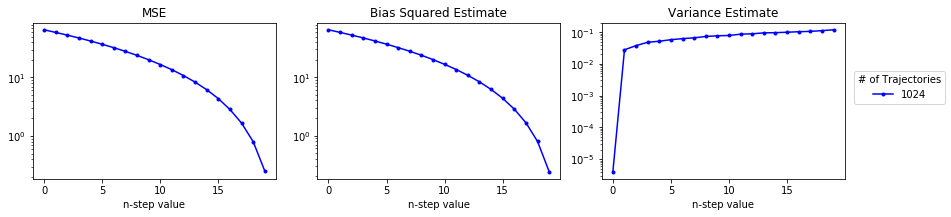

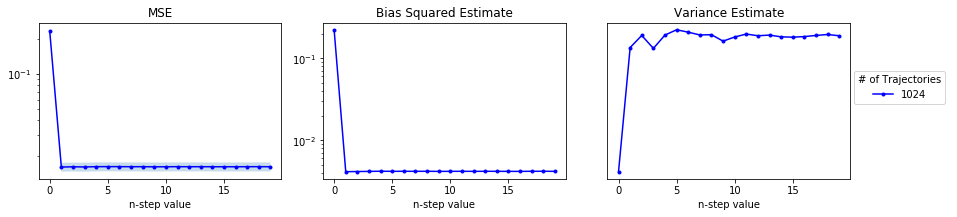

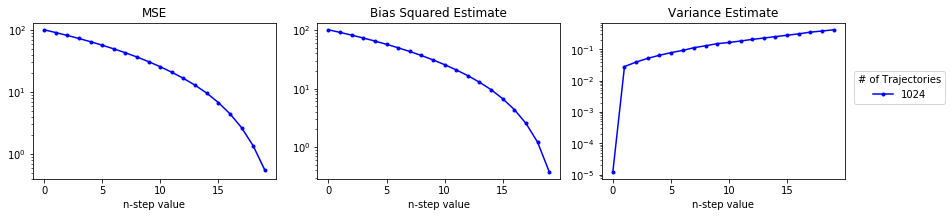

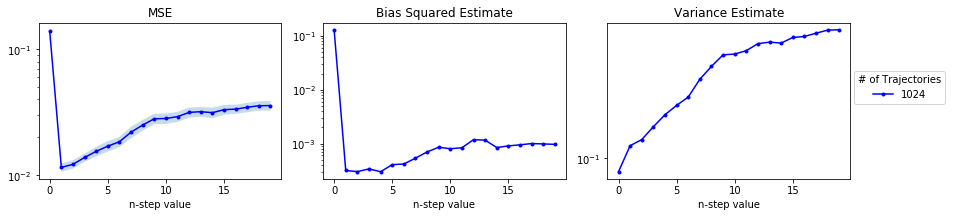

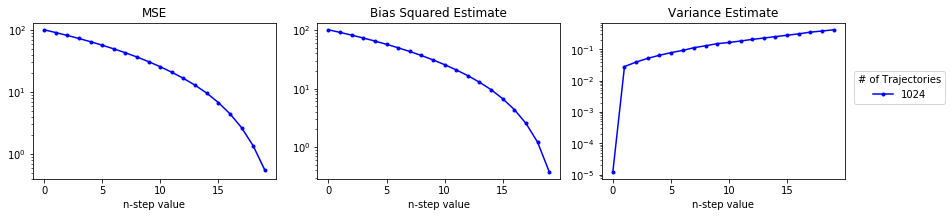

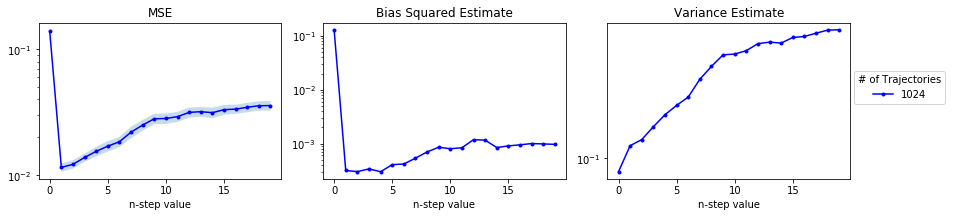

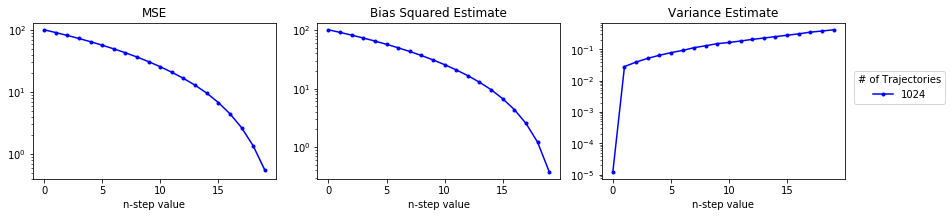

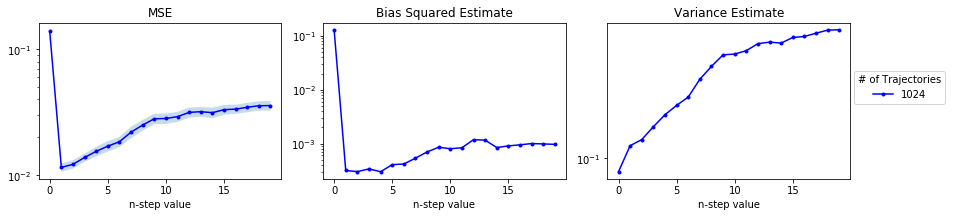

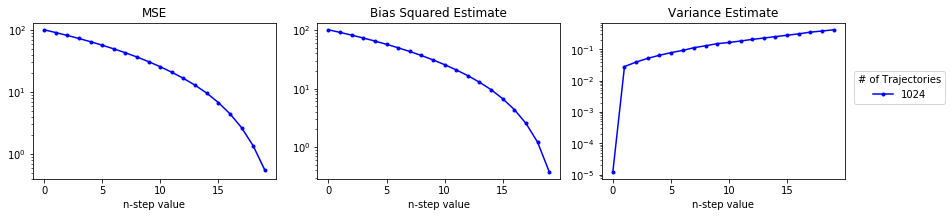

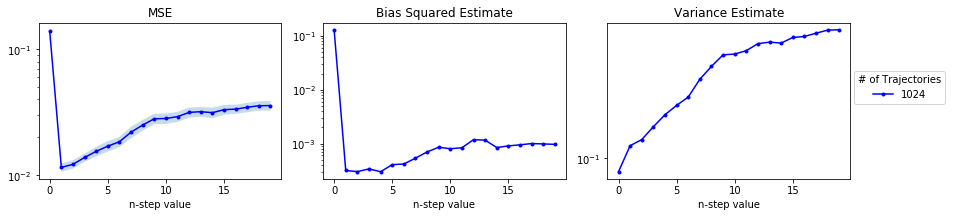

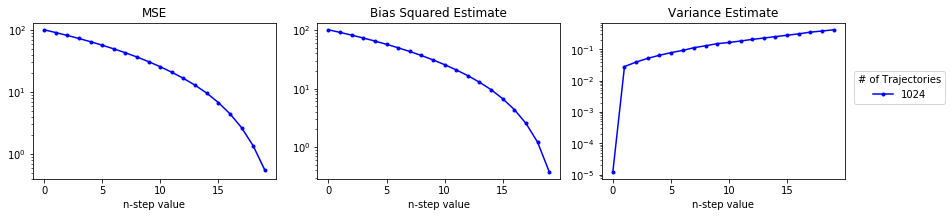

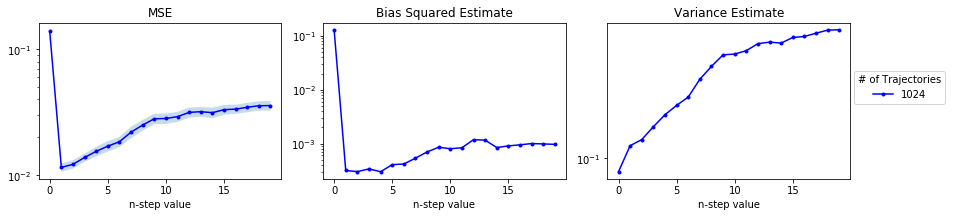

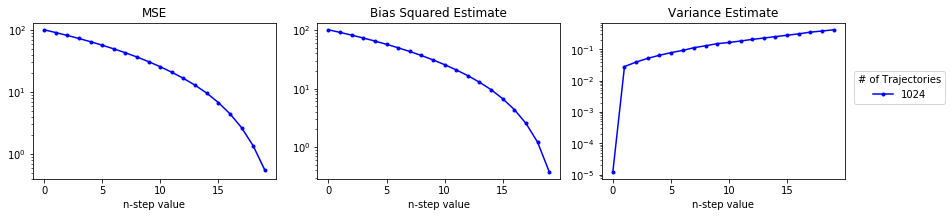

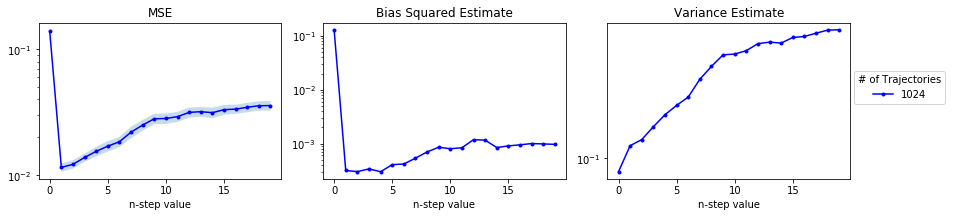

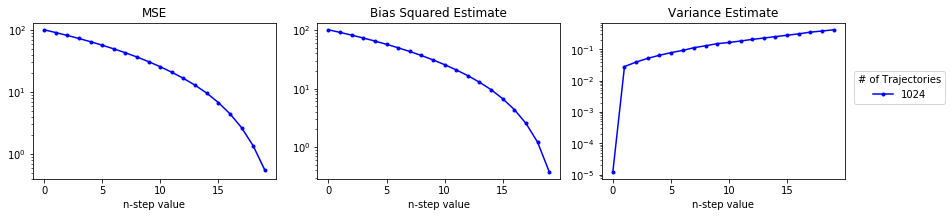

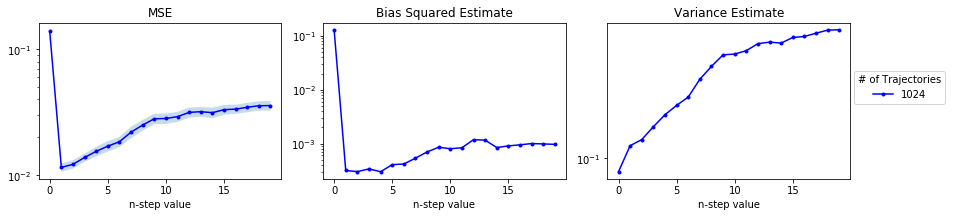

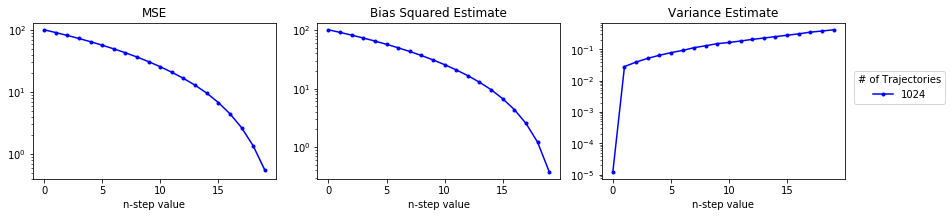

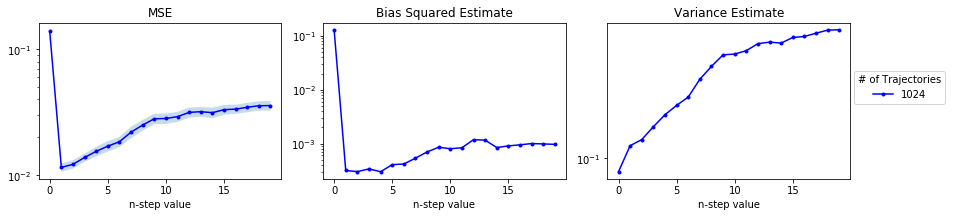

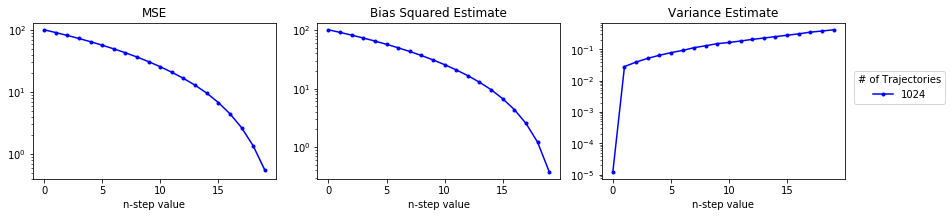

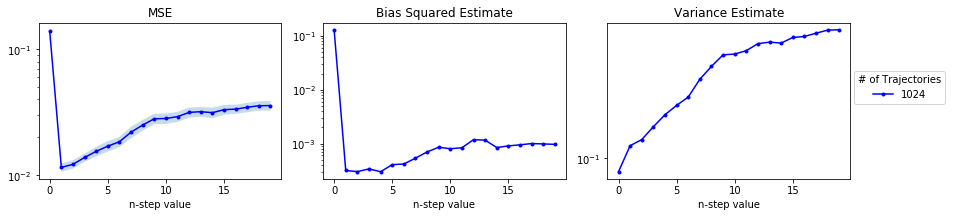

In [104]:
weighted_results_all_behaviors = []
unweighted_results_all_behaviors = []
behavior_policies = [0.1]
congiguration, cfg, env = get_config(weighted_graph_args, 0)
max_kl_divergence = get_kl_max(env, behavior_policies[0], 50)
kl_divergence = np.linspace(0, max_kl_divergence, 10)

# Uses KL divergence to calculate the evaluation policy
for i in behavior_policies:
    weighted_results = []
    unweighted_results = []
    for k in kl_divergence:
            # Set the behaviour policy
            print("Running ", k, " of ", kl_divergence)

            unweighted_graph_args["p0"] = i
            weighted_graph_args["p0"] = i
            # Change Nvalues to only one measure


            unweighted_graph_results = run(unweighted_graph_args,k)
            weighted_graph_results = run(weighted_graph_args, k)

            # Save results
            weighted_results.append({"behavior_policy":  i,
                            "kl_divergence": k,
                            "results": weighted_graph_results
                            })
            
            unweighted_results.append({"behavior_policy":  i,
                            "kl_divergence": k,
                            "results": unweighted_graph_results, 
                            })
            
            # # Plot 
            # neurips_plot(unweighted_graph_results, "./experiment_images/unweighted/unweighted_graph_plot_ep_" + str(i).replace(".", "") + "kl_"+ str(k).replace(".", ""), cycler_small=True)
            # neurips_plot(weighted_graph_results, "./experiment_images/weighted/weighted_graph_plot"+ str(i).replace(".", "") + "kl_"+ str(k).replace(".", ""), cycler_small=True)

    weighted_results_all_behaviors.append(weighted_results)
    unweighted_results_all_behaviors.append(unweighted_results)


In [105]:
print(weighted_results)

[{'behavior_policy': 0.1, 'kl_divergence': 0.0, 'results': ([{'ON POLICY': [-6.56749134755266, 0], 'NStep(t=0)': [-6.91246563702488, 0.1190072603968631], 'NStep(t=1)': [-6.526386819913863, 0.0016895821924086552], 'NStep(t=2)': [-6.523131999673446, 0.0019677517442691595], 'NStep(t=3)': [-6.523606875697276, 0.0019258468700260217], 'NStep(t=4)': [-6.514964054858099, 0.0027591164778200373], 'NStep(t=5)': [-6.51787988846352, 0.002461296872953379], 'NStep(t=6)': [-6.518928770136297, 0.0023583239253202656], 'NStep(t=7)': [-6.520729596216022, 0.002186661388069593], 'NStep(t=8)': [-6.520155231061387, 0.002240707924475379], 'NStep(t=9)': [-6.521087878721977, 0.002153281919520202], 'NStep(t=10)': [-6.520518222116899, 0.0022064745132037203], 'NStep(t=11)': [-6.5203821398253226, 0.0022192774526974255], 'NStep(t=12)': [-6.519789323687624, 0.002275483080820493], 'NStep(t=13)': [-6.520529720370615, 0.002205394427585346], 'NStep(t=14)': [-6.520450936118947, 0.0022128003078529823], 'NStep(t=15)': [-6.52

In [106]:
# Save data in case of wrong plotting
def default(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, np.int64):
        return int(obj)
    if isinstance(obj, np.int32):
        return int(obj)
    raise TypeError('Not serializable ', obj)


with open("weighted_results.json", "w") as weighted:
        json.dump(weighted_results_all_behaviors, weighted, indent = 4, default=default)
weighted.close()

with open("unweighted_results.json", "w") as unweighted:
        json.dump(unweighted_results_all_behaviors, unweighted, indent=4, default=default)
unweighted.close()

In [107]:
# if plot failed load data from old file
# Opening JSON file
with open('weighted_results.json') as weighted_json_file:
    weighted_results_all_behaviors = json.load(weighted_json_file)
weighted_json_file.close()

with open('unweighted_results.json') as unweighted_json_file:
    unweighted_results_all_behaviors = json.load(unweighted_json_file)
unweighted_json_file.close()

In [108]:
from neurips_plotting import get_cyclers, format_results
def format_results_kl_2d(raw_results, weighted=True):
    R = []
    kl_divergence = []
    for r in raw_results:
        kl_divergence.append(r["kl_divergence"])
        R.append(format_results(r["results"], weighted))

    estimate_means  = []
    estimate_ses    = []
    error_means     = []
    error_ses       = []
    estimate_vars   = []
    my_mse          = []
    seeds           = []

    for i in range(len(R[0]['nvals'])):
        esm = []
        ess = []
        erm = []
        ers = []
        esv = []
        mmse = []
        seed = []
        for [k,r] in zip(kl_divergence, R):
            esm.append(r['ests_mn'][i])
            ess.append(r['ests_se'][i]) 
            erm.append(r['errs_mn'][i])
            ers.append(r['errs_se'][i])
            esv.append(r['ests_var'][i])
            mmse.append(r['my_mse'][i])
            seed.append(r['seeds'][i])
        estimate_means.append(np.array(esm).flatten())
        estimate_ses.append(np.array(ess).flatten())
        error_means.append(np.array(erm).flatten())
        error_ses.append(np.array(ers).flatten())
        estimate_vars.append(np.array(esv).flatten())
        my_mse.append(np.array(mmse).flatten())
        seeds.append(np.array(seed).flatten())
    
    return {
        'seeds'   : np.unique(seeds),
        'kl_div': np.array(kl_divergence),
        'nvals'   : list(R[0]['nvals']),
        'true_val': R[0]['true_val'],
        'ests_mn' : np.array(estimate_means),
        'ests_se' : np.array(estimate_ses),
        'errs_mn' : np.array(error_means),
        'errs_se' : np.array(error_ses),
        "ests_var": np.array(estimate_vars),
        'my_mse'  : np.array(my_mse)}

In [109]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from neurips_plotting import get_cyclers, format_results

def neurips_plot_kl_3D(raw_results, filename, weighted, cycler_small=False):

    clean_results = format_results_kl_2d(raw_results)
    linecycler, markercycler, colorcycler = get_cyclers(small=cycler_small)

    horizon = raw_results[0]['results'][1]['args']['horizon']
    nstep_int = raw_results[0]['results'][1]['args'].get('nstep_int', 1)

    for (errs, errs_se, kl_div, ests, ests_var, nval) in zip( clean_results['errs_mn'], clean_results['errs_se'], clean_results['kl_div'], clean_results['ests_mn'], clean_results['ests_var'], clean_results['nvals']):
        color = next(colorcycler)
        linestyle = next(linecycler)
        marker = next(markercycler)

        # Generate sample data
        n_step_int = np.arange(0, horizon, nstep_int)
        kl_div =  clean_results['kl_div']
        z_axis = [errs,abs(ests - clean_results["true_val"])**2, ests_var]
        z_names = ["MSE", "Bias Squared Estimate", "Variance Estimate"]
        # Create a grid of coordinates
        X, Y = np.meshgrid(n_step_int, kl_div)

        # Reshape the kl_div data to match the grid shape
        Z = [i.reshape(X.shape) for i in z_axis]
        print(Z[0].shape)
        # Create three subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

        # Set different viewing angles for each subplot
        viewing_angles = [(30, 45), (60, 120), (90, 180)]

        for i, ax in enumerate(axes):
            ax.plot_surface(X,Y , Z[i], cmap='viridis')
            ax.view_init(elev=viewing_angles[0][0], azim=viewing_angles[0][1])
            ax.set_xlabel('n_step_int')
            ax.set_ylabel('KL divergence')
            ax.set_zscale('log')
            ax.set_zlabel(z_names[i])
            ax.set_title('Graph {}'.format(z_names[i]))

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show the plot
        plt.show()
        fig.savefig(filename + "_nval_" + str(nval).replace(".", ""))

(10, 20)


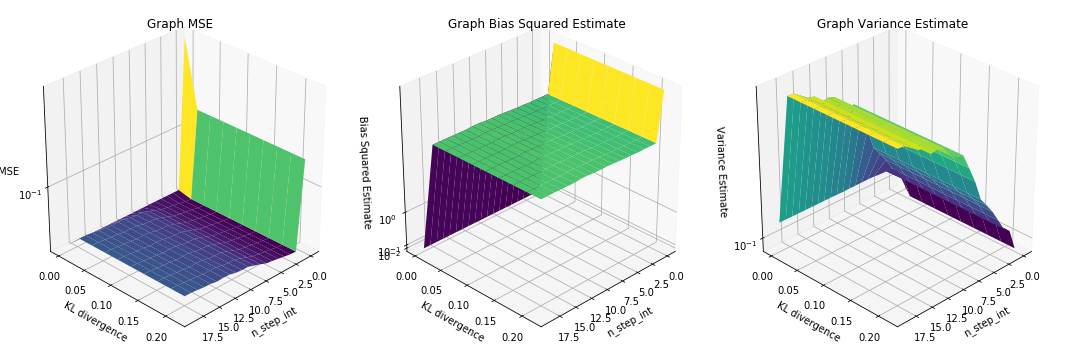

(10, 20)


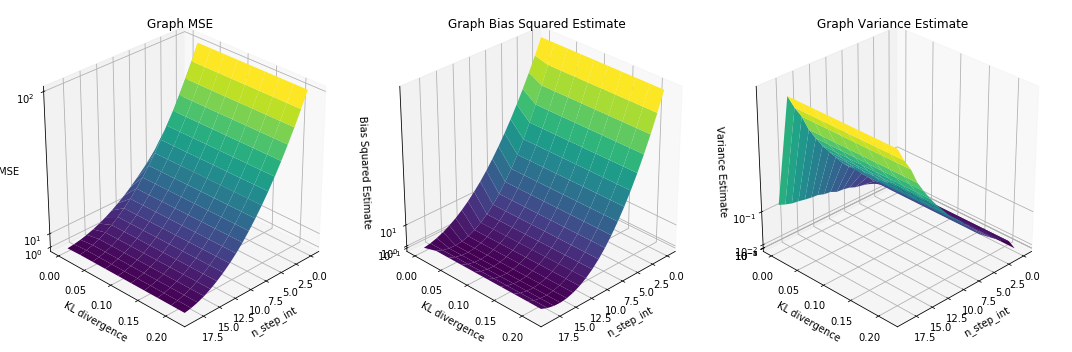

In [115]:
for i in weighted_results_all_behaviors:
    neurips_plot_kl_3D(raw_results=i, filename="./experiment_images/weighted_graph_plot_kl_bp_" + str(i["behavior_policy"]).replace(".", "") + "_3D", weighted=True,  cycler_small=True)
for j in unweighted_results_all_behaviors:    
    neurips_plot_kl_3D(raw_results=j,filename= "./experiment_images/unweighted_graph_plot_kl_bp_" + str(j["behavior_policy"]).replace(".", "") + "_3D", weighted=False, cycler_small=True)
